## Part A - Q1 A - Import and read ‘images.npy’.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf 
import os
import matplotlib.pyplot as plt
import cv2
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

2023-02-12 14:45:02.444769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


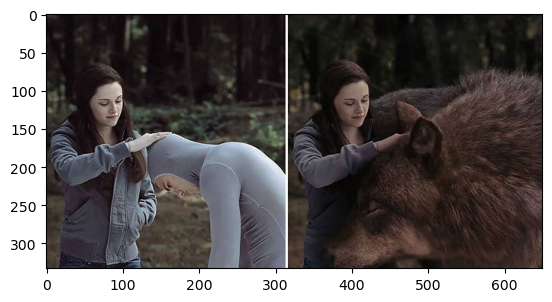

In [2]:
imgs= np.load('images.npy', allow_pickle=True)
plt.imshow(imgs[0][0])

In [3]:
print("Images shape:" , imgs.shape)

Images shape: (409, 2)


In [4]:
# Total of 409 images

## Part A - Q1 B - Split the data into Features(X) & labels(Y). Unify shape of all the images.

In [5]:
import cv2
from glob import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.mobilenet import preprocess_input
tf.__version__

IMG_H = 128
IMG_W = 128
#Feature
X = np.zeros((int(imgs.shape[0]), IMG_H, IMG_W, 3))
#Labels
Y  = np.zeros((int(imgs.shape[0]), IMG_H, IMG_W))

# Unify shape of all images
for index in range(imgs.shape[0]):
    image = imgs[index][0]
    img = cv2.resize(image,dsize=(IMG_H, IMG_W))
    
    #if there is a gray scale image convert it to color
    if(len(img.shape)<3):
        img=cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    X[index] = preprocess_input(np.array(img[:,:,:3], dtype=np.float32))
    for i in imgs[index][1]:
        x1 = int(i["points"][0]['x'] * IMG_W)
        x2 = int(i["points"][1]['x'] * IMG_W)
        y1 = int(i["points"][0]['y'] * IMG_H)
        y2 = int(i["points"][1]['y'] * IMG_H)
        #Replace all the pixels within masked area with 1.
        Y[index][y1:y2, x1:x2] = 1

## Part A - Q1 C - Split the data into train and test[400:9].

In [6]:
X_train = X[:399]
y_train = Y[:399]

X_test = X[400:409]
y_test = Y[400:409]

## Part A - Q1 D - Select random image from the train data and display original image and masked image.

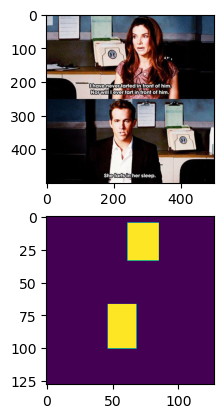

In [7]:
fig,ax=plt.subplots(2)
ax[0].imshow(imgs[5][0])
ax[1].imshow(Y[5])

In [8]:
# Both faces identified in the imave faces identified

## Part A - Q2 A - Design a face mask detection model.

In [9]:
import tensorflow
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D,Conv2DTranspose,BatchNormalization,Dropout,SeparableConv2D,SpatialDropout2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMG_H, IMG_W, 3), include_top=False, alpha=1.0, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
  
    block2 = model.get_layer("conv1_relu").output
    block3 = model.get_layer("conv_pw_2_relu").output
    block4 = model.get_layer("conv_pw_5_relu").output
    block5 = model.get_layer("conv_pw_11_relu").output
    block6 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block6), block5])
    x = Concatenate()([UpSampling2D()(x), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = UpSampling2D()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMG_H, IMG_W))(x)

    return Model(inputs=model.input, outputs=x)

model = create_model()
model.summary()

2023-02-12 14:45:07.818296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['conv1_bn[0][0]']           

                                                                                                  
 conv_pw_5_relu (ReLU)          (None, 16, 16, 256)  0           ['conv_pw_5_bn[0][0]']           
                                                                                                  
 conv_pad_6 (ZeroPadding2D)     (None, 17, 17, 256)  0           ['conv_pw_5_relu[0][0]']         
                                                                                                  
 conv_dw_6 (DepthwiseConv2D)    (None, 8, 8, 256)    2304        ['conv_pad_6[0][0]']             
                                                                                                  
 conv_dw_6_bn (BatchNormalizati  (None, 8, 8, 256)   1024        ['conv_dw_6[0][0]']              
 on)                                                                                              
                                                                                                  
 conv_dw_6

                                                                                                  
 conv_pw_11_bn (BatchNormalizat  (None, 8, 8, 512)   2048        ['conv_pw_11[0][0]']             
 ion)                                                                                             
                                                                                                  
 conv_pw_11_relu (ReLU)         (None, 8, 8, 512)    0           ['conv_pw_11_bn[0][0]']          
                                                                                                  
 conv_pad_12 (ZeroPadding2D)    (None, 9, 9, 512)    0           ['conv_pw_11_relu[0][0]']        
                                                                                                  
 conv_dw_12 (DepthwiseConv2D)   (None, 4, 4, 512)    4608        ['conv_pad_12[0][0]']            
                                                                                                  
 conv_dw_1

## Part A - Q2 B - Design your own Dice Coefficient and Loss function.

In [10]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

## Part A - Q2 C - Train and tune the model as required.

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision

optimizer = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, weight_decay=0)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1)





In [17]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10, verbose=1, 
          steps_per_epoch=len(X_train),validation_steps=len(X_test),
          callbacks=[stop,checkpoint,reduce_lr])

Epoch 1/10
399/399 [==============================] - ETA: 0s - loss: 0.5484 - dice_coefficient: 0.6893
Epoch 1: val_loss improved from inf to 1.60222, saving model to model-1.60.h5
399/399 [==============================] - 147s 351ms/step - loss: 0.5484 - dice_coefficient: 0.6893 - val_loss: 1.6022 - val_dice_coefficient: 0.3862 - lr: 1.0000e-04
Epoch 2/10
399/399 [==============================] - ETA: 0s - loss: 0.5671 - dice_coefficient: 0.6835
Epoch 2: val_loss did not improve from 1.60222
399/399 [==============================] - 144s 360ms/step - loss: 0.5671 - dice_coefficient: 0.6835 - val_loss: 1.8135 - val_dice_coefficient: 0.3759 - lr: 1.0000e-04
Epoch 3/10
399/399 [==============================] - ETA: 0s - loss: 0.5348 - dice_coefficient: 0.6984
Epoch 3: val_loss improved from 1.60222 to 1.48678, saving model to model-1.49.h5
399/399 [==============================] - 144s 362ms/step - loss: 0.5348 - dice_coefficient: 0.6984 - val_loss: 1.4868 - val_dice_coefficient: 0

## Part A - Q2 D - Evaluate and share insights on performance of the model.

In [18]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)


1/1 - 1s - loss: 0.9099 - dice_coefficient: 0.5357 - 1s/epoch - 1s/step


In [23]:
# model has accuracy of ~53%.

## Part A - Q3 - Test the model predictions on the test image: ‘image with index 3 
## in the test data’ and visualise the predicted masks on the faces in the image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


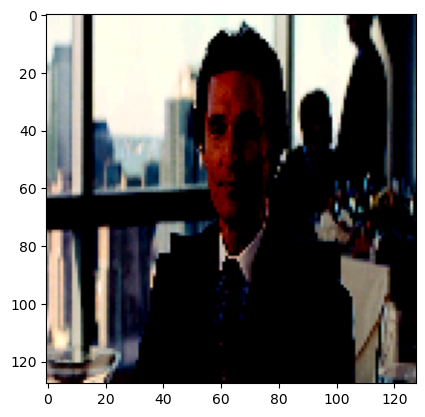

In [24]:
test_id = 3
plt.imshow(X_test[test_id])

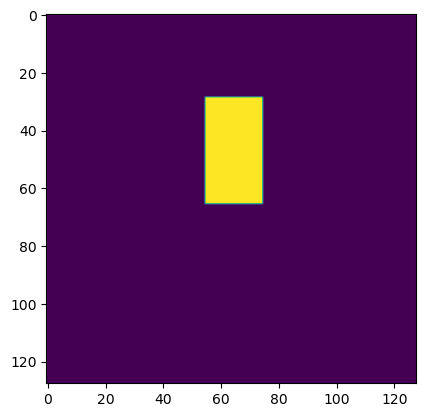

In [25]:
plt.imshow(y_test[test_id])

1/1 [==============================] - 1s 523ms/step


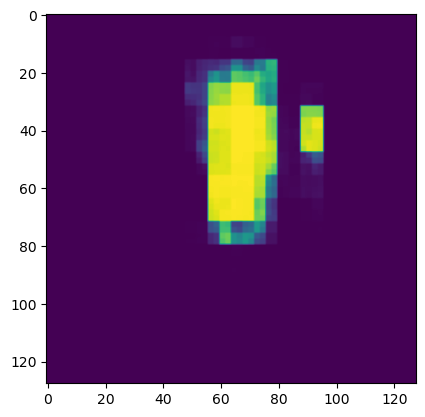

In [27]:
predicted = model.predict(np.reshape(X_test[test_id], [1, IMG_H, IMG_W, 3]))
plt.imshow(predicted[0])

## Part B - Q1 - Read/import images from folder ‘training_images’.

In [31]:
!unzip training_images.zip

Archive:  training_images.zip
  inflating: training_images/real_00947.jpg  
  inflating: training_images/real_01052.jpg  
  inflating: training_images/real_01042.jpg  
  inflating: training_images/real_00964.jpg  
  inflating: training_images/real_01053.jpg  
  inflating: training_images/real_00971.jpg  
  inflating: training_images/real_01057.jpg  
  inflating: training_images/real_01044.jpg  
  inflating: training_images/real_01041.jpg  
  inflating: training_images/real_01067.jpg  
  inflating: training_images/real_00969.jpg  
  inflating: training_images/real_00956.jpg  
  inflating: training_images/real_00975.jpg  
  inflating: training_images/real_01021.jpg  
  inflating: training_images/real_00945.jpg  
  inflating: training_images/real_01068.jpg  
  inflating: training_images/real_01062.jpg  
  inflating: training_images/real_01016.jpg  
  inflating: training_images/real_01065.jpg  
  inflating: training_images/real_01027.jpg  
  inflating: training_images/real_00961.jpg  
  in

  inflating: training_images/real_00931.jpg  
  inflating: training_images/real_00874.jpg  
  inflating: training_images/real_00887.jpg  
  inflating: training_images/real_00842.jpg  
  inflating: training_images/real_00838.jpg  
  inflating: training_images/real_00785.jpg  
  inflating: training_images/real_00815.jpg  
  inflating: training_images/real_00799.jpg  
  inflating: training_images/real_00880.jpg  
  inflating: training_images/real_00902.jpg  
  inflating: training_images/real_00896.jpg  
  inflating: training_images/real_00927.jpg  
  inflating: training_images/real_00911.jpg  
  inflating: training_images/real_00797.jpg  
  inflating: training_images/real_00823.jpg  
  inflating: training_images/real_00939.jpg  
  inflating: training_images/real_00873.jpg  
  inflating: training_images/real_00932.jpg  
  inflating: training_images/real_00886.jpg  
  inflating: training_images/real_00920.jpg  
  inflating: training_images/real_00919.jpg  
  inflating: training_images/real_

  inflating: training_images/real_00695.jpg  
  inflating: training_images/real_00685.jpg  
  inflating: training_images/real_00663.jpg  
  inflating: training_images/real_00642.jpg  
  inflating: training_images/real_00668.jpg  
  inflating: training_images/real_00714.jpg  
  inflating: training_images/real_00682.jpg  
  inflating: training_images/real_00640.jpg  
  inflating: training_images/real_00691.jpg  
  inflating: training_images/real_00730.jpg  
  inflating: training_images/real_00782.jpg  
  inflating: training_images/real_00698.jpg  
  inflating: training_images/real_00743.jpg  
  inflating: training_images/real_00747.jpg  
  inflating: training_images/real_00720.jpg  
  inflating: training_images/real_00681.jpg  
  inflating: training_images/real_00727.jpg  
  inflating: training_images/real_00666.jpg  
  inflating: training_images/real_00721.jpg  
  inflating: training_images/real_00684.jpg  
  inflating: training_images/real_00703.jpg  
  inflating: training_images/real_

  inflating: training_images/real_00579.jpg  
  inflating: training_images/real_00357.jpg  
  inflating: training_images/real_00567.jpg  
  inflating: training_images/real_00373.jpg  
  inflating: training_images/real_00359.jpg  
  inflating: training_images/real_00593.jpg  
  inflating: training_images/real_00403.jpg  
  inflating: training_images/real_00476.jpg  
  inflating: training_images/real_00459.jpg  
  inflating: training_images/real_00435.jpg  
  inflating: training_images/real_00417.jpg  
  inflating: training_images/real_00400.jpg  
  inflating: training_images/real_00347.jpg  
  inflating: training_images/real_00386.jpg  
  inflating: training_images/real_00456.jpg  
  inflating: training_images/real_00424.jpg  
  inflating: training_images/real_00468.jpg  
  inflating: training_images/real_00375.jpg  
  inflating: training_images/real_00382.jpg  
  inflating: training_images/real_00393.jpg  
  inflating: training_images/real_00456(1).jpg  
  inflating: training_images/re

  inflating: training_images/real_00262.jpg  
  inflating: training_images/real_00323.jpg  
  inflating: training_images/real_00291.jpg  
  inflating: training_images/real_00196.jpg  
  inflating: training_images/real_00263.jpg  
  inflating: training_images/real_00198.jpg  
  inflating: training_images/real_00277.jpg  
  inflating: training_images/real_00220.jpg  
  inflating: training_images/real_00182.jpg  
  inflating: training_images/real_00188.jpg  
  inflating: training_images/real_00212.jpg  
  inflating: training_images/real_00193.jpg  
  inflating: training_images/real_00183.jpg  
  inflating: training_images/real_00184.jpg  
  inflating: training_images/real_00229.jpg  
  inflating: training_images/real_00283.jpg  
  inflating: training_images/real_00319(1).jpg  
  inflating: training_images/real_00206.jpg  
  inflating: training_images/real_00443.jpg  
  inflating: training_images/real_00224.jpg  
  inflating: training_images/real_00337.jpg  
  inflating: training_images/re

  inflating: training_images/real_00138.jpg  
  inflating: training_images/real_00051.jpg  
  inflating: training_images/real_00087.jpg  
  inflating: training_images/real_00160.jpg  
  inflating: training_images/real_00058.jpg  
  inflating: training_images/real_00155.jpg  
  inflating: training_images/real_00042.jpg  
  inflating: training_images/real_00089.jpg  
  inflating: training_images/real_00026.jpg  
  inflating: training_images/real_00030.jpg  
  inflating: training_images/real_00081.jpg  
  inflating: training_images/real_00068.jpg  
  inflating: training_images/real_00053.jpg  
  inflating: training_images/real_00170.jpg  
  inflating: training_images/real_00300.jpg  
  inflating: training_images/real_00108.jpg  
  inflating: training_images/real_00168.jpg  
  inflating: training_images/real_00154.jpg  
  inflating: training_images/real_00102.jpg  
  inflating: training_images/real_00158.jpg  
  inflating: training_images/real_00084.jpg  
  inflating: training_images/real_

In [32]:
import glob
img_dir = "./training_images/" 
img_path = os.path.join(img_dir,'*g') 
files = glob.glob(img_path)
data = []  # EMPTY LIST
for f1 in files:
    img = cv2.imread(f1)
    data.append(img)
dir_list = next(os.walk(img_dir))[2]

## Part B - Q2 - Write a loop which will iterate through all the images in the ‘training_images’ 
## folder and detect the faces present on all the images.

In [33]:
x_cordinate=[]
y_cordinate=[]
height=[]
width=[]
face_detected=[]
image_name=[]

for i in range (len(dir_list)):
    # Create a cascade classfier object
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +
                                       'haarcascade_frontalface_default.xml')
    
    data_path = os.path.join(img_dir,dir_list[i])
    img=cv2.imread(data_path)
    faces=face_cascade.detectMultiScale(img,1.1,5)

    j=0 

    # Find coordinates of the face
    for x,y,w,h in faces:
        img=cv2.rectangle(img,(x,y),(x+w,y+h),(255, 0, 0),2)
        j=j+1
    resized=cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0])))
    
    length=len(faces)
    if length==0:
        a=0
        b=0
        c=0
        d=0
        j=0
        name=0
        
    else:
        a=faces[0,0]
        b=faces[0,1]
        c=faces[0,2]
        d=faces[0,3]
        name=dir_list[i]
        
    
    x_cordinate.append(a)
    y_cordinate.append(b)
    width.append(c)
    height.append(d)
    face_detected.append(j)
    image_name.append(name)

## Part B - Q3 - From the same loop above, extract metadata of the faces and write into a DataFrame.

In [34]:
import pandas as pd

df_img = pd.DataFrame(x_cordinate, columns = ['x'])
df_img['y']=y_cordinate
df_img['w']=width
df_img['h']=height
df_img['Total_Faces']=face_detected
df_img['Image_Name']=image_name

df_img.head()

x    y    w    h  Total_Faces      Image_Name
0   93  140  391  391            1  real_00251.jpg
1   56   78  473  473            1  real_00537.jpg
2  116  151  382  382            1  real_00523.jpg
3   82  135  395  395            1  real_00245.jpg
4  153  211  371  371            1  real_00279.jpg

In [35]:
df_img.shape

(1091, 6)

In [36]:
# Total Number of images are 1091

In [37]:
df_img[df_img.Total_Faces >1].shape

(43, 6)

In [38]:
# 43 images have more than one face

In [39]:
df_img[df_img.Total_Faces >1]

x    y    w    h  Total_Faces      Image_Name
7     505  164   60   60            2  real_00735.jpg
9     124  105  418  418            2  real_00047.jpg
48     67   46  476  476            2  real_00867.jpg
88    470  254  109  109            3  real_00905.jpg
89     52  120  462  462            2  real_00911.jpg
158   353  166  131  131            2  real_00733.jpg
159   201  301  106  106            2  real_00055.jpg
176   462   26   91   91            2  real_01001.jpg
177    38   13  500  500            2  real_00479.jpg
205   434   76   97   97            2  real_00929.jpg
221    52  141  406  406            2  real_00518.jpg
229   309  133  273  273            2  real_00718.jpg
231   165  167  402  402            2  real_00730.jpg
310    45  111  476  476            2  real_00622.jpg
356    78   69  485  485            2  real_00743.jpg
361    81   89  432  432            2  real_00596.jpg
371   535  437   60   60            2  real_00219.jpg
427    17   84  466  466            2  real_00026.jpg
435    10  244   52   52            2  real_00542.jpg
451    88   52  432  432            2  real_00977.jpg
466   147  143  424  424            2  real_00354.jpg
565    41  213   50   50            2  real_00949.jpg
573   253  217  245  245            2  real_00008.jpg
575   123  243   91   91            2  real_00593.jpg
597   197   95  388  388            2  real_00165.jpg
608   130  169  400  400            2  real_00373.jpg
609    95  175  368  368            2  real_00415.jpg
618   160  151  398  398            2  real_00372.jpg
635   371  206  187  187            2  real_00986.jpg
670   127  147  362  362            2  real_00827.jpg
677   126  163  418  418            2  real_00358.jpg
689   162   82  167  167            2  real_00629.jpg
727   123  220  100  100            2  real_00177.jpg
750   504  109   67   67            2  real_00837.jpg
788   103  177  376  376            2  real_00606.jpg
809    35  124  425  425            2  real_00405.jpg
859   112    8   49   49            2  real_00304.jpg
873   494   51   66   66            2  real_00305.jpg
946    28    1   55   55            2  real_00104.jpg
966    89   83   52   52            2  real_00262.jpg
1023   92  179  383  383            2  real_00049.jpg
1031  408    2  107  107            2  real_00513.jpg
1042  439  188  127  127            2  real_00922.jpg

## Part B - Q4 - Save the output Dataframe in .csv format.

In [40]:
df_img.to_csv("ImageDataFrame.csv")

## Part C - Q1 - Unzip, read and Load data(‘PINS.zip’) into session.

In [41]:
from zipfile import ZipFile

with ZipFile(file='PINS.zip',mode='r') as zf:
  zf.extractall()

In [42]:
# Write a function to read image using opencv and convert it from BGR to RGB
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

In [43]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

## Part C - Q3 - Write a loop to iterate through each and every image and create metadata for all the images.

In [67]:
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

In [68]:
# Call load_metadata to read the images and assign metadata to a variable
metadata = load_metadata('PINS')

In [69]:
metadata.shape

(10770,)

In [70]:
#There are 10770 images

In [71]:
metadata

array([PINS/pins_mark zuckerberg/mark zuckerberg1.jpg,
       PINS/pins_mark zuckerberg/mark zuckerberg50.jpg,
       PINS/pins_mark zuckerberg/mark zuckerberg44.jpg, ...,
       PINS/pins_tati gabrielle/tati gabrielle21.jpg,
       PINS/pins_tati gabrielle/tati gabrielle20.jpg,
       PINS/pins_tati gabrielle/tati gabrielle34.jpg], dtype=object)

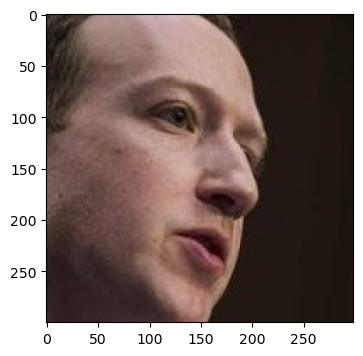

In [72]:
import matplotlib.pyplot as plt
img=load_image(metadata[0].image_path())
plt.figure(figsize=(4,4))
plt.imshow(img)

## Part C - Q4 - Generate Embeddings vectors on the each face in the dataset.

In [73]:
#Predefined model for VGG face
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [74]:
model = vgg_face()
model.load_weights(filepath='./vgg_face_weights.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_13 (ZeroPadd  (None, 226, 226, 3)      0         
 ing2D)                                                          
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_14 (ZeroPadd  (None, 226, 226, 64)     0         
 ing2D)                                                          
                                                                 
 conv2d_18 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                      

In [75]:
# Get vgg_face_descriptor
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [76]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 0s 407ms/step
(2622,)


In [77]:
# Get embedding vector for first image in the metadata using the pre-trained model
def get_embedding(img_path):
    img = load_image(img_path)
    # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    return vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

In [78]:
#Generate embeddings for all images
from tqdm import tqdm
embeddings = np.zeros((metadata.shape[0], 2622))

for i, m in tqdm(enumerate(metadata)):
  embeddings[i]=get_embedding(metadata[i].image_path())

0it [00:00, ?it/s]

1/1 [==============================] - 0s 177ms/step


1it [00:00,  4.57it/s]

1/1 [==============================] - 0s 171ms/step


2it [00:00,  4.67it/s]

1/1 [==============================] - 0s 179ms/step


3it [00:00,  4.58it/s]

1/1 [==============================] - 0s 173ms/step


4it [00:00,  4.63it/s]

1/1 [==============================] - 0s 181ms/step


5it [00:01,  4.61it/s]

1/1 [==============================] - 0s 179ms/step


6it [00:01,  4.61it/s]

1/1 [==============================] - 0s 177ms/step


7it [00:01,  4.62it/s]

1/1 [==============================] - 0s 176ms/step


8it [00:01,  4.64it/s]

1/1 [==============================] - 0s 196ms/step


9it [00:01,  4.52it/s]

1/1 [==============================] - 0s 175ms/step


10it [00:02,  4.56it/s]

1/1 [==============================] - 0s 208ms/step


11it [00:02,  4.40it/s]

1/1 [==============================] - 0s 176ms/step


12it [00:02,  4.41it/s]

1/1 [==============================] - 0s 174ms/step


13it [00:02,  4.50it/s]

1/1 [==============================] - 0s 173ms/step


14it [00:03,  4.56it/s]

1/1 [==============================] - 0s 173ms/step


15it [00:03,  4.61it/s]

1/1 [==============================] - 0s 173ms/step


16it [00:03,  4.64it/s]

1/1 [==============================] - 0s 171ms/step


17it [00:03,  4.69it/s]

1/1 [==============================] - 0s 197ms/step


18it [00:03,  4.54it/s]

1/1 [==============================] - 0s 203ms/step


19it [00:04,  4.41it/s]

1/1 [==============================] - 0s 203ms/step


20it [00:04,  4.27it/s]

1/1 [==============================] - 0s 201ms/step


21it [00:04,  4.22it/s]

1/1 [==============================] - 0s 189ms/step


22it [00:04,  4.26it/s]

1/1 [==============================] - 0s 174ms/step


23it [00:05,  4.39it/s]

1/1 [==============================] - 0s 173ms/step


24it [00:05,  4.49it/s]

1/1 [==============================] - 0s 174ms/step


25it [00:05,  4.55it/s]

1/1 [==============================] - 0s 172ms/step


26it [00:05,  4.61it/s]

1/1 [==============================] - 0s 180ms/step


27it [00:05,  4.60it/s]

1/1 [==============================] - 0s 182ms/step


28it [00:06,  4.57it/s]

1/1 [==============================] - 0s 208ms/step


29it [00:06,  4.36it/s]

1/1 [==============================] - 0s 200ms/step


30it [00:06,  4.26it/s]

1/1 [==============================] - 0s 232ms/step


31it [00:06,  4.03it/s]

1/1 [==============================] - 0s 172ms/step


32it [00:07,  4.25it/s]

1/1 [==============================] - 0s 175ms/step


33it [00:07,  4.40it/s]

1/1 [==============================] - 0s 168ms/step


34it [00:07,  4.56it/s]

1/1 [==============================] - 0s 190ms/step


35it [00:07,  4.53it/s]

1/1 [==============================] - 0s 190ms/step


36it [00:08,  4.49it/s]

1/1 [==============================] - 0s 203ms/step


37it [00:08,  4.38it/s]

1/1 [==============================] - 0s 219ms/step


38it [00:08,  4.18it/s]

1/1 [==============================] - 0s 199ms/step


39it [00:08,  4.20it/s]

1/1 [==============================] - 0s 189ms/step


40it [00:09,  4.28it/s]

1/1 [==============================] - 0s 171ms/step


41it [00:09,  4.45it/s]

1/1 [==============================] - 0s 204ms/step


42it [00:09,  4.37it/s]

1/1 [==============================] - 0s 199ms/step


43it [00:09,  4.33it/s]

1/1 [==============================] - 0s 173ms/step


44it [00:09,  4.47it/s]

1/1 [==============================] - 0s 198ms/step


45it [00:10,  4.41it/s]

1/1 [==============================] - 0s 208ms/step


46it [00:10,  4.33it/s]

1/1 [==============================] - 0s 180ms/step


47it [00:10,  4.37it/s]

1/1 [==============================] - 0s 173ms/step


48it [00:10,  4.50it/s]

1/1 [==============================] - 0s 171ms/step


49it [00:11,  4.61it/s]

1/1 [==============================] - 0s 171ms/step


50it [00:11,  4.69it/s]

1/1 [==============================] - 0s 172ms/step


51it [00:11,  4.74it/s]

1/1 [==============================] - 0s 171ms/step


52it [00:11,  4.77it/s]

1/1 [==============================] - 0s 171ms/step


53it [00:11,  4.81it/s]

1/1 [==============================] - 0s 173ms/step


54it [00:12,  4.83it/s]

1/1 [==============================] - 0s 171ms/step


55it [00:12,  4.86it/s]

1/1 [==============================] - 0s 180ms/step


56it [00:12,  4.75it/s]

1/1 [==============================] - 0s 180ms/step


57it [00:12,  4.74it/s]

1/1 [==============================] - 0s 172ms/step


58it [00:12,  4.77it/s]

1/1 [==============================] - 0s 182ms/step


59it [00:13,  4.74it/s]

1/1 [==============================] - 0s 224ms/step


60it [00:13,  4.43it/s]

1/1 [==============================] - 0s 200ms/step


61it [00:13,  4.37it/s]

1/1 [==============================] - 0s 175ms/step


62it [00:13,  4.44it/s]

1/1 [==============================] - 0s 174ms/step


63it [00:14,  4.55it/s]

1/1 [==============================] - 0s 184ms/step


64it [00:14,  4.57it/s]

1/1 [==============================] - 0s 189ms/step


65it [00:14,  4.48it/s]

1/1 [==============================] - 0s 194ms/step


66it [00:14,  4.37it/s]

1/1 [==============================] - 0s 175ms/step


67it [00:14,  4.47it/s]

1/1 [==============================] - 0s 176ms/step


68it [00:15,  4.57it/s]

1/1 [==============================] - 0s 175ms/step


69it [00:15,  4.59it/s]

1/1 [==============================] - 0s 238ms/step


70it [00:15,  4.28it/s]

1/1 [==============================] - 0s 198ms/step


71it [00:15,  4.28it/s]

1/1 [==============================] - 0s 177ms/step


72it [00:16,  4.42it/s]

1/1 [==============================] - 0s 175ms/step


73it [00:16,  4.52it/s]

1/1 [==============================] - 0s 185ms/step


74it [00:16,  4.49it/s]

1/1 [==============================] - 0s 179ms/step


75it [00:16,  4.56it/s]

1/1 [==============================] - 0s 248ms/step


76it [00:16,  4.20it/s]

1/1 [==============================] - 0s 196ms/step


77it [00:17,  4.24it/s]

1/1 [==============================] - 0s 180ms/step


78it [00:17,  4.34it/s]

1/1 [==============================] - 0s 177ms/step


79it [00:17,  4.47it/s]

1/1 [==============================] - 0s 176ms/step


80it [00:17,  4.57it/s]

1/1 [==============================] - 0s 176ms/step


81it [00:18,  4.64it/s]

1/1 [==============================] - 0s 219ms/step


82it [00:18,  4.40it/s]

1/1 [==============================] - 0s 207ms/step


83it [00:18,  4.25it/s]

1/1 [==============================] - 0s 213ms/step


84it [00:18,  4.17it/s]

1/1 [==============================] - 0s 198ms/step


85it [00:19,  4.20it/s]

1/1 [==============================] - 0s 175ms/step


86it [00:19,  4.35it/s]

1/1 [==============================] - 0s 188ms/step


87it [00:19,  4.39it/s]

1/1 [==============================] - 0s 202ms/step


88it [00:19,  4.30it/s]

1/1 [==============================] - 0s 181ms/step


89it [00:19,  4.38it/s]

1/1 [==============================] - 0s 181ms/step


90it [00:20,  4.45it/s]

1/1 [==============================] - 0s 183ms/step


91it [00:20,  4.50it/s]

1/1 [==============================] - 0s 210ms/step


92it [00:20,  4.31it/s]

1/1 [==============================] - 0s 209ms/step


93it [00:20,  4.22it/s]

1/1 [==============================] - 0s 210ms/step


94it [00:21,  4.15it/s]

1/1 [==============================] - 0s 210ms/step


95it [00:21,  4.11it/s]

1/1 [==============================] - 0s 193ms/step


96it [00:21,  4.16it/s]

1/1 [==============================] - 0s 186ms/step


97it [00:21,  4.25it/s]

1/1 [==============================] - 0s 205ms/step


98it [00:22,  4.21it/s]

1/1 [==============================] - 0s 218ms/step


99it [00:22,  4.12it/s]

1/1 [==============================] - 0s 197ms/step


100it [00:22,  4.15it/s]

1/1 [==============================] - 0s 201ms/step


101it [00:22,  4.11it/s]

1/1 [==============================] - 0s 184ms/step


102it [00:23,  4.23it/s]

1/1 [==============================] - 0s 181ms/step


103it [00:23,  4.34it/s]

1/1 [==============================] - 0s 184ms/step


104it [00:23,  4.40it/s]

1/1 [==============================] - 0s 188ms/step


105it [00:23,  4.32it/s]

1/1 [==============================] - 0s 185ms/step


106it [00:23,  4.38it/s]

1/1 [==============================] - 0s 184ms/step


107it [00:24,  4.43it/s]

1/1 [==============================] - 0s 182ms/step


108it [00:24,  4.47it/s]

1/1 [==============================] - 0s 188ms/step


109it [00:24,  4.48it/s]

1/1 [==============================] - 0s 191ms/step


110it [00:24,  4.41it/s]

1/1 [==============================] - 0s 186ms/step


111it [00:25,  4.44it/s]

1/1 [==============================] - 0s 183ms/step


112it [00:25,  4.47it/s]

1/1 [==============================] - 0s 217ms/step


113it [00:25,  4.30it/s]

1/1 [==============================] - 0s 200ms/step


114it [00:25,  4.29it/s]

1/1 [==============================] - 0s 201ms/step


115it [00:25,  4.27it/s]

1/1 [==============================] - 0s 202ms/step


116it [00:26,  4.25it/s]

1/1 [==============================] - 0s 203ms/step


117it [00:26,  4.23it/s]

1/1 [==============================] - 0s 190ms/step


118it [00:26,  4.29it/s]

1/1 [==============================] - 0s 191ms/step


119it [00:26,  4.28it/s]

1/1 [==============================] - 0s 184ms/step


120it [00:27,  4.35it/s]

1/1 [==============================] - 0s 188ms/step


121it [00:27,  4.39it/s]

1/1 [==============================] - 0s 183ms/step


122it [00:27,  4.45it/s]

1/1 [==============================] - 0s 187ms/step


123it [00:27,  4.47it/s]

1/1 [==============================] - 0s 184ms/step


124it [00:28,  4.50it/s]

1/1 [==============================] - 0s 187ms/step


125it [00:28,  4.50it/s]

1/1 [==============================] - 0s 185ms/step


126it [00:28,  4.52it/s]

1/1 [==============================] - 0s 187ms/step


127it [00:28,  4.52it/s]

1/1 [==============================] - 0s 191ms/step


128it [00:28,  4.43it/s]

1/1 [==============================] - 0s 187ms/step


129it [00:29,  4.45it/s]

1/1 [==============================] - 0s 184ms/step


130it [00:29,  4.48it/s]

1/1 [==============================] - 0s 187ms/step


131it [00:29,  4.49it/s]

1/1 [==============================] - 0s 186ms/step


132it [00:29,  4.50it/s]

1/1 [==============================] - 0s 186ms/step


133it [00:30,  4.51it/s]

1/1 [==============================] - 0s 189ms/step


134it [00:30,  4.50it/s]

1/1 [==============================] - 0s 192ms/step


135it [00:30,  4.48it/s]

1/1 [==============================] - 0s 184ms/step


136it [00:30,  4.50it/s]

1/1 [==============================] - 0s 190ms/step


137it [00:30,  4.42it/s]

1/1 [==============================] - 0s 188ms/step


138it [00:31,  4.44it/s]

1/1 [==============================] - 0s 186ms/step


139it [00:31,  4.46it/s]

1/1 [==============================] - 0s 186ms/step


140it [00:31,  4.48it/s]

1/1 [==============================] - 0s 189ms/step


141it [00:31,  4.48it/s]

1/1 [==============================] - 0s 187ms/step


142it [00:32,  4.41it/s]

1/1 [==============================] - 0s 187ms/step


143it [00:32,  4.44it/s]

1/1 [==============================] - 0s 191ms/step


144it [00:32,  4.43it/s]

1/1 [==============================] - 0s 189ms/step


145it [00:32,  4.45it/s]

1/1 [==============================] - 0s 193ms/step


146it [00:32,  4.39it/s]

1/1 [==============================] - 0s 189ms/step


147it [00:33,  4.41it/s]

1/1 [==============================] - 0s 189ms/step


148it [00:33,  4.43it/s]

1/1 [==============================] - 0s 192ms/step


149it [00:33,  4.42it/s]

1/1 [==============================] - 0s 188ms/step


150it [00:33,  4.44it/s]

1/1 [==============================] - 0s 186ms/step


151it [00:34,  4.47it/s]

1/1 [==============================] - 0s 191ms/step


152it [00:34,  4.45it/s]

1/1 [==============================] - 0s 283ms/step


153it [00:34,  3.96it/s]

1/1 [==============================] - 0s 185ms/step


154it [00:34,  4.11it/s]

1/1 [==============================] - 0s 197ms/step


155it [00:35,  4.12it/s]

1/1 [==============================] - 0s 191ms/step


156it [00:35,  4.21it/s]

1/1 [==============================] - 0s 191ms/step


157it [00:35,  4.27it/s]

1/1 [==============================] - 0s 187ms/step


158it [00:35,  4.33it/s]

1/1 [==============================] - 0s 190ms/step


159it [00:35,  4.36it/s]

1/1 [==============================] - 0s 187ms/step


160it [00:36,  4.41it/s]

1/1 [==============================] - 0s 189ms/step


161it [00:36,  4.42it/s]

1/1 [==============================] - 0s 189ms/step


162it [00:36,  4.43it/s]

1/1 [==============================] - 0s 285ms/step


163it [00:36,  3.93it/s]

1/1 [==============================] - 0s 195ms/step


164it [00:37,  4.00it/s]

1/1 [==============================] - 0s 189ms/step


165it [00:37,  4.13it/s]

1/1 [==============================] - 0s 214ms/step


166it [00:37,  4.09it/s]

1/1 [==============================] - 0s 186ms/step


167it [00:37,  4.21it/s]

1/1 [==============================] - 0s 188ms/step


168it [00:38,  4.28it/s]

1/1 [==============================] - 0s 191ms/step


169it [00:38,  4.31it/s]

1/1 [==============================] - 0s 188ms/step


170it [00:38,  4.36it/s]

1/1 [==============================] - 0s 190ms/step


171it [00:38,  4.38it/s]

1/1 [==============================] - 0s 186ms/step


172it [00:39,  4.42it/s]

1/1 [==============================] - 0s 199ms/step


173it [00:39,  4.32it/s]

1/1 [==============================] - 0s 190ms/step


174it [00:39,  4.36it/s]

1/1 [==============================] - 0s 204ms/step


175it [00:39,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


176it [00:39,  4.33it/s]

1/1 [==============================] - 0s 191ms/step


177it [00:40,  4.36it/s]

1/1 [==============================] - 0s 189ms/step


178it [00:40,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


179it [00:40,  4.39it/s]

1/1 [==============================] - 0s 190ms/step


180it [00:40,  4.40it/s]

1/1 [==============================] - 0s 191ms/step


181it [00:41,  4.40it/s]

1/1 [==============================] - 0s 197ms/step


182it [00:41,  4.32it/s]

1/1 [==============================] - 0s 196ms/step


183it [00:41,  4.32it/s]

1/1 [==============================] - 0s 190ms/step


184it [00:41,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


185it [00:42,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


186it [00:42,  4.35it/s]

1/1 [==============================] - 0s 197ms/step


187it [00:42,  4.33it/s]

1/1 [==============================] - 0s 187ms/step


188it [00:42,  4.38it/s]

1/1 [==============================] - 0s 194ms/step


189it [00:42,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


190it [00:43,  4.38it/s]

1/1 [==============================] - 0s 208ms/step


191it [00:43,  4.22it/s]

1/1 [==============================] - 0s 194ms/step


192it [00:43,  4.25it/s]

1/1 [==============================] - 0s 190ms/step


193it [00:43,  4.31it/s]

1/1 [==============================] - 0s 193ms/step


194it [00:44,  4.33it/s]

1/1 [==============================] - 0s 190ms/step


195it [00:44,  4.35it/s]

1/1 [==============================] - 0s 191ms/step


196it [00:44,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


197it [00:44,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


198it [00:45,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


199it [00:45,  4.38it/s]

1/1 [==============================] - 0s 200ms/step


200it [00:45,  4.29it/s]

1/1 [==============================] - 0s 192ms/step


201it [00:45,  4.32it/s]

1/1 [==============================] - 0s 191ms/step


202it [00:45,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


203it [00:46,  4.35it/s]

1/1 [==============================] - 0s 198ms/step


204it [00:46,  4.29it/s]

1/1 [==============================] - 0s 192ms/step


205it [00:46,  4.32it/s]

1/1 [==============================] - 0s 192ms/step


206it [00:46,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


207it [00:47,  4.35it/s]

1/1 [==============================] - 0s 190ms/step


208it [00:47,  4.38it/s]

1/1 [==============================] - 0s 200ms/step


209it [00:47,  4.28it/s]

1/1 [==============================] - 0s 190ms/step


210it [00:47,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


211it [00:48,  4.34it/s]

1/1 [==============================] - 0s 195ms/step


212it [00:48,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


213it [00:48,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


214it [00:48,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


215it [00:48,  4.36it/s]

1/1 [==============================] - 0s 191ms/step


216it [00:49,  4.37it/s]

1/1 [==============================] - 0s 192ms/step


217it [00:49,  4.37it/s]

1/1 [==============================] - 0s 204ms/step


218it [00:49,  4.26it/s]

1/1 [==============================] - 0s 211ms/step


219it [00:49,  4.18it/s]

1/1 [==============================] - 0s 208ms/step


220it [00:50,  3.60it/s]

1/1 [==============================] - 0s 207ms/step


221it [00:50,  3.74it/s]

1/1 [==============================] - 0s 213ms/step


222it [00:50,  3.82it/s]

1/1 [==============================] - 0s 212ms/step


223it [00:51,  3.88it/s]

1/1 [==============================] - 0s 196ms/step


224it [00:51,  4.00it/s]

1/1 [==============================] - 0s 194ms/step


225it [00:51,  4.10it/s]

1/1 [==============================] - 0s 199ms/step


226it [00:51,  4.15it/s]

1/1 [==============================] - 0s 203ms/step


227it [00:51,  4.12it/s]

1/1 [==============================] - 0s 196ms/step


228it [00:52,  4.18it/s]

1/1 [==============================] - 0s 199ms/step


229it [00:52,  4.21it/s]

1/1 [==============================] - 0s 199ms/step


230it [00:52,  4.21it/s]

1/1 [==============================] - 0s 196ms/step


231it [00:52,  4.24it/s]

1/1 [==============================] - 0s 194ms/step


232it [00:53,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


233it [00:53,  4.30it/s]

1/1 [==============================] - 0s 196ms/step


234it [00:53,  4.30it/s]

1/1 [==============================] - 0s 199ms/step


235it [00:53,  4.28it/s]

1/1 [==============================] - 0s 204ms/step


236it [00:54,  4.19it/s]

1/1 [==============================] - 0s 196ms/step


237it [00:54,  4.23it/s]

1/1 [==============================] - 0s 289ms/step


238it [00:54,  3.80it/s]

1/1 [==============================] - 0s 192ms/step


239it [00:54,  3.96it/s]

1/1 [==============================] - 0s 193ms/step


240it [00:55,  4.07it/s]

1/1 [==============================] - 0s 194ms/step


241it [00:55,  4.16it/s]

1/1 [==============================] - 0s 195ms/step


242it [00:55,  4.20it/s]

1/1 [==============================] - 0s 192ms/step


243it [00:55,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


244it [00:56,  4.29it/s]

1/1 [==============================] - 0s 206ms/step


245it [00:56,  4.20it/s]

1/1 [==============================] - 0s 191ms/step


246it [00:56,  4.26it/s]

1/1 [==============================] - 0s 194ms/step


247it [00:56,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


248it [00:56,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


249it [00:57,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


250it [00:57,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


251it [00:57,  4.36it/s]

1/1 [==============================] - 0s 195ms/step


252it [00:57,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


253it [00:58,  4.36it/s]

1/1 [==============================] - 0s 202ms/step


254it [00:58,  4.27it/s]

1/1 [==============================] - 0s 200ms/step


255it [00:58,  4.26it/s]

1/1 [==============================] - 0s 198ms/step


256it [00:58,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


257it [00:59,  4.29it/s]

1/1 [==============================] - 0s 194ms/step


258it [00:59,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


259it [00:59,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


260it [00:59,  4.33it/s]

1/1 [==============================] - 0s 196ms/step


261it [00:59,  4.33it/s]

1/1 [==============================] - 0s 215ms/step


262it [01:00,  4.22it/s]

1/1 [==============================] - 0s 222ms/step


263it [01:00,  4.07it/s]

1/1 [==============================] - 0s 214ms/step


264it [01:00,  4.06it/s]

1/1 [==============================] - 0s 217ms/step


265it [01:00,  4.02it/s]

1/1 [==============================] - 0s 211ms/step


266it [01:01,  4.03it/s]

1/1 [==============================] - 0s 198ms/step


267it [01:01,  4.10it/s]

1/1 [==============================] - 0s 195ms/step


268it [01:01,  4.18it/s]

1/1 [==============================] - 0s 200ms/step


269it [01:01,  4.20it/s]

1/1 [==============================] - 0s 193ms/step


270it [01:02,  4.26it/s]

1/1 [==============================] - 0s 195ms/step


271it [01:02,  4.28it/s]

1/1 [==============================] - 0s 205ms/step


272it [01:02,  4.19it/s]

1/1 [==============================] - 0s 197ms/step


273it [01:02,  4.21it/s]

1/1 [==============================] - 0s 197ms/step


274it [01:03,  4.24it/s]

1/1 [==============================] - 0s 192ms/step


275it [01:03,  4.28it/s]

1/1 [==============================] - 0s 195ms/step


276it [01:03,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


277it [01:03,  4.32it/s]

1/1 [==============================] - 0s 197ms/step


278it [01:04,  4.31it/s]

1/1 [==============================] - 0s 197ms/step


279it [01:04,  4.30it/s]

1/1 [==============================] - 0s 197ms/step


280it [01:04,  4.29it/s]

1/1 [==============================] - 0s 207ms/step


281it [01:04,  4.19it/s]

1/1 [==============================] - 0s 199ms/step


282it [01:04,  4.21it/s]

1/1 [==============================] - 0s 189ms/step


283it [01:05,  4.27it/s]

1/1 [==============================] - 0s 195ms/step


284it [01:05,  4.29it/s]

1/1 [==============================] - 0s 194ms/step


285it [01:05,  4.30it/s]

1/1 [==============================] - 0s 198ms/step


286it [01:05,  4.29it/s]

1/1 [==============================] - 0s 193ms/step


287it [01:06,  4.31it/s]

1/1 [==============================] - 0s 196ms/step


288it [01:06,  4.31it/s]

1/1 [==============================] - 0s 199ms/step


289it [01:06,  4.29it/s]

1/1 [==============================] - 0s 207ms/step


290it [01:06,  4.19it/s]

1/1 [==============================] - 0s 194ms/step


291it [01:07,  4.24it/s]

1/1 [==============================] - 0s 197ms/step


292it [01:07,  4.26it/s]

1/1 [==============================] - 0s 195ms/step


293it [01:07,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


294it [01:07,  4.25it/s]

1/1 [==============================] - 0s 196ms/step


295it [01:07,  4.27it/s]

1/1 [==============================] - 0s 200ms/step


296it [01:08,  4.26it/s]

1/1 [==============================] - 0s 196ms/step


297it [01:08,  4.28it/s]

1/1 [==============================] - 0s 199ms/step


298it [01:08,  4.28it/s]

1/1 [==============================] - 0s 198ms/step


299it [01:08,  4.23it/s]

1/1 [==============================] - 0s 196ms/step


300it [01:09,  4.24it/s]

1/1 [==============================] - 0s 287ms/step


301it [01:09,  3.82it/s]

1/1 [==============================] - 0s 191ms/step


302it [01:09,  3.98it/s]

1/1 [==============================] - 0s 196ms/step


303it [01:09,  4.08it/s]

1/1 [==============================] - 0s 197ms/step


304it [01:10,  4.14it/s]

1/1 [==============================] - 0s 194ms/step


305it [01:10,  4.20it/s]

1/1 [==============================] - 0s 198ms/step


306it [01:10,  4.22it/s]

1/1 [==============================] - 0s 195ms/step


307it [01:10,  4.26it/s]

1/1 [==============================] - 0s 203ms/step


308it [01:11,  4.19it/s]

1/1 [==============================] - 0s 195ms/step


309it [01:11,  4.24it/s]

1/1 [==============================] - 0s 194ms/step


310it [01:11,  4.27it/s]

1/1 [==============================] - 0s 195ms/step


311it [01:11,  4.29it/s]

1/1 [==============================] - 0s 196ms/step


312it [01:12,  4.30it/s]

1/1 [==============================] - 0s 193ms/step


313it [01:12,  4.32it/s]

1/1 [==============================] - 0s 196ms/step


314it [01:12,  4.32it/s]

1/1 [==============================] - 0s 195ms/step


315it [01:12,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


316it [01:12,  4.32it/s]

1/1 [==============================] - 0s 200ms/step


317it [01:13,  4.25it/s]

1/1 [==============================] - 0s 208ms/step


318it [01:13,  4.17it/s]

1/1 [==============================] - 0s 194ms/step


319it [01:13,  4.22it/s]

1/1 [==============================] - 0s 197ms/step


320it [01:13,  4.25it/s]

1/1 [==============================] - 0s 194ms/step


321it [01:14,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


322it [01:14,  4.29it/s]

1/1 [==============================] - 0s 195ms/step


323it [01:14,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


324it [01:14,  4.32it/s]

1/1 [==============================] - 0s 286ms/step


325it [01:15,  3.87it/s]

1/1 [==============================] - 0s 201ms/step


326it [01:15,  3.94it/s]

1/1 [==============================] - 0s 284ms/step


327it [01:15,  3.65it/s]

1/1 [==============================] - 0s 189ms/step


328it [01:15,  3.86it/s]

1/1 [==============================] - 0s 191ms/step


329it [01:16,  4.02it/s]

1/1 [==============================] - 0s 193ms/step


330it [01:16,  4.13it/s]

1/1 [==============================] - 0s 193ms/step


331it [01:16,  4.21it/s]

1/1 [==============================] - 0s 193ms/step


332it [01:16,  4.26it/s]

1/1 [==============================] - 0s 193ms/step


333it [01:17,  4.29it/s]

1/1 [==============================] - 0s 193ms/step


334it [01:17,  4.32it/s]

1/1 [==============================] - 0s 200ms/step


335it [01:17,  4.24it/s]

1/1 [==============================] - 0s 197ms/step


336it [01:17,  4.25it/s]

1/1 [==============================] - 0s 198ms/step


337it [01:18,  4.25it/s]

1/1 [==============================] - 0s 194ms/step


338it [01:18,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


339it [01:18,  4.30it/s]

1/1 [==============================] - 0s 292ms/step


340it [01:18,  3.83it/s]

1/1 [==============================] - 0s 189ms/step


341it [01:19,  4.00it/s]

1/1 [==============================] - 0s 194ms/step


342it [01:19,  4.10it/s]

1/1 [==============================] - 0s 195ms/step


343it [01:19,  4.18it/s]

1/1 [==============================] - 0s 200ms/step


344it [01:19,  4.15it/s]

1/1 [==============================] - 0s 194ms/step


345it [01:19,  4.21it/s]

1/1 [==============================] - 0s 190ms/step


346it [01:20,  4.27it/s]

1/1 [==============================] - 0s 209ms/step


347it [01:20,  4.22it/s]

1/1 [==============================] - 0s 207ms/step


348it [01:20,  4.19it/s]

1/1 [==============================] - 0s 207ms/step


349it [01:20,  4.16it/s]

1/1 [==============================] - 0s 211ms/step


350it [01:21,  4.12it/s]

1/1 [==============================] - 0s 214ms/step


351it [01:21,  4.08it/s]

1/1 [==============================] - 0s 210ms/step


352it [01:21,  4.07it/s]

1/1 [==============================] - 0s 208ms/step


353it [01:21,  4.03it/s]

1/1 [==============================] - 0s 196ms/step


354it [01:22,  4.11it/s]

1/1 [==============================] - 0s 199ms/step


355it [01:22,  4.15it/s]

1/1 [==============================] - 0s 196ms/step


356it [01:22,  4.20it/s]

1/1 [==============================] - 0s 195ms/step


357it [01:22,  4.24it/s]

1/1 [==============================] - 0s 197ms/step


358it [01:23,  4.25it/s]

1/1 [==============================] - 0s 200ms/step


359it [01:23,  4.25it/s]

1/1 [==============================] - 0s 196ms/step


360it [01:23,  4.26it/s]

1/1 [==============================] - 0s 195ms/step


361it [01:23,  4.27it/s]

1/1 [==============================] - 0s 295ms/step


362it [01:24,  3.76it/s]

1/1 [==============================] - 0s 194ms/step


363it [01:24,  3.92it/s]

1/1 [==============================] - 0s 284ms/step


364it [01:24,  3.63it/s]

1/1 [==============================] - 0s 190ms/step


365it [01:24,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


366it [01:25,  3.83it/s]

1/1 [==============================] - 0s 198ms/step


367it [01:25,  3.87it/s]

1/1 [==============================] - 0s 191ms/step


368it [01:25,  4.02it/s]

1/1 [==============================] - 0s 197ms/step


369it [01:25,  4.10it/s]

1/1 [==============================] - 0s 192ms/step


370it [01:26,  4.19it/s]

1/1 [==============================] - 0s 200ms/step


371it [01:26,  4.16it/s]

1/1 [==============================] - 0s 195ms/step


372it [01:26,  4.21it/s]

1/1 [==============================] - 0s 192ms/step


373it [01:26,  4.26it/s]

1/1 [==============================] - 0s 193ms/step


374it [01:27,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


375it [01:27,  4.31it/s]

1/1 [==============================] - 0s 194ms/step


376it [01:27,  4.32it/s]

1/1 [==============================] - 0s 194ms/step


377it [01:27,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


378it [01:27,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


379it [01:28,  4.35it/s]

1/1 [==============================] - 0s 208ms/step


380it [01:28,  4.17it/s]

1/1 [==============================] - 0s 199ms/step


381it [01:28,  4.20it/s]

1/1 [==============================] - 0s 194ms/step


382it [01:28,  4.23it/s]

1/1 [==============================] - 0s 196ms/step


383it [01:29,  4.26it/s]

1/1 [==============================] - 0s 197ms/step


384it [01:29,  4.28it/s]

1/1 [==============================] - 0s 192ms/step


385it [01:29,  4.31it/s]

1/1 [==============================] - 0s 197ms/step


386it [01:29,  4.30it/s]

1/1 [==============================] - 0s 193ms/step


387it [01:30,  4.32it/s]

1/1 [==============================] - 0s 198ms/step


388it [01:30,  4.31it/s]

1/1 [==============================] - 0s 206ms/step


389it [01:30,  4.22it/s]

1/1 [==============================] - 0s 215ms/step


390it [01:30,  4.15it/s]

1/1 [==============================] - 0s 214ms/step


391it [01:31,  3.62it/s]

1/1 [==============================] - 0s 210ms/step


392it [01:31,  3.75it/s]

1/1 [==============================] - 0s 217ms/step


393it [01:31,  3.81it/s]

1/1 [==============================] - 0s 211ms/step


394it [01:31,  3.88it/s]

1/1 [==============================] - 0s 198ms/step


395it [01:32,  3.99it/s]

1/1 [==============================] - 0s 194ms/step


396it [01:32,  4.09it/s]

1/1 [==============================] - 0s 196ms/step


397it [01:32,  4.14it/s]

1/1 [==============================] - 0s 205ms/step


398it [01:32,  4.10it/s]

1/1 [==============================] - 0s 198ms/step


399it [01:33,  4.16it/s]

1/1 [==============================] - 0s 196ms/step


400it [01:33,  4.20it/s]

1/1 [==============================] - 0s 195ms/step


401it [01:33,  4.24it/s]

1/1 [==============================] - 0s 193ms/step


402it [01:33,  4.27it/s]

1/1 [==============================] - 0s 286ms/step


403it [01:34,  3.84it/s]

1/1 [==============================] - 0s 192ms/step


404it [01:34,  3.99it/s]

1/1 [==============================] - 0s 195ms/step


405it [01:34,  4.08it/s]

1/1 [==============================] - 0s 198ms/step


406it [01:34,  4.14it/s]

1/1 [==============================] - 0s 206ms/step


407it [01:35,  4.10it/s]

1/1 [==============================] - 0s 197ms/step


408it [01:35,  4.16it/s]

1/1 [==============================] - 0s 198ms/step


409it [01:35,  4.19it/s]

1/1 [==============================] - 0s 198ms/step


410it [01:35,  4.21it/s]

1/1 [==============================] - 0s 195ms/step


411it [01:35,  4.24it/s]

1/1 [==============================] - 0s 197ms/step


412it [01:36,  4.25it/s]

1/1 [==============================] - 0s 199ms/step


413it [01:36,  4.25it/s]

1/1 [==============================] - 0s 197ms/step


414it [01:36,  4.27it/s]

1/1 [==============================] - 0s 196ms/step


415it [01:36,  4.27it/s]

1/1 [==============================] - 0s 205ms/step


416it [01:37,  4.19it/s]

1/1 [==============================] - 0s 197ms/step


417it [01:37,  4.22it/s]

1/1 [==============================] - 0s 193ms/step


418it [01:37,  4.26it/s]

1/1 [==============================] - 0s 198ms/step


419it [01:37,  4.27it/s]

1/1 [==============================] - 0s 197ms/step


420it [01:38,  4.28it/s]

1/1 [==============================] - 0s 197ms/step


421it [01:38,  4.28it/s]

1/1 [==============================] - 0s 196ms/step


422it [01:38,  4.29it/s]

1/1 [==============================] - 0s 203ms/step


423it [01:38,  4.26it/s]

1/1 [==============================] - 0s 199ms/step


424it [01:39,  4.26it/s]

1/1 [==============================] - 0s 202ms/step


425it [01:39,  4.20it/s]

1/1 [==============================] - 0s 196ms/step


426it [01:39,  4.23it/s]

1/1 [==============================] - 0s 196ms/step


427it [01:39,  4.26it/s]

1/1 [==============================] - 0s 194ms/step


428it [01:39,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


429it [01:40,  4.31it/s]

1/1 [==============================] - 0s 193ms/step


430it [01:40,  4.34it/s]

1/1 [==============================] - 0s 195ms/step


431it [01:40,  4.34it/s]

1/1 [==============================] - 0s 197ms/step


432it [01:40,  4.32it/s]

1/1 [==============================] - 0s 196ms/step


433it [01:41,  4.33it/s]

1/1 [==============================] - 0s 202ms/step


434it [01:41,  4.25it/s]

1/1 [==============================] - 0s 200ms/step


435it [01:41,  4.25it/s]

1/1 [==============================] - 0s 199ms/step


436it [01:41,  4.25it/s]

1/1 [==============================] - 0s 193ms/step


437it [01:42,  4.28it/s]

1/1 [==============================] - 0s 197ms/step


438it [01:42,  4.30it/s]

1/1 [==============================] - 0s 200ms/step


439it [01:42,  4.27it/s]

1/1 [==============================] - 0s 199ms/step


440it [01:42,  4.27it/s]

1/1 [==============================] - 0s 200ms/step


441it [01:43,  4.26it/s]

1/1 [==============================] - 0s 209ms/step


442it [01:43,  4.21it/s]

1/1 [==============================] - 0s 205ms/step


443it [01:43,  4.12it/s]

1/1 [==============================] - 0s 198ms/step


444it [01:43,  4.17it/s]

1/1 [==============================] - 0s 193ms/step


445it [01:43,  4.22it/s]

1/1 [==============================] - 0s 197ms/step


446it [01:44,  4.25it/s]

1/1 [==============================] - 0s 194ms/step


447it [01:44,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


448it [01:44,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


449it [01:44,  4.31it/s]

1/1 [==============================] - 0s 198ms/step


450it [01:45,  4.30it/s]

1/1 [==============================] - 0s 196ms/step


451it [01:45,  4.30it/s]

1/1 [==============================] - 0s 204ms/step


452it [01:45,  4.20it/s]

1/1 [==============================] - 0s 195ms/step


453it [01:45,  4.24it/s]

1/1 [==============================] - 0s 196ms/step


454it [01:46,  4.26it/s]

1/1 [==============================] - 0s 199ms/step


455it [01:46,  4.26it/s]

1/1 [==============================] - 0s 200ms/step


456it [01:46,  4.25it/s]

1/1 [==============================] - 0s 200ms/step


457it [01:46,  4.25it/s]

1/1 [==============================] - 0s 196ms/step


458it [01:47,  4.27it/s]

1/1 [==============================] - 0s 198ms/step


459it [01:47,  4.27it/s]

1/1 [==============================] - 0s 200ms/step


460it [01:47,  4.26it/s]

1/1 [==============================] - 0s 206ms/step


461it [01:47,  4.16it/s]

1/1 [==============================] - 0s 197ms/step


462it [01:47,  4.20it/s]

1/1 [==============================] - 0s 199ms/step


463it [01:48,  4.22it/s]

1/1 [==============================] - 0s 199ms/step


464it [01:48,  4.19it/s]

1/1 [==============================] - 0s 199ms/step


465it [01:48,  4.21it/s]

1/1 [==============================] - 0s 199ms/step


466it [01:48,  4.23it/s]

1/1 [==============================] - 0s 216ms/step


467it [01:49,  4.15it/s]

1/1 [==============================] - 0s 235ms/step


468it [01:49,  3.98it/s]

1/1 [==============================] - 0s 231ms/step


469it [01:49,  3.90it/s]

1/1 [==============================] - 0s 229ms/step


470it [01:49,  3.81it/s]

1/1 [==============================] - 0s 235ms/step


471it [01:50,  3.77it/s]

1/1 [==============================] - 0s 230ms/step


472it [01:50,  3.76it/s]

1/1 [==============================] - 0s 218ms/step


473it [01:50,  3.81it/s]

1/1 [==============================] - 0s 216ms/step


474it [01:51,  3.84it/s]

1/1 [==============================] - 0s 196ms/step


475it [01:51,  3.96it/s]

1/1 [==============================] - 0s 208ms/step


476it [01:51,  4.00it/s]

1/1 [==============================] - 0s 196ms/step


477it [01:51,  4.08it/s]

1/1 [==============================] - 0s 198ms/step


478it [01:51,  4.13it/s]

1/1 [==============================] - 0s 208ms/step


479it [01:52,  4.07it/s]

1/1 [==============================] - 0s 201ms/step


480it [01:52,  4.11it/s]

1/1 [==============================] - 0s 200ms/step


481it [01:52,  4.15it/s]

1/1 [==============================] - 0s 197ms/step


482it [01:52,  4.19it/s]

1/1 [==============================] - 0s 199ms/step


483it [01:53,  4.21it/s]

1/1 [==============================] - 0s 290ms/step


484it [01:53,  3.78it/s]

1/1 [==============================] - 0s 195ms/step


485it [01:53,  3.94it/s]

1/1 [==============================] - 0s 206ms/step


486it [01:53,  3.99it/s]

1/1 [==============================] - 0s 221ms/step


487it [01:54,  3.95it/s]

1/1 [==============================] - 0s 213ms/step


488it [01:54,  3.91it/s]

1/1 [==============================] - 0s 206ms/step


489it [01:54,  3.97it/s]

1/1 [==============================] - 0s 217ms/step


490it [01:55,  3.96it/s]

1/1 [==============================] - 0s 214ms/step


491it [01:55,  3.97it/s]

1/1 [==============================] - 0s 216ms/step


492it [01:55,  3.97it/s]

1/1 [==============================] - 0s 204ms/step


493it [01:55,  4.02it/s]

1/1 [==============================] - 0s 217ms/step


494it [01:56,  4.00it/s]

1/1 [==============================] - 0s 204ms/step


495it [01:56,  4.06it/s]

1/1 [==============================] - 0s 238ms/step


496it [01:56,  3.92it/s]

1/1 [==============================] - 0s 221ms/step


497it [01:56,  3.86it/s]

1/1 [==============================] - 0s 206ms/step


498it [01:57,  3.93it/s]

1/1 [==============================] - 0s 222ms/step


499it [01:57,  3.89it/s]

1/1 [==============================] - 0s 200ms/step


500it [01:57,  3.97it/s]

1/1 [==============================] - 0s 316ms/step


501it [01:57,  3.55it/s]

1/1 [==============================] - 0s 316ms/step


502it [01:58,  3.29it/s]

1/1 [==============================] - 0s 320ms/step


503it [01:58,  3.12it/s]

1/1 [==============================] - 0s 196ms/step


504it [01:58,  3.42it/s]

1/1 [==============================] - 0s 198ms/step


505it [01:59,  3.65it/s]

1/1 [==============================] - 0s 213ms/step


506it [01:59,  3.73it/s]

1/1 [==============================] - 0s 200ms/step


507it [01:59,  3.88it/s]

1/1 [==============================] - 0s 201ms/step


508it [01:59,  3.98it/s]

1/1 [==============================] - 0s 196ms/step


509it [02:00,  4.09it/s]

1/1 [==============================] - 0s 216ms/step


510it [02:00,  4.07it/s]

1/1 [==============================] - 0s 252ms/step


511it [02:00,  3.87it/s]

1/1 [==============================] - 0s 232ms/step


512it [02:00,  3.82it/s]

1/1 [==============================] - 0s 222ms/step


513it [02:01,  3.84it/s]

1/1 [==============================] - 0s 318ms/step


514it [02:01,  3.47it/s]

1/1 [==============================] - 0s 243ms/step


515it [02:01,  3.46it/s]

1/1 [==============================] - 0s 219ms/step


516it [02:01,  3.58it/s]

1/1 [==============================] - 0s 193ms/step


517it [02:02,  3.79it/s]

1/1 [==============================] - 0s 351ms/step


518it [02:02,  3.28it/s]

1/1 [==============================] - 0s 248ms/step


519it [02:02,  3.35it/s]

1/1 [==============================] - 0s 242ms/step


520it [02:03,  3.41it/s]

1/1 [==============================] - 0s 240ms/step


521it [02:03,  3.48it/s]

1/1 [==============================] - 0s 273ms/step


522it [02:03,  3.38it/s]

1/1 [==============================] - 0s 396ms/step


523it [02:04,  2.96it/s]

1/1 [==============================] - 0s 307ms/step


524it [02:04,  2.92it/s]

1/1 [==============================] - 0s 275ms/step


525it [02:04,  2.99it/s]

1/1 [==============================] - 0s 279ms/step


526it [02:05,  3.01it/s]

1/1 [==============================] - 0s 259ms/step


527it [02:05,  3.11it/s]

1/1 [==============================] - 0s 277ms/step


528it [02:05,  3.13it/s]

1/1 [==============================] - 0s 278ms/step


529it [02:06,  3.10it/s]

1/1 [==============================] - 0s 305ms/step


530it [02:06,  3.02it/s]

1/1 [==============================] - 0s 314ms/step


531it [02:06,  2.84it/s]

1/1 [==============================] - 0s 313ms/step


532it [02:07,  2.81it/s]

1/1 [==============================] - 0s 420ms/step


533it [02:07,  2.57it/s]

1/1 [==============================] - 0s 257ms/step


534it [02:08,  2.76it/s]

1/1 [==============================] - 0s 212ms/step


535it [02:08,  3.05it/s]

1/1 [==============================] - 0s 234ms/step


536it [02:08,  3.22it/s]

1/1 [==============================] - 0s 213ms/step


537it [02:08,  3.41it/s]

1/1 [==============================] - 0s 212ms/step


538it [02:09,  3.58it/s]

1/1 [==============================] - 0s 220ms/step


539it [02:09,  3.66it/s]

1/1 [==============================] - 0s 219ms/step


540it [02:09,  3.74it/s]

1/1 [==============================] - 0s 214ms/step


541it [02:09,  3.83it/s]

1/1 [==============================] - 0s 252ms/step


542it [02:10,  3.63it/s]

1/1 [==============================] - 0s 227ms/step


543it [02:10,  3.68it/s]

1/1 [==============================] - 0s 208ms/step


544it [02:10,  3.80it/s]

1/1 [==============================] - 0s 218ms/step


545it [02:10,  3.84it/s]

1/1 [==============================] - 0s 251ms/step


546it [02:11,  3.74it/s]

1/1 [==============================] - 0s 234ms/step


547it [02:11,  3.73it/s]

1/1 [==============================] - 0s 221ms/step


548it [02:11,  3.78it/s]

1/1 [==============================] - 0s 251ms/step


549it [02:11,  3.67it/s]

1/1 [==============================] - 0s 209ms/step


550it [02:12,  3.79it/s]

1/1 [==============================] - 0s 219ms/step


551it [02:12,  3.79it/s]

1/1 [==============================] - 0s 292ms/step


552it [02:13,  1.97it/s]

1/1 [==============================] - 0s 217ms/step


553it [02:13,  2.32it/s]

1/1 [==============================] - 0s 212ms/step


554it [02:14,  2.66it/s]

1/1 [==============================] - 0s 204ms/step


555it [02:14,  2.98it/s]

1/1 [==============================] - 0s 207ms/step


556it [02:14,  3.25it/s]

1/1 [==============================] - 0s 202ms/step


557it [02:14,  3.48it/s]

1/1 [==============================] - 0s 207ms/step


558it [02:15,  3.64it/s]

1/1 [==============================] - 0s 219ms/step


559it [02:15,  3.71it/s]

1/1 [==============================] - 0s 221ms/step


560it [02:15,  3.73it/s]

1/1 [==============================] - 0s 208ms/step


561it [02:15,  3.83it/s]

1/1 [==============================] - 0s 195ms/step


562it [02:16,  3.97it/s]

1/1 [==============================] - 0s 197ms/step


563it [02:16,  4.07it/s]

1/1 [==============================] - 0s 223ms/step


564it [02:16,  4.02it/s]

1/1 [==============================] - 0s 229ms/step


565it [02:16,  3.93it/s]

1/1 [==============================] - 0s 253ms/step


566it [02:17,  3.77it/s]

1/1 [==============================] - 0s 295ms/step


567it [02:17,  3.34it/s]

1/1 [==============================] - 0s 345ms/step


568it [02:17,  3.07it/s]

1/1 [==============================] - 0s 256ms/step


569it [02:18,  3.10it/s]

1/1 [==============================] - 0s 242ms/step


570it [02:18,  3.19it/s]

1/1 [==============================] - 0s 219ms/step


571it [02:18,  3.39it/s]

1/1 [==============================] - 0s 235ms/step


572it [02:18,  3.47it/s]

1/1 [==============================] - 0s 325ms/step


573it [02:19,  3.19it/s]

1/1 [==============================] - 0s 221ms/step


574it [02:19,  3.36it/s]

1/1 [==============================] - 0s 214ms/step


575it [02:19,  3.52it/s]

1/1 [==============================] - 0s 230ms/step


576it [02:20,  3.56it/s]

1/1 [==============================] - 0s 239ms/step


577it [02:20,  3.54it/s]

1/1 [==============================] - 0s 251ms/step


578it [02:20,  3.51it/s]

1/1 [==============================] - 0s 219ms/step


579it [02:20,  3.62it/s]

1/1 [==============================] - 0s 224ms/step


580it [02:21,  3.67it/s]

1/1 [==============================] - 0s 227ms/step


581it [02:21,  3.68it/s]

1/1 [==============================] - 0s 200ms/step


582it [02:21,  3.83it/s]

1/1 [==============================] - 0s 222ms/step


583it [02:22,  3.44it/s]

1/1 [==============================] - 0s 219ms/step


584it [02:22,  3.56it/s]

1/1 [==============================] - 0s 202ms/step


585it [02:22,  3.74it/s]

1/1 [==============================] - 0s 222ms/step


586it [02:22,  3.72it/s]

1/1 [==============================] - 0s 200ms/step


587it [02:23,  3.85it/s]

1/1 [==============================] - 0s 195ms/step


588it [02:23,  3.99it/s]

1/1 [==============================] - 0s 222ms/step


589it [02:23,  3.96it/s]

1/1 [==============================] - 0s 263ms/step


590it [02:23,  3.74it/s]

1/1 [==============================] - 0s 261ms/step


591it [02:24,  3.62it/s]

1/1 [==============================] - 0s 282ms/step


592it [02:24,  3.46it/s]

1/1 [==============================] - 0s 257ms/step


593it [02:24,  3.20it/s]

1/1 [==============================] - 0s 242ms/step


594it [02:25,  3.30it/s]

1/1 [==============================] - 0s 219ms/step


595it [02:25,  3.44it/s]

1/1 [==============================] - 0s 240ms/step


596it [02:25,  3.49it/s]

1/1 [==============================] - 0s 201ms/step


597it [02:25,  3.68it/s]

1/1 [==============================] - 0s 194ms/step


598it [02:26,  3.86it/s]

1/1 [==============================] - 0s 194ms/step


599it [02:26,  4.01it/s]

1/1 [==============================] - 0s 196ms/step


600it [02:26,  4.11it/s]

1/1 [==============================] - 0s 199ms/step


601it [02:26,  4.17it/s]

1/1 [==============================] - 0s 197ms/step


602it [02:27,  4.21it/s]

1/1 [==============================] - 0s 208ms/step


603it [02:27,  4.15it/s]

1/1 [==============================] - 0s 195ms/step


604it [02:27,  4.21it/s]

1/1 [==============================] - 0s 201ms/step


605it [02:27,  4.22it/s]

1/1 [==============================] - 0s 200ms/step


606it [02:28,  4.24it/s]

1/1 [==============================] - 0s 198ms/step


607it [02:28,  4.26it/s]

1/1 [==============================] - 0s 199ms/step


608it [02:28,  4.27it/s]

1/1 [==============================] - 0s 196ms/step


609it [02:28,  4.30it/s]

1/1 [==============================] - 0s 197ms/step


610it [02:28,  4.31it/s]

1/1 [==============================] - 0s 198ms/step


611it [02:29,  4.30it/s]

1/1 [==============================] - 0s 203ms/step


612it [02:29,  4.23it/s]

1/1 [==============================] - 0s 195ms/step


613it [02:29,  4.27it/s]

1/1 [==============================] - 0s 195ms/step


614it [02:29,  4.30it/s]

1/1 [==============================] - 0s 196ms/step


615it [02:30,  4.31it/s]

1/1 [==============================] - 0s 193ms/step


616it [02:30,  4.34it/s]

1/1 [==============================] - 0s 208ms/step


617it [02:30,  4.28it/s]

1/1 [==============================] - 0s 196ms/step


618it [02:30,  4.31it/s]

1/1 [==============================] - 0s 200ms/step


619it [02:31,  4.30it/s]

1/1 [==============================] - 0s 238ms/step


620it [02:31,  4.08it/s]

1/1 [==============================] - 0s 324ms/step


621it [02:31,  3.53it/s]

1/1 [==============================] - 0s 197ms/step


622it [02:31,  3.74it/s]

1/1 [==============================] - 0s 262ms/step


623it [02:32,  3.59it/s]

1/1 [==============================] - 0s 224ms/step


624it [02:32,  3.66it/s]

1/1 [==============================] - 0s 223ms/step


625it [02:32,  3.72it/s]

1/1 [==============================] - 0s 216ms/step


626it [02:32,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


627it [02:33,  3.85it/s]

1/1 [==============================] - 0s 217ms/step


628it [02:33,  3.88it/s]

1/1 [==============================] - 0s 198ms/step


629it [02:33,  4.00it/s]

1/1 [==============================] - 0s 204ms/step


630it [02:33,  4.01it/s]

1/1 [==============================] - 0s 198ms/step


631it [02:34,  4.10it/s]

1/1 [==============================] - 0s 196ms/step


632it [02:34,  4.18it/s]

1/1 [==============================] - 0s 228ms/step


633it [02:34,  4.06it/s]

1/1 [==============================] - 0s 234ms/step


634it [02:34,  3.94it/s]

1/1 [==============================] - 0s 202ms/step


635it [02:35,  4.00it/s]

1/1 [==============================] - 0s 211ms/step


636it [02:35,  4.03it/s]

1/1 [==============================] - 0s 227ms/step


637it [02:35,  3.94it/s]

1/1 [==============================] - 0s 227ms/step


638it [02:35,  3.90it/s]

1/1 [==============================] - 0s 233ms/step


639it [02:36,  3.80it/s]

1/1 [==============================] - 0s 236ms/step


640it [02:36,  3.75it/s]

1/1 [==============================] - 0s 236ms/step


641it [02:36,  3.72it/s]

1/1 [==============================] - 0s 202ms/step


642it [02:37,  3.86it/s]

1/1 [==============================] - 0s 199ms/step


643it [02:37,  3.98it/s]

1/1 [==============================] - 0s 200ms/step


644it [02:37,  4.06it/s]

1/1 [==============================] - 0s 196ms/step


645it [02:37,  4.14it/s]

1/1 [==============================] - 0s 217ms/step


646it [02:37,  4.09it/s]

1/1 [==============================] - 0s 199ms/step


647it [02:38,  4.08it/s]

1/1 [==============================] - 0s 206ms/step


648it [02:38,  4.06it/s]

1/1 [==============================] - 0s 196ms/step


649it [02:38,  4.15it/s]

1/1 [==============================] - 0s 197ms/step


650it [02:38,  4.20it/s]

1/1 [==============================] - 0s 213ms/step


651it [02:39,  4.13it/s]

1/1 [==============================] - 0s 229ms/step


652it [02:39,  4.02it/s]

1/1 [==============================] - 0s 231ms/step


653it [02:39,  3.93it/s]

1/1 [==============================] - 0s 214ms/step


654it [02:39,  3.95it/s]

1/1 [==============================] - 0s 210ms/step


655it [02:40,  3.99it/s]

1/1 [==============================] - 0s 212ms/step


656it [02:40,  4.00it/s]

1/1 [==============================] - 0s 372ms/step


657it [02:40,  3.32it/s]

1/1 [==============================] - 0s 333ms/step


658it [02:41,  3.00it/s]

1/1 [==============================] - 0s 229ms/step


659it [02:41,  3.16it/s]

1/1 [==============================] - 0s 251ms/step


660it [02:41,  3.22it/s]

1/1 [==============================] - 0s 216ms/step


661it [02:42,  3.41it/s]

1/1 [==============================] - 0s 254ms/step


662it [02:42,  3.43it/s]

1/1 [==============================] - 0s 192ms/step


663it [02:42,  3.68it/s]

1/1 [==============================] - 0s 194ms/step


664it [02:42,  3.87it/s]

1/1 [==============================] - 0s 244ms/step


665it [02:43,  3.76it/s]

1/1 [==============================] - 0s 238ms/step


666it [02:43,  3.69it/s]

1/1 [==============================] - 0s 207ms/step


667it [02:43,  3.82it/s]

1/1 [==============================] - 0s 206ms/step


668it [02:43,  3.93it/s]

1/1 [==============================] - 0s 194ms/step


669it [02:44,  4.06it/s]

1/1 [==============================] - 0s 233ms/step


670it [02:44,  3.96it/s]

1/1 [==============================] - 0s 317ms/step


671it [02:44,  3.51it/s]

1/1 [==============================] - 0s 279ms/step


672it [02:45,  3.37it/s]

1/1 [==============================] - 0s 286ms/step


673it [02:45,  3.27it/s]

1/1 [==============================] - 0s 240ms/step


674it [02:45,  3.34it/s]

1/1 [==============================] - 0s 282ms/step


675it [02:46,  3.23it/s]

1/1 [==============================] - 0s 334ms/step


676it [02:46,  3.05it/s]

1/1 [==============================] - 0s 310ms/step


677it [02:46,  2.98it/s]

1/1 [==============================] - 0s 389ms/step


678it [02:47,  2.75it/s]

1/1 [==============================] - 0s 272ms/step


679it [02:47,  2.86it/s]

1/1 [==============================] - 0s 316ms/step


680it [02:47,  2.83it/s]

1/1 [==============================] - 1s 801ms/step


681it [02:48,  2.00it/s]

1/1 [==============================] - 0s 436ms/step


682it [02:49,  1.76it/s]

1/1 [==============================] - 0s 293ms/step


683it [02:49,  2.00it/s]

1/1 [==============================] - 0s 415ms/step


684it [02:50,  2.03it/s]

1/1 [==============================] - 0s 321ms/step


685it [02:50,  2.19it/s]

1/1 [==============================] - 0s 382ms/step


686it [02:51,  2.22it/s]

1/1 [==============================] - 0s 295ms/step


687it [02:51,  2.39it/s]

1/1 [==============================] - 0s 268ms/step


688it [02:51,  2.59it/s]

1/1 [==============================] - 0s 239ms/step


689it [02:51,  2.84it/s]

1/1 [==============================] - 0s 236ms/step


690it [02:52,  3.05it/s]

1/1 [==============================] - 0s 216ms/step


691it [02:52,  3.28it/s]

1/1 [==============================] - 0s 232ms/step


692it [02:52,  3.40it/s]

1/1 [==============================] - 0s 241ms/step


693it [02:53,  3.44it/s]

1/1 [==============================] - 0s 334ms/step


694it [02:53,  3.18it/s]

1/1 [==============================] - 0s 231ms/step


695it [02:53,  3.33it/s]

1/1 [==============================] - 0s 246ms/step


696it [02:53,  3.40it/s]

1/1 [==============================] - 0s 242ms/step


697it [02:54,  3.45it/s]

1/1 [==============================] - 0s 228ms/step


698it [02:54,  3.55it/s]

1/1 [==============================] - 0s 236ms/step


699it [02:54,  3.59it/s]

1/1 [==============================] - 0s 248ms/step


700it [02:55,  3.58it/s]

1/1 [==============================] - 0s 232ms/step


701it [02:55,  3.63it/s]

1/1 [==============================] - 0s 236ms/step


702it [02:55,  3.60it/s]

1/1 [==============================] - 0s 229ms/step


703it [02:55,  3.64it/s]

1/1 [==============================] - 0s 232ms/step


704it [02:56,  3.67it/s]

1/1 [==============================] - 0s 241ms/step


705it [02:56,  3.65it/s]

1/1 [==============================] - 0s 241ms/step


706it [02:56,  3.63it/s]

1/1 [==============================] - 0s 240ms/step


707it [02:56,  3.63it/s]

1/1 [==============================] - 0s 248ms/step


708it [02:57,  3.59it/s]

1/1 [==============================] - 0s 221ms/step


709it [02:57,  3.68it/s]

1/1 [==============================] - 0s 239ms/step


710it [02:57,  3.67it/s]

1/1 [==============================] - 0s 247ms/step


711it [02:58,  3.60it/s]

1/1 [==============================] - 0s 235ms/step


712it [02:58,  3.63it/s]

1/1 [==============================] - 0s 239ms/step


713it [02:58,  3.64it/s]

1/1 [==============================] - 0s 222ms/step


714it [02:58,  3.71it/s]

1/1 [==============================] - 0s 243ms/step


715it [02:59,  3.68it/s]

1/1 [==============================] - 0s 233ms/step


716it [02:59,  3.69it/s]

1/1 [==============================] - 0s 230ms/step


717it [02:59,  3.71it/s]

1/1 [==============================] - 0s 228ms/step


718it [02:59,  3.73it/s]

1/1 [==============================] - 0s 234ms/step


719it [03:00,  3.72it/s]

1/1 [==============================] - 0s 240ms/step


720it [03:00,  3.66it/s]

1/1 [==============================] - 0s 233ms/step


721it [03:00,  3.67it/s]

1/1 [==============================] - 0s 248ms/step


722it [03:01,  3.62it/s]

1/1 [==============================] - 0s 413ms/step


723it [03:01,  3.01it/s]

1/1 [==============================] - 0s 364ms/step


724it [03:01,  2.80it/s]

1/1 [==============================] - 0s 275ms/step


725it [03:02,  2.88it/s]

1/1 [==============================] - 0s 264ms/step


726it [03:02,  2.99it/s]

1/1 [==============================] - 0s 320ms/step


727it [03:02,  2.93it/s]

1/1 [==============================] - 0s 375ms/step


728it [03:03,  2.76it/s]

1/1 [==============================] - 0s 479ms/step


729it [03:03,  2.40it/s]

1/1 [==============================] - 0s 449ms/step


730it [03:04,  2.00it/s]

1/1 [==============================] - 0s 339ms/step


731it [03:04,  2.13it/s]

1/1 [==============================] - 0s 397ms/step


732it [03:05,  2.15it/s]

1/1 [==============================] - 0s 279ms/step


733it [03:05,  2.35it/s]

1/1 [==============================] - 0s 322ms/step


734it [03:06,  2.46it/s]

1/1 [==============================] - 0s 279ms/step


735it [03:06,  2.57it/s]

1/1 [==============================] - 0s 418ms/step


736it [03:06,  2.40it/s]

1/1 [==============================] - 0s 287ms/step


737it [03:07,  2.52it/s]

1/1 [==============================] - 0s 280ms/step


738it [03:07,  2.65it/s]

1/1 [==============================] - 0s 258ms/step


739it [03:07,  2.84it/s]

1/1 [==============================] - 0s 265ms/step


740it [03:08,  2.95it/s]

1/1 [==============================] - 0s 413ms/step


741it [03:08,  2.68it/s]

1/1 [==============================] - 0s 278ms/step


742it [03:09,  2.81it/s]

1/1 [==============================] - 0s 375ms/step


743it [03:09,  2.66it/s]

1/1 [==============================] - 0s 488ms/step


744it [03:09,  2.36it/s]

1/1 [==============================] - 0s 375ms/step


745it [03:10,  2.37it/s]

1/1 [==============================] - 0s 255ms/step


746it [03:10,  2.47it/s]

1/1 [==============================] - 0s 267ms/step


747it [03:11,  2.62it/s]

1/1 [==============================] - 0s 326ms/step


748it [03:11,  2.65it/s]

1/1 [==============================] - 0s 491ms/step


749it [03:11,  2.35it/s]

1/1 [==============================] - 0s 312ms/step


750it [03:12,  2.46it/s]

1/1 [==============================] - 0s 330ms/step


751it [03:12,  2.47it/s]

1/1 [==============================] - 0s 282ms/step


752it [03:13,  2.62it/s]

1/1 [==============================] - 0s 346ms/step


753it [03:13,  2.61it/s]

1/1 [==============================] - 0s 348ms/step


754it [03:13,  2.59it/s]

1/1 [==============================] - 0s 354ms/step


755it [03:14,  2.57it/s]

1/1 [==============================] - 0s 324ms/step


756it [03:14,  2.54it/s]

1/1 [==============================] - 0s 266ms/step


757it [03:14,  2.70it/s]

1/1 [==============================] - 0s 427ms/step


758it [03:15,  2.50it/s]

1/1 [==============================] - 0s 353ms/step


759it [03:15,  2.52it/s]

1/1 [==============================] - 0s 278ms/step


760it [03:16,  2.67it/s]

1/1 [==============================] - 0s 245ms/step


761it [03:16,  2.89it/s]

1/1 [==============================] - 0s 269ms/step


762it [03:16,  3.00it/s]

1/1 [==============================] - 0s 277ms/step


763it [03:17,  3.05it/s]

1/1 [==============================] - 0s 230ms/step


764it [03:17,  3.24it/s]

1/1 [==============================] - 0s 319ms/step


765it [03:17,  3.07it/s]

1/1 [==============================] - 0s 232ms/step


766it [03:17,  3.23it/s]

1/1 [==============================] - 0s 232ms/step


767it [03:18,  3.36it/s]

1/1 [==============================] - 0s 328ms/step


768it [03:18,  3.15it/s]

1/1 [==============================] - 0s 384ms/step


769it [03:19,  2.86it/s]

1/1 [==============================] - 0s 433ms/step


770it [03:19,  2.58it/s]

1/1 [==============================] - 0s 292ms/step


771it [03:19,  2.69it/s]

1/1 [==============================] - 0s 298ms/step


772it [03:20,  2.77it/s]

1/1 [==============================] - 0s 301ms/step


773it [03:20,  2.79it/s]

1/1 [==============================] - 0s 414ms/step


774it [03:20,  2.54it/s]

1/1 [==============================] - 0s 298ms/step


775it [03:21,  2.64it/s]

1/1 [==============================] - 0s 295ms/step


776it [03:21,  2.73it/s]

1/1 [==============================] - 0s 302ms/step


777it [03:22,  2.78it/s]

1/1 [==============================] - 0s 332ms/step


778it [03:22,  2.75it/s]

1/1 [==============================] - 0s 292ms/step


779it [03:22,  2.77it/s]

1/1 [==============================] - 0s 369ms/step


780it [03:23,  2.67it/s]

1/1 [==============================] - 0s 327ms/step


781it [03:23,  2.63it/s]

1/1 [==============================] - 0s 369ms/step


782it [03:23,  2.53it/s]

1/1 [==============================] - 0s 468ms/step


783it [03:24,  2.28it/s]

1/1 [==============================] - 0s 326ms/step


784it [03:24,  2.37it/s]

1/1 [==============================] - 0s 325ms/step


785it [03:25,  2.45it/s]

1/1 [==============================] - 0s 376ms/step


786it [03:25,  2.42it/s]

1/1 [==============================] - 0s 447ms/step


787it [03:26,  2.28it/s]

1/1 [==============================] - 0s 350ms/step


788it [03:26,  2.35it/s]

1/1 [==============================] - 0s 320ms/step


789it [03:26,  2.46it/s]

1/1 [==============================] - 0s 431ms/step


790it [03:27,  2.33it/s]

1/1 [==============================] - 0s 363ms/step


791it [03:27,  2.37it/s]

1/1 [==============================] - 0s 290ms/step


792it [03:28,  2.52it/s]

1/1 [==============================] - 0s 333ms/step


793it [03:28,  2.56it/s]

1/1 [==============================] - 0s 295ms/step


794it [03:28,  2.67it/s]

1/1 [==============================] - 0s 318ms/step


795it [03:29,  2.69it/s]

1/1 [==============================] - 0s 317ms/step


796it [03:29,  2.69it/s]

1/1 [==============================] - 0s 453ms/step


797it [03:30,  2.45it/s]

1/1 [==============================] - 0s 383ms/step


798it [03:30,  2.02it/s]

1/1 [==============================] - 0s 282ms/step


799it [03:31,  2.26it/s]

1/1 [==============================] - 0s 256ms/step


800it [03:31,  2.51it/s]

1/1 [==============================] - 0s 286ms/step


801it [03:31,  2.64it/s]

1/1 [==============================] - 0s 229ms/step


802it [03:32,  2.90it/s]

1/1 [==============================] - 0s 216ms/step


803it [03:32,  3.15it/s]

1/1 [==============================] - 0s 205ms/step


804it [03:32,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


805it [03:32,  3.61it/s]

1/1 [==============================] - 0s 245ms/step


806it [03:33,  3.60it/s]

1/1 [==============================] - 0s 243ms/step


807it [03:33,  3.58it/s]

1/1 [==============================] - 0s 350ms/step


808it [03:33,  3.14it/s]

1/1 [==============================] - 0s 258ms/step


809it [03:34,  3.22it/s]

1/1 [==============================] - 0s 275ms/step


810it [03:34,  3.18it/s]

1/1 [==============================] - 0s 252ms/step


811it [03:34,  3.26it/s]

1/1 [==============================] - 0s 216ms/step


812it [03:34,  3.43it/s]

1/1 [==============================] - 0s 259ms/step


813it [03:35,  3.42it/s]

1/1 [==============================] - 0s 324ms/step


814it [03:35,  3.18it/s]

1/1 [==============================] - 0s 260ms/step


815it [03:35,  3.23it/s]

1/1 [==============================] - 0s 375ms/step


816it [03:36,  2.94it/s]

1/1 [==============================] - 0s 234ms/step


817it [03:36,  3.13it/s]

1/1 [==============================] - 0s 217ms/step


818it [03:36,  3.30it/s]

1/1 [==============================] - 0s 284ms/step


819it [03:37,  3.00it/s]

1/1 [==============================] - 0s 280ms/step


820it [03:37,  3.04it/s]

1/1 [==============================] - 0s 248ms/step


821it [03:37,  3.15it/s]

1/1 [==============================] - 0s 286ms/step


822it [03:38,  3.05it/s]

1/1 [==============================] - 0s 218ms/step


823it [03:38,  3.24it/s]

1/1 [==============================] - 0s 206ms/step


824it [03:38,  3.45it/s]

1/1 [==============================] - 0s 203ms/step


825it [03:38,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


826it [03:39,  3.72it/s]

1/1 [==============================] - 0s 217ms/step


827it [03:39,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


828it [03:39,  3.79it/s]

1/1 [==============================] - 0s 202ms/step


829it [03:39,  3.91it/s]

1/1 [==============================] - 0s 199ms/step


830it [03:40,  4.02it/s]

1/1 [==============================] - 0s 195ms/step


831it [03:40,  4.12it/s]

1/1 [==============================] - 0s 200ms/step


832it [03:40,  4.17it/s]

1/1 [==============================] - 0s 198ms/step


833it [03:40,  4.21it/s]

1/1 [==============================] - 0s 196ms/step


834it [03:41,  4.25it/s]

1/1 [==============================] - 0s 199ms/step


835it [03:41,  4.27it/s]

1/1 [==============================] - 0s 202ms/step


836it [03:41,  4.25it/s]

1/1 [==============================] - 0s 207ms/step


837it [03:41,  4.17it/s]

1/1 [==============================] - 0s 199ms/step


838it [03:42,  4.21it/s]

1/1 [==============================] - 0s 195ms/step


839it [03:42,  4.26it/s]

1/1 [==============================] - 0s 197ms/step


840it [03:42,  4.28it/s]

1/1 [==============================] - 0s 198ms/step


841it [03:42,  4.30it/s]

1/1 [==============================] - 0s 219ms/step


842it [03:43,  3.67it/s]

1/1 [==============================] - 0s 212ms/step


843it [03:43,  3.77it/s]

1/1 [==============================] - 0s 209ms/step


844it [03:43,  3.87it/s]

1/1 [==============================] - 0s 201ms/step


845it [03:43,  3.99it/s]

1/1 [==============================] - 0s 204ms/step


846it [03:44,  3.99it/s]

1/1 [==============================] - 0s 195ms/step


847it [03:44,  4.10it/s]

1/1 [==============================] - 0s 198ms/step


848it [03:44,  4.15it/s]

1/1 [==============================] - 0s 202ms/step


849it [03:44,  4.18it/s]

1/1 [==============================] - 0s 220ms/step


850it [03:45,  4.08it/s]

1/1 [==============================] - 0s 215ms/step


851it [03:45,  4.05it/s]

1/1 [==============================] - 0s 204ms/step


852it [03:45,  4.10it/s]

1/1 [==============================] - 0s 223ms/step


853it [03:45,  4.01it/s]

1/1 [==============================] - 0s 217ms/step


854it [03:46,  3.99it/s]

1/1 [==============================] - 0s 204ms/step


855it [03:46,  3.99it/s]

1/1 [==============================] - 0s 205ms/step


856it [03:46,  4.05it/s]

1/1 [==============================] - 0s 287ms/step


857it [03:46,  3.72it/s]

1/1 [==============================] - 0s 196ms/step


858it [03:47,  3.90it/s]

1/1 [==============================] - 0s 194ms/step


859it [03:47,  4.03it/s]

1/1 [==============================] - 0s 194ms/step


860it [03:47,  4.14it/s]

1/1 [==============================] - 0s 252ms/step


861it [03:47,  3.93it/s]

1/1 [==============================] - 0s 228ms/step


862it [03:48,  3.90it/s]

1/1 [==============================] - 0s 311ms/step


863it [03:48,  3.53it/s]

1/1 [==============================] - 0s 203ms/step


864it [03:48,  3.67it/s]

1/1 [==============================] - 0s 226ms/step


865it [03:48,  3.72it/s]

1/1 [==============================] - 0s 260ms/step


866it [03:49,  3.62it/s]

1/1 [==============================] - 0s 217ms/step


867it [03:49,  3.71it/s]

1/1 [==============================] - 0s 350ms/step


868it [03:49,  3.30it/s]

1/1 [==============================] - 0s 238ms/step


869it [03:50,  3.39it/s]

1/1 [==============================] - 0s 263ms/step


870it [03:50,  3.37it/s]

1/1 [==============================] - 0s 273ms/step


871it [03:50,  3.28it/s]

1/1 [==============================] - 0s 233ms/step


872it [03:51,  3.40it/s]

1/1 [==============================] - 0s 251ms/step


873it [03:51,  3.37it/s]

1/1 [==============================] - 0s 211ms/step


874it [03:51,  3.54it/s]

1/1 [==============================] - 0s 222ms/step


875it [03:51,  3.64it/s]

1/1 [==============================] - 0s 213ms/step


876it [03:52,  3.74it/s]

1/1 [==============================] - 0s 213ms/step


877it [03:52,  3.82it/s]

1/1 [==============================] - 0s 319ms/step


878it [03:52,  3.46it/s]

1/1 [==============================] - 0s 281ms/step


879it [03:52,  3.37it/s]

1/1 [==============================] - 0s 226ms/step


880it [03:53,  3.49it/s]

1/1 [==============================] - 0s 380ms/step


881it [03:53,  3.07it/s]

1/1 [==============================] - 0s 344ms/step


882it [03:54,  2.82it/s]

1/1 [==============================] - 0s 291ms/step


883it [03:54,  2.86it/s]

1/1 [==============================] - 0s 366ms/step


884it [03:54,  2.73it/s]

1/1 [==============================] - 0s 217ms/step


885it [03:55,  2.99it/s]

1/1 [==============================] - 0s 315ms/step


886it [03:55,  2.95it/s]

1/1 [==============================] - 0s 321ms/step


887it [03:55,  2.89it/s]

1/1 [==============================] - 0s 235ms/step


888it [03:56,  3.09it/s]

1/1 [==============================] - 0s 225ms/step


889it [03:56,  3.27it/s]

1/1 [==============================] - 0s 235ms/step


890it [03:56,  3.38it/s]

1/1 [==============================] - 0s 241ms/step


891it [03:56,  3.39it/s]

1/1 [==============================] - 0s 208ms/step


892it [03:57,  3.56it/s]

1/1 [==============================] - 0s 211ms/step


893it [03:57,  3.70it/s]

1/1 [==============================] - 0s 210ms/step


894it [03:57,  3.81it/s]

1/1 [==============================] - 0s 208ms/step


895it [03:57,  3.90it/s]

1/1 [==============================] - 0s 205ms/step


896it [03:58,  3.97it/s]

1/1 [==============================] - 0s 237ms/step


897it [03:58,  3.88it/s]

1/1 [==============================] - 0s 216ms/step


898it [03:58,  3.90it/s]

1/1 [==============================] - 0s 227ms/step


899it [03:58,  3.87it/s]

1/1 [==============================] - 0s 233ms/step


900it [03:59,  3.78it/s]

1/1 [==============================] - 0s 249ms/step


901it [03:59,  3.68it/s]

1/1 [==============================] - 0s 382ms/step


902it [03:59,  3.17it/s]

1/1 [==============================] - 0s 357ms/step


903it [04:00,  2.86it/s]

1/1 [==============================] - 0s 268ms/step


904it [04:00,  2.98it/s]

1/1 [==============================] - 0s 369ms/step


905it [04:01,  2.80it/s]

1/1 [==============================] - 0s 380ms/step


906it [04:01,  2.65it/s]

1/1 [==============================] - 0s 243ms/step


907it [04:01,  2.87it/s]

1/1 [==============================] - 0s 263ms/step


908it [04:02,  2.98it/s]

1/1 [==============================] - 0s 255ms/step


909it [04:02,  3.08it/s]

1/1 [==============================] - 0s 244ms/step


910it [04:02,  3.21it/s]

1/1 [==============================] - 0s 244ms/step


911it [04:02,  3.31it/s]

1/1 [==============================] - 1s 531ms/step


912it [04:03,  2.57it/s]

1/1 [==============================] - 0s 313ms/step


913it [04:03,  2.62it/s]

1/1 [==============================] - 0s 308ms/step


914it [04:04,  2.63it/s]

1/1 [==============================] - 0s 478ms/step


915it [04:04,  2.33it/s]

1/1 [==============================] - 0s 305ms/step


916it [04:05,  2.43it/s]

1/1 [==============================] - 0s 446ms/step


917it [04:05,  2.29it/s]

1/1 [==============================] - 1s 616ms/step


918it [04:06,  1.95it/s]

1/1 [==============================] - 0s 326ms/step


919it [04:06,  2.12it/s]

1/1 [==============================] - 0s 354ms/step


920it [04:07,  2.22it/s]

1/1 [==============================] - 0s 489ms/step


921it [04:07,  2.10it/s]

1/1 [==============================] - 0s 436ms/step


922it [04:08,  2.07it/s]

1/1 [==============================] - 0s 359ms/step


923it [04:08,  2.16it/s]

1/1 [==============================] - 0s 395ms/step


924it [04:09,  2.16it/s]

1/1 [==============================] - 0s 361ms/step


925it [04:09,  2.23it/s]

1/1 [==============================] - 0s 295ms/step


926it [04:09,  2.38it/s]

1/1 [==============================] - 0s 352ms/step


927it [04:10,  2.37it/s]

1/1 [==============================] - 0s 335ms/step


928it [04:10,  2.39it/s]

1/1 [==============================] - 0s 333ms/step


929it [04:11,  2.43it/s]

1/1 [==============================] - 0s 305ms/step


930it [04:11,  2.52it/s]

1/1 [==============================] - 0s 306ms/step


931it [04:11,  2.61it/s]

1/1 [==============================] - 0s 344ms/step


932it [04:12,  2.61it/s]

1/1 [==============================] - 0s 310ms/step


933it [04:12,  2.65it/s]

1/1 [==============================] - 0s 356ms/step


934it [04:12,  2.61it/s]

1/1 [==============================] - 1s 530ms/step


935it [04:13,  2.25it/s]

1/1 [==============================] - 0s 305ms/step


936it [04:13,  2.34it/s]

1/1 [==============================] - 0s 258ms/step


937it [04:14,  2.58it/s]

1/1 [==============================] - 0s 318ms/step


938it [04:14,  2.62it/s]

1/1 [==============================] - 0s 297ms/step


939it [04:14,  2.65it/s]

1/1 [==============================] - 0s 282ms/step


940it [04:15,  2.73it/s]

1/1 [==============================] - 0s 274ms/step


941it [04:15,  2.85it/s]

1/1 [==============================] - 0s 294ms/step


942it [04:15,  2.89it/s]

1/1 [==============================] - 0s 404ms/step


943it [04:16,  2.66it/s]

1/1 [==============================] - 0s 429ms/step


944it [04:16,  2.46it/s]

1/1 [==============================] - 0s 483ms/step


945it [04:17,  2.25it/s]

1/1 [==============================] - 0s 309ms/step


946it [04:17,  2.40it/s]

1/1 [==============================] - 0s 235ms/step


947it [04:17,  2.66it/s]

1/1 [==============================] - 0s 327ms/step


948it [04:18,  2.65it/s]

1/1 [==============================] - 0s 346ms/step


949it [04:18,  2.52it/s]

1/1 [==============================] - 0s 433ms/step


950it [04:19,  2.39it/s]

1/1 [==============================] - 0s 277ms/step


951it [04:19,  2.54it/s]

1/1 [==============================] - 0s 244ms/step


952it [04:19,  2.73it/s]

1/1 [==============================] - 0s 252ms/step


953it [04:20,  2.92it/s]

1/1 [==============================] - 0s 378ms/step


954it [04:20,  2.73it/s]

1/1 [==============================] - 0s 403ms/step


955it [04:21,  2.55it/s]

1/1 [==============================] - 0s 323ms/step


956it [04:21,  2.60it/s]

1/1 [==============================] - 0s 233ms/step


957it [04:21,  2.84it/s]

1/1 [==============================] - 0s 221ms/step


958it [04:21,  3.09it/s]

1/1 [==============================] - 0s 217ms/step


959it [04:22,  3.31it/s]

1/1 [==============================] - 0s 225ms/step


960it [04:22,  3.46it/s]

1/1 [==============================] - 0s 244ms/step


961it [04:22,  3.48it/s]

1/1 [==============================] - 0s 329ms/step


962it [04:23,  3.21it/s]

1/1 [==============================] - 0s 328ms/step


963it [04:23,  3.03it/s]

1/1 [==============================] - 0s 226ms/step


964it [04:23,  3.24it/s]

1/1 [==============================] - 0s 227ms/step


965it [04:24,  3.39it/s]

1/1 [==============================] - 0s 230ms/step


966it [04:24,  3.49it/s]

1/1 [==============================] - 0s 233ms/step


967it [04:24,  3.56it/s]

1/1 [==============================] - 0s 223ms/step


968it [04:24,  3.64it/s]

1/1 [==============================] - 0s 214ms/step


969it [04:25,  3.74it/s]

1/1 [==============================] - 0s 282ms/step


970it [04:25,  3.53it/s]

1/1 [==============================] - 0s 249ms/step


971it [04:25,  3.52it/s]

1/1 [==============================] - 0s 239ms/step


972it [04:25,  3.50it/s]

1/1 [==============================] - 0s 239ms/step


973it [04:26,  3.54it/s]

1/1 [==============================] - 0s 239ms/step


974it [04:26,  3.58it/s]

1/1 [==============================] - 0s 232ms/step


975it [04:26,  3.62it/s]

1/1 [==============================] - 0s 280ms/step


976it [04:27,  3.47it/s]

1/1 [==============================] - 0s 227ms/step


977it [04:27,  3.54it/s]

1/1 [==============================] - 0s 219ms/step


978it [04:27,  3.65it/s]

1/1 [==============================] - 0s 216ms/step


979it [04:27,  3.74it/s]

1/1 [==============================] - 0s 215ms/step


980it [04:28,  3.81it/s]

1/1 [==============================] - 0s 226ms/step


981it [04:28,  3.78it/s]

1/1 [==============================] - 0s 215ms/step


982it [04:28,  3.84it/s]

1/1 [==============================] - 0s 216ms/step


983it [04:28,  3.88it/s]

1/1 [==============================] - 0s 218ms/step


984it [04:29,  3.90it/s]

1/1 [==============================] - 0s 211ms/step


985it [04:29,  3.93it/s]

1/1 [==============================] - 0s 320ms/step


986it [04:29,  3.51it/s]

1/1 [==============================] - 0s 234ms/step


987it [04:30,  3.57it/s]

1/1 [==============================] - 0s 357ms/step


988it [04:30,  3.19it/s]

1/1 [==============================] - 0s 233ms/step


989it [04:30,  3.34it/s]

1/1 [==============================] - 0s 249ms/step


990it [04:30,  3.35it/s]

1/1 [==============================] - 0s 385ms/step


991it [04:31,  2.97it/s]

1/1 [==============================] - 0s 212ms/step


992it [04:31,  3.23it/s]

1/1 [==============================] - 0s 258ms/step


993it [04:31,  3.29it/s]

1/1 [==============================] - 0s 296ms/step


994it [04:32,  3.20it/s]

1/1 [==============================] - 0s 222ms/step


995it [04:32,  3.36it/s]

1/1 [==============================] - 0s 215ms/step


996it [04:32,  3.53it/s]

1/1 [==============================] - 0s 239ms/step


997it [04:33,  3.57it/s]

1/1 [==============================] - 0s 214ms/step


998it [04:33,  3.69it/s]

1/1 [==============================] - 0s 239ms/step


999it [04:33,  3.64it/s]

1/1 [==============================] - 0s 215ms/step


1000it [04:33,  3.74it/s]

1/1 [==============================] - 0s 225ms/step


1001it [04:34,  3.75it/s]

1/1 [==============================] - 0s 218ms/step


1002it [04:34,  3.81it/s]

1/1 [==============================] - 0s 217ms/step


1003it [04:34,  3.85it/s]

1/1 [==============================] - 0s 214ms/step


1004it [04:34,  3.87it/s]

1/1 [==============================] - 0s 210ms/step


1005it [04:35,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


1006it [04:35,  3.97it/s]

1/1 [==============================] - 0s 222ms/step


1007it [04:35,  3.95it/s]

1/1 [==============================] - 0s 223ms/step


1008it [04:35,  3.88it/s]

1/1 [==============================] - 0s 213ms/step


1009it [04:36,  3.93it/s]

1/1 [==============================] - 0s 239ms/step


1010it [04:36,  3.84it/s]

1/1 [==============================] - 0s 240ms/step


1011it [04:36,  3.78it/s]

1/1 [==============================] - 0s 211ms/step


1012it [04:36,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


1013it [04:37,  3.89it/s]

1/1 [==============================] - 0s 214ms/step


1014it [04:37,  3.93it/s]

1/1 [==============================] - 0s 214ms/step


1015it [04:37,  3.95it/s]

1/1 [==============================] - 0s 237ms/step


1016it [04:37,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


1017it [04:38,  3.82it/s]

1/1 [==============================] - 0s 222ms/step


1018it [04:38,  3.84it/s]

1/1 [==============================] - 0s 238ms/step


1019it [04:38,  3.70it/s]

1/1 [==============================] - 0s 214ms/step


1020it [04:39,  3.79it/s]

1/1 [==============================] - 0s 224ms/step


1021it [04:39,  3.82it/s]

1/1 [==============================] - 0s 221ms/step


1022it [04:39,  3.85it/s]

1/1 [==============================] - 0s 253ms/step


1023it [04:39,  3.73it/s]

1/1 [==============================] - 0s 239ms/step


1024it [04:40,  3.70it/s]

1/1 [==============================] - 0s 267ms/step


1025it [04:40,  3.55it/s]

1/1 [==============================] - 0s 242ms/step


1026it [04:40,  3.51it/s]

1/1 [==============================] - 0s 214ms/step


1027it [04:40,  3.64it/s]

1/1 [==============================] - 0s 275ms/step


1028it [04:41,  3.49it/s]

1/1 [==============================] - 0s 265ms/step


1029it [04:41,  3.42it/s]

1/1 [==============================] - 0s 273ms/step


1030it [04:41,  3.36it/s]

1/1 [==============================] - 0s 220ms/step


1031it [04:42,  3.51it/s]

1/1 [==============================] - 0s 246ms/step


1032it [04:42,  3.53it/s]

1/1 [==============================] - 0s 214ms/step


1033it [04:42,  3.66it/s]

1/1 [==============================] - 0s 213ms/step


1034it [04:42,  3.77it/s]

1/1 [==============================] - 0s 235ms/step


1035it [04:43,  3.69it/s]

1/1 [==============================] - 0s 226ms/step


1036it [04:43,  3.72it/s]

1/1 [==============================] - 0s 234ms/step


1037it [04:43,  3.72it/s]

1/1 [==============================] - 0s 230ms/step


1038it [04:43,  3.72it/s]

1/1 [==============================] - 0s 235ms/step


1039it [04:44,  3.71it/s]

1/1 [==============================] - 0s 241ms/step


1040it [04:44,  3.69it/s]

1/1 [==============================] - 0s 229ms/step


1041it [04:44,  3.71it/s]

1/1 [==============================] - 0s 263ms/step


1042it [04:45,  3.59it/s]

1/1 [==============================] - 0s 272ms/step


1043it [04:45,  3.46it/s]

1/1 [==============================] - 0s 243ms/step


1044it [04:45,  3.44it/s]

1/1 [==============================] - 0s 215ms/step


1045it [04:45,  3.60it/s]

1/1 [==============================] - 0s 213ms/step


1046it [04:46,  3.72it/s]

1/1 [==============================] - 0s 212ms/step


1047it [04:46,  3.81it/s]

1/1 [==============================] - 0s 215ms/step


1048it [04:46,  3.87it/s]

1/1 [==============================] - 0s 224ms/step


1049it [04:46,  3.88it/s]

1/1 [==============================] - 0s 258ms/step


1050it [04:47,  3.71it/s]

1/1 [==============================] - 0s 278ms/step


1051it [04:47,  3.53it/s]

1/1 [==============================] - 0s 307ms/step


1052it [04:47,  3.21it/s]

1/1 [==============================] - 0s 274ms/step


1053it [04:48,  3.17it/s]

1/1 [==============================] - 0s 273ms/step


1054it [04:48,  3.19it/s]

1/1 [==============================] - 0s 297ms/step


1055it [04:48,  3.11it/s]

1/1 [==============================] - 0s 271ms/step


1056it [04:49,  3.12it/s]

1/1 [==============================] - 0s 245ms/step


1057it [04:49,  3.24it/s]

1/1 [==============================] - 0s 204ms/step


1058it [04:49,  3.48it/s]

1/1 [==============================] - 0s 199ms/step


1059it [04:49,  3.68it/s]

1/1 [==============================] - 0s 199ms/step


1060it [04:50,  3.85it/s]

1/1 [==============================] - 0s 285ms/step


1061it [04:50,  3.60it/s]

1/1 [==============================] - 0s 311ms/step


1062it [04:50,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


1063it [04:51,  3.54it/s]

1/1 [==============================] - 0s 198ms/step


1064it [04:51,  3.74it/s]

1/1 [==============================] - 0s 197ms/step


1065it [04:51,  3.89it/s]

1/1 [==============================] - 0s 200ms/step


1066it [04:51,  4.00it/s]

1/1 [==============================] - 0s 207ms/step


1067it [04:52,  4.05it/s]

1/1 [==============================] - 0s 216ms/step


1068it [04:52,  4.02it/s]

1/1 [==============================] - 0s 213ms/step


1069it [04:52,  4.03it/s]

1/1 [==============================] - 0s 205ms/step


1070it [04:52,  4.06it/s]

1/1 [==============================] - 0s 224ms/step


1071it [04:53,  3.94it/s]

1/1 [==============================] - 0s 208ms/step


1072it [04:53,  3.99it/s]

1/1 [==============================] - 0s 222ms/step


1073it [04:53,  3.96it/s]

1/1 [==============================] - 0s 236ms/step


1074it [04:53,  3.88it/s]

1/1 [==============================] - 0s 237ms/step


1075it [04:54,  3.80it/s]

1/1 [==============================] - 0s 206ms/step


1076it [04:54,  3.89it/s]

1/1 [==============================] - 0s 200ms/step


1077it [04:54,  4.00it/s]

1/1 [==============================] - 0s 204ms/step


1078it [04:54,  4.06it/s]

1/1 [==============================] - 0s 199ms/step


1079it [04:55,  4.14it/s]

1/1 [==============================] - 0s 208ms/step


1080it [04:55,  4.09it/s]

1/1 [==============================] - 0s 195ms/step


1081it [04:55,  4.17it/s]

1/1 [==============================] - 0s 196ms/step


1082it [04:55,  4.22it/s]

1/1 [==============================] - 0s 193ms/step


1083it [04:56,  4.27it/s]

1/1 [==============================] - 0s 196ms/step


1084it [04:56,  4.30it/s]

1/1 [==============================] - 0s 198ms/step


1085it [04:56,  4.29it/s]

1/1 [==============================] - 0s 194ms/step


1086it [04:56,  4.32it/s]

1/1 [==============================] - 0s 196ms/step


1087it [04:56,  4.34it/s]

1/1 [==============================] - 0s 191ms/step


1088it [04:57,  4.38it/s]

1/1 [==============================] - 0s 199ms/step


1089it [04:57,  4.31it/s]

1/1 [==============================] - 0s 285ms/step


1090it [04:57,  3.88it/s]

1/1 [==============================] - 0s 190ms/step


1091it [04:57,  4.04it/s]

1/1 [==============================] - 0s 191ms/step


1092it [04:58,  4.16it/s]

1/1 [==============================] - 0s 191ms/step


1093it [04:58,  4.24it/s]

1/1 [==============================] - 0s 193ms/step


1094it [04:58,  4.29it/s]

1/1 [==============================] - 0s 242ms/step


1095it [04:58,  4.08it/s]

1/1 [==============================] - 0s 217ms/step


1096it [04:59,  4.04it/s]

1/1 [==============================] - 0s 193ms/step


1097it [04:59,  4.15it/s]

1/1 [==============================] - 0s 203ms/step


1098it [04:59,  4.13it/s]

1/1 [==============================] - 0s 192ms/step


1099it [04:59,  4.22it/s]

1/1 [==============================] - 0s 195ms/step


1100it [05:00,  4.25it/s]

1/1 [==============================] - 0s 200ms/step


1101it [05:00,  4.26it/s]

1/1 [==============================] - 0s 193ms/step


1102it [05:00,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


1103it [05:00,  4.35it/s]

1/1 [==============================] - 0s 191ms/step


1104it [05:00,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


1105it [05:01,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


1106it [05:01,  4.40it/s]

1/1 [==============================] - 0s 202ms/step


1107it [05:01,  4.31it/s]

1/1 [==============================] - 0s 195ms/step


1108it [05:01,  4.33it/s]

1/1 [==============================] - 0s 212ms/step


1109it [05:02,  4.26it/s]

1/1 [==============================] - 0s 223ms/step


1110it [05:02,  4.12it/s]

1/1 [==============================] - 0s 197ms/step


1111it [05:02,  4.19it/s]

1/1 [==============================] - 0s 197ms/step


1112it [05:02,  4.23it/s]

1/1 [==============================] - 0s 195ms/step


1113it [05:03,  4.27it/s]

1/1 [==============================] - 0s 196ms/step


1114it [05:03,  4.30it/s]

1/1 [==============================] - 0s 197ms/step


1115it [05:03,  4.31it/s]

1/1 [==============================] - 0s 201ms/step


1116it [05:03,  4.26it/s]

1/1 [==============================] - 0s 192ms/step


1117it [05:04,  4.31it/s]

1/1 [==============================] - 0s 225ms/step


1118it [05:04,  4.17it/s]

1/1 [==============================] - 0s 230ms/step


1119it [05:04,  4.02it/s]

1/1 [==============================] - 0s 231ms/step


1120it [05:04,  3.93it/s]

1/1 [==============================] - 0s 195ms/step


1121it [05:05,  4.05it/s]

1/1 [==============================] - 0s 194ms/step


1122it [05:05,  4.15it/s]

1/1 [==============================] - 0s 203ms/step


1123it [05:05,  4.16it/s]

1/1 [==============================] - 0s 203ms/step


1124it [05:05,  4.18it/s]

1/1 [==============================] - 0s 219ms/step


1125it [05:06,  4.07it/s]

1/1 [==============================] - 0s 211ms/step


1126it [05:06,  4.08it/s]

1/1 [==============================] - 0s 210ms/step


1127it [05:06,  4.09it/s]

1/1 [==============================] - 0s 213ms/step


1128it [05:06,  4.07it/s]

1/1 [==============================] - 0s 211ms/step


1129it [05:06,  4.08it/s]

1/1 [==============================] - 0s 196ms/step


1130it [05:07,  4.15it/s]

1/1 [==============================] - 0s 195ms/step


1131it [05:07,  4.22it/s]

1/1 [==============================] - 0s 285ms/step


1132it [05:07,  3.83it/s]

1/1 [==============================] - 0s 191ms/step


1133it [05:08,  3.96it/s]

1/1 [==============================] - 0s 199ms/step


1134it [05:08,  4.02it/s]

1/1 [==============================] - 0s 195ms/step


1135it [05:08,  4.12it/s]

1/1 [==============================] - 0s 189ms/step


1136it [05:08,  4.22it/s]

1/1 [==============================] - 0s 193ms/step


1137it [05:08,  4.28it/s]

1/1 [==============================] - 0s 190ms/step


1138it [05:09,  4.34it/s]

1/1 [==============================] - 0s 191ms/step


1139it [05:09,  4.38it/s]

1/1 [==============================] - 0s 191ms/step


1140it [05:09,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


1141it [05:09,  4.41it/s]

1/1 [==============================] - 0s 191ms/step


1142it [05:10,  4.42it/s]

1/1 [==============================] - 0s 199ms/step


1143it [05:10,  4.34it/s]

1/1 [==============================] - 0s 196ms/step


1144it [05:10,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


1145it [05:10,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


1146it [05:10,  4.37it/s]

1/1 [==============================] - 0s 195ms/step


1147it [05:11,  4.37it/s]

1/1 [==============================] - 0s 200ms/step


1148it [05:11,  4.35it/s]

1/1 [==============================] - 0s 200ms/step


1149it [05:11,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


1150it [05:11,  4.34it/s]

1/1 [==============================] - 0s 197ms/step


1151it [05:12,  4.34it/s]

1/1 [==============================] - 0s 203ms/step


1152it [05:12,  4.26it/s]

1/1 [==============================] - 0s 193ms/step


1153it [05:12,  4.29it/s]

1/1 [==============================] - 0s 193ms/step


1154it [05:12,  4.33it/s]

1/1 [==============================] - 0s 191ms/step


1155it [05:13,  4.37it/s]

1/1 [==============================] - 0s 214ms/step


1156it [05:13,  4.26it/s]

1/1 [==============================] - 0s 209ms/step


1157it [05:13,  4.22it/s]

1/1 [==============================] - 0s 210ms/step


1158it [05:13,  4.18it/s]

1/1 [==============================] - 0s 197ms/step


1159it [05:14,  4.23it/s]

1/1 [==============================] - 0s 196ms/step


1160it [05:14,  4.27it/s]

1/1 [==============================] - 0s 201ms/step


1161it [05:14,  4.22it/s]

1/1 [==============================] - 0s 192ms/step


1162it [05:14,  4.28it/s]

1/1 [==============================] - 0s 193ms/step


1163it [05:14,  4.32it/s]

1/1 [==============================] - 0s 201ms/step


1164it [05:15,  4.31it/s]

1/1 [==============================] - 0s 220ms/step


1165it [05:15,  4.18it/s]

1/1 [==============================] - 0s 201ms/step


1166it [05:15,  4.20it/s]

1/1 [==============================] - 0s 263ms/step


1167it [05:16,  3.60it/s]

1/1 [==============================] - 0s 249ms/step


1168it [05:16,  3.56it/s]

1/1 [==============================] - 0s 249ms/step


1169it [05:16,  3.53it/s]

1/1 [==============================] - 0s 255ms/step


1170it [05:16,  3.46it/s]

1/1 [==============================] - 0s 242ms/step


1171it [05:17,  3.49it/s]

1/1 [==============================] - 0s 311ms/step


1172it [05:17,  3.28it/s]

1/1 [==============================] - 0s 221ms/step


1173it [05:17,  3.44it/s]

1/1 [==============================] - 0s 229ms/step


1174it [05:18,  3.53it/s]

1/1 [==============================] - 0s 257ms/step


1175it [05:18,  3.50it/s]

1/1 [==============================] - 0s 299ms/step


1176it [05:18,  3.33it/s]

1/1 [==============================] - 0s 240ms/step


1177it [05:18,  3.41it/s]

1/1 [==============================] - 0s 243ms/step


1178it [05:19,  3.46it/s]

1/1 [==============================] - 0s 239ms/step


1179it [05:19,  3.47it/s]

1/1 [==============================] - 0s 204ms/step


1180it [05:19,  3.67it/s]

1/1 [==============================] - 0s 210ms/step


1181it [05:20,  3.78it/s]

1/1 [==============================] - 0s 200ms/step


1182it [05:20,  3.92it/s]

1/1 [==============================] - 0s 199ms/step


1183it [05:20,  4.03it/s]

1/1 [==============================] - 0s 195ms/step


1184it [05:20,  4.13it/s]

1/1 [==============================] - 0s 192ms/step


1185it [05:20,  4.22it/s]

1/1 [==============================] - 0s 194ms/step


1186it [05:21,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


1187it [05:21,  4.32it/s]

1/1 [==============================] - 0s 202ms/step


1188it [05:21,  4.24it/s]

1/1 [==============================] - 0s 194ms/step


1189it [05:21,  4.29it/s]

1/1 [==============================] - 0s 312ms/step


1190it [05:22,  3.75it/s]

1/1 [==============================] - 0s 201ms/step


1191it [05:22,  3.90it/s]

1/1 [==============================] - 0s 206ms/step


1192it [05:22,  3.98it/s]

1/1 [==============================] - 0s 196ms/step


1193it [05:22,  4.09it/s]

1/1 [==============================] - 0s 222ms/step


1194it [05:23,  4.02it/s]

1/1 [==============================] - 0s 199ms/step


1195it [05:23,  4.10it/s]

1/1 [==============================] - 0s 251ms/step


1196it [05:23,  3.90it/s]

1/1 [==============================] - 0s 308ms/step


1197it [05:24,  3.49it/s]

1/1 [==============================] - 0s 230ms/step


1198it [05:24,  3.54it/s]

1/1 [==============================] - 0s 211ms/step


1199it [05:24,  3.69it/s]

1/1 [==============================] - 0s 203ms/step


1200it [05:24,  3.84it/s]

1/1 [==============================] - 0s 194ms/step


1201it [05:25,  4.00it/s]

1/1 [==============================] - 0s 206ms/step


1202it [05:25,  4.06it/s]

1/1 [==============================] - 0s 208ms/step


1203it [05:25,  4.07it/s]

1/1 [==============================] - 0s 205ms/step


1204it [05:25,  4.09it/s]

1/1 [==============================] - 0s 203ms/step


1205it [05:25,  4.14it/s]

1/1 [==============================] - 0s 219ms/step


1206it [05:26,  4.03it/s]

1/1 [==============================] - 0s 209ms/step


1207it [05:26,  4.05it/s]

1/1 [==============================] - 0s 207ms/step


1208it [05:26,  4.09it/s]

1/1 [==============================] - 0s 198ms/step


1209it [05:26,  4.15it/s]

1/1 [==============================] - 0s 200ms/step


1210it [05:27,  4.16it/s]

1/1 [==============================] - 0s 202ms/step


1211it [05:27,  4.20it/s]

1/1 [==============================] - 0s 197ms/step


1212it [05:27,  4.24it/s]

1/1 [==============================] - 0s 196ms/step


1213it [05:27,  4.27it/s]

1/1 [==============================] - 0s 213ms/step


1214it [05:28,  4.19it/s]

1/1 [==============================] - 0s 211ms/step


1215it [05:28,  4.10it/s]

1/1 [==============================] - 0s 241ms/step


1216it [05:28,  3.95it/s]

1/1 [==============================] - 0s 237ms/step


1217it [05:28,  3.77it/s]

1/1 [==============================] - 0s 274ms/step


1218it [05:29,  3.58it/s]

1/1 [==============================] - 0s 247ms/step


1219it [05:29,  3.56it/s]

1/1 [==============================] - 0s 251ms/step


1220it [05:29,  3.51it/s]

1/1 [==============================] - 0s 250ms/step


1221it [05:30,  3.51it/s]

1/1 [==============================] - 0s 229ms/step


1222it [05:30,  3.58it/s]

1/1 [==============================] - 0s 233ms/step


1223it [05:30,  3.62it/s]

1/1 [==============================] - 0s 369ms/step


1224it [05:31,  3.15it/s]

1/1 [==============================] - 0s 324ms/step


1225it [05:31,  2.99it/s]

1/1 [==============================] - 0s 234ms/step


1226it [05:31,  3.17it/s]

1/1 [==============================] - 0s 200ms/step


1227it [05:31,  3.44it/s]

1/1 [==============================] - 0s 341ms/step


1228it [05:32,  3.17it/s]

1/1 [==============================] - 0s 230ms/step


1229it [05:32,  3.34it/s]

1/1 [==============================] - 0s 275ms/step


1230it [05:32,  3.28it/s]

1/1 [==============================] - 0s 266ms/step


1231it [05:33,  3.22it/s]

1/1 [==============================] - 0s 219ms/step


1232it [05:33,  3.41it/s]

1/1 [==============================] - 0s 364ms/step


1233it [05:33,  3.05it/s]

1/1 [==============================] - 0s 262ms/step


1234it [05:34,  3.12it/s]

1/1 [==============================] - 0s 276ms/step


1235it [05:34,  3.13it/s]

1/1 [==============================] - 0s 342ms/step


1236it [05:34,  2.96it/s]

1/1 [==============================] - 0s 244ms/step


1237it [05:35,  3.12it/s]

1/1 [==============================] - 0s 219ms/step


1238it [05:35,  3.31it/s]

1/1 [==============================] - 0s 210ms/step


1239it [05:35,  3.50it/s]

1/1 [==============================] - 0s 202ms/step


1240it [05:35,  3.70it/s]

1/1 [==============================] - 0s 197ms/step


1241it [05:36,  3.87it/s]

1/1 [==============================] - 0s 332ms/step


1242it [05:36,  3.41it/s]

1/1 [==============================] - 0s 229ms/step


1243it [05:36,  3.52it/s]

1/1 [==============================] - 0s 208ms/step


1244it [05:37,  3.66it/s]

1/1 [==============================] - 0s 240ms/step


1245it [05:37,  3.65it/s]

1/1 [==============================] - 0s 359ms/step


1246it [05:37,  3.15it/s]

1/1 [==============================] - 0s 259ms/step


1247it [05:38,  3.21it/s]

1/1 [==============================] - 0s 265ms/step


1248it [05:38,  3.23it/s]

1/1 [==============================] - 0s 275ms/step


1249it [05:38,  3.20it/s]

1/1 [==============================] - 0s 371ms/step


1250it [05:39,  2.91it/s]

1/1 [==============================] - 0s 311ms/step


1251it [05:39,  2.84it/s]

1/1 [==============================] - 0s 262ms/step


1252it [05:39,  2.95it/s]

1/1 [==============================] - 0s 239ms/step


1253it [05:40,  3.11it/s]

1/1 [==============================] - 0s 214ms/step


1254it [05:40,  3.33it/s]

1/1 [==============================] - 0s 222ms/step


1255it [05:40,  3.48it/s]

1/1 [==============================] - 0s 225ms/step


1256it [05:40,  3.58it/s]

1/1 [==============================] - 0s 273ms/step


1257it [05:41,  3.44it/s]

1/1 [==============================] - 0s 241ms/step


1258it [05:41,  3.45it/s]

1/1 [==============================] - 0s 256ms/step


1259it [05:41,  3.44it/s]

1/1 [==============================] - 0s 252ms/step


1260it [05:41,  3.41it/s]

1/1 [==============================] - 0s 224ms/step


1261it [05:42,  3.53it/s]

1/1 [==============================] - 0s 227ms/step


1262it [05:42,  3.61it/s]

1/1 [==============================] - 0s 260ms/step


1263it [05:42,  3.46it/s]

1/1 [==============================] - 0s 251ms/step


1264it [05:43,  3.47it/s]

1/1 [==============================] - 0s 257ms/step


1265it [05:43,  3.45it/s]

1/1 [==============================] - 0s 221ms/step


1266it [05:43,  3.55it/s]

1/1 [==============================] - 0s 239ms/step


1267it [05:43,  3.58it/s]

1/1 [==============================] - 0s 239ms/step


1268it [05:44,  3.60it/s]

1/1 [==============================] - 0s 244ms/step


1269it [05:44,  3.53it/s]

1/1 [==============================] - 0s 237ms/step


1270it [05:44,  3.56it/s]

1/1 [==============================] - 0s 236ms/step


1271it [05:45,  3.59it/s]

1/1 [==============================] - 0s 244ms/step


1272it [05:45,  3.59it/s]

1/1 [==============================] - 0s 220ms/step


1273it [05:45,  3.29it/s]

1/1 [==============================] - 0s 307ms/step


1274it [05:46,  3.17it/s]

1/1 [==============================] - 0s 331ms/step


1275it [05:46,  3.02it/s]

1/1 [==============================] - 0s 216ms/step


1276it [05:46,  3.26it/s]

1/1 [==============================] - 0s 214ms/step


1277it [05:46,  3.45it/s]

1/1 [==============================] - 0s 226ms/step


1278it [05:47,  3.52it/s]

1/1 [==============================] - 0s 343ms/step


1279it [05:47,  3.20it/s]

1/1 [==============================] - 0s 222ms/step


1280it [05:47,  3.35it/s]

1/1 [==============================] - 0s 232ms/step


1281it [05:48,  3.45it/s]

1/1 [==============================] - 0s 210ms/step


1282it [05:48,  3.62it/s]

1/1 [==============================] - 0s 211ms/step


1283it [05:48,  3.74it/s]

1/1 [==============================] - 0s 221ms/step


1284it [05:48,  3.77it/s]

1/1 [==============================] - 0s 210ms/step


1285it [05:49,  3.38it/s]

1/1 [==============================] - 0s 217ms/step


1286it [05:49,  3.53it/s]

1/1 [==============================] - 0s 231ms/step


1287it [05:49,  3.55it/s]

1/1 [==============================] - 0s 210ms/step


1288it [05:50,  3.68it/s]

1/1 [==============================] - 0s 255ms/step


1289it [05:50,  3.60it/s]

1/1 [==============================] - 0s 257ms/step


1290it [05:50,  3.55it/s]

1/1 [==============================] - 0s 252ms/step


1291it [05:50,  3.52it/s]

1/1 [==============================] - 0s 235ms/step


1292it [05:51,  3.56it/s]

1/1 [==============================] - 0s 264ms/step


1293it [05:51,  3.49it/s]

1/1 [==============================] - 0s 215ms/step


1294it [05:51,  3.62it/s]

1/1 [==============================] - 0s 198ms/step


1295it [05:51,  3.81it/s]

1/1 [==============================] - 0s 202ms/step


1296it [05:52,  3.89it/s]

1/1 [==============================] - 0s 196ms/step


1297it [05:52,  4.02it/s]

1/1 [==============================] - 0s 197ms/step


1298it [05:52,  4.11it/s]

1/1 [==============================] - 0s 198ms/step


1299it [05:52,  4.17it/s]

1/1 [==============================] - 0s 193ms/step


1300it [05:53,  4.24it/s]

1/1 [==============================] - 0s 198ms/step


1301it [05:53,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


1302it [05:53,  4.31it/s]

1/1 [==============================] - 0s 195ms/step


1303it [05:53,  4.34it/s]

1/1 [==============================] - 0s 196ms/step


1304it [05:54,  4.35it/s]

1/1 [==============================] - 0s 205ms/step


1305it [05:54,  4.26it/s]

1/1 [==============================] - 0s 199ms/step


1306it [05:54,  4.27it/s]

1/1 [==============================] - 0s 196ms/step


1307it [05:54,  4.30it/s]

1/1 [==============================] - 0s 198ms/step


1308it [05:54,  4.31it/s]

1/1 [==============================] - 0s 213ms/step


1309it [05:55,  3.70it/s]

1/1 [==============================] - 0s 202ms/step


1310it [05:55,  3.82it/s]

1/1 [==============================] - 0s 196ms/step


1311it [05:55,  3.97it/s]

1/1 [==============================] - 0s 198ms/step


1312it [05:56,  4.07it/s]

1/1 [==============================] - 0s 210ms/step


1313it [05:56,  3.51it/s]

1/1 [==============================] - 0s 239ms/step


1314it [05:56,  3.50it/s]

1/1 [==============================] - 0s 270ms/step


1315it [05:56,  3.41it/s]

1/1 [==============================] - 0s 221ms/step


1316it [05:57,  3.50it/s]

1/1 [==============================] - 0s 226ms/step


1317it [05:57,  3.59it/s]

1/1 [==============================] - 0s 248ms/step


1318it [05:57,  3.55it/s]

1/1 [==============================] - 0s 201ms/step


1319it [05:58,  3.73it/s]

1/1 [==============================] - 0s 234ms/step


1320it [05:58,  3.73it/s]

1/1 [==============================] - 0s 206ms/step


1321it [05:58,  3.85it/s]

1/1 [==============================] - 0s 228ms/step


1322it [05:58,  3.82it/s]

1/1 [==============================] - 0s 316ms/step


1323it [05:59,  3.41it/s]

1/1 [==============================] - 0s 342ms/step


1324it [05:59,  3.07it/s]

1/1 [==============================] - 0s 290ms/step


1325it [05:59,  3.05it/s]

1/1 [==============================] - 0s 277ms/step


1326it [06:00,  2.96it/s]

1/1 [==============================] - 0s 291ms/step


1327it [06:00,  2.91it/s]

1/1 [==============================] - 0s 266ms/step


1328it [06:00,  2.99it/s]

1/1 [==============================] - 0s 344ms/step


1329it [06:01,  2.88it/s]

1/1 [==============================] - 0s 261ms/step


1330it [06:01,  3.00it/s]

1/1 [==============================] - 0s 249ms/step


1331it [06:01,  3.13it/s]

1/1 [==============================] - 0s 225ms/step


1332it [06:02,  3.28it/s]

1/1 [==============================] - 0s 204ms/step


1333it [06:02,  3.51it/s]

1/1 [==============================] - 0s 210ms/step


1334it [06:02,  3.66it/s]

1/1 [==============================] - 0s 270ms/step


1335it [06:03,  3.33it/s]

1/1 [==============================] - 0s 277ms/step


1336it [06:03,  3.26it/s]

1/1 [==============================] - 0s 318ms/step


1337it [06:03,  3.11it/s]

1/1 [==============================] - 0s 246ms/step


1338it [06:03,  3.23it/s]

1/1 [==============================] - 0s 364ms/step


1339it [06:04,  2.97it/s]

1/1 [==============================] - 0s 219ms/step


1340it [06:04,  3.19it/s]

1/1 [==============================] - 0s 266ms/step


1341it [06:04,  3.20it/s]

1/1 [==============================] - 0s 335ms/step


1342it [06:05,  3.00it/s]

1/1 [==============================] - 0s 348ms/step


1343it [06:05,  2.87it/s]

1/1 [==============================] - 0s 247ms/step


1344it [06:06,  3.05it/s]

1/1 [==============================] - 0s 306ms/step


1345it [06:06,  3.01it/s]

1/1 [==============================] - 0s 283ms/step


1346it [06:06,  3.04it/s]

1/1 [==============================] - 0s 309ms/step


1347it [06:07,  2.95it/s]

1/1 [==============================] - 0s 267ms/step


1348it [06:07,  3.03it/s]

1/1 [==============================] - 0s 266ms/step


1349it [06:07,  3.10it/s]

1/1 [==============================] - 0s 297ms/step


1350it [06:07,  3.04it/s]

1/1 [==============================] - 0s 272ms/step


1351it [06:08,  3.04it/s]

1/1 [==============================] - 0s 334ms/step


1352it [06:08,  2.90it/s]

1/1 [==============================] - 0s 342ms/step


1353it [06:09,  2.81it/s]

1/1 [==============================] - 0s 234ms/step


1354it [06:09,  3.01it/s]

1/1 [==============================] - 0s 218ms/step


1355it [06:09,  3.24it/s]

1/1 [==============================] - 0s 215ms/step


1356it [06:09,  3.42it/s]

1/1 [==============================] - 0s 204ms/step


1357it [06:10,  3.62it/s]

1/1 [==============================] - 0s 201ms/step


1358it [06:10,  3.79it/s]

1/1 [==============================] - 0s 215ms/step


1359it [06:10,  3.81it/s]

1/1 [==============================] - 0s 202ms/step


1360it [06:10,  3.93it/s]

1/1 [==============================] - 0s 216ms/step


1361it [06:11,  3.95it/s]

1/1 [==============================] - 0s 230ms/step


1362it [06:11,  3.90it/s]

1/1 [==============================] - 0s 218ms/step


1363it [06:11,  3.92it/s]

1/1 [==============================] - 0s 206ms/step


1364it [06:11,  3.99it/s]

1/1 [==============================] - 0s 200ms/step


1365it [06:12,  4.07it/s]

1/1 [==============================] - 0s 200ms/step


1366it [06:12,  4.13it/s]

1/1 [==============================] - 0s 206ms/step


1367it [06:12,  4.14it/s]

1/1 [==============================] - 0s 244ms/step


1368it [06:12,  3.91it/s]

1/1 [==============================] - 0s 232ms/step


1369it [06:13,  3.85it/s]

1/1 [==============================] - 0s 234ms/step


1370it [06:13,  3.80it/s]

1/1 [==============================] - 0s 208ms/step


1371it [06:13,  3.90it/s]

1/1 [==============================] - 0s 209ms/step


1372it [06:13,  3.45it/s]

1/1 [==============================] - 0s 195ms/step


1373it [06:14,  3.68it/s]

1/1 [==============================] - 0s 213ms/step


1374it [06:14,  3.79it/s]

1/1 [==============================] - 0s 236ms/step


1375it [06:14,  3.73it/s]

1/1 [==============================] - 0s 227ms/step


1376it [06:15,  3.75it/s]

1/1 [==============================] - 0s 276ms/step


1377it [06:15,  3.53it/s]

1/1 [==============================] - 0s 298ms/step


1378it [06:15,  3.34it/s]

1/1 [==============================] - 0s 298ms/step


1379it [06:15,  3.22it/s]

1/1 [==============================] - 0s 363ms/step


1380it [06:16,  2.36it/s]

1/1 [==============================] - 0s 255ms/step


1381it [06:16,  2.57it/s]

1/1 [==============================] - 0s 245ms/step


1382it [06:17,  2.80it/s]

1/1 [==============================] - 0s 230ms/step


1383it [06:17,  3.03it/s]

1/1 [==============================] - 0s 401ms/step


1384it [06:18,  2.24it/s]

1/1 [==============================] - 0s 365ms/step


1385it [06:18,  2.26it/s]

1/1 [==============================] - 0s 345ms/step


1386it [06:19,  2.28it/s]

1/1 [==============================] - 0s 393ms/step


1387it [06:19,  2.27it/s]

1/1 [==============================] - 0s 366ms/step


1388it [06:19,  2.30it/s]

1/1 [==============================] - 0s 366ms/step


1389it [06:20,  2.32it/s]

1/1 [==============================] - 0s 291ms/step


1390it [06:20,  2.45it/s]

1/1 [==============================] - 0s 337ms/step


1391it [06:21,  2.52it/s]

1/1 [==============================] - 0s 328ms/step


1392it [06:21,  2.55it/s]

1/1 [==============================] - 0s 336ms/step


1393it [06:21,  2.56it/s]

1/1 [==============================] - 0s 312ms/step


1394it [06:22,  2.59it/s]

1/1 [==============================] - 1s 507ms/step


1395it [06:22,  2.21it/s]

1/1 [==============================] - 0s 358ms/step


1396it [06:23,  2.26it/s]

1/1 [==============================] - 0s 327ms/step


1397it [06:23,  2.35it/s]

1/1 [==============================] - 0s 321ms/step


1398it [06:24,  2.46it/s]

1/1 [==============================] - 0s 400ms/step


1399it [06:24,  2.40it/s]

1/1 [==============================] - 0s 304ms/step


1400it [06:24,  2.53it/s]

1/1 [==============================] - 0s 307ms/step


1401it [06:25,  2.63it/s]

1/1 [==============================] - 0s 304ms/step


1402it [06:25,  2.70it/s]

1/1 [==============================] - 0s 291ms/step


1403it [06:25,  2.80it/s]

1/1 [==============================] - 0s 298ms/step


1404it [06:26,  2.81it/s]

1/1 [==============================] - 0s 300ms/step


1405it [06:26,  2.84it/s]

1/1 [==============================] - 0s 268ms/step


1406it [06:26,  2.95it/s]

1/1 [==============================] - 0s 259ms/step


1407it [06:27,  3.06it/s]

1/1 [==============================] - 0s 237ms/step


1408it [06:27,  3.20it/s]

1/1 [==============================] - 0s 306ms/step


1409it [06:27,  3.04it/s]

1/1 [==============================] - 0s 254ms/step


1410it [06:28,  3.12it/s]

1/1 [==============================] - 0s 311ms/step


1411it [06:28,  3.04it/s]

1/1 [==============================] - 0s 360ms/step


1412it [06:28,  2.86it/s]

1/1 [==============================] - 0s 302ms/step


1413it [06:29,  2.79it/s]

1/1 [==============================] - 0s 208ms/step


1414it [06:29,  3.09it/s]

1/1 [==============================] - 0s 220ms/step


1415it [06:29,  3.30it/s]

1/1 [==============================] - 0s 218ms/step


1416it [06:30,  3.44it/s]

1/1 [==============================] - 0s 216ms/step


1417it [06:30,  3.59it/s]

1/1 [==============================] - 0s 205ms/step


1418it [06:30,  3.73it/s]

1/1 [==============================] - 0s 204ms/step


1419it [06:30,  3.86it/s]

1/1 [==============================] - 0s 206ms/step


1420it [06:30,  3.94it/s]

1/1 [==============================] - 0s 209ms/step


1421it [06:31,  3.98it/s]

1/1 [==============================] - 0s 221ms/step


1422it [06:31,  3.92it/s]

1/1 [==============================] - 0s 209ms/step


1423it [06:31,  3.97it/s]

1/1 [==============================] - 0s 304ms/step


1424it [06:32,  3.60it/s]

1/1 [==============================] - 0s 220ms/step


1425it [06:32,  3.70it/s]

1/1 [==============================] - 0s 219ms/step


1426it [06:32,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


1427it [06:32,  3.79it/s]

1/1 [==============================] - 0s 244ms/step


1428it [06:33,  3.69it/s]

1/1 [==============================] - 0s 297ms/step


1429it [06:33,  3.45it/s]

1/1 [==============================] - 0s 227ms/step


1430it [06:33,  3.52it/s]

1/1 [==============================] - 0s 325ms/step


1431it [06:34,  3.23it/s]

1/1 [==============================] - 0s 441ms/step


1432it [06:34,  2.71it/s]

1/1 [==============================] - 0s 339ms/step


1433it [06:34,  2.70it/s]

1/1 [==============================] - 0s 448ms/step


1434it [06:35,  2.46it/s]

1/1 [==============================] - 0s 406ms/step


1435it [06:35,  2.37it/s]

1/1 [==============================] - 0s 350ms/step


1436it [06:36,  2.42it/s]

1/1 [==============================] - 0s 305ms/step


1437it [06:36,  2.54it/s]

1/1 [==============================] - 0s 346ms/step


1438it [06:37,  2.55it/s]

1/1 [==============================] - 0s 322ms/step


1439it [06:37,  2.58it/s]

1/1 [==============================] - 0s 481ms/step


1440it [06:37,  2.32it/s]

1/1 [==============================] - 0s 367ms/step


1441it [06:38,  2.33it/s]

1/1 [==============================] - 0s 232ms/step


1442it [06:38,  2.61it/s]

1/1 [==============================] - 0s 257ms/step


1443it [06:38,  2.81it/s]

1/1 [==============================] - 0s 219ms/step


1444it [06:39,  3.06it/s]

1/1 [==============================] - 0s 223ms/step


1445it [06:39,  3.26it/s]

1/1 [==============================] - 0s 355ms/step


1446it [06:39,  2.99it/s]

1/1 [==============================] - 0s 243ms/step


1447it [06:40,  3.11it/s]

1/1 [==============================] - 0s 307ms/step


1448it [06:40,  3.04it/s]

1/1 [==============================] - 0s 335ms/step


1449it [06:40,  2.84it/s]

1/1 [==============================] - 0s 318ms/step


1450it [06:41,  2.78it/s]

1/1 [==============================] - 0s 330ms/step


1451it [06:41,  2.74it/s]

1/1 [==============================] - 0s 273ms/step


1452it [06:41,  2.86it/s]

1/1 [==============================] - 0s 214ms/step


1453it [06:42,  3.12it/s]

1/1 [==============================] - 0s 222ms/step


1454it [06:42,  3.29it/s]

1/1 [==============================] - 0s 272ms/step


1455it [06:42,  3.25it/s]

1/1 [==============================] - 0s 232ms/step


1456it [06:43,  3.36it/s]

1/1 [==============================] - 0s 238ms/step


1457it [06:43,  3.41it/s]

1/1 [==============================] - 0s 224ms/step


1458it [06:43,  3.48it/s]

1/1 [==============================] - 0s 213ms/step


1459it [06:43,  3.59it/s]

1/1 [==============================] - 0s 245ms/step


1460it [06:44,  3.56it/s]

1/1 [==============================] - 0s 221ms/step


1461it [06:44,  3.64it/s]

1/1 [==============================] - 0s 234ms/step


1462it [06:44,  3.49it/s]

1/1 [==============================] - 0s 210ms/step


1463it [06:45,  3.55it/s]

1/1 [==============================] - 0s 209ms/step


1464it [06:45,  3.67it/s]

1/1 [==============================] - 0s 218ms/step


1465it [06:45,  3.74it/s]

1/1 [==============================] - 0s 325ms/step


1466it [06:45,  3.37it/s]

1/1 [==============================] - 0s 234ms/step


1467it [06:46,  3.40it/s]

1/1 [==============================] - 0s 221ms/step


1468it [06:46,  3.53it/s]

1/1 [==============================] - 0s 272ms/step


1469it [06:46,  3.42it/s]

1/1 [==============================] - 0s 216ms/step


1470it [06:47,  3.53it/s]

1/1 [==============================] - 0s 215ms/step


1471it [06:47,  3.65it/s]

1/1 [==============================] - 0s 220ms/step


1472it [06:47,  3.71it/s]

1/1 [==============================] - 0s 234ms/step


1473it [06:47,  3.70it/s]

1/1 [==============================] - 0s 204ms/step


1474it [06:48,  3.83it/s]

1/1 [==============================] - 0s 197ms/step


1475it [06:48,  3.96it/s]

1/1 [==============================] - 0s 209ms/step


1476it [06:48,  3.95it/s]

1/1 [==============================] - 0s 205ms/step


1477it [06:48,  4.01it/s]

1/1 [==============================] - 0s 254ms/step


1478it [06:49,  3.83it/s]

1/1 [==============================] - 0s 242ms/step


1479it [06:49,  3.74it/s]

1/1 [==============================] - 0s 230ms/step


1480it [06:49,  3.74it/s]

1/1 [==============================] - 0s 223ms/step


1481it [06:49,  3.76it/s]

1/1 [==============================] - 0s 249ms/step


1482it [06:50,  3.69it/s]

1/1 [==============================] - 0s 253ms/step


1483it [06:50,  3.61it/s]

1/1 [==============================] - 0s 221ms/step


1484it [06:50,  3.69it/s]

1/1 [==============================] - 0s 244ms/step


1485it [06:51,  3.62it/s]

1/1 [==============================] - 0s 222ms/step


1486it [06:51,  3.69it/s]

1/1 [==============================] - 0s 232ms/step


1487it [06:51,  3.70it/s]

1/1 [==============================] - 0s 228ms/step


1488it [06:51,  3.71it/s]

1/1 [==============================] - 0s 229ms/step


1489it [06:52,  3.71it/s]

1/1 [==============================] - 0s 219ms/step


1490it [06:52,  3.77it/s]

1/1 [==============================] - 0s 310ms/step


1491it [06:52,  3.46it/s]

1/1 [==============================] - 0s 213ms/step


1492it [06:52,  3.61it/s]

1/1 [==============================] - 0s 204ms/step


1493it [06:53,  3.77it/s]

1/1 [==============================] - 0s 215ms/step


1494it [06:53,  3.80it/s]

1/1 [==============================] - 0s 293ms/step


1495it [06:53,  3.54it/s]

1/1 [==============================] - 0s 202ms/step


1496it [06:53,  3.72it/s]

1/1 [==============================] - 0s 316ms/step


1497it [06:54,  3.41it/s]

1/1 [==============================] - 0s 254ms/step


1498it [06:54,  3.42it/s]

1/1 [==============================] - 0s 270ms/step


1499it [06:54,  3.36it/s]

1/1 [==============================] - 0s 239ms/step


1500it [06:55,  3.43it/s]

1/1 [==============================] - 0s 228ms/step


1501it [06:55,  3.53it/s]

1/1 [==============================] - 0s 401ms/step


1502it [06:55,  3.04it/s]

1/1 [==============================] - 0s 232ms/step


1503it [06:56,  3.18it/s]

1/1 [==============================] - 0s 223ms/step


1504it [06:56,  3.35it/s]

1/1 [==============================] - 0s 236ms/step


1505it [06:56,  3.44it/s]

1/1 [==============================] - 0s 221ms/step


1506it [06:56,  3.57it/s]

1/1 [==============================] - 0s 231ms/step


1507it [06:57,  3.61it/s]

1/1 [==============================] - 0s 242ms/step


1508it [06:57,  3.59it/s]

1/1 [==============================] - 0s 228ms/step


1509it [06:57,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


1510it [06:58,  3.71it/s]

1/1 [==============================] - 0s 215ms/step


1511it [06:58,  3.79it/s]

1/1 [==============================] - 0s 372ms/step


1512it [06:58,  3.22it/s]

1/1 [==============================] - 0s 226ms/step


1513it [06:59,  3.34it/s]

1/1 [==============================] - 0s 236ms/step


1514it [06:59,  3.44it/s]

1/1 [==============================] - 0s 241ms/step


1515it [06:59,  3.48it/s]

1/1 [==============================] - 0s 221ms/step


1516it [06:59,  3.59it/s]

1/1 [==============================] - 0s 205ms/step


1517it [07:00,  3.74it/s]

1/1 [==============================] - 0s 222ms/step


1518it [07:00,  3.79it/s]

1/1 [==============================] - 0s 219ms/step


1519it [07:00,  3.83it/s]

1/1 [==============================] - 0s 313ms/step


1520it [07:00,  3.48it/s]

1/1 [==============================] - 0s 215ms/step


1521it [07:01,  3.58it/s]

1/1 [==============================] - 0s 217ms/step


1522it [07:01,  3.69it/s]

1/1 [==============================] - 0s 294ms/step


1523it [07:01,  3.35it/s]

1/1 [==============================] - 0s 210ms/step


1524it [07:02,  3.53it/s]

1/1 [==============================] - 0s 203ms/step


1525it [07:02,  3.71it/s]

1/1 [==============================] - 0s 218ms/step


1526it [07:02,  3.77it/s]

1/1 [==============================] - 0s 200ms/step


1527it [07:02,  3.90it/s]

1/1 [==============================] - 0s 203ms/step


1528it [07:02,  4.00it/s]

1/1 [==============================] - 0s 222ms/step


1529it [07:03,  3.95it/s]

1/1 [==============================] - 0s 224ms/step


1530it [07:03,  3.87it/s]

1/1 [==============================] - 0s 230ms/step


1531it [07:03,  3.83it/s]

1/1 [==============================] - 0s 229ms/step


1532it [07:04,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


1533it [07:04,  3.82it/s]

1/1 [==============================] - 0s 292ms/step


1534it [07:04,  3.52it/s]

1/1 [==============================] - 0s 288ms/step


1535it [07:04,  3.36it/s]

1/1 [==============================] - 0s 267ms/step


1536it [07:05,  3.33it/s]

1/1 [==============================] - 0s 253ms/step


1537it [07:05,  3.33it/s]

1/1 [==============================] - 0s 217ms/step


1538it [07:05,  3.50it/s]

1/1 [==============================] - 0s 247ms/step


1539it [07:06,  3.45it/s]

1/1 [==============================] - 0s 214ms/step


1540it [07:06,  3.61it/s]

1/1 [==============================] - 0s 217ms/step


1541it [07:06,  3.71it/s]

1/1 [==============================] - 0s 198ms/step


1542it [07:06,  3.87it/s]

1/1 [==============================] - 0s 199ms/step


1543it [07:07,  3.99it/s]

1/1 [==============================] - 0s 201ms/step


1544it [07:07,  4.07it/s]

1/1 [==============================] - 0s 277ms/step


1545it [07:07,  3.75it/s]

1/1 [==============================] - 0s 204ms/step


1546it [07:07,  3.88it/s]

1/1 [==============================] - 0s 204ms/step


1547it [07:08,  3.97it/s]

1/1 [==============================] - 0s 267ms/step


1548it [07:08,  3.46it/s]

1/1 [==============================] - 0s 215ms/step


1549it [07:08,  3.60it/s]

1/1 [==============================] - 0s 332ms/step


1550it [07:09,  3.28it/s]

1/1 [==============================] - 0s 207ms/step


1551it [07:09,  3.51it/s]

1/1 [==============================] - 0s 204ms/step


1552it [07:09,  3.69it/s]

1/1 [==============================] - 0s 201ms/step


1553it [07:09,  3.85it/s]

1/1 [==============================] - 0s 200ms/step


1554it [07:10,  3.97it/s]

1/1 [==============================] - 0s 201ms/step


1555it [07:10,  4.06it/s]

1/1 [==============================] - 0s 202ms/step


1556it [07:10,  4.12it/s]

1/1 [==============================] - 0s 208ms/step


1557it [07:10,  4.08it/s]

1/1 [==============================] - 0s 203ms/step


1558it [07:11,  4.12it/s]

1/1 [==============================] - 0s 208ms/step


1559it [07:11,  4.12it/s]

1/1 [==============================] - 0s 223ms/step


1560it [07:11,  4.02it/s]

1/1 [==============================] - 0s 219ms/step


1561it [07:11,  3.98it/s]

1/1 [==============================] - 0s 218ms/step


1562it [07:12,  3.98it/s]

1/1 [==============================] - 0s 318ms/step


1563it [07:12,  3.52it/s]

1/1 [==============================] - 0s 214ms/step


1564it [07:12,  3.65it/s]

1/1 [==============================] - 0s 228ms/step


1565it [07:12,  3.69it/s]

1/1 [==============================] - 0s 230ms/step


1566it [07:13,  3.66it/s]

1/1 [==============================] - 0s 240ms/step


1567it [07:13,  3.63it/s]

1/1 [==============================] - 0s 223ms/step


1568it [07:13,  3.69it/s]

1/1 [==============================] - 0s 217ms/step


1569it [07:13,  3.76it/s]

1/1 [==============================] - 0s 234ms/step


1570it [07:14,  3.74it/s]

1/1 [==============================] - 0s 227ms/step


1571it [07:14,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


1572it [07:14,  3.78it/s]

1/1 [==============================] - 0s 246ms/step


1573it [07:15,  3.72it/s]

1/1 [==============================] - 0s 246ms/step


1574it [07:15,  3.65it/s]

1/1 [==============================] - 0s 241ms/step


1575it [07:15,  3.52it/s]

1/1 [==============================] - 0s 336ms/step


1576it [07:16,  3.17it/s]

1/1 [==============================] - 0s 267ms/step


1577it [07:16,  3.21it/s]

1/1 [==============================] - 0s 238ms/step


1578it [07:16,  3.32it/s]

1/1 [==============================] - 0s 358ms/step


1579it [07:17,  3.03it/s]

1/1 [==============================] - 0s 272ms/step


1580it [07:17,  3.10it/s]

1/1 [==============================] - 0s 271ms/step


1581it [07:17,  3.14it/s]

1/1 [==============================] - 0s 255ms/step


1582it [07:17,  3.22it/s]

1/1 [==============================] - 0s 237ms/step


1583it [07:18,  3.33it/s]

1/1 [==============================] - 0s 246ms/step


1584it [07:18,  3.36it/s]

1/1 [==============================] - 0s 251ms/step


1585it [07:18,  3.39it/s]

1/1 [==============================] - 0s 231ms/step


1586it [07:19,  3.50it/s]

1/1 [==============================] - 0s 236ms/step


1587it [07:19,  3.55it/s]

1/1 [==============================] - 0s 237ms/step


1588it [07:19,  3.58it/s]

1/1 [==============================] - 0s 310ms/step


1589it [07:19,  3.34it/s]

1/1 [==============================] - 0s 258ms/step


1590it [07:20,  3.30it/s]

1/1 [==============================] - 0s 258ms/step


1591it [07:20,  3.31it/s]

1/1 [==============================] - 0s 268ms/step


1592it [07:20,  3.30it/s]

1/1 [==============================] - 0s 283ms/step


1593it [07:21,  3.22it/s]

1/1 [==============================] - 0s 279ms/step


1594it [07:21,  3.05it/s]

1/1 [==============================] - 0s 274ms/step


1595it [07:21,  3.08it/s]

1/1 [==============================] - 0s 244ms/step


1596it [07:22,  3.21it/s]

1/1 [==============================] - 0s 231ms/step


1597it [07:22,  3.34it/s]

1/1 [==============================] - 0s 241ms/step


1598it [07:22,  3.42it/s]

1/1 [==============================] - 0s 228ms/step


1599it [07:22,  3.52it/s]

1/1 [==============================] - 0s 323ms/step


1600it [07:23,  3.22it/s]

1/1 [==============================] - 0s 216ms/step


1601it [07:23,  3.41it/s]

1/1 [==============================] - 0s 226ms/step


1602it [07:23,  3.47it/s]

1/1 [==============================] - 0s 238ms/step


1603it [07:24,  3.52it/s]

1/1 [==============================] - 0s 244ms/step


1604it [07:24,  3.52it/s]

1/1 [==============================] - 0s 222ms/step


1605it [07:24,  3.60it/s]

1/1 [==============================] - 0s 228ms/step


1606it [07:24,  3.65it/s]

1/1 [==============================] - 0s 219ms/step


1607it [07:25,  3.73it/s]

1/1 [==============================] - 0s 240ms/step


1608it [07:25,  3.69it/s]

1/1 [==============================] - 0s 227ms/step


1609it [07:25,  3.71it/s]

1/1 [==============================] - 0s 224ms/step


1610it [07:26,  3.75it/s]

1/1 [==============================] - 0s 242ms/step


1611it [07:26,  3.66it/s]

1/1 [==============================] - 0s 251ms/step


1612it [07:26,  3.60it/s]

1/1 [==============================] - 0s 224ms/step


1613it [07:26,  3.66it/s]

1/1 [==============================] - 0s 218ms/step


1614it [07:27,  3.74it/s]

1/1 [==============================] - 0s 222ms/step


1615it [07:27,  3.77it/s]

1/1 [==============================] - 0s 223ms/step


1616it [07:27,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


1617it [07:27,  3.80it/s]

1/1 [==============================] - 0s 217ms/step


1618it [07:28,  3.40it/s]

1/1 [==============================] - 0s 214ms/step


1619it [07:28,  3.56it/s]

1/1 [==============================] - 0s 239ms/step


1620it [07:28,  3.54it/s]

1/1 [==============================] - 0s 236ms/step


1621it [07:29,  3.57it/s]

1/1 [==============================] - 0s 227ms/step


1622it [07:29,  3.64it/s]

1/1 [==============================] - 0s 234ms/step


1623it [07:29,  3.65it/s]

1/1 [==============================] - 0s 217ms/step


1624it [07:29,  3.72it/s]

1/1 [==============================] - 0s 221ms/step


1625it [07:30,  3.76it/s]

1/1 [==============================] - 0s 220ms/step


1626it [07:30,  3.81it/s]

1/1 [==============================] - 0s 220ms/step


1627it [07:30,  3.83it/s]

1/1 [==============================] - 0s 218ms/step


1628it [07:30,  3.87it/s]

1/1 [==============================] - 0s 319ms/step


1629it [07:31,  3.44it/s]

1/1 [==============================] - 0s 271ms/step


1630it [07:31,  3.37it/s]

1/1 [==============================] - 0s 244ms/step


1631it [07:31,  3.42it/s]

1/1 [==============================] - 0s 231ms/step


1632it [07:32,  3.49it/s]

1/1 [==============================] - 0s 239ms/step


1633it [07:32,  3.53it/s]

1/1 [==============================] - 0s 223ms/step


1634it [07:32,  3.62it/s]

1/1 [==============================] - 0s 221ms/step


1635it [07:32,  3.70it/s]

1/1 [==============================] - 0s 251ms/step


1636it [07:33,  3.63it/s]

1/1 [==============================] - 0s 245ms/step


1637it [07:33,  3.60it/s]

1/1 [==============================] - 0s 245ms/step


1638it [07:33,  3.54it/s]

1/1 [==============================] - 0s 237ms/step


1639it [07:34,  3.56it/s]

1/1 [==============================] - 0s 225ms/step


1640it [07:34,  3.27it/s]

1/1 [==============================] - 0s 234ms/step


1641it [07:34,  3.38it/s]

1/1 [==============================] - 0s 219ms/step


1642it [07:34,  3.52it/s]

1/1 [==============================] - 0s 222ms/step


1643it [07:35,  3.60it/s]

1/1 [==============================] - 0s 221ms/step


1644it [07:35,  3.69it/s]

1/1 [==============================] - 0s 239ms/step


1645it [07:35,  3.67it/s]

1/1 [==============================] - 0s 261ms/step


1646it [07:36,  3.57it/s]

1/1 [==============================] - 0s 347ms/step


1647it [07:36,  3.17it/s]

1/1 [==============================] - 0s 252ms/step


1648it [07:36,  3.25it/s]

1/1 [==============================] - 0s 283ms/step


1649it [07:37,  3.21it/s]

1/1 [==============================] - 0s 259ms/step


1650it [07:37,  3.24it/s]

1/1 [==============================] - 0s 269ms/step


1651it [07:37,  3.24it/s]

1/1 [==============================] - 0s 348ms/step


1652it [07:38,  2.95it/s]

1/1 [==============================] - 0s 238ms/step


1653it [07:38,  3.12it/s]

1/1 [==============================] - 0s 231ms/step


1654it [07:38,  3.28it/s]

1/1 [==============================] - 0s 227ms/step


1655it [07:38,  3.41it/s]

1/1 [==============================] - 0s 230ms/step


1656it [07:39,  3.45it/s]

1/1 [==============================] - 0s 232ms/step


1657it [07:39,  3.52it/s]

1/1 [==============================] - 0s 243ms/step


1658it [07:39,  3.53it/s]

1/1 [==============================] - 0s 232ms/step


1659it [07:39,  3.56it/s]

1/1 [==============================] - 0s 224ms/step


1660it [07:40,  3.63it/s]

1/1 [==============================] - 0s 232ms/step


1661it [07:40,  3.64it/s]

1/1 [==============================] - 0s 230ms/step


1662it [07:40,  3.67it/s]

1/1 [==============================] - 0s 219ms/step


1663it [07:41,  3.72it/s]

1/1 [==============================] - 0s 229ms/step


1664it [07:41,  3.73it/s]

1/1 [==============================] - 0s 261ms/step


1665it [07:41,  3.56it/s]

1/1 [==============================] - 0s 246ms/step


1666it [07:41,  3.52it/s]

1/1 [==============================] - 0s 243ms/step


1667it [07:42,  3.53it/s]

1/1 [==============================] - 0s 237ms/step


1668it [07:42,  3.55it/s]

1/1 [==============================] - 0s 235ms/step


1669it [07:42,  3.58it/s]

1/1 [==============================] - 0s 239ms/step


1670it [07:43,  3.58it/s]

1/1 [==============================] - 0s 256ms/step


1671it [07:43,  3.51it/s]

1/1 [==============================] - 0s 227ms/step


1672it [07:43,  3.57it/s]

1/1 [==============================] - 0s 228ms/step


1673it [07:43,  3.61it/s]

1/1 [==============================] - 0s 240ms/step


1674it [07:44,  3.56it/s]

1/1 [==============================] - 0s 221ms/step


1675it [07:44,  3.65it/s]

1/1 [==============================] - 0s 221ms/step


1676it [07:44,  3.71it/s]

1/1 [==============================] - 0s 221ms/step


1677it [07:44,  3.74it/s]

1/1 [==============================] - 0s 249ms/step


1678it [07:45,  3.64it/s]

1/1 [==============================] - 0s 239ms/step


1679it [07:45,  3.62it/s]

1/1 [==============================] - 0s 245ms/step


1680it [07:45,  3.58it/s]

1/1 [==============================] - 0s 227ms/step


1681it [07:46,  3.62it/s]

1/1 [==============================] - 0s 246ms/step


1682it [07:46,  3.57it/s]

1/1 [==============================] - 0s 231ms/step


1683it [07:46,  3.56it/s]

1/1 [==============================] - 0s 259ms/step


1684it [07:46,  3.48it/s]

1/1 [==============================] - 0s 246ms/step


1685it [07:47,  3.49it/s]

1/1 [==============================] - 0s 237ms/step


1686it [07:47,  3.16it/s]

1/1 [==============================] - 0s 230ms/step


1687it [07:47,  3.29it/s]

1/1 [==============================] - 0s 222ms/step


1688it [07:48,  3.42it/s]

1/1 [==============================] - 0s 219ms/step


1689it [07:48,  3.53it/s]

1/1 [==============================] - 0s 225ms/step


1690it [07:48,  3.60it/s]

1/1 [==============================] - 0s 223ms/step


1691it [07:48,  3.65it/s]

1/1 [==============================] - 0s 227ms/step


1692it [07:49,  3.63it/s]

1/1 [==============================] - 0s 228ms/step


1693it [07:49,  3.65it/s]

1/1 [==============================] - 0s 243ms/step


1694it [07:49,  3.60it/s]

1/1 [==============================] - 0s 225ms/step


1695it [07:50,  3.64it/s]

1/1 [==============================] - 0s 225ms/step


1696it [07:50,  3.68it/s]

1/1 [==============================] - 0s 230ms/step


1697it [07:50,  3.69it/s]

1/1 [==============================] - 0s 232ms/step


1698it [07:50,  3.67it/s]

1/1 [==============================] - 0s 308ms/step


1699it [07:51,  3.31it/s]

1/1 [==============================] - 0s 245ms/step


1700it [07:51,  3.36it/s]

1/1 [==============================] - 0s 242ms/step


1701it [07:51,  3.35it/s]

1/1 [==============================] - 0s 221ms/step


1702it [07:52,  3.47it/s]

1/1 [==============================] - 0s 220ms/step


1703it [07:52,  3.57it/s]

1/1 [==============================] - 0s 233ms/step


1704it [07:52,  3.59it/s]

1/1 [==============================] - 0s 257ms/step


1705it [07:52,  3.51it/s]

1/1 [==============================] - 0s 243ms/step


1706it [07:53,  3.51it/s]

1/1 [==============================] - 0s 241ms/step


1707it [07:53,  3.52it/s]

1/1 [==============================] - 0s 251ms/step


1708it [07:53,  3.50it/s]

1/1 [==============================] - 0s 238ms/step


1709it [07:54,  3.53it/s]

1/1 [==============================] - 0s 243ms/step


1710it [07:54,  3.49it/s]

1/1 [==============================] - 0s 244ms/step


1711it [07:54,  3.48it/s]

1/1 [==============================] - 0s 259ms/step


1712it [07:54,  3.44it/s]

1/1 [==============================] - 0s 238ms/step


1713it [07:55,  3.47it/s]

1/1 [==============================] - 0s 230ms/step


1714it [07:55,  3.53it/s]

1/1 [==============================] - 0s 226ms/step


1715it [07:55,  3.58it/s]

1/1 [==============================] - 0s 240ms/step


1716it [07:56,  3.57it/s]

1/1 [==============================] - 0s 241ms/step


1717it [07:56,  3.56it/s]

1/1 [==============================] - 0s 240ms/step


1718it [07:56,  3.56it/s]

1/1 [==============================] - 0s 233ms/step


1719it [07:56,  3.55it/s]

1/1 [==============================] - 0s 240ms/step


1720it [07:57,  3.55it/s]

1/1 [==============================] - 0s 235ms/step


1721it [07:57,  3.57it/s]

1/1 [==============================] - 0s 233ms/step


1722it [07:57,  3.60it/s]

1/1 [==============================] - 0s 225ms/step


1723it [07:57,  3.64it/s]

1/1 [==============================] - 0s 226ms/step


1724it [07:58,  3.67it/s]

1/1 [==============================] - 0s 229ms/step


1725it [07:58,  3.68it/s]

1/1 [==============================] - 0s 242ms/step


1726it [07:58,  3.63it/s]

1/1 [==============================] - 0s 238ms/step


1727it [07:59,  3.60it/s]

1/1 [==============================] - 0s 243ms/step


1728it [07:59,  3.53it/s]

1/1 [==============================] - 0s 244ms/step


1729it [07:59,  3.53it/s]

1/1 [==============================] - 0s 233ms/step


1730it [07:59,  3.57it/s]

1/1 [==============================] - 0s 226ms/step


1731it [08:00,  3.61it/s]

1/1 [==============================] - 0s 229ms/step


1732it [08:00,  3.63it/s]

1/1 [==============================] - 0s 229ms/step


1733it [08:00,  3.65it/s]

1/1 [==============================] - 0s 252ms/step


1734it [08:01,  3.57it/s]

1/1 [==============================] - 0s 248ms/step


1735it [08:01,  3.53it/s]

1/1 [==============================] - 0s 252ms/step


1736it [08:01,  3.48it/s]

1/1 [==============================] - 0s 242ms/step


1737it [08:01,  3.46it/s]

1/1 [==============================] - 0s 221ms/step


1738it [08:02,  3.56it/s]

1/1 [==============================] - 0s 222ms/step


1739it [08:02,  3.64it/s]

1/1 [==============================] - 0s 226ms/step


1740it [08:02,  3.68it/s]

1/1 [==============================] - 0s 221ms/step


1741it [08:02,  3.72it/s]

1/1 [==============================] - 0s 227ms/step


1742it [08:03,  3.64it/s]

1/1 [==============================] - 0s 234ms/step


1743it [08:03,  3.64it/s]

1/1 [==============================] - 0s 235ms/step


1744it [08:03,  3.63it/s]

1/1 [==============================] - 0s 236ms/step


1745it [08:04,  3.62it/s]

1/1 [==============================] - 0s 249ms/step


1746it [08:04,  3.51it/s]

1/1 [==============================] - 0s 226ms/step


1747it [08:04,  3.58it/s]

1/1 [==============================] - 0s 255ms/step


1748it [08:04,  3.51it/s]

1/1 [==============================] - 0s 228ms/step


1749it [08:05,  3.58it/s]

1/1 [==============================] - 0s 226ms/step


1750it [08:05,  3.63it/s]

1/1 [==============================] - 0s 240ms/step


1751it [08:05,  3.60it/s]

1/1 [==============================] - 0s 226ms/step


1752it [08:06,  3.65it/s]

1/1 [==============================] - 0s 224ms/step


1753it [08:06,  3.70it/s]

1/1 [==============================] - 0s 264ms/step


1754it [08:06,  3.57it/s]

1/1 [==============================] - 0s 239ms/step


1755it [08:06,  3.54it/s]

1/1 [==============================] - 0s 228ms/step


1756it [08:07,  3.59it/s]

1/1 [==============================] - 0s 233ms/step


1757it [08:07,  3.60it/s]

1/1 [==============================] - 0s 248ms/step


1758it [08:07,  3.55it/s]

1/1 [==============================] - 0s 359ms/step


1759it [08:08,  3.14it/s]

1/1 [==============================] - 0s 243ms/step


1760it [08:08,  3.25it/s]

1/1 [==============================] - 0s 250ms/step


1761it [08:08,  3.30it/s]

1/1 [==============================] - 0s 277ms/step


1762it [08:09,  3.25it/s]

1/1 [==============================] - 0s 258ms/step


1763it [08:09,  3.28it/s]

1/1 [==============================] - 0s 236ms/step


1764it [08:09,  3.33it/s]

1/1 [==============================] - 0s 260ms/step


1765it [08:09,  3.07it/s]

1/1 [==============================] - 0s 248ms/step


1766it [08:10,  3.17it/s]

1/1 [==============================] - 0s 243ms/step


1767it [08:10,  3.24it/s]

1/1 [==============================] - 0s 242ms/step


1768it [08:10,  3.32it/s]

1/1 [==============================] - 0s 233ms/step


1769it [08:11,  3.41it/s]

1/1 [==============================] - 0s 234ms/step


1770it [08:11,  3.46it/s]

1/1 [==============================] - 0s 229ms/step


1771it [08:11,  3.54it/s]

1/1 [==============================] - 0s 232ms/step


1772it [08:11,  3.59it/s]

1/1 [==============================] - 0s 239ms/step


1773it [08:12,  3.50it/s]

1/1 [==============================] - 0s 248ms/step


1774it [08:12,  3.48it/s]

1/1 [==============================] - 0s 252ms/step


1775it [08:12,  3.46it/s]

1/1 [==============================] - 0s 243ms/step


1776it [08:13,  3.48it/s]

1/1 [==============================] - 0s 257ms/step


1777it [08:13,  3.42it/s]

1/1 [==============================] - 0s 243ms/step


1778it [08:13,  3.45it/s]

1/1 [==============================] - 0s 233ms/step


1779it [08:13,  3.51it/s]

1/1 [==============================] - 0s 314ms/step


1780it [08:14,  3.28it/s]

1/1 [==============================] - 0s 234ms/step


1781it [08:14,  3.38it/s]

1/1 [==============================] - 0s 239ms/step


1782it [08:14,  3.39it/s]

1/1 [==============================] - 0s 226ms/step


1783it [08:15,  3.48it/s]

1/1 [==============================] - 0s 229ms/step


1784it [08:15,  3.54it/s]

1/1 [==============================] - 0s 264ms/step


1785it [08:15,  3.45it/s]

1/1 [==============================] - 0s 237ms/step


1786it [08:16,  3.50it/s]

1/1 [==============================] - 0s 237ms/step


1787it [08:16,  3.53it/s]

1/1 [==============================] - 0s 242ms/step


1788it [08:16,  3.52it/s]

1/1 [==============================] - 0s 246ms/step


1789it [08:16,  3.50it/s]

1/1 [==============================] - 0s 236ms/step


1790it [08:17,  3.53it/s]

1/1 [==============================] - 0s 254ms/step


1791it [08:17,  3.40it/s]

1/1 [==============================] - 0s 239ms/step


1792it [08:17,  3.44it/s]

1/1 [==============================] - 0s 235ms/step


1793it [08:18,  3.49it/s]

1/1 [==============================] - 0s 276ms/step


1794it [08:18,  3.38it/s]

1/1 [==============================] - 0s 231ms/step


1795it [08:18,  3.45it/s]

1/1 [==============================] - 0s 233ms/step


1796it [08:18,  3.51it/s]

1/1 [==============================] - 0s 226ms/step


1797it [08:19,  3.57it/s]

1/1 [==============================] - 0s 258ms/step


1798it [08:19,  3.46it/s]

1/1 [==============================] - 0s 310ms/step


1799it [08:19,  3.25it/s]

1/1 [==============================] - 0s 274ms/step


1800it [08:20,  3.15it/s]

1/1 [==============================] - 0s 223ms/step


1801it [08:20,  3.32it/s]

1/1 [==============================] - 0s 243ms/step


1802it [08:20,  3.37it/s]

1/1 [==============================] - 0s 204ms/step


1803it [08:20,  3.56it/s]

1/1 [==============================] - 0s 213ms/step


1804it [08:21,  3.66it/s]

1/1 [==============================] - 0s 213ms/step


1805it [08:21,  3.74it/s]

1/1 [==============================] - 0s 216ms/step


1806it [08:21,  3.78it/s]

1/1 [==============================] - 0s 203ms/step


1807it [08:21,  3.89it/s]

1/1 [==============================] - 0s 200ms/step


1808it [08:22,  3.98it/s]

1/1 [==============================] - 0s 208ms/step


1809it [08:22,  3.96it/s]

1/1 [==============================] - 0s 201ms/step


1810it [08:22,  4.04it/s]

1/1 [==============================] - 0s 199ms/step


1811it [08:22,  4.10it/s]

1/1 [==============================] - 0s 196ms/step


1812it [08:23,  4.17it/s]

1/1 [==============================] - 0s 200ms/step


1813it [08:23,  4.19it/s]

1/1 [==============================] - 0s 197ms/step


1814it [08:23,  4.23it/s]

1/1 [==============================] - 0s 201ms/step


1815it [08:23,  4.23it/s]

1/1 [==============================] - 0s 201ms/step


1816it [08:24,  4.23it/s]

1/1 [==============================] - 0s 199ms/step


1817it [08:24,  4.25it/s]

1/1 [==============================] - 0s 205ms/step


1818it [08:24,  4.18it/s]

1/1 [==============================] - 0s 198ms/step


1819it [08:24,  4.21it/s]

1/1 [==============================] - 0s 199ms/step


1820it [08:25,  4.24it/s]

1/1 [==============================] - 0s 197ms/step


1821it [08:25,  4.26it/s]

1/1 [==============================] - 0s 235ms/step


1822it [08:25,  4.03it/s]

1/1 [==============================] - 0s 235ms/step


1823it [08:25,  3.91it/s]

1/1 [==============================] - 0s 227ms/step


1824it [08:26,  3.87it/s]

1/1 [==============================] - 0s 234ms/step


1825it [08:26,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


1826it [08:26,  3.82it/s]

1/1 [==============================] - 0s 222ms/step


1827it [08:26,  3.80it/s]

1/1 [==============================] - 0s 222ms/step


1828it [08:27,  3.82it/s]

1/1 [==============================] - 0s 310ms/step


1829it [08:27,  3.49it/s]

1/1 [==============================] - 0s 211ms/step


1830it [08:27,  3.65it/s]

1/1 [==============================] - 0s 206ms/step


1831it [08:27,  3.79it/s]

1/1 [==============================] - 0s 201ms/step


1832it [08:28,  3.91it/s]

1/1 [==============================] - 0s 200ms/step


1833it [08:28,  4.02it/s]

1/1 [==============================] - 0s 228ms/step


1834it [08:28,  3.95it/s]

1/1 [==============================] - 0s 242ms/step


1835it [08:29,  3.84it/s]

1/1 [==============================] - 0s 218ms/step


1836it [08:29,  3.83it/s]

1/1 [==============================] - 0s 207ms/step


1837it [08:29,  3.91it/s]

1/1 [==============================] - 0s 202ms/step


1838it [08:29,  3.99it/s]

1/1 [==============================] - 0s 204ms/step


1839it [08:29,  4.04it/s]

1/1 [==============================] - 0s 205ms/step


1840it [08:30,  4.09it/s]

1/1 [==============================] - 0s 200ms/step


1841it [08:30,  4.14it/s]

1/1 [==============================] - 0s 200ms/step


1842it [08:30,  4.18it/s]

1/1 [==============================] - 0s 195ms/step


1843it [08:30,  4.24it/s]

1/1 [==============================] - 0s 199ms/step


1844it [08:31,  4.26it/s]

1/1 [==============================] - 0s 205ms/step


1845it [08:31,  4.17it/s]

1/1 [==============================] - 0s 203ms/step


1846it [08:31,  4.19it/s]

1/1 [==============================] - 0s 201ms/step


1847it [08:31,  4.21it/s]

1/1 [==============================] - 0s 212ms/step


1848it [08:32,  4.17it/s]

1/1 [==============================] - 0s 202ms/step


1849it [08:32,  4.18it/s]

1/1 [==============================] - 0s 211ms/step


1850it [08:32,  4.15it/s]

1/1 [==============================] - 0s 201ms/step


1851it [08:32,  4.19it/s]

1/1 [==============================] - 0s 205ms/step


1852it [08:33,  4.18it/s]

1/1 [==============================] - 0s 206ms/step


1853it [08:33,  4.16it/s]

1/1 [==============================] - 0s 212ms/step


1854it [08:33,  4.09it/s]

1/1 [==============================] - 0s 225ms/step


1855it [08:34,  2.65it/s]

1/1 [==============================] - 0s 216ms/step


1856it [08:34,  2.94it/s]

1/1 [==============================] - 0s 205ms/step


1857it [08:34,  3.23it/s]

1/1 [==============================] - 0s 215ms/step


1858it [08:35,  3.43it/s]

1/1 [==============================] - 0s 282ms/step


1859it [08:35,  3.34it/s]

1/1 [==============================] - 0s 296ms/step


1860it [08:35,  3.18it/s]

1/1 [==============================] - 0s 378ms/step


1861it [08:36,  2.83it/s]

1/1 [==============================] - 0s 367ms/step


1862it [08:36,  2.68it/s]

1/1 [==============================] - 0s 220ms/step


1863it [08:36,  2.91it/s]

1/1 [==============================] - 0s 240ms/step


1864it [08:37,  3.05it/s]

1/1 [==============================] - 0s 206ms/step


1865it [08:37,  3.31it/s]

1/1 [==============================] - 0s 231ms/step


1866it [08:37,  3.43it/s]

1/1 [==============================] - 0s 221ms/step


1867it [08:37,  3.55it/s]

1/1 [==============================] - 0s 298ms/step


1868it [08:38,  3.26it/s]

1/1 [==============================] - 0s 275ms/step


1869it [08:38,  3.24it/s]

1/1 [==============================] - 0s 284ms/step


1870it [08:38,  3.20it/s]

1/1 [==============================] - 0s 227ms/step


1871it [08:39,  3.35it/s]

1/1 [==============================] - 0s 240ms/step


1872it [08:39,  3.37it/s]

1/1 [==============================] - 0s 252ms/step


1873it [08:39,  3.34it/s]

1/1 [==============================] - 0s 258ms/step


1874it [08:40,  3.22it/s]

1/1 [==============================] - 0s 260ms/step


1875it [08:40,  3.25it/s]

1/1 [==============================] - 0s 380ms/step


1876it [08:40,  2.93it/s]

1/1 [==============================] - 0s 225ms/step


1877it [08:41,  3.16it/s]

1/1 [==============================] - 0s 231ms/step


1878it [08:41,  3.32it/s]

1/1 [==============================] - 0s 267ms/step


1879it [08:41,  3.31it/s]

1/1 [==============================] - 0s 213ms/step


1880it [08:41,  3.50it/s]

1/1 [==============================] - 0s 230ms/step


1881it [08:42,  3.53it/s]

1/1 [==============================] - 0s 230ms/step


1882it [08:42,  3.57it/s]

1/1 [==============================] - 0s 279ms/step


1883it [08:42,  3.44it/s]

1/1 [==============================] - 0s 212ms/step


1884it [08:42,  3.59it/s]

1/1 [==============================] - 0s 421ms/step


1885it [08:43,  2.96it/s]

1/1 [==============================] - 0s 323ms/step


1886it [08:43,  2.87it/s]

1/1 [==============================] - 0s 318ms/step


1887it [08:44,  2.81it/s]

1/1 [==============================] - 0s 217ms/step


1888it [08:44,  3.02it/s]

1/1 [==============================] - 0s 204ms/step


1889it [08:44,  3.30it/s]

1/1 [==============================] - 0s 210ms/step


1890it [08:44,  3.45it/s]

1/1 [==============================] - 0s 208ms/step


1891it [08:45,  3.63it/s]

1/1 [==============================] - 0s 203ms/step


1892it [08:45,  3.78it/s]

1/1 [==============================] - 0s 247ms/step


1893it [08:45,  3.68it/s]

1/1 [==============================] - 0s 221ms/step


1894it [08:46,  3.73it/s]

1/1 [==============================] - 0s 212ms/step


1895it [08:46,  3.82it/s]

1/1 [==============================] - 0s 252ms/step


1896it [08:46,  3.70it/s]

1/1 [==============================] - 0s 254ms/step


1897it [08:46,  3.59it/s]

1/1 [==============================] - 0s 263ms/step


1898it [08:47,  3.45it/s]

1/1 [==============================] - 0s 215ms/step


1899it [08:47,  3.59it/s]

1/1 [==============================] - 0s 242ms/step


1900it [08:47,  3.58it/s]

1/1 [==============================] - 0s 235ms/step


1901it [08:47,  3.58it/s]

1/1 [==============================] - 0s 253ms/step


1902it [08:48,  3.54it/s]

1/1 [==============================] - 0s 232ms/step


1903it [08:48,  3.56it/s]

1/1 [==============================] - 0s 212ms/step


1904it [08:48,  3.67it/s]

1/1 [==============================] - 0s 270ms/step


1905it [08:49,  3.53it/s]

1/1 [==============================] - 0s 289ms/step


1906it [08:49,  3.36it/s]

1/1 [==============================] - 0s 226ms/step


1907it [08:49,  3.43it/s]

1/1 [==============================] - 0s 266ms/step


1908it [08:50,  3.37it/s]

1/1 [==============================] - 0s 217ms/step


1909it [08:50,  3.50it/s]

1/1 [==============================] - 0s 208ms/step


1910it [08:50,  3.65it/s]

1/1 [==============================] - 0s 209ms/step


1911it [08:50,  3.76it/s]

1/1 [==============================] - 0s 277ms/step


1912it [08:51,  3.55it/s]

1/1 [==============================] - 0s 208ms/step


1913it [08:51,  3.68it/s]

1/1 [==============================] - 0s 208ms/step


1914it [08:51,  3.77it/s]

1/1 [==============================] - 0s 206ms/step


1915it [08:51,  3.86it/s]

1/1 [==============================] - 0s 221ms/step


1916it [08:52,  3.81it/s]

1/1 [==============================] - 0s 206ms/step


1917it [08:52,  3.87it/s]

1/1 [==============================] - 0s 206ms/step


1918it [08:52,  3.90it/s]

1/1 [==============================] - 0s 211ms/step


1919it [08:52,  3.93it/s]

1/1 [==============================] - 0s 206ms/step


1920it [08:53,  3.97it/s]

1/1 [==============================] - 0s 219ms/step


1921it [08:53,  3.93it/s]

1/1 [==============================] - 0s 221ms/step


1922it [08:53,  3.89it/s]

1/1 [==============================] - 0s 228ms/step


1923it [08:53,  3.73it/s]

1/1 [==============================] - 0s 212ms/step


1924it [08:54,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


1925it [08:54,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


1926it [08:54,  3.80it/s]

1/1 [==============================] - 0s 247ms/step


1927it [08:54,  3.70it/s]

1/1 [==============================] - 0s 244ms/step


1928it [08:55,  3.64it/s]

1/1 [==============================] - 0s 209ms/step


1929it [08:55,  3.75it/s]

1/1 [==============================] - 0s 272ms/step


1930it [08:55,  3.57it/s]

1/1 [==============================] - 0s 243ms/step


1931it [08:56,  3.53it/s]

1/1 [==============================] - 0s 237ms/step


1932it [08:56,  3.54it/s]

1/1 [==============================] - 0s 206ms/step


1933it [08:56,  3.67it/s]

1/1 [==============================] - 0s 263ms/step


1934it [08:56,  3.51it/s]

1/1 [==============================] - 0s 260ms/step


1935it [08:57,  3.44it/s]

1/1 [==============================] - 0s 201ms/step


1936it [08:57,  3.62it/s]

1/1 [==============================] - 0s 202ms/step


1937it [08:57,  3.77it/s]

1/1 [==============================] - 0s 212ms/step


1938it [08:57,  3.83it/s]

1/1 [==============================] - 0s 238ms/step


1939it [08:58,  3.75it/s]

1/1 [==============================] - 0s 238ms/step


1940it [08:58,  3.69it/s]

1/1 [==============================] - 0s 204ms/step


1941it [08:58,  3.81it/s]

1/1 [==============================] - 0s 204ms/step


1942it [08:59,  3.90it/s]

1/1 [==============================] - 0s 215ms/step


1943it [08:59,  3.87it/s]

1/1 [==============================] - 0s 205ms/step


1944it [08:59,  3.94it/s]

1/1 [==============================] - 0s 209ms/step


1945it [08:59,  3.96it/s]

1/1 [==============================] - 0s 208ms/step


1946it [09:00,  4.00it/s]

1/1 [==============================] - 0s 203ms/step


1947it [09:00,  4.05it/s]

1/1 [==============================] - 0s 202ms/step


1948it [09:00,  4.08it/s]

1/1 [==============================] - 0s 204ms/step


1949it [09:00,  4.09it/s]

1/1 [==============================] - 0s 208ms/step


1950it [09:01,  4.08it/s]

1/1 [==============================] - 0s 204ms/step


1951it [09:01,  4.10it/s]

1/1 [==============================] - 0s 209ms/step


1952it [09:01,  4.03it/s]

1/1 [==============================] - 0s 202ms/step


1953it [09:01,  4.07it/s]

1/1 [==============================] - 0s 204ms/step


1954it [09:01,  4.09it/s]

1/1 [==============================] - 0s 237ms/step


1955it [09:02,  3.93it/s]

1/1 [==============================] - 0s 209ms/step


1956it [09:02,  3.96it/s]

1/1 [==============================] - 0s 236ms/step


1957it [09:02,  3.86it/s]

1/1 [==============================] - 0s 244ms/step


1958it [09:03,  3.74it/s]

1/1 [==============================] - 0s 206ms/step


1959it [09:03,  3.83it/s]

1/1 [==============================] - 0s 207ms/step


1960it [09:03,  3.89it/s]

1/1 [==============================] - 0s 254ms/step


1961it [09:03,  3.69it/s]

1/1 [==============================] - 0s 244ms/step


1962it [09:04,  3.56it/s]

1/1 [==============================] - 0s 235ms/step


1963it [09:04,  3.58it/s]

1/1 [==============================] - 0s 224ms/step


1964it [09:04,  3.64it/s]

1/1 [==============================] - 0s 266ms/step


1965it [09:05,  3.52it/s]

1/1 [==============================] - 0s 281ms/step


1966it [09:05,  3.35it/s]

1/1 [==============================] - 0s 251ms/step


1967it [09:05,  3.36it/s]

1/1 [==============================] - 0s 233ms/step


1968it [09:05,  3.45it/s]

1/1 [==============================] - 0s 260ms/step


1969it [09:06,  3.42it/s]

1/1 [==============================] - 0s 241ms/step


1970it [09:06,  3.25it/s]

1/1 [==============================] - 0s 205ms/step


1971it [09:06,  3.46it/s]

1/1 [==============================] - 0s 206ms/step


1972it [09:07,  3.62it/s]

1/1 [==============================] - 0s 215ms/step


1973it [09:07,  3.70it/s]

1/1 [==============================] - 0s 209ms/step


1974it [09:07,  3.80it/s]

1/1 [==============================] - 0s 209ms/step


1975it [09:07,  3.86it/s]

1/1 [==============================] - 0s 210ms/step


1976it [09:08,  3.91it/s]

1/1 [==============================] - 0s 211ms/step


1977it [09:08,  3.94it/s]

1/1 [==============================] - 0s 205ms/step


1978it [09:08,  3.97it/s]

1/1 [==============================] - 0s 216ms/step


1979it [09:08,  3.88it/s]

1/1 [==============================] - 0s 216ms/step


1980it [09:09,  3.89it/s]

1/1 [==============================] - 0s 213ms/step


1981it [09:09,  3.91it/s]

1/1 [==============================] - 0s 205ms/step


1982it [09:09,  3.96it/s]

1/1 [==============================] - 0s 210ms/step


1983it [09:09,  3.98it/s]

1/1 [==============================] - 0s 216ms/step


1984it [09:10,  3.97it/s]

1/1 [==============================] - 0s 214ms/step


1985it [09:10,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


1986it [09:10,  3.96it/s]

1/1 [==============================] - 0s 207ms/step


1987it [09:10,  3.98it/s]

1/1 [==============================] - 0s 227ms/step


1988it [09:11,  3.84it/s]

1/1 [==============================] - 0s 214ms/step


1989it [09:11,  3.86it/s]

1/1 [==============================] - 0s 210ms/step


1990it [09:11,  3.88it/s]

1/1 [==============================] - 0s 234ms/step


1991it [09:11,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


1992it [09:12,  3.80it/s]

1/1 [==============================] - 0s 234ms/step


1993it [09:12,  3.75it/s]

1/1 [==============================] - 0s 227ms/step


1994it [09:12,  3.36it/s]

1/1 [==============================] - 0s 230ms/step


1995it [09:13,  3.45it/s]

1/1 [==============================] - 0s 244ms/step


1996it [09:13,  3.48it/s]

1/1 [==============================] - 0s 224ms/step


1997it [09:13,  3.53it/s]

1/1 [==============================] - 0s 214ms/step


1998it [09:13,  3.65it/s]

1/1 [==============================] - 0s 208ms/step


1999it [09:14,  3.77it/s]

1/1 [==============================] - 0s 208ms/step


2000it [09:14,  3.85it/s]

1/1 [==============================] - 0s 207ms/step


2001it [09:14,  3.92it/s]

1/1 [==============================] - 0s 206ms/step


2002it [09:14,  3.97it/s]

1/1 [==============================] - 0s 215ms/step


2003it [09:15,  3.95it/s]

1/1 [==============================] - 0s 226ms/step


2004it [09:15,  3.80it/s]

1/1 [==============================] - 0s 208ms/step


2005it [09:15,  3.87it/s]

1/1 [==============================] - 0s 225ms/step


2006it [09:15,  3.79it/s]

1/1 [==============================] - 0s 200ms/step


2007it [09:16,  3.90it/s]

1/1 [==============================] - 0s 204ms/step


2008it [09:16,  3.95it/s]

1/1 [==============================] - 0s 210ms/step


2009it [09:16,  3.97it/s]

1/1 [==============================] - 0s 214ms/step


2010it [09:16,  3.98it/s]

1/1 [==============================] - 0s 206ms/step


2011it [09:17,  4.00it/s]

1/1 [==============================] - 0s 213ms/step


2012it [09:17,  4.00it/s]

1/1 [==============================] - 0s 202ms/step


2013it [09:17,  4.05it/s]

1/1 [==============================] - 0s 205ms/step


2014it [09:17,  4.07it/s]

1/1 [==============================] - 0s 214ms/step


2015it [09:18,  3.99it/s]

1/1 [==============================] - 0s 226ms/step


2016it [09:18,  3.91it/s]

1/1 [==============================] - 0s 217ms/step


2017it [09:18,  3.90it/s]

1/1 [==============================] - 0s 206ms/step


2018it [09:18,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


2019it [09:19,  3.96it/s]

1/1 [==============================] - 0s 199ms/step


2020it [09:19,  4.03it/s]

1/1 [==============================] - 0s 210ms/step


2021it [09:19,  4.03it/s]

1/1 [==============================] - 0s 215ms/step


2022it [09:19,  4.02it/s]

1/1 [==============================] - 0s 209ms/step


2023it [09:20,  4.02it/s]

1/1 [==============================] - 0s 216ms/step


2024it [09:20,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


2025it [09:20,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


2026it [09:20,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


2027it [09:21,  3.97it/s]

1/1 [==============================] - 0s 211ms/step


2028it [09:21,  3.99it/s]

1/1 [==============================] - 0s 215ms/step


2029it [09:21,  3.98it/s]

1/1 [==============================] - 0s 213ms/step


2030it [09:21,  3.99it/s]

1/1 [==============================] - 0s 210ms/step


2031it [09:22,  4.00it/s]

1/1 [==============================] - 0s 213ms/step


2032it [09:22,  4.00it/s]

1/1 [==============================] - 0s 219ms/step


2033it [09:22,  3.48it/s]

1/1 [==============================] - 0s 203ms/step


2034it [09:23,  3.20it/s]

1/1 [==============================] - 0s 198ms/step


2035it [09:23,  3.45it/s]

1/1 [==============================] - 0s 202ms/step


2036it [09:23,  3.65it/s]

1/1 [==============================] - 0s 200ms/step


2037it [09:23,  3.81it/s]

1/1 [==============================] - 0s 201ms/step


2038it [09:24,  3.93it/s]

1/1 [==============================] - 0s 202ms/step


2039it [09:24,  4.01it/s]

1/1 [==============================] - 0s 200ms/step


2040it [09:24,  4.08it/s]

1/1 [==============================] - 0s 200ms/step


2041it [09:24,  4.13it/s]

1/1 [==============================] - 0s 212ms/step


2042it [09:25,  4.05it/s]

1/1 [==============================] - 0s 201ms/step


2043it [09:25,  4.10it/s]

1/1 [==============================] - 0s 200ms/step


2044it [09:25,  4.15it/s]

1/1 [==============================] - 0s 200ms/step


2045it [09:25,  4.18it/s]

1/1 [==============================] - 0s 198ms/step


2046it [09:26,  4.22it/s]

1/1 [==============================] - 0s 201ms/step


2047it [09:26,  4.23it/s]

1/1 [==============================] - 0s 216ms/step


2048it [09:26,  4.15it/s]

1/1 [==============================] - 0s 201ms/step


2049it [09:26,  4.14it/s]

1/1 [==============================] - 0s 227ms/step


2050it [09:27,  4.04it/s]

1/1 [==============================] - 0s 208ms/step


2051it [09:27,  4.02it/s]

1/1 [==============================] - 0s 294ms/step


2052it [09:27,  3.66it/s]

1/1 [==============================] - 0s 199ms/step


2053it [09:27,  3.82it/s]

1/1 [==============================] - 0s 203ms/step


2054it [09:28,  3.93it/s]

1/1 [==============================] - 0s 204ms/step


2055it [09:28,  4.01it/s]

1/1 [==============================] - 0s 204ms/step


2056it [09:28,  4.06it/s]

1/1 [==============================] - 0s 204ms/step


2057it [09:28,  4.09it/s]

1/1 [==============================] - 0s 197ms/step


2058it [09:29,  3.95it/s]

1/1 [==============================] - 0s 204ms/step


2059it [09:29,  4.00it/s]

1/1 [==============================] - 0s 299ms/step


2060it [09:29,  3.57it/s]

1/1 [==============================] - 0s 200ms/step


2061it [09:29,  3.76it/s]

1/1 [==============================] - 0s 240ms/step


2062it [09:30,  3.38it/s]

1/1 [==============================] - 0s 239ms/step


2063it [09:30,  3.45it/s]

1/1 [==============================] - 0s 231ms/step


2064it [09:30,  3.53it/s]

1/1 [==============================] - 0s 219ms/step


2065it [09:31,  3.64it/s]

1/1 [==============================] - 0s 246ms/step


2066it [09:31,  3.61it/s]

1/1 [==============================] - 0s 233ms/step


2067it [09:31,  3.61it/s]

1/1 [==============================] - 0s 231ms/step


2068it [09:31,  3.65it/s]

1/1 [==============================] - 0s 212ms/step


2069it [09:32,  3.26it/s]

1/1 [==============================] - 0s 217ms/step


2070it [09:32,  3.43it/s]

1/1 [==============================] - 0s 255ms/step


2071it [09:32,  3.44it/s]

1/1 [==============================] - 0s 201ms/step


2072it [09:33,  3.65it/s]

1/1 [==============================] - 0s 199ms/step


2073it [09:33,  3.82it/s]

1/1 [==============================] - 0s 198ms/step


2074it [09:33,  3.96it/s]

1/1 [==============================] - 0s 199ms/step


2075it [09:33,  4.06it/s]

1/1 [==============================] - 0s 269ms/step


2076it [09:34,  3.80it/s]

1/1 [==============================] - 0s 223ms/step


2077it [09:34,  3.79it/s]

1/1 [==============================] - 0s 249ms/step


2078it [09:34,  3.66it/s]

1/1 [==============================] - 0s 250ms/step


2079it [09:34,  3.61it/s]

1/1 [==============================] - 0s 214ms/step


2080it [09:35,  3.71it/s]

1/1 [==============================] - 0s 245ms/step


2081it [09:35,  3.64it/s]

1/1 [==============================] - 0s 225ms/step


2082it [09:35,  3.69it/s]

1/1 [==============================] - 0s 209ms/step


2083it [09:35,  3.81it/s]

1/1 [==============================] - 0s 235ms/step


2084it [09:36,  3.75it/s]

1/1 [==============================] - 0s 214ms/step


2085it [09:36,  3.84it/s]

1/1 [==============================] - 0s 217ms/step


2086it [09:36,  3.88it/s]

1/1 [==============================] - 0s 243ms/step


2087it [09:37,  3.66it/s]

1/1 [==============================] - 0s 241ms/step


2088it [09:37,  3.32it/s]

1/1 [==============================] - 0s 237ms/step


2089it [09:37,  3.41it/s]

1/1 [==============================] - 0s 244ms/step


2090it [09:37,  3.45it/s]

1/1 [==============================] - 0s 232ms/step


2091it [09:38,  3.52it/s]

1/1 [==============================] - 0s 246ms/step


2092it [09:38,  3.52it/s]

1/1 [==============================] - 0s 243ms/step


2093it [09:38,  3.53it/s]

1/1 [==============================] - 0s 283ms/step


2094it [09:39,  3.40it/s]

1/1 [==============================] - 0s 282ms/step


2095it [09:39,  3.30it/s]

1/1 [==============================] - 0s 283ms/step


2096it [09:39,  3.17it/s]

1/1 [==============================] - 0s 232ms/step


2097it [09:40,  3.01it/s]

1/1 [==============================] - 0s 270ms/step


2098it [09:40,  3.07it/s]

1/1 [==============================] - 0s 246ms/step


2099it [09:40,  3.17it/s]

1/1 [==============================] - 0s 237ms/step


2100it [09:41,  3.26it/s]

1/1 [==============================] - 0s 231ms/step


2101it [09:41,  3.39it/s]

1/1 [==============================] - 0s 228ms/step


2102it [09:41,  3.49it/s]

1/1 [==============================] - 0s 233ms/step


2103it [09:41,  3.54it/s]

1/1 [==============================] - 0s 252ms/step


2104it [09:42,  3.50it/s]

1/1 [==============================] - 0s 247ms/step


2105it [09:42,  3.45it/s]

1/1 [==============================] - 0s 298ms/step


2106it [09:42,  3.28it/s]

1/1 [==============================] - 0s 256ms/step


2107it [09:43,  3.30it/s]

1/1 [==============================] - 0s 290ms/step


2108it [09:43,  3.21it/s]

1/1 [==============================] - 0s 276ms/step


2109it [09:43,  3.16it/s]

1/1 [==============================] - 0s 305ms/step


2110it [09:44,  3.05it/s]

1/1 [==============================] - 0s 281ms/step


2111it [09:44,  3.05it/s]

1/1 [==============================] - 0s 279ms/step


2112it [09:44,  3.06it/s]

1/1 [==============================] - 0s 425ms/step


2113it [09:45,  2.71it/s]

1/1 [==============================] - 0s 291ms/step


2114it [09:45,  2.73it/s]

1/1 [==============================] - 0s 281ms/step


2115it [09:45,  2.81it/s]

1/1 [==============================] - 0s 302ms/step


2116it [09:46,  2.80it/s]

1/1 [==============================] - 0s 268ms/step


2117it [09:46,  2.89it/s]

1/1 [==============================] - 0s 317ms/step


2118it [09:46,  2.84it/s]

1/1 [==============================] - 0s 269ms/step


2119it [09:47,  2.93it/s]

1/1 [==============================] - 0s 258ms/step


2120it [09:47,  3.03it/s]

1/1 [==============================] - 0s 295ms/step


2121it [09:47,  3.00it/s]

1/1 [==============================] - 0s 284ms/step


2122it [09:48,  2.99it/s]

1/1 [==============================] - 0s 300ms/step


2123it [09:48,  2.91it/s]

1/1 [==============================] - 0s 270ms/step


2124it [09:48,  2.98it/s]

1/1 [==============================] - 0s 277ms/step


2125it [09:49,  3.01it/s]

1/1 [==============================] - 0s 281ms/step


2126it [09:49,  2.98it/s]

1/1 [==============================] - 0s 270ms/step


2127it [09:49,  3.03it/s]

1/1 [==============================] - 0s 269ms/step


2128it [09:50,  2.89it/s]

1/1 [==============================] - 0s 269ms/step


2129it [09:50,  2.96it/s]

1/1 [==============================] - 0s 290ms/step


2130it [09:50,  2.96it/s]

1/1 [==============================] - 0s 275ms/step


2131it [09:51,  3.00it/s]

1/1 [==============================] - 0s 279ms/step


2132it [09:51,  2.98it/s]

1/1 [==============================] - 0s 262ms/step


2133it [09:51,  3.06it/s]

1/1 [==============================] - 0s 294ms/step


2134it [09:52,  3.03it/s]

1/1 [==============================] - 0s 274ms/step


2135it [09:52,  3.04it/s]

1/1 [==============================] - 0s 259ms/step


2136it [09:52,  3.11it/s]

1/1 [==============================] - 0s 259ms/step


2137it [09:53,  3.16it/s]

1/1 [==============================] - 0s 254ms/step


2138it [09:53,  3.21it/s]

1/1 [==============================] - 0s 252ms/step


2139it [09:53,  3.26it/s]

1/1 [==============================] - 0s 254ms/step


2140it [09:54,  3.28it/s]

1/1 [==============================] - 0s 269ms/step


2141it [09:54,  3.21it/s]

1/1 [==============================] - 0s 281ms/step


2142it [09:54,  3.17it/s]

1/1 [==============================] - 0s 284ms/step


2143it [09:55,  3.05it/s]

1/1 [==============================] - 0s 278ms/step


2144it [09:55,  3.05it/s]

1/1 [==============================] - 0s 255ms/step


2145it [09:55,  3.12it/s]

1/1 [==============================] - 0s 269ms/step


2146it [09:56,  3.14it/s]

1/1 [==============================] - 0s 253ms/step


2147it [09:56,  3.21it/s]

1/1 [==============================] - 1s 559ms/step


2148it [09:56,  2.51it/s]

1/1 [==============================] - 0s 271ms/step


2149it [09:57,  2.66it/s]

1/1 [==============================] - 0s 278ms/step


2150it [09:57,  2.74it/s]

1/1 [==============================] - 0s 286ms/step


2151it [09:57,  2.81it/s]

1/1 [==============================] - 0s 272ms/step


2152it [09:58,  2.90it/s]

1/1 [==============================] - 0s 294ms/step


2153it [09:58,  2.91it/s]

1/1 [==============================] - 0s 295ms/step


2154it [09:58,  2.92it/s]

1/1 [==============================] - 0s 273ms/step


2155it [09:59,  2.97it/s]

1/1 [==============================] - 0s 269ms/step


2156it [09:59,  3.04it/s]

1/1 [==============================] - 0s 288ms/step


2157it [09:59,  3.02it/s]

1/1 [==============================] - 0s 274ms/step


2158it [10:00,  3.05it/s]

1/1 [==============================] - 0s 289ms/step


2159it [10:00,  3.00it/s]

1/1 [==============================] - 0s 273ms/step


2160it [10:00,  3.04it/s]

1/1 [==============================] - 0s 270ms/step


2161it [10:01,  3.07it/s]

1/1 [==============================] - 0s 287ms/step


2162it [10:01,  3.05it/s]

1/1 [==============================] - 0s 253ms/step


2163it [10:01,  3.14it/s]

1/1 [==============================] - 0s 260ms/step


2164it [10:02,  3.17it/s]

1/1 [==============================] - 0s 310ms/step


2165it [10:02,  3.03it/s]

1/1 [==============================] - 0s 307ms/step


2166it [10:02,  2.96it/s]

1/1 [==============================] - 0s 281ms/step


2167it [10:03,  2.97it/s]

1/1 [==============================] - 0s 280ms/step


2168it [10:03,  2.83it/s]

1/1 [==============================] - 0s 217ms/step


2169it [10:03,  3.07it/s]

1/1 [==============================] - 0s 256ms/step


2170it [10:04,  3.14it/s]

1/1 [==============================] - 0s 231ms/step


2171it [10:04,  3.26it/s]

1/1 [==============================] - 0s 209ms/step


2172it [10:04,  3.45it/s]

1/1 [==============================] - 0s 227ms/step


2173it [10:04,  3.53it/s]

1/1 [==============================] - 0s 209ms/step


2174it [10:05,  3.67it/s]

1/1 [==============================] - 0s 209ms/step


2175it [10:05,  3.77it/s]

1/1 [==============================] - 0s 208ms/step


2176it [10:05,  3.84it/s]

1/1 [==============================] - 0s 211ms/step


2177it [10:05,  3.84it/s]

1/1 [==============================] - 0s 207ms/step


2178it [10:06,  3.91it/s]

1/1 [==============================] - 0s 205ms/step


2179it [10:06,  3.97it/s]

1/1 [==============================] - 0s 203ms/step


2180it [10:06,  4.02it/s]

1/1 [==============================] - 0s 204ms/step


2181it [10:06,  4.06it/s]

1/1 [==============================] - 0s 202ms/step


2182it [10:07,  4.09it/s]

1/1 [==============================] - 0s 237ms/step


2183it [10:07,  3.96it/s]

1/1 [==============================] - 0s 222ms/step


2184it [10:07,  3.90it/s]

1/1 [==============================] - 0s 201ms/step


2185it [10:07,  3.99it/s]

1/1 [==============================] - 0s 259ms/step


2186it [10:08,  3.75it/s]

1/1 [==============================] - 0s 207ms/step


2187it [10:08,  3.84it/s]

1/1 [==============================] - 0s 209ms/step


2188it [10:08,  3.91it/s]

1/1 [==============================] - 0s 206ms/step


2189it [10:08,  3.94it/s]

1/1 [==============================] - 0s 202ms/step


2190it [10:09,  4.02it/s]

1/1 [==============================] - 0s 291ms/step


2191it [10:09,  3.67it/s]

1/1 [==============================] - 0s 227ms/step


2192it [10:09,  3.65it/s]

1/1 [==============================] - 0s 204ms/step


2193it [10:10,  3.78it/s]

1/1 [==============================] - 0s 217ms/step


2194it [10:10,  3.84it/s]

1/1 [==============================] - 0s 249ms/step


2195it [10:10,  3.67it/s]

1/1 [==============================] - 0s 249ms/step


2196it [10:10,  3.60it/s]

1/1 [==============================] - 0s 213ms/step


2197it [10:11,  3.71it/s]

1/1 [==============================] - 0s 250ms/step


2198it [10:11,  3.64it/s]

1/1 [==============================] - 0s 216ms/step


2199it [10:11,  3.72it/s]

1/1 [==============================] - 0s 235ms/step


2200it [10:11,  3.72it/s]

1/1 [==============================] - 0s 248ms/step


2201it [10:12,  3.64it/s]

1/1 [==============================] - 0s 256ms/step


2202it [10:12,  3.56it/s]

1/1 [==============================] - 0s 208ms/step


2203it [10:12,  3.70it/s]

1/1 [==============================] - 0s 246ms/step


2204it [10:13,  3.61it/s]

1/1 [==============================] - 0s 237ms/step


2205it [10:13,  3.61it/s]

1/1 [==============================] - 0s 259ms/step


2206it [10:13,  3.53it/s]

1/1 [==============================] - 0s 265ms/step


2207it [10:13,  3.46it/s]

1/1 [==============================] - 0s 341ms/step


2208it [10:14,  3.16it/s]

1/1 [==============================] - 0s 221ms/step


2209it [10:14,  3.34it/s]

1/1 [==============================] - 0s 355ms/step


2210it [10:15,  3.06it/s]

1/1 [==============================] - 0s 245ms/step


2211it [10:15,  3.19it/s]

1/1 [==============================] - 0s 241ms/step


2212it [10:15,  3.30it/s]

1/1 [==============================] - 0s 211ms/step


2213it [10:15,  3.46it/s]

1/1 [==============================] - 0s 201ms/step


2214it [10:16,  3.66it/s]

1/1 [==============================] - 0s 290ms/step


2215it [10:16,  3.47it/s]

1/1 [==============================] - 0s 197ms/step


2216it [10:16,  3.69it/s]

1/1 [==============================] - 0s 200ms/step


2217it [10:16,  3.84it/s]

1/1 [==============================] - 0s 199ms/step


2218it [10:17,  3.97it/s]

1/1 [==============================] - 0s 200ms/step


2219it [10:17,  4.05it/s]

1/1 [==============================] - 0s 239ms/step


2220it [10:17,  3.92it/s]

1/1 [==============================] - 0s 358ms/step


2221it [10:17,  3.36it/s]

1/1 [==============================] - 0s 208ms/step


2222it [10:18,  3.50it/s]

1/1 [==============================] - 0s 231ms/step


2223it [10:18,  3.58it/s]

1/1 [==============================] - 0s 244ms/step


2224it [10:18,  3.56it/s]

1/1 [==============================] - 0s 247ms/step


2225it [10:19,  3.54it/s]

1/1 [==============================] - 0s 235ms/step


2226it [10:19,  3.57it/s]

1/1 [==============================] - 0s 266ms/step


2227it [10:19,  3.48it/s]

1/1 [==============================] - 0s 213ms/step


2228it [10:19,  3.62it/s]

1/1 [==============================] - 0s 203ms/step


2229it [10:20,  3.78it/s]

1/1 [==============================] - 0s 205ms/step


2230it [10:20,  3.90it/s]

1/1 [==============================] - 0s 208ms/step


2231it [10:20,  3.92it/s]

1/1 [==============================] - 0s 254ms/step


2232it [10:20,  3.77it/s]

1/1 [==============================] - 0s 251ms/step


2233it [10:21,  3.66it/s]

1/1 [==============================] - 0s 233ms/step


2234it [10:21,  3.68it/s]

1/1 [==============================] - 0s 252ms/step


2235it [10:21,  3.61it/s]

1/1 [==============================] - 0s 252ms/step


2236it [10:22,  3.56it/s]

1/1 [==============================] - 0s 256ms/step


2237it [10:22,  3.51it/s]

1/1 [==============================] - 0s 300ms/step


2238it [10:22,  3.17it/s]

1/1 [==============================] - 0s 298ms/step


2239it [10:23,  3.12it/s]

1/1 [==============================] - 0s 438ms/step


2240it [10:23,  2.68it/s]

1/1 [==============================] - 0s 253ms/step


2241it [10:23,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


2242it [10:24,  3.08it/s]

1/1 [==============================] - 0s 225ms/step


2243it [10:24,  3.28it/s]

1/1 [==============================] - 0s 207ms/step


2244it [10:24,  3.50it/s]

1/1 [==============================] - 0s 204ms/step


2245it [10:24,  3.69it/s]

1/1 [==============================] - 0s 205ms/step


2246it [10:25,  3.82it/s]

1/1 [==============================] - 0s 221ms/step


2247it [10:25,  3.86it/s]

1/1 [==============================] - 0s 231ms/step


2248it [10:25,  3.83it/s]

1/1 [==============================] - 0s 292ms/step


2249it [10:25,  3.51it/s]

1/1 [==============================] - 0s 374ms/step


2250it [10:26,  3.10it/s]

1/1 [==============================] - 0s 252ms/step


2251it [10:26,  3.19it/s]

1/1 [==============================] - 0s 258ms/step


2252it [10:26,  3.25it/s]

1/1 [==============================] - 0s 253ms/step


2253it [10:27,  3.29it/s]

1/1 [==============================] - 0s 248ms/step


2254it [10:27,  3.35it/s]

1/1 [==============================] - 0s 256ms/step


2255it [10:27,  3.37it/s]

1/1 [==============================] - 0s 263ms/step


2256it [10:28,  3.34it/s]

1/1 [==============================] - 0s 265ms/step


2257it [10:28,  3.34it/s]

1/1 [==============================] - 0s 278ms/step


2258it [10:28,  3.24it/s]

1/1 [==============================] - 0s 287ms/step


2259it [10:29,  3.19it/s]

1/1 [==============================] - 0s 274ms/step


2260it [10:29,  3.19it/s]

1/1 [==============================] - 0s 260ms/step


2261it [10:29,  3.23it/s]

1/1 [==============================] - 0s 269ms/step


2262it [10:30,  3.23it/s]

1/1 [==============================] - 0s 270ms/step


2263it [10:30,  3.23it/s]

1/1 [==============================] - 0s 272ms/step


2264it [10:30,  3.23it/s]

1/1 [==============================] - 0s 265ms/step


2265it [10:30,  3.26it/s]

1/1 [==============================] - 0s 264ms/step


2266it [10:31,  3.26it/s]

1/1 [==============================] - 0s 291ms/step


2267it [10:31,  3.16it/s]

1/1 [==============================] - 0s 286ms/step


2268it [10:31,  3.13it/s]

1/1 [==============================] - 0s 306ms/step


2269it [10:32,  3.05it/s]

1/1 [==============================] - 0s 400ms/step


2270it [10:32,  2.76it/s]

1/1 [==============================] - 0s 315ms/step


2271it [10:33,  2.78it/s]

1/1 [==============================] - 0s 303ms/step


2272it [10:33,  2.81it/s]

1/1 [==============================] - 0s 311ms/step


2273it [10:33,  2.81it/s]

1/1 [==============================] - 0s 276ms/step


2274it [10:34,  2.89it/s]

1/1 [==============================] - 0s 279ms/step


2275it [10:34,  2.95it/s]

1/1 [==============================] - 0s 296ms/step


2276it [10:34,  2.92it/s]

1/1 [==============================] - 0s 391ms/step


2277it [10:35,  2.70it/s]

1/1 [==============================] - 0s 270ms/step


2278it [10:35,  2.83it/s]

1/1 [==============================] - 0s 272ms/step


2279it [10:35,  2.93it/s]

1/1 [==============================] - 0s 284ms/step


2280it [10:36,  2.96it/s]

1/1 [==============================] - 0s 287ms/step


2281it [10:36,  2.97it/s]

1/1 [==============================] - 0s 273ms/step


2282it [10:36,  3.03it/s]

1/1 [==============================] - 0s 278ms/step


2283it [10:37,  3.05it/s]

1/1 [==============================] - 0s 305ms/step


2284it [10:37,  2.99it/s]

1/1 [==============================] - 0s 401ms/step


2285it [10:37,  2.68it/s]

1/1 [==============================] - 0s 307ms/step


2286it [10:38,  2.71it/s]

1/1 [==============================] - 0s 288ms/step


2287it [10:38,  2.79it/s]

1/1 [==============================] - 0s 309ms/step


2288it [10:39,  2.68it/s]

1/1 [==============================] - 0s 271ms/step


2289it [10:39,  2.80it/s]

1/1 [==============================] - 0s 275ms/step


2290it [10:39,  2.89it/s]

1/1 [==============================] - 0s 291ms/step


2291it [10:40,  2.90it/s]

1/1 [==============================] - 0s 287ms/step


2292it [10:40,  2.91it/s]

1/1 [==============================] - 0s 309ms/step


2293it [10:40,  2.87it/s]

1/1 [==============================] - 0s 356ms/step


2294it [10:41,  2.70it/s]

1/1 [==============================] - 0s 334ms/step


2295it [10:41,  2.66it/s]

1/1 [==============================] - 0s 298ms/step


2296it [10:41,  2.70it/s]

1/1 [==============================] - 0s 305ms/step


2297it [10:42,  2.73it/s]

1/1 [==============================] - 0s 275ms/step


2298it [10:42,  2.82it/s]

1/1 [==============================] - 0s 284ms/step


2299it [10:42,  2.87it/s]

1/1 [==============================] - 0s 349ms/step


2300it [10:43,  2.76it/s]

1/1 [==============================] - 0s 334ms/step


2301it [10:43,  2.69it/s]

1/1 [==============================] - 0s 327ms/step


2302it [10:44,  2.68it/s]

1/1 [==============================] - 0s 328ms/step


2303it [10:44,  2.64it/s]

1/1 [==============================] - 0s 311ms/step


2304it [10:44,  2.67it/s]

1/1 [==============================] - 0s 278ms/step


2305it [10:45,  2.77it/s]

1/1 [==============================] - 0s 277ms/step


2306it [10:45,  2.85it/s]

1/1 [==============================] - 0s 280ms/step


2307it [10:45,  2.91it/s]

1/1 [==============================] - 0s 284ms/step


2308it [10:46,  2.94it/s]

1/1 [==============================] - 0s 273ms/step


2309it [10:46,  3.00it/s]

1/1 [==============================] - 0s 270ms/step


2310it [10:46,  3.04it/s]

1/1 [==============================] - 0s 260ms/step


2311it [10:47,  3.10it/s]

1/1 [==============================] - 0s 271ms/step


2312it [10:47,  3.08it/s]

1/1 [==============================] - 0s 297ms/step


2313it [10:47,  3.01it/s]

1/1 [==============================] - 0s 287ms/step


2314it [10:48,  3.00it/s]

1/1 [==============================] - 0s 280ms/step


2315it [10:48,  3.01it/s]

1/1 [==============================] - 0s 315ms/step


2316it [10:48,  2.92it/s]

1/1 [==============================] - 0s 298ms/step


2317it [10:49,  2.90it/s]

1/1 [==============================] - 0s 307ms/step


2318it [10:49,  2.87it/s]

1/1 [==============================] - 0s 271ms/step


2319it [10:49,  2.94it/s]

1/1 [==============================] - 0s 264ms/step


2320it [10:50,  3.02it/s]

1/1 [==============================] - 0s 276ms/step


2321it [10:50,  3.01it/s]

1/1 [==============================] - 0s 418ms/step


2322it [10:50,  2.69it/s]

1/1 [==============================] - 0s 271ms/step


2323it [10:51,  2.81it/s]

1/1 [==============================] - 0s 265ms/step


2324it [10:51,  2.92it/s]

1/1 [==============================] - 0s 269ms/step


2325it [10:51,  2.98it/s]

1/1 [==============================] - 0s 279ms/step


2326it [10:52,  3.01it/s]

1/1 [==============================] - 0s 294ms/step


2327it [10:52,  2.97it/s]

1/1 [==============================] - 0s 307ms/step


2328it [10:52,  2.92it/s]

1/1 [==============================] - 0s 319ms/step


2329it [10:53,  2.85it/s]

1/1 [==============================] - 0s 305ms/step


2330it [10:53,  2.79it/s]

1/1 [==============================] - 0s 315ms/step


2331it [10:54,  2.77it/s]

1/1 [==============================] - 0s 314ms/step


2332it [10:54,  2.77it/s]

1/1 [==============================] - 0s 314ms/step


2333it [10:54,  2.75it/s]

1/1 [==============================] - 0s 301ms/step


2334it [10:55,  2.77it/s]

1/1 [==============================] - 0s 307ms/step


2335it [10:55,  2.79it/s]

1/1 [==============================] - 0s 272ms/step


2336it [10:55,  2.88it/s]

1/1 [==============================] - 0s 268ms/step


2337it [10:56,  2.97it/s]

1/1 [==============================] - 0s 271ms/step


2338it [10:56,  3.02it/s]

1/1 [==============================] - 0s 271ms/step


2339it [10:56,  3.01it/s]

1/1 [==============================] - 0s 266ms/step


2340it [10:57,  3.06it/s]

1/1 [==============================] - 0s 266ms/step


2341it [10:57,  3.10it/s]

1/1 [==============================] - 0s 272ms/step


2342it [10:57,  3.11it/s]

1/1 [==============================] - 0s 292ms/step


2343it [10:58,  3.06it/s]

1/1 [==============================] - 0s 278ms/step


2344it [10:58,  3.04it/s]

1/1 [==============================] - 0s 390ms/step


2345it [10:58,  2.77it/s]

1/1 [==============================] - 0s 264ms/step


2346it [10:59,  2.89it/s]

1/1 [==============================] - 0s 267ms/step


2347it [10:59,  2.98it/s]

1/1 [==============================] - 0s 280ms/step


2348it [10:59,  2.97it/s]

1/1 [==============================] - 0s 288ms/step


2349it [11:00,  2.98it/s]

1/1 [==============================] - 0s 265ms/step


2350it [11:00,  3.05it/s]

1/1 [==============================] - 0s 258ms/step


2351it [11:00,  3.12it/s]

1/1 [==============================] - 0s 272ms/step


2352it [11:01,  3.12it/s]

1/1 [==============================] - 0s 286ms/step


2353it [11:01,  3.10it/s]

1/1 [==============================] - 0s 264ms/step


2354it [11:01,  3.12it/s]

1/1 [==============================] - 0s 278ms/step


2355it [11:01,  3.12it/s]

1/1 [==============================] - 0s 280ms/step


2356it [11:02,  3.11it/s]

1/1 [==============================] - 0s 282ms/step


2357it [11:02,  3.06it/s]

1/1 [==============================] - 0s 276ms/step


2358it [11:02,  3.07it/s]

1/1 [==============================] - 0s 259ms/step


2359it [11:03,  3.14it/s]

1/1 [==============================] - 0s 252ms/step


2360it [11:03,  3.20it/s]

1/1 [==============================] - 0s 285ms/step


2361it [11:03,  3.14it/s]

1/1 [==============================] - 0s 270ms/step


2362it [11:04,  3.15it/s]

1/1 [==============================] - 0s 271ms/step


2363it [11:04,  3.15it/s]

1/1 [==============================] - 0s 272ms/step


2364it [11:04,  3.15it/s]

1/1 [==============================] - 0s 276ms/step


2365it [11:05,  3.14it/s]

1/1 [==============================] - 0s 340ms/step


2366it [11:05,  2.91it/s]

1/1 [==============================] - 0s 280ms/step


2367it [11:05,  2.95it/s]

1/1 [==============================] - 0s 267ms/step


2368it [11:06,  3.01it/s]

1/1 [==============================] - 0s 268ms/step


2369it [11:06,  3.06it/s]

1/1 [==============================] - 0s 304ms/step


2370it [11:06,  3.00it/s]

1/1 [==============================] - 0s 282ms/step


2371it [11:07,  3.01it/s]

1/1 [==============================] - 0s 296ms/step


2372it [11:07,  2.98it/s]

1/1 [==============================] - 0s 302ms/step


2373it [11:07,  2.93it/s]

1/1 [==============================] - 0s 288ms/step


2374it [11:08,  2.95it/s]

1/1 [==============================] - 0s 289ms/step


2375it [11:08,  2.92it/s]

1/1 [==============================] - 0s 276ms/step


2376it [11:08,  2.96it/s]

1/1 [==============================] - 0s 282ms/step


2377it [11:09,  2.98it/s]

1/1 [==============================] - 0s 269ms/step


2378it [11:09,  3.03it/s]

1/1 [==============================] - 0s 259ms/step


2379it [11:09,  3.10it/s]

1/1 [==============================] - 0s 274ms/step


2380it [11:10,  3.11it/s]

1/1 [==============================] - 0s 264ms/step


2381it [11:10,  3.15it/s]

1/1 [==============================] - 0s 279ms/step


2382it [11:10,  3.12it/s]

1/1 [==============================] - 0s 282ms/step


2383it [11:11,  3.09it/s]

1/1 [==============================] - 0s 313ms/step


2384it [11:11,  2.96it/s]

1/1 [==============================] - 0s 270ms/step


2385it [11:11,  3.01it/s]

1/1 [==============================] - 0s 277ms/step


2386it [11:12,  3.04it/s]

1/1 [==============================] - 0s 275ms/step


2387it [11:12,  3.06it/s]

1/1 [==============================] - 0s 267ms/step


2388it [11:12,  3.09it/s]

1/1 [==============================] - 0s 352ms/step


2389it [11:13,  2.87it/s]

1/1 [==============================] - 0s 266ms/step


2390it [11:13,  2.95it/s]

1/1 [==============================] - 0s 276ms/step


2391it [11:13,  3.00it/s]

1/1 [==============================] - 0s 284ms/step


2392it [11:14,  3.01it/s]

1/1 [==============================] - 0s 307ms/step


2393it [11:14,  2.92it/s]

1/1 [==============================] - 0s 277ms/step


2394it [11:14,  2.97it/s]

1/1 [==============================] - 0s 263ms/step


2395it [11:15,  3.04it/s]

1/1 [==============================] - 0s 279ms/step


2396it [11:15,  3.06it/s]

1/1 [==============================] - 0s 260ms/step


2397it [11:15,  3.11it/s]

1/1 [==============================] - 0s 260ms/step


2398it [11:16,  3.17it/s]

1/1 [==============================] - 0s 270ms/step


2399it [11:16,  3.16it/s]

1/1 [==============================] - 0s 263ms/step


2400it [11:16,  3.19it/s]

1/1 [==============================] - 0s 262ms/step


2401it [11:17,  3.21it/s]

1/1 [==============================] - 0s 270ms/step


2402it [11:17,  3.16it/s]

1/1 [==============================] - 0s 283ms/step


2403it [11:17,  3.12it/s]

1/1 [==============================] - 0s 276ms/step


2404it [11:18,  3.12it/s]

1/1 [==============================] - 0s 264ms/step


2405it [11:18,  3.15it/s]

1/1 [==============================] - 0s 261ms/step


2406it [11:18,  3.19it/s]

1/1 [==============================] - 0s 265ms/step


2407it [11:18,  3.20it/s]

1/1 [==============================] - 0s 266ms/step


2408it [11:19,  3.21it/s]

1/1 [==============================] - 0s 268ms/step


2409it [11:19,  3.20it/s]

1/1 [==============================] - 0s 263ms/step


2410it [11:19,  3.22it/s]

1/1 [==============================] - 0s 268ms/step


2411it [11:20,  3.18it/s]

1/1 [==============================] - 0s 294ms/step


2412it [11:20,  3.11it/s]

1/1 [==============================] - 0s 266ms/step


2413it [11:20,  3.14it/s]

1/1 [==============================] - 0s 269ms/step


2414it [11:21,  3.15it/s]

1/1 [==============================] - 0s 336ms/step


2415it [11:21,  2.96it/s]

1/1 [==============================] - 0s 319ms/step


2416it [11:21,  2.87it/s]

1/1 [==============================] - 0s 303ms/step


2417it [11:22,  2.87it/s]

1/1 [==============================] - 0s 252ms/step


2418it [11:22,  3.00it/s]

1/1 [==============================] - 0s 241ms/step


2419it [11:22,  3.13it/s]

1/1 [==============================] - 0s 233ms/step


2420it [11:23,  3.23it/s]

1/1 [==============================] - 0s 222ms/step


2421it [11:23,  3.39it/s]

1/1 [==============================] - 0s 337ms/step


2422it [11:23,  3.07it/s]

1/1 [==============================] - 0s 254ms/step


2423it [11:24,  3.15it/s]

1/1 [==============================] - 0s 261ms/step


2424it [11:24,  3.11it/s]

1/1 [==============================] - 0s 253ms/step


2425it [11:24,  3.19it/s]

1/1 [==============================] - 0s 253ms/step


2426it [11:25,  3.24it/s]

1/1 [==============================] - 0s 251ms/step


2427it [11:25,  3.29it/s]

1/1 [==============================] - 0s 288ms/step


2428it [11:25,  3.20it/s]

1/1 [==============================] - 0s 272ms/step


2429it [11:25,  3.14it/s]

1/1 [==============================] - 0s 255ms/step


2430it [11:26,  3.20it/s]

1/1 [==============================] - 0s 273ms/step


2431it [11:26,  3.18it/s]

1/1 [==============================] - 0s 284ms/step


2432it [11:26,  3.13it/s]

1/1 [==============================] - 0s 270ms/step


2433it [11:27,  3.13it/s]

1/1 [==============================] - 0s 260ms/step


2434it [11:27,  3.17it/s]

1/1 [==============================] - 0s 268ms/step


2435it [11:27,  3.18it/s]

1/1 [==============================] - 0s 259ms/step


2436it [11:28,  3.21it/s]

1/1 [==============================] - 0s 259ms/step


2437it [11:28,  3.25it/s]

1/1 [==============================] - 0s 292ms/step


2438it [11:28,  3.13it/s]

1/1 [==============================] - 0s 287ms/step


2439it [11:29,  3.09it/s]

1/1 [==============================] - 0s 258ms/step


2440it [11:29,  3.15it/s]

1/1 [==============================] - 0s 283ms/step


2441it [11:29,  3.11it/s]

1/1 [==============================] - 0s 281ms/step


2442it [11:30,  3.10it/s]

1/1 [==============================] - 0s 284ms/step


2443it [11:30,  3.08it/s]

1/1 [==============================] - 0s 261ms/step


2444it [11:30,  3.13it/s]

1/1 [==============================] - 0s 261ms/step


2445it [11:31,  3.18it/s]

1/1 [==============================] - 0s 261ms/step


2446it [11:31,  3.21it/s]

1/1 [==============================] - 0s 270ms/step


2447it [11:31,  3.16it/s]

1/1 [==============================] - 0s 273ms/step


2448it [11:32,  3.15it/s]

1/1 [==============================] - 0s 259ms/step


2449it [11:32,  3.19it/s]

1/1 [==============================] - 0s 258ms/step


2450it [11:32,  3.23it/s]

1/1 [==============================] - 0s 288ms/step


2451it [11:32,  3.16it/s]

1/1 [==============================] - 0s 280ms/step


2452it [11:33,  3.13it/s]

1/1 [==============================] - 0s 273ms/step


2453it [11:33,  3.13it/s]

1/1 [==============================] - 0s 280ms/step


2454it [11:33,  3.12it/s]

1/1 [==============================] - 0s 262ms/step


2455it [11:34,  3.15it/s]

1/1 [==============================] - 0s 273ms/step


2456it [11:34,  3.13it/s]

1/1 [==============================] - 0s 272ms/step


2457it [11:34,  3.14it/s]

1/1 [==============================] - 0s 268ms/step


2458it [11:35,  3.15it/s]

1/1 [==============================] - 0s 290ms/step


2459it [11:35,  3.10it/s]

1/1 [==============================] - 0s 298ms/step


2460it [11:35,  3.03it/s]

1/1 [==============================] - 0s 295ms/step


2461it [11:36,  3.00it/s]

1/1 [==============================] - 0s 309ms/step


2462it [11:36,  2.94it/s]

1/1 [==============================] - 0s 312ms/step


2463it [11:36,  2.89it/s]

1/1 [==============================] - 0s 309ms/step


2464it [11:37,  2.85it/s]

1/1 [==============================] - 0s 311ms/step


2465it [11:37,  2.81it/s]

1/1 [==============================] - 0s 237ms/step


2466it [11:37,  2.98it/s]

1/1 [==============================] - 0s 337ms/step


2467it [11:38,  2.86it/s]

1/1 [==============================] - 0s 230ms/step


2468it [11:38,  3.06it/s]

1/1 [==============================] - 0s 226ms/step


2469it [11:38,  3.24it/s]

1/1 [==============================] - 0s 227ms/step


2470it [11:39,  3.36it/s]

1/1 [==============================] - 0s 233ms/step


2471it [11:39,  3.44it/s]

1/1 [==============================] - 0s 243ms/step


2472it [11:39,  3.46it/s]

1/1 [==============================] - 0s 263ms/step


2473it [11:40,  3.40it/s]

1/1 [==============================] - 0s 268ms/step


2474it [11:40,  3.30it/s]

1/1 [==============================] - 0s 259ms/step


2475it [11:40,  3.30it/s]

1/1 [==============================] - 0s 257ms/step


2476it [11:40,  3.31it/s]

1/1 [==============================] - 0s 258ms/step


2477it [11:41,  3.32it/s]

1/1 [==============================] - 0s 257ms/step


2478it [11:41,  3.31it/s]

1/1 [==============================] - 0s 269ms/step


2479it [11:41,  3.28it/s]

1/1 [==============================] - 0s 337ms/step


2480it [11:42,  3.05it/s]

1/1 [==============================] - 0s 281ms/step


2481it [11:42,  3.05it/s]

1/1 [==============================] - 0s 258ms/step


2482it [11:42,  3.13it/s]

1/1 [==============================] - 0s 384ms/step


2483it [11:43,  2.79it/s]

1/1 [==============================] - 0s 335ms/step


2484it [11:43,  2.70it/s]

1/1 [==============================] - 0s 264ms/step


2485it [11:44,  2.84it/s]

1/1 [==============================] - 0s 254ms/step


2486it [11:44,  2.98it/s]

1/1 [==============================] - 0s 263ms/step


2487it [11:44,  3.06it/s]

1/1 [==============================] - 0s 261ms/step


2488it [11:44,  3.12it/s]

1/1 [==============================] - 0s 256ms/step


2489it [11:45,  3.18it/s]

1/1 [==============================] - 0s 261ms/step


2490it [11:45,  3.22it/s]

1/1 [==============================] - 0s 275ms/step


2491it [11:45,  3.19it/s]

1/1 [==============================] - 0s 268ms/step


2492it [11:46,  3.16it/s]

1/1 [==============================] - 0s 290ms/step


2493it [11:46,  3.10it/s]

1/1 [==============================] - 0s 293ms/step


2494it [11:46,  3.05it/s]

1/1 [==============================] - 0s 265ms/step


2495it [11:47,  3.10it/s]

1/1 [==============================] - 0s 271ms/step


2496it [11:47,  3.12it/s]

1/1 [==============================] - 0s 259ms/step


2497it [11:47,  3.18it/s]

1/1 [==============================] - 0s 269ms/step


2498it [11:48,  3.19it/s]

1/1 [==============================] - 0s 263ms/step


2499it [11:48,  3.20it/s]

1/1 [==============================] - 0s 265ms/step


2500it [11:48,  3.22it/s]

1/1 [==============================] - 0s 286ms/step


2501it [11:49,  3.13it/s]

1/1 [==============================] - 0s 270ms/step


2502it [11:49,  3.15it/s]

1/1 [==============================] - 0s 257ms/step


2503it [11:49,  3.20it/s]

1/1 [==============================] - 0s 263ms/step


2504it [11:49,  3.22it/s]

1/1 [==============================] - 0s 260ms/step


2505it [11:50,  3.25it/s]

1/1 [==============================] - 0s 263ms/step


2506it [11:50,  3.25it/s]

1/1 [==============================] - 0s 259ms/step


2507it [11:50,  3.27it/s]

1/1 [==============================] - 0s 257ms/step


2508it [11:51,  3.29it/s]

1/1 [==============================] - 0s 262ms/step


2509it [11:51,  3.28it/s]

1/1 [==============================] - 0s 273ms/step


2510it [11:51,  3.21it/s]

1/1 [==============================] - 0s 284ms/step


2511it [11:52,  3.16it/s]

1/1 [==============================] - 0s 316ms/step


2512it [11:52,  3.02it/s]

1/1 [==============================] - 0s 291ms/step


2513it [11:52,  3.00it/s]

1/1 [==============================] - 0s 291ms/step


2514it [11:53,  3.00it/s]

1/1 [==============================] - 0s 293ms/step


2515it [11:53,  2.98it/s]

1/1 [==============================] - 0s 290ms/step


2516it [11:53,  2.99it/s]

1/1 [==============================] - 0s 312ms/step


2517it [11:54,  2.93it/s]

1/1 [==============================] - 0s 309ms/step


2518it [11:54,  2.87it/s]

1/1 [==============================] - 0s 264ms/step


2519it [11:54,  2.93it/s]

1/1 [==============================] - 0s 317ms/step


2520it [11:55,  2.86it/s]

1/1 [==============================] - 0s 292ms/step


2521it [11:55,  2.87it/s]

1/1 [==============================] - 0s 264ms/step


2522it [11:55,  2.97it/s]

1/1 [==============================] - 0s 351ms/step


2523it [11:56,  2.81it/s]

1/1 [==============================] - 0s 270ms/step


2524it [11:56,  2.85it/s]

1/1 [==============================] - 0s 240ms/step


2525it [11:56,  3.03it/s]

1/1 [==============================] - 0s 215ms/step


2526it [11:57,  3.25it/s]

1/1 [==============================] - 0s 242ms/step


2527it [11:57,  3.34it/s]

1/1 [==============================] - 0s 239ms/step


2528it [11:57,  3.35it/s]

1/1 [==============================] - 0s 246ms/step


2529it [11:58,  3.38it/s]

1/1 [==============================] - 0s 251ms/step


2530it [11:58,  3.40it/s]

1/1 [==============================] - 0s 286ms/step


2531it [11:58,  3.27it/s]

1/1 [==============================] - 0s 284ms/step


2532it [11:59,  3.19it/s]

1/1 [==============================] - 0s 284ms/step


2533it [11:59,  3.14it/s]

1/1 [==============================] - 0s 253ms/step


2534it [11:59,  3.19it/s]

1/1 [==============================] - 0s 312ms/step


2535it [12:00,  3.07it/s]

1/1 [==============================] - 0s 317ms/step


2536it [12:00,  2.97it/s]

1/1 [==============================] - 0s 375ms/step


2537it [12:00,  2.70it/s]

1/1 [==============================] - 0s 323ms/step


2538it [12:01,  2.70it/s]

1/1 [==============================] - 0s 333ms/step


2539it [12:01,  2.68it/s]

1/1 [==============================] - 0s 333ms/step


2540it [12:01,  2.65it/s]

1/1 [==============================] - 0s 271ms/step


2541it [12:02,  2.77it/s]

1/1 [==============================] - 0s 257ms/step


2542it [12:02,  2.91it/s]

1/1 [==============================] - 0s 215ms/step


2543it [12:02,  3.15it/s]

1/1 [==============================] - 0s 220ms/step


2544it [12:03,  3.34it/s]

1/1 [==============================] - 0s 217ms/step


2545it [12:03,  3.49it/s]

1/1 [==============================] - 0s 223ms/step


2546it [12:03,  3.54it/s]

1/1 [==============================] - 0s 220ms/step


2547it [12:03,  3.64it/s]

1/1 [==============================] - 0s 213ms/step


2548it [12:04,  3.74it/s]

1/1 [==============================] - 0s 210ms/step


2549it [12:04,  3.83it/s]

1/1 [==============================] - 0s 214ms/step


2550it [12:04,  3.88it/s]

1/1 [==============================] - 0s 213ms/step


2551it [12:04,  3.92it/s]

1/1 [==============================] - 0s 211ms/step


2552it [12:05,  3.96it/s]

1/1 [==============================] - 0s 214ms/step


2553it [12:05,  3.96it/s]

1/1 [==============================] - 0s 220ms/step


2554it [12:05,  3.94it/s]

1/1 [==============================] - 0s 219ms/step


2555it [12:05,  3.88it/s]

1/1 [==============================] - 0s 204ms/step


2556it [12:06,  3.97it/s]

1/1 [==============================] - 0s 295ms/step


2557it [12:06,  3.60it/s]

1/1 [==============================] - 0s 239ms/step


2558it [12:06,  3.60it/s]

1/1 [==============================] - 0s 348ms/step


2559it [12:07,  3.18it/s]

1/1 [==============================] - 0s 345ms/step


2560it [12:07,  2.99it/s]

1/1 [==============================] - 0s 296ms/step


2561it [12:07,  2.75it/s]

1/1 [==============================] - 0s 257ms/step


2562it [12:08,  2.91it/s]

1/1 [==============================] - 0s 304ms/step


2563it [12:08,  2.91it/s]

1/1 [==============================] - 0s 364ms/step


2564it [12:09,  2.73it/s]

1/1 [==============================] - 0s 233ms/step


2565it [12:09,  2.96it/s]

1/1 [==============================] - 0s 252ms/step


2566it [12:09,  3.09it/s]

1/1 [==============================] - 0s 246ms/step


2567it [12:09,  2.97it/s]

1/1 [==============================] - 0s 215ms/step


2568it [12:10,  3.21it/s]

1/1 [==============================] - 0s 226ms/step


2569it [12:10,  3.36it/s]

1/1 [==============================] - 0s 444ms/step


2570it [12:10,  2.84it/s]

1/1 [==============================] - 0s 328ms/step


2571it [12:11,  2.78it/s]

1/1 [==============================] - 0s 326ms/step


2572it [12:11,  2.77it/s]

1/1 [==============================] - 0s 279ms/step


2573it [12:12,  2.85it/s]

1/1 [==============================] - 0s 310ms/step


2574it [12:12,  2.85it/s]

1/1 [==============================] - 0s 321ms/step


2575it [12:12,  2.82it/s]

1/1 [==============================] - 0s 344ms/step


2576it [12:13,  2.77it/s]

1/1 [==============================] - 1s 579ms/step


2577it [12:13,  2.25it/s]

1/1 [==============================] - 0s 239ms/step


2578it [12:14,  2.52it/s]

1/1 [==============================] - 0s 245ms/step


2579it [12:14,  2.76it/s]

1/1 [==============================] - 0s 319ms/step


2580it [12:14,  2.77it/s]

1/1 [==============================] - 0s 333ms/step


2581it [12:15,  2.72it/s]

1/1 [==============================] - 0s 216ms/step


2582it [12:15,  2.94it/s]

1/1 [==============================] - 0s 333ms/step


2583it [12:15,  2.87it/s]

1/1 [==============================] - 0s 334ms/step


2584it [12:16,  2.79it/s]

1/1 [==============================] - 0s 249ms/step


2585it [12:16,  2.95it/s]

1/1 [==============================] - 0s 359ms/step


2586it [12:16,  2.80it/s]

1/1 [==============================] - 0s 326ms/step


2587it [12:17,  2.75it/s]

1/1 [==============================] - 0s 244ms/step


2588it [12:17,  2.93it/s]

1/1 [==============================] - 0s 226ms/step


2589it [12:17,  3.09it/s]

1/1 [==============================] - 0s 321ms/step


2590it [12:18,  2.98it/s]

1/1 [==============================] - 0s 249ms/step


2591it [12:18,  3.03it/s]

1/1 [==============================] - 0s 282ms/step


2592it [12:18,  3.05it/s]

1/1 [==============================] - 0s 299ms/step


2593it [12:19,  3.02it/s]

1/1 [==============================] - 0s 242ms/step


2594it [12:19,  3.15it/s]

1/1 [==============================] - 0s 308ms/step


2595it [12:19,  3.06it/s]

1/1 [==============================] - 0s 271ms/step


2596it [12:20,  3.08it/s]

1/1 [==============================] - 0s 364ms/step


2597it [12:20,  2.84it/s]

1/1 [==============================] - 0s 268ms/step


2598it [12:20,  2.93it/s]

1/1 [==============================] - 0s 262ms/step


2599it [12:21,  3.03it/s]

1/1 [==============================] - 0s 238ms/step


2600it [12:21,  3.11it/s]

1/1 [==============================] - 0s 226ms/step


2601it [12:21,  3.26it/s]

1/1 [==============================] - 0s 224ms/step


2602it [12:21,  3.38it/s]

1/1 [==============================] - 0s 280ms/step


2603it [12:22,  3.29it/s]

1/1 [==============================] - 0s 235ms/step


2604it [12:22,  3.37it/s]

1/1 [==============================] - 0s 237ms/step


2605it [12:22,  3.41it/s]

1/1 [==============================] - 0s 226ms/step


2606it [12:23,  3.48it/s]

1/1 [==============================] - 0s 224ms/step


2607it [12:23,  3.55it/s]

1/1 [==============================] - 0s 228ms/step


2608it [12:23,  3.60it/s]

1/1 [==============================] - 0s 261ms/step


2609it [12:23,  3.46it/s]

1/1 [==============================] - 0s 221ms/step


2610it [12:24,  3.46it/s]

1/1 [==============================] - 0s 215ms/step


2611it [12:24,  3.59it/s]

1/1 [==============================] - 0s 212ms/step


2612it [12:24,  3.69it/s]

1/1 [==============================] - 0s 234ms/step


2613it [12:24,  3.67it/s]

1/1 [==============================] - 0s 238ms/step


2614it [12:25,  3.63it/s]

1/1 [==============================] - 0s 225ms/step


2615it [12:25,  3.67it/s]

1/1 [==============================] - 0s 237ms/step


2616it [12:25,  3.65it/s]

1/1 [==============================] - 0s 251ms/step


2617it [12:26,  3.57it/s]

1/1 [==============================] - 0s 236ms/step


2618it [12:26,  3.53it/s]

1/1 [==============================] - 0s 220ms/step


2619it [12:26,  3.62it/s]

1/1 [==============================] - 0s 209ms/step


2620it [12:26,  3.73it/s]

1/1 [==============================] - 0s 206ms/step


2621it [12:27,  3.83it/s]

1/1 [==============================] - 0s 208ms/step


2622it [12:27,  3.90it/s]

1/1 [==============================] - 0s 208ms/step


2623it [12:27,  3.94it/s]

1/1 [==============================] - 0s 208ms/step


2624it [12:27,  3.97it/s]

1/1 [==============================] - 0s 214ms/step


2625it [12:28,  3.95it/s]

1/1 [==============================] - 0s 212ms/step


2626it [12:28,  3.97it/s]

1/1 [==============================] - 0s 218ms/step


2627it [12:28,  3.90it/s]

1/1 [==============================] - 0s 207ms/step


2628it [12:28,  3.95it/s]

1/1 [==============================] - 0s 202ms/step


2629it [12:29,  4.00it/s]

1/1 [==============================] - 0s 206ms/step


2630it [12:29,  4.03it/s]

1/1 [==============================] - 0s 207ms/step


2631it [12:29,  4.05it/s]

1/1 [==============================] - 0s 204ms/step


2632it [12:29,  4.07it/s]

1/1 [==============================] - 0s 207ms/step


2633it [12:30,  4.08it/s]

1/1 [==============================] - 0s 213ms/step


2634it [12:30,  4.05it/s]

1/1 [==============================] - 0s 204ms/step


2635it [12:30,  4.08it/s]

1/1 [==============================] - 0s 214ms/step


2636it [12:30,  3.99it/s]

1/1 [==============================] - 0s 212ms/step


2637it [12:31,  4.00it/s]

1/1 [==============================] - 0s 249ms/step


2638it [12:31,  3.84it/s]

1/1 [==============================] - 0s 217ms/step


2639it [12:31,  3.86it/s]

1/1 [==============================] - 0s 221ms/step


2640it [12:31,  3.87it/s]

1/1 [==============================] - 0s 228ms/step


2641it [12:32,  3.83it/s]

1/1 [==============================] - 0s 212ms/step


2642it [12:32,  3.88it/s]

1/1 [==============================] - 0s 213ms/step


2643it [12:32,  3.91it/s]

1/1 [==============================] - 0s 217ms/step


2644it [12:32,  3.93it/s]

1/1 [==============================] - 0s 218ms/step


2645it [12:33,  3.87it/s]

1/1 [==============================] - 0s 208ms/step


2646it [12:33,  3.94it/s]

1/1 [==============================] - 0s 204ms/step


2647it [12:33,  4.00it/s]

1/1 [==============================] - 0s 209ms/step


2648it [12:33,  4.03it/s]

1/1 [==============================] - 0s 210ms/step


2649it [12:34,  4.04it/s]

1/1 [==============================] - 0s 202ms/step


2650it [12:34,  4.08it/s]

1/1 [==============================] - 0s 206ms/step


2651it [12:34,  4.10it/s]

1/1 [==============================] - 0s 212ms/step


2652it [12:34,  4.08it/s]

1/1 [==============================] - 0s 213ms/step


2653it [12:35,  4.05it/s]

1/1 [==============================] - 0s 211ms/step


2654it [12:35,  4.00it/s]

1/1 [==============================] - 0s 204ms/step


2655it [12:35,  4.04it/s]

1/1 [==============================] - 0s 207ms/step


2656it [12:35,  4.06it/s]

1/1 [==============================] - 0s 207ms/step


2657it [12:36,  4.08it/s]

1/1 [==============================] - 0s 199ms/step


2658it [12:36,  4.05it/s]

1/1 [==============================] - 0s 207ms/step


2659it [12:36,  4.07it/s]

1/1 [==============================] - 0s 205ms/step


2660it [12:36,  4.09it/s]

1/1 [==============================] - 0s 204ms/step


2661it [12:37,  4.12it/s]

1/1 [==============================] - 0s 208ms/step


2662it [12:37,  4.11it/s]

1/1 [==============================] - 0s 264ms/step


2663it [12:37,  3.80it/s]

1/1 [==============================] - 0s 217ms/step


2664it [12:37,  3.86it/s]

1/1 [==============================] - 0s 214ms/step


2665it [12:38,  3.91it/s]

1/1 [==============================] - 0s 231ms/step


2666it [12:38,  3.87it/s]

1/1 [==============================] - 0s 217ms/step


2667it [12:38,  3.89it/s]

1/1 [==============================] - 0s 206ms/step


2668it [12:38,  3.96it/s]

1/1 [==============================] - 0s 204ms/step


2669it [12:39,  4.02it/s]

1/1 [==============================] - 0s 208ms/step


2670it [12:39,  4.05it/s]

1/1 [==============================] - 0s 207ms/step


2671it [12:39,  4.07it/s]

1/1 [==============================] - 0s 215ms/step


2672it [12:39,  4.00it/s]

1/1 [==============================] - 0s 206ms/step


2673it [12:40,  4.04it/s]

1/1 [==============================] - 0s 219ms/step


2674it [12:40,  4.01it/s]

1/1 [==============================] - 0s 209ms/step


2675it [12:40,  4.04it/s]

1/1 [==============================] - 0s 206ms/step


2676it [12:40,  3.99it/s]

1/1 [==============================] - 0s 262ms/step


2677it [12:41,  3.58it/s]

1/1 [==============================] - 0s 210ms/step


2678it [12:41,  3.72it/s]

1/1 [==============================] - 0s 209ms/step


2679it [12:41,  3.82it/s]

1/1 [==============================] - 0s 203ms/step


2680it [12:41,  3.92it/s]

1/1 [==============================] - 0s 215ms/step


2681it [12:42,  3.90it/s]

1/1 [==============================] - 0s 209ms/step


2682it [12:42,  3.95it/s]

1/1 [==============================] - 0s 209ms/step


2683it [12:42,  3.99it/s]

1/1 [==============================] - 0s 209ms/step


2684it [12:42,  4.00it/s]

1/1 [==============================] - 0s 219ms/step


2685it [12:43,  3.98it/s]

1/1 [==============================] - 0s 206ms/step


2686it [12:43,  4.01it/s]

1/1 [==============================] - 0s 202ms/step


2687it [12:43,  4.07it/s]

1/1 [==============================] - 0s 235ms/step


2688it [12:44,  3.96it/s]

1/1 [==============================] - 0s 209ms/step


2689it [12:44,  3.99it/s]

1/1 [==============================] - 0s 217ms/step


2690it [12:44,  3.94it/s]

1/1 [==============================] - 0s 205ms/step


2691it [12:44,  4.00it/s]

1/1 [==============================] - 0s 204ms/step


2692it [12:44,  4.05it/s]

1/1 [==============================] - 0s 206ms/step


2693it [12:45,  4.08it/s]

1/1 [==============================] - 0s 208ms/step


2694it [12:45,  4.08it/s]

1/1 [==============================] - 0s 205ms/step


2695it [12:45,  4.10it/s]

1/1 [==============================] - 0s 209ms/step


2696it [12:45,  4.10it/s]

1/1 [==============================] - 0s 206ms/step


2697it [12:46,  4.12it/s]

1/1 [==============================] - 0s 205ms/step


2698it [12:46,  4.14it/s]

1/1 [==============================] - 0s 210ms/step


2699it [12:46,  4.05it/s]

1/1 [==============================] - 0s 245ms/step


2700it [12:46,  3.89it/s]

1/1 [==============================] - 0s 228ms/step


2701it [12:47,  3.86it/s]

1/1 [==============================] - 0s 219ms/step


2702it [12:47,  3.86it/s]

1/1 [==============================] - 0s 251ms/step


2703it [12:47,  3.43it/s]

1/1 [==============================] - 0s 217ms/step


2704it [12:48,  3.57it/s]

1/1 [==============================] - 0s 229ms/step


2705it [12:48,  3.62it/s]

1/1 [==============================] - 0s 205ms/step


2706it [12:48,  3.76it/s]

1/1 [==============================] - 0s 212ms/step


2707it [12:48,  3.85it/s]

1/1 [==============================] - 0s 212ms/step


2708it [12:49,  3.86it/s]

1/1 [==============================] - 0s 205ms/step


2709it [12:49,  3.94it/s]

1/1 [==============================] - 0s 209ms/step


2710it [12:49,  3.98it/s]

1/1 [==============================] - 0s 212ms/step


2711it [12:49,  4.00it/s]

1/1 [==============================] - 0s 209ms/step


2712it [12:50,  4.01it/s]

1/1 [==============================] - 0s 205ms/step


2713it [12:50,  4.05it/s]

1/1 [==============================] - 0s 209ms/step


2714it [12:50,  4.06it/s]

1/1 [==============================] - 0s 207ms/step


2715it [12:50,  4.09it/s]

1/1 [==============================] - 0s 208ms/step


2716it [12:51,  4.09it/s]

1/1 [==============================] - 0s 233ms/step


2717it [12:51,  3.92it/s]

1/1 [==============================] - 0s 209ms/step


2718it [12:51,  3.95it/s]

1/1 [==============================] - 0s 221ms/step


2719it [12:51,  3.92it/s]

1/1 [==============================] - 0s 227ms/step


2720it [12:52,  3.88it/s]

1/1 [==============================] - 0s 221ms/step


2721it [12:52,  3.88it/s]

1/1 [==============================] - 0s 221ms/step


2722it [12:52,  3.87it/s]

1/1 [==============================] - 0s 212ms/step


2723it [12:52,  3.91it/s]

1/1 [==============================] - 0s 237ms/step


2724it [12:53,  3.83it/s]

1/1 [==============================] - 0s 204ms/step


2725it [12:53,  3.91it/s]

1/1 [==============================] - 0s 242ms/step


2726it [12:53,  3.77it/s]

1/1 [==============================] - 0s 208ms/step


2727it [12:53,  3.86it/s]

1/1 [==============================] - 0s 205ms/step


2728it [12:54,  3.94it/s]

1/1 [==============================] - 0s 205ms/step


2729it [12:54,  4.01it/s]

1/1 [==============================] - 0s 206ms/step


2730it [12:54,  4.05it/s]

1/1 [==============================] - 0s 210ms/step


2731it [12:54,  4.05it/s]

1/1 [==============================] - 0s 208ms/step


2732it [12:55,  4.07it/s]

1/1 [==============================] - 0s 207ms/step


2733it [12:55,  4.08it/s]

1/1 [==============================] - 0s 204ms/step


2734it [12:55,  4.12it/s]

1/1 [==============================] - 0s 220ms/step


2735it [12:55,  4.00it/s]

1/1 [==============================] - 0s 207ms/step


2736it [12:56,  4.02it/s]

1/1 [==============================] - 0s 207ms/step


2737it [12:56,  4.05it/s]

1/1 [==============================] - 0s 206ms/step


2738it [12:56,  4.07it/s]

1/1 [==============================] - 0s 208ms/step


2739it [12:56,  4.08it/s]

1/1 [==============================] - 0s 206ms/step


2740it [12:57,  4.10it/s]

1/1 [==============================] - 0s 208ms/step


2741it [12:57,  4.08it/s]

1/1 [==============================] - 0s 208ms/step


2742it [12:57,  4.09it/s]

1/1 [==============================] - 0s 207ms/step


2743it [12:57,  4.09it/s]

1/1 [==============================] - 0s 211ms/step


2744it [12:58,  4.02it/s]

1/1 [==============================] - 0s 210ms/step


2745it [12:58,  4.04it/s]

1/1 [==============================] - 0s 206ms/step


2746it [12:58,  4.06it/s]

1/1 [==============================] - 0s 207ms/step


2747it [12:58,  4.07it/s]

1/1 [==============================] - 0s 206ms/step


2748it [12:59,  4.09it/s]

1/1 [==============================] - 0s 206ms/step


2749it [12:59,  4.09it/s]

1/1 [==============================] - 0s 204ms/step


2750it [12:59,  4.11it/s]

1/1 [==============================] - 0s 210ms/step


2751it [12:59,  4.10it/s]

1/1 [==============================] - 0s 208ms/step


2752it [13:00,  4.11it/s]

1/1 [==============================] - 0s 216ms/step


2753it [13:00,  4.00it/s]

1/1 [==============================] - 0s 237ms/step


2754it [13:00,  3.88it/s]

1/1 [==============================] - 0s 211ms/step


2755it [13:00,  3.92it/s]

1/1 [==============================] - 0s 205ms/step


2756it [13:01,  3.97it/s]

1/1 [==============================] - 0s 208ms/step


2757it [13:01,  4.01it/s]

1/1 [==============================] - 0s 210ms/step


2758it [13:01,  4.02it/s]

1/1 [==============================] - 0s 221ms/step


2759it [13:01,  3.97it/s]

1/1 [==============================] - 0s 202ms/step


2760it [13:02,  4.04it/s]

1/1 [==============================] - 0s 209ms/step


2761it [13:02,  4.05it/s]

1/1 [==============================] - 0s 253ms/step


2762it [13:02,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


2763it [13:02,  3.77it/s]

1/1 [==============================] - 0s 232ms/step


2764it [13:03,  3.75it/s]

1/1 [==============================] - 0s 223ms/step


2765it [13:03,  3.75it/s]

1/1 [==============================] - 0s 240ms/step


2766it [13:03,  3.70it/s]

1/1 [==============================] - 0s 243ms/step


2767it [13:04,  3.66it/s]

1/1 [==============================] - 0s 227ms/step


2768it [13:04,  3.68it/s]

1/1 [==============================] - 0s 206ms/step


2769it [13:04,  3.80it/s]

1/1 [==============================] - 0s 257ms/step


2770it [13:04,  3.66it/s]

1/1 [==============================] - 0s 226ms/step


2771it [13:05,  3.65it/s]

1/1 [==============================] - 0s 208ms/step


2772it [13:05,  3.75it/s]

1/1 [==============================] - 0s 220ms/step


2773it [13:05,  3.79it/s]

1/1 [==============================] - 0s 215ms/step


2774it [13:05,  3.83it/s]

1/1 [==============================] - 0s 207ms/step


2775it [13:06,  3.89it/s]

1/1 [==============================] - 0s 224ms/step


2776it [13:06,  3.86it/s]

1/1 [==============================] - 0s 208ms/step


2777it [13:06,  3.91it/s]

1/1 [==============================] - 0s 210ms/step


2778it [13:06,  3.95it/s]

1/1 [==============================] - 0s 208ms/step


2779it [13:07,  3.98it/s]

1/1 [==============================] - 0s 213ms/step


2780it [13:07,  3.93it/s]

1/1 [==============================] - 0s 216ms/step


2781it [13:07,  3.93it/s]

1/1 [==============================] - 0s 214ms/step


2782it [13:07,  3.95it/s]

1/1 [==============================] - 0s 209ms/step


2783it [13:08,  3.98it/s]

1/1 [==============================] - 0s 217ms/step


2784it [13:08,  3.95it/s]

1/1 [==============================] - 0s 213ms/step


2785it [13:08,  3.96it/s]

1/1 [==============================] - 0s 204ms/step


2786it [13:08,  4.01it/s]

1/1 [==============================] - 0s 209ms/step


2787it [13:09,  4.03it/s]

1/1 [==============================] - 0s 211ms/step


2788it [13:09,  4.03it/s]

1/1 [==============================] - 0s 239ms/step


2789it [13:09,  3.83it/s]

1/1 [==============================] - 0s 228ms/step


2790it [13:09,  3.75it/s]

1/1 [==============================] - 0s 210ms/step


2791it [13:10,  3.83it/s]

1/1 [==============================] - 0s 229ms/step


2792it [13:10,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


2793it [13:10,  3.80it/s]

1/1 [==============================] - 0s 221ms/step


2794it [13:10,  3.81it/s]

1/1 [==============================] - 0s 213ms/step


2795it [13:11,  3.85it/s]

1/1 [==============================] - 0s 219ms/step


2796it [13:11,  3.85it/s]

1/1 [==============================] - 0s 210ms/step


2797it [13:11,  3.90it/s]

1/1 [==============================] - 0s 218ms/step


2798it [13:12,  3.85it/s]

1/1 [==============================] - 0s 210ms/step


2799it [13:12,  3.90it/s]

1/1 [==============================] - 0s 221ms/step


2800it [13:12,  3.87it/s]

1/1 [==============================] - 0s 217ms/step


2801it [13:12,  3.88it/s]

1/1 [==============================] - 0s 218ms/step


2802it [13:13,  3.42it/s]

1/1 [==============================] - 0s 222ms/step


2803it [13:13,  3.53it/s]

1/1 [==============================] - 0s 246ms/step


2804it [13:13,  3.52it/s]

1/1 [==============================] - 0s 215ms/step


2805it [13:13,  3.62it/s]

1/1 [==============================] - 0s 215ms/step


2806it [13:14,  3.71it/s]

1/1 [==============================] - 0s 236ms/step


2807it [13:14,  3.66it/s]

1/1 [==============================] - 0s 231ms/step


2808it [13:14,  3.67it/s]

1/1 [==============================] - 0s 211ms/step


2809it [13:15,  3.75it/s]

1/1 [==============================] - 0s 222ms/step


2810it [13:15,  3.78it/s]

1/1 [==============================] - 0s 220ms/step


2811it [13:15,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


2812it [13:15,  3.84it/s]

1/1 [==============================] - 0s 220ms/step


2813it [13:16,  3.84it/s]

1/1 [==============================] - 0s 251ms/step


2814it [13:16,  3.38it/s]

1/1 [==============================] - 0s 242ms/step


2815it [13:16,  3.41it/s]

1/1 [==============================] - 0s 221ms/step


2816it [13:16,  3.46it/s]

1/1 [==============================] - 0s 208ms/step


2817it [13:17,  3.62it/s]

1/1 [==============================] - 0s 214ms/step


2818it [13:17,  3.72it/s]

1/1 [==============================] - 0s 214ms/step


2819it [13:17,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


2820it [13:17,  3.85it/s]

1/1 [==============================] - 0s 207ms/step


2821it [13:18,  3.91it/s]

1/1 [==============================] - 0s 211ms/step


2822it [13:18,  3.95it/s]

1/1 [==============================] - 0s 217ms/step


2823it [13:18,  3.94it/s]

1/1 [==============================] - 0s 210ms/step


2824it [13:18,  3.95it/s]

1/1 [==============================] - 0s 238ms/step


2825it [13:19,  3.80it/s]

1/1 [==============================] - 0s 217ms/step


2826it [13:19,  3.82it/s]

1/1 [==============================] - 0s 209ms/step


2827it [13:19,  3.88it/s]

1/1 [==============================] - 0s 209ms/step


2828it [13:20,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


2829it [13:20,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


2830it [13:20,  3.94it/s]

1/1 [==============================] - 0s 225ms/step


2831it [13:20,  3.88it/s]

1/1 [==============================] - 0s 221ms/step


2832it [13:21,  3.88it/s]

1/1 [==============================] - 0s 226ms/step


2833it [13:21,  3.83it/s]

1/1 [==============================] - 0s 240ms/step


2834it [13:21,  3.70it/s]

1/1 [==============================] - 0s 239ms/step


2835it [13:21,  3.65it/s]

1/1 [==============================] - 0s 234ms/step


2836it [13:22,  3.65it/s]

1/1 [==============================] - 0s 219ms/step


2837it [13:22,  3.71it/s]

1/1 [==============================] - 0s 206ms/step


2838it [13:22,  3.81it/s]

1/1 [==============================] - 0s 218ms/step


2839it [13:22,  3.83it/s]

1/1 [==============================] - 0s 209ms/step


2840it [13:23,  3.87it/s]

1/1 [==============================] - 0s 214ms/step


2841it [13:23,  3.89it/s]

1/1 [==============================] - 0s 210ms/step


2842it [13:23,  3.91it/s]

1/1 [==============================] - 0s 225ms/step


2843it [13:23,  3.81it/s]

1/1 [==============================] - 0s 214ms/step


2844it [13:24,  3.84it/s]

1/1 [==============================] - 0s 211ms/step


2845it [13:24,  3.88it/s]

1/1 [==============================] - 0s 210ms/step


2846it [13:24,  3.91it/s]

1/1 [==============================] - 0s 215ms/step


2847it [13:24,  3.91it/s]

1/1 [==============================] - 0s 215ms/step


2848it [13:25,  3.90it/s]

1/1 [==============================] - 0s 224ms/step


2849it [13:25,  3.85it/s]

1/1 [==============================] - 0s 224ms/step


2850it [13:25,  3.82it/s]

1/1 [==============================] - 0s 241ms/step


2851it [13:26,  3.72it/s]

1/1 [==============================] - 0s 363ms/step


2852it [13:26,  3.19it/s]

1/1 [==============================] - 0s 277ms/step


2853it [13:26,  3.18it/s]

1/1 [==============================] - 0s 209ms/step


2854it [13:27,  3.38it/s]

1/1 [==============================] - 0s 207ms/step


2855it [13:27,  3.56it/s]

1/1 [==============================] - 0s 246ms/step


2856it [13:27,  3.52it/s]

1/1 [==============================] - 0s 240ms/step


2857it [13:27,  3.52it/s]

1/1 [==============================] - 0s 233ms/step


2858it [13:28,  3.56it/s]

1/1 [==============================] - 0s 231ms/step


2859it [13:28,  3.59it/s]

1/1 [==============================] - 0s 225ms/step


2860it [13:28,  3.64it/s]

1/1 [==============================] - 0s 229ms/step


2861it [13:28,  3.60it/s]

1/1 [==============================] - 0s 365ms/step


2862it [13:29,  3.16it/s]

1/1 [==============================] - 0s 249ms/step


2863it [13:29,  3.24it/s]

1/1 [==============================] - 0s 307ms/step


2864it [13:30,  3.08it/s]

1/1 [==============================] - 0s 299ms/step


2865it [13:30,  3.01it/s]

1/1 [==============================] - 0s 216ms/step


2866it [13:30,  3.22it/s]

1/1 [==============================] - 0s 207ms/step


2867it [13:30,  3.43it/s]

1/1 [==============================] - 0s 226ms/step


2868it [13:31,  3.50it/s]

1/1 [==============================] - 0s 297ms/step


2869it [13:31,  3.31it/s]

1/1 [==============================] - 0s 252ms/step


2870it [13:31,  3.24it/s]

1/1 [==============================] - 0s 303ms/step


2871it [13:32,  3.14it/s]

1/1 [==============================] - 0s 279ms/step


2872it [13:32,  3.12it/s]

1/1 [==============================] - 0s 266ms/step


2873it [13:32,  3.14it/s]

1/1 [==============================] - 0s 222ms/step


2874it [13:33,  3.31it/s]

1/1 [==============================] - 0s 219ms/step


2875it [13:33,  3.44it/s]

1/1 [==============================] - 0s 213ms/step


2876it [13:33,  3.56it/s]

1/1 [==============================] - 0s 219ms/step


2877it [13:33,  3.64it/s]

1/1 [==============================] - 0s 214ms/step


2878it [13:34,  3.26it/s]

1/1 [==============================] - 0s 290ms/step


2879it [13:34,  3.05it/s]

1/1 [==============================] - 0s 285ms/step


2880it [13:34,  3.03it/s]

1/1 [==============================] - 0s 224ms/step


2881it [13:35,  3.20it/s]

1/1 [==============================] - 0s 225ms/step


2882it [13:35,  3.33it/s]

1/1 [==============================] - 0s 213ms/step


2883it [13:35,  3.49it/s]

1/1 [==============================] - 0s 212ms/step


2884it [13:35,  3.61it/s]

1/1 [==============================] - 0s 223ms/step


2885it [13:36,  3.65it/s]

1/1 [==============================] - 0s 218ms/step


2886it [13:36,  3.70it/s]

1/1 [==============================] - 0s 213ms/step


2887it [13:36,  3.76it/s]

1/1 [==============================] - 0s 222ms/step


2888it [13:37,  3.73it/s]

1/1 [==============================] - 0s 212ms/step


2889it [13:37,  3.78it/s]

1/1 [==============================] - 0s 214ms/step


2890it [13:37,  3.82it/s]

1/1 [==============================] - 0s 209ms/step


2891it [13:37,  3.86it/s]

1/1 [==============================] - 0s 244ms/step


2892it [13:38,  3.76it/s]

1/1 [==============================] - 0s 245ms/step


2893it [13:38,  3.68it/s]

1/1 [==============================] - 0s 230ms/step


2894it [13:38,  3.68it/s]

1/1 [==============================] - 0s 269ms/step


2895it [13:39,  3.31it/s]

1/1 [==============================] - 0s 245ms/step


2896it [13:39,  3.37it/s]

1/1 [==============================] - 0s 235ms/step


2897it [13:39,  3.41it/s]

1/1 [==============================] - 0s 226ms/step


2898it [13:39,  3.51it/s]

1/1 [==============================] - 0s 235ms/step


2899it [13:40,  3.54it/s]

1/1 [==============================] - 0s 214ms/step


2900it [13:40,  3.64it/s]

1/1 [==============================] - 0s 205ms/step


2901it [13:40,  3.77it/s]

1/1 [==============================] - 0s 203ms/step


2902it [13:40,  3.88it/s]

1/1 [==============================] - 0s 200ms/step


2903it [13:41,  3.97it/s]

1/1 [==============================] - 0s 201ms/step


2904it [13:41,  4.03it/s]

1/1 [==============================] - 0s 207ms/step


2905it [13:41,  4.04it/s]

1/1 [==============================] - 0s 217ms/step


2906it [13:41,  3.94it/s]

1/1 [==============================] - 0s 204ms/step


2907it [13:42,  4.00it/s]

1/1 [==============================] - 0s 205ms/step


2908it [13:42,  4.03it/s]

1/1 [==============================] - 0s 211ms/step


2909it [13:42,  4.03it/s]

1/1 [==============================] - 0s 201ms/step


2910it [13:42,  4.07it/s]

1/1 [==============================] - 0s 209ms/step


2911it [13:43,  4.07it/s]

1/1 [==============================] - 0s 217ms/step


2912it [13:43,  4.01it/s]

1/1 [==============================] - 0s 212ms/step


2913it [13:43,  4.01it/s]

1/1 [==============================] - 0s 243ms/step


2914it [13:43,  3.87it/s]

1/1 [==============================] - 0s 220ms/step


2915it [13:44,  3.83it/s]

1/1 [==============================] - 0s 208ms/step


2916it [13:44,  3.89it/s]

1/1 [==============================] - 0s 200ms/step


2917it [13:44,  3.99it/s]

1/1 [==============================] - 0s 197ms/step


2918it [13:44,  4.08it/s]

1/1 [==============================] - 0s 211ms/step


2919it [13:45,  4.06it/s]

1/1 [==============================] - 0s 206ms/step


2920it [13:45,  4.07it/s]

1/1 [==============================] - 0s 201ms/step


2921it [13:45,  4.10it/s]

1/1 [==============================] - 0s 201ms/step


2922it [13:45,  4.14it/s]

1/1 [==============================] - 0s 208ms/step


2923it [13:46,  4.11it/s]

1/1 [==============================] - 0s 206ms/step


2924it [13:46,  4.07it/s]

1/1 [==============================] - 0s 258ms/step


2925it [13:46,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


2926it [13:46,  3.84it/s]

1/1 [==============================] - 0s 229ms/step


2927it [13:47,  3.81it/s]

1/1 [==============================] - 0s 218ms/step


2928it [13:47,  3.85it/s]

1/1 [==============================] - 0s 224ms/step


2929it [13:47,  3.84it/s]

1/1 [==============================] - 0s 220ms/step


2930it [13:47,  3.85it/s]

1/1 [==============================] - 0s 225ms/step


2931it [13:48,  3.84it/s]

1/1 [==============================] - 0s 214ms/step


2932it [13:48,  3.88it/s]

1/1 [==============================] - 0s 252ms/step


2933it [13:48,  3.68it/s]

1/1 [==============================] - 0s 214ms/step


2934it [13:48,  3.76it/s]

1/1 [==============================] - 0s 239ms/step


2935it [13:49,  3.70it/s]

1/1 [==============================] - 0s 233ms/step


2936it [13:49,  3.68it/s]

1/1 [==============================] - 0s 221ms/step


2937it [13:49,  3.74it/s]

1/1 [==============================] - 0s 202ms/step


2938it [13:50,  3.86it/s]

1/1 [==============================] - 0s 229ms/step


2939it [13:50,  3.83it/s]

1/1 [==============================] - 0s 204ms/step


2940it [13:50,  3.92it/s]

1/1 [==============================] - 0s 221ms/step


2941it [13:50,  3.92it/s]

1/1 [==============================] - 0s 216ms/step


2942it [13:51,  3.89it/s]

1/1 [==============================] - 0s 199ms/step


2943it [13:51,  3.97it/s]

1/1 [==============================] - 0s 203ms/step


2944it [13:51,  4.04it/s]

1/1 [==============================] - 0s 213ms/step


2945it [13:51,  4.03it/s]

1/1 [==============================] - 0s 244ms/step


2946it [13:52,  3.89it/s]

1/1 [==============================] - 0s 232ms/step


2947it [13:52,  3.81it/s]

1/1 [==============================] - 0s 206ms/step


2948it [13:52,  3.90it/s]

1/1 [==============================] - 0s 231ms/step


2949it [13:52,  3.84it/s]

1/1 [==============================] - 0s 222ms/step


2950it [13:53,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


2951it [13:53,  3.79it/s]

1/1 [==============================] - 0s 211ms/step


2952it [13:53,  3.85it/s]

1/1 [==============================] - 0s 197ms/step


2953it [13:53,  3.98it/s]

1/1 [==============================] - 0s 218ms/step


2954it [13:54,  3.97it/s]

1/1 [==============================] - 0s 224ms/step


2955it [13:54,  3.92it/s]

1/1 [==============================] - 0s 230ms/step


2956it [13:54,  3.85it/s]

1/1 [==============================] - 0s 206ms/step


2957it [13:54,  3.93it/s]

1/1 [==============================] - 0s 200ms/step


2958it [13:55,  4.01it/s]

1/1 [==============================] - 0s 200ms/step


2959it [13:55,  4.08it/s]

1/1 [==============================] - 0s 209ms/step


2960it [13:55,  4.02it/s]

1/1 [==============================] - 0s 200ms/step


2961it [13:55,  4.08it/s]

1/1 [==============================] - 0s 197ms/step


2962it [13:56,  4.15it/s]

1/1 [==============================] - 0s 196ms/step


2963it [13:56,  4.21it/s]

1/1 [==============================] - 0s 203ms/step


2964it [13:56,  4.20it/s]

1/1 [==============================] - 0s 202ms/step


2965it [13:56,  4.21it/s]

1/1 [==============================] - 0s 202ms/step


2966it [13:57,  4.22it/s]

1/1 [==============================] - 0s 196ms/step


2967it [13:57,  4.26it/s]

1/1 [==============================] - 0s 195ms/step


2968it [13:57,  4.29it/s]

1/1 [==============================] - 0s 204ms/step


2969it [13:57,  4.20it/s]

1/1 [==============================] - 0s 205ms/step


2970it [13:57,  4.20it/s]

1/1 [==============================] - 0s 208ms/step


2971it [13:58,  4.16it/s]

1/1 [==============================] - 0s 207ms/step


2972it [13:58,  4.15it/s]

1/1 [==============================] - 0s 226ms/step


2973it [13:58,  4.04it/s]

1/1 [==============================] - 0s 204ms/step


2974it [13:58,  4.09it/s]

1/1 [==============================] - 0s 307ms/step


2975it [13:59,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


2976it [13:59,  3.33it/s]

1/1 [==============================] - 0s 236ms/step


2977it [13:59,  3.41it/s]

1/1 [==============================] - 0s 238ms/step


2978it [14:00,  3.44it/s]

1/1 [==============================] - 0s 220ms/step


2979it [14:00,  3.18it/s]

1/1 [==============================] - 0s 314ms/step


2980it [14:00,  3.08it/s]

1/1 [==============================] - 0s 304ms/step


2981it [14:01,  2.95it/s]

1/1 [==============================] - 0s 275ms/step


2982it [14:01,  3.01it/s]

1/1 [==============================] - 0s 224ms/step


2983it [14:01,  3.20it/s]

1/1 [==============================] - 0s 260ms/step


2984it [14:02,  3.25it/s]

1/1 [==============================] - 0s 268ms/step


2985it [14:02,  3.23it/s]

1/1 [==============================] - 0s 275ms/step


2986it [14:02,  3.19it/s]

1/1 [==============================] - 0s 216ms/step


2987it [14:03,  3.36it/s]

1/1 [==============================] - 0s 343ms/step


2988it [14:03,  3.07it/s]

1/1 [==============================] - 0s 305ms/step


2989it [14:03,  2.99it/s]

1/1 [==============================] - 0s 268ms/step


2990it [14:04,  3.06it/s]

1/1 [==============================] - 0s 345ms/step


2991it [14:04,  2.88it/s]

1/1 [==============================] - 0s 272ms/step


2992it [14:04,  2.93it/s]

1/1 [==============================] - 0s 273ms/step


2993it [14:05,  3.01it/s]

1/1 [==============================] - 0s 332ms/step


2994it [14:05,  2.88it/s]

1/1 [==============================] - 0s 205ms/step


2995it [14:05,  3.15it/s]

1/1 [==============================] - 0s 218ms/step


2996it [14:06,  3.30it/s]

1/1 [==============================] - 0s 258ms/step


2997it [14:06,  3.31it/s]

1/1 [==============================] - 0s 208ms/step


2998it [14:06,  3.50it/s]

1/1 [==============================] - 0s 207ms/step


2999it [14:06,  3.64it/s]

1/1 [==============================] - 0s 280ms/step


3000it [14:07,  3.46it/s]

1/1 [==============================] - 0s 346ms/step


3001it [14:07,  3.13it/s]

1/1 [==============================] - 0s 237ms/step


3002it [14:07,  3.22it/s]

1/1 [==============================] - 0s 207ms/step


3003it [14:08,  3.43it/s]

1/1 [==============================] - 0s 338ms/step


3004it [14:08,  3.14it/s]

1/1 [==============================] - 0s 221ms/step


3005it [14:08,  3.23it/s]

1/1 [==============================] - 0s 286ms/step


3006it [14:09,  3.17it/s]

1/1 [==============================] - 0s 345ms/step


3007it [14:09,  2.96it/s]

1/1 [==============================] - 0s 345ms/step


3008it [14:09,  2.80it/s]

1/1 [==============================] - 0s 351ms/step


3009it [14:10,  2.68it/s]

1/1 [==============================] - 0s 376ms/step


3010it [14:10,  2.55it/s]

1/1 [==============================] - 0s 315ms/step


3011it [14:11,  2.58it/s]

1/1 [==============================] - 0s 378ms/step


3012it [14:11,  2.48it/s]

1/1 [==============================] - 0s 400ms/step


3013it [14:12,  2.38it/s]

1/1 [==============================] - 0s 261ms/step


3014it [14:12,  2.55it/s]

1/1 [==============================] - 0s 241ms/step


3015it [14:12,  2.77it/s]

1/1 [==============================] - 0s 236ms/step


3016it [14:12,  2.96it/s]

1/1 [==============================] - 0s 239ms/step


3017it [14:13,  3.10it/s]

1/1 [==============================] - 0s 225ms/step


3018it [14:13,  3.26it/s]

1/1 [==============================] - 0s 219ms/step


3019it [14:13,  3.41it/s]

1/1 [==============================] - 0s 220ms/step


3020it [14:14,  3.52it/s]

1/1 [==============================] - 0s 211ms/step


3021it [14:14,  3.64it/s]

1/1 [==============================] - 0s 210ms/step


3022it [14:14,  3.74it/s]

1/1 [==============================] - 0s 221ms/step


3023it [14:14,  3.71it/s]

1/1 [==============================] - 0s 204ms/step


3024it [14:15,  3.82it/s]

1/1 [==============================] - 0s 204ms/step


3025it [14:15,  3.89it/s]

1/1 [==============================] - 0s 248ms/step


3026it [14:15,  3.75it/s]

1/1 [==============================] - 0s 216ms/step


3027it [14:15,  3.78it/s]

1/1 [==============================] - 0s 203ms/step


3028it [14:16,  3.88it/s]

1/1 [==============================] - 0s 203ms/step


3029it [14:16,  3.95it/s]

1/1 [==============================] - 0s 205ms/step


3030it [14:16,  3.99it/s]

1/1 [==============================] - 0s 221ms/step


3031it [14:16,  3.93it/s]

1/1 [==============================] - 0s 227ms/step


3032it [14:17,  3.82it/s]

1/1 [==============================] - 0s 217ms/step


3033it [14:17,  3.40it/s]

1/1 [==============================] - 0s 217ms/step


3034it [14:17,  3.54it/s]

1/1 [==============================] - 0s 251ms/step


3035it [14:18,  3.48it/s]

1/1 [==============================] - 0s 202ms/step


3036it [14:18,  3.66it/s]

1/1 [==============================] - 0s 201ms/step


3037it [14:18,  3.80it/s]

1/1 [==============================] - 0s 204ms/step


3038it [14:18,  3.90it/s]

1/1 [==============================] - 0s 231ms/step


3039it [14:19,  3.84it/s]

1/1 [==============================] - 0s 271ms/step


3040it [14:19,  3.62it/s]

1/1 [==============================] - 0s 307ms/step


3041it [14:19,  3.26it/s]

1/1 [==============================] - 0s 311ms/step


3042it [14:20,  3.08it/s]

1/1 [==============================] - 0s 199ms/step


3043it [14:20,  3.33it/s]

1/1 [==============================] - 0s 271ms/step


3044it [14:20,  3.30it/s]

1/1 [==============================] - 0s 213ms/step


3045it [14:20,  3.45it/s]

1/1 [==============================] - 0s 324ms/step


3046it [14:21,  3.16it/s]

1/1 [==============================] - 0s 209ms/step


3047it [14:21,  3.18it/s]

1/1 [==============================] - 0s 289ms/step


3048it [14:21,  3.13it/s]

1/1 [==============================] - 0s 212ms/step


3049it [14:22,  3.32it/s]

1/1 [==============================] - 0s 218ms/step


3050it [14:22,  3.42it/s]

1/1 [==============================] - 0s 208ms/step


3051it [14:22,  3.58it/s]

1/1 [==============================] - 0s 209ms/step


3052it [14:22,  3.70it/s]

1/1 [==============================] - 0s 210ms/step


3053it [14:23,  3.79it/s]

1/1 [==============================] - 0s 206ms/step


3054it [14:23,  3.87it/s]

1/1 [==============================] - 0s 207ms/step


3055it [14:23,  3.92it/s]

1/1 [==============================] - 0s 206ms/step


3056it [14:23,  3.96it/s]

1/1 [==============================] - 0s 292ms/step


3057it [14:24,  3.62it/s]

1/1 [==============================] - 0s 202ms/step


3058it [14:24,  3.76it/s]

1/1 [==============================] - 0s 216ms/step


3059it [14:24,  3.76it/s]

1/1 [==============================] - 0s 208ms/step


3060it [14:25,  3.84it/s]

1/1 [==============================] - 0s 208ms/step


3061it [14:25,  3.90it/s]

1/1 [==============================] - 0s 201ms/step


3062it [14:25,  3.97it/s]

1/1 [==============================] - 0s 203ms/step


3063it [14:25,  4.02it/s]

1/1 [==============================] - 0s 201ms/step


3064it [14:26,  4.06it/s]

1/1 [==============================] - 0s 202ms/step


3065it [14:26,  4.09it/s]

1/1 [==============================] - 0s 203ms/step


3066it [14:26,  4.11it/s]

1/1 [==============================] - 0s 202ms/step


3067it [14:26,  4.13it/s]

1/1 [==============================] - 0s 242ms/step


3068it [14:27,  3.85it/s]

1/1 [==============================] - 0s 202ms/step


3069it [14:27,  3.93it/s]

1/1 [==============================] - 0s 199ms/step


3070it [14:27,  4.01it/s]

1/1 [==============================] - 0s 204ms/step


3071it [14:27,  4.05it/s]

1/1 [==============================] - 0s 200ms/step


3072it [14:27,  4.07it/s]

1/1 [==============================] - 0s 225ms/step


3073it [14:28,  3.99it/s]

1/1 [==============================] - 0s 203ms/step


3074it [14:28,  4.03it/s]

1/1 [==============================] - 0s 317ms/step


3075it [14:28,  3.52it/s]

1/1 [==============================] - 0s 334ms/step


3076it [14:29,  3.19it/s]

1/1 [==============================] - 0s 273ms/step


3077it [14:29,  3.11it/s]

1/1 [==============================] - 0s 261ms/step


3078it [14:29,  3.16it/s]

1/1 [==============================] - 0s 310ms/step


3079it [14:30,  3.06it/s]

1/1 [==============================] - 0s 290ms/step


3080it [14:30,  3.05it/s]

1/1 [==============================] - 0s 348ms/step


3081it [14:30,  2.86it/s]

1/1 [==============================] - 0s 313ms/step


3082it [14:31,  2.82it/s]

1/1 [==============================] - 0s 420ms/step


3083it [14:31,  2.56it/s]

1/1 [==============================] - 0s 300ms/step


3084it [14:32,  2.62it/s]

1/1 [==============================] - 0s 362ms/step


3085it [14:32,  2.55it/s]

1/1 [==============================] - 0s 265ms/step


3086it [14:32,  2.65it/s]

1/1 [==============================] - 0s 228ms/step


3087it [14:33,  2.87it/s]

1/1 [==============================] - 0s 226ms/step


3088it [14:33,  3.08it/s]

1/1 [==============================] - 0s 227ms/step


3089it [14:33,  3.23it/s]

1/1 [==============================] - 0s 231ms/step


3090it [14:34,  3.34it/s]

1/1 [==============================] - 0s 219ms/step


3091it [14:34,  3.47it/s]

1/1 [==============================] - 0s 210ms/step


3092it [14:34,  3.61it/s]

1/1 [==============================] - 0s 212ms/step


3093it [14:34,  3.70it/s]

1/1 [==============================] - 0s 213ms/step


3094it [14:35,  3.77it/s]

1/1 [==============================] - 0s 214ms/step


3095it [14:35,  3.76it/s]

1/1 [==============================] - 0s 203ms/step


3096it [14:35,  3.87it/s]

1/1 [==============================] - 0s 204ms/step


3097it [14:35,  3.93it/s]

1/1 [==============================] - 0s 378ms/step


3098it [14:36,  3.28it/s]

1/1 [==============================] - 0s 218ms/step


3099it [14:36,  3.40it/s]

1/1 [==============================] - 0s 218ms/step


3100it [14:36,  3.52it/s]

1/1 [==============================] - 0s 215ms/step


3101it [14:37,  3.63it/s]

1/1 [==============================] - 0s 232ms/step


3102it [14:37,  3.64it/s]

1/1 [==============================] - 0s 223ms/step


3103it [14:37,  3.69it/s]

1/1 [==============================] - 0s 279ms/step


3104it [14:37,  3.36it/s]

1/1 [==============================] - 0s 205ms/step


3105it [14:38,  2.47it/s]

1/1 [==============================] - 0s 196ms/step


3106it [14:38,  2.83it/s]

1/1 [==============================] - 0s 198ms/step


3107it [14:39,  3.14it/s]

1/1 [==============================] - 0s 197ms/step


3108it [14:39,  3.41it/s]

1/1 [==============================] - 0s 198ms/step


3109it [14:39,  3.62it/s]

1/1 [==============================] - 0s 198ms/step


3110it [14:39,  3.79it/s]

1/1 [==============================] - 0s 198ms/step


3111it [14:39,  3.92it/s]

1/1 [==============================] - 0s 203ms/step


3112it [14:40,  3.98it/s]

1/1 [==============================] - 0s 206ms/step


3113it [14:40,  3.98it/s]

1/1 [==============================] - 0s 199ms/step


3114it [14:40,  4.05it/s]

1/1 [==============================] - 0s 209ms/step


3115it [14:40,  4.05it/s]

1/1 [==============================] - 0s 208ms/step


3116it [14:41,  4.04it/s]

1/1 [==============================] - 0s 197ms/step


3117it [14:41,  4.10it/s]

1/1 [==============================] - 0s 198ms/step


3118it [14:41,  4.14it/s]

1/1 [==============================] - 0s 266ms/step


3119it [14:41,  3.84it/s]

1/1 [==============================] - 0s 215ms/step


3120it [14:42,  3.83it/s]

1/1 [==============================] - 0s 200ms/step


3121it [14:42,  3.94it/s]

1/1 [==============================] - 0s 305ms/step


3122it [14:42,  3.53it/s]

1/1 [==============================] - 0s 231ms/step


3123it [14:43,  3.52it/s]

1/1 [==============================] - 0s 207ms/step


3124it [14:43,  3.66it/s]

1/1 [==============================] - 0s 256ms/step


3125it [14:43,  3.56it/s]

1/1 [==============================] - 0s 199ms/step


3126it [14:43,  3.74it/s]

1/1 [==============================] - 0s 204ms/step


3127it [14:44,  3.85it/s]

1/1 [==============================] - 0s 324ms/step


3128it [14:44,  3.43it/s]

1/1 [==============================] - 0s 202ms/step


3129it [14:44,  3.61it/s]

1/1 [==============================] - 0s 210ms/step


3130it [14:45,  3.68it/s]

1/1 [==============================] - 0s 212ms/step


3131it [14:45,  3.76it/s]

1/1 [==============================] - 0s 267ms/step


3132it [14:45,  3.59it/s]

1/1 [==============================] - 0s 205ms/step


3133it [14:45,  3.71it/s]

1/1 [==============================] - 0s 203ms/step


3134it [14:46,  3.83it/s]

1/1 [==============================] - 0s 199ms/step


3135it [14:46,  3.94it/s]

1/1 [==============================] - 0s 202ms/step


3136it [14:46,  3.98it/s]

1/1 [==============================] - 0s 274ms/step


3137it [14:46,  3.69it/s]

1/1 [==============================] - 0s 287ms/step


3138it [14:47,  3.44it/s]

1/1 [==============================] - 0s 295ms/step


3139it [14:47,  3.21it/s]

1/1 [==============================] - 0s 226ms/step


3140it [14:47,  3.34it/s]

1/1 [==============================] - 0s 207ms/step


3141it [14:48,  3.51it/s]

1/1 [==============================] - 0s 204ms/step


3142it [14:48,  3.67it/s]

1/1 [==============================] - 0s 213ms/step


3143it [14:48,  3.75it/s]

1/1 [==============================] - 0s 209ms/step


3144it [14:48,  3.82it/s]

1/1 [==============================] - 0s 204ms/step


3145it [14:49,  3.89it/s]

1/1 [==============================] - 0s 204ms/step


3146it [14:49,  3.95it/s]

1/1 [==============================] - 0s 201ms/step


3147it [14:49,  4.01it/s]

1/1 [==============================] - 0s 211ms/step


3148it [14:49,  3.94it/s]

1/1 [==============================] - 0s 202ms/step


3149it [14:50,  4.00it/s]

1/1 [==============================] - 0s 200ms/step


3150it [14:50,  4.05it/s]

1/1 [==============================] - 0s 199ms/step


3151it [14:50,  4.09it/s]

1/1 [==============================] - 0s 199ms/step


3152it [14:50,  4.12it/s]

1/1 [==============================] - 0s 199ms/step


3153it [14:51,  4.15it/s]

1/1 [==============================] - 0s 201ms/step


3154it [14:51,  4.16it/s]

1/1 [==============================] - 0s 201ms/step


3155it [14:51,  4.16it/s]

1/1 [==============================] - 0s 208ms/step


3156it [14:51,  4.08it/s]

1/1 [==============================] - 0s 196ms/step


3157it [14:51,  4.13it/s]

1/1 [==============================] - 0s 196ms/step


3158it [14:52,  4.16it/s]

1/1 [==============================] - 0s 195ms/step


3159it [14:52,  4.21it/s]

1/1 [==============================] - 0s 194ms/step


3160it [14:52,  4.24it/s]

1/1 [==============================] - 0s 197ms/step


3161it [14:52,  4.26it/s]

1/1 [==============================] - 0s 199ms/step


3162it [14:53,  4.25it/s]

1/1 [==============================] - 0s 268ms/step


3163it [14:53,  3.89it/s]

1/1 [==============================] - 0s 340ms/step


3164it [14:53,  3.29it/s]

1/1 [==============================] - 0s 228ms/step


3165it [14:54,  3.38it/s]

1/1 [==============================] - 0s 219ms/step


3166it [14:54,  3.51it/s]

1/1 [==============================] - 0s 325ms/step


3167it [14:54,  3.24it/s]

1/1 [==============================] - 0s 219ms/step


3168it [14:55,  3.41it/s]

1/1 [==============================] - 0s 286ms/step


3169it [14:55,  3.26it/s]

1/1 [==============================] - 0s 203ms/step


3170it [14:55,  3.48it/s]

1/1 [==============================] - 0s 204ms/step


3171it [14:55,  3.65it/s]

1/1 [==============================] - 0s 202ms/step


3172it [14:56,  3.79it/s]

1/1 [==============================] - 0s 205ms/step


3173it [14:56,  3.88it/s]

1/1 [==============================] - 0s 211ms/step


3174it [14:56,  3.86it/s]

1/1 [==============================] - 0s 203ms/step


3175it [14:56,  3.92it/s]

1/1 [==============================] - 0s 200ms/step


3176it [14:57,  4.00it/s]

1/1 [==============================] - 0s 203ms/step


3177it [14:57,  4.04it/s]

1/1 [==============================] - 0s 200ms/step


3178it [14:57,  4.09it/s]

1/1 [==============================] - 0s 201ms/step


3179it [14:57,  4.12it/s]

1/1 [==============================] - 0s 199ms/step


3180it [14:58,  4.15it/s]

1/1 [==============================] - 0s 200ms/step


3181it [14:58,  4.16it/s]

1/1 [==============================] - 0s 201ms/step


3182it [14:58,  4.17it/s]

1/1 [==============================] - 0s 209ms/step


3183it [14:58,  4.08it/s]

1/1 [==============================] - 0s 199ms/step


3184it [14:59,  4.12it/s]

1/1 [==============================] - 0s 203ms/step


3185it [14:59,  4.13it/s]

1/1 [==============================] - 0s 203ms/step


3186it [14:59,  4.14it/s]

1/1 [==============================] - 0s 201ms/step


3187it [14:59,  4.16it/s]

1/1 [==============================] - 0s 206ms/step


3188it [14:59,  4.12it/s]

1/1 [==============================] - 0s 200ms/step


3189it [15:00,  4.15it/s]

1/1 [==============================] - 0s 259ms/step


3190it [15:00,  3.89it/s]

1/1 [==============================] - 0s 217ms/step


3191it [15:00,  3.86it/s]

1/1 [==============================] - 0s 207ms/step


3192it [15:01,  3.88it/s]

1/1 [==============================] - 0s 209ms/step


3193it [15:01,  3.94it/s]

1/1 [==============================] - 0s 206ms/step


3194it [15:01,  3.99it/s]

1/1 [==============================] - 0s 207ms/step


3195it [15:01,  4.02it/s]

1/1 [==============================] - 0s 204ms/step


3196it [15:02,  4.06it/s]

1/1 [==============================] - 0s 204ms/step


3197it [15:02,  4.10it/s]

1/1 [==============================] - 0s 204ms/step


3198it [15:02,  4.13it/s]

1/1 [==============================] - 0s 197ms/step


3199it [15:02,  4.17it/s]

1/1 [==============================] - 0s 196ms/step


3200it [15:02,  4.21it/s]

1/1 [==============================] - 0s 207ms/step


3201it [15:03,  4.13it/s]

1/1 [==============================] - 0s 195ms/step


3202it [15:03,  4.19it/s]

1/1 [==============================] - 0s 290ms/step


3203it [15:03,  3.76it/s]

1/1 [==============================] - 0s 329ms/step


3204it [15:04,  3.30it/s]

1/1 [==============================] - 0s 203ms/step


3205it [15:04,  3.51it/s]

1/1 [==============================] - 0s 199ms/step


3206it [15:04,  3.71it/s]

1/1 [==============================] - 0s 198ms/step


3207it [15:04,  3.85it/s]

1/1 [==============================] - 0s 199ms/step


3208it [15:05,  3.96it/s]

1/1 [==============================] - 0s 199ms/step


3209it [15:05,  4.05it/s]

1/1 [==============================] - 0s 206ms/step


3210it [15:05,  4.03it/s]

1/1 [==============================] - 0s 197ms/step


3211it [15:05,  4.10it/s]

1/1 [==============================] - 0s 198ms/step


3212it [15:06,  4.15it/s]

1/1 [==============================] - 0s 198ms/step


3213it [15:06,  4.18it/s]

1/1 [==============================] - 0s 197ms/step


3214it [15:06,  4.22it/s]

1/1 [==============================] - 0s 197ms/step


3215it [15:06,  4.24it/s]

1/1 [==============================] - 0s 198ms/step


3216it [15:06,  4.26it/s]

1/1 [==============================] - 0s 211ms/step


3217it [15:07,  4.20it/s]

1/1 [==============================] - 0s 197ms/step


3218it [15:07,  4.23it/s]

1/1 [==============================] - 0s 213ms/step


3219it [15:07,  4.11it/s]

1/1 [==============================] - 0s 275ms/step


3220it [15:08,  3.76it/s]

1/1 [==============================] - 0s 346ms/step


3221it [15:08,  3.28it/s]

1/1 [==============================] - 0s 383ms/step


3222it [15:08,  2.89it/s]

1/1 [==============================] - 0s 361ms/step


3223it [15:09,  2.71it/s]

1/1 [==============================] - 0s 237ms/step


3224it [15:09,  2.86it/s]

1/1 [==============================] - 0s 254ms/step


3225it [15:09,  2.98it/s]

1/1 [==============================] - 0s 235ms/step


3226it [15:10,  3.13it/s]

1/1 [==============================] - 0s 218ms/step


3227it [15:10,  3.31it/s]

1/1 [==============================] - 0s 252ms/step


3228it [15:10,  3.30it/s]

1/1 [==============================] - 0s 236ms/step


3229it [15:11,  3.35it/s]

1/1 [==============================] - 0s 223ms/step


3230it [15:11,  3.45it/s]

1/1 [==============================] - 0s 217ms/step


3231it [15:11,  3.55it/s]

1/1 [==============================] - 0s 220ms/step


3232it [15:11,  3.63it/s]

1/1 [==============================] - 0s 236ms/step


3233it [15:12,  3.59it/s]

1/1 [==============================] - 0s 224ms/step


3234it [15:12,  3.64it/s]

1/1 [==============================] - 0s 223ms/step


3235it [15:12,  3.68it/s]

1/1 [==============================] - 0s 223ms/step


3236it [15:12,  3.69it/s]

1/1 [==============================] - 0s 237ms/step


3237it [15:13,  3.60it/s]

1/1 [==============================] - 0s 226ms/step


3238it [15:13,  3.61it/s]

1/1 [==============================] - 0s 218ms/step


3239it [15:13,  3.68it/s]

1/1 [==============================] - 0s 219ms/step


3240it [15:14,  3.72it/s]

1/1 [==============================] - 0s 216ms/step


3241it [15:14,  3.77it/s]

1/1 [==============================] - 0s 215ms/step


3242it [15:14,  3.80it/s]

1/1 [==============================] - 0s 214ms/step


3243it [15:14,  3.82it/s]

1/1 [==============================] - 0s 215ms/step


3244it [15:15,  3.83it/s]

1/1 [==============================] - 0s 204ms/step


3245it [15:15,  3.89it/s]

1/1 [==============================] - 0s 222ms/step


3246it [15:15,  3.81it/s]

1/1 [==============================] - 0s 214ms/step


3247it [15:15,  3.83it/s]

1/1 [==============================] - 0s 204ms/step


3248it [15:16,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


3249it [15:16,  3.91it/s]

1/1 [==============================] - 0s 212ms/step


3250it [15:16,  3.93it/s]

1/1 [==============================] - 0s 212ms/step


3251it [15:16,  3.92it/s]

1/1 [==============================] - 0s 205ms/step


3252it [15:17,  3.97it/s]

1/1 [==============================] - 0s 236ms/step


3253it [15:17,  3.86it/s]

1/1 [==============================] - 0s 216ms/step


3254it [15:17,  3.87it/s]

1/1 [==============================] - 0s 230ms/step


3255it [15:17,  3.75it/s]

1/1 [==============================] - 0s 218ms/step


3256it [15:18,  3.77it/s]

1/1 [==============================] - 0s 214ms/step


3257it [15:18,  3.81it/s]

1/1 [==============================] - 0s 215ms/step


3258it [15:18,  3.83it/s]

1/1 [==============================] - 0s 211ms/step


3259it [15:18,  3.88it/s]

1/1 [==============================] - 0s 204ms/step


3260it [15:19,  3.94it/s]

1/1 [==============================] - 0s 205ms/step


3261it [15:19,  3.96it/s]

1/1 [==============================] - 0s 220ms/step


3262it [15:19,  3.93it/s]

1/1 [==============================] - 0s 206ms/step


3263it [15:19,  3.98it/s]

1/1 [==============================] - 0s 251ms/step


3264it [15:20,  3.76it/s]

1/1 [==============================] - 0s 245ms/step


3265it [15:20,  3.67it/s]

1/1 [==============================] - 0s 224ms/step


3266it [15:20,  3.69it/s]

1/1 [==============================] - 0s 238ms/step


3267it [15:21,  3.66it/s]

1/1 [==============================] - 0s 222ms/step


3268it [15:21,  3.70it/s]

1/1 [==============================] - 0s 222ms/step


3269it [15:21,  3.72it/s]

1/1 [==============================] - 0s 211ms/step


3270it [15:21,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


3271it [15:22,  3.81it/s]

1/1 [==============================] - 0s 206ms/step


3272it [15:22,  3.89it/s]

1/1 [==============================] - 0s 253ms/step


3273it [15:22,  3.69it/s]

1/1 [==============================] - 0s 254ms/step


3274it [15:22,  3.59it/s]

1/1 [==============================] - 0s 249ms/step


3275it [15:23,  3.54it/s]

1/1 [==============================] - 0s 255ms/step


3276it [15:23,  3.48it/s]

1/1 [==============================] - 0s 262ms/step


3277it [15:23,  3.42it/s]

1/1 [==============================] - 0s 262ms/step


3278it [15:24,  3.39it/s]

1/1 [==============================] - 0s 240ms/step


3279it [15:24,  3.32it/s]

1/1 [==============================] - 0s 266ms/step


3280it [15:24,  3.30it/s]

1/1 [==============================] - 0s 360ms/step


3281it [15:25,  2.99it/s]

1/1 [==============================] - 0s 407ms/step


3282it [15:25,  2.62it/s]

1/1 [==============================] - 0s 236ms/step


3283it [15:25,  2.84it/s]

1/1 [==============================] - 0s 232ms/step


3284it [15:26,  3.05it/s]

1/1 [==============================] - 0s 229ms/step


3285it [15:26,  3.22it/s]

1/1 [==============================] - 0s 235ms/step


3286it [15:26,  3.30it/s]

1/1 [==============================] - 0s 201ms/step


3287it [15:27,  3.51it/s]

1/1 [==============================] - 0s 202ms/step


3288it [15:27,  3.68it/s]

1/1 [==============================] - 0s 202ms/step


3289it [15:27,  3.81it/s]

1/1 [==============================] - 0s 281ms/step


3290it [15:27,  3.57it/s]

1/1 [==============================] - 0s 260ms/step


3291it [15:28,  3.36it/s]

1/1 [==============================] - 0s 246ms/step


3292it [15:28,  3.38it/s]

1/1 [==============================] - 0s 337ms/step


3293it [15:28,  3.06it/s]

1/1 [==============================] - 0s 286ms/step


3294it [15:29,  3.03it/s]

1/1 [==============================] - 0s 231ms/step


3295it [15:29,  3.19it/s]

1/1 [==============================] - 0s 211ms/step


3296it [15:29,  3.40it/s]

1/1 [==============================] - 0s 204ms/step


3297it [15:29,  3.58it/s]

1/1 [==============================] - 0s 203ms/step


3298it [15:30,  3.74it/s]

1/1 [==============================] - 0s 200ms/step


3299it [15:30,  3.87it/s]

1/1 [==============================] - 0s 209ms/step


3300it [15:30,  3.86it/s]

1/1 [==============================] - 0s 200ms/step


3301it [15:30,  3.96it/s]

1/1 [==============================] - 0s 198ms/step


3302it [15:31,  4.04it/s]

1/1 [==============================] - 0s 201ms/step


3303it [15:31,  4.07it/s]

1/1 [==============================] - 0s 203ms/step


3304it [15:31,  4.09it/s]

1/1 [==============================] - 0s 206ms/step


3305it [15:31,  4.10it/s]

1/1 [==============================] - 0s 198ms/step


3306it [15:32,  4.14it/s]

1/1 [==============================] - 0s 196ms/step


3307it [15:32,  4.18it/s]

1/1 [==============================] - 0s 209ms/step


3308it [15:32,  4.14it/s]

1/1 [==============================] - 0s 230ms/step


3309it [15:32,  3.96it/s]

1/1 [==============================] - 0s 200ms/step


3310it [15:33,  4.00it/s]

1/1 [==============================] - 0s 203ms/step


3311it [15:33,  4.04it/s]

1/1 [==============================] - 0s 207ms/step


3312it [15:33,  4.05it/s]

1/1 [==============================] - 0s 222ms/step


3313it [15:33,  3.97it/s]

1/1 [==============================] - 0s 230ms/step


3314it [15:34,  3.87it/s]

1/1 [==============================] - 0s 216ms/step


3315it [15:34,  3.86it/s]

1/1 [==============================] - 0s 211ms/step


3316it [15:34,  3.89it/s]

1/1 [==============================] - 0s 209ms/step


3317it [15:34,  3.94it/s]

1/1 [==============================] - 0s 225ms/step


3318it [15:35,  3.83it/s]

1/1 [==============================] - 0s 215ms/step


3319it [15:35,  3.85it/s]

1/1 [==============================] - 0s 200ms/step


3320it [15:35,  3.95it/s]

1/1 [==============================] - 0s 228ms/step


3321it [15:35,  3.85it/s]

1/1 [==============================] - 0s 219ms/step


3322it [15:36,  3.84it/s]

1/1 [==============================] - 0s 211ms/step


3323it [15:36,  3.88it/s]

1/1 [==============================] - 0s 242ms/step


3324it [15:36,  3.77it/s]

1/1 [==============================] - 0s 198ms/step


3325it [15:36,  3.89it/s]

1/1 [==============================] - 0s 200ms/step


3326it [15:37,  3.99it/s]

1/1 [==============================] - 0s 217ms/step


3327it [15:37,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


3328it [15:37,  3.93it/s]

1/1 [==============================] - 0s 232ms/step


3329it [15:38,  3.85it/s]

1/1 [==============================] - 0s 202ms/step


3330it [15:38,  3.92it/s]

1/1 [==============================] - 0s 221ms/step


3331it [15:38,  3.90it/s]

1/1 [==============================] - 0s 218ms/step


3332it [15:38,  3.90it/s]

1/1 [==============================] - 0s 231ms/step


3333it [15:39,  3.82it/s]

1/1 [==============================] - 0s 231ms/step


3334it [15:39,  3.78it/s]

1/1 [==============================] - 0s 208ms/step


3335it [15:39,  3.87it/s]

1/1 [==============================] - 0s 213ms/step


3336it [15:39,  3.83it/s]

1/1 [==============================] - 0s 205ms/step


3337it [15:40,  3.91it/s]

1/1 [==============================] - 0s 258ms/step


3338it [15:40,  3.72it/s]

1/1 [==============================] - 0s 255ms/step


3339it [15:40,  3.57it/s]

1/1 [==============================] - 0s 246ms/step


3340it [15:40,  3.51it/s]

1/1 [==============================] - 0s 228ms/step


3341it [15:41,  3.22it/s]

1/1 [==============================] - 0s 226ms/step


3342it [15:41,  3.35it/s]

1/1 [==============================] - 0s 231ms/step


3343it [15:41,  3.46it/s]

1/1 [==============================] - 0s 227ms/step


3344it [15:42,  3.54it/s]

1/1 [==============================] - 0s 280ms/step


3345it [15:42,  3.37it/s]

1/1 [==============================] - 0s 251ms/step


3346it [15:42,  3.35it/s]

1/1 [==============================] - 0s 208ms/step


3347it [15:43,  3.53it/s]

1/1 [==============================] - 0s 223ms/step


3348it [15:43,  3.60it/s]

1/1 [==============================] - 0s 208ms/step


3349it [15:43,  3.73it/s]

1/1 [==============================] - 0s 202ms/step


3350it [15:43,  3.84it/s]

1/1 [==============================] - 0s 205ms/step


3351it [15:44,  3.91it/s]

1/1 [==============================] - 0s 206ms/step


3352it [15:44,  3.96it/s]

1/1 [==============================] - 0s 205ms/step


3353it [15:44,  4.00it/s]

1/1 [==============================] - 0s 215ms/step


3354it [15:44,  3.92it/s]

1/1 [==============================] - 0s 206ms/step


3355it [15:45,  3.96it/s]

1/1 [==============================] - 0s 201ms/step


3356it [15:45,  4.01it/s]

1/1 [==============================] - 0s 203ms/step


3357it [15:45,  4.04it/s]

1/1 [==============================] - 0s 240ms/step


3358it [15:45,  3.87it/s]

1/1 [==============================] - 0s 233ms/step


3359it [15:46,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


3360it [15:46,  3.82it/s]

1/1 [==============================] - 0s 214ms/step


3361it [15:46,  3.85it/s]

1/1 [==============================] - 0s 216ms/step


3362it [15:46,  3.87it/s]

1/1 [==============================] - 0s 221ms/step


3363it [15:47,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


3364it [15:47,  3.83it/s]

1/1 [==============================] - 0s 212ms/step


3365it [15:47,  3.88it/s]

1/1 [==============================] - 0s 207ms/step


3366it [15:47,  3.92it/s]

1/1 [==============================] - 0s 196ms/step


3367it [15:48,  4.03it/s]

1/1 [==============================] - 0s 202ms/step


3368it [15:48,  4.07it/s]

1/1 [==============================] - 0s 197ms/step


3369it [15:48,  4.12it/s]

1/1 [==============================] - 0s 201ms/step


3370it [15:48,  4.14it/s]

1/1 [==============================] - 0s 196ms/step


3371it [15:49,  4.18it/s]

1/1 [==============================] - 0s 245ms/step


3372it [15:49,  3.91it/s]

1/1 [==============================] - 0s 225ms/step


3373it [15:49,  3.86it/s]

1/1 [==============================] - 0s 205ms/step


3374it [15:49,  3.93it/s]

1/1 [==============================] - 0s 202ms/step


3375it [15:50,  4.00it/s]

1/1 [==============================] - 0s 205ms/step


3376it [15:50,  4.02it/s]

1/1 [==============================] - 0s 199ms/step


3377it [15:50,  4.08it/s]

1/1 [==============================] - 0s 201ms/step


3378it [15:50,  4.10it/s]

1/1 [==============================] - 0s 370ms/step


3379it [15:51,  3.40it/s]

1/1 [==============================] - 0s 219ms/step


3380it [15:51,  3.53it/s]

1/1 [==============================] - 0s 271ms/step


3381it [15:51,  3.35it/s]

1/1 [==============================] - 0s 225ms/step


3382it [15:52,  3.13it/s]

1/1 [==============================] - 0s 260ms/step


3383it [15:52,  3.14it/s]

1/1 [==============================] - 0s 226ms/step


3384it [15:52,  3.30it/s]

1/1 [==============================] - 0s 275ms/step


3385it [15:53,  3.25it/s]

1/1 [==============================] - 0s 224ms/step


3386it [15:53,  3.39it/s]

1/1 [==============================] - 0s 303ms/step


3387it [15:53,  3.24it/s]

1/1 [==============================] - 0s 343ms/step


3388it [15:54,  2.92it/s]

1/1 [==============================] - 0s 277ms/step


3389it [15:54,  2.84it/s]

1/1 [==============================] - 0s 249ms/step


3390it [15:54,  2.93it/s]

1/1 [==============================] - 0s 373ms/step


3391it [15:55,  2.76it/s]

1/1 [==============================] - 0s 234ms/step


3392it [15:55,  2.98it/s]

1/1 [==============================] - 0s 203ms/step


3393it [15:55,  3.26it/s]

1/1 [==============================] - 0s 201ms/step


3394it [15:55,  3.49it/s]

1/1 [==============================] - 0s 201ms/step


3395it [15:56,  3.67it/s]

1/1 [==============================] - 0s 202ms/step


3396it [15:56,  3.81it/s]

1/1 [==============================] - 0s 202ms/step


3397it [15:56,  3.91it/s]

1/1 [==============================] - 0s 199ms/step


3398it [15:56,  4.01it/s]

1/1 [==============================] - 0s 211ms/step


3399it [15:57,  3.96it/s]

1/1 [==============================] - 0s 198ms/step


3400it [15:57,  4.04it/s]

1/1 [==============================] - 0s 203ms/step


3401it [15:57,  4.08it/s]

1/1 [==============================] - 0s 200ms/step


3402it [15:57,  4.12it/s]

1/1 [==============================] - 0s 198ms/step


3403it [15:58,  4.16it/s]

1/1 [==============================] - 0s 199ms/step


3404it [15:58,  4.18it/s]

1/1 [==============================] - 0s 223ms/step


3405it [15:58,  4.07it/s]

1/1 [==============================] - 0s 197ms/step


3406it [15:58,  4.13it/s]

1/1 [==============================] - 0s 196ms/step


3407it [15:59,  4.19it/s]

1/1 [==============================] - 0s 205ms/step


3408it [15:59,  4.12it/s]

1/1 [==============================] - 0s 224ms/step


3409it [15:59,  4.03it/s]

1/1 [==============================] - 0s 257ms/step


3410it [15:59,  3.82it/s]

1/1 [==============================] - 0s 474ms/step


3411it [16:00,  2.95it/s]

1/1 [==============================] - 0s 246ms/step


3412it [16:00,  3.08it/s]

1/1 [==============================] - 0s 203ms/step


3413it [16:00,  3.33it/s]

1/1 [==============================] - 0s 203ms/step


3414it [16:01,  3.53it/s]

1/1 [==============================] - 0s 206ms/step


3415it [16:01,  3.69it/s]

1/1 [==============================] - 0s 344ms/step


3416it [16:01,  3.27it/s]

1/1 [==============================] - 0s 214ms/step


3417it [16:02,  3.42it/s]

1/1 [==============================] - 0s 229ms/step


3418it [16:02,  3.51it/s]

1/1 [==============================] - 0s 223ms/step


3419it [16:02,  3.59it/s]

1/1 [==============================] - 0s 216ms/step


3420it [16:02,  3.67it/s]

1/1 [==============================] - 0s 200ms/step


3421it [16:03,  3.81it/s]

1/1 [==============================] - 0s 208ms/step


3422it [16:03,  3.88it/s]

1/1 [==============================] - 0s 206ms/step


3423it [16:03,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


3424it [16:03,  3.96it/s]

1/1 [==============================] - 0s 204ms/step


3425it [16:04,  4.01it/s]

1/1 [==============================] - 0s 212ms/step


3426it [16:04,  3.94it/s]

1/1 [==============================] - 0s 198ms/step


3427it [16:04,  4.03it/s]

1/1 [==============================] - 0s 368ms/step


3428it [16:05,  3.39it/s]

1/1 [==============================] - 0s 217ms/step


3429it [16:05,  3.53it/s]

1/1 [==============================] - 0s 208ms/step


3430it [16:05,  3.67it/s]

1/1 [==============================] - 0s 243ms/step


3431it [16:05,  3.64it/s]

1/1 [==============================] - 0s 220ms/step


3432it [16:06,  3.67it/s]

1/1 [==============================] - 0s 218ms/step


3433it [16:06,  3.72it/s]

1/1 [==============================] - 0s 202ms/step


3434it [16:06,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


3435it [16:06,  3.82it/s]

1/1 [==============================] - 0s 220ms/step


3436it [16:07,  3.83it/s]

1/1 [==============================] - 0s 213ms/step


3437it [16:07,  3.87it/s]

1/1 [==============================] - 0s 208ms/step


3438it [16:07,  3.92it/s]

1/1 [==============================] - 0s 211ms/step


3439it [16:07,  3.94it/s]

1/1 [==============================] - 0s 210ms/step


3440it [16:08,  3.97it/s]

1/1 [==============================] - 0s 208ms/step


3441it [16:08,  4.00it/s]

1/1 [==============================] - 0s 211ms/step


3442it [16:08,  3.99it/s]

1/1 [==============================] - 0s 208ms/step


3443it [16:08,  4.00it/s]

1/1 [==============================] - 0s 218ms/step


3444it [16:09,  3.92it/s]

1/1 [==============================] - 0s 212ms/step


3445it [16:09,  3.95it/s]

1/1 [==============================] - 0s 209ms/step


3446it [16:09,  3.97it/s]

1/1 [==============================] - 0s 208ms/step


3447it [16:09,  3.99it/s]

1/1 [==============================] - 0s 208ms/step


3448it [16:10,  4.01it/s]

1/1 [==============================] - 0s 207ms/step


3449it [16:10,  4.02it/s]

1/1 [==============================] - 0s 208ms/step


3450it [16:10,  4.03it/s]

1/1 [==============================] - 0s 209ms/step


3451it [16:10,  4.04it/s]

1/1 [==============================] - 0s 204ms/step


3452it [16:11,  4.05it/s]

1/1 [==============================] - 0s 213ms/step


3453it [16:11,  3.96it/s]

1/1 [==============================] - 0s 216ms/step


3454it [16:11,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


3455it [16:11,  3.94it/s]

1/1 [==============================] - 0s 246ms/step


3456it [16:12,  3.80it/s]

1/1 [==============================] - 0s 309ms/step


3457it [16:12,  3.46it/s]

1/1 [==============================] - 0s 206ms/step


3458it [16:12,  3.62it/s]

1/1 [==============================] - 0s 211ms/step


3459it [16:12,  3.73it/s]

1/1 [==============================] - 0s 220ms/step


3460it [16:13,  3.76it/s]

1/1 [==============================] - 0s 204ms/step


3461it [16:13,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


3462it [16:13,  3.82it/s]

1/1 [==============================] - 0s 203ms/step


3463it [16:13,  3.90it/s]

1/1 [==============================] - 0s 205ms/step


3464it [16:14,  3.95it/s]

1/1 [==============================] - 0s 206ms/step


3465it [16:14,  3.99it/s]

1/1 [==============================] - 0s 213ms/step


3466it [16:14,  3.98it/s]

1/1 [==============================] - 0s 205ms/step


3467it [16:14,  4.03it/s]

1/1 [==============================] - 0s 205ms/step


3468it [16:15,  4.05it/s]

1/1 [==============================] - 0s 203ms/step


3469it [16:15,  4.07it/s]

1/1 [==============================] - 0s 204ms/step


3470it [16:15,  4.09it/s]

1/1 [==============================] - 0s 219ms/step


3471it [16:15,  3.97it/s]

1/1 [==============================] - 0s 207ms/step


3472it [16:16,  4.00it/s]

1/1 [==============================] - 0s 212ms/step


3473it [16:16,  3.98it/s]

1/1 [==============================] - 0s 201ms/step


3474it [16:16,  4.02it/s]

1/1 [==============================] - 0s 209ms/step


3475it [16:16,  4.03it/s]

1/1 [==============================] - 0s 217ms/step


3476it [16:17,  4.00it/s]

1/1 [==============================] - 0s 210ms/step


3477it [16:17,  4.00it/s]

1/1 [==============================] - 0s 233ms/step


3478it [16:17,  3.88it/s]

1/1 [==============================] - 0s 250ms/step


3479it [16:18,  3.72it/s]

1/1 [==============================] - 0s 257ms/step


3480it [16:18,  3.55it/s]

1/1 [==============================] - 0s 251ms/step


3481it [16:18,  3.50it/s]

1/1 [==============================] - 0s 233ms/step


3482it [16:19,  3.17it/s]

1/1 [==============================] - 0s 230ms/step


3483it [16:19,  3.31it/s]

1/1 [==============================] - 0s 227ms/step


3484it [16:19,  3.44it/s]

1/1 [==============================] - 0s 197ms/step


3485it [16:19,  3.66it/s]

1/1 [==============================] - 0s 204ms/step


3486it [16:20,  3.79it/s]

1/1 [==============================] - 0s 198ms/step


3487it [16:20,  3.91it/s]

1/1 [==============================] - 0s 312ms/step


3488it [16:20,  3.52it/s]

1/1 [==============================] - 0s 215ms/step


3489it [16:20,  3.55it/s]

1/1 [==============================] - 0s 206ms/step


3490it [16:21,  3.69it/s]

1/1 [==============================] - 0s 202ms/step


3491it [16:21,  3.83it/s]

1/1 [==============================] - 0s 202ms/step


3492it [16:21,  3.92it/s]

1/1 [==============================] - 0s 202ms/step


3493it [16:21,  4.00it/s]

1/1 [==============================] - 0s 220ms/step


3494it [16:22,  3.94it/s]

1/1 [==============================] - 0s 256ms/step


3495it [16:22,  3.76it/s]

1/1 [==============================] - 0s 260ms/step


3496it [16:22,  3.61it/s]

1/1 [==============================] - 0s 241ms/step


3497it [16:23,  3.59it/s]

1/1 [==============================] - 0s 209ms/step


3498it [16:23,  3.67it/s]

1/1 [==============================] - 0s 203ms/step


3499it [16:23,  3.80it/s]

1/1 [==============================] - 0s 213ms/step


3500it [16:23,  3.82it/s]

1/1 [==============================] - 0s 199ms/step


3501it [16:24,  3.93it/s]

1/1 [==============================] - 0s 201ms/step


3502it [16:24,  4.01it/s]

1/1 [==============================] - 0s 197ms/step


3503it [16:24,  4.08it/s]

1/1 [==============================] - 0s 200ms/step


3504it [16:24,  4.12it/s]

1/1 [==============================] - 0s 198ms/step


3505it [16:24,  4.15it/s]

1/1 [==============================] - 0s 200ms/step


3506it [16:25,  4.17it/s]

1/1 [==============================] - 0s 210ms/step


3507it [16:25,  4.07it/s]

1/1 [==============================] - 0s 200ms/step


3508it [16:25,  4.11it/s]

1/1 [==============================] - 0s 202ms/step


3509it [16:25,  4.12it/s]

1/1 [==============================] - 0s 199ms/step


3510it [16:26,  4.16it/s]

1/1 [==============================] - 0s 199ms/step


3511it [16:26,  4.17it/s]

1/1 [==============================] - 0s 199ms/step


3512it [16:26,  4.19it/s]

1/1 [==============================] - 0s 197ms/step


3513it [16:26,  4.22it/s]

1/1 [==============================] - 0s 202ms/step


3514it [16:27,  3.59it/s]

1/1 [==============================] - 0s 190ms/step


3515it [16:27,  3.79it/s]

1/1 [==============================] - 0s 204ms/step


3516it [16:27,  3.85it/s]

1/1 [==============================] - 0s 196ms/step


3517it [16:27,  3.98it/s]

1/1 [==============================] - 0s 195ms/step


3518it [16:28,  4.08it/s]

1/1 [==============================] - 0s 195ms/step


3519it [16:28,  4.16it/s]

1/1 [==============================] - 0s 197ms/step


3520it [16:28,  4.20it/s]

1/1 [==============================] - 0s 194ms/step


3521it [16:28,  4.25it/s]

1/1 [==============================] - 0s 201ms/step


3522it [16:29,  4.24it/s]

1/1 [==============================] - 0s 196ms/step


3523it [16:29,  3.64it/s]

1/1 [==============================] - 0s 210ms/step


3524it [16:29,  3.76it/s]

1/1 [==============================] - 0s 245ms/step


3525it [16:30,  3.65it/s]

1/1 [==============================] - 0s 210ms/step


3526it [16:30,  3.76it/s]

1/1 [==============================] - 0s 219ms/step


3527it [16:30,  3.80it/s]

1/1 [==============================] - 0s 230ms/step


3528it [16:30,  3.77it/s]

1/1 [==============================] - 0s 225ms/step


3529it [16:31,  3.78it/s]

1/1 [==============================] - 0s 195ms/step


3530it [16:31,  3.93it/s]

1/1 [==============================] - 0s 205ms/step


3531it [16:31,  4.00it/s]

1/1 [==============================] - 0s 197ms/step


3532it [16:31,  4.07it/s]

1/1 [==============================] - 0s 225ms/step


3533it [16:32,  4.00it/s]

1/1 [==============================] - 0s 218ms/step


3534it [16:32,  3.91it/s]

1/1 [==============================] - 0s 222ms/step


3535it [16:32,  3.71it/s]

1/1 [==============================] - 0s 204ms/step


3536it [16:32,  3.84it/s]

1/1 [==============================] - 0s 214ms/step


3537it [16:33,  3.88it/s]

1/1 [==============================] - 0s 202ms/step


3538it [16:33,  3.98it/s]

1/1 [==============================] - 0s 218ms/step


3539it [16:33,  3.97it/s]

1/1 [==============================] - 0s 209ms/step


3540it [16:33,  3.99it/s]

1/1 [==============================] - 0s 211ms/step


3541it [16:34,  4.01it/s]

1/1 [==============================] - 0s 199ms/step


3542it [16:34,  4.07it/s]

1/1 [==============================] - 0s 231ms/step


3543it [16:34,  3.92it/s]

1/1 [==============================] - 0s 199ms/step


3544it [16:34,  3.98it/s]

1/1 [==============================] - 0s 198ms/step


3545it [16:35,  4.06it/s]

1/1 [==============================] - 0s 194ms/step


3546it [16:35,  4.14it/s]

1/1 [==============================] - 0s 199ms/step


3547it [16:35,  4.18it/s]

1/1 [==============================] - 0s 202ms/step


3548it [16:35,  4.19it/s]

1/1 [==============================] - 0s 288ms/step


3549it [16:36,  3.67it/s]

1/1 [==============================] - 0s 334ms/step


3550it [16:36,  3.25it/s]

1/1 [==============================] - 0s 247ms/step


3551it [16:36,  3.31it/s]

1/1 [==============================] - 0s 258ms/step


3552it [16:37,  3.28it/s]

1/1 [==============================] - 0s 253ms/step


3553it [16:37,  3.31it/s]

1/1 [==============================] - 0s 361ms/step


3554it [16:37,  3.00it/s]

1/1 [==============================] - 0s 306ms/step


3555it [16:38,  2.97it/s]

1/1 [==============================] - 0s 275ms/step


3556it [16:38,  3.00it/s]

1/1 [==============================] - 0s 270ms/step


3557it [16:38,  3.06it/s]

1/1 [==============================] - 0s 251ms/step


3558it [16:39,  3.15it/s]

1/1 [==============================] - 0s 257ms/step


3559it [16:39,  3.18it/s]

1/1 [==============================] - 0s 251ms/step


3560it [16:39,  3.24it/s]

1/1 [==============================] - 0s 295ms/step


3561it [16:40,  2.99it/s]

1/1 [==============================] - 0s 292ms/step


3562it [16:40,  2.98it/s]

1/1 [==============================] - 0s 315ms/step


3563it [16:40,  2.90it/s]

1/1 [==============================] - 0s 272ms/step


3564it [16:41,  2.96it/s]

1/1 [==============================] - 0s 272ms/step


3565it [16:41,  3.01it/s]

1/1 [==============================] - 0s 297ms/step


3566it [16:41,  2.99it/s]

1/1 [==============================] - 0s 327ms/step


3567it [16:42,  2.88it/s]

1/1 [==============================] - 0s 288ms/step


3568it [16:42,  2.90it/s]

1/1 [==============================] - 0s 286ms/step


3569it [16:42,  2.90it/s]

1/1 [==============================] - 0s 308ms/step


3570it [16:43,  2.84it/s]

1/1 [==============================] - 0s 297ms/step


3571it [16:43,  2.84it/s]

1/1 [==============================] - 0s 384ms/step


3572it [16:43,  2.65it/s]

1/1 [==============================] - 0s 325ms/step


3573it [16:44,  2.64it/s]

1/1 [==============================] - 0s 353ms/step


3574it [16:44,  2.55it/s]

1/1 [==============================] - 0s 342ms/step


3575it [16:45,  2.51it/s]

1/1 [==============================] - 0s 349ms/step


3576it [16:45,  2.51it/s]

1/1 [==============================] - 0s 301ms/step


3577it [16:45,  2.61it/s]

1/1 [==============================] - 0s 266ms/step


3578it [16:46,  2.75it/s]

1/1 [==============================] - 0s 238ms/step


3579it [16:46,  2.91it/s]

1/1 [==============================] - 0s 213ms/step


3580it [16:46,  3.14it/s]

1/1 [==============================] - 0s 207ms/step


3581it [16:47,  3.36it/s]

1/1 [==============================] - 0s 208ms/step


3582it [16:47,  3.53it/s]

1/1 [==============================] - 0s 204ms/step


3583it [16:47,  3.68it/s]

1/1 [==============================] - 0s 223ms/step


3584it [16:47,  3.71it/s]

1/1 [==============================] - 0s 252ms/step


3585it [16:48,  3.61it/s]

1/1 [==============================] - 0s 217ms/step


3586it [16:48,  3.68it/s]

1/1 [==============================] - 0s 240ms/step


3587it [16:48,  3.64it/s]

1/1 [==============================] - 0s 240ms/step


3588it [16:48,  3.58it/s]

1/1 [==============================] - 0s 221ms/step


3589it [16:49,  3.64it/s]

1/1 [==============================] - 0s 228ms/step


3590it [16:49,  3.66it/s]

1/1 [==============================] - 0s 270ms/step


3591it [16:49,  3.51it/s]

1/1 [==============================] - 0s 272ms/step


3592it [16:50,  3.39it/s]

1/1 [==============================] - 0s 233ms/step


3593it [16:50,  3.46it/s]

1/1 [==============================] - 0s 223ms/step


3594it [16:50,  3.54it/s]

1/1 [==============================] - 0s 231ms/step


3595it [16:50,  3.57it/s]

1/1 [==============================] - 0s 210ms/step


3596it [16:51,  3.69it/s]

1/1 [==============================] - 0s 252ms/step


3597it [16:51,  3.55it/s]

1/1 [==============================] - 0s 229ms/step


3598it [16:51,  3.60it/s]

1/1 [==============================] - 0s 222ms/step


3599it [16:52,  3.66it/s]

1/1 [==============================] - 0s 243ms/step


3600it [16:52,  3.62it/s]

1/1 [==============================] - 0s 225ms/step


3601it [16:52,  3.67it/s]

1/1 [==============================] - 0s 229ms/step


3602it [16:52,  3.66it/s]

1/1 [==============================] - 0s 216ms/step


3603it [16:53,  3.73it/s]

1/1 [==============================] - 0s 210ms/step


3604it [16:53,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


3605it [16:53,  3.84it/s]

1/1 [==============================] - 0s 215ms/step


3606it [16:53,  3.81it/s]

1/1 [==============================] - 0s 247ms/step


3607it [16:54,  3.69it/s]

1/1 [==============================] - 0s 335ms/step


3608it [16:54,  3.25it/s]

1/1 [==============================] - 0s 228ms/step


3609it [16:54,  3.33it/s]

1/1 [==============================] - 0s 273ms/step


3610it [16:55,  3.29it/s]

1/1 [==============================] - 0s 203ms/step


3611it [16:55,  3.48it/s]

1/1 [==============================] - 0s 210ms/step


3612it [16:55,  3.62it/s]

1/1 [==============================] - 0s 201ms/step


3613it [16:55,  3.77it/s]

1/1 [==============================] - 0s 201ms/step


3614it [16:56,  3.88it/s]

1/1 [==============================] - 0s 211ms/step


3615it [16:56,  3.86it/s]

1/1 [==============================] - 0s 198ms/step


3616it [16:56,  3.97it/s]

1/1 [==============================] - 0s 199ms/step


3617it [16:56,  4.05it/s]

1/1 [==============================] - 0s 200ms/step


3618it [16:57,  4.09it/s]

1/1 [==============================] - 0s 203ms/step


3619it [16:57,  4.10it/s]

1/1 [==============================] - 0s 212ms/step


3620it [16:57,  4.06it/s]

1/1 [==============================] - 0s 204ms/step


3621it [16:57,  4.09it/s]

1/1 [==============================] - 0s 212ms/step


3622it [16:58,  4.06it/s]

1/1 [==============================] - 0s 307ms/step


3623it [16:58,  3.61it/s]

1/1 [==============================] - 0s 232ms/step


3624it [16:58,  3.58it/s]

1/1 [==============================] - 0s 211ms/step


3625it [16:58,  3.71it/s]

1/1 [==============================] - 0s 233ms/step


3626it [16:59,  3.69it/s]

1/1 [==============================] - 0s 209ms/step


3627it [16:59,  3.79it/s]

1/1 [==============================] - 0s 212ms/step


3628it [16:59,  3.86it/s]

1/1 [==============================] - 0s 215ms/step


3629it [16:59,  3.88it/s]

1/1 [==============================] - 0s 239ms/step


3630it [17:00,  3.79it/s]

1/1 [==============================] - 0s 202ms/step


3631it [17:00,  3.91it/s]

1/1 [==============================] - 0s 208ms/step


3632it [17:00,  3.96it/s]

1/1 [==============================] - 0s 290ms/step


3633it [17:01,  3.60it/s]

1/1 [==============================] - 0s 214ms/step


3634it [17:01,  3.69it/s]

1/1 [==============================] - 0s 221ms/step


3635it [17:01,  3.73it/s]

1/1 [==============================] - 0s 222ms/step


3636it [17:01,  3.76it/s]

1/1 [==============================] - 0s 215ms/step


3637it [17:02,  3.81it/s]

1/1 [==============================] - 0s 209ms/step


3638it [17:02,  3.87it/s]

1/1 [==============================] - 0s 314ms/step


3639it [17:02,  3.47it/s]

1/1 [==============================] - 0s 239ms/step


3640it [17:03,  3.46it/s]

1/1 [==============================] - 0s 228ms/step


3641it [17:03,  3.54it/s]

1/1 [==============================] - 0s 328ms/step


3642it [17:03,  3.21it/s]

1/1 [==============================] - 0s 255ms/step


3643it [17:03,  3.25it/s]

1/1 [==============================] - 0s 249ms/step


3644it [17:04,  3.28it/s]

1/1 [==============================] - 0s 266ms/step


3645it [17:04,  3.27it/s]

1/1 [==============================] - 0s 261ms/step


3646it [17:04,  3.24it/s]

1/1 [==============================] - 0s 236ms/step


3647it [17:05,  3.35it/s]

1/1 [==============================] - 0s 247ms/step


3648it [17:05,  3.39it/s]

1/1 [==============================] - 0s 300ms/step


3649it [17:05,  3.24it/s]

1/1 [==============================] - 0s 298ms/step


3650it [17:06,  3.11it/s]

1/1 [==============================] - 0s 243ms/step


3651it [17:06,  3.15it/s]

1/1 [==============================] - 0s 245ms/step


3652it [17:06,  3.25it/s]

1/1 [==============================] - 0s 230ms/step


3653it [17:07,  3.37it/s]

1/1 [==============================] - 0s 213ms/step


3654it [17:07,  3.54it/s]

1/1 [==============================] - 0s 211ms/step


3655it [17:07,  3.66it/s]

1/1 [==============================] - 0s 242ms/step


3656it [17:07,  3.62it/s]

1/1 [==============================] - 0s 340ms/step


3657it [17:08,  3.25it/s]

1/1 [==============================] - 0s 284ms/step


3658it [17:08,  3.13it/s]

1/1 [==============================] - 1s 527ms/step


3659it [17:09,  2.48it/s]

1/1 [==============================] - 0s 330ms/step


3660it [17:09,  2.47it/s]

1/1 [==============================] - 0s 334ms/step


3661it [17:09,  2.52it/s]

1/1 [==============================] - 0s 233ms/step


3662it [17:10,  2.78it/s]

1/1 [==============================] - 0s 214ms/step


3663it [17:10,  3.04it/s]

1/1 [==============================] - 0s 225ms/step


3664it [17:10,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


3665it [17:10,  3.32it/s]

1/1 [==============================] - 0s 207ms/step


3666it [17:11,  3.51it/s]

1/1 [==============================] - 0s 209ms/step


3667it [17:11,  3.65it/s]

1/1 [==============================] - 0s 213ms/step


3668it [17:11,  3.74it/s]

1/1 [==============================] - 0s 237ms/step


3669it [17:12,  3.29it/s]

1/1 [==============================] - 0s 220ms/step


3670it [17:12,  3.43it/s]

1/1 [==============================] - 0s 225ms/step


3671it [17:12,  3.17it/s]

1/1 [==============================] - 0s 223ms/step


3672it [17:13,  3.33it/s]

1/1 [==============================] - 0s 243ms/step


3673it [17:13,  3.39it/s]

1/1 [==============================] - 0s 223ms/step


3674it [17:13,  3.50it/s]

1/1 [==============================] - 0s 204ms/step


3675it [17:13,  3.67it/s]

1/1 [==============================] - 0s 200ms/step


3676it [17:14,  3.82it/s]

1/1 [==============================] - 0s 217ms/step


3677it [17:14,  3.85it/s]

1/1 [==============================] - 0s 209ms/step


3678it [17:14,  3.86it/s]

1/1 [==============================] - 0s 203ms/step


3679it [17:14,  3.95it/s]

1/1 [==============================] - 0s 207ms/step


3680it [17:15,  3.97it/s]

1/1 [==============================] - 0s 200ms/step


3681it [17:15,  4.05it/s]

1/1 [==============================] - 0s 222ms/step


3682it [17:15,  3.99it/s]

1/1 [==============================] - 0s 198ms/step


3683it [17:15,  4.06it/s]

1/1 [==============================] - 0s 206ms/step


3684it [17:16,  4.08it/s]

1/1 [==============================] - 0s 198ms/step


3685it [17:16,  4.14it/s]

1/1 [==============================] - 0s 200ms/step


3686it [17:16,  4.17it/s]

1/1 [==============================] - 0s 207ms/step


3687it [17:16,  4.09it/s]

1/1 [==============================] - 0s 198ms/step


3688it [17:16,  4.15it/s]

1/1 [==============================] - 0s 199ms/step


3689it [17:17,  4.18it/s]

1/1 [==============================] - 0s 199ms/step


3690it [17:17,  4.20it/s]

1/1 [==============================] - 0s 206ms/step


3691it [17:17,  4.18it/s]

1/1 [==============================] - 0s 197ms/step


3692it [17:18,  3.60it/s]

1/1 [==============================] - 0s 199ms/step


3693it [17:18,  3.77it/s]

1/1 [==============================] - 0s 193ms/step


3694it [17:18,  3.94it/s]

1/1 [==============================] - 0s 197ms/step


3695it [17:18,  4.05it/s]

1/1 [==============================] - 0s 304ms/step


3696it [17:19,  3.60it/s]

1/1 [==============================] - 0s 198ms/step


3697it [17:19,  3.79it/s]

1/1 [==============================] - 0s 195ms/step


3698it [17:19,  3.95it/s]

1/1 [==============================] - 0s 194ms/step


3699it [17:19,  4.07it/s]

1/1 [==============================] - 0s 198ms/step


3700it [17:20,  4.13it/s]

1/1 [==============================] - 0s 194ms/step


3701it [17:20,  4.21it/s]

1/1 [==============================] - 0s 202ms/step


3702it [17:20,  4.21it/s]

1/1 [==============================] - 0s 196ms/step


3703it [17:20,  4.26it/s]

1/1 [==============================] - 0s 196ms/step


3704it [17:20,  4.28it/s]

1/1 [==============================] - 0s 206ms/step


3705it [17:21,  4.19it/s]

1/1 [==============================] - 0s 193ms/step


3706it [17:21,  4.26it/s]

1/1 [==============================] - 0s 198ms/step


3707it [17:21,  4.28it/s]

1/1 [==============================] - 0s 196ms/step


3708it [17:21,  4.30it/s]

1/1 [==============================] - 0s 203ms/step


3709it [17:22,  4.28it/s]

1/1 [==============================] - 0s 199ms/step


3710it [17:22,  4.29it/s]

1/1 [==============================] - 0s 195ms/step


3711it [17:22,  4.32it/s]

1/1 [==============================] - 0s 196ms/step


3712it [17:22,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


3713it [17:23,  4.35it/s]

1/1 [==============================] - 0s 208ms/step


3714it [17:23,  4.23it/s]

1/1 [==============================] - 0s 194ms/step


3715it [17:23,  4.28it/s]

1/1 [==============================] - 0s 200ms/step


3716it [17:23,  4.22it/s]

1/1 [==============================] - 0s 209ms/step


3717it [17:24,  4.18it/s]

1/1 [==============================] - 0s 205ms/step


3718it [17:24,  4.17it/s]

1/1 [==============================] - 0s 214ms/step


3719it [17:24,  4.11it/s]

1/1 [==============================] - 0s 201ms/step


3720it [17:24,  4.17it/s]

1/1 [==============================] - 0s 206ms/step


3721it [17:24,  4.16it/s]

1/1 [==============================] - 0s 198ms/step


3722it [17:25,  4.21it/s]

1/1 [==============================] - 0s 248ms/step


3723it [17:25,  3.94it/s]

1/1 [==============================] - 0s 195ms/step


3724it [17:25,  4.05it/s]

1/1 [==============================] - 0s 197ms/step


3725it [17:25,  4.13it/s]

1/1 [==============================] - 0s 197ms/step


3726it [17:26,  4.20it/s]

1/1 [==============================] - 0s 198ms/step


3727it [17:26,  4.24it/s]

1/1 [==============================] - 0s 197ms/step


3728it [17:26,  4.26it/s]

1/1 [==============================] - 0s 199ms/step


3729it [17:26,  4.27it/s]

1/1 [==============================] - 0s 197ms/step


3730it [17:27,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


3731it [17:27,  4.32it/s]

1/1 [==============================] - 0s 203ms/step


3732it [17:27,  4.23it/s]

1/1 [==============================] - 0s 197ms/step


3733it [17:27,  4.27it/s]

1/1 [==============================] - 0s 197ms/step


3734it [17:28,  4.28it/s]

1/1 [==============================] - 0s 197ms/step


3735it [17:28,  4.29it/s]

1/1 [==============================] - 0s 193ms/step


3736it [17:28,  4.33it/s]

1/1 [==============================] - 0s 287ms/step


3737it [17:28,  3.88it/s]

1/1 [==============================] - 0s 193ms/step


3738it [17:29,  4.03it/s]

1/1 [==============================] - 0s 196ms/step


3739it [17:29,  4.12it/s]

1/1 [==============================] - 0s 194ms/step


3740it [17:29,  4.20it/s]

1/1 [==============================] - 0s 203ms/step


3741it [17:29,  4.16it/s]

1/1 [==============================] - 0s 196ms/step


3742it [17:29,  4.22it/s]

1/1 [==============================] - 0s 200ms/step


3743it [17:30,  4.24it/s]

1/1 [==============================] - 0s 211ms/step


3744it [17:30,  4.18it/s]

1/1 [==============================] - 0s 204ms/step


3745it [17:30,  4.19it/s]

1/1 [==============================] - 0s 204ms/step


3746it [17:30,  4.18it/s]

1/1 [==============================] - 0s 206ms/step


3747it [17:31,  4.17it/s]

1/1 [==============================] - 0s 200ms/step


3748it [17:31,  4.21it/s]

1/1 [==============================] - 0s 207ms/step


3749it [17:31,  4.18it/s]

1/1 [==============================] - 0s 224ms/step


3750it [17:31,  4.03it/s]

1/1 [==============================] - 0s 225ms/step


3751it [17:32,  3.98it/s]

1/1 [==============================] - 0s 223ms/step


3752it [17:32,  3.95it/s]

1/1 [==============================] - 0s 239ms/step


3753it [17:32,  3.86it/s]

1/1 [==============================] - 0s 235ms/step


3754it [17:32,  3.81it/s]

1/1 [==============================] - 0s 221ms/step


3755it [17:33,  3.83it/s]

1/1 [==============================] - 0s 222ms/step


3756it [17:33,  3.85it/s]

1/1 [==============================] - 0s 221ms/step


3757it [17:33,  3.86it/s]

1/1 [==============================] - 0s 283ms/step


3758it [17:34,  3.62it/s]

1/1 [==============================] - 0s 213ms/step


3759it [17:34,  3.71it/s]

1/1 [==============================] - 0s 199ms/step


3760it [17:34,  3.86it/s]

1/1 [==============================] - 0s 200ms/step


3761it [17:34,  3.73it/s]

1/1 [==============================] - 0s 201ms/step


3762it [17:35,  3.81it/s]

1/1 [==============================] - 0s 206ms/step


3763it [17:35,  3.90it/s]

1/1 [==============================] - 0s 205ms/step


3764it [17:35,  3.97it/s]

1/1 [==============================] - 0s 207ms/step


3765it [17:35,  4.02it/s]

1/1 [==============================] - 0s 206ms/step


3766it [17:36,  4.05it/s]

1/1 [==============================] - 0s 225ms/step


3767it [17:36,  3.98it/s]

1/1 [==============================] - 0s 218ms/step


3768it [17:36,  3.88it/s]

1/1 [==============================] - 0s 311ms/step


3769it [17:36,  3.51it/s]

1/1 [==============================] - 0s 211ms/step


3770it [17:37,  3.66it/s]

1/1 [==============================] - 0s 209ms/step


3771it [17:37,  3.79it/s]

1/1 [==============================] - 0s 203ms/step


3772it [17:37,  3.90it/s]

1/1 [==============================] - 0s 197ms/step


3773it [17:37,  4.02it/s]

1/1 [==============================] - 0s 267ms/step


3774it [17:38,  3.78it/s]

1/1 [==============================] - 0s 239ms/step


3775it [17:38,  3.72it/s]

1/1 [==============================] - 0s 220ms/step


3776it [17:38,  3.78it/s]

1/1 [==============================] - 0s 221ms/step


3777it [17:39,  3.76it/s]

1/1 [==============================] - 0s 208ms/step


3778it [17:39,  3.85it/s]

1/1 [==============================] - 0s 296ms/step


3779it [17:39,  3.56it/s]

1/1 [==============================] - 0s 258ms/step


3780it [17:39,  3.52it/s]

1/1 [==============================] - 0s 234ms/step


3781it [17:40,  3.53it/s]

1/1 [==============================] - 0s 200ms/step


3782it [17:40,  3.72it/s]

1/1 [==============================] - 0s 232ms/step


3783it [17:40,  3.72it/s]

1/1 [==============================] - 0s 233ms/step


3784it [17:40,  3.71it/s]

1/1 [==============================] - 0s 227ms/step


3785it [17:41,  3.74it/s]

1/1 [==============================] - 0s 244ms/step


3786it [17:41,  3.65it/s]

1/1 [==============================] - 0s 219ms/step


3787it [17:41,  3.71it/s]

1/1 [==============================] - 0s 275ms/step


3788it [17:42,  3.55it/s]

1/1 [==============================] - 0s 207ms/step


3789it [17:42,  3.70it/s]

1/1 [==============================] - 0s 208ms/step


3790it [17:42,  3.82it/s]

1/1 [==============================] - 0s 208ms/step


3791it [17:42,  3.89it/s]

1/1 [==============================] - 0s 276ms/step


3792it [17:43,  3.66it/s]

1/1 [==============================] - 0s 233ms/step


3793it [17:43,  3.67it/s]

1/1 [==============================] - 0s 212ms/step


3794it [17:43,  3.78it/s]

1/1 [==============================] - 0s 218ms/step


3795it [17:43,  3.78it/s]

1/1 [==============================] - 0s 221ms/step


3796it [17:44,  3.82it/s]

1/1 [==============================] - 0s 213ms/step


3797it [17:44,  3.87it/s]

1/1 [==============================] - 0s 209ms/step


3798it [17:44,  3.93it/s]

1/1 [==============================] - 0s 219ms/step


3799it [17:44,  3.93it/s]

1/1 [==============================] - 0s 215ms/step


3800it [17:45,  3.96it/s]

1/1 [==============================] - 0s 216ms/step


3801it [17:45,  3.96it/s]

1/1 [==============================] - 0s 217ms/step


3802it [17:45,  3.96it/s]

1/1 [==============================] - 0s 217ms/step


3803it [17:45,  3.96it/s]

1/1 [==============================] - 0s 232ms/step


3804it [17:46,  3.84it/s]

1/1 [==============================] - 0s 212ms/step


3805it [17:46,  3.87it/s]

1/1 [==============================] - 0s 216ms/step


3806it [17:46,  3.89it/s]

1/1 [==============================] - 0s 224ms/step


3807it [17:46,  3.88it/s]

1/1 [==============================] - 0s 205ms/step


3808it [17:47,  3.96it/s]

1/1 [==============================] - 0s 250ms/step


3809it [17:47,  3.79it/s]

1/1 [==============================] - 0s 240ms/step


3810it [17:47,  3.72it/s]

1/1 [==============================] - 0s 250ms/step


3811it [17:48,  3.64it/s]

1/1 [==============================] - 0s 212ms/step


3812it [17:48,  3.73it/s]

1/1 [==============================] - 0s 244ms/step


3813it [17:48,  3.61it/s]

1/1 [==============================] - 0s 215ms/step


3814it [17:48,  3.71it/s]

1/1 [==============================] - 0s 219ms/step


3815it [17:49,  3.78it/s]

1/1 [==============================] - 0s 212ms/step


3816it [17:49,  3.86it/s]

1/1 [==============================] - 0s 314ms/step


3817it [17:49,  3.49it/s]

1/1 [==============================] - 0s 225ms/step


3818it [17:49,  3.58it/s]

1/1 [==============================] - 0s 217ms/step


3819it [17:50,  3.68it/s]

1/1 [==============================] - 0s 270ms/step


3820it [17:50,  3.53it/s]

1/1 [==============================] - 0s 218ms/step


3821it [17:50,  3.63it/s]

1/1 [==============================] - 0s 247ms/step


3822it [17:51,  3.54it/s]

1/1 [==============================] - 0s 249ms/step


3823it [17:51,  3.52it/s]

1/1 [==============================] - 0s 325ms/step


3824it [17:51,  3.23it/s]

1/1 [==============================] - 0s 269ms/step


3825it [17:52,  3.21it/s]

1/1 [==============================] - 0s 264ms/step


3826it [17:52,  3.22it/s]

1/1 [==============================] - 0s 232ms/step


3827it [17:52,  3.33it/s]

1/1 [==============================] - 0s 241ms/step


3828it [17:52,  3.41it/s]

1/1 [==============================] - 0s 270ms/step


3829it [17:53,  3.37it/s]

1/1 [==============================] - 0s 264ms/step


3830it [17:53,  3.33it/s]

1/1 [==============================] - 0s 228ms/step


3831it [17:53,  3.41it/s]

1/1 [==============================] - 0s 201ms/step


3832it [17:54,  3.63it/s]

1/1 [==============================] - 0s 237ms/step


3833it [17:54,  3.64it/s]

1/1 [==============================] - 0s 234ms/step


3834it [17:54,  3.64it/s]

1/1 [==============================] - 0s 223ms/step


3835it [17:54,  3.69it/s]

1/1 [==============================] - 0s 208ms/step


3836it [17:55,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


3837it [17:55,  3.79it/s]

1/1 [==============================] - 0s 218ms/step


3838it [17:55,  3.81it/s]

1/1 [==============================] - 0s 222ms/step


3839it [17:55,  3.83it/s]

1/1 [==============================] - 0s 216ms/step


3840it [17:56,  3.82it/s]

1/1 [==============================] - 0s 212ms/step


3841it [17:56,  3.88it/s]

1/1 [==============================] - 0s 203ms/step


3842it [17:56,  3.97it/s]

1/1 [==============================] - 0s 287ms/step


3843it [17:56,  3.65it/s]

1/1 [==============================] - 0s 297ms/step


3844it [17:57,  3.42it/s]

1/1 [==============================] - 0s 315ms/step


3845it [17:57,  3.18it/s]

1/1 [==============================] - 0s 230ms/step


3846it [17:57,  3.30it/s]

1/1 [==============================] - 0s 209ms/step


3847it [17:58,  3.49it/s]

1/1 [==============================] - 0s 212ms/step


3848it [17:58,  3.64it/s]

1/1 [==============================] - 0s 219ms/step


3849it [17:58,  3.66it/s]

1/1 [==============================] - 0s 204ms/step


3850it [17:58,  3.79it/s]

1/1 [==============================] - 0s 204ms/step


3851it [17:59,  3.89it/s]

1/1 [==============================] - 0s 205ms/step


3852it [17:59,  3.96it/s]

1/1 [==============================] - 0s 201ms/step


3853it [17:59,  4.03it/s]

1/1 [==============================] - 0s 210ms/step


3854it [17:59,  4.03it/s]

1/1 [==============================] - 0s 262ms/step


3855it [18:00,  3.79it/s]

1/1 [==============================] - 0s 300ms/step


3856it [18:00,  3.50it/s]

1/1 [==============================] - 0s 294ms/step


3857it [18:00,  3.31it/s]

1/1 [==============================] - 0s 235ms/step


3858it [18:01,  3.37it/s]

1/1 [==============================] - 0s 277ms/step


3859it [18:01,  3.31it/s]

1/1 [==============================] - 0s 241ms/step


3860it [18:01,  3.34it/s]

1/1 [==============================] - 0s 202ms/step


3861it [18:02,  3.55it/s]

1/1 [==============================] - 0s 202ms/step


3862it [18:02,  3.72it/s]

1/1 [==============================] - 0s 287ms/step


3863it [18:02,  3.50it/s]

1/1 [==============================] - 0s 241ms/step


3864it [18:02,  3.48it/s]

1/1 [==============================] - 0s 295ms/step


3865it [18:03,  3.29it/s]

1/1 [==============================] - 0s 237ms/step


3866it [18:03,  3.34it/s]

1/1 [==============================] - 0s 266ms/step


3867it [18:03,  3.28it/s]

1/1 [==============================] - 0s 267ms/step


3868it [18:04,  3.24it/s]

1/1 [==============================] - 0s 258ms/step


3869it [18:04,  3.24it/s]

1/1 [==============================] - 0s 267ms/step


3870it [18:04,  3.24it/s]

1/1 [==============================] - 0s 309ms/step


3871it [18:05,  3.10it/s]

1/1 [==============================] - 0s 220ms/step


3872it [18:05,  3.26it/s]

1/1 [==============================] - 0s 284ms/step


3873it [18:05,  3.21it/s]

1/1 [==============================] - 0s 219ms/step


3874it [18:05,  3.35it/s]

1/1 [==============================] - 0s 232ms/step


3875it [18:06,  3.44it/s]

1/1 [==============================] - 0s 246ms/step


3876it [18:06,  3.41it/s]

1/1 [==============================] - 0s 213ms/step


3877it [18:06,  3.55it/s]

1/1 [==============================] - 0s 224ms/step


3878it [18:07,  3.62it/s]

1/1 [==============================] - 0s 220ms/step


3879it [18:07,  3.68it/s]

1/1 [==============================] - 0s 221ms/step


3880it [18:07,  3.72it/s]

1/1 [==============================] - 0s 207ms/step


3881it [18:07,  3.82it/s]

1/1 [==============================] - 0s 205ms/step


3882it [18:08,  3.89it/s]

1/1 [==============================] - 0s 310ms/step


3883it [18:08,  3.50it/s]

1/1 [==============================] - 0s 207ms/step


3884it [18:08,  3.64it/s]

1/1 [==============================] - 0s 215ms/step


3885it [18:08,  3.68it/s]

1/1 [==============================] - 0s 288ms/step


3886it [18:09,  3.46it/s]

1/1 [==============================] - 0s 236ms/step


3887it [18:09,  3.46it/s]

1/1 [==============================] - 0s 203ms/step


3888it [18:09,  3.63it/s]

1/1 [==============================] - 0s 280ms/step


3889it [18:10,  3.45it/s]

1/1 [==============================] - 0s 211ms/step


3890it [18:10,  3.55it/s]

1/1 [==============================] - 0s 203ms/step


3891it [18:10,  3.70it/s]

1/1 [==============================] - 0s 206ms/step


3892it [18:10,  3.80it/s]

1/1 [==============================] - 0s 203ms/step


3893it [18:11,  3.89it/s]

1/1 [==============================] - 0s 213ms/step


3894it [18:11,  3.86it/s]

1/1 [==============================] - 0s 204ms/step


3895it [18:11,  3.93it/s]

1/1 [==============================] - 0s 202ms/step


3896it [18:11,  3.99it/s]

1/1 [==============================] - 0s 200ms/step


3897it [18:12,  4.04it/s]

1/1 [==============================] - 0s 201ms/step


3898it [18:12,  4.08it/s]

1/1 [==============================] - 0s 201ms/step


3899it [18:12,  4.09it/s]

1/1 [==============================] - 0s 196ms/step


3900it [18:12,  3.90it/s]

1/1 [==============================] - 0s 200ms/step


3901it [18:13,  3.99it/s]

1/1 [==============================] - 0s 208ms/step


3902it [18:13,  4.00it/s]

1/1 [==============================] - 0s 207ms/step


3903it [18:13,  3.98it/s]

1/1 [==============================] - 0s 200ms/step


3904it [18:13,  4.04it/s]

1/1 [==============================] - 0s 199ms/step


3905it [18:14,  4.10it/s]

1/1 [==============================] - 0s 202ms/step


3906it [18:14,  4.12it/s]

1/1 [==============================] - 0s 200ms/step


3907it [18:14,  4.16it/s]

1/1 [==============================] - 0s 203ms/step


3908it [18:14,  4.16it/s]

1/1 [==============================] - 0s 199ms/step


3909it [18:15,  4.17it/s]

1/1 [==============================] - 0s 198ms/step


3910it [18:15,  4.20it/s]

1/1 [==============================] - 0s 198ms/step


3911it [18:15,  4.22it/s]

1/1 [==============================] - 0s 210ms/step


3912it [18:15,  4.12it/s]

1/1 [==============================] - 0s 197ms/step


3913it [18:15,  4.17it/s]

1/1 [==============================] - 0s 198ms/step


3914it [18:16,  4.20it/s]

1/1 [==============================] - 0s 214ms/step


3915it [18:16,  4.13it/s]

1/1 [==============================] - 0s 218ms/step


3916it [18:16,  4.06it/s]

1/1 [==============================] - 0s 215ms/step


3917it [18:16,  4.04it/s]

1/1 [==============================] - 0s 291ms/step


3918it [18:17,  3.67it/s]

1/1 [==============================] - 0s 217ms/step


3919it [18:17,  3.75it/s]

1/1 [==============================] - 0s 236ms/step


3920it [18:17,  3.37it/s]

1/1 [==============================] - 0s 203ms/step


3921it [18:18,  3.53it/s]

1/1 [==============================] - 0s 198ms/step


3922it [18:18,  3.73it/s]

1/1 [==============================] - 0s 254ms/step


3923it [18:18,  3.63it/s]

1/1 [==============================] - 0s 206ms/step


3924it [18:18,  3.75it/s]

1/1 [==============================] - 0s 211ms/step


3925it [18:19,  3.83it/s]

1/1 [==============================] - 0s 206ms/step


3926it [18:19,  3.91it/s]

1/1 [==============================] - 0s 197ms/step


3927it [18:19,  4.01it/s]

1/1 [==============================] - 0s 199ms/step


3928it [18:19,  4.08it/s]

1/1 [==============================] - 0s 197ms/step


3929it [18:20,  4.13it/s]

1/1 [==============================] - 0s 238ms/step


3930it [18:20,  3.90it/s]

1/1 [==============================] - 0s 289ms/step


3931it [18:20,  3.61it/s]

1/1 [==============================] - 0s 303ms/step


3932it [18:21,  3.37it/s]

1/1 [==============================] - 0s 254ms/step


3933it [18:21,  3.38it/s]

1/1 [==============================] - 0s 241ms/step


3934it [18:21,  3.44it/s]

1/1 [==============================] - 0s 252ms/step


3935it [18:21,  3.45it/s]

1/1 [==============================] - 0s 239ms/step


3936it [18:22,  3.49it/s]

1/1 [==============================] - 0s 235ms/step


3937it [18:22,  3.54it/s]

1/1 [==============================] - 0s 254ms/step


3938it [18:22,  3.50it/s]

1/1 [==============================] - 0s 252ms/step


3939it [18:23,  3.44it/s]

1/1 [==============================] - 0s 263ms/step


3940it [18:23,  3.40it/s]

1/1 [==============================] - 0s 256ms/step


3941it [18:23,  3.39it/s]

1/1 [==============================] - 0s 242ms/step


3942it [18:24,  3.15it/s]

1/1 [==============================] - 0s 246ms/step


3943it [18:24,  3.15it/s]

1/1 [==============================] - 0s 255ms/step


3944it [18:24,  3.22it/s]

1/1 [==============================] - 0s 244ms/step


3945it [18:24,  3.30it/s]

1/1 [==============================] - 0s 244ms/step


3946it [18:25,  3.35it/s]

1/1 [==============================] - 0s 240ms/step


3947it [18:25,  3.41it/s]

1/1 [==============================] - 0s 278ms/step


3948it [18:25,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


3949it [18:26,  3.35it/s]

1/1 [==============================] - 0s 251ms/step


3950it [18:26,  3.37it/s]

1/1 [==============================] - 0s 252ms/step


3951it [18:26,  3.37it/s]

1/1 [==============================] - 0s 267ms/step


3952it [18:27,  3.31it/s]

1/1 [==============================] - 0s 249ms/step


3953it [18:27,  3.33it/s]

1/1 [==============================] - 0s 355ms/step


3954it [18:27,  3.03it/s]

1/1 [==============================] - 0s 261ms/step


3955it [18:28,  3.11it/s]

1/1 [==============================] - 0s 262ms/step


3956it [18:28,  3.16it/s]

1/1 [==============================] - 0s 257ms/step


3957it [18:28,  3.16it/s]

1/1 [==============================] - 0s 248ms/step


3958it [18:28,  3.24it/s]

1/1 [==============================] - 0s 248ms/step


3959it [18:29,  3.28it/s]

1/1 [==============================] - 0s 243ms/step


3960it [18:29,  3.34it/s]

1/1 [==============================] - 0s 244ms/step


3961it [18:29,  3.37it/s]

1/1 [==============================] - 0s 257ms/step


3962it [18:30,  3.34it/s]

1/1 [==============================] - 0s 251ms/step


3963it [18:30,  3.35it/s]

1/1 [==============================] - 0s 245ms/step


3964it [18:30,  3.38it/s]

1/1 [==============================] - 0s 248ms/step


3965it [18:31,  3.39it/s]

1/1 [==============================] - 0s 346ms/step


3966it [18:31,  3.05it/s]

1/1 [==============================] - 0s 311ms/step


3967it [18:31,  2.93it/s]

1/1 [==============================] - 0s 292ms/step


3968it [18:32,  2.90it/s]

1/1 [==============================] - 0s 366ms/step


3969it [18:32,  2.71it/s]

1/1 [==============================] - 0s 312ms/step


3970it [18:32,  2.72it/s]

1/1 [==============================] - 0s 285ms/step


3971it [18:33,  2.80it/s]

1/1 [==============================] - 0s 275ms/step


3972it [18:33,  2.88it/s]

1/1 [==============================] - 0s 270ms/step


3973it [18:33,  2.94it/s]

1/1 [==============================] - 0s 262ms/step


3974it [18:34,  3.02it/s]

1/1 [==============================] - 0s 290ms/step


3975it [18:34,  2.97it/s]

1/1 [==============================] - 0s 301ms/step


3976it [18:34,  2.93it/s]

1/1 [==============================] - 0s 278ms/step


3977it [18:35,  2.95it/s]

1/1 [==============================] - 0s 259ms/step


3978it [18:35,  3.02it/s]

1/1 [==============================] - 0s 260ms/step


3979it [18:35,  3.08it/s]

1/1 [==============================] - 0s 237ms/step


3980it [18:36,  3.20it/s]

1/1 [==============================] - 0s 226ms/step


3981it [18:36,  3.34it/s]

1/1 [==============================] - 0s 237ms/step


3982it [18:36,  3.41it/s]

1/1 [==============================] - 0s 215ms/step


3983it [18:36,  3.55it/s]

1/1 [==============================] - 0s 217ms/step


3984it [18:37,  3.60it/s]

1/1 [==============================] - 0s 203ms/step


3985it [18:37,  3.73it/s]

1/1 [==============================] - 0s 350ms/step


3986it [18:37,  3.28it/s]

1/1 [==============================] - 0s 232ms/step


3987it [18:38,  3.37it/s]

1/1 [==============================] - 0s 243ms/step


3988it [18:38,  3.42it/s]

1/1 [==============================] - 0s 249ms/step


3989it [18:38,  3.41it/s]

1/1 [==============================] - 0s 238ms/step


3990it [18:39,  3.44it/s]

1/1 [==============================] - 0s 211ms/step


3991it [18:39,  3.59it/s]

1/1 [==============================] - 0s 207ms/step


3992it [18:39,  3.72it/s]

1/1 [==============================] - 0s 249ms/step


3993it [18:39,  3.59it/s]

1/1 [==============================] - 0s 203ms/step


3994it [18:40,  3.74it/s]

1/1 [==============================] - 0s 208ms/step


3995it [18:40,  3.83it/s]

1/1 [==============================] - 0s 204ms/step


3996it [18:40,  3.40it/s]

1/1 [==============================] - 0s 212ms/step


3997it [18:40,  3.55it/s]

1/1 [==============================] - 0s 205ms/step


3998it [18:41,  3.69it/s]

1/1 [==============================] - 0s 278ms/step


3999it [18:41,  3.52it/s]

1/1 [==============================] - 0s 222ms/step


4000it [18:41,  3.56it/s]

1/1 [==============================] - 0s 201ms/step


4001it [18:42,  3.73it/s]

1/1 [==============================] - 0s 219ms/step


4002it [18:42,  3.74it/s]

1/1 [==============================] - 0s 256ms/step


4003it [18:42,  3.62it/s]

1/1 [==============================] - 0s 277ms/step


4004it [18:42,  3.47it/s]

1/1 [==============================] - 0s 312ms/step


4005it [18:43,  3.23it/s]

1/1 [==============================] - 0s 276ms/step


4006it [18:43,  3.17it/s]

1/1 [==============================] - 0s 283ms/step


4007it [18:43,  3.15it/s]

1/1 [==============================] - 0s 267ms/step


4008it [18:44,  3.16it/s]

1/1 [==============================] - 0s 217ms/step


4009it [18:44,  3.33it/s]

1/1 [==============================] - 0s 219ms/step


4010it [18:44,  3.49it/s]

1/1 [==============================] - 0s 220ms/step


4011it [18:45,  3.54it/s]

1/1 [==============================] - 0s 213ms/step


4012it [18:45,  3.64it/s]

1/1 [==============================] - 0s 202ms/step


4013it [18:45,  3.79it/s]

1/1 [==============================] - 0s 202ms/step


4014it [18:45,  3.90it/s]

1/1 [==============================] - 0s 217ms/step


4015it [18:46,  3.91it/s]

1/1 [==============================] - 0s 200ms/step


4016it [18:46,  3.99it/s]

1/1 [==============================] - 0s 200ms/step


4017it [18:46,  4.06it/s]

1/1 [==============================] - 0s 199ms/step


4018it [18:46,  4.12it/s]

1/1 [==============================] - 0s 203ms/step


4019it [18:46,  4.13it/s]

1/1 [==============================] - 0s 209ms/step


4020it [18:47,  4.06it/s]

1/1 [==============================] - 0s 202ms/step


4021it [18:47,  4.11it/s]

1/1 [==============================] - 0s 202ms/step


4022it [18:47,  4.14it/s]

1/1 [==============================] - 0s 211ms/step


4023it [18:47,  4.10it/s]

1/1 [==============================] - 0s 197ms/step


4024it [18:48,  4.16it/s]

1/1 [==============================] - 0s 202ms/step


4025it [18:48,  4.18it/s]

1/1 [==============================] - 0s 199ms/step


4026it [18:48,  4.21it/s]

1/1 [==============================] - 0s 201ms/step


4027it [18:48,  4.22it/s]

1/1 [==============================] - 0s 198ms/step


4028it [18:49,  4.23it/s]

1/1 [==============================] - 0s 210ms/step


4029it [18:49,  4.13it/s]

1/1 [==============================] - 0s 199ms/step


4030it [18:49,  4.17it/s]

1/1 [==============================] - 0s 294ms/step


4031it [18:49,  3.73it/s]

1/1 [==============================] - 0s 245ms/step


4032it [18:50,  3.55it/s]

1/1 [==============================] - 0s 235ms/step


4033it [18:50,  3.24it/s]

1/1 [==============================] - 0s 247ms/step


4034it [18:50,  3.31it/s]

1/1 [==============================] - 0s 300ms/step


4035it [18:51,  3.18it/s]

1/1 [==============================] - 0s 282ms/step


4036it [18:51,  3.15it/s]

1/1 [==============================] - 0s 393ms/step


4037it [18:52,  2.85it/s]

1/1 [==============================] - 0s 323ms/step


4038it [18:52,  2.77it/s]

1/1 [==============================] - 0s 341ms/step


4039it [18:52,  2.69it/s]

1/1 [==============================] - 0s 320ms/step


4040it [18:53,  2.70it/s]

1/1 [==============================] - 0s 233ms/step


4041it [18:53,  2.91it/s]

1/1 [==============================] - 0s 208ms/step


4042it [18:53,  3.18it/s]

1/1 [==============================] - 0s 341ms/step


4043it [18:54,  2.99it/s]

1/1 [==============================] - 0s 243ms/step


4044it [18:54,  3.10it/s]

1/1 [==============================] - 0s 210ms/step


4045it [18:54,  3.33it/s]

1/1 [==============================] - 0s 257ms/step


4046it [18:54,  3.34it/s]

1/1 [==============================] - 0s 359ms/step


4047it [18:55,  2.94it/s]

1/1 [==============================] - 0s 208ms/step


4048it [18:55,  3.18it/s]

1/1 [==============================] - 0s 305ms/step


4049it [18:55,  3.09it/s]

1/1 [==============================] - 0s 260ms/step


4050it [18:56,  3.10it/s]

1/1 [==============================] - 0s 213ms/step


4051it [18:56,  3.31it/s]

1/1 [==============================] - 0s 367ms/step


4052it [18:56,  2.99it/s]

1/1 [==============================] - 0s 310ms/step


4053it [18:57,  2.89it/s]

1/1 [==============================] - 0s 217ms/step


4054it [18:57,  3.13it/s]

1/1 [==============================] - 0s 381ms/step


4055it [18:57,  2.84it/s]

1/1 [==============================] - 0s 271ms/step


4056it [18:58,  2.83it/s]

1/1 [==============================] - 0s 224ms/step


4057it [18:58,  3.05it/s]

1/1 [==============================] - 0s 480ms/step


4058it [18:59,  2.54it/s]

1/1 [==============================] - 0s 362ms/step


4059it [18:59,  2.49it/s]

1/1 [==============================] - 0s 355ms/step


4060it [18:59,  2.47it/s]

1/1 [==============================] - 0s 303ms/step


4061it [19:00,  2.54it/s]

1/1 [==============================] - 0s 243ms/step


4062it [19:00,  2.75it/s]

1/1 [==============================] - 0s 239ms/step


4063it [19:00,  2.93it/s]

1/1 [==============================] - 0s 237ms/step


4064it [19:01,  3.08it/s]

1/1 [==============================] - 0s 241ms/step


4065it [19:01,  3.15it/s]

1/1 [==============================] - 0s 277ms/step


4066it [19:01,  3.07it/s]

1/1 [==============================] - 0s 264ms/step


4067it [19:02,  3.11it/s]

1/1 [==============================] - 0s 306ms/step


4068it [19:02,  2.90it/s]

1/1 [==============================] - 0s 338ms/step


4069it [19:02,  2.75it/s]

1/1 [==============================] - 0s 319ms/step


4070it [19:03,  2.74it/s]

1/1 [==============================] - 0s 214ms/step


4071it [19:03,  2.96it/s]

1/1 [==============================] - 0s 372ms/step


4072it [19:04,  2.76it/s]

1/1 [==============================] - 0s 287ms/step


4073it [19:04,  2.82it/s]

1/1 [==============================] - 0s 253ms/step


4074it [19:04,  2.92it/s]

1/1 [==============================] - 0s 348ms/step


4075it [19:05,  2.78it/s]

1/1 [==============================] - 0s 249ms/step


4076it [19:05,  2.93it/s]

1/1 [==============================] - 0s 249ms/step


4077it [19:05,  3.04it/s]

1/1 [==============================] - 0s 253ms/step


4078it [19:06,  2.89it/s]

1/1 [==============================] - 0s 257ms/step


4079it [19:06,  3.00it/s]

1/1 [==============================] - 0s 231ms/step


4080it [19:06,  3.18it/s]

1/1 [==============================] - 0s 249ms/step


4081it [19:06,  3.26it/s]

1/1 [==============================] - 0s 251ms/step


4082it [19:07,  3.29it/s]

1/1 [==============================] - 0s 258ms/step


4083it [19:07,  3.26it/s]

1/1 [==============================] - 0s 211ms/step


4084it [19:07,  3.43it/s]

1/1 [==============================] - 0s 210ms/step


4085it [19:08,  3.59it/s]

1/1 [==============================] - 0s 229ms/step


4086it [19:08,  3.60it/s]

1/1 [==============================] - 0s 221ms/step


4087it [19:08,  3.64it/s]

1/1 [==============================] - 0s 236ms/step


4088it [19:08,  3.30it/s]

1/1 [==============================] - 0s 208ms/step


4089it [19:09,  3.49it/s]

1/1 [==============================] - 0s 206ms/step


4090it [19:09,  3.65it/s]

1/1 [==============================] - 0s 295ms/step


4091it [19:09,  3.30it/s]

1/1 [==============================] - 0s 223ms/step


4092it [19:10,  3.35it/s]

1/1 [==============================] - 0s 200ms/step


4093it [19:10,  3.56it/s]

1/1 [==============================] - 0s 199ms/step


4094it [19:10,  3.74it/s]

1/1 [==============================] - 0s 200ms/step


4095it [19:10,  3.86it/s]

1/1 [==============================] - 0s 199ms/step


4096it [19:11,  3.97it/s]

1/1 [==============================] - 0s 200ms/step


4097it [19:11,  4.04it/s]

1/1 [==============================] - 0s 199ms/step


4098it [19:11,  4.09it/s]

1/1 [==============================] - 0s 199ms/step


4099it [19:11,  4.14it/s]

1/1 [==============================] - 0s 226ms/step


4100it [19:12,  4.03it/s]

1/1 [==============================] - 0s 220ms/step


4101it [19:12,  3.92it/s]

1/1 [==============================] - 0s 196ms/step


4102it [19:12,  4.02it/s]

1/1 [==============================] - 0s 200ms/step


4103it [19:12,  4.08it/s]

1/1 [==============================] - 0s 235ms/step


4104it [19:13,  3.93it/s]

1/1 [==============================] - 0s 233ms/step


4105it [19:13,  3.82it/s]

1/1 [==============================] - 0s 199ms/step


4106it [19:13,  3.94it/s]

1/1 [==============================] - 0s 198ms/step


4107it [19:13,  4.02it/s]

1/1 [==============================] - 0s 199ms/step


4108it [19:14,  4.09it/s]

1/1 [==============================] - 0s 200ms/step


4109it [19:14,  4.12it/s]

1/1 [==============================] - 0s 206ms/step


4110it [19:14,  4.07it/s]

1/1 [==============================] - 0s 199ms/step


4111it [19:14,  4.12it/s]

1/1 [==============================] - 0s 199ms/step


4112it [19:15,  4.16it/s]

1/1 [==============================] - 0s 201ms/step


4113it [19:15,  4.17it/s]

1/1 [==============================] - 0s 235ms/step


4114it [19:15,  4.01it/s]

1/1 [==============================] - 0s 234ms/step


4115it [19:15,  3.89it/s]

1/1 [==============================] - 0s 230ms/step


4116it [19:16,  3.82it/s]

1/1 [==============================] - 0s 224ms/step


4117it [19:16,  3.81it/s]

1/1 [==============================] - 0s 231ms/step


4118it [19:16,  3.78it/s]

1/1 [==============================] - 0s 246ms/step


4119it [19:16,  3.64it/s]

1/1 [==============================] - 0s 215ms/step


4120it [19:17,  3.72it/s]

1/1 [==============================] - 0s 204ms/step


4121it [19:17,  3.84it/s]

1/1 [==============================] - 0s 219ms/step


4122it [19:17,  3.86it/s]

1/1 [==============================] - 0s 203ms/step


4123it [19:17,  3.94it/s]

1/1 [==============================] - 0s 202ms/step


4124it [19:18,  4.00it/s]

1/1 [==============================] - 0s 200ms/step


4125it [19:18,  4.07it/s]

1/1 [==============================] - 0s 197ms/step


4126it [19:18,  4.14it/s]

1/1 [==============================] - 0s 199ms/step


4127it [19:18,  4.18it/s]

1/1 [==============================] - 0s 239ms/step


4128it [19:19,  3.94it/s]

1/1 [==============================] - 0s 206ms/step


4129it [19:19,  3.98it/s]

1/1 [==============================] - 0s 199ms/step


4130it [19:19,  4.05it/s]

1/1 [==============================] - 0s 216ms/step


4131it [19:19,  4.02it/s]

1/1 [==============================] - 0s 223ms/step


4132it [19:20,  3.96it/s]

1/1 [==============================] - 0s 222ms/step


4133it [19:20,  3.91it/s]

1/1 [==============================] - 0s 197ms/step


4134it [19:20,  4.02it/s]

1/1 [==============================] - 0s 200ms/step


4135it [19:20,  4.08it/s]

1/1 [==============================] - 0s 235ms/step


4136it [19:21,  3.96it/s]

1/1 [==============================] - 0s 226ms/step


4137it [19:21,  3.87it/s]

1/1 [==============================] - 0s 195ms/step


4138it [19:21,  3.99it/s]

1/1 [==============================] - 0s 197ms/step


4139it [19:21,  4.08it/s]

1/1 [==============================] - 0s 198ms/step


4140it [19:22,  4.13it/s]

1/1 [==============================] - 0s 199ms/step


4141it [19:22,  4.17it/s]

1/1 [==============================] - 0s 200ms/step


4142it [19:22,  4.19it/s]

1/1 [==============================] - 0s 197ms/step


4143it [19:22,  4.22it/s]

1/1 [==============================] - 0s 197ms/step


4144it [19:23,  4.24it/s]

1/1 [==============================] - 0s 200ms/step


4145it [19:23,  4.24it/s]

1/1 [==============================] - 0s 229ms/step


4146it [19:23,  3.99it/s]

1/1 [==============================] - 0s 195ms/step


4147it [19:23,  4.09it/s]

1/1 [==============================] - 0s 246ms/step


4148it [19:24,  3.90it/s]

1/1 [==============================] - 0s 209ms/step


4149it [19:24,  3.93it/s]

1/1 [==============================] - 0s 198ms/step


4150it [19:24,  4.04it/s]

1/1 [==============================] - 0s 197ms/step


4151it [19:24,  4.12it/s]

1/1 [==============================] - 0s 197ms/step


4152it [19:25,  4.18it/s]

1/1 [==============================] - 0s 224ms/step


4153it [19:25,  4.07it/s]

1/1 [==============================] - 0s 227ms/step


4154it [19:25,  3.97it/s]

1/1 [==============================] - 0s 240ms/step


4155it [19:25,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


4156it [19:26,  3.75it/s]

1/1 [==============================] - 0s 203ms/step


4157it [19:26,  3.85it/s]

1/1 [==============================] - 0s 199ms/step


4158it [19:26,  3.96it/s]

1/1 [==============================] - 0s 219ms/step


4159it [19:26,  3.48it/s]

1/1 [==============================] - 0s 216ms/step


4160it [19:27,  3.61it/s]

1/1 [==============================] - 0s 266ms/step


4161it [19:27,  3.43it/s]

1/1 [==============================] - 0s 256ms/step


4162it [19:27,  3.42it/s]

1/1 [==============================] - 0s 222ms/step


4163it [19:28,  3.53it/s]

1/1 [==============================] - 0s 206ms/step


4164it [19:28,  3.64it/s]

1/1 [==============================] - 0s 197ms/step


4165it [19:28,  3.81it/s]

1/1 [==============================] - 0s 200ms/step


4166it [19:28,  3.93it/s]

1/1 [==============================] - 0s 200ms/step


4167it [19:29,  4.02it/s]

1/1 [==============================] - 0s 200ms/step


4168it [19:29,  4.09it/s]

1/1 [==============================] - 0s 202ms/step


4169it [19:29,  4.12it/s]

1/1 [==============================] - 0s 200ms/step


4170it [19:29,  4.15it/s]

1/1 [==============================] - 0s 198ms/step


4171it [19:29,  4.18it/s]

1/1 [==============================] - 0s 199ms/step


4172it [19:30,  4.20it/s]

1/1 [==============================] - 0s 208ms/step


4173it [19:30,  4.11it/s]

1/1 [==============================] - 0s 230ms/step


4174it [19:30,  3.56it/s]

1/1 [==============================] - 0s 207ms/step


4175it [19:31,  3.70it/s]

1/1 [==============================] - 0s 233ms/step


4176it [19:31,  3.69it/s]

1/1 [==============================] - 0s 226ms/step


4177it [19:31,  3.71it/s]

1/1 [==============================] - 0s 217ms/step


4178it [19:31,  3.76it/s]

1/1 [==============================] - 0s 205ms/step


4179it [19:32,  3.88it/s]

1/1 [==============================] - 0s 230ms/step


4180it [19:32,  3.83it/s]

1/1 [==============================] - 0s 215ms/step


4181it [19:32,  3.85it/s]

1/1 [==============================] - 0s 215ms/step


4182it [19:32,  3.83it/s]

1/1 [==============================] - 0s 306ms/step


4183it [19:33,  3.51it/s]

1/1 [==============================] - 0s 215ms/step


4184it [19:33,  3.55it/s]

1/1 [==============================] - 0s 209ms/step


4185it [19:33,  3.69it/s]

1/1 [==============================] - 0s 211ms/step


4186it [19:34,  3.78it/s]

1/1 [==============================] - 0s 235ms/step


4187it [19:34,  3.73it/s]

1/1 [==============================] - 0s 208ms/step


4188it [19:34,  3.83it/s]

1/1 [==============================] - 0s 212ms/step


4189it [19:34,  3.89it/s]

1/1 [==============================] - 0s 246ms/step


4190it [19:35,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


4191it [19:35,  3.71it/s]

1/1 [==============================] - 0s 224ms/step


4192it [19:35,  3.75it/s]

1/1 [==============================] - 0s 241ms/step


4193it [19:35,  3.69it/s]

1/1 [==============================] - 0s 250ms/step


4194it [19:36,  3.61it/s]

1/1 [==============================] - 0s 244ms/step


4195it [19:36,  3.59it/s]

1/1 [==============================] - 0s 218ms/step


4196it [19:36,  3.68it/s]

1/1 [==============================] - 0s 216ms/step


4197it [19:36,  3.76it/s]

1/1 [==============================] - 0s 213ms/step


4198it [19:37,  3.83it/s]

1/1 [==============================] - 0s 198ms/step


4199it [19:37,  3.95it/s]

1/1 [==============================] - 0s 210ms/step


4200it [19:37,  3.94it/s]

1/1 [==============================] - 0s 198ms/step


4201it [19:37,  4.03it/s]

1/1 [==============================] - 0s 198ms/step


4202it [19:38,  4.10it/s]

1/1 [==============================] - 0s 200ms/step


4203it [19:38,  4.13it/s]

1/1 [==============================] - 0s 200ms/step


4204it [19:38,  4.17it/s]

1/1 [==============================] - 0s 203ms/step


4205it [19:38,  4.17it/s]

1/1 [==============================] - 0s 220ms/step


4206it [19:39,  4.09it/s]

1/1 [==============================] - 0s 225ms/step


4207it [19:39,  4.00it/s]

1/1 [==============================] - 0s 231ms/step


4208it [19:39,  3.91it/s]

1/1 [==============================] - 0s 215ms/step


4209it [19:39,  3.87it/s]

1/1 [==============================] - 0s 273ms/step


4210it [19:40,  3.65it/s]

1/1 [==============================] - 0s 326ms/step


4211it [19:40,  3.27it/s]

1/1 [==============================] - 0s 273ms/step


4212it [19:40,  3.19it/s]

1/1 [==============================] - 0s 204ms/step


4213it [19:41,  3.41it/s]

1/1 [==============================] - 0s 218ms/step


4214it [19:41,  3.56it/s]

1/1 [==============================] - 0s 249ms/step


4215it [19:41,  3.23it/s]

1/1 [==============================] - 0s 229ms/step


4216it [19:42,  3.34it/s]

1/1 [==============================] - 0s 223ms/step


4217it [19:42,  3.46it/s]

1/1 [==============================] - 0s 228ms/step


4218it [19:42,  3.49it/s]

1/1 [==============================] - 0s 201ms/step


4219it [19:42,  3.67it/s]

1/1 [==============================] - 0s 203ms/step


4220it [19:43,  3.81it/s]

1/1 [==============================] - 0s 206ms/step


4221it [19:43,  3.90it/s]

1/1 [==============================] - 0s 202ms/step


4222it [19:43,  3.97it/s]

1/1 [==============================] - 0s 200ms/step


4223it [19:43,  4.04it/s]

1/1 [==============================] - 0s 206ms/step


4224it [19:44,  4.05it/s]

1/1 [==============================] - 0s 229ms/step


4225it [19:44,  3.96it/s]

1/1 [==============================] - 0s 223ms/step


4226it [19:44,  3.91it/s]

1/1 [==============================] - 0s 226ms/step


4227it [19:44,  3.81it/s]

1/1 [==============================] - 0s 222ms/step


4228it [19:45,  3.82it/s]

1/1 [==============================] - 0s 199ms/step


4229it [19:45,  3.94it/s]

1/1 [==============================] - 0s 200ms/step


4230it [19:45,  4.02it/s]

1/1 [==============================] - 0s 200ms/step


4231it [19:45,  4.08it/s]

1/1 [==============================] - 0s 234ms/step


4232it [19:46,  3.96it/s]

1/1 [==============================] - 0s 236ms/step


4233it [19:46,  3.82it/s]

1/1 [==============================] - 0s 245ms/step


4234it [19:46,  3.71it/s]

1/1 [==============================] - 0s 217ms/step


4235it [19:47,  3.76it/s]

1/1 [==============================] - 0s 224ms/step


4236it [19:47,  3.74it/s]

1/1 [==============================] - 0s 241ms/step


4237it [19:47,  3.66it/s]

1/1 [==============================] - 0s 237ms/step


4238it [19:47,  3.64it/s]

1/1 [==============================] - 0s 260ms/step


4239it [19:48,  3.54it/s]

1/1 [==============================] - 0s 220ms/step


4240it [19:48,  3.61it/s]

1/1 [==============================] - 0s 205ms/step


4241it [19:48,  3.75it/s]

1/1 [==============================] - 0s 236ms/step


4242it [19:48,  3.72it/s]

1/1 [==============================] - 0s 241ms/step


4243it [19:49,  3.68it/s]

1/1 [==============================] - 0s 247ms/step


4244it [19:49,  3.61it/s]

1/1 [==============================] - 0s 211ms/step


4245it [19:49,  3.67it/s]

1/1 [==============================] - 0s 237ms/step


4246it [19:50,  3.66it/s]

1/1 [==============================] - 0s 247ms/step


4247it [19:50,  3.59it/s]

1/1 [==============================] - 0s 203ms/step


4248it [19:50,  3.74it/s]

1/1 [==============================] - 0s 229ms/step


4249it [19:50,  3.75it/s]

1/1 [==============================] - 0s 246ms/step


4250it [19:51,  3.65it/s]

1/1 [==============================] - 0s 225ms/step


4251it [19:51,  3.67it/s]

1/1 [==============================] - 0s 276ms/step


4252it [19:51,  3.50it/s]

1/1 [==============================] - 0s 206ms/step


4253it [19:51,  3.65it/s]

1/1 [==============================] - 0s 251ms/step


4254it [19:52,  3.55it/s]

1/1 [==============================] - 0s 208ms/step


4255it [19:52,  3.68it/s]

1/1 [==============================] - 0s 208ms/step


4256it [19:52,  3.79it/s]

1/1 [==============================] - 0s 198ms/step


4257it [19:52,  3.92it/s]

1/1 [==============================] - 0s 201ms/step


4258it [19:53,  4.00it/s]

1/1 [==============================] - 0s 258ms/step


4259it [19:53,  3.77it/s]

1/1 [==============================] - 0s 256ms/step


4260it [19:53,  3.63it/s]

1/1 [==============================] - 0s 246ms/step


4261it [19:54,  3.26it/s]

1/1 [==============================] - 0s 244ms/step


4262it [19:54,  3.07it/s]

1/1 [==============================] - 0s 233ms/step


4263it [19:54,  3.19it/s]

1/1 [==============================] - 0s 201ms/step


4264it [19:55,  3.44it/s]

1/1 [==============================] - 0s 241ms/step


4265it [19:55,  3.48it/s]

1/1 [==============================] - 0s 251ms/step


4266it [19:55,  3.45it/s]

1/1 [==============================] - 0s 262ms/step


4267it [19:55,  3.27it/s]

1/1 [==============================] - 0s 205ms/step


4268it [19:56,  3.47it/s]

1/1 [==============================] - 0s 235ms/step


4269it [19:56,  3.52it/s]

1/1 [==============================] - 0s 219ms/step


4270it [19:56,  3.62it/s]

1/1 [==============================] - 0s 205ms/step


4271it [19:57,  3.75it/s]

1/1 [==============================] - 0s 214ms/step


4272it [19:57,  3.77it/s]

1/1 [==============================] - 0s 199ms/step


4273it [19:57,  3.90it/s]

1/1 [==============================] - 0s 200ms/step


4274it [19:57,  3.99it/s]

1/1 [==============================] - 0s 200ms/step


4275it [19:57,  4.06it/s]

1/1 [==============================] - 0s 199ms/step


4276it [19:58,  4.11it/s]

1/1 [==============================] - 0s 200ms/step


4277it [19:58,  4.15it/s]

1/1 [==============================] - 0s 200ms/step


4278it [19:58,  4.17it/s]

1/1 [==============================] - 0s 199ms/step


4279it [19:58,  4.20it/s]

1/1 [==============================] - 0s 200ms/step


4280it [19:59,  4.21it/s]

1/1 [==============================] - 0s 206ms/step


4281it [19:59,  4.13it/s]

1/1 [==============================] - 0s 204ms/step


4282it [19:59,  4.14it/s]

1/1 [==============================] - 0s 217ms/step


4283it [19:59,  4.07it/s]

1/1 [==============================] - 0s 216ms/step


4284it [20:00,  4.02it/s]

1/1 [==============================] - 0s 200ms/step


4285it [20:00,  4.09it/s]

1/1 [==============================] - 0s 205ms/step


4286it [20:00,  4.10it/s]

1/1 [==============================] - 0s 200ms/step


4287it [20:00,  4.14it/s]

1/1 [==============================] - 0s 212ms/step


4288it [20:01,  4.10it/s]

1/1 [==============================] - 0s 201ms/step


4289it [20:01,  4.15it/s]

1/1 [==============================] - 0s 208ms/step


4290it [20:01,  4.08it/s]

1/1 [==============================] - 0s 209ms/step


4291it [20:01,  4.08it/s]

1/1 [==============================] - 0s 226ms/step


4292it [20:02,  3.95it/s]

1/1 [==============================] - 0s 216ms/step


4293it [20:02,  3.95it/s]

1/1 [==============================] - 0s 201ms/step


4294it [20:02,  4.01it/s]

1/1 [==============================] - 0s 209ms/step


4295it [20:02,  4.02it/s]

1/1 [==============================] - 0s 219ms/step


4296it [20:03,  3.97it/s]

1/1 [==============================] - 0s 212ms/step


4297it [20:03,  3.97it/s]

1/1 [==============================] - 0s 219ms/step


4298it [20:03,  3.96it/s]

1/1 [==============================] - 0s 219ms/step


4299it [20:03,  3.87it/s]

1/1 [==============================] - 0s 225ms/step


4300it [20:04,  3.85it/s]

1/1 [==============================] - 0s 203ms/step


4301it [20:04,  3.93it/s]

1/1 [==============================] - 0s 202ms/step


4302it [20:04,  4.00it/s]

1/1 [==============================] - 0s 212ms/step


4303it [20:04,  4.00it/s]

1/1 [==============================] - 0s 218ms/step


4304it [20:05,  3.96it/s]

1/1 [==============================] - 0s 206ms/step


4305it [20:05,  4.00it/s]

1/1 [==============================] - 0s 197ms/step


4306it [20:05,  4.08it/s]

1/1 [==============================] - 0s 209ms/step


4307it [20:05,  4.07it/s]

1/1 [==============================] - 0s 207ms/step


4308it [20:06,  4.04it/s]

1/1 [==============================] - 0s 199ms/step


4309it [20:06,  4.11it/s]

1/1 [==============================] - 0s 198ms/step


4310it [20:06,  4.16it/s]

1/1 [==============================] - 0s 199ms/step


4311it [20:06,  4.20it/s]

1/1 [==============================] - 0s 197ms/step


4312it [20:07,  4.23it/s]

1/1 [==============================] - 0s 210ms/step


4313it [20:07,  4.17it/s]

1/1 [==============================] - 0s 205ms/step


4314it [20:07,  4.16it/s]

1/1 [==============================] - 0s 210ms/step


4315it [20:07,  4.12it/s]

1/1 [==============================] - 0s 210ms/step


4316it [20:08,  4.10it/s]

1/1 [==============================] - 0s 206ms/step


4317it [20:08,  4.05it/s]

1/1 [==============================] - 0s 202ms/step


4318it [20:08,  4.10it/s]

1/1 [==============================] - 0s 210ms/step


4319it [20:08,  4.10it/s]

1/1 [==============================] - 0s 201ms/step


4320it [20:09,  4.14it/s]

1/1 [==============================] - 0s 218ms/step


4321it [20:09,  4.08it/s]

1/1 [==============================] - 0s 221ms/step


4322it [20:09,  3.89it/s]

1/1 [==============================] - 0s 211ms/step


4323it [20:09,  3.92it/s]

1/1 [==============================] - 0s 207ms/step


4324it [20:10,  3.99it/s]

1/1 [==============================] - 0s 200ms/step


4325it [20:10,  4.07it/s]

1/1 [==============================] - 0s 243ms/step


4326it [20:10,  3.86it/s]

1/1 [==============================] - 0s 198ms/step


4327it [20:10,  3.97it/s]

1/1 [==============================] - 0s 197ms/step


4328it [20:11,  4.07it/s]

1/1 [==============================] - 0s 197ms/step


4329it [20:11,  4.14it/s]

1/1 [==============================] - 0s 200ms/step


4330it [20:11,  4.18it/s]

1/1 [==============================] - 0s 201ms/step


4331it [20:11,  4.21it/s]

1/1 [==============================] - 0s 198ms/step


4332it [20:11,  4.24it/s]

1/1 [==============================] - 0s 198ms/step


4333it [20:12,  4.27it/s]

1/1 [==============================] - 0s 198ms/step


4334it [20:12,  4.28it/s]

1/1 [==============================] - 0s 205ms/step


4335it [20:12,  4.20it/s]

1/1 [==============================] - 0s 195ms/step


4336it [20:12,  4.24it/s]

1/1 [==============================] - 0s 210ms/step


4337it [20:13,  4.20it/s]

1/1 [==============================] - 0s 264ms/step


4338it [20:13,  3.84it/s]

1/1 [==============================] - 0s 221ms/step


4339it [20:13,  3.84it/s]

1/1 [==============================] - 0s 228ms/step


4340it [20:14,  3.40it/s]

1/1 [==============================] - 0s 216ms/step


4341it [20:14,  3.55it/s]

1/1 [==============================] - 0s 212ms/step


4342it [20:14,  3.69it/s]

1/1 [==============================] - 0s 195ms/step


4343it [20:14,  3.87it/s]

1/1 [==============================] - 0s 225ms/step


4344it [20:15,  3.80it/s]

1/1 [==============================] - 0s 204ms/step


4345it [20:15,  3.89it/s]

1/1 [==============================] - 0s 232ms/step


4346it [20:15,  3.83it/s]

1/1 [==============================] - 0s 230ms/step


4347it [20:15,  3.80it/s]

1/1 [==============================] - 0s 214ms/step


4348it [20:16,  3.87it/s]

1/1 [==============================] - 0s 212ms/step


4349it [20:16,  3.92it/s]

1/1 [==============================] - 0s 206ms/step


4350it [20:16,  3.98it/s]

1/1 [==============================] - 0s 207ms/step


4351it [20:16,  4.03it/s]

1/1 [==============================] - 0s 198ms/step


4352it [20:17,  4.11it/s]

1/1 [==============================] - 0s 215ms/step


4353it [20:17,  4.02it/s]

1/1 [==============================] - 0s 243ms/step


4354it [20:17,  3.88it/s]

1/1 [==============================] - 0s 291ms/step


4355it [20:17,  3.60it/s]

1/1 [==============================] - 0s 303ms/step


4356it [20:18,  3.38it/s]

1/1 [==============================] - 0s 222ms/step


4357it [20:18,  3.50it/s]

1/1 [==============================] - 0s 237ms/step


4358it [20:18,  3.54it/s]

1/1 [==============================] - 0s 223ms/step


4359it [20:19,  3.63it/s]

1/1 [==============================] - 0s 271ms/step


4360it [20:19,  3.50it/s]

1/1 [==============================] - 0s 351ms/step


4361it [20:19,  3.16it/s]

1/1 [==============================] - 0s 208ms/step


4362it [20:20,  3.35it/s]

1/1 [==============================] - 0s 254ms/step


4363it [20:20,  3.37it/s]

1/1 [==============================] - 0s 216ms/step


4364it [20:20,  3.52it/s]

1/1 [==============================] - 0s 213ms/step


4365it [20:20,  3.64it/s]

1/1 [==============================] - 0s 204ms/step


4366it [20:21,  3.78it/s]

1/1 [==============================] - 0s 246ms/step


4367it [20:21,  3.71it/s]

1/1 [==============================] - 0s 258ms/step


4368it [20:21,  3.58it/s]

1/1 [==============================] - 0s 249ms/step


4369it [20:22,  3.26it/s]

1/1 [==============================] - 0s 218ms/step


4370it [20:22,  3.42it/s]

1/1 [==============================] - 0s 239ms/step


4371it [20:22,  3.43it/s]

1/1 [==============================] - 0s 236ms/step


4372it [20:22,  3.48it/s]

1/1 [==============================] - 0s 243ms/step


4373it [20:23,  3.49it/s]

1/1 [==============================] - 0s 239ms/step


4374it [20:23,  3.51it/s]

1/1 [==============================] - 0s 236ms/step


4375it [20:23,  3.53it/s]

1/1 [==============================] - 0s 210ms/step


4376it [20:23,  3.67it/s]

1/1 [==============================] - 0s 226ms/step


4377it [20:24,  3.71it/s]

1/1 [==============================] - 0s 345ms/step


4378it [20:24,  3.29it/s]

1/1 [==============================] - 0s 232ms/step


4379it [20:24,  3.39it/s]

1/1 [==============================] - 0s 240ms/step


4380it [20:25,  3.41it/s]

1/1 [==============================] - 0s 258ms/step


4381it [20:25,  3.37it/s]

1/1 [==============================] - 0s 252ms/step


4382it [20:25,  3.39it/s]

1/1 [==============================] - 0s 254ms/step


4383it [20:26,  3.39it/s]

1/1 [==============================] - 0s 249ms/step


4384it [20:26,  3.40it/s]

1/1 [==============================] - 0s 248ms/step


4385it [20:26,  3.41it/s]

1/1 [==============================] - 0s 226ms/step


4386it [20:26,  3.51it/s]

1/1 [==============================] - 0s 235ms/step


4387it [20:27,  3.55it/s]

1/1 [==============================] - 0s 230ms/step


4388it [20:27,  3.59it/s]

1/1 [==============================] - 0s 226ms/step


4389it [20:27,  3.61it/s]

1/1 [==============================] - 0s 235ms/step


4390it [20:28,  3.61it/s]

1/1 [==============================] - 0s 223ms/step


4391it [20:28,  3.67it/s]

1/1 [==============================] - 0s 228ms/step


4392it [20:28,  3.70it/s]

1/1 [==============================] - 0s 230ms/step


4393it [20:28,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


4394it [20:29,  3.79it/s]

1/1 [==============================] - 0s 244ms/step


4395it [20:29,  3.72it/s]

1/1 [==============================] - 0s 212ms/step


4396it [20:29,  3.78it/s]

1/1 [==============================] - 0s 226ms/step


4397it [20:29,  3.78it/s]

1/1 [==============================] - 0s 270ms/step


4398it [20:30,  3.54it/s]

1/1 [==============================] - 0s 223ms/step


4399it [20:30,  3.63it/s]

1/1 [==============================] - 0s 210ms/step


4400it [20:30,  3.74it/s]

1/1 [==============================] - 0s 212ms/step


4401it [20:30,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


4402it [20:31,  3.79it/s]

1/1 [==============================] - 0s 240ms/step


4403it [20:31,  3.74it/s]

1/1 [==============================] - 0s 214ms/step


4404it [20:31,  3.79it/s]

1/1 [==============================] - 0s 211ms/step


4405it [20:32,  3.84it/s]

1/1 [==============================] - 0s 312ms/step


4406it [20:32,  3.46it/s]

1/1 [==============================] - 0s 219ms/step


4407it [20:32,  3.54it/s]

1/1 [==============================] - 0s 203ms/step


4408it [20:33,  2.48it/s]

1/1 [==============================] - 0s 211ms/step


4409it [20:33,  2.81it/s]

1/1 [==============================] - 0s 210ms/step


4410it [20:33,  3.09it/s]

1/1 [==============================] - 0s 210ms/step


4411it [20:34,  3.33it/s]

1/1 [==============================] - 0s 218ms/step


4412it [20:34,  3.49it/s]

1/1 [==============================] - 0s 213ms/step


4413it [20:34,  3.63it/s]

1/1 [==============================] - 0s 212ms/step


4414it [20:34,  3.73it/s]

1/1 [==============================] - 0s 210ms/step


4415it [20:35,  3.82it/s]

1/1 [==============================] - 0s 214ms/step


4416it [20:35,  3.87it/s]

1/1 [==============================] - 0s 217ms/step


4417it [20:35,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


4418it [20:35,  3.89it/s]

1/1 [==============================] - 0s 218ms/step


4419it [20:36,  3.89it/s]

1/1 [==============================] - 0s 212ms/step


4420it [20:36,  3.93it/s]

1/1 [==============================] - 0s 207ms/step


4421it [20:36,  3.98it/s]

1/1 [==============================] - 0s 217ms/step


4422it [20:36,  3.97it/s]

1/1 [==============================] - 0s 214ms/step


4423it [20:37,  3.97it/s]

1/1 [==============================] - 0s 229ms/step


4424it [20:37,  3.89it/s]

1/1 [==============================] - 0s 272ms/step


4425it [20:37,  3.60it/s]

1/1 [==============================] - 0s 215ms/step


4426it [20:37,  3.71it/s]

1/1 [==============================] - 0s 216ms/step


4427it [20:38,  3.76it/s]

1/1 [==============================] - 0s 218ms/step


4428it [20:38,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


4429it [20:38,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


4430it [20:38,  3.80it/s]

1/1 [==============================] - 0s 213ms/step


4431it [20:39,  3.85it/s]

1/1 [==============================] - 0s 209ms/step


4432it [20:39,  3.91it/s]

1/1 [==============================] - 0s 211ms/step


4433it [20:39,  3.92it/s]

1/1 [==============================] - 0s 220ms/step


4434it [20:39,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


4435it [20:40,  3.84it/s]

1/1 [==============================] - 0s 220ms/step


4436it [20:40,  3.85it/s]

1/1 [==============================] - 0s 220ms/step


4437it [20:40,  3.86it/s]

1/1 [==============================] - 0s 203ms/step


4438it [20:40,  3.95it/s]

1/1 [==============================] - 0s 216ms/step


4439it [20:41,  3.93it/s]

1/1 [==============================] - 0s 215ms/step


4440it [20:41,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


4441it [20:41,  3.95it/s]

1/1 [==============================] - 0s 213ms/step


4442it [20:42,  3.96it/s]

1/1 [==============================] - 0s 216ms/step


4443it [20:42,  3.90it/s]

1/1 [==============================] - 0s 209ms/step


4444it [20:42,  3.95it/s]

1/1 [==============================] - 0s 223ms/step


4445it [20:42,  3.92it/s]

1/1 [==============================] - 0s 208ms/step


4446it [20:43,  3.97it/s]

1/1 [==============================] - 0s 223ms/step


4447it [20:43,  3.93it/s]

1/1 [==============================] - 0s 207ms/step


4448it [20:43,  3.98it/s]

1/1 [==============================] - 0s 212ms/step


4449it [20:43,  3.98it/s]

1/1 [==============================] - 0s 212ms/step


4450it [20:44,  3.99it/s]

1/1 [==============================] - 0s 212ms/step


4451it [20:44,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


4452it [20:44,  3.96it/s]

1/1 [==============================] - 0s 208ms/step


4453it [20:44,  4.00it/s]

1/1 [==============================] - 0s 212ms/step


4454it [20:45,  4.00it/s]

1/1 [==============================] - 0s 209ms/step


4455it [20:45,  4.03it/s]

1/1 [==============================] - 0s 213ms/step


4456it [20:45,  4.02it/s]

1/1 [==============================] - 0s 211ms/step


4457it [20:45,  4.03it/s]

1/1 [==============================] - 0s 212ms/step


4458it [20:46,  4.03it/s]

1/1 [==============================] - 0s 210ms/step


4459it [20:46,  4.02it/s]

1/1 [==============================] - 0s 218ms/step


4460it [20:46,  3.95it/s]

1/1 [==============================] - 0s 212ms/step


4461it [20:46,  3.96it/s]

1/1 [==============================] - 0s 209ms/step


4462it [20:47,  3.98it/s]

1/1 [==============================] - 0s 214ms/step


4463it [20:47,  3.98it/s]

1/1 [==============================] - 0s 212ms/step


4464it [20:47,  3.98it/s]

1/1 [==============================] - 0s 210ms/step


4465it [20:47,  3.98it/s]

1/1 [==============================] - 0s 216ms/step


4466it [20:48,  3.98it/s]

1/1 [==============================] - 0s 210ms/step


4467it [20:48,  3.99it/s]

1/1 [==============================] - 0s 208ms/step


4468it [20:48,  4.03it/s]

1/1 [==============================] - 0s 214ms/step


4469it [20:48,  3.97it/s]

1/1 [==============================] - 0s 208ms/step


4470it [20:49,  3.99it/s]

1/1 [==============================] - 0s 211ms/step


4471it [20:49,  4.00it/s]

1/1 [==============================] - 0s 213ms/step


4472it [20:49,  3.99it/s]

1/1 [==============================] - 0s 261ms/step


4473it [20:49,  3.78it/s]

1/1 [==============================] - 0s 234ms/step


4474it [20:50,  3.73it/s]

1/1 [==============================] - 0s 224ms/step


4475it [20:50,  3.76it/s]

1/1 [==============================] - 0s 228ms/step


4476it [20:50,  3.77it/s]

1/1 [==============================] - 0s 227ms/step


4477it [20:50,  3.78it/s]

1/1 [==============================] - 0s 241ms/step


4478it [20:51,  3.69it/s]

1/1 [==============================] - 0s 213ms/step


4479it [20:51,  3.77it/s]

1/1 [==============================] - 0s 209ms/step


4480it [20:51,  3.86it/s]

1/1 [==============================] - 0s 230ms/step


4481it [20:51,  3.82it/s]

1/1 [==============================] - 0s 221ms/step


4482it [20:52,  3.81it/s]

1/1 [==============================] - 0s 211ms/step


4483it [20:52,  3.87it/s]

1/1 [==============================] - 0s 211ms/step


4484it [20:52,  3.91it/s]

1/1 [==============================] - 0s 210ms/step


4485it [20:52,  3.95it/s]

1/1 [==============================] - 0s 208ms/step


4486it [20:53,  3.98it/s]

1/1 [==============================] - 0s 212ms/step


4487it [20:53,  3.92it/s]

1/1 [==============================] - 0s 214ms/step


4488it [20:53,  3.94it/s]

1/1 [==============================] - 0s 215ms/step


4489it [20:53,  3.95it/s]

1/1 [==============================] - 0s 239ms/step


4490it [20:54,  3.84it/s]

1/1 [==============================] - 0s 260ms/step


4491it [20:54,  3.66it/s]

1/1 [==============================] - 0s 311ms/step


4492it [20:54,  3.38it/s]

1/1 [==============================] - 0s 264ms/step


4493it [20:55,  3.35it/s]

1/1 [==============================] - 0s 234ms/step


4494it [20:55,  3.42it/s]

1/1 [==============================] - 0s 233ms/step


4495it [20:55,  3.49it/s]

1/1 [==============================] - 0s 247ms/step


4496it [20:56,  3.45it/s]

1/1 [==============================] - 0s 235ms/step


4497it [20:56,  3.51it/s]

1/1 [==============================] - 0s 228ms/step


4498it [20:56,  3.58it/s]

1/1 [==============================] - 0s 233ms/step


4499it [20:56,  3.61it/s]

1/1 [==============================] - 0s 236ms/step


4500it [20:57,  3.63it/s]

1/1 [==============================] - 0s 215ms/step


4501it [20:57,  3.72it/s]

1/1 [==============================] - 0s 213ms/step


4502it [20:57,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


4503it [20:57,  3.81it/s]

1/1 [==============================] - 0s 216ms/step


4504it [20:58,  3.85it/s]

1/1 [==============================] - 0s 221ms/step


4505it [20:58,  3.80it/s]

1/1 [==============================] - 0s 212ms/step


4506it [20:58,  3.84it/s]

1/1 [==============================] - 0s 217ms/step


4507it [20:58,  3.86it/s]

1/1 [==============================] - 0s 235ms/step


4508it [20:59,  3.79it/s]

1/1 [==============================] - 0s 214ms/step


4509it [20:59,  3.84it/s]

1/1 [==============================] - 0s 214ms/step


4510it [20:59,  3.86it/s]

1/1 [==============================] - 0s 219ms/step


4511it [20:59,  3.87it/s]

1/1 [==============================] - 0s 211ms/step


4512it [21:00,  3.91it/s]

1/1 [==============================] - 0s 234ms/step


4513it [21:00,  3.85it/s]

1/1 [==============================] - 0s 220ms/step


4514it [21:00,  3.80it/s]

1/1 [==============================] - 0s 215ms/step


4515it [21:01,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


4516it [21:01,  3.89it/s]

1/1 [==============================] - 0s 228ms/step


4517it [21:01,  3.85it/s]

1/1 [==============================] - 0s 211ms/step


4518it [21:01,  3.90it/s]

1/1 [==============================] - 0s 213ms/step


4519it [21:02,  3.93it/s]

1/1 [==============================] - 0s 215ms/step


4520it [21:02,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


4521it [21:02,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


4522it [21:02,  3.97it/s]

1/1 [==============================] - 0s 215ms/step


4523it [21:03,  3.92it/s]

1/1 [==============================] - 0s 223ms/step


4524it [21:03,  3.89it/s]

1/1 [==============================] - 0s 213ms/step


4525it [21:03,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


4526it [21:03,  3.96it/s]

1/1 [==============================] - 0s 217ms/step


4527it [21:04,  3.95it/s]

1/1 [==============================] - 0s 211ms/step


4528it [21:04,  3.98it/s]

1/1 [==============================] - 0s 211ms/step


4529it [21:04,  3.99it/s]

1/1 [==============================] - 0s 210ms/step


4530it [21:04,  4.00it/s]

1/1 [==============================] - 0s 213ms/step


4531it [21:05,  4.00it/s]

1/1 [==============================] - 0s 217ms/step


4532it [21:05,  3.94it/s]

1/1 [==============================] - 0s 209ms/step


4533it [21:05,  3.97it/s]

1/1 [==============================] - 0s 220ms/step


4534it [21:05,  3.95it/s]

1/1 [==============================] - 0s 220ms/step


4535it [21:06,  3.93it/s]

1/1 [==============================] - 0s 241ms/step


4536it [21:06,  3.79it/s]

1/1 [==============================] - 0s 253ms/step


4537it [21:06,  3.65it/s]

1/1 [==============================] - 0s 233ms/step


4538it [21:06,  3.64it/s]

1/1 [==============================] - 0s 237ms/step


4539it [21:07,  3.63it/s]

1/1 [==============================] - 0s 217ms/step


4540it [21:07,  3.70it/s]

1/1 [==============================] - 0s 246ms/step


4541it [21:07,  3.58it/s]

1/1 [==============================] - 0s 254ms/step


4542it [21:08,  3.50it/s]

1/1 [==============================] - 0s 234ms/step


4543it [21:08,  3.53it/s]

1/1 [==============================] - 0s 243ms/step


4544it [21:08,  3.22it/s]

1/1 [==============================] - 0s 236ms/step


4545it [21:09,  3.32it/s]

1/1 [==============================] - 0s 254ms/step


4546it [21:09,  3.33it/s]

1/1 [==============================] - 0s 271ms/step


4547it [21:09,  3.28it/s]

1/1 [==============================] - 0s 234ms/step


4548it [21:09,  3.37it/s]

1/1 [==============================] - 0s 229ms/step


4549it [21:10,  3.45it/s]

1/1 [==============================] - 0s 250ms/step


4550it [21:10,  3.37it/s]

1/1 [==============================] - 0s 264ms/step


4551it [21:10,  3.32it/s]

1/1 [==============================] - 0s 240ms/step


4552it [21:11,  3.38it/s]

1/1 [==============================] - 0s 296ms/step


4553it [21:11,  3.23it/s]

1/1 [==============================] - 0s 251ms/step


4554it [21:11,  3.27it/s]

1/1 [==============================] - 0s 244ms/step


4555it [21:12,  3.31it/s]

1/1 [==============================] - 0s 231ms/step


4556it [21:12,  3.40it/s]

1/1 [==============================] - 0s 243ms/step


4557it [21:12,  3.40it/s]

1/1 [==============================] - 0s 246ms/step


4558it [21:12,  3.42it/s]

1/1 [==============================] - 0s 260ms/step


4559it [21:13,  3.33it/s]

1/1 [==============================] - 0s 260ms/step


4560it [21:13,  3.27it/s]

1/1 [==============================] - 0s 251ms/step


4561it [21:13,  3.28it/s]

1/1 [==============================] - 0s 242ms/step


4562it [21:14,  3.33it/s]

1/1 [==============================] - 0s 241ms/step


4563it [21:14,  3.37it/s]

1/1 [==============================] - 0s 255ms/step


4564it [21:14,  3.36it/s]

1/1 [==============================] - 0s 241ms/step


4565it [21:14,  3.40it/s]

1/1 [==============================] - 0s 241ms/step


4566it [21:15,  3.11it/s]

1/1 [==============================] - 0s 220ms/step


4567it [21:15,  3.28it/s]

1/1 [==============================] - 0s 228ms/step


4568it [21:15,  3.35it/s]

1/1 [==============================] - 0s 231ms/step


4569it [21:16,  3.44it/s]

1/1 [==============================] - 0s 217ms/step


4570it [21:16,  3.55it/s]

1/1 [==============================] - 0s 218ms/step


4571it [21:16,  3.65it/s]

1/1 [==============================] - 0s 226ms/step


4572it [21:16,  3.68it/s]

1/1 [==============================] - 0s 225ms/step


4573it [21:17,  3.70it/s]

1/1 [==============================] - 0s 207ms/step


4574it [21:17,  3.80it/s]

1/1 [==============================] - 0s 227ms/step


4575it [21:17,  3.78it/s]

1/1 [==============================] - 0s 217ms/step


4576it [21:18,  3.80it/s]

1/1 [==============================] - 0s 283ms/step


4577it [21:18,  3.41it/s]

1/1 [==============================] - 0s 245ms/step


4578it [21:18,  3.41it/s]

1/1 [==============================] - 0s 234ms/step


4579it [21:18,  3.45it/s]

1/1 [==============================] - 0s 231ms/step


4580it [21:19,  3.51it/s]

1/1 [==============================] - 0s 257ms/step


4581it [21:19,  3.45it/s]

1/1 [==============================] - 0s 255ms/step


4582it [21:19,  3.13it/s]

1/1 [==============================] - 0s 228ms/step


4583it [21:20,  3.27it/s]

1/1 [==============================] - 0s 222ms/step


4584it [21:20,  3.41it/s]

1/1 [==============================] - 0s 220ms/step


4585it [21:20,  3.52it/s]

1/1 [==============================] - 0s 223ms/step


4586it [21:20,  3.54it/s]

1/1 [==============================] - 0s 227ms/step


4587it [21:21,  3.59it/s]

1/1 [==============================] - 0s 221ms/step


4588it [21:21,  3.64it/s]

1/1 [==============================] - 0s 230ms/step


4589it [21:21,  3.28it/s]

1/1 [==============================] - 0s 216ms/step


4590it [21:22,  3.43it/s]

1/1 [==============================] - 0s 226ms/step


4591it [21:22,  3.52it/s]

1/1 [==============================] - 0s 233ms/step


4592it [21:22,  3.56it/s]

1/1 [==============================] - 0s 241ms/step


4593it [21:22,  3.55it/s]

1/1 [==============================] - 0s 222ms/step


4594it [21:23,  3.62it/s]

1/1 [==============================] - 0s 230ms/step


4595it [21:23,  3.60it/s]

1/1 [==============================] - 0s 213ms/step


4596it [21:23,  3.69it/s]

1/1 [==============================] - 0s 220ms/step


4597it [21:24,  3.72it/s]

1/1 [==============================] - 0s 220ms/step


4598it [21:24,  3.76it/s]

1/1 [==============================] - 0s 217ms/step


4599it [21:24,  3.81it/s]

1/1 [==============================] - 0s 241ms/step


4600it [21:24,  3.73it/s]

1/1 [==============================] - 0s 245ms/step


4601it [21:25,  3.65it/s]

1/1 [==============================] - 0s 247ms/step


4602it [21:25,  3.58it/s]

1/1 [==============================] - 0s 242ms/step


4603it [21:25,  3.55it/s]

1/1 [==============================] - 0s 262ms/step


4604it [21:26,  3.43it/s]

1/1 [==============================] - 0s 243ms/step


4605it [21:26,  3.45it/s]

1/1 [==============================] - 0s 251ms/step


4606it [21:26,  3.41it/s]

1/1 [==============================] - 0s 267ms/step


4607it [21:26,  3.35it/s]

1/1 [==============================] - 0s 245ms/step


4608it [21:27,  3.37it/s]

1/1 [==============================] - 0s 254ms/step


4609it [21:27,  3.36it/s]

1/1 [==============================] - 0s 251ms/step


4610it [21:27,  3.38it/s]

1/1 [==============================] - 0s 235ms/step


4611it [21:28,  3.44it/s]

1/1 [==============================] - 0s 253ms/step


4612it [21:28,  3.41it/s]

1/1 [==============================] - 0s 230ms/step


4613it [21:28,  3.44it/s]

1/1 [==============================] - 0s 225ms/step


4614it [21:28,  3.53it/s]

1/1 [==============================] - 0s 242ms/step


4615it [21:29,  3.52it/s]

1/1 [==============================] - 0s 317ms/step


4616it [21:29,  3.26it/s]

1/1 [==============================] - 0s 242ms/step


4617it [21:29,  3.34it/s]

1/1 [==============================] - 0s 251ms/step


4618it [21:30,  3.36it/s]

1/1 [==============================] - 0s 286ms/step


4619it [21:30,  3.24it/s]

1/1 [==============================] - 0s 220ms/step


4620it [21:30,  3.40it/s]

1/1 [==============================] - 0s 218ms/step


4621it [21:31,  3.54it/s]

1/1 [==============================] - 0s 223ms/step


4622it [21:31,  3.57it/s]

1/1 [==============================] - 0s 229ms/step


4623it [21:31,  3.61it/s]

1/1 [==============================] - 0s 215ms/step


4624it [21:31,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


4625it [21:32,  3.77it/s]

1/1 [==============================] - 0s 217ms/step


4626it [21:32,  3.81it/s]

1/1 [==============================] - 0s 221ms/step


4627it [21:32,  3.81it/s]

1/1 [==============================] - 0s 211ms/step


4628it [21:32,  3.87it/s]

1/1 [==============================] - 0s 211ms/step


4629it [21:33,  3.91it/s]

1/1 [==============================] - 0s 231ms/step


4630it [21:33,  3.85it/s]

1/1 [==============================] - 0s 227ms/step


4631it [21:33,  3.75it/s]

1/1 [==============================] - 0s 209ms/step


4632it [21:33,  3.82it/s]

1/1 [==============================] - 0s 212ms/step


4633it [21:34,  3.87it/s]

1/1 [==============================] - 0s 219ms/step


4634it [21:34,  3.87it/s]

1/1 [==============================] - 0s 213ms/step


4635it [21:34,  3.91it/s]

1/1 [==============================] - 0s 212ms/step


4636it [21:34,  3.93it/s]

1/1 [==============================] - 0s 210ms/step


4637it [21:35,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


4638it [21:35,  3.95it/s]

1/1 [==============================] - 0s 210ms/step


4639it [21:35,  3.97it/s]

1/1 [==============================] - 0s 219ms/step


4640it [21:35,  3.90it/s]

1/1 [==============================] - 0s 209ms/step


4641it [21:36,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


4642it [21:36,  3.95it/s]

1/1 [==============================] - 0s 209ms/step


4643it [21:36,  3.98it/s]

1/1 [==============================] - 0s 214ms/step


4644it [21:36,  3.98it/s]

1/1 [==============================] - 0s 210ms/step


4645it [21:37,  3.99it/s]

1/1 [==============================] - 0s 220ms/step


4646it [21:37,  3.96it/s]

1/1 [==============================] - 0s 208ms/step


4647it [21:37,  3.98it/s]

1/1 [==============================] - 0s 211ms/step


4648it [21:37,  4.00it/s]

1/1 [==============================] - 0s 217ms/step


4649it [21:38,  3.92it/s]

1/1 [==============================] - 0s 211ms/step


4650it [21:38,  3.95it/s]

1/1 [==============================] - 0s 212ms/step


4651it [21:38,  3.97it/s]

1/1 [==============================] - 0s 207ms/step


4652it [21:38,  4.00it/s]

1/1 [==============================] - 0s 215ms/step


4653it [21:39,  4.00it/s]

1/1 [==============================] - 0s 217ms/step


4654it [21:39,  3.98it/s]

1/1 [==============================] - 0s 210ms/step


4655it [21:39,  3.99it/s]

1/1 [==============================] - 0s 214ms/step


4656it [21:39,  3.98it/s]

1/1 [==============================] - 0s 210ms/step


4657it [21:40,  4.00it/s]

1/1 [==============================] - 0s 226ms/step


4658it [21:40,  3.90it/s]

1/1 [==============================] - 0s 211ms/step


4659it [21:40,  3.94it/s]

1/1 [==============================] - 0s 215ms/step


4660it [21:40,  3.95it/s]

1/1 [==============================] - 0s 308ms/step


4661it [21:41,  3.52it/s]

1/1 [==============================] - 0s 218ms/step


4662it [21:41,  3.63it/s]

1/1 [==============================] - 0s 213ms/step


4663it [21:41,  3.74it/s]

1/1 [==============================] - 0s 208ms/step


4664it [21:42,  3.84it/s]

1/1 [==============================] - 0s 210ms/step


4665it [21:42,  3.90it/s]

1/1 [==============================] - 0s 213ms/step


4666it [21:42,  3.92it/s]

1/1 [==============================] - 0s 212ms/step


4667it [21:42,  3.90it/s]

1/1 [==============================] - 0s 215ms/step


4668it [21:43,  3.92it/s]

1/1 [==============================] - 0s 227ms/step


4669it [21:43,  3.88it/s]

1/1 [==============================] - 0s 213ms/step


4670it [21:43,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


4671it [21:43,  3.96it/s]

1/1 [==============================] - 0s 207ms/step


4672it [21:44,  3.99it/s]

1/1 [==============================] - 0s 213ms/step


4673it [21:44,  3.99it/s]

1/1 [==============================] - 0s 209ms/step


4674it [21:44,  4.00it/s]

1/1 [==============================] - 0s 208ms/step


4675it [21:44,  4.01it/s]

1/1 [==============================] - 0s 216ms/step


4676it [21:45,  3.93it/s]

1/1 [==============================] - 0s 210ms/step


4677it [21:45,  3.96it/s]

1/1 [==============================] - 0s 205ms/step


4678it [21:45,  3.99it/s]

1/1 [==============================] - 0s 210ms/step


4679it [21:45,  4.01it/s]

1/1 [==============================] - 0s 207ms/step


4680it [21:46,  4.04it/s]

1/1 [==============================] - 0s 206ms/step


4681it [21:46,  4.08it/s]

1/1 [==============================] - 0s 247ms/step


4682it [21:46,  3.90it/s]

1/1 [==============================] - 0s 208ms/step


4683it [21:46,  3.96it/s]

1/1 [==============================] - 0s 208ms/step


4684it [21:47,  4.01it/s]

1/1 [==============================] - 0s 217ms/step


4685it [21:47,  3.95it/s]

1/1 [==============================] - 0s 206ms/step


4686it [21:47,  4.00it/s]

1/1 [==============================] - 0s 210ms/step


4687it [21:47,  4.02it/s]

1/1 [==============================] - 0s 217ms/step


4688it [21:48,  4.00it/s]

1/1 [==============================] - 0s 208ms/step


4689it [21:48,  4.03it/s]

1/1 [==============================] - 0s 208ms/step


4690it [21:48,  4.06it/s]

1/1 [==============================] - 0s 210ms/step


4691it [21:48,  4.06it/s]

1/1 [==============================] - 0s 215ms/step


4692it [21:49,  4.04it/s]

1/1 [==============================] - 0s 217ms/step


4693it [21:49,  4.02it/s]

1/1 [==============================] - 0s 221ms/step


4694it [21:49,  3.93it/s]

1/1 [==============================] - 0s 215ms/step


4695it [21:49,  3.95it/s]

1/1 [==============================] - 0s 209ms/step


4696it [21:50,  3.99it/s]

1/1 [==============================] - 0s 206ms/step


4697it [21:50,  4.03it/s]

1/1 [==============================] - 0s 211ms/step


4698it [21:50,  4.04it/s]

1/1 [==============================] - 0s 208ms/step


4699it [21:50,  4.06it/s]

1/1 [==============================] - 0s 209ms/step


4700it [21:51,  4.06it/s]

1/1 [==============================] - 0s 211ms/step


4701it [21:51,  4.06it/s]

1/1 [==============================] - 0s 211ms/step


4702it [21:51,  4.04it/s]

1/1 [==============================] - 0s 217ms/step


4703it [21:51,  3.98it/s]

1/1 [==============================] - 0s 212ms/step


4704it [21:52,  3.98it/s]

1/1 [==============================] - 0s 212ms/step


4705it [21:52,  3.99it/s]

1/1 [==============================] - 0s 214ms/step


4706it [21:52,  3.99it/s]

1/1 [==============================] - 0s 217ms/step


4707it [21:52,  3.96it/s]

1/1 [==============================] - 0s 209ms/step


4708it [21:53,  3.99it/s]

1/1 [==============================] - 0s 216ms/step


4709it [21:53,  3.99it/s]

1/1 [==============================] - 0s 214ms/step


4710it [21:53,  3.99it/s]

1/1 [==============================] - 0s 232ms/step


4711it [21:53,  3.49it/s]

1/1 [==============================] - 0s 222ms/step


4712it [21:54,  3.56it/s]

1/1 [==============================] - 0s 230ms/step


4713it [21:54,  3.62it/s]

1/1 [==============================] - 0s 227ms/step


4714it [21:54,  3.27it/s]

1/1 [==============================] - 0s 245ms/step


4715it [21:55,  3.34it/s]

1/1 [==============================] - 0s 211ms/step


4716it [21:55,  3.49it/s]

1/1 [==============================] - 0s 211ms/step


4717it [21:55,  3.63it/s]

1/1 [==============================] - 0s 211ms/step


4718it [21:55,  3.75it/s]

1/1 [==============================] - 0s 212ms/step


4719it [21:56,  3.83it/s]

1/1 [==============================] - 0s 209ms/step


4720it [21:56,  3.91it/s]

1/1 [==============================] - 0s 214ms/step


4721it [21:56,  3.88it/s]

1/1 [==============================] - 0s 220ms/step


4722it [21:56,  3.89it/s]

1/1 [==============================] - 0s 210ms/step


4723it [21:57,  3.94it/s]

1/1 [==============================] - 0s 224ms/step


4724it [21:57,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


4725it [21:57,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


4726it [21:57,  3.98it/s]

1/1 [==============================] - 0s 224ms/step


4727it [21:58,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


4728it [21:58,  3.99it/s]

1/1 [==============================] - 0s 211ms/step


4729it [21:58,  4.00it/s]

1/1 [==============================] - 0s 222ms/step


4730it [21:58,  3.92it/s]

1/1 [==============================] - 0s 212ms/step


4731it [21:59,  3.96it/s]

1/1 [==============================] - 0s 209ms/step


4732it [21:59,  4.00it/s]

1/1 [==============================] - 0s 210ms/step


4733it [21:59,  4.03it/s]

1/1 [==============================] - 0s 208ms/step


4734it [21:59,  4.04it/s]

1/1 [==============================] - 0s 213ms/step


4735it [22:00,  4.03it/s]

1/1 [==============================] - 0s 217ms/step


4736it [22:00,  3.99it/s]

1/1 [==============================] - 0s 212ms/step


4737it [22:00,  4.01it/s]

1/1 [==============================] - 0s 213ms/step


4738it [22:00,  4.02it/s]

1/1 [==============================] - 0s 217ms/step


4739it [22:01,  3.96it/s]

1/1 [==============================] - 0s 210ms/step


4740it [22:01,  4.00it/s]

1/1 [==============================] - 0s 208ms/step


4741it [22:01,  4.04it/s]

1/1 [==============================] - 0s 213ms/step


4742it [22:01,  4.04it/s]

1/1 [==============================] - 0s 210ms/step


4743it [22:02,  4.05it/s]

1/1 [==============================] - 0s 214ms/step


4744it [22:02,  4.04it/s]

1/1 [==============================] - 0s 209ms/step


4745it [22:02,  4.06it/s]

1/1 [==============================] - 0s 215ms/step


4746it [22:02,  4.03it/s]

1/1 [==============================] - 0s 209ms/step


4747it [22:03,  4.04it/s]

1/1 [==============================] - 0s 215ms/step


4748it [22:03,  3.99it/s]

1/1 [==============================] - 0s 208ms/step


4749it [22:03,  4.02it/s]

1/1 [==============================] - 0s 210ms/step


4750it [22:03,  4.02it/s]

1/1 [==============================] - 0s 219ms/step


4751it [22:04,  4.00it/s]

1/1 [==============================] - 0s 219ms/step


4752it [22:04,  3.97it/s]

1/1 [==============================] - 0s 230ms/step


4753it [22:04,  3.91it/s]

1/1 [==============================] - 0s 227ms/step


4754it [22:04,  3.88it/s]

1/1 [==============================] - 0s 232ms/step


4755it [22:05,  3.84it/s]

1/1 [==============================] - 0s 271ms/step


4756it [22:05,  3.65it/s]

1/1 [==============================] - 0s 224ms/step


4757it [22:05,  3.68it/s]

1/1 [==============================] - 0s 215ms/step


4758it [22:05,  3.76it/s]

1/1 [==============================] - 0s 210ms/step


4759it [22:06,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


4760it [22:06,  3.89it/s]

1/1 [==============================] - 0s 207ms/step


4761it [22:06,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


4762it [22:06,  3.97it/s]

1/1 [==============================] - 0s 213ms/step


4763it [22:07,  3.98it/s]

1/1 [==============================] - 0s 226ms/step


4764it [22:07,  3.94it/s]

1/1 [==============================] - 0s 220ms/step


4765it [22:07,  3.93it/s]

1/1 [==============================] - 0s 221ms/step


4766it [22:08,  3.88it/s]

1/1 [==============================] - 0s 210ms/step


4767it [22:08,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


4768it [22:08,  3.97it/s]

1/1 [==============================] - 0s 208ms/step


4769it [22:08,  4.00it/s]

1/1 [==============================] - 0s 211ms/step


4770it [22:08,  4.02it/s]

1/1 [==============================] - 0s 218ms/step


4771it [22:09,  4.01it/s]

1/1 [==============================] - 0s 218ms/step


4772it [22:09,  3.99it/s]

1/1 [==============================] - 0s 213ms/step


4773it [22:09,  4.01it/s]

1/1 [==============================] - 0s 210ms/step


4774it [22:09,  4.04it/s]

1/1 [==============================] - 0s 214ms/step


4775it [22:10,  3.99it/s]

1/1 [==============================] - 0s 209ms/step


4776it [22:10,  4.03it/s]

1/1 [==============================] - 0s 211ms/step


4777it [22:10,  4.03it/s]

1/1 [==============================] - 0s 216ms/step


4778it [22:10,  4.02it/s]

1/1 [==============================] - 0s 218ms/step


4779it [22:11,  4.00it/s]

1/1 [==============================] - 0s 219ms/step


4780it [22:11,  3.98it/s]

1/1 [==============================] - 0s 212ms/step


4781it [22:11,  4.00it/s]

1/1 [==============================] - 0s 206ms/step


4782it [22:11,  4.04it/s]

1/1 [==============================] - 0s 209ms/step


4783it [22:12,  4.05it/s]

1/1 [==============================] - 0s 221ms/step


4784it [22:12,  3.95it/s]

1/1 [==============================] - 0s 211ms/step


4785it [22:12,  3.98it/s]

1/1 [==============================] - 0s 216ms/step


4786it [22:12,  3.98it/s]

1/1 [==============================] - 0s 230ms/step


4787it [22:13,  3.91it/s]

1/1 [==============================] - 0s 214ms/step


4788it [22:13,  3.93it/s]

1/1 [==============================] - 0s 208ms/step


4789it [22:13,  3.97it/s]

1/1 [==============================] - 0s 218ms/step


4790it [22:14,  3.97it/s]

1/1 [==============================] - 0s 223ms/step


4791it [22:14,  3.94it/s]

1/1 [==============================] - 0s 208ms/step


4792it [22:14,  3.99it/s]

1/1 [==============================] - 0s 224ms/step


4793it [22:14,  3.91it/s]

1/1 [==============================] - 0s 212ms/step


4794it [22:15,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


4795it [22:15,  3.97it/s]

1/1 [==============================] - 0s 208ms/step


4796it [22:15,  4.01it/s]

1/1 [==============================] - 0s 213ms/step


4797it [22:15,  4.01it/s]

1/1 [==============================] - 0s 211ms/step


4798it [22:16,  4.02it/s]

1/1 [==============================] - 0s 211ms/step


4799it [22:16,  4.01it/s]

1/1 [==============================] - 0s 213ms/step


4800it [22:16,  4.02it/s]

1/1 [==============================] - 0s 209ms/step


4801it [22:16,  4.02it/s]

1/1 [==============================] - 0s 222ms/step


4802it [22:17,  3.93it/s]

1/1 [==============================] - 0s 212ms/step


4803it [22:17,  3.97it/s]

1/1 [==============================] - 0s 208ms/step


4804it [22:17,  4.01it/s]

1/1 [==============================] - 0s 211ms/step


4805it [22:17,  4.03it/s]

1/1 [==============================] - 0s 211ms/step


4806it [22:18,  4.04it/s]

1/1 [==============================] - 0s 223ms/step


4807it [22:18,  3.99it/s]

1/1 [==============================] - 0s 218ms/step


4808it [22:18,  3.97it/s]

1/1 [==============================] - 0s 209ms/step


4809it [22:18,  4.01it/s]

1/1 [==============================] - 0s 213ms/step


4810it [22:19,  4.00it/s]

1/1 [==============================] - 0s 219ms/step


4811it [22:19,  3.92it/s]

1/1 [==============================] - 0s 216ms/step


4812it [22:19,  3.94it/s]

1/1 [==============================] - 0s 220ms/step


4813it [22:19,  3.94it/s]

1/1 [==============================] - 0s 210ms/step


4814it [22:20,  3.97it/s]

1/1 [==============================] - 0s 219ms/step


4815it [22:20,  3.96it/s]

1/1 [==============================] - 0s 205ms/step


4816it [22:20,  4.00it/s]

1/1 [==============================] - 0s 210ms/step


4817it [22:20,  4.01it/s]

1/1 [==============================] - 0s 212ms/step


4818it [22:21,  4.03it/s]

1/1 [==============================] - 0s 212ms/step


4819it [22:21,  4.02it/s]

1/1 [==============================] - 0s 221ms/step


4820it [22:21,  3.92it/s]

1/1 [==============================] - 0s 212ms/step


4821it [22:21,  3.96it/s]

1/1 [==============================] - 0s 218ms/step


4822it [22:22,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


4823it [22:22,  3.97it/s]

1/1 [==============================] - 0s 213ms/step


4824it [22:22,  3.98it/s]

1/1 [==============================] - 0s 211ms/step


4825it [22:22,  3.98it/s]

1/1 [==============================] - 0s 213ms/step


4826it [22:23,  4.00it/s]

1/1 [==============================] - 0s 212ms/step


4827it [22:23,  4.02it/s]

1/1 [==============================] - 0s 259ms/step


4828it [22:23,  3.80it/s]

1/1 [==============================] - 0s 230ms/step


4829it [22:23,  3.75it/s]

1/1 [==============================] - 0s 214ms/step


4830it [22:24,  3.80it/s]

1/1 [==============================] - 0s 228ms/step


4831it [22:24,  3.80it/s]

1/1 [==============================] - 0s 321ms/step


4832it [22:24,  3.43it/s]

1/1 [==============================] - 0s 231ms/step


4833it [22:25,  3.51it/s]

1/1 [==============================] - 0s 223ms/step


4834it [22:25,  3.61it/s]

1/1 [==============================] - 0s 231ms/step


4835it [22:25,  3.65it/s]

1/1 [==============================] - 0s 232ms/step


4836it [22:25,  3.30it/s]

1/1 [==============================] - 0s 202ms/step


4837it [22:26,  3.53it/s]

1/1 [==============================] - 0s 226ms/step


4838it [22:26,  3.58it/s]

1/1 [==============================] - 0s 215ms/step


4839it [22:26,  3.69it/s]

1/1 [==============================] - 0s 214ms/step


4840it [22:26,  3.78it/s]

1/1 [==============================] - 0s 214ms/step


4841it [22:27,  3.84it/s]

1/1 [==============================] - 0s 304ms/step


4842it [22:27,  3.51it/s]

1/1 [==============================] - 0s 206ms/step


4843it [22:27,  3.68it/s]

1/1 [==============================] - 0s 224ms/step


4844it [22:28,  3.71it/s]

1/1 [==============================] - 0s 215ms/step


4845it [22:28,  3.79it/s]

1/1 [==============================] - 0s 216ms/step


4846it [22:28,  3.84it/s]

1/1 [==============================] - 0s 216ms/step


4847it [22:28,  3.84it/s]

1/1 [==============================] - 0s 217ms/step


4848it [22:29,  3.86it/s]

1/1 [==============================] - 0s 208ms/step


4849it [22:29,  3.92it/s]

1/1 [==============================] - 0s 215ms/step


4850it [22:29,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


4851it [22:29,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


4852it [22:30,  3.96it/s]

1/1 [==============================] - 0s 208ms/step


4853it [22:30,  4.01it/s]

1/1 [==============================] - 0s 211ms/step


4854it [22:30,  4.03it/s]

1/1 [==============================] - 0s 212ms/step


4855it [22:30,  4.04it/s]

1/1 [==============================] - 0s 220ms/step


4856it [22:31,  3.93it/s]

1/1 [==============================] - 0s 209ms/step


4857it [22:31,  3.97it/s]

1/1 [==============================] - 0s 215ms/step


4858it [22:31,  3.98it/s]

1/1 [==============================] - 0s 208ms/step


4859it [22:31,  4.01it/s]

1/1 [==============================] - 0s 211ms/step


4860it [22:32,  4.02it/s]

1/1 [==============================] - 0s 215ms/step


4861it [22:32,  4.01it/s]

1/1 [==============================] - 0s 215ms/step


4862it [22:32,  4.01it/s]

1/1 [==============================] - 0s 220ms/step


4863it [22:32,  3.98it/s]

1/1 [==============================] - 0s 208ms/step


4864it [22:33,  4.01it/s]

1/1 [==============================] - 0s 214ms/step


4865it [22:33,  3.97it/s]

1/1 [==============================] - 0s 212ms/step


4866it [22:33,  3.99it/s]

1/1 [==============================] - 0s 219ms/step


4867it [22:33,  3.97it/s]

1/1 [==============================] - 0s 209ms/step


4868it [22:34,  3.98it/s]

1/1 [==============================] - 0s 213ms/step


4869it [22:34,  3.98it/s]

1/1 [==============================] - 0s 210ms/step


4870it [22:34,  4.00it/s]

1/1 [==============================] - 0s 213ms/step


4871it [22:34,  4.01it/s]

1/1 [==============================] - 0s 213ms/step


4872it [22:35,  4.00it/s]

1/1 [==============================] - 0s 212ms/step


4873it [22:35,  4.01it/s]

1/1 [==============================] - 0s 224ms/step


4874it [22:35,  3.91it/s]

1/1 [==============================] - 0s 212ms/step


4875it [22:35,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


4876it [22:36,  3.96it/s]

1/1 [==============================] - 0s 211ms/step


4877it [22:36,  3.97it/s]

1/1 [==============================] - 0s 208ms/step


4878it [22:36,  3.99it/s]

1/1 [==============================] - 0s 214ms/step


4879it [22:36,  3.99it/s]

1/1 [==============================] - 0s 212ms/step


4880it [22:37,  4.00it/s]

1/1 [==============================] - 0s 211ms/step


4881it [22:37,  3.99it/s]

1/1 [==============================] - 0s 232ms/step


4882it [22:37,  3.91it/s]

1/1 [==============================] - 0s 223ms/step


4883it [22:37,  3.85it/s]

1/1 [==============================] - 0s 215ms/step


4884it [22:38,  3.89it/s]

1/1 [==============================] - 0s 243ms/step


4885it [22:38,  3.77it/s]

1/1 [==============================] - 0s 236ms/step


4886it [22:38,  3.74it/s]

1/1 [==============================] - 0s 255ms/step


4887it [22:38,  3.62it/s]

1/1 [==============================] - 0s 229ms/step


4888it [22:39,  3.65it/s]

1/1 [==============================] - 0s 236ms/step


4889it [22:39,  3.66it/s]

1/1 [==============================] - 0s 229ms/step


4890it [22:39,  3.68it/s]

1/1 [==============================] - 0s 215ms/step


4891it [22:40,  3.76it/s]

1/1 [==============================] - 0s 222ms/step


4892it [22:40,  3.74it/s]

1/1 [==============================] - 0s 260ms/step


4893it [22:40,  3.61it/s]

1/1 [==============================] - 0s 228ms/step


4894it [22:40,  3.64it/s]

1/1 [==============================] - 0s 215ms/step


4895it [22:41,  3.72it/s]

1/1 [==============================] - 0s 219ms/step


4896it [22:41,  3.77it/s]

1/1 [==============================] - 0s 210ms/step


4897it [22:41,  3.83it/s]

1/1 [==============================] - 0s 208ms/step


4898it [22:41,  3.91it/s]

1/1 [==============================] - 0s 211ms/step


4899it [22:42,  3.94it/s]

1/1 [==============================] - 0s 234ms/step


4900it [22:42,  3.86it/s]

1/1 [==============================] - 0s 214ms/step


4901it [22:42,  3.85it/s]

1/1 [==============================] - 0s 223ms/step


4902it [22:42,  3.85it/s]

1/1 [==============================] - 0s 212ms/step


4903it [22:43,  3.88it/s]

1/1 [==============================] - 0s 232ms/step


4904it [22:43,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


4905it [22:43,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


4906it [22:43,  3.81it/s]

1/1 [==============================] - 0s 222ms/step


4907it [22:44,  3.82it/s]

1/1 [==============================] - 0s 212ms/step


4908it [22:44,  3.87it/s]

1/1 [==============================] - 0s 213ms/step


4909it [22:44,  3.91it/s]

1/1 [==============================] - 0s 221ms/step


4910it [22:44,  3.85it/s]

1/1 [==============================] - 0s 213ms/step


4911it [22:45,  3.88it/s]

1/1 [==============================] - 0s 212ms/step


4912it [22:45,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


4913it [22:45,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


4914it [22:45,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


4915it [22:46,  3.96it/s]

1/1 [==============================] - 0s 211ms/step


4916it [22:46,  3.98it/s]

1/1 [==============================] - 0s 221ms/step


4917it [22:46,  3.95it/s]

1/1 [==============================] - 0s 214ms/step


4918it [22:46,  3.94it/s]

1/1 [==============================] - 0s 216ms/step


4919it [22:47,  3.90it/s]

1/1 [==============================] - 0s 211ms/step


4920it [22:47,  3.93it/s]

1/1 [==============================] - 0s 221ms/step


4921it [22:47,  3.91it/s]

1/1 [==============================] - 0s 211ms/step


4922it [22:48,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


4923it [22:48,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


4924it [22:48,  3.97it/s]

1/1 [==============================] - 0s 211ms/step


4925it [22:48,  3.98it/s]

1/1 [==============================] - 0s 212ms/step


4926it [22:49,  3.98it/s]

1/1 [==============================] - 0s 215ms/step


4927it [22:49,  3.98it/s]

1/1 [==============================] - 0s 233ms/step


4928it [22:49,  3.84it/s]

1/1 [==============================] - 0s 226ms/step


4929it [22:49,  3.83it/s]

1/1 [==============================] - 0s 223ms/step


4930it [22:50,  3.82it/s]

1/1 [==============================] - 0s 231ms/step


4931it [22:50,  3.79it/s]

1/1 [==============================] - 0s 228ms/step


4932it [22:50,  3.78it/s]

1/1 [==============================] - 0s 228ms/step


4933it [22:50,  3.78it/s]

1/1 [==============================] - 0s 212ms/step


4934it [22:51,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


4935it [22:51,  3.81it/s]

1/1 [==============================] - 0s 206ms/step


4936it [22:51,  3.88it/s]

1/1 [==============================] - 0s 220ms/step


4937it [22:51,  3.83it/s]

1/1 [==============================] - 0s 213ms/step


4938it [22:52,  3.87it/s]

1/1 [==============================] - 0s 218ms/step


4939it [22:52,  3.88it/s]

1/1 [==============================] - 0s 220ms/step


4940it [22:52,  3.87it/s]

1/1 [==============================] - 0s 214ms/step


4941it [22:52,  3.89it/s]

1/1 [==============================] - 0s 212ms/step


4942it [22:53,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


4943it [22:53,  3.95it/s]

1/1 [==============================] - 0s 209ms/step


4944it [22:53,  3.99it/s]

1/1 [==============================] - 0s 212ms/step


4945it [22:53,  3.99it/s]

1/1 [==============================] - 0s 217ms/step


4946it [22:54,  3.91it/s]

1/1 [==============================] - 0s 213ms/step


4947it [22:54,  3.93it/s]

1/1 [==============================] - 0s 228ms/step


4948it [22:54,  3.87it/s]

1/1 [==============================] - 0s 210ms/step


4949it [22:54,  3.92it/s]

1/1 [==============================] - 0s 218ms/step


4950it [22:55,  3.90it/s]

1/1 [==============================] - 0s 212ms/step


4951it [22:55,  3.93it/s]

1/1 [==============================] - 0s 212ms/step


4952it [22:55,  3.95it/s]

1/1 [==============================] - 0s 217ms/step


4953it [22:55,  3.94it/s]

1/1 [==============================] - 0s 250ms/step


4954it [22:56,  3.79it/s]

1/1 [==============================] - 0s 216ms/step


4955it [22:56,  3.78it/s]

1/1 [==============================] - 0s 212ms/step


4956it [22:56,  3.85it/s]

1/1 [==============================] - 0s 212ms/step


4957it [22:57,  3.88it/s]

1/1 [==============================] - 0s 214ms/step


4958it [22:57,  3.91it/s]

1/1 [==============================] - 0s 223ms/step


4959it [22:57,  3.89it/s]

1/1 [==============================] - 0s 208ms/step


4960it [22:57,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


4961it [22:58,  3.95it/s]

1/1 [==============================] - 0s 218ms/step


4962it [22:58,  3.93it/s]

1/1 [==============================] - 0s 212ms/step


4963it [22:58,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


4964it [22:58,  3.90it/s]

1/1 [==============================] - 0s 212ms/step


4965it [22:59,  3.93it/s]

1/1 [==============================] - 0s 211ms/step


4966it [22:59,  3.96it/s]

1/1 [==============================] - 0s 208ms/step


4967it [22:59,  4.00it/s]

1/1 [==============================] - 0s 208ms/step


4968it [22:59,  4.02it/s]

1/1 [==============================] - 0s 207ms/step


4969it [23:00,  4.04it/s]

1/1 [==============================] - 0s 210ms/step


4970it [23:00,  4.04it/s]

1/1 [==============================] - 0s 209ms/step


4971it [23:00,  4.04it/s]

1/1 [==============================] - 0s 210ms/step


4972it [23:00,  4.03it/s]

1/1 [==============================] - 0s 219ms/step


4973it [23:01,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


4974it [23:01,  3.97it/s]

1/1 [==============================] - 0s 213ms/step


4975it [23:01,  3.97it/s]

1/1 [==============================] - 0s 209ms/step


4976it [23:01,  3.99it/s]

1/1 [==============================] - 0s 218ms/step


4977it [23:02,  3.95it/s]

1/1 [==============================] - 0s 209ms/step


4978it [23:02,  3.98it/s]

1/1 [==============================] - 0s 210ms/step


4979it [23:02,  4.01it/s]

1/1 [==============================] - 0s 219ms/step


4980it [23:02,  3.98it/s]

1/1 [==============================] - 0s 209ms/step


4981it [23:03,  4.01it/s]

1/1 [==============================] - 0s 225ms/step


4982it [23:03,  3.90it/s]

1/1 [==============================] - 0s 208ms/step


4983it [23:03,  3.94it/s]

1/1 [==============================] - 0s 223ms/step


4984it [23:03,  3.91it/s]

1/1 [==============================] - 0s 224ms/step


4985it [23:04,  3.88it/s]

1/1 [==============================] - 0s 209ms/step


4986it [23:04,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


4987it [23:04,  3.97it/s]

1/1 [==============================] - 0s 210ms/step


4988it [23:04,  3.98it/s]

1/1 [==============================] - 0s 213ms/step


4989it [23:05,  3.99it/s]

1/1 [==============================] - 0s 212ms/step


4990it [23:05,  3.99it/s]

1/1 [==============================] - 0s 215ms/step


4991it [23:05,  3.94it/s]

1/1 [==============================] - 0s 218ms/step


4992it [23:05,  3.94it/s]

1/1 [==============================] - 0s 215ms/step


4993it [23:06,  3.95it/s]

1/1 [==============================] - 0s 219ms/step


4994it [23:06,  3.94it/s]

1/1 [==============================] - 0s 223ms/step


4995it [23:06,  3.91it/s]

1/1 [==============================] - 0s 208ms/step


4996it [23:06,  3.95it/s]

1/1 [==============================] - 0s 207ms/step


4997it [23:07,  4.00it/s]

1/1 [==============================] - 0s 209ms/step


4998it [23:07,  4.02it/s]

1/1 [==============================] - 0s 219ms/step


4999it [23:07,  3.99it/s]

1/1 [==============================] - 0s 218ms/step


5000it [23:07,  3.92it/s]

1/1 [==============================] - 0s 209ms/step


5001it [23:08,  3.97it/s]

1/1 [==============================] - 0s 214ms/step


5002it [23:08,  3.98it/s]

1/1 [==============================] - 0s 215ms/step


5003it [23:08,  3.98it/s]

1/1 [==============================] - 0s 221ms/step


5004it [23:08,  3.94it/s]

1/1 [==============================] - 0s 209ms/step


5005it [23:09,  3.98it/s]

1/1 [==============================] - 0s 210ms/step


5006it [23:09,  4.01it/s]

1/1 [==============================] - 0s 209ms/step


5007it [23:09,  4.03it/s]

1/1 [==============================] - 0s 210ms/step


5008it [23:09,  4.05it/s]

1/1 [==============================] - 0s 219ms/step


5009it [23:10,  3.96it/s]

1/1 [==============================] - 0s 211ms/step


5010it [23:10,  3.98it/s]

1/1 [==============================] - 0s 213ms/step


5011it [23:10,  4.00it/s]

1/1 [==============================] - 0s 209ms/step


5012it [23:10,  4.02it/s]

1/1 [==============================] - 0s 221ms/step


5013it [23:11,  3.99it/s]

1/1 [==============================] - 0s 225ms/step


5014it [23:11,  3.93it/s]

1/1 [==============================] - 0s 218ms/step


5015it [23:11,  3.94it/s]

1/1 [==============================] - 0s 231ms/step


5016it [23:11,  3.88it/s]

1/1 [==============================] - 0s 235ms/step


5017it [23:12,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


5018it [23:12,  3.77it/s]

1/1 [==============================] - 0s 268ms/step


5019it [23:12,  3.61it/s]

1/1 [==============================] - 0s 239ms/step


5020it [23:13,  3.62it/s]

1/1 [==============================] - 0s 238ms/step


5021it [23:13,  3.62it/s]

1/1 [==============================] - 0s 214ms/step


5022it [23:13,  3.73it/s]

1/1 [==============================] - 0s 217ms/step


5023it [23:13,  3.80it/s]

1/1 [==============================] - 0s 209ms/step


5024it [23:14,  3.89it/s]

1/1 [==============================] - 0s 211ms/step


5025it [23:14,  3.94it/s]

1/1 [==============================] - 0s 222ms/step


5026it [23:14,  3.93it/s]

1/1 [==============================] - 0s 227ms/step


5027it [23:14,  3.85it/s]

1/1 [==============================] - 0s 217ms/step


5028it [23:15,  3.87it/s]

1/1 [==============================] - 0s 208ms/step


5029it [23:15,  3.94it/s]

1/1 [==============================] - 0s 313ms/step


5030it [23:15,  3.54it/s]

1/1 [==============================] - 0s 205ms/step


5031it [23:15,  3.71it/s]

1/1 [==============================] - 0s 210ms/step


5032it [23:16,  3.80it/s]

1/1 [==============================] - 0s 212ms/step


5033it [23:16,  3.86it/s]

1/1 [==============================] - 0s 212ms/step


5034it [23:16,  3.91it/s]

1/1 [==============================] - 0s 214ms/step


5035it [23:16,  3.92it/s]

1/1 [==============================] - 0s 223ms/step


5036it [23:17,  3.86it/s]

1/1 [==============================] - 0s 214ms/step


5037it [23:17,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


5038it [23:17,  3.93it/s]

1/1 [==============================] - 0s 226ms/step


5039it [23:17,  3.90it/s]

1/1 [==============================] - 0s 211ms/step


5040it [23:18,  3.94it/s]

1/1 [==============================] - 0s 221ms/step


5041it [23:18,  3.92it/s]

1/1 [==============================] - 0s 212ms/step


5042it [23:18,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


5043it [23:18,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


5044it [23:19,  3.98it/s]

1/1 [==============================] - 0s 217ms/step


5045it [23:19,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


5046it [23:19,  3.95it/s]

1/1 [==============================] - 0s 211ms/step


5047it [23:19,  3.99it/s]

1/1 [==============================] - 0s 311ms/step


5048it [23:20,  3.56it/s]

1/1 [==============================] - 0s 207ms/step


5049it [23:20,  3.72it/s]

1/1 [==============================] - 0s 208ms/step


5050it [23:20,  3.83it/s]

1/1 [==============================] - 0s 223ms/step


5051it [23:21,  3.84it/s]

1/1 [==============================] - 0s 210ms/step


5052it [23:21,  3.90it/s]

1/1 [==============================] - 0s 212ms/step


5053it [23:21,  3.93it/s]

1/1 [==============================] - 0s 216ms/step


5054it [23:21,  3.88it/s]

1/1 [==============================] - 0s 235ms/step


5055it [23:22,  3.82it/s]

1/1 [==============================] - 0s 235ms/step


5056it [23:22,  3.78it/s]

1/1 [==============================] - 0s 238ms/step


5057it [23:22,  3.74it/s]

1/1 [==============================] - 0s 220ms/step


5058it [23:22,  3.78it/s]

1/1 [==============================] - 0s 233ms/step


5059it [23:23,  3.76it/s]

1/1 [==============================] - 0s 218ms/step


5060it [23:23,  3.81it/s]

1/1 [==============================] - 0s 213ms/step


5061it [23:23,  3.87it/s]

1/1 [==============================] - 0s 222ms/step


5062it [23:23,  3.87it/s]

1/1 [==============================] - 0s 218ms/step


5063it [23:24,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


5064it [23:24,  3.86it/s]

1/1 [==============================] - 0s 211ms/step


5065it [23:24,  3.91it/s]

1/1 [==============================] - 0s 212ms/step


5066it [23:24,  3.95it/s]

1/1 [==============================] - 0s 212ms/step


5067it [23:25,  3.98it/s]

1/1 [==============================] - 0s 211ms/step


5068it [23:25,  4.00it/s]

1/1 [==============================] - 0s 226ms/step


5069it [23:25,  3.95it/s]

1/1 [==============================] - 0s 217ms/step


5070it [23:25,  3.94it/s]

1/1 [==============================] - 0s 209ms/step


5071it [23:26,  3.97it/s]

1/1 [==============================] - 0s 223ms/step


5072it [23:26,  3.90it/s]

1/1 [==============================] - 0s 220ms/step


5073it [23:26,  3.90it/s]

1/1 [==============================] - 0s 213ms/step


5074it [23:26,  3.93it/s]

1/1 [==============================] - 0s 214ms/step


5075it [23:27,  3.96it/s]

1/1 [==============================] - 0s 227ms/step


5076it [23:27,  3.90it/s]

1/1 [==============================] - 0s 221ms/step


5077it [23:27,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


5078it [23:27,  3.91it/s]

1/1 [==============================] - 0s 227ms/step


5079it [23:28,  3.88it/s]

1/1 [==============================] - 0s 222ms/step


5080it [23:28,  3.87it/s]

1/1 [==============================] - 0s 218ms/step


5081it [23:28,  3.83it/s]

1/1 [==============================] - 0s 214ms/step


5082it [23:29,  3.89it/s]

1/1 [==============================] - 0s 216ms/step


5083it [23:29,  3.92it/s]

1/1 [==============================] - 0s 213ms/step


5084it [23:29,  3.96it/s]

1/1 [==============================] - 0s 209ms/step


5085it [23:29,  3.98it/s]

1/1 [==============================] - 0s 213ms/step


5086it [23:30,  4.00it/s]

1/1 [==============================] - 0s 223ms/step


5087it [23:30,  3.97it/s]

1/1 [==============================] - 0s 222ms/step


5088it [23:30,  3.94it/s]

1/1 [==============================] - 0s 256ms/step


5089it [23:30,  3.77it/s]

1/1 [==============================] - 0s 230ms/step


5090it [23:31,  3.73it/s]

1/1 [==============================] - 0s 213ms/step


5091it [23:31,  3.82it/s]

1/1 [==============================] - 0s 219ms/step


5092it [23:31,  3.85it/s]

1/1 [==============================] - 0s 214ms/step


5093it [23:31,  3.90it/s]

1/1 [==============================] - 0s 213ms/step


5094it [23:32,  3.93it/s]

1/1 [==============================] - 0s 215ms/step


5095it [23:32,  3.95it/s]

1/1 [==============================] - 0s 212ms/step


5096it [23:32,  3.99it/s]

1/1 [==============================] - 0s 224ms/step


5097it [23:32,  3.95it/s]

1/1 [==============================] - 0s 305ms/step


5098it [23:33,  3.57it/s]

1/1 [==============================] - 0s 213ms/step


5099it [23:33,  3.65it/s]

1/1 [==============================] - 0s 215ms/step


5100it [23:33,  3.76it/s]

1/1 [==============================] - 0s 211ms/step


5101it [23:33,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


5102it [23:34,  3.90it/s]

1/1 [==============================] - 0s 215ms/step


5103it [23:34,  3.94it/s]

1/1 [==============================] - 0s 219ms/step


5104it [23:34,  3.94it/s]

1/1 [==============================] - 0s 213ms/step


5105it [23:34,  3.98it/s]

1/1 [==============================] - 0s 220ms/step


5106it [23:35,  3.96it/s]

1/1 [==============================] - 0s 211ms/step


5107it [23:35,  3.99it/s]

1/1 [==============================] - 0s 215ms/step


5108it [23:35,  3.95it/s]

1/1 [==============================] - 0s 216ms/step


5109it [23:35,  3.94it/s]

1/1 [==============================] - 0s 218ms/step


5110it [23:36,  3.94it/s]

1/1 [==============================] - 0s 217ms/step


5111it [23:36,  3.94it/s]

1/1 [==============================] - 0s 210ms/step


5112it [23:36,  3.98it/s]

1/1 [==============================] - 0s 215ms/step


5113it [23:36,  4.00it/s]

1/1 [==============================] - 0s 220ms/step


5114it [23:37,  3.98it/s]

1/1 [==============================] - 0s 210ms/step


5115it [23:37,  3.99it/s]

1/1 [==============================] - 0s 220ms/step


5116it [23:37,  3.97it/s]

1/1 [==============================] - 0s 231ms/step


5117it [23:37,  3.87it/s]

1/1 [==============================] - 0s 222ms/step


5118it [23:38,  3.88it/s]

1/1 [==============================] - 0s 211ms/step


5119it [23:38,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


5120it [23:38,  3.98it/s]

1/1 [==============================] - 0s 227ms/step


5121it [23:38,  3.94it/s]

1/1 [==============================] - 0s 213ms/step


5122it [23:39,  3.97it/s]

1/1 [==============================] - 0s 212ms/step


5123it [23:39,  4.00it/s]

1/1 [==============================] - 0s 211ms/step


5124it [23:39,  4.01it/s]

1/1 [==============================] - 0s 212ms/step


5125it [23:39,  4.03it/s]

1/1 [==============================] - 0s 219ms/step


5126it [23:40,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


5127it [23:40,  3.98it/s]

1/1 [==============================] - 0s 211ms/step


5128it [23:40,  4.00it/s]

1/1 [==============================] - 0s 213ms/step


5129it [23:40,  4.01it/s]

1/1 [==============================] - 0s 223ms/step


5130it [23:41,  3.97it/s]

1/1 [==============================] - 0s 210ms/step


5131it [23:41,  4.00it/s]

1/1 [==============================] - 0s 224ms/step


5132it [23:41,  3.96it/s]

1/1 [==============================] - 0s 233ms/step


5133it [23:42,  3.89it/s]

1/1 [==============================] - 0s 230ms/step


5134it [23:42,  3.85it/s]

1/1 [==============================] - 0s 234ms/step


5135it [23:42,  3.76it/s]

1/1 [==============================] - 0s 227ms/step


5136it [23:42,  3.76it/s]

1/1 [==============================] - 0s 221ms/step


5137it [23:43,  3.80it/s]

1/1 [==============================] - 0s 238ms/step


5138it [23:43,  3.76it/s]

1/1 [==============================] - 0s 218ms/step


5139it [23:43,  3.82it/s]

1/1 [==============================] - 0s 222ms/step


5140it [23:43,  3.83it/s]

1/1 [==============================] - 0s 212ms/step


5141it [23:44,  3.90it/s]

1/1 [==============================] - 0s 210ms/step


5142it [23:44,  3.95it/s]

1/1 [==============================] - 0s 208ms/step


5143it [23:44,  3.99it/s]

1/1 [==============================] - 0s 226ms/step


5144it [23:44,  3.90it/s]

1/1 [==============================] - 0s 203ms/step


5145it [23:45,  3.98it/s]

1/1 [==============================] - 0s 217ms/step


5146it [23:45,  3.98it/s]

1/1 [==============================] - 0s 214ms/step


5147it [23:45,  3.98it/s]

1/1 [==============================] - 0s 210ms/step


5148it [23:45,  4.01it/s]

1/1 [==============================] - 0s 207ms/step


5149it [23:46,  4.06it/s]

1/1 [==============================] - 0s 211ms/step


5150it [23:46,  4.05it/s]

1/1 [==============================] - 0s 207ms/step


5151it [23:46,  4.08it/s]

1/1 [==============================] - 0s 220ms/step


5152it [23:46,  4.04it/s]

1/1 [==============================] - 0s 217ms/step


5153it [23:47,  3.97it/s]

1/1 [==============================] - 0s 209ms/step


5154it [23:47,  4.00it/s]

1/1 [==============================] - 0s 302ms/step


5155it [23:47,  3.60it/s]

1/1 [==============================] - 0s 221ms/step


5156it [23:47,  3.70it/s]

1/1 [==============================] - 0s 223ms/step


5157it [23:48,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


5158it [23:48,  3.78it/s]

1/1 [==============================] - 0s 212ms/step


5159it [23:48,  3.86it/s]

1/1 [==============================] - 0s 221ms/step


5160it [23:48,  3.88it/s]

1/1 [==============================] - 0s 259ms/step


5161it [23:49,  3.73it/s]

1/1 [==============================] - 0s 221ms/step


5162it [23:49,  3.72it/s]

1/1 [==============================] - 0s 221ms/step


5163it [23:49,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


5164it [23:50,  3.81it/s]

1/1 [==============================] - 0s 209ms/step


5165it [23:50,  3.89it/s]

1/1 [==============================] - 0s 213ms/step


5166it [23:50,  3.91it/s]

1/1 [==============================] - 0s 209ms/step


5167it [23:50,  3.97it/s]

1/1 [==============================] - 0s 214ms/step


5168it [23:51,  3.98it/s]

1/1 [==============================] - 0s 212ms/step


5169it [23:51,  4.01it/s]

1/1 [==============================] - 0s 220ms/step


5170it [23:51,  3.98it/s]

1/1 [==============================] - 0s 221ms/step


5171it [23:51,  3.91it/s]

1/1 [==============================] - 0s 214ms/step


5172it [23:52,  3.95it/s]

1/1 [==============================] - 0s 250ms/step


5173it [23:52,  3.80it/s]

1/1 [==============================] - 0s 226ms/step


5174it [23:52,  3.38it/s]

1/1 [==============================] - 0s 223ms/step


5175it [23:52,  3.51it/s]

1/1 [==============================] - 0s 235ms/step


5176it [23:53,  3.57it/s]

1/1 [==============================] - 0s 231ms/step


5177it [23:53,  3.62it/s]

1/1 [==============================] - 0s 217ms/step


5178it [23:53,  3.73it/s]

1/1 [==============================] - 0s 226ms/step


5179it [23:54,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


5180it [23:54,  3.74it/s]

1/1 [==============================] - 0s 222ms/step


5181it [23:54,  3.79it/s]

1/1 [==============================] - 0s 210ms/step


5182it [23:54,  3.86it/s]

1/1 [==============================] - 0s 218ms/step


5183it [23:55,  3.90it/s]

1/1 [==============================] - 0s 226ms/step


5184it [23:55,  3.88it/s]

1/1 [==============================] - 0s 222ms/step


5185it [23:55,  3.89it/s]

1/1 [==============================] - 0s 212ms/step


5186it [23:55,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


5187it [23:56,  3.95it/s]

1/1 [==============================] - 0s 213ms/step


5188it [23:56,  3.98it/s]

1/1 [==============================] - 0s 225ms/step


5189it [23:56,  3.89it/s]

1/1 [==============================] - 0s 213ms/step


5190it [23:56,  3.94it/s]

1/1 [==============================] - 0s 225ms/step


5191it [23:57,  3.91it/s]

1/1 [==============================] - 0s 225ms/step


5192it [23:57,  3.90it/s]

1/1 [==============================] - 0s 227ms/step


5193it [23:57,  3.88it/s]

1/1 [==============================] - 0s 223ms/step


5194it [23:57,  3.88it/s]

1/1 [==============================] - 0s 213ms/step


5195it [23:58,  3.92it/s]

1/1 [==============================] - 0s 211ms/step


5196it [23:58,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


5197it [23:58,  3.99it/s]

1/1 [==============================] - 0s 224ms/step


5198it [23:58,  3.89it/s]

1/1 [==============================] - 0s 381ms/step


5199it [23:59,  3.28it/s]

1/1 [==============================] - 0s 224ms/step


5200it [23:59,  3.44it/s]

1/1 [==============================] - 0s 212ms/step


5201it [23:59,  3.61it/s]

1/1 [==============================] - 0s 210ms/step


5202it [24:00,  3.73it/s]

1/1 [==============================] - 0s 219ms/step


5203it [24:00,  3.79it/s]

1/1 [==============================] - 0s 211ms/step


5204it [24:00,  3.87it/s]

1/1 [==============================] - 0s 312ms/step


5205it [24:00,  3.51it/s]

1/1 [==============================] - 0s 220ms/step


5206it [24:01,  3.63it/s]

1/1 [==============================] - 0s 223ms/step


5207it [24:01,  3.67it/s]

1/1 [==============================] - 0s 227ms/step


5208it [24:01,  3.72it/s]

1/1 [==============================] - 0s 226ms/step


5209it [24:01,  3.76it/s]

1/1 [==============================] - 0s 212ms/step


5210it [24:02,  3.85it/s]

1/1 [==============================] - 0s 223ms/step


5211it [24:02,  3.85it/s]

1/1 [==============================] - 0s 213ms/step


5212it [24:02,  3.91it/s]

1/1 [==============================] - 0s 211ms/step


5213it [24:02,  3.96it/s]

1/1 [==============================] - 0s 222ms/step


5214it [24:03,  3.95it/s]

1/1 [==============================] - 0s 217ms/step


5215it [24:03,  3.96it/s]

1/1 [==============================] - 0s 230ms/step


5216it [24:03,  3.86it/s]

1/1 [==============================] - 0s 216ms/step


5217it [24:03,  3.90it/s]

1/1 [==============================] - 0s 212ms/step


5218it [24:04,  3.95it/s]

1/1 [==============================] - 0s 214ms/step


5219it [24:04,  3.97it/s]

1/1 [==============================] - 0s 226ms/step


5220it [24:04,  3.93it/s]

1/1 [==============================] - 0s 213ms/step


5221it [24:04,  3.96it/s]

1/1 [==============================] - 0s 219ms/step


5222it [24:05,  3.96it/s]

1/1 [==============================] - 0s 217ms/step


5223it [24:05,  3.96it/s]

1/1 [==============================] - 0s 210ms/step


5224it [24:05,  3.99it/s]

1/1 [==============================] - 0s 219ms/step


5225it [24:05,  3.93it/s]

1/1 [==============================] - 0s 223ms/step


5226it [24:06,  3.92it/s]

1/1 [==============================] - 0s 228ms/step


5227it [24:06,  3.88it/s]

1/1 [==============================] - 0s 214ms/step


5228it [24:06,  3.93it/s]

1/1 [==============================] - 0s 228ms/step


5229it [24:06,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


5230it [24:07,  3.94it/s]

1/1 [==============================] - 0s 216ms/step


5231it [24:07,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


5232it [24:07,  3.97it/s]

1/1 [==============================] - 0s 217ms/step


5233it [24:07,  3.96it/s]

1/1 [==============================] - 0s 349ms/step


5234it [24:08,  3.39it/s]

1/1 [==============================] - 0s 225ms/step


5235it [24:08,  3.52it/s]

1/1 [==============================] - 0s 222ms/step


5236it [24:08,  3.63it/s]

1/1 [==============================] - 0s 236ms/step


5237it [24:09,  3.65it/s]

1/1 [==============================] - 0s 215ms/step


5238it [24:09,  3.75it/s]

1/1 [==============================] - 0s 222ms/step


5239it [24:09,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


5240it [24:09,  3.81it/s]

1/1 [==============================] - 0s 209ms/step


5241it [24:10,  3.89it/s]

1/1 [==============================] - 0s 219ms/step


5242it [24:10,  3.91it/s]

1/1 [==============================] - 0s 223ms/step


5243it [24:10,  3.86it/s]

1/1 [==============================] - 0s 211ms/step


5244it [24:10,  3.92it/s]

1/1 [==============================] - 0s 218ms/step


5245it [24:11,  3.93it/s]

1/1 [==============================] - 0s 208ms/step


5246it [24:11,  3.98it/s]

1/1 [==============================] - 0s 227ms/step


5247it [24:11,  3.93it/s]

1/1 [==============================] - 0s 237ms/step


5248it [24:11,  3.85it/s]

1/1 [==============================] - 0s 237ms/step


5249it [24:12,  3.79it/s]

1/1 [==============================] - 0s 230ms/step


5250it [24:12,  3.78it/s]

1/1 [==============================] - 0s 236ms/step


5251it [24:12,  3.75it/s]

1/1 [==============================] - 0s 244ms/step


5252it [24:13,  3.65it/s]

1/1 [==============================] - 0s 231ms/step


5253it [24:13,  3.68it/s]

1/1 [==============================] - 0s 217ms/step


5254it [24:13,  3.76it/s]

1/1 [==============================] - 0s 215ms/step


5255it [24:13,  3.82it/s]

1/1 [==============================] - 0s 210ms/step


5256it [24:14,  3.88it/s]

1/1 [==============================] - 0s 209ms/step


5257it [24:14,  3.94it/s]

1/1 [==============================] - 0s 210ms/step


5258it [24:14,  3.98it/s]

1/1 [==============================] - 0s 213ms/step


5259it [24:14,  3.99it/s]

1/1 [==============================] - 0s 208ms/step


5260it [24:15,  4.00it/s]

1/1 [==============================] - 0s 217ms/step


5261it [24:15,  3.91it/s]

1/1 [==============================] - 0s 217ms/step


5262it [24:15,  3.92it/s]

1/1 [==============================] - 0s 220ms/step


5263it [24:15,  3.89it/s]

1/1 [==============================] - 0s 212ms/step


5264it [24:16,  3.93it/s]

1/1 [==============================] - 0s 223ms/step


5265it [24:16,  3.91it/s]

1/1 [==============================] - 0s 224ms/step


5266it [24:16,  3.89it/s]

1/1 [==============================] - 0s 240ms/step


5267it [24:16,  3.80it/s]

1/1 [==============================] - 0s 234ms/step


5268it [24:17,  3.77it/s]

1/1 [==============================] - 0s 223ms/step


5269it [24:17,  3.79it/s]

1/1 [==============================] - 0s 239ms/step


5270it [24:17,  3.69it/s]

1/1 [==============================] - 0s 219ms/step


5271it [24:17,  3.74it/s]

1/1 [==============================] - 0s 214ms/step


5272it [24:18,  3.81it/s]

1/1 [==============================] - 0s 229ms/step


5273it [24:18,  3.80it/s]

1/1 [==============================] - 0s 223ms/step


5274it [24:18,  3.81it/s]

1/1 [==============================] - 0s 252ms/step


5275it [24:19,  3.70it/s]

1/1 [==============================] - 0s 239ms/step


5276it [24:19,  3.67it/s]

1/1 [==============================] - 0s 246ms/step


5277it [24:19,  3.62it/s]

1/1 [==============================] - 0s 216ms/step


5278it [24:19,  3.72it/s]

1/1 [==============================] - 0s 218ms/step


5279it [24:20,  3.74it/s]

1/1 [==============================] - 0s 213ms/step


5280it [24:20,  3.80it/s]

1/1 [==============================] - 0s 209ms/step


5281it [24:20,  3.88it/s]

1/1 [==============================] - 0s 220ms/step


5282it [24:20,  3.89it/s]

1/1 [==============================] - 0s 212ms/step


5283it [24:21,  3.93it/s]

1/1 [==============================] - 0s 216ms/step


5284it [24:21,  3.94it/s]

1/1 [==============================] - 0s 218ms/step


5285it [24:21,  3.93it/s]

1/1 [==============================] - 0s 227ms/step


5286it [24:21,  3.89it/s]

1/1 [==============================] - 0s 211ms/step


5287it [24:22,  3.93it/s]

1/1 [==============================] - 0s 220ms/step


5288it [24:22,  3.88it/s]

1/1 [==============================] - 0s 208ms/step


5289it [24:22,  3.93it/s]

1/1 [==============================] - 0s 209ms/step


5290it [24:22,  3.97it/s]

1/1 [==============================] - 0s 211ms/step


5291it [24:23,  3.97it/s]

1/1 [==============================] - 0s 211ms/step


5292it [24:23,  3.99it/s]

1/1 [==============================] - 0s 211ms/step


5293it [24:23,  4.00it/s]

1/1 [==============================] - 0s 222ms/step


5294it [24:23,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


5295it [24:24,  3.97it/s]

1/1 [==============================] - 0s 210ms/step


5296it [24:24,  4.00it/s]

1/1 [==============================] - 0s 218ms/step


5297it [24:24,  3.92it/s]

1/1 [==============================] - 0s 217ms/step


5298it [24:24,  3.91it/s]

1/1 [==============================] - 0s 222ms/step


5299it [24:25,  3.89it/s]

1/1 [==============================] - 0s 213ms/step


5300it [24:25,  3.92it/s]

1/1 [==============================] - 0s 219ms/step


5301it [24:25,  3.92it/s]

1/1 [==============================] - 0s 217ms/step


5302it [24:25,  3.92it/s]

1/1 [==============================] - 0s 229ms/step


5303it [24:26,  3.87it/s]

1/1 [==============================] - 0s 227ms/step


5304it [24:26,  3.85it/s]

1/1 [==============================] - 0s 227ms/step


5305it [24:26,  3.81it/s]

1/1 [==============================] - 0s 221ms/step


5306it [24:27,  3.79it/s]

1/1 [==============================] - 0s 218ms/step


5307it [24:27,  3.81it/s]

1/1 [==============================] - 0s 224ms/step


5308it [24:27,  3.80it/s]

1/1 [==============================] - 0s 210ms/step


5309it [24:27,  3.86it/s]

1/1 [==============================] - 0s 225ms/step


5310it [24:28,  3.85it/s]

1/1 [==============================] - 0s 208ms/step


5311it [24:28,  3.90it/s]

1/1 [==============================] - 0s 209ms/step


5312it [24:28,  3.95it/s]

1/1 [==============================] - 0s 266ms/step


5313it [24:28,  3.72it/s]

1/1 [==============================] - 0s 212ms/step


5314it [24:29,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


5315it [24:29,  3.77it/s]

1/1 [==============================] - 0s 215ms/step


5316it [24:29,  3.82it/s]

1/1 [==============================] - 0s 210ms/step


5317it [24:29,  3.88it/s]

1/1 [==============================] - 0s 212ms/step


5318it [24:30,  3.92it/s]

1/1 [==============================] - 0s 213ms/step


5319it [24:30,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


5320it [24:30,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


5321it [24:30,  3.98it/s]

1/1 [==============================] - 0s 211ms/step


5322it [24:31,  3.99it/s]

1/1 [==============================] - 0s 228ms/step


5323it [24:31,  3.91it/s]

1/1 [==============================] - 0s 242ms/step


5324it [24:31,  3.76it/s]

1/1 [==============================] - 0s 224ms/step


5325it [24:31,  3.77it/s]

1/1 [==============================] - 0s 225ms/step


5326it [24:32,  3.79it/s]

1/1 [==============================] - 0s 233ms/step


5327it [24:32,  3.76it/s]

1/1 [==============================] - 0s 228ms/step


5328it [24:32,  3.76it/s]

1/1 [==============================] - 0s 247ms/step


5329it [24:33,  3.68it/s]

1/1 [==============================] - 0s 216ms/step


5330it [24:33,  3.75it/s]

1/1 [==============================] - 0s 212ms/step


5331it [24:33,  3.82it/s]

1/1 [==============================] - 0s 213ms/step


5332it [24:33,  3.87it/s]

1/1 [==============================] - 0s 226ms/step


5333it [24:34,  3.78it/s]

1/1 [==============================] - 0s 216ms/step


5334it [24:34,  3.83it/s]

1/1 [==============================] - 0s 224ms/step


5335it [24:34,  3.82it/s]

1/1 [==============================] - 0s 218ms/step


5336it [24:34,  3.84it/s]

1/1 [==============================] - 0s 217ms/step


5337it [24:35,  3.86it/s]

1/1 [==============================] - 0s 213ms/step


5338it [24:35,  3.88it/s]

1/1 [==============================] - 0s 214ms/step


5339it [24:35,  3.91it/s]

1/1 [==============================] - 0s 227ms/step


5340it [24:35,  3.87it/s]

1/1 [==============================] - 0s 209ms/step


5341it [24:36,  3.92it/s]

1/1 [==============================] - 0s 216ms/step


5342it [24:36,  3.85it/s]

1/1 [==============================] - 0s 225ms/step


5343it [24:36,  3.83it/s]

1/1 [==============================] - 0s 214ms/step


5344it [24:36,  3.87it/s]

1/1 [==============================] - 0s 213ms/step


5345it [24:37,  3.90it/s]

1/1 [==============================] - 0s 209ms/step


5346it [24:37,  3.93it/s]

1/1 [==============================] - 0s 241ms/step


5347it [24:37,  3.81it/s]

1/1 [==============================] - 0s 215ms/step


5348it [24:37,  3.87it/s]

1/1 [==============================] - 0s 218ms/step


5349it [24:38,  3.89it/s]

1/1 [==============================] - 0s 214ms/step


5350it [24:38,  3.92it/s]

1/1 [==============================] - 0s 227ms/step


5351it [24:38,  3.83it/s]

1/1 [==============================] - 0s 243ms/step


5352it [24:38,  3.75it/s]

1/1 [==============================] - 0s 205ms/step


5353it [24:39,  3.85it/s]

1/1 [==============================] - 0s 212ms/step


5354it [24:39,  3.89it/s]

1/1 [==============================] - 0s 216ms/step


5355it [24:39,  3.90it/s]

1/1 [==============================] - 0s 230ms/step


5356it [24:40,  3.85it/s]

1/1 [==============================] - 0s 221ms/step


5357it [24:40,  3.85it/s]

1/1 [==============================] - 0s 224ms/step


5358it [24:40,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


5359it [24:40,  3.89it/s]

1/1 [==============================] - 0s 224ms/step


5360it [24:41,  3.68it/s]

1/1 [==============================] - 0s 212ms/step


5361it [24:41,  3.77it/s]

1/1 [==============================] - 0s 214ms/step


5362it [24:41,  3.81it/s]

1/1 [==============================] - 0s 218ms/step


5363it [24:41,  3.84it/s]

1/1 [==============================] - 0s 214ms/step


5364it [24:42,  3.88it/s]

1/1 [==============================] - 0s 211ms/step


5365it [24:42,  3.93it/s]

1/1 [==============================] - 0s 212ms/step


5366it [24:42,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


5367it [24:42,  3.96it/s]

1/1 [==============================] - 0s 214ms/step


5368it [24:43,  3.95it/s]

1/1 [==============================] - 0s 230ms/step


5369it [24:43,  3.82it/s]

1/1 [==============================] - 0s 219ms/step


5370it [24:43,  3.85it/s]

1/1 [==============================] - 0s 210ms/step


5371it [24:43,  3.91it/s]

1/1 [==============================] - 0s 211ms/step


5372it [24:44,  3.95it/s]

1/1 [==============================] - 0s 216ms/step


5373it [24:44,  3.94it/s]

1/1 [==============================] - 0s 209ms/step


5374it [24:44,  3.98it/s]

1/1 [==============================] - 0s 208ms/step


5375it [24:44,  4.01it/s]

1/1 [==============================] - 0s 220ms/step


5376it [24:45,  3.97it/s]

1/1 [==============================] - 0s 214ms/step


5377it [24:45,  3.97it/s]

1/1 [==============================] - 0s 222ms/step


5378it [24:45,  3.89it/s]

1/1 [==============================] - 0s 213ms/step


5379it [24:45,  3.92it/s]

1/1 [==============================] - 0s 212ms/step


5380it [24:46,  3.95it/s]

1/1 [==============================] - 0s 215ms/step


5381it [24:46,  3.94it/s]

1/1 [==============================] - 0s 222ms/step


5382it [24:46,  3.92it/s]

1/1 [==============================] - 0s 220ms/step


5383it [24:46,  3.89it/s]

1/1 [==============================] - 0s 212ms/step


5384it [24:47,  3.93it/s]

1/1 [==============================] - 0s 224ms/step


5385it [24:47,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


5386it [24:47,  3.92it/s]

1/1 [==============================] - 0s 230ms/step


5387it [24:47,  3.82it/s]

1/1 [==============================] - 0s 223ms/step


5388it [24:48,  3.83it/s]

1/1 [==============================] - 0s 212ms/step


5389it [24:48,  3.88it/s]

1/1 [==============================] - 0s 209ms/step


5390it [24:48,  3.93it/s]

1/1 [==============================] - 0s 222ms/step


5391it [24:48,  3.89it/s]

1/1 [==============================] - 0s 226ms/step


5392it [24:49,  3.43it/s]

1/1 [==============================] - 0s 216ms/step


5393it [24:49,  3.57it/s]

1/1 [==============================] - 0s 239ms/step


5394it [24:49,  3.59it/s]

1/1 [==============================] - 0s 218ms/step


5395it [24:50,  3.69it/s]

1/1 [==============================] - 0s 239ms/step


5396it [24:50,  3.27it/s]

1/1 [==============================] - 0s 202ms/step


5397it [24:50,  3.49it/s]

1/1 [==============================] - 0s 213ms/step


5398it [24:51,  3.63it/s]

1/1 [==============================] - 0s 213ms/step


5399it [24:51,  3.74it/s]

1/1 [==============================] - 0s 213ms/step


5400it [24:51,  3.81it/s]

1/1 [==============================] - 0s 209ms/step


5401it [24:51,  3.89it/s]

1/1 [==============================] - 0s 212ms/step


5402it [24:52,  3.93it/s]

1/1 [==============================] - 0s 210ms/step


5403it [24:52,  3.97it/s]

1/1 [==============================] - 0s 215ms/step


5404it [24:52,  3.96it/s]

1/1 [==============================] - 0s 217ms/step


5405it [24:52,  3.90it/s]

1/1 [==============================] - 0s 211ms/step


5406it [24:53,  3.93it/s]

1/1 [==============================] - 0s 218ms/step


5407it [24:53,  3.93it/s]

1/1 [==============================] - 0s 213ms/step


5408it [24:53,  3.95it/s]

1/1 [==============================] - 0s 215ms/step


5409it [24:53,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


5410it [24:54,  3.97it/s]

1/1 [==============================] - 0s 226ms/step


5411it [24:54,  3.92it/s]

1/1 [==============================] - 0s 212ms/step


5412it [24:54,  3.95it/s]

1/1 [==============================] - 0s 220ms/step


5413it [24:54,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


5414it [24:55,  3.90it/s]

1/1 [==============================] - 0s 213ms/step


5415it [24:55,  3.93it/s]

1/1 [==============================] - 0s 210ms/step


5416it [24:55,  3.96it/s]

1/1 [==============================] - 0s 213ms/step


5417it [24:55,  3.97it/s]

1/1 [==============================] - 0s 222ms/step


5418it [24:56,  3.94it/s]

1/1 [==============================] - 0s 212ms/step


5419it [24:56,  3.97it/s]

1/1 [==============================] - 0s 229ms/step


5420it [24:56,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


5421it [24:56,  3.94it/s]

1/1 [==============================] - 0s 213ms/step


5422it [24:57,  3.96it/s]

1/1 [==============================] - 0s 217ms/step


5423it [24:57,  3.90it/s]

1/1 [==============================] - 0s 211ms/step


5424it [24:57,  3.94it/s]

1/1 [==============================] - 0s 217ms/step


5425it [24:57,  3.93it/s]

1/1 [==============================] - 0s 227ms/step


5426it [24:58,  3.89it/s]

1/1 [==============================] - 0s 208ms/step


5427it [24:58,  3.94it/s]

1/1 [==============================] - 0s 221ms/step


5428it [24:58,  3.93it/s]

1/1 [==============================] - 0s 215ms/step


5429it [24:58,  3.94it/s]

1/1 [==============================] - 0s 260ms/step


5430it [24:59,  3.75it/s]

1/1 [==============================] - 0s 217ms/step


5431it [24:59,  3.80it/s]

1/1 [==============================] - 0s 238ms/step


5432it [24:59,  3.71it/s]

1/1 [==============================] - 0s 229ms/step


5433it [25:00,  3.36it/s]

1/1 [==============================] - 0s 221ms/step


5434it [25:00,  3.49it/s]

1/1 [==============================] - 0s 227ms/step


5435it [25:00,  3.57it/s]

1/1 [==============================] - 0s 234ms/step


5436it [25:00,  3.61it/s]

1/1 [==============================] - 0s 211ms/step


5437it [25:01,  3.72it/s]

1/1 [==============================] - 0s 306ms/step


5438it [25:01,  3.43it/s]

1/1 [==============================] - 0s 302ms/step


5439it [25:01,  3.26it/s]

1/1 [==============================] - 0s 211ms/step


5440it [25:02,  3.47it/s]

1/1 [==============================] - 0s 219ms/step


5441it [25:02,  3.56it/s]

1/1 [==============================] - 0s 213ms/step


5442it [25:02,  3.69it/s]

1/1 [==============================] - 0s 222ms/step


5443it [25:02,  3.75it/s]

1/1 [==============================] - 0s 210ms/step


5444it [25:03,  3.81it/s]

1/1 [==============================] - 0s 212ms/step


5445it [25:03,  3.88it/s]

1/1 [==============================] - 0s 225ms/step


5446it [25:03,  3.87it/s]

1/1 [==============================] - 0s 222ms/step


5447it [25:03,  3.88it/s]

1/1 [==============================] - 0s 222ms/step


5448it [25:04,  3.89it/s]

1/1 [==============================] - 0s 209ms/step


5449it [25:04,  3.94it/s]

1/1 [==============================] - 0s 216ms/step


5450it [25:04,  3.90it/s]

1/1 [==============================] - 0s 222ms/step


5451it [25:04,  3.88it/s]

1/1 [==============================] - 0s 211ms/step


5452it [25:05,  3.93it/s]

1/1 [==============================] - 0s 213ms/step


5453it [25:05,  3.95it/s]

1/1 [==============================] - 0s 209ms/step


5454it [25:05,  3.99it/s]

1/1 [==============================] - 0s 223ms/step


5455it [25:05,  3.96it/s]

1/1 [==============================] - 0s 222ms/step


5456it [25:06,  3.93it/s]

1/1 [==============================] - 0s 219ms/step


5457it [25:06,  3.93it/s]

1/1 [==============================] - 0s 207ms/step


5458it [25:06,  3.99it/s]

1/1 [==============================] - 0s 214ms/step


5459it [25:06,  3.96it/s]

1/1 [==============================] - 0s 211ms/step


5460it [25:07,  3.97it/s]

1/1 [==============================] - 0s 207ms/step


5461it [25:07,  4.00it/s]

1/1 [==============================] - 0s 222ms/step


5462it [25:07,  3.97it/s]

1/1 [==============================] - 0s 215ms/step


5463it [25:07,  3.97it/s]

1/1 [==============================] - 0s 208ms/step


5464it [25:08,  4.00it/s]

1/1 [==============================] - 0s 207ms/step


5465it [25:08,  4.03it/s]

1/1 [==============================] - 0s 224ms/step


5466it [25:08,  3.98it/s]

1/1 [==============================] - 0s 226ms/step


5467it [25:08,  3.94it/s]

1/1 [==============================] - 0s 233ms/step


5468it [25:09,  3.83it/s]

1/1 [==============================] - 0s 214ms/step


5469it [25:09,  3.88it/s]

1/1 [==============================] - 0s 213ms/step


5470it [25:09,  3.93it/s]

1/1 [==============================] - 0s 231ms/step


5471it [25:09,  3.88it/s]

1/1 [==============================] - 0s 213ms/step


5472it [25:10,  3.93it/s]

1/1 [==============================] - 0s 212ms/step


5473it [25:10,  3.95it/s]

1/1 [==============================] - 0s 213ms/step


5474it [25:10,  3.97it/s]

1/1 [==============================] - 0s 224ms/step


5475it [25:10,  3.94it/s]

1/1 [==============================] - 0s 210ms/step


5476it [25:11,  3.98it/s]

1/1 [==============================] - 0s 215ms/step


5477it [25:11,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


5478it [25:11,  3.97it/s]

1/1 [==============================] - 0s 231ms/step


5479it [25:11,  3.91it/s]

1/1 [==============================] - 0s 315ms/step


5480it [25:12,  3.52it/s]

1/1 [==============================] - 0s 229ms/step


5481it [25:12,  3.58it/s]

1/1 [==============================] - 0s 228ms/step


5482it [25:12,  3.64it/s]

1/1 [==============================] - 0s 228ms/step


5483it [25:13,  3.69it/s]

1/1 [==============================] - 0s 231ms/step


5484it [25:13,  3.69it/s]

1/1 [==============================] - 0s 216ms/step


5485it [25:13,  3.78it/s]

1/1 [==============================] - 0s 219ms/step


5486it [25:13,  3.78it/s]

1/1 [==============================] - 0s 210ms/step


5487it [25:14,  3.86it/s]

1/1 [==============================] - 0s 220ms/step


5488it [25:14,  3.88it/s]

1/1 [==============================] - 0s 211ms/step


5489it [25:14,  3.93it/s]

1/1 [==============================] - 0s 210ms/step


5490it [25:14,  3.96it/s]

1/1 [==============================] - 0s 218ms/step


5491it [25:15,  3.96it/s]

1/1 [==============================] - 0s 200ms/step


5492it [25:15,  4.04it/s]

1/1 [==============================] - 0s 210ms/step


5493it [25:15,  4.05it/s]

1/1 [==============================] - 0s 221ms/step


5494it [25:15,  4.01it/s]

1/1 [==============================] - 0s 214ms/step


5495it [25:16,  3.95it/s]

1/1 [==============================] - 0s 206ms/step


5496it [25:16,  3.99it/s]

1/1 [==============================] - 0s 207ms/step


5497it [25:16,  4.04it/s]

1/1 [==============================] - 0s 210ms/step


5498it [25:16,  4.05it/s]

1/1 [==============================] - 0s 208ms/step


5499it [25:17,  4.07it/s]

1/1 [==============================] - 0s 209ms/step


5500it [25:17,  4.07it/s]

1/1 [==============================] - 0s 206ms/step


5501it [25:17,  4.08it/s]

1/1 [==============================] - 0s 221ms/step


5502it [25:17,  4.01it/s]

1/1 [==============================] - 0s 214ms/step


5503it [25:18,  4.01it/s]

1/1 [==============================] - 0s 218ms/step


5504it [25:18,  3.93it/s]

1/1 [==============================] - 0s 211ms/step


5505it [25:18,  3.97it/s]

1/1 [==============================] - 0s 226ms/step


5506it [25:18,  3.92it/s]

1/1 [==============================] - 0s 257ms/step


5507it [25:19,  3.74it/s]

1/1 [==============================] - 0s 215ms/step


5508it [25:19,  3.81it/s]

1/1 [==============================] - 0s 211ms/step


5509it [25:19,  3.88it/s]

1/1 [==============================] - 0s 225ms/step


5510it [25:19,  3.87it/s]

1/1 [==============================] - 0s 224ms/step


5511it [25:20,  3.87it/s]

1/1 [==============================] - 0s 212ms/step


5512it [25:20,  3.92it/s]

1/1 [==============================] - 0s 221ms/step


5513it [25:20,  3.87it/s]

1/1 [==============================] - 0s 213ms/step


5514it [25:20,  3.90it/s]

1/1 [==============================] - 0s 224ms/step


5515it [25:21,  3.90it/s]

1/1 [==============================] - 0s 209ms/step


5516it [25:21,  3.93it/s]

1/1 [==============================] - 0s 224ms/step


5517it [25:21,  3.91it/s]

1/1 [==============================] - 0s 210ms/step


5518it [25:21,  3.95it/s]

1/1 [==============================] - 0s 215ms/step


5519it [25:22,  3.96it/s]

1/1 [==============================] - 0s 215ms/step


5520it [25:22,  3.98it/s]

1/1 [==============================] - 0s 223ms/step


5521it [25:22,  3.95it/s]

1/1 [==============================] - 0s 232ms/step


5522it [25:22,  3.84it/s]

1/1 [==============================] - 0s 214ms/step


5523it [25:23,  3.87it/s]

1/1 [==============================] - 0s 215ms/step


5524it [25:23,  3.90it/s]

1/1 [==============================] - 0s 211ms/step


5525it [25:23,  3.94it/s]

1/1 [==============================] - 0s 215ms/step


5526it [25:23,  3.96it/s]

1/1 [==============================] - 0s 310ms/step


5527it [25:24,  3.57it/s]

1/1 [==============================] - 0s 200ms/step


5528it [25:24,  3.75it/s]

1/1 [==============================] - 0s 223ms/step


5529it [25:24,  3.78it/s]

1/1 [==============================] - 0s 204ms/step


5530it [25:25,  3.90it/s]

1/1 [==============================] - 0s 218ms/step


5531it [25:25,  3.84it/s]

1/1 [==============================] - 0s 226ms/step


5532it [25:25,  3.84it/s]

1/1 [==============================] - 0s 210ms/step


5533it [25:25,  3.91it/s]

1/1 [==============================] - 0s 225ms/step


5534it [25:26,  3.89it/s]

1/1 [==============================] - 0s 209ms/step


5535it [25:26,  3.94it/s]

1/1 [==============================] - 0s 213ms/step


5536it [25:26,  3.97it/s]

1/1 [==============================] - 0s 214ms/step


5537it [25:26,  3.98it/s]

1/1 [==============================] - 0s 225ms/step


5538it [25:27,  3.94it/s]

1/1 [==============================] - 0s 223ms/step


5539it [25:27,  3.93it/s]

1/1 [==============================] - 0s 225ms/step


5540it [25:27,  3.85it/s]

1/1 [==============================] - 0s 214ms/step


5541it [25:27,  3.90it/s]

1/1 [==============================] - 0s 228ms/step


5542it [25:28,  3.87it/s]

1/1 [==============================] - 0s 219ms/step


5543it [25:28,  3.87it/s]

1/1 [==============================] - 0s 223ms/step


5544it [25:28,  3.87it/s]

1/1 [==============================] - 0s 204ms/step


5545it [25:28,  3.96it/s]

1/1 [==============================] - 0s 224ms/step


5546it [25:29,  3.93it/s]

1/1 [==============================] - 0s 205ms/step


5547it [25:29,  4.00it/s]

1/1 [==============================] - 0s 226ms/step


5548it [25:29,  3.93it/s]

1/1 [==============================] - 0s 220ms/step


5549it [25:29,  3.86it/s]

1/1 [==============================] - 0s 219ms/step


5550it [25:30,  3.89it/s]

1/1 [==============================] - 0s 221ms/step


5551it [25:30,  3.89it/s]

1/1 [==============================] - 0s 229ms/step


5552it [25:30,  3.86it/s]

1/1 [==============================] - 0s 231ms/step


5553it [25:30,  3.83it/s]

1/1 [==============================] - 0s 215ms/step


5554it [25:31,  3.88it/s]

1/1 [==============================] - 0s 214ms/step


5555it [25:31,  3.92it/s]

1/1 [==============================] - 0s 236ms/step


5556it [25:31,  3.83it/s]

1/1 [==============================] - 0s 234ms/step


5557it [25:32,  3.79it/s]

1/1 [==============================] - 0s 247ms/step


5558it [25:32,  3.68it/s]

1/1 [==============================] - 0s 232ms/step


5559it [25:32,  3.71it/s]

1/1 [==============================] - 0s 231ms/step


5560it [25:32,  3.72it/s]

1/1 [==============================] - 0s 230ms/step


5561it [25:33,  3.72it/s]

1/1 [==============================] - 0s 215ms/step


5562it [25:33,  3.80it/s]

1/1 [==============================] - 0s 215ms/step


5563it [25:33,  3.87it/s]

1/1 [==============================] - 0s 213ms/step


5564it [25:33,  3.91it/s]

1/1 [==============================] - 0s 219ms/step


5565it [25:34,  3.92it/s]

1/1 [==============================] - 0s 225ms/step


5566it [25:34,  3.90it/s]

1/1 [==============================] - 0s 311ms/step


5567it [25:34,  3.48it/s]

1/1 [==============================] - 0s 213ms/step


5568it [25:34,  3.64it/s]

1/1 [==============================] - 0s 212ms/step


5569it [25:35,  3.75it/s]

1/1 [==============================] - 0s 226ms/step


5570it [25:35,  3.78it/s]

1/1 [==============================] - 0s 215ms/step


5571it [25:35,  3.83it/s]

1/1 [==============================] - 0s 213ms/step


5572it [25:35,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


5573it [25:36,  3.86it/s]

1/1 [==============================] - 0s 214ms/step


5574it [25:36,  3.91it/s]

1/1 [==============================] - 0s 215ms/step


5575it [25:36,  3.95it/s]

1/1 [==============================] - 0s 228ms/step


5576it [25:37,  3.86it/s]

1/1 [==============================] - 0s 205ms/step


5577it [25:37,  3.94it/s]

1/1 [==============================] - 0s 217ms/step


5578it [25:37,  3.95it/s]

1/1 [==============================] - 0s 218ms/step


5579it [25:37,  3.96it/s]

1/1 [==============================] - 0s 201ms/step


5580it [25:37,  4.03it/s]

1/1 [==============================] - 0s 231ms/step


5581it [25:38,  3.95it/s]

1/1 [==============================] - 0s 221ms/step


5582it [25:38,  3.92it/s]

1/1 [==============================] - 0s 220ms/step


5583it [25:38,  3.92it/s]

1/1 [==============================] - 0s 259ms/step


5584it [25:39,  3.75it/s]

1/1 [==============================] - 0s 231ms/step


5585it [25:39,  3.72it/s]

1/1 [==============================] - 0s 215ms/step


5586it [25:39,  3.80it/s]

1/1 [==============================] - 0s 214ms/step


5587it [25:39,  3.86it/s]

1/1 [==============================] - 0s 218ms/step


5588it [25:40,  3.89it/s]

1/1 [==============================] - 0s 213ms/step


5589it [25:40,  3.92it/s]

1/1 [==============================] - 0s 227ms/step


5590it [25:40,  3.89it/s]

1/1 [==============================] - 0s 215ms/step


5591it [25:40,  3.93it/s]

1/1 [==============================] - 0s 222ms/step


5592it [25:41,  3.92it/s]

1/1 [==============================] - 0s 229ms/step


5593it [25:41,  3.88it/s]

1/1 [==============================] - 0s 222ms/step


5594it [25:41,  3.85it/s]

1/1 [==============================] - 0s 216ms/step


5595it [25:41,  3.89it/s]

1/1 [==============================] - 0s 219ms/step


5596it [25:42,  3.90it/s]

1/1 [==============================] - 0s 218ms/step


5597it [25:42,  3.92it/s]

1/1 [==============================] - 0s 302ms/step


5598it [25:42,  3.58it/s]

1/1 [==============================] - 0s 208ms/step


5599it [25:42,  3.71it/s]

1/1 [==============================] - 0s 223ms/step


5600it [25:43,  3.76it/s]

1/1 [==============================] - 0s 213ms/step


5601it [25:43,  3.83it/s]

1/1 [==============================] - 0s 267ms/step


5602it [25:43,  3.65it/s]

1/1 [==============================] - 0s 337ms/step


5603it [25:44,  3.26it/s]

1/1 [==============================] - 0s 228ms/step


5604it [25:44,  3.41it/s]

1/1 [==============================] - 0s 229ms/step


5605it [25:44,  3.52it/s]

1/1 [==============================] - 0s 224ms/step


5606it [25:44,  3.61it/s]

1/1 [==============================] - 0s 211ms/step


5607it [25:45,  3.72it/s]

1/1 [==============================] - 0s 226ms/step


5608it [25:45,  3.76it/s]

1/1 [==============================] - 0s 216ms/step


5609it [25:45,  3.83it/s]

1/1 [==============================] - 0s 221ms/step


5610it [25:45,  3.86it/s]

1/1 [==============================] - 0s 230ms/step


5611it [25:46,  3.83it/s]

1/1 [==============================] - 0s 232ms/step


5612it [25:46,  3.75it/s]

1/1 [==============================] - 0s 213ms/step


5613it [25:46,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


5614it [25:47,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


5615it [25:47,  3.80it/s]

1/1 [==============================] - 0s 213ms/step


5616it [25:47,  3.87it/s]

1/1 [==============================] - 0s 211ms/step


5617it [25:47,  3.94it/s]

1/1 [==============================] - 0s 231ms/step


5618it [25:48,  3.87it/s]

1/1 [==============================] - 0s 212ms/step


5619it [25:48,  3.94it/s]

1/1 [==============================] - 0s 220ms/step


5620it [25:48,  3.93it/s]

1/1 [==============================] - 0s 218ms/step


5621it [25:48,  3.90it/s]

1/1 [==============================] - 0s 224ms/step


5622it [25:49,  3.87it/s]

1/1 [==============================] - 0s 214ms/step


5623it [25:49,  3.92it/s]

1/1 [==============================] - 0s 209ms/step


5624it [25:49,  3.98it/s]

1/1 [==============================] - 0s 224ms/step


5625it [25:49,  3.94it/s]

1/1 [==============================] - 0s 211ms/step


5626it [25:50,  3.99it/s]

1/1 [==============================] - 0s 231ms/step


5627it [25:50,  3.91it/s]

1/1 [==============================] - 0s 224ms/step


5628it [25:50,  3.90it/s]

1/1 [==============================] - 0s 211ms/step


5629it [25:50,  3.95it/s]

1/1 [==============================] - 0s 222ms/step


5630it [25:51,  3.90it/s]

1/1 [==============================] - 0s 213ms/step


5631it [25:51,  3.94it/s]

1/1 [==============================] - 0s 224ms/step


5632it [25:51,  3.92it/s]

1/1 [==============================] - 0s 215ms/step


5633it [25:51,  3.95it/s]

1/1 [==============================] - 0s 250ms/step


5634it [25:52,  3.81it/s]

1/1 [==============================] - 0s 232ms/step


5635it [25:52,  3.80it/s]

1/1 [==============================] - 0s 226ms/step


5636it [25:52,  3.81it/s]

1/1 [==============================] - 0s 229ms/step


5637it [25:52,  3.80it/s]

1/1 [==============================] - 0s 245ms/step


5638it [25:53,  3.73it/s]

1/1 [==============================] - 0s 246ms/step


5639it [25:53,  3.64it/s]

1/1 [==============================] - 0s 219ms/step


5640it [25:53,  3.73it/s]

1/1 [==============================] - 0s 216ms/step


5641it [25:54,  3.81it/s]

1/1 [==============================] - 0s 220ms/step


5642it [25:54,  3.84it/s]

1/1 [==============================] - 0s 214ms/step


5643it [25:54,  3.88it/s]

1/1 [==============================] - 0s 215ms/step


5644it [25:54,  3.91it/s]

1/1 [==============================] - 0s 213ms/step


5645it [25:55,  3.96it/s]

1/1 [==============================] - 0s 215ms/step


5646it [25:55,  3.98it/s]

1/1 [==============================] - 0s 213ms/step


5647it [25:55,  4.00it/s]

1/1 [==============================] - 0s 221ms/step


5648it [25:55,  3.94it/s]

1/1 [==============================] - 0s 228ms/step


5649it [25:56,  3.89it/s]

1/1 [==============================] - 0s 203ms/step


5650it [25:56,  3.98it/s]

1/1 [==============================] - 0s 223ms/step


5651it [25:56,  3.95it/s]

1/1 [==============================] - 0s 217ms/step


5652it [25:56,  3.97it/s]

1/1 [==============================] - 0s 211ms/step


5653it [25:57,  3.98it/s]

1/1 [==============================] - 0s 223ms/step


5654it [25:57,  3.96it/s]

1/1 [==============================] - 0s 215ms/step


5655it [25:57,  3.97it/s]

1/1 [==============================] - 0s 228ms/step


5656it [25:57,  3.91it/s]

1/1 [==============================] - 0s 243ms/step


5657it [25:58,  3.77it/s]

1/1 [==============================] - 0s 198ms/step


5658it [25:58,  2.71it/s]

1/1 [==============================] - 0s 209ms/step


5659it [25:58,  3.02it/s]

1/1 [==============================] - 0s 227ms/step


5660it [25:59,  3.21it/s]

1/1 [==============================] - 0s 227ms/step


5661it [25:59,  3.38it/s]

1/1 [==============================] - 0s 225ms/step


5662it [25:59,  3.51it/s]

1/1 [==============================] - 0s 213ms/step


5663it [25:59,  3.65it/s]

1/1 [==============================] - 0s 224ms/step


5664it [26:00,  3.71it/s]

1/1 [==============================] - 0s 258ms/step


5665it [26:00,  3.62it/s]

1/1 [==============================] - 0s 228ms/step


5666it [26:00,  3.64it/s]

1/1 [==============================] - 0s 212ms/step


5667it [26:01,  3.75it/s]

1/1 [==============================] - 0s 215ms/step


5668it [26:01,  3.82it/s]

1/1 [==============================] - 0s 218ms/step


5669it [26:01,  3.85it/s]

1/1 [==============================] - 0s 245ms/step


5670it [26:01,  3.41it/s]

1/1 [==============================] - 0s 223ms/step


5671it [26:02,  3.53it/s]

1/1 [==============================] - 0s 316ms/step


5672it [26:02,  3.22it/s]

1/1 [==============================] - 0s 310ms/step


5673it [26:02,  3.12it/s]

1/1 [==============================] - 0s 230ms/step


5674it [26:03,  3.29it/s]

1/1 [==============================] - 0s 221ms/step


5675it [26:03,  3.42it/s]

1/1 [==============================] - 0s 212ms/step


5676it [26:03,  3.57it/s]

1/1 [==============================] - 0s 218ms/step


5677it [26:03,  3.68it/s]

1/1 [==============================] - 0s 202ms/step


5678it [26:04,  3.82it/s]

1/1 [==============================] - 0s 216ms/step


5679it [26:04,  3.87it/s]

1/1 [==============================] - 0s 219ms/step


5680it [26:04,  3.89it/s]

1/1 [==============================] - 0s 206ms/step


5681it [26:04,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


5682it [26:05,  3.98it/s]

1/1 [==============================] - 0s 221ms/step


5683it [26:05,  3.90it/s]

1/1 [==============================] - 0s 223ms/step


5684it [26:05,  3.86it/s]

1/1 [==============================] - 0s 204ms/step


5685it [26:05,  3.95it/s]

1/1 [==============================] - 0s 217ms/step


5686it [26:06,  3.96it/s]

1/1 [==============================] - 0s 215ms/step


5687it [26:06,  3.96it/s]

1/1 [==============================] - 0s 225ms/step


5688it [26:06,  3.93it/s]

1/1 [==============================] - 0s 223ms/step


5689it [26:06,  3.91it/s]

1/1 [==============================] - 0s 208ms/step


5690it [26:07,  3.97it/s]

1/1 [==============================] - 0s 219ms/step


5691it [26:07,  3.50it/s]

1/1 [==============================] - 0s 202ms/step


5692it [26:07,  3.60it/s]

1/1 [==============================] - 0s 221ms/step


5693it [26:08,  3.69it/s]

1/1 [==============================] - 0s 198ms/step


5694it [26:08,  3.83it/s]

1/1 [==============================] - 0s 224ms/step


5695it [26:08,  3.82it/s]

1/1 [==============================] - 0s 212ms/step


5696it [26:08,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


5697it [26:09,  3.88it/s]

1/1 [==============================] - 0s 212ms/step


5698it [26:09,  3.94it/s]

1/1 [==============================] - 0s 226ms/step


5699it [26:09,  3.91it/s]

1/1 [==============================] - 0s 211ms/step


5700it [26:09,  3.95it/s]

1/1 [==============================] - 0s 229ms/step


5701it [26:10,  3.86it/s]

1/1 [==============================] - 0s 219ms/step


5702it [26:10,  3.88it/s]

1/1 [==============================] - 0s 220ms/step


5703it [26:10,  3.90it/s]

1/1 [==============================] - 0s 209ms/step


5704it [26:10,  3.95it/s]

1/1 [==============================] - 0s 221ms/step


5705it [26:11,  3.93it/s]

1/1 [==============================] - 0s 204ms/step


5706it [26:11,  4.01it/s]

1/1 [==============================] - 0s 226ms/step


5707it [26:11,  3.95it/s]

1/1 [==============================] - 0s 227ms/step


5708it [26:11,  3.92it/s]

1/1 [==============================] - 0s 220ms/step


5709it [26:12,  3.87it/s]

1/1 [==============================] - 0s 217ms/step


5710it [26:12,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


5711it [26:12,  3.93it/s]

1/1 [==============================] - 0s 219ms/step


5712it [26:13,  3.47it/s]

1/1 [==============================] - 0s 209ms/step


5713it [26:13,  3.63it/s]

1/1 [==============================] - 0s 219ms/step


5714it [26:13,  3.31it/s]

1/1 [==============================] - 0s 197ms/step


5715it [26:13,  3.56it/s]

1/1 [==============================] - 0s 225ms/step


5716it [26:14,  3.64it/s]

1/1 [==============================] - 0s 211ms/step


5717it [26:14,  3.76it/s]

1/1 [==============================] - 0s 230ms/step


5718it [26:14,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


5719it [26:14,  3.80it/s]

1/1 [==============================] - 0s 304ms/step


5720it [26:15,  3.50it/s]

1/1 [==============================] - 0s 320ms/step


5721it [26:15,  3.27it/s]

1/1 [==============================] - 0s 219ms/step


5722it [26:15,  3.44it/s]

1/1 [==============================] - 0s 223ms/step


5723it [26:16,  3.55it/s]

1/1 [==============================] - 0s 228ms/step


5724it [26:16,  3.63it/s]

1/1 [==============================] - 0s 214ms/step


5725it [26:16,  3.74it/s]

1/1 [==============================] - 0s 226ms/step


5726it [26:16,  3.77it/s]

1/1 [==============================] - 0s 221ms/step


5727it [26:17,  3.75it/s]

1/1 [==============================] - 0s 221ms/step


5728it [26:17,  3.79it/s]

1/1 [==============================] - 0s 214ms/step


5729it [26:17,  3.85it/s]

1/1 [==============================] - 0s 221ms/step


5730it [26:17,  3.87it/s]

1/1 [==============================] - 0s 222ms/step


5731it [26:18,  3.88it/s]

1/1 [==============================] - 0s 229ms/step


5732it [26:18,  3.85it/s]

1/1 [==============================] - 0s 212ms/step


5733it [26:18,  3.91it/s]

1/1 [==============================] - 0s 213ms/step


5734it [26:18,  3.95it/s]

1/1 [==============================] - 0s 216ms/step


5735it [26:19,  3.97it/s]

1/1 [==============================] - 0s 217ms/step


5736it [26:19,  3.91it/s]

1/1 [==============================] - 0s 215ms/step


5737it [26:19,  3.94it/s]

1/1 [==============================] - 0s 210ms/step


5738it [26:19,  3.97it/s]

1/1 [==============================] - 0s 216ms/step


5739it [26:20,  3.98it/s]

1/1 [==============================] - 0s 274ms/step


5740it [26:20,  3.72it/s]

1/1 [==============================] - 0s 228ms/step


5741it [26:20,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


5742it [26:20,  3.81it/s]

1/1 [==============================] - 0s 213ms/step


5743it [26:21,  3.88it/s]

1/1 [==============================] - 0s 229ms/step


5744it [26:21,  3.86it/s]

1/1 [==============================] - 0s 220ms/step


5745it [26:21,  3.84it/s]

1/1 [==============================] - 0s 250ms/step


5746it [26:22,  3.73it/s]

1/1 [==============================] - 0s 239ms/step


5747it [26:22,  3.71it/s]

1/1 [==============================] - 0s 280ms/step


5748it [26:22,  3.48it/s]

1/1 [==============================] - 0s 237ms/step


5749it [26:22,  3.52it/s]

1/1 [==============================] - 0s 242ms/step


5750it [26:23,  3.54it/s]

1/1 [==============================] - 0s 219ms/step


5751it [26:23,  3.64it/s]

1/1 [==============================] - 0s 214ms/step


5752it [26:23,  3.74it/s]

1/1 [==============================] - 0s 217ms/step


5753it [26:23,  3.81it/s]

1/1 [==============================] - 0s 308ms/step


5754it [26:24,  3.45it/s]

1/1 [==============================] - 0s 211ms/step


5755it [26:24,  3.62it/s]

1/1 [==============================] - 0s 211ms/step


5756it [26:24,  3.74it/s]

1/1 [==============================] - 0s 214ms/step


5757it [26:25,  3.83it/s]

1/1 [==============================] - 0s 311ms/step


5758it [26:25,  3.49it/s]

1/1 [==============================] - 0s 198ms/step


5759it [26:25,  3.70it/s]

1/1 [==============================] - 0s 211ms/step


5760it [26:25,  3.80it/s]

1/1 [==============================] - 0s 223ms/step


5761it [26:26,  3.83it/s]

1/1 [==============================] - 0s 321ms/step


5762it [26:26,  3.46it/s]

1/1 [==============================] - 0s 220ms/step


5763it [26:26,  3.55it/s]

1/1 [==============================] - 0s 229ms/step


5764it [26:27,  3.62it/s]

1/1 [==============================] - 0s 224ms/step


5765it [26:27,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


5766it [26:27,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


5767it [26:27,  3.82it/s]

1/1 [==============================] - 0s 214ms/step


5768it [26:28,  3.89it/s]

1/1 [==============================] - 0s 214ms/step


5769it [26:28,  3.93it/s]

1/1 [==============================] - 0s 212ms/step


5770it [26:28,  3.95it/s]

1/1 [==============================] - 0s 213ms/step


5771it [26:28,  3.97it/s]

1/1 [==============================] - 0s 234ms/step


5772it [26:29,  3.84it/s]

1/1 [==============================] - 0s 209ms/step


5773it [26:29,  3.93it/s]

1/1 [==============================] - 0s 217ms/step


5774it [26:29,  3.94it/s]

1/1 [==============================] - 0s 213ms/step


5775it [26:29,  3.97it/s]

1/1 [==============================] - 0s 226ms/step


5776it [26:30,  3.93it/s]

1/1 [==============================] - 0s 213ms/step


5777it [26:30,  3.97it/s]

1/1 [==============================] - 0s 233ms/step


5778it [26:30,  3.89it/s]

1/1 [==============================] - 0s 207ms/step


5779it [26:30,  3.97it/s]

1/1 [==============================] - 0s 214ms/step


5780it [26:31,  3.98it/s]

1/1 [==============================] - 0s 227ms/step


5781it [26:31,  3.90it/s]

1/1 [==============================] - 0s 219ms/step


5782it [26:31,  3.90it/s]

1/1 [==============================] - 0s 237ms/step


5783it [26:31,  3.83it/s]

1/1 [==============================] - 0s 319ms/step


5784it [26:32,  3.46it/s]

1/1 [==============================] - 0s 216ms/step


5785it [26:32,  3.60it/s]

1/1 [==============================] - 0s 244ms/step


5786it [26:32,  3.60it/s]

1/1 [==============================] - 0s 246ms/step


5787it [26:33,  3.58it/s]

1/1 [==============================] - 0s 236ms/step


5788it [26:33,  3.62it/s]

1/1 [==============================] - 0s 214ms/step


5789it [26:33,  3.73it/s]

1/1 [==============================] - 0s 236ms/step


5790it [26:33,  3.67it/s]

1/1 [==============================] - 0s 214ms/step


5791it [26:34,  3.75it/s]

1/1 [==============================] - 0s 228ms/step


5792it [26:34,  3.77it/s]

1/1 [==============================] - 0s 230ms/step


5793it [26:34,  3.77it/s]

1/1 [==============================] - 0s 200ms/step


5794it [26:34,  3.91it/s]

1/1 [==============================] - 0s 209ms/step


5795it [26:35,  3.97it/s]

1/1 [==============================] - 0s 224ms/step


5796it [26:35,  3.94it/s]

1/1 [==============================] - 0s 228ms/step


5797it [26:35,  3.90it/s]

1/1 [==============================] - 0s 223ms/step


5798it [26:35,  3.90it/s]

1/1 [==============================] - 0s 221ms/step


5799it [26:36,  3.86it/s]

1/1 [==============================] - 0s 226ms/step


5800it [26:36,  3.86it/s]

1/1 [==============================] - 0s 214ms/step


5801it [26:36,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


5802it [26:36,  3.88it/s]

1/1 [==============================] - 0s 220ms/step


5803it [26:37,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


5804it [26:37,  3.94it/s]

1/1 [==============================] - 0s 240ms/step


5805it [26:37,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


5806it [26:37,  3.87it/s]

1/1 [==============================] - 0s 218ms/step


5807it [26:38,  3.89it/s]

1/1 [==============================] - 0s 227ms/step


5808it [26:38,  3.40it/s]

1/1 [==============================] - 0s 202ms/step


5809it [26:38,  3.62it/s]

1/1 [==============================] - 0s 239ms/step


5810it [26:39,  3.64it/s]

1/1 [==============================] - 0s 225ms/step


5811it [26:39,  3.69it/s]

1/1 [==============================] - 0s 265ms/step


5812it [26:39,  3.57it/s]

1/1 [==============================] - 0s 215ms/step


5813it [26:39,  3.69it/s]

1/1 [==============================] - 0s 232ms/step


5814it [26:40,  3.71it/s]

1/1 [==============================] - 0s 219ms/step


5815it [26:40,  3.78it/s]

1/1 [==============================] - 0s 233ms/step


5816it [26:40,  3.77it/s]

1/1 [==============================] - 0s 319ms/step


5817it [26:41,  3.40it/s]

1/1 [==============================] - 0s 219ms/step


5818it [26:41,  3.54it/s]

1/1 [==============================] - 0s 231ms/step


5819it [26:41,  3.60it/s]

1/1 [==============================] - 0s 207ms/step


5820it [26:41,  3.72it/s]

1/1 [==============================] - 0s 217ms/step


5821it [26:42,  3.80it/s]

1/1 [==============================] - 0s 228ms/step


5822it [26:42,  3.80it/s]

1/1 [==============================] - 0s 227ms/step


5823it [26:42,  3.79it/s]

1/1 [==============================] - 0s 202ms/step


5824it [26:42,  3.91it/s]

1/1 [==============================] - 0s 221ms/step


5825it [26:43,  3.91it/s]

1/1 [==============================] - 0s 238ms/step


5826it [26:43,  3.78it/s]

1/1 [==============================] - 0s 218ms/step


5827it [26:43,  3.83it/s]

1/1 [==============================] - 0s 221ms/step


5828it [26:43,  3.86it/s]

1/1 [==============================] - 0s 218ms/step


5829it [26:44,  3.88it/s]

1/1 [==============================] - 0s 228ms/step


5830it [26:44,  3.85it/s]

1/1 [==============================] - 0s 227ms/step


5831it [26:44,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


5832it [26:44,  3.89it/s]

1/1 [==============================] - 0s 211ms/step


5833it [26:45,  3.94it/s]

1/1 [==============================] - 0s 228ms/step


5834it [26:45,  3.89it/s]

1/1 [==============================] - 0s 213ms/step


5835it [26:45,  3.88it/s]

1/1 [==============================] - 0s 315ms/step


5836it [26:46,  3.50it/s]

1/1 [==============================] - 0s 212ms/step


5837it [26:46,  3.65it/s]

1/1 [==============================] - 0s 218ms/step


5838it [26:46,  3.73it/s]

1/1 [==============================] - 0s 222ms/step


5839it [26:46,  3.77it/s]

1/1 [==============================] - 0s 214ms/step


5840it [26:47,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


5841it [26:47,  3.83it/s]

1/1 [==============================] - 0s 213ms/step


5842it [26:47,  3.89it/s]

1/1 [==============================] - 0s 214ms/step


5843it [26:47,  3.93it/s]

1/1 [==============================] - 0s 222ms/step


5844it [26:48,  3.88it/s]

1/1 [==============================] - 0s 227ms/step


5845it [26:48,  3.86it/s]

1/1 [==============================] - 0s 229ms/step


5846it [26:48,  3.84it/s]

1/1 [==============================] - 0s 215ms/step


5847it [26:48,  3.88it/s]

1/1 [==============================] - 0s 315ms/step


5848it [26:49,  3.50it/s]

1/1 [==============================] - 0s 200ms/step


5849it [26:49,  3.69it/s]

1/1 [==============================] - 0s 222ms/step


5850it [26:49,  3.74it/s]

1/1 [==============================] - 0s 205ms/step


5851it [26:49,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


5852it [26:50,  3.89it/s]

1/1 [==============================] - 0s 232ms/step


5853it [26:50,  3.81it/s]

1/1 [==============================] - 0s 229ms/step


5854it [26:50,  3.80it/s]

1/1 [==============================] - 0s 203ms/step


5855it [26:50,  3.91it/s]

1/1 [==============================] - 0s 217ms/step


5856it [26:51,  3.91it/s]

1/1 [==============================] - 0s 206ms/step


5857it [26:51,  3.97it/s]

1/1 [==============================] - 0s 228ms/step


5858it [26:51,  3.91it/s]

1/1 [==============================] - 0s 213ms/step


5859it [26:51,  3.92it/s]

1/1 [==============================] - 0s 214ms/step


5860it [26:52,  3.93it/s]

1/1 [==============================] - 0s 261ms/step


5861it [26:52,  3.74it/s]

1/1 [==============================] - 0s 347ms/step


5862it [26:52,  3.28it/s]

1/1 [==============================] - 0s 218ms/step


5863it [26:53,  3.45it/s]

1/1 [==============================] - 0s 231ms/step


5864it [26:53,  3.53it/s]

1/1 [==============================] - 0s 216ms/step


5865it [26:53,  3.66it/s]

1/1 [==============================] - 0s 227ms/step


5866it [26:53,  3.71it/s]

1/1 [==============================] - 0s 218ms/step


5867it [26:54,  3.77it/s]

1/1 [==============================] - 0s 247ms/step


5868it [26:54,  3.70it/s]

1/1 [==============================] - 0s 240ms/step


5869it [26:54,  3.28it/s]

1/1 [==============================] - 0s 216ms/step


5870it [26:55,  3.46it/s]

1/1 [==============================] - 0s 277ms/step


5871it [26:55,  3.35it/s]

1/1 [==============================] - 0s 229ms/step


5872it [26:55,  3.47it/s]

1/1 [==============================] - 0s 230ms/step


5873it [26:55,  3.56it/s]

1/1 [==============================] - 0s 221ms/step


5874it [26:56,  3.64it/s]

1/1 [==============================] - 0s 204ms/step


5875it [26:56,  3.77it/s]

1/1 [==============================] - 0s 222ms/step


5876it [26:56,  3.81it/s]

1/1 [==============================] - 0s 248ms/step


5877it [26:57,  3.72it/s]

1/1 [==============================] - 0s 296ms/step


5878it [26:57,  3.47it/s]

1/1 [==============================] - 0s 211ms/step


5879it [26:57,  3.63it/s]

1/1 [==============================] - 0s 224ms/step


5880it [26:57,  3.65it/s]

1/1 [==============================] - 0s 232ms/step


5881it [26:58,  3.67it/s]

1/1 [==============================] - 0s 214ms/step


5882it [26:58,  3.76it/s]

1/1 [==============================] - 0s 228ms/step


5883it [26:58,  3.77it/s]

1/1 [==============================] - 0s 216ms/step


5884it [26:58,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


5885it [26:59,  3.83it/s]

1/1 [==============================] - 0s 208ms/step


5886it [26:59,  3.90it/s]

1/1 [==============================] - 0s 224ms/step


5887it [26:59,  3.88it/s]

1/1 [==============================] - 0s 216ms/step


5888it [26:59,  3.89it/s]

1/1 [==============================] - 0s 231ms/step


5889it [27:00,  3.81it/s]

1/1 [==============================] - 0s 220ms/step


5890it [27:00,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


5891it [27:00,  3.89it/s]

1/1 [==============================] - 0s 252ms/step


5892it [27:00,  3.75it/s]

1/1 [==============================] - 0s 237ms/step


5893it [27:01,  3.72it/s]

1/1 [==============================] - 0s 232ms/step


5894it [27:01,  3.73it/s]

1/1 [==============================] - 0s 232ms/step


5895it [27:01,  3.73it/s]

1/1 [==============================] - 0s 232ms/step


5896it [27:02,  3.73it/s]

1/1 [==============================] - 0s 231ms/step


5897it [27:02,  3.30it/s]

1/1 [==============================] - 0s 233ms/step


5898it [27:02,  3.38it/s]

1/1 [==============================] - 0s 222ms/step


5899it [27:02,  3.51it/s]

1/1 [==============================] - 0s 220ms/step


5900it [27:03,  3.62it/s]

1/1 [==============================] - 0s 227ms/step


5901it [27:03,  3.67it/s]

1/1 [==============================] - 0s 226ms/step


5902it [27:03,  3.71it/s]

1/1 [==============================] - 0s 205ms/step


5903it [27:04,  3.82it/s]

1/1 [==============================] - 0s 226ms/step


5904it [27:04,  3.81it/s]

1/1 [==============================] - 0s 216ms/step


5905it [27:04,  3.84it/s]

1/1 [==============================] - 0s 231ms/step


5906it [27:04,  3.81it/s]

1/1 [==============================] - 0s 326ms/step


5907it [27:05,  3.39it/s]

1/1 [==============================] - 0s 210ms/step


5908it [27:05,  3.54it/s]

1/1 [==============================] - 0s 226ms/step


5909it [27:05,  3.62it/s]

1/1 [==============================] - 0s 217ms/step


5910it [27:05,  3.69it/s]

1/1 [==============================] - 0s 230ms/step


5911it [27:06,  3.70it/s]

1/1 [==============================] - 0s 225ms/step


5912it [27:06,  3.74it/s]

1/1 [==============================] - 0s 201ms/step


5913it [27:06,  3.85it/s]

1/1 [==============================] - 0s 213ms/step


5914it [27:06,  3.89it/s]

1/1 [==============================] - 0s 212ms/step


5915it [27:07,  3.93it/s]

1/1 [==============================] - 0s 219ms/step


5916it [27:07,  3.89it/s]

1/1 [==============================] - 0s 219ms/step


5917it [27:07,  3.88it/s]

1/1 [==============================] - 0s 218ms/step


5918it [27:07,  3.89it/s]

1/1 [==============================] - 0s 222ms/step


5919it [27:08,  3.88it/s]

1/1 [==============================] - 0s 316ms/step


5920it [27:08,  3.49it/s]

1/1 [==============================] - 0s 217ms/step


5921it [27:08,  3.62it/s]

1/1 [==============================] - 0s 216ms/step


5922it [27:09,  3.72it/s]

1/1 [==============================] - 0s 214ms/step


5923it [27:09,  3.78it/s]

1/1 [==============================] - 0s 220ms/step


5924it [27:09,  3.80it/s]

1/1 [==============================] - 0s 228ms/step


5925it [27:09,  3.76it/s]

1/1 [==============================] - 0s 214ms/step


5926it [27:10,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


5927it [27:10,  3.79it/s]

1/1 [==============================] - 0s 219ms/step


5928it [27:10,  3.82it/s]

1/1 [==============================] - 0s 209ms/step


5929it [27:10,  3.88it/s]

1/1 [==============================] - 0s 223ms/step


5930it [27:11,  3.88it/s]

1/1 [==============================] - 0s 214ms/step


5931it [27:11,  3.91it/s]

1/1 [==============================] - 0s 213ms/step


5932it [27:11,  3.94it/s]

1/1 [==============================] - 0s 223ms/step


5933it [27:11,  3.92it/s]

1/1 [==============================] - 0s 211ms/step


5934it [27:12,  3.90it/s]

1/1 [==============================] - 0s 224ms/step


5935it [27:12,  3.88it/s]

1/1 [==============================] - 0s 231ms/step


5936it [27:12,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


5937it [27:12,  3.80it/s]

1/1 [==============================] - 0s 232ms/step


5938it [27:13,  3.77it/s]

1/1 [==============================] - 0s 214ms/step


5939it [27:13,  3.84it/s]

1/1 [==============================] - 0s 217ms/step


5940it [27:13,  3.87it/s]

1/1 [==============================] - 0s 216ms/step


5941it [27:14,  3.90it/s]

1/1 [==============================] - 0s 232ms/step


5942it [27:14,  3.83it/s]

1/1 [==============================] - 0s 216ms/step


5943it [27:14,  3.82it/s]

1/1 [==============================] - 0s 218ms/step


5944it [27:14,  3.85it/s]

1/1 [==============================] - 0s 215ms/step


5945it [27:15,  3.89it/s]

1/1 [==============================] - 0s 228ms/step


5946it [27:15,  3.85it/s]

1/1 [==============================] - 0s 218ms/step


5947it [27:15,  3.88it/s]

1/1 [==============================] - 0s 217ms/step


5948it [27:15,  3.89it/s]

1/1 [==============================] - 0s 224ms/step


5949it [27:16,  3.87it/s]

1/1 [==============================] - 0s 203ms/step


5950it [27:16,  3.96it/s]

1/1 [==============================] - 0s 222ms/step


5951it [27:16,  3.93it/s]

1/1 [==============================] - 0s 218ms/step


5952it [27:16,  3.88it/s]

1/1 [==============================] - 0s 214ms/step


5953it [27:17,  3.91it/s]

1/1 [==============================] - 0s 220ms/step


5954it [27:17,  3.91it/s]

1/1 [==============================] - 0s 216ms/step


5955it [27:17,  3.91it/s]

1/1 [==============================] - 0s 213ms/step


5956it [27:17,  3.92it/s]

1/1 [==============================] - 0s 214ms/step


5957it [27:18,  3.94it/s]

1/1 [==============================] - 0s 214ms/step


5958it [27:18,  3.96it/s]

1/1 [==============================] - 0s 214ms/step


5959it [27:18,  3.95it/s]

1/1 [==============================] - 0s 230ms/step


5960it [27:18,  3.89it/s]

1/1 [==============================] - 0s 227ms/step


5961it [27:19,  3.82it/s]

1/1 [==============================] - 0s 200ms/step


5962it [27:19,  3.92it/s]

1/1 [==============================] - 0s 225ms/step


5963it [27:19,  3.88it/s]

1/1 [==============================] - 0s 215ms/step


5964it [27:19,  3.90it/s]

1/1 [==============================] - 0s 218ms/step


5965it [27:20,  3.89it/s]

1/1 [==============================] - 0s 228ms/step


5966it [27:20,  3.86it/s]

1/1 [==============================] - 0s 226ms/step


5967it [27:20,  3.83it/s]

1/1 [==============================] - 0s 204ms/step


5968it [27:20,  3.91it/s]

1/1 [==============================] - 0s 207ms/step


5969it [27:21,  3.43it/s]

1/1 [==============================] - 0s 208ms/step


5970it [27:21,  3.55it/s]

1/1 [==============================] - 0s 229ms/step


5971it [27:21,  3.61it/s]

1/1 [==============================] - 0s 245ms/step


5972it [27:22,  3.59it/s]

1/1 [==============================] - 0s 223ms/step


5973it [27:22,  3.64it/s]

1/1 [==============================] - 0s 238ms/step


5974it [27:22,  3.63it/s]

1/1 [==============================] - 0s 236ms/step


5975it [27:22,  3.64it/s]

1/1 [==============================] - 0s 247ms/step


5976it [27:23,  3.27it/s]

1/1 [==============================] - 0s 248ms/step


5977it [27:23,  3.32it/s]

1/1 [==============================] - 0s 218ms/step


5978it [27:23,  3.47it/s]

1/1 [==============================] - 0s 233ms/step


5979it [27:24,  3.49it/s]

1/1 [==============================] - 0s 217ms/step


5980it [27:24,  3.61it/s]

1/1 [==============================] - 0s 231ms/step


5981it [27:24,  3.65it/s]

1/1 [==============================] - 0s 225ms/step


5982it [27:24,  3.68it/s]

1/1 [==============================] - 0s 215ms/step


5983it [27:25,  3.76it/s]

1/1 [==============================] - 0s 220ms/step


5984it [27:25,  3.80it/s]

1/1 [==============================] - 0s 204ms/step


5985it [27:25,  3.89it/s]

1/1 [==============================] - 0s 221ms/step


5986it [27:25,  3.88it/s]

1/1 [==============================] - 0s 203ms/step


5987it [27:26,  3.96it/s]

1/1 [==============================] - 0s 225ms/step


5988it [27:26,  3.87it/s]

1/1 [==============================] - 0s 214ms/step


5989it [27:26,  3.89it/s]

1/1 [==============================] - 0s 234ms/step


5990it [27:26,  3.82it/s]

1/1 [==============================] - 0s 219ms/step


5991it [27:27,  3.83it/s]

1/1 [==============================] - 0s 223ms/step


5992it [27:27,  3.84it/s]

1/1 [==============================] - 0s 207ms/step


5993it [27:27,  3.91it/s]

1/1 [==============================] - 0s 231ms/step


5994it [27:28,  3.85it/s]

1/1 [==============================] - 0s 230ms/step


5995it [27:28,  3.81it/s]

1/1 [==============================] - 0s 229ms/step


5996it [27:28,  3.78it/s]

1/1 [==============================] - 0s 208ms/step


5997it [27:28,  3.79it/s]

1/1 [==============================] - 0s 216ms/step


5998it [27:29,  3.82it/s]

1/1 [==============================] - 0s 222ms/step


5999it [27:29,  3.83it/s]

1/1 [==============================] - 0s 216ms/step


6000it [27:29,  3.87it/s]

1/1 [==============================] - 0s 215ms/step


6001it [27:29,  3.89it/s]

1/1 [==============================] - 0s 211ms/step


6002it [27:30,  3.92it/s]

1/1 [==============================] - 0s 232ms/step


6003it [27:30,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


6004it [27:30,  3.88it/s]

1/1 [==============================] - 0s 227ms/step


6005it [27:30,  3.85it/s]

1/1 [==============================] - 0s 230ms/step


6006it [27:31,  3.77it/s]

1/1 [==============================] - 0s 217ms/step


6007it [27:31,  3.82it/s]

1/1 [==============================] - 0s 232ms/step


6008it [27:31,  3.76it/s]

1/1 [==============================] - 0s 214ms/step


6009it [27:31,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


6010it [27:32,  3.82it/s]

1/1 [==============================] - 0s 224ms/step


6011it [27:32,  3.82it/s]

1/1 [==============================] - 0s 221ms/step


6012it [27:32,  3.84it/s]

1/1 [==============================] - 0s 224ms/step


6013it [27:32,  3.84it/s]

1/1 [==============================] - 0s 232ms/step


6014it [27:33,  3.79it/s]

1/1 [==============================] - 0s 231ms/step


6015it [27:33,  3.73it/s]

1/1 [==============================] - 0s 219ms/step


6016it [27:33,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


6017it [27:34,  3.85it/s]

1/1 [==============================] - 0s 224ms/step


6018it [27:34,  3.84it/s]

1/1 [==============================] - 0s 214ms/step


6019it [27:34,  3.88it/s]

1/1 [==============================] - 0s 227ms/step


6020it [27:34,  3.84it/s]

1/1 [==============================] - 0s 266ms/step


6021it [27:35,  3.63it/s]

1/1 [==============================] - 0s 229ms/step


6022it [27:35,  3.67it/s]

1/1 [==============================] - 0s 205ms/step


6023it [27:35,  3.80it/s]

1/1 [==============================] - 0s 230ms/step


6024it [27:35,  3.73it/s]

1/1 [==============================] - 0s 222ms/step


6025it [27:36,  3.77it/s]

1/1 [==============================] - 0s 205ms/step


6026it [27:36,  3.86it/s]

1/1 [==============================] - 0s 227ms/step


6027it [27:36,  3.84it/s]

1/1 [==============================] - 0s 211ms/step


6028it [27:36,  3.90it/s]

1/1 [==============================] - 0s 226ms/step


6029it [27:37,  3.87it/s]

1/1 [==============================] - 0s 217ms/step


6030it [27:37,  3.87it/s]

1/1 [==============================] - 0s 214ms/step


6031it [27:37,  3.91it/s]

1/1 [==============================] - 0s 227ms/step


6032it [27:37,  3.86it/s]

1/1 [==============================] - 0s 231ms/step


6033it [27:38,  3.78it/s]

1/1 [==============================] - 0s 216ms/step


6034it [27:38,  3.83it/s]

1/1 [==============================] - 0s 203ms/step


6035it [27:38,  3.92it/s]

1/1 [==============================] - 0s 231ms/step


6036it [27:39,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


6037it [27:39,  3.89it/s]

1/1 [==============================] - 0s 219ms/step


6038it [27:39,  3.90it/s]

1/1 [==============================] - 0s 219ms/step


6039it [27:39,  3.90it/s]

1/1 [==============================] - 0s 200ms/step


6040it [27:40,  3.98it/s]

1/1 [==============================] - 0s 219ms/step


6041it [27:40,  3.96it/s]

1/1 [==============================] - 0s 233ms/step


6042it [27:40,  3.81it/s]

1/1 [==============================] - 0s 214ms/step


6043it [27:40,  3.86it/s]

1/1 [==============================] - 0s 213ms/step


6044it [27:41,  3.89it/s]

1/1 [==============================] - 0s 230ms/step


6045it [27:41,  3.85it/s]

1/1 [==============================] - 0s 206ms/step


6046it [27:41,  3.92it/s]

1/1 [==============================] - 0s 227ms/step


6047it [27:41,  3.87it/s]

1/1 [==============================] - 0s 228ms/step


6048it [27:42,  3.83it/s]

1/1 [==============================] - 0s 226ms/step


6049it [27:42,  3.82it/s]

1/1 [==============================] - 0s 213ms/step


6050it [27:42,  3.87it/s]

1/1 [==============================] - 0s 219ms/step


6051it [27:42,  3.82it/s]

1/1 [==============================] - 0s 244ms/step


6052it [27:43,  3.73it/s]

1/1 [==============================] - 0s 220ms/step


6053it [27:43,  3.78it/s]

1/1 [==============================] - 0s 222ms/step


6054it [27:43,  3.79it/s]

1/1 [==============================] - 0s 207ms/step


6055it [27:43,  3.87it/s]

1/1 [==============================] - 0s 225ms/step


6056it [27:44,  3.86it/s]

1/1 [==============================] - 0s 227ms/step


6057it [27:44,  3.83it/s]

1/1 [==============================] - 0s 255ms/step


6058it [27:44,  3.69it/s]

1/1 [==============================] - 0s 230ms/step


6059it [27:45,  3.69it/s]

1/1 [==============================] - 0s 218ms/step


6060it [27:45,  3.69it/s]

1/1 [==============================] - 0s 216ms/step


6061it [27:45,  3.77it/s]

1/1 [==============================] - 0s 225ms/step


6062it [27:45,  3.79it/s]

1/1 [==============================] - 0s 204ms/step


6063it [27:46,  3.87it/s]

1/1 [==============================] - 0s 219ms/step


6064it [27:46,  3.87it/s]

1/1 [==============================] - 0s 217ms/step


6065it [27:46,  3.87it/s]

1/1 [==============================] - 0s 231ms/step


6066it [27:46,  3.81it/s]

1/1 [==============================] - 0s 215ms/step


6067it [27:47,  3.86it/s]

1/1 [==============================] - 0s 228ms/step


6068it [27:47,  3.83it/s]

1/1 [==============================] - 0s 230ms/step


6069it [27:47,  3.74it/s]

1/1 [==============================] - 0s 227ms/step


6070it [27:48,  3.31it/s]

1/1 [==============================] - 0s 200ms/step


6071it [27:48,  3.53it/s]

1/1 [==============================] - 0s 232ms/step


6072it [27:48,  3.59it/s]

1/1 [==============================] - 0s 214ms/step


6073it [27:48,  3.23it/s]

1/1 [==============================] - 0s 202ms/step


6074it [27:49,  3.46it/s]

1/1 [==============================] - 0s 228ms/step


6075it [27:49,  3.54it/s]

1/1 [==============================] - 0s 217ms/step


6076it [27:49,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


6077it [27:49,  3.71it/s]

1/1 [==============================] - 0s 223ms/step


6078it [27:50,  3.71it/s]

1/1 [==============================] - 0s 223ms/step


6079it [27:50,  3.75it/s]

1/1 [==============================] - 0s 232ms/step


6080it [27:50,  3.75it/s]

1/1 [==============================] - 0s 225ms/step


6081it [27:50,  3.78it/s]

1/1 [==============================] - 0s 207ms/step


6082it [27:51,  3.87it/s]

1/1 [==============================] - 0s 229ms/step


6083it [27:51,  3.84it/s]

1/1 [==============================] - 0s 221ms/step


6084it [27:51,  3.85it/s]

1/1 [==============================] - 0s 207ms/step


6085it [27:52,  3.93it/s]

1/1 [==============================] - 0s 230ms/step


6086it [27:52,  3.88it/s]

1/1 [==============================] - 0s 224ms/step


6087it [27:52,  3.80it/s]

1/1 [==============================] - 0s 328ms/step


6088it [27:52,  3.41it/s]

1/1 [==============================] - 0s 218ms/step


6089it [27:53,  3.54it/s]

1/1 [==============================] - 0s 239ms/step


6090it [27:53,  3.57it/s]

1/1 [==============================] - 0s 243ms/step


6091it [27:53,  3.26it/s]

1/1 [==============================] - 0s 224ms/step


6092it [27:54,  3.40it/s]

1/1 [==============================] - 0s 259ms/step


6093it [27:54,  3.10it/s]

1/1 [==============================] - 0s 210ms/step


6094it [27:54,  3.33it/s]

1/1 [==============================] - 0s 215ms/step


6095it [27:54,  3.51it/s]

1/1 [==============================] - 0s 237ms/step


6096it [27:55,  3.50it/s]

1/1 [==============================] - 0s 218ms/step


6097it [27:55,  3.63it/s]

1/1 [==============================] - 0s 218ms/step


6098it [27:55,  3.71it/s]

1/1 [==============================] - 0s 216ms/step


6099it [27:56,  3.77it/s]

1/1 [==============================] - 0s 219ms/step


6100it [27:56,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


6101it [27:56,  3.82it/s]

1/1 [==============================] - 0s 216ms/step


6102it [27:56,  3.85it/s]

1/1 [==============================] - 0s 224ms/step


6103it [27:57,  3.85it/s]

1/1 [==============================] - 0s 225ms/step


6104it [27:57,  3.84it/s]

1/1 [==============================] - 0s 210ms/step


6105it [27:57,  3.85it/s]

1/1 [==============================] - 0s 229ms/step


6106it [27:57,  3.83it/s]

1/1 [==============================] - 0s 216ms/step


6107it [27:58,  3.88it/s]

1/1 [==============================] - 0s 228ms/step


6108it [27:58,  3.86it/s]

1/1 [==============================] - 0s 227ms/step


6109it [27:58,  3.83it/s]

1/1 [==============================] - 0s 217ms/step


6110it [27:58,  3.85it/s]

1/1 [==============================] - 0s 214ms/step


6111it [27:59,  3.90it/s]

1/1 [==============================] - 0s 229ms/step


6112it [27:59,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


6113it [27:59,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


6114it [27:59,  3.83it/s]

1/1 [==============================] - 0s 213ms/step


6115it [28:00,  3.88it/s]

1/1 [==============================] - 0s 221ms/step


6116it [28:00,  3.89it/s]

1/1 [==============================] - 0s 231ms/step


6117it [28:00,  3.84it/s]

1/1 [==============================] - 0s 204ms/step


6118it [28:00,  3.94it/s]

1/1 [==============================] - 0s 216ms/step


6119it [28:01,  3.95it/s]

1/1 [==============================] - 0s 227ms/step


6120it [28:01,  3.91it/s]

1/1 [==============================] - 0s 225ms/step


6121it [28:01,  3.85it/s]

1/1 [==============================] - 0s 252ms/step


6122it [28:01,  3.73it/s]

1/1 [==============================] - 0s 247ms/step


6123it [28:02,  3.63it/s]

1/1 [==============================] - 0s 232ms/step


6124it [28:02,  3.31it/s]

1/1 [==============================] - 0s 228ms/step


6125it [28:02,  3.34it/s]

1/1 [==============================] - 0s 324ms/step


6126it [28:03,  3.13it/s]

1/1 [==============================] - 0s 218ms/step


6127it [28:03,  3.34it/s]

1/1 [==============================] - 0s 225ms/step


6128it [28:03,  3.48it/s]

1/1 [==============================] - 0s 220ms/step


6129it [28:04,  3.59it/s]

1/1 [==============================] - 0s 213ms/step


6130it [28:04,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


6131it [28:04,  3.48it/s]

1/1 [==============================] - 0s 219ms/step


6132it [28:04,  3.55it/s]

1/1 [==============================] - 0s 225ms/step


6133it [28:05,  3.63it/s]

1/1 [==============================] - 0s 219ms/step


6134it [28:05,  3.72it/s]

1/1 [==============================] - 0s 217ms/step


6135it [28:05,  3.80it/s]

1/1 [==============================] - 0s 215ms/step


6136it [28:05,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


6137it [28:06,  3.88it/s]

1/1 [==============================] - 0s 231ms/step


6138it [28:06,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


6139it [28:06,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


6140it [28:06,  3.87it/s]

1/1 [==============================] - 0s 223ms/step


6141it [28:07,  3.82it/s]

1/1 [==============================] - 0s 252ms/step


6142it [28:07,  3.71it/s]

1/1 [==============================] - 0s 229ms/step


6143it [28:07,  3.73it/s]

1/1 [==============================] - 0s 216ms/step


6144it [28:08,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


6145it [28:08,  3.81it/s]

1/1 [==============================] - 0s 217ms/step


6146it [28:08,  3.86it/s]

1/1 [==============================] - 0s 308ms/step


6147it [28:08,  3.52it/s]

1/1 [==============================] - 0s 208ms/step


6148it [28:09,  3.69it/s]

1/1 [==============================] - 0s 226ms/step


6149it [28:09,  3.73it/s]

1/1 [==============================] - 0s 222ms/step


6150it [28:09,  3.73it/s]

1/1 [==============================] - 0s 216ms/step


6151it [28:09,  3.81it/s]

1/1 [==============================] - 0s 231ms/step


6152it [28:10,  3.78it/s]

1/1 [==============================] - 0s 221ms/step


6153it [28:10,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


6154it [28:10,  3.82it/s]

1/1 [==============================] - 0s 203ms/step


6155it [28:10,  3.93it/s]

1/1 [==============================] - 0s 216ms/step


6156it [28:11,  3.94it/s]

1/1 [==============================] - 0s 218ms/step


6157it [28:11,  3.95it/s]

1/1 [==============================] - 0s 222ms/step


6158it [28:11,  3.94it/s]

1/1 [==============================] - 0s 213ms/step


6159it [28:11,  3.90it/s]

1/1 [==============================] - 0s 212ms/step


6160it [28:12,  3.94it/s]

1/1 [==============================] - 0s 217ms/step


6161it [28:12,  3.95it/s]

1/1 [==============================] - 0s 221ms/step


6162it [28:12,  3.95it/s]

1/1 [==============================] - 0s 211ms/step


6163it [28:13,  3.42it/s]

1/1 [==============================] - 0s 210ms/step


6164it [28:13,  3.59it/s]

1/1 [==============================] - 0s 226ms/step


6165it [28:13,  3.66it/s]

1/1 [==============================] - 0s 207ms/step


6166it [28:13,  3.79it/s]

1/1 [==============================] - 0s 223ms/step


6167it [28:14,  3.82it/s]

1/1 [==============================] - 0s 236ms/step


6168it [28:14,  3.74it/s]

1/1 [==============================] - 0s 216ms/step


6169it [28:14,  3.82it/s]

1/1 [==============================] - 0s 230ms/step


6170it [28:14,  3.81it/s]

1/1 [==============================] - 0s 220ms/step


6171it [28:15,  3.84it/s]

1/1 [==============================] - 0s 218ms/step


6172it [28:15,  3.87it/s]

1/1 [==============================] - 0s 218ms/step


6173it [28:15,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


6174it [28:15,  3.94it/s]

1/1 [==============================] - 0s 225ms/step


6175it [28:16,  3.92it/s]

1/1 [==============================] - 0s 220ms/step


6176it [28:16,  3.92it/s]

1/1 [==============================] - 0s 223ms/step


6177it [28:16,  3.86it/s]

1/1 [==============================] - 0s 218ms/step


6178it [28:16,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


6179it [28:17,  3.88it/s]

1/1 [==============================] - 0s 217ms/step


6180it [28:17,  3.90it/s]

1/1 [==============================] - 0s 224ms/step


6181it [28:17,  3.90it/s]

1/1 [==============================] - 0s 222ms/step


6182it [28:17,  3.88it/s]

1/1 [==============================] - 0s 212ms/step


6183it [28:18,  3.92it/s]

1/1 [==============================] - 0s 222ms/step


6184it [28:18,  3.92it/s]

1/1 [==============================] - 0s 212ms/step


6185it [28:18,  3.97it/s]

1/1 [==============================] - 0s 274ms/step


6186it [28:19,  3.66it/s]

1/1 [==============================] - 0s 317ms/step


6187it [28:19,  3.36it/s]

1/1 [==============================] - 0s 208ms/step


6188it [28:19,  3.55it/s]

1/1 [==============================] - 0s 225ms/step


6189it [28:19,  3.64it/s]

1/1 [==============================] - 0s 224ms/step


6190it [28:20,  3.70it/s]

1/1 [==============================] - 0s 218ms/step


6191it [28:20,  3.78it/s]

1/1 [==============================] - 0s 230ms/step


6192it [28:20,  3.77it/s]

1/1 [==============================] - 0s 228ms/step


6193it [28:20,  3.79it/s]

1/1 [==============================] - 0s 221ms/step


6194it [28:21,  3.82it/s]

1/1 [==============================] - 0s 318ms/step


6195it [28:21,  3.42it/s]

1/1 [==============================] - 0s 205ms/step


6196it [28:21,  3.61it/s]

1/1 [==============================] - 0s 245ms/step


6197it [28:22,  3.60it/s]

1/1 [==============================] - 0s 228ms/step


6198it [28:22,  3.66it/s]

1/1 [==============================] - 0s 232ms/step


6199it [28:22,  3.32it/s]

1/1 [==============================] - 0s 319ms/step


6200it [28:23,  3.16it/s]

1/1 [==============================] - 0s 245ms/step


6201it [28:23,  3.24it/s]

1/1 [==============================] - 0s 249ms/step


6202it [28:23,  3.31it/s]

1/1 [==============================] - 0s 226ms/step


6203it [28:23,  3.46it/s]

1/1 [==============================] - 0s 221ms/step


6204it [28:24,  3.55it/s]

1/1 [==============================] - 0s 214ms/step


6205it [28:24,  3.68it/s]

1/1 [==============================] - 0s 221ms/step


6206it [28:24,  3.75it/s]

1/1 [==============================] - 0s 229ms/step


6207it [28:24,  3.75it/s]

1/1 [==============================] - 0s 225ms/step


6208it [28:25,  3.78it/s]

1/1 [==============================] - 0s 221ms/step


6209it [28:25,  3.80it/s]

1/1 [==============================] - 0s 214ms/step


6210it [28:25,  3.86it/s]

1/1 [==============================] - 0s 216ms/step


6211it [28:25,  3.91it/s]

1/1 [==============================] - 0s 216ms/step


6212it [28:26,  3.93it/s]

1/1 [==============================] - 0s 247ms/step


6213it [28:26,  3.77it/s]

1/1 [==============================] - 0s 245ms/step


6214it [28:26,  3.67it/s]

1/1 [==============================] - 0s 296ms/step


6215it [28:27,  3.42it/s]

1/1 [==============================] - 0s 268ms/step


6216it [28:27,  3.36it/s]

1/1 [==============================] - 0s 256ms/step


6217it [28:27,  3.37it/s]

1/1 [==============================] - 0s 257ms/step


6218it [28:28,  3.38it/s]

1/1 [==============================] - 0s 240ms/step


6219it [28:28,  3.14it/s]

1/1 [==============================] - 0s 363ms/step


6220it [28:28,  2.91it/s]

1/1 [==============================] - 0s 220ms/step


6221it [28:29,  3.14it/s]

1/1 [==============================] - 0s 213ms/step


6222it [28:29,  3.32it/s]

1/1 [==============================] - 0s 225ms/step


6223it [28:29,  3.47it/s]

1/1 [==============================] - 0s 250ms/step


6224it [28:29,  3.49it/s]

1/1 [==============================] - 0s 256ms/step


6225it [28:30,  3.44it/s]

1/1 [==============================] - 0s 264ms/step


6226it [28:30,  3.39it/s]

1/1 [==============================] - 0s 228ms/step


6227it [28:30,  3.50it/s]

1/1 [==============================] - 0s 250ms/step


6228it [28:31,  3.48it/s]

1/1 [==============================] - 0s 235ms/step


6229it [28:31,  3.54it/s]

1/1 [==============================] - 0s 248ms/step


6230it [28:31,  3.52it/s]

1/1 [==============================] - 0s 265ms/step


6231it [28:31,  3.43it/s]

1/1 [==============================] - 0s 233ms/step


6232it [28:32,  3.49it/s]

1/1 [==============================] - 0s 260ms/step


6233it [28:32,  3.43it/s]

1/1 [==============================] - 0s 207ms/step


6234it [28:32,  3.60it/s]

1/1 [==============================] - 0s 346ms/step


6235it [28:33,  3.24it/s]

1/1 [==============================] - 0s 243ms/step


6236it [28:33,  3.34it/s]

1/1 [==============================] - 0s 231ms/step


6237it [28:33,  3.45it/s]

1/1 [==============================] - 0s 221ms/step


6238it [28:33,  3.55it/s]

1/1 [==============================] - 0s 221ms/step


6239it [28:34,  3.64it/s]

1/1 [==============================] - 0s 287ms/step


6240it [28:34,  3.40it/s]

1/1 [==============================] - 0s 271ms/step


6241it [28:34,  3.32it/s]

1/1 [==============================] - 0s 221ms/step


6242it [28:35,  3.44it/s]

1/1 [==============================] - 0s 262ms/step


6243it [28:35,  3.41it/s]

1/1 [==============================] - 0s 238ms/step


6244it [28:35,  3.45it/s]

1/1 [==============================] - 0s 234ms/step


6245it [28:35,  3.50it/s]

1/1 [==============================] - 0s 241ms/step


6246it [28:36,  3.51it/s]

1/1 [==============================] - 0s 216ms/step


6247it [28:36,  3.63it/s]

1/1 [==============================] - 0s 237ms/step


6248it [28:36,  3.64it/s]

1/1 [==============================] - 0s 225ms/step


6249it [28:37,  3.63it/s]

1/1 [==============================] - 0s 221ms/step


6250it [28:37,  3.68it/s]

1/1 [==============================] - 0s 243ms/step


6251it [28:37,  3.64it/s]

1/1 [==============================] - 0s 222ms/step


6252it [28:37,  3.71it/s]

1/1 [==============================] - 0s 229ms/step


6253it [28:38,  3.73it/s]

1/1 [==============================] - 0s 263ms/step


6254it [28:38,  3.59it/s]

1/1 [==============================] - 0s 254ms/step


6255it [28:38,  3.53it/s]

1/1 [==============================] - 0s 241ms/step


6256it [28:38,  3.53it/s]

1/1 [==============================] - 0s 251ms/step


6257it [28:39,  3.52it/s]

1/1 [==============================] - 0s 283ms/step


6258it [28:39,  3.34it/s]

1/1 [==============================] - 0s 342ms/step


6259it [28:39,  3.08it/s]

1/1 [==============================] - 0s 238ms/step


6260it [28:40,  3.21it/s]

1/1 [==============================] - 0s 216ms/step


6261it [28:40,  3.39it/s]

1/1 [==============================] - 0s 241ms/step


6262it [28:40,  3.44it/s]

1/1 [==============================] - 0s 238ms/step


6263it [28:41,  3.48it/s]

1/1 [==============================] - 0s 243ms/step


6264it [28:41,  3.50it/s]

1/1 [==============================] - 0s 225ms/step


6265it [28:41,  3.58it/s]

1/1 [==============================] - 0s 238ms/step


6266it [28:41,  3.59it/s]

1/1 [==============================] - 0s 246ms/step


6267it [28:42,  3.51it/s]

1/1 [==============================] - 0s 246ms/step


6268it [28:42,  3.51it/s]

1/1 [==============================] - 0s 219ms/step


6269it [28:42,  3.61it/s]

1/1 [==============================] - 0s 234ms/step


6270it [28:43,  3.63it/s]

1/1 [==============================] - 0s 253ms/step


6271it [28:43,  3.56it/s]

1/1 [==============================] - 0s 268ms/step


6272it [28:43,  3.47it/s]

1/1 [==============================] - 0s 258ms/step


6273it [28:43,  3.43it/s]

1/1 [==============================] - 0s 282ms/step


6274it [28:44,  3.31it/s]

1/1 [==============================] - 0s 222ms/step


6275it [28:44,  3.45it/s]

1/1 [==============================] - 0s 244ms/step


6276it [28:44,  3.44it/s]

1/1 [==============================] - 0s 242ms/step


6277it [28:45,  3.46it/s]

1/1 [==============================] - 0s 240ms/step


6278it [28:45,  3.49it/s]

1/1 [==============================] - 0s 234ms/step


6279it [28:45,  3.53it/s]

1/1 [==============================] - 0s 221ms/step


6280it [28:45,  3.61it/s]

1/1 [==============================] - 0s 238ms/step


6281it [28:46,  3.60it/s]

1/1 [==============================] - 0s 216ms/step


6282it [28:46,  3.68it/s]

1/1 [==============================] - 0s 244ms/step


6283it [28:46,  3.63it/s]

1/1 [==============================] - 0s 250ms/step


6284it [28:47,  3.56it/s]

1/1 [==============================] - 0s 248ms/step


6285it [28:47,  3.48it/s]

1/1 [==============================] - 0s 233ms/step


6286it [28:47,  3.54it/s]

1/1 [==============================] - 0s 234ms/step


6287it [28:47,  3.58it/s]

1/1 [==============================] - 0s 230ms/step


6288it [28:48,  3.62it/s]

1/1 [==============================] - 0s 207ms/step


6289it [28:48,  3.74it/s]

1/1 [==============================] - 0s 221ms/step


6290it [28:48,  3.76it/s]

1/1 [==============================] - 0s 217ms/step


6291it [28:48,  3.80it/s]

1/1 [==============================] - 0s 231ms/step


6292it [28:49,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


6293it [28:49,  3.79it/s]

1/1 [==============================] - 0s 231ms/step


6294it [28:49,  3.72it/s]

1/1 [==============================] - 0s 228ms/step


6295it [28:49,  3.72it/s]

1/1 [==============================] - 0s 209ms/step


6296it [28:50,  3.80it/s]

1/1 [==============================] - 0s 219ms/step


6297it [28:50,  3.82it/s]

1/1 [==============================] - 0s 219ms/step


6298it [28:50,  3.84it/s]

1/1 [==============================] - 0s 196ms/step


6299it [28:51,  2.76it/s]

1/1 [==============================] - 0s 226ms/step


6300it [28:51,  3.01it/s]

1/1 [==============================] - 0s 224ms/step


6301it [28:51,  3.20it/s]

1/1 [==============================] - 0s 234ms/step


6302it [28:52,  3.33it/s]

1/1 [==============================] - 0s 222ms/step


6303it [28:52,  3.43it/s]

1/1 [==============================] - 0s 220ms/step


6304it [28:52,  3.55it/s]

1/1 [==============================] - 0s 237ms/step


6305it [28:52,  3.58it/s]

1/1 [==============================] - 0s 215ms/step


6306it [28:53,  3.70it/s]

1/1 [==============================] - 0s 225ms/step


6307it [28:53,  3.72it/s]

1/1 [==============================] - 0s 219ms/step


6308it [28:53,  3.78it/s]

1/1 [==============================] - 0s 238ms/step


6309it [28:54,  3.72it/s]

1/1 [==============================] - 0s 203ms/step


6310it [28:54,  3.84it/s]

1/1 [==============================] - 0s 222ms/step


6311it [28:54,  3.85it/s]

1/1 [==============================] - 0s 227ms/step


6312it [28:54,  3.77it/s]

1/1 [==============================] - 0s 228ms/step


6313it [28:55,  3.77it/s]

1/1 [==============================] - 0s 264ms/step


6314it [28:55,  3.63it/s]

1/1 [==============================] - 0s 227ms/step


6315it [28:55,  3.68it/s]

1/1 [==============================] - 0s 235ms/step


6316it [28:55,  3.67it/s]

1/1 [==============================] - 0s 219ms/step


6317it [28:56,  3.74it/s]

1/1 [==============================] - 0s 232ms/step


6318it [28:56,  3.74it/s]

1/1 [==============================] - 0s 233ms/step


6319it [28:56,  3.72it/s]

1/1 [==============================] - 0s 232ms/step


6320it [28:56,  3.69it/s]

1/1 [==============================] - 0s 230ms/step


6321it [28:57,  3.66it/s]

1/1 [==============================] - 0s 260ms/step


6322it [28:57,  3.56it/s]

1/1 [==============================] - 0s 248ms/step


6323it [28:57,  3.52it/s]

1/1 [==============================] - 0s 205ms/step


6324it [28:58,  3.68it/s]

1/1 [==============================] - 0s 236ms/step


6325it [28:58,  3.67it/s]

1/1 [==============================] - 0s 218ms/step


6326it [28:58,  3.74it/s]

1/1 [==============================] - 0s 252ms/step


6327it [28:58,  3.63it/s]

1/1 [==============================] - 0s 247ms/step


6328it [28:59,  3.58it/s]

1/1 [==============================] - 0s 247ms/step


6329it [28:59,  3.55it/s]

1/1 [==============================] - 0s 248ms/step


6330it [28:59,  3.50it/s]

1/1 [==============================] - 0s 259ms/step


6331it [29:00,  3.46it/s]

1/1 [==============================] - 0s 271ms/step


6332it [29:00,  3.22it/s]

1/1 [==============================] - 0s 228ms/step


6333it [29:00,  3.36it/s]

1/1 [==============================] - 0s 241ms/step


6334it [29:00,  3.42it/s]

1/1 [==============================] - 0s 240ms/step


6335it [29:01,  3.46it/s]

1/1 [==============================] - 0s 242ms/step


6336it [29:01,  3.50it/s]

1/1 [==============================] - 0s 236ms/step


6337it [29:01,  3.53it/s]

1/1 [==============================] - 0s 221ms/step


6338it [29:02,  3.62it/s]

1/1 [==============================] - 0s 265ms/step


6339it [29:02,  3.46it/s]

1/1 [==============================] - 0s 263ms/step


6340it [29:02,  3.18it/s]

1/1 [==============================] - 0s 215ms/step


6341it [29:03,  3.37it/s]

1/1 [==============================] - 0s 208ms/step


6342it [29:03,  3.55it/s]

1/1 [==============================] - 0s 227ms/step


6343it [29:03,  3.61it/s]

1/1 [==============================] - 0s 239ms/step


6344it [29:03,  3.62it/s]

1/1 [==============================] - 0s 223ms/step


6345it [29:04,  3.67it/s]

1/1 [==============================] - 0s 242ms/step


6346it [29:04,  3.64it/s]

1/1 [==============================] - 0s 213ms/step


6347it [29:04,  3.28it/s]

1/1 [==============================] - 0s 218ms/step


6348it [29:04,  3.38it/s]

1/1 [==============================] - 0s 216ms/step


6349it [29:05,  3.52it/s]

1/1 [==============================] - 0s 235ms/step


6350it [29:05,  3.56it/s]

1/1 [==============================] - 0s 217ms/step


6351it [29:05,  3.66it/s]

1/1 [==============================] - 0s 217ms/step


6352it [29:06,  3.72it/s]

1/1 [==============================] - 0s 230ms/step


6353it [29:06,  3.72it/s]

1/1 [==============================] - 0s 224ms/step


6354it [29:06,  3.74it/s]

1/1 [==============================] - 0s 221ms/step


6355it [29:06,  3.77it/s]

1/1 [==============================] - 0s 223ms/step


6356it [29:07,  3.79it/s]

1/1 [==============================] - 0s 220ms/step


6357it [29:07,  3.77it/s]

1/1 [==============================] - 0s 232ms/step


6358it [29:07,  3.75it/s]

1/1 [==============================] - 0s 232ms/step


6359it [29:07,  3.74it/s]

1/1 [==============================] - 0s 239ms/step


6360it [29:08,  3.69it/s]

1/1 [==============================] - 0s 269ms/step


6361it [29:08,  3.53it/s]

1/1 [==============================] - 0s 258ms/step


6362it [29:08,  3.48it/s]

1/1 [==============================] - 0s 293ms/step


6363it [29:09,  3.34it/s]

1/1 [==============================] - 0s 204ms/step


6364it [29:09,  3.55it/s]

1/1 [==============================] - 0s 207ms/step


6365it [29:09,  3.70it/s]

1/1 [==============================] - 0s 216ms/step


6366it [29:09,  3.72it/s]

1/1 [==============================] - 0s 199ms/step


6367it [29:10,  3.87it/s]

1/1 [==============================] - 0s 369ms/step


6368it [29:10,  3.28it/s]

1/1 [==============================] - 0s 385ms/step


6369it [29:10,  2.93it/s]

1/1 [==============================] - 0s 199ms/step


6370it [29:11,  3.23it/s]

1/1 [==============================] - 0s 208ms/step


6371it [29:11,  3.46it/s]

1/1 [==============================] - 0s 271ms/step


6372it [29:11,  3.40it/s]

1/1 [==============================] - 0s 223ms/step


6373it [29:11,  3.52it/s]

1/1 [==============================] - 0s 198ms/step


6374it [29:12,  3.71it/s]

1/1 [==============================] - 0s 300ms/step


6375it [29:12,  3.40it/s]

1/1 [==============================] - 0s 233ms/step


6376it [29:12,  3.46it/s]

1/1 [==============================] - 0s 206ms/step


6377it [29:13,  3.63it/s]

1/1 [==============================] - 0s 231ms/step


6378it [29:13,  3.63it/s]

1/1 [==============================] - 0s 232ms/step


6379it [29:13,  3.66it/s]

1/1 [==============================] - 0s 249ms/step


6380it [29:13,  3.62it/s]

1/1 [==============================] - 0s 237ms/step


6381it [29:14,  3.63it/s]

1/1 [==============================] - 0s 237ms/step


6382it [29:14,  3.63it/s]

1/1 [==============================] - 0s 244ms/step


6383it [29:14,  3.61it/s]

1/1 [==============================] - 0s 264ms/step


6384it [29:15,  3.46it/s]

1/1 [==============================] - 0s 246ms/step


6385it [29:15,  3.46it/s]

1/1 [==============================] - 0s 279ms/step


6386it [29:15,  3.35it/s]

1/1 [==============================] - 0s 233ms/step


6387it [29:15,  3.44it/s]

1/1 [==============================] - 0s 213ms/step


6388it [29:16,  3.58it/s]

1/1 [==============================] - 0s 223ms/step


6389it [29:16,  3.65it/s]

1/1 [==============================] - 0s 229ms/step


6390it [29:16,  3.68it/s]

1/1 [==============================] - 0s 229ms/step


6391it [29:16,  3.71it/s]

1/1 [==============================] - 0s 220ms/step


6392it [29:17,  3.77it/s]

1/1 [==============================] - 0s 231ms/step


6393it [29:17,  3.70it/s]

1/1 [==============================] - 0s 209ms/step


6394it [29:17,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


6395it [29:18,  3.79it/s]

1/1 [==============================] - 0s 236ms/step


6396it [29:18,  3.75it/s]

1/1 [==============================] - 0s 225ms/step


6397it [29:18,  3.77it/s]

1/1 [==============================] - 0s 221ms/step


6398it [29:18,  3.79it/s]

1/1 [==============================] - 0s 230ms/step


6399it [29:19,  3.78it/s]

1/1 [==============================] - 0s 225ms/step


6400it [29:19,  3.79it/s]

1/1 [==============================] - 0s 304ms/step


6401it [29:19,  3.48it/s]

1/1 [==============================] - 0s 218ms/step


6402it [29:19,  3.55it/s]

1/1 [==============================] - 0s 218ms/step


6403it [29:20,  3.64it/s]

1/1 [==============================] - 0s 215ms/step


6404it [29:20,  3.72it/s]

1/1 [==============================] - 0s 228ms/step


6405it [29:20,  3.73it/s]

1/1 [==============================] - 0s 237ms/step


6406it [29:21,  3.69it/s]

1/1 [==============================] - 0s 267ms/step


6407it [29:21,  3.54it/s]

1/1 [==============================] - 0s 224ms/step


6408it [29:21,  3.61it/s]

1/1 [==============================] - 0s 238ms/step


6409it [29:21,  3.61it/s]

1/1 [==============================] - 0s 265ms/step


6410it [29:22,  3.50it/s]

1/1 [==============================] - 0s 238ms/step


6411it [29:22,  3.49it/s]

1/1 [==============================] - 0s 226ms/step


6412it [29:22,  3.56it/s]

1/1 [==============================] - 0s 213ms/step


6413it [29:22,  3.66it/s]

1/1 [==============================] - 0s 238ms/step


6414it [29:23,  3.32it/s]

1/1 [==============================] - 0s 240ms/step


6415it [29:23,  3.40it/s]

1/1 [==============================] - 0s 249ms/step


6416it [29:23,  3.43it/s]

1/1 [==============================] - 0s 266ms/step


6417it [29:24,  3.37it/s]

1/1 [==============================] - 0s 241ms/step


6418it [29:24,  3.43it/s]

1/1 [==============================] - 0s 229ms/step


6419it [29:24,  3.52it/s]

1/1 [==============================] - 0s 213ms/step


6420it [29:25,  3.61it/s]

1/1 [==============================] - 0s 220ms/step


6421it [29:25,  3.68it/s]

1/1 [==============================] - 0s 220ms/step


6422it [29:25,  3.74it/s]

1/1 [==============================] - 0s 222ms/step


6423it [29:25,  3.78it/s]

1/1 [==============================] - 0s 234ms/step


6424it [29:26,  3.76it/s]

1/1 [==============================] - 0s 223ms/step


6425it [29:26,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


6426it [29:26,  3.78it/s]

1/1 [==============================] - 0s 222ms/step


6427it [29:26,  3.82it/s]

1/1 [==============================] - 0s 207ms/step


6428it [29:27,  3.90it/s]

1/1 [==============================] - 0s 221ms/step


6429it [29:27,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


6430it [29:27,  3.86it/s]

1/1 [==============================] - 0s 229ms/step


6431it [29:27,  3.83it/s]

1/1 [==============================] - 0s 232ms/step


6432it [29:28,  3.79it/s]

1/1 [==============================] - 0s 214ms/step


6433it [29:28,  3.84it/s]

1/1 [==============================] - 0s 211ms/step


6434it [29:28,  3.89it/s]

1/1 [==============================] - 0s 232ms/step


6435it [29:29,  3.45it/s]

1/1 [==============================] - 0s 211ms/step


6436it [29:29,  3.60it/s]

1/1 [==============================] - 0s 218ms/step


6437it [29:29,  3.69it/s]

1/1 [==============================] - 0s 210ms/step


6438it [29:29,  3.75it/s]

1/1 [==============================] - 0s 215ms/step


6439it [29:30,  3.82it/s]

1/1 [==============================] - 0s 243ms/step


6440it [29:30,  3.75it/s]

1/1 [==============================] - 0s 232ms/step


6441it [29:30,  3.75it/s]

1/1 [==============================] - 0s 228ms/step


6442it [29:30,  3.75it/s]

1/1 [==============================] - 0s 205ms/step


6443it [29:31,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


6444it [29:31,  3.86it/s]

1/1 [==============================] - 0s 212ms/step


6445it [29:31,  3.91it/s]

1/1 [==============================] - 0s 245ms/step


6446it [29:31,  3.81it/s]

1/1 [==============================] - 0s 238ms/step


6447it [29:32,  3.73it/s]

1/1 [==============================] - 0s 264ms/step


6448it [29:32,  3.60it/s]

1/1 [==============================] - 0s 326ms/step


6449it [29:32,  3.30it/s]

1/1 [==============================] - 0s 326ms/step


6450it [29:33,  3.11it/s]

1/1 [==============================] - 0s 209ms/step


6451it [29:33,  3.35it/s]

1/1 [==============================] - 0s 222ms/step


6452it [29:33,  3.49it/s]

1/1 [==============================] - 0s 220ms/step


6453it [29:34,  3.22it/s]

1/1 [==============================] - 0s 301ms/step


6454it [29:34,  3.15it/s]

1/1 [==============================] - 0s 215ms/step


6455it [29:34,  3.37it/s]

1/1 [==============================] - 0s 223ms/step


6456it [29:34,  3.47it/s]

1/1 [==============================] - 0s 229ms/step


6457it [29:35,  3.56it/s]

1/1 [==============================] - 0s 202ms/step


6458it [29:35,  3.74it/s]

1/1 [==============================] - 0s 224ms/step


6459it [29:35,  3.78it/s]

1/1 [==============================] - 0s 207ms/step


6460it [29:35,  3.88it/s]

1/1 [==============================] - 0s 228ms/step


6461it [29:36,  3.87it/s]

1/1 [==============================] - 0s 223ms/step


6462it [29:36,  3.85it/s]

1/1 [==============================] - 0s 220ms/step


6463it [29:36,  3.87it/s]

1/1 [==============================] - 0s 224ms/step


6464it [29:36,  3.87it/s]

1/1 [==============================] - 0s 233ms/step


6465it [29:37,  3.77it/s]

1/1 [==============================] - 0s 230ms/step


6466it [29:37,  3.77it/s]

1/1 [==============================] - 0s 217ms/step


6467it [29:37,  3.82it/s]

1/1 [==============================] - 0s 224ms/step


6468it [29:38,  3.82it/s]

1/1 [==============================] - 0s 215ms/step


6469it [29:38,  3.87it/s]

1/1 [==============================] - 0s 309ms/step


6470it [29:38,  3.52it/s]

1/1 [==============================] - 0s 210ms/step


6471it [29:38,  3.69it/s]

1/1 [==============================] - 0s 310ms/step


6472it [29:39,  3.41it/s]

1/1 [==============================] - 0s 207ms/step


6473it [29:39,  3.60it/s]

1/1 [==============================] - 0s 231ms/step


6474it [29:39,  3.62it/s]

1/1 [==============================] - 0s 204ms/step


6475it [29:39,  3.77it/s]

1/1 [==============================] - 0s 280ms/step


6476it [29:40,  3.36it/s]

1/1 [==============================] - 0s 310ms/step


6477it [29:40,  3.22it/s]

1/1 [==============================] - 0s 233ms/step


6478it [29:40,  3.36it/s]

1/1 [==============================] - 0s 207ms/step


6479it [29:41,  3.57it/s]

1/1 [==============================] - 0s 224ms/step


6480it [29:41,  3.66it/s]

1/1 [==============================] - 0s 314ms/step


6481it [29:41,  3.38it/s]

1/1 [==============================] - 0s 203ms/step


6482it [29:42,  3.59it/s]

1/1 [==============================] - 0s 230ms/step


6483it [29:42,  3.61it/s]

1/1 [==============================] - 0s 216ms/step


6484it [29:42,  3.71it/s]

1/1 [==============================] - 0s 218ms/step


6485it [29:42,  3.79it/s]

1/1 [==============================] - 0s 209ms/step


6486it [29:43,  3.88it/s]

1/1 [==============================] - 0s 234ms/step


6487it [29:43,  3.83it/s]

1/1 [==============================] - 0s 217ms/step


6488it [29:43,  3.85it/s]

1/1 [==============================] - 0s 200ms/step


6489it [29:43,  3.97it/s]

1/1 [==============================] - 0s 222ms/step


6490it [29:44,  3.93it/s]

1/1 [==============================] - 0s 303ms/step


6491it [29:44,  3.59it/s]

1/1 [==============================] - 0s 216ms/step


6492it [29:44,  3.67it/s]

1/1 [==============================] - 0s 224ms/step


6493it [29:44,  3.72it/s]

1/1 [==============================] - 0s 215ms/step


6494it [29:45,  3.81it/s]

1/1 [==============================] - 0s 216ms/step


6495it [29:45,  3.85it/s]

1/1 [==============================] - 0s 217ms/step


6496it [29:45,  3.89it/s]

1/1 [==============================] - 0s 311ms/step


6497it [29:46,  3.53it/s]

1/1 [==============================] - 0s 204ms/step


6498it [29:46,  3.71it/s]

1/1 [==============================] - 0s 214ms/step


6499it [29:46,  3.79it/s]

1/1 [==============================] - 0s 215ms/step


6500it [29:46,  3.85it/s]

1/1 [==============================] - 0s 219ms/step


6501it [29:47,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


6502it [29:47,  3.83it/s]

1/1 [==============================] - 0s 217ms/step


6503it [29:47,  3.87it/s]

1/1 [==============================] - 0s 221ms/step


6504it [29:47,  3.88it/s]

1/1 [==============================] - 0s 219ms/step


6505it [29:48,  3.91it/s]

1/1 [==============================] - 0s 221ms/step


6506it [29:48,  3.91it/s]

1/1 [==============================] - 0s 222ms/step


6507it [29:48,  3.91it/s]

1/1 [==============================] - 0s 207ms/step


6508it [29:48,  3.98it/s]

1/1 [==============================] - 0s 218ms/step


6509it [29:49,  3.96it/s]

1/1 [==============================] - 0s 212ms/step


6510it [29:49,  3.96it/s]

1/1 [==============================] - 0s 221ms/step


6511it [29:49,  3.94it/s]

1/1 [==============================] - 0s 224ms/step


6512it [29:49,  3.90it/s]

1/1 [==============================] - 0s 217ms/step


6513it [29:50,  3.93it/s]

1/1 [==============================] - 0s 309ms/step


6514it [29:50,  3.54it/s]

1/1 [==============================] - 0s 206ms/step


6515it [29:50,  3.72it/s]

1/1 [==============================] - 0s 215ms/step


6516it [29:50,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


6517it [29:51,  3.37it/s]

1/1 [==============================] - 0s 198ms/step


6518it [29:51,  3.59it/s]

1/1 [==============================] - 0s 218ms/step


6519it [29:51,  3.66it/s]

1/1 [==============================] - 0s 223ms/step


6520it [29:52,  3.73it/s]

1/1 [==============================] - 0s 241ms/step


6521it [29:52,  3.37it/s]

1/1 [==============================] - 0s 228ms/step


6522it [29:52,  3.49it/s]

1/1 [==============================] - 0s 320ms/step


6523it [29:53,  3.25it/s]

1/1 [==============================] - 0s 226ms/step


6524it [29:53,  3.41it/s]

1/1 [==============================] - 0s 239ms/step


6525it [29:53,  3.49it/s]

1/1 [==============================] - 0s 294ms/step


6526it [29:53,  3.34it/s]

1/1 [==============================] - 0s 215ms/step


6527it [29:54,  3.53it/s]

1/1 [==============================] - 0s 228ms/step


6528it [29:54,  3.57it/s]

1/1 [==============================] - 0s 219ms/step


6529it [29:54,  3.68it/s]

1/1 [==============================] - 0s 218ms/step


6530it [29:54,  3.77it/s]

1/1 [==============================] - 0s 225ms/step


6531it [29:55,  3.79it/s]

1/1 [==============================] - 0s 202ms/step


6532it [29:55,  3.91it/s]

1/1 [==============================] - 0s 216ms/step


6533it [29:55,  3.94it/s]

1/1 [==============================] - 0s 224ms/step


6534it [29:55,  3.90it/s]

1/1 [==============================] - 0s 222ms/step


6535it [29:56,  3.91it/s]

1/1 [==============================] - 0s 219ms/step


6536it [29:56,  3.91it/s]

1/1 [==============================] - 0s 218ms/step


6537it [29:56,  3.89it/s]

1/1 [==============================] - 0s 221ms/step


6538it [29:56,  3.88it/s]

1/1 [==============================] - 0s 220ms/step


6539it [29:57,  3.90it/s]

1/1 [==============================] - 0s 219ms/step


6540it [29:57,  3.90it/s]

1/1 [==============================] - 0s 218ms/step


6541it [29:57,  3.92it/s]

1/1 [==============================] - 0s 202ms/step


6542it [29:57,  4.00it/s]

1/1 [==============================] - 0s 315ms/step


6543it [29:58,  3.57it/s]

1/1 [==============================] - 0s 212ms/step


6544it [29:58,  3.72it/s]

1/1 [==============================] - 0s 217ms/step


6545it [29:58,  3.78it/s]

1/1 [==============================] - 0s 230ms/step


6546it [29:59,  3.74it/s]

1/1 [==============================] - 0s 216ms/step


6547it [29:59,  3.82it/s]

1/1 [==============================] - 0s 217ms/step


6548it [29:59,  3.87it/s]

1/1 [==============================] - 0s 218ms/step


6549it [29:59,  3.90it/s]

1/1 [==============================] - 0s 248ms/step


6550it [30:00,  3.79it/s]

1/1 [==============================] - 0s 228ms/step


6551it [30:00,  3.81it/s]

1/1 [==============================] - 0s 222ms/step


6552it [30:00,  3.83it/s]

1/1 [==============================] - 0s 219ms/step


6553it [30:00,  3.87it/s]

1/1 [==============================] - 0s 204ms/step


6554it [30:01,  3.96it/s]

1/1 [==============================] - 0s 233ms/step


6555it [30:01,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


6556it [30:01,  3.86it/s]

1/1 [==============================] - 0s 252ms/step


6557it [30:01,  3.74it/s]

1/1 [==============================] - 0s 238ms/step


6558it [30:02,  3.72it/s]

1/1 [==============================] - 0s 248ms/step


6559it [30:02,  3.67it/s]

1/1 [==============================] - 0s 325ms/step


6560it [30:02,  3.34it/s]

1/1 [==============================] - 0s 231ms/step


6561it [30:03,  3.45it/s]

1/1 [==============================] - 0s 226ms/step


6562it [30:03,  3.56it/s]

1/1 [==============================] - 0s 227ms/step


6563it [30:03,  3.64it/s]

1/1 [==============================] - 0s 211ms/step


6564it [30:03,  3.70it/s]

1/1 [==============================] - 0s 223ms/step


6565it [30:04,  3.76it/s]

1/1 [==============================] - 0s 200ms/step


6566it [30:04,  3.89it/s]

1/1 [==============================] - 0s 223ms/step


6567it [30:04,  3.89it/s]

1/1 [==============================] - 0s 217ms/step


6568it [30:04,  3.92it/s]

1/1 [==============================] - 0s 197ms/step


6569it [30:05,  3.94it/s]

1/1 [==============================] - 0s 222ms/step


6570it [30:05,  3.94it/s]

1/1 [==============================] - 0s 217ms/step


6571it [30:05,  3.95it/s]

1/1 [==============================] - 0s 222ms/step


6572it [30:05,  3.94it/s]

1/1 [==============================] - 0s 207ms/step


6573it [30:06,  3.95it/s]

1/1 [==============================] - 0s 224ms/step


6574it [30:06,  3.92it/s]

1/1 [==============================] - 0s 215ms/step


6575it [30:06,  3.94it/s]

1/1 [==============================] - 0s 218ms/step


6576it [30:06,  3.94it/s]

1/1 [==============================] - 0s 222ms/step


6577it [30:07,  3.93it/s]

1/1 [==============================] - 0s 203ms/step


6578it [30:07,  4.01it/s]

1/1 [==============================] - 0s 215ms/step


6579it [30:07,  4.01it/s]

1/1 [==============================] - 0s 222ms/step


6580it [30:07,  3.99it/s]

1/1 [==============================] - 0s 205ms/step


6581it [30:08,  4.05it/s]

1/1 [==============================] - 0s 345ms/step


6582it [30:08,  3.45it/s]

1/1 [==============================] - 0s 242ms/step


6583it [30:08,  3.47it/s]

1/1 [==============================] - 0s 218ms/step


6584it [30:09,  3.61it/s]

1/1 [==============================] - 0s 222ms/step


6585it [30:09,  3.69it/s]

1/1 [==============================] - 0s 203ms/step


6586it [30:09,  3.83it/s]

1/1 [==============================] - 0s 232ms/step


6587it [30:09,  3.81it/s]

1/1 [==============================] - 0s 232ms/step


6588it [30:10,  3.80it/s]

1/1 [==============================] - 0s 205ms/step


6589it [30:10,  3.90it/s]

1/1 [==============================] - 0s 229ms/step


6590it [30:10,  3.87it/s]

1/1 [==============================] - 0s 232ms/step


6591it [30:10,  3.79it/s]

1/1 [==============================] - 0s 220ms/step


6592it [30:11,  3.84it/s]

1/1 [==============================] - 0s 219ms/step


6593it [30:11,  3.87it/s]

1/1 [==============================] - 0s 214ms/step


6594it [30:11,  3.92it/s]

1/1 [==============================] - 0s 221ms/step


6595it [30:11,  3.45it/s]

1/1 [==============================] - 0s 198ms/step


6596it [30:12,  3.66it/s]

1/1 [==============================] - 0s 220ms/step


6597it [30:12,  3.74it/s]

1/1 [==============================] - 0s 216ms/step


6598it [30:12,  3.81it/s]

1/1 [==============================] - 0s 221ms/step


6599it [30:12,  3.82it/s]

1/1 [==============================] - 0s 221ms/step


6600it [30:13,  3.80it/s]

1/1 [==============================] - 0s 215ms/step


6601it [30:13,  3.87it/s]

1/1 [==============================] - 0s 220ms/step


6602it [30:13,  3.90it/s]

1/1 [==============================] - 0s 218ms/step


6603it [30:14,  3.92it/s]

1/1 [==============================] - 0s 313ms/step


6604it [30:14,  3.54it/s]

1/1 [==============================] - 0s 210ms/step


6605it [30:14,  3.70it/s]

1/1 [==============================] - 0s 217ms/step


6606it [30:14,  3.78it/s]

1/1 [==============================] - 0s 218ms/step


6607it [30:15,  3.83it/s]

1/1 [==============================] - 0s 215ms/step


6608it [30:15,  3.89it/s]

1/1 [==============================] - 0s 218ms/step


6609it [30:15,  3.87it/s]

1/1 [==============================] - 0s 214ms/step


6610it [30:15,  3.91it/s]

1/1 [==============================] - 0s 219ms/step


6611it [30:16,  3.93it/s]

1/1 [==============================] - 0s 222ms/step


6612it [30:16,  3.91it/s]

1/1 [==============================] - 0s 215ms/step


6613it [30:16,  3.94it/s]

1/1 [==============================] - 0s 226ms/step


6614it [30:16,  3.90it/s]

1/1 [==============================] - 0s 217ms/step


6615it [30:17,  3.47it/s]

1/1 [==============================] - 0s 206ms/step


6616it [30:17,  3.66it/s]

1/1 [==============================] - 0s 311ms/step


6617it [30:17,  3.32it/s]

1/1 [==============================] - 0s 206ms/step


6618it [30:18,  3.50it/s]

1/1 [==============================] - 0s 217ms/step


6619it [30:18,  3.63it/s]

1/1 [==============================] - 0s 220ms/step


6620it [30:18,  3.72it/s]

1/1 [==============================] - 0s 218ms/step


6621it [30:18,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


6622it [30:19,  3.85it/s]

1/1 [==============================] - 0s 212ms/step


6623it [30:19,  3.91it/s]

1/1 [==============================] - 0s 217ms/step


6624it [30:19,  3.92it/s]

1/1 [==============================] - 0s 204ms/step


6625it [30:19,  4.00it/s]

1/1 [==============================] - 0s 219ms/step


6626it [30:20,  3.99it/s]

1/1 [==============================] - 0s 244ms/step


6627it [30:20,  3.82it/s]

1/1 [==============================] - 0s 218ms/step


6628it [30:20,  3.87it/s]

1/1 [==============================] - 0s 231ms/step


6629it [30:20,  3.83it/s]

1/1 [==============================] - 0s 222ms/step


6630it [30:21,  3.86it/s]

1/1 [==============================] - 0s 222ms/step


6631it [30:21,  3.85it/s]

1/1 [==============================] - 0s 207ms/step


6632it [30:21,  3.94it/s]

1/1 [==============================] - 0s 224ms/step


6633it [30:21,  3.92it/s]

1/1 [==============================] - 0s 234ms/step


6634it [30:22,  3.44it/s]

1/1 [==============================] - 0s 226ms/step


6635it [30:22,  3.54it/s]

1/1 [==============================] - 0s 240ms/step


6636it [30:22,  3.20it/s]

1/1 [==============================] - 0s 234ms/step


6637it [30:23,  3.35it/s]

1/1 [==============================] - 0s 274ms/step


6638it [30:23,  3.31it/s]

1/1 [==============================] - 0s 228ms/step


6639it [30:23,  3.44it/s]

1/1 [==============================] - 0s 204ms/step


6640it [30:24,  3.64it/s]

1/1 [==============================] - 0s 231ms/step


6641it [30:24,  3.68it/s]

1/1 [==============================] - 0s 224ms/step


6642it [30:24,  3.73it/s]

1/1 [==============================] - 0s 302ms/step


6643it [30:24,  3.47it/s]

1/1 [==============================] - 0s 220ms/step


6644it [30:25,  3.60it/s]

1/1 [==============================] - 0s 216ms/step


6645it [30:25,  3.69it/s]

1/1 [==============================] - 0s 218ms/step


6646it [30:25,  3.77it/s]

1/1 [==============================] - 0s 218ms/step


6647it [30:25,  3.83it/s]

1/1 [==============================] - 0s 218ms/step


6648it [30:26,  3.87it/s]

1/1 [==============================] - 0s 214ms/step


6649it [30:26,  3.91it/s]

1/1 [==============================] - 0s 214ms/step


6650it [30:26,  3.95it/s]

1/1 [==============================] - 0s 218ms/step


6651it [30:26,  3.96it/s]

1/1 [==============================] - 0s 216ms/step


6652it [30:27,  3.98it/s]

1/1 [==============================] - 0s 227ms/step


6653it [30:27,  3.91it/s]

1/1 [==============================] - 0s 229ms/step


6654it [30:27,  3.83it/s]

1/1 [==============================] - 0s 202ms/step


6655it [30:27,  3.94it/s]

1/1 [==============================] - 0s 226ms/step


6656it [30:28,  3.91it/s]

1/1 [==============================] - 0s 228ms/step


6657it [30:28,  3.87it/s]

1/1 [==============================] - 0s 214ms/step


6658it [30:28,  3.92it/s]

1/1 [==============================] - 0s 221ms/step


6659it [30:28,  3.92it/s]

1/1 [==============================] - 0s 221ms/step


6660it [30:29,  3.92it/s]

1/1 [==============================] - 0s 220ms/step


6661it [30:29,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


6662it [30:29,  3.97it/s]

1/1 [==============================] - 0s 218ms/step


6663it [30:29,  3.91it/s]

1/1 [==============================] - 0s 224ms/step


6664it [30:30,  3.90it/s]

1/1 [==============================] - 0s 206ms/step


6665it [30:30,  3.96it/s]

1/1 [==============================] - 0s 218ms/step


6666it [30:30,  3.96it/s]

1/1 [==============================] - 0s 201ms/step


6667it [30:30,  4.04it/s]

1/1 [==============================] - 0s 223ms/step


6668it [30:31,  3.99it/s]

1/1 [==============================] - 0s 206ms/step


6669it [30:31,  4.03it/s]

1/1 [==============================] - 0s 226ms/step


6670it [30:31,  3.97it/s]

1/1 [==============================] - 0s 223ms/step


6671it [30:31,  3.95it/s]

1/1 [==============================] - 0s 209ms/step


6672it [30:32,  3.96it/s]

1/1 [==============================] - 0s 222ms/step


6673it [30:32,  3.94it/s]

1/1 [==============================] - 0s 224ms/step


6674it [30:32,  3.91it/s]

1/1 [==============================] - 0s 204ms/step


6675it [30:32,  3.99it/s]

1/1 [==============================] - 0s 227ms/step


6676it [30:33,  3.94it/s]

1/1 [==============================] - 0s 220ms/step


6677it [30:33,  3.92it/s]

1/1 [==============================] - 0s 217ms/step


6678it [30:33,  3.94it/s]

1/1 [==============================] - 0s 219ms/step


6679it [30:33,  3.95it/s]

1/1 [==============================] - 0s 232ms/step


6680it [30:34,  3.89it/s]

1/1 [==============================] - 0s 221ms/step


6681it [30:34,  3.86it/s]

1/1 [==============================] - 0s 219ms/step


6682it [30:34,  3.89it/s]

1/1 [==============================] - 0s 220ms/step


6683it [30:35,  3.90it/s]

1/1 [==============================] - 0s 231ms/step


6684it [30:35,  3.87it/s]

1/1 [==============================] - 0s 221ms/step


6685it [30:35,  3.88it/s]

1/1 [==============================] - 0s 313ms/step


6686it [30:35,  3.51it/s]

1/1 [==============================] - 0s 221ms/step


6687it [30:36,  3.64it/s]

1/1 [==============================] - 0s 221ms/step


6688it [30:36,  3.70it/s]

1/1 [==============================] - 0s 218ms/step


6689it [30:36,  3.78it/s]

1/1 [==============================] - 0s 220ms/step


6690it [30:36,  3.80it/s]

1/1 [==============================] - 0s 222ms/step


6691it [30:37,  3.83it/s]

1/1 [==============================] - 0s 224ms/step


6692it [30:37,  3.85it/s]

1/1 [==============================] - 0s 258ms/step


6693it [30:37,  3.70it/s]

1/1 [==============================] - 0s 223ms/step


6694it [30:37,  3.77it/s]

1/1 [==============================] - 0s 224ms/step


6695it [30:38,  3.39it/s]

1/1 [==============================] - 0s 229ms/step


6696it [30:38,  3.50it/s]

1/1 [==============================] - 0s 241ms/step


6697it [30:38,  3.54it/s]

1/1 [==============================] - 0s 263ms/step


6698it [30:39,  3.49it/s]

1/1 [==============================] - 0s 252ms/step


6699it [30:39,  3.46it/s]

1/1 [==============================] - 0s 233ms/step


6700it [30:39,  3.53it/s]

1/1 [==============================] - 0s 222ms/step


6701it [30:39,  3.63it/s]

1/1 [==============================] - 0s 217ms/step


6702it [30:40,  3.71it/s]

1/1 [==============================] - 0s 256ms/step


6703it [30:40,  3.63it/s]

1/1 [==============================] - 0s 313ms/step


6704it [30:40,  3.35it/s]

1/1 [==============================] - 0s 227ms/step


6705it [30:41,  3.49it/s]

1/1 [==============================] - 0s 229ms/step


6706it [30:41,  3.56it/s]

1/1 [==============================] - 0s 206ms/step


6707it [30:41,  3.72it/s]

1/1 [==============================] - 0s 221ms/step


6708it [30:41,  3.74it/s]

1/1 [==============================] - 0s 218ms/step


6709it [30:42,  3.80it/s]

1/1 [==============================] - 0s 221ms/step


6710it [30:42,  3.84it/s]

1/1 [==============================] - 0s 219ms/step


6711it [30:42,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


6712it [30:42,  3.86it/s]

1/1 [==============================] - 0s 214ms/step


6713it [30:43,  3.91it/s]

1/1 [==============================] - 0s 224ms/step


6714it [30:43,  3.88it/s]

1/1 [==============================] - 0s 225ms/step


6715it [30:43,  3.87it/s]

1/1 [==============================] - 0s 203ms/step


6716it [30:43,  3.97it/s]

1/1 [==============================] - 0s 225ms/step


6717it [30:44,  3.89it/s]

1/1 [==============================] - 0s 232ms/step


6718it [30:44,  3.85it/s]

1/1 [==============================] - 0s 220ms/step


6719it [30:44,  3.88it/s]

1/1 [==============================] - 0s 230ms/step


6720it [30:45,  3.86it/s]

1/1 [==============================] - 0s 203ms/step


6721it [30:45,  3.96it/s]

1/1 [==============================] - 0s 222ms/step


6722it [30:45,  3.94it/s]

1/1 [==============================] - 0s 209ms/step


6723it [30:45,  3.99it/s]

1/1 [==============================] - 0s 209ms/step


6724it [30:45,  4.02it/s]

1/1 [==============================] - 0s 228ms/step


6725it [30:46,  3.94it/s]

1/1 [==============================] - 0s 208ms/step


6726it [30:46,  3.94it/s]

1/1 [==============================] - 0s 215ms/step


6727it [30:46,  3.96it/s]

1/1 [==============================] - 0s 221ms/step


6728it [30:47,  3.92it/s]

1/1 [==============================] - 0s 222ms/step


6729it [30:47,  3.92it/s]

1/1 [==============================] - 0s 220ms/step


6730it [30:47,  3.91it/s]

1/1 [==============================] - 0s 220ms/step


6731it [30:47,  3.91it/s]

1/1 [==============================] - 0s 219ms/step


6732it [30:48,  3.92it/s]

1/1 [==============================] - 0s 230ms/step


6733it [30:48,  3.87it/s]

1/1 [==============================] - 0s 225ms/step


6734it [30:48,  3.87it/s]

1/1 [==============================] - 0s 225ms/step


6735it [30:48,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


6736it [30:49,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


6737it [30:49,  3.87it/s]

1/1 [==============================] - 0s 213ms/step


6738it [30:49,  3.91it/s]

1/1 [==============================] - 0s 222ms/step


6739it [30:49,  3.91it/s]

1/1 [==============================] - 0s 208ms/step


6740it [30:50,  3.96it/s]

1/1 [==============================] - 0s 224ms/step


6741it [30:50,  3.93it/s]

1/1 [==============================] - 0s 220ms/step


6742it [30:50,  3.94it/s]

1/1 [==============================] - 0s 228ms/step


6743it [30:50,  3.87it/s]

1/1 [==============================] - 0s 234ms/step


6744it [30:51,  3.40it/s]

1/1 [==============================] - 0s 215ms/step


6745it [30:51,  3.55it/s]

1/1 [==============================] - 0s 232ms/step


6746it [30:51,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


6747it [30:52,  3.38it/s]

1/1 [==============================] - 0s 223ms/step


6748it [30:52,  3.52it/s]

1/1 [==============================] - 0s 205ms/step


6749it [30:52,  3.67it/s]

1/1 [==============================] - 0s 217ms/step


6750it [30:52,  3.75it/s]

1/1 [==============================] - 0s 206ms/step


6751it [30:53,  3.86it/s]

1/1 [==============================] - 0s 218ms/step


6752it [30:53,  3.89it/s]

1/1 [==============================] - 0s 218ms/step


6753it [30:53,  3.84it/s]

1/1 [==============================] - 0s 224ms/step


6754it [30:53,  3.84it/s]

1/1 [==============================] - 0s 222ms/step


6755it [30:54,  3.86it/s]

1/1 [==============================] - 0s 212ms/step


6756it [30:54,  3.90it/s]

1/1 [==============================] - 0s 220ms/step


6757it [30:54,  3.91it/s]

1/1 [==============================] - 0s 225ms/step


6758it [30:54,  3.89it/s]

1/1 [==============================] - 0s 205ms/step


6759it [30:55,  3.95it/s]

1/1 [==============================] - 0s 225ms/step


6760it [30:55,  3.92it/s]

1/1 [==============================] - 0s 222ms/step


6761it [30:55,  3.91it/s]

1/1 [==============================] - 0s 225ms/step


6762it [30:55,  3.84it/s]

1/1 [==============================] - 0s 220ms/step


6763it [30:56,  3.85it/s]

1/1 [==============================] - 0s 219ms/step


6764it [30:56,  3.88it/s]

1/1 [==============================] - 0s 221ms/step


6765it [30:56,  3.88it/s]

1/1 [==============================] - 0s 263ms/step


6766it [30:57,  3.71it/s]

1/1 [==============================] - 0s 221ms/step


6767it [30:57,  3.75it/s]

1/1 [==============================] - 0s 218ms/step


6768it [30:57,  3.81it/s]

1/1 [==============================] - 0s 220ms/step


6769it [30:57,  3.83it/s]

1/1 [==============================] - 0s 222ms/step


6770it [30:58,  3.85it/s]

1/1 [==============================] - 0s 299ms/step


6771it [30:58,  3.50it/s]

1/1 [==============================] - 0s 218ms/step


6772it [30:58,  3.62it/s]

1/1 [==============================] - 0s 223ms/step


6773it [30:58,  3.70it/s]

1/1 [==============================] - 0s 206ms/step


6774it [30:59,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


6775it [30:59,  3.82it/s]

1/1 [==============================] - 0s 229ms/step


6776it [30:59,  3.80it/s]

1/1 [==============================] - 0s 204ms/step


6777it [30:59,  3.90it/s]

1/1 [==============================] - 0s 221ms/step


6778it [31:00,  3.90it/s]

1/1 [==============================] - 0s 225ms/step


6779it [31:00,  3.87it/s]

1/1 [==============================] - 0s 229ms/step


6780it [31:00,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


6781it [31:00,  3.78it/s]

1/1 [==============================] - 0s 217ms/step


6782it [31:01,  3.83it/s]

1/1 [==============================] - 0s 222ms/step


6783it [31:01,  3.84it/s]

1/1 [==============================] - 0s 219ms/step


6784it [31:01,  3.87it/s]

1/1 [==============================] - 0s 220ms/step


6785it [31:02,  3.86it/s]

1/1 [==============================] - 0s 228ms/step


6786it [31:02,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


6787it [31:02,  3.80it/s]

1/1 [==============================] - 0s 210ms/step


6788it [31:02,  3.88it/s]

1/1 [==============================] - 0s 227ms/step


6789it [31:03,  3.40it/s]

1/1 [==============================] - 0s 202ms/step


6790it [31:03,  3.59it/s]

1/1 [==============================] - 0s 237ms/step


6791it [31:03,  3.61it/s]

1/1 [==============================] - 0s 246ms/step


6792it [31:03,  3.56it/s]

1/1 [==============================] - 0s 236ms/step


6793it [31:04,  3.57it/s]

1/1 [==============================] - 0s 241ms/step


6794it [31:04,  3.56it/s]

1/1 [==============================] - 0s 208ms/step


6795it [31:04,  3.69it/s]

1/1 [==============================] - 0s 218ms/step


6796it [31:05,  3.75it/s]

1/1 [==============================] - 0s 217ms/step


6797it [31:05,  3.80it/s]

1/1 [==============================] - 0s 227ms/step


6798it [31:05,  3.76it/s]

1/1 [==============================] - 0s 222ms/step


6799it [31:05,  3.79it/s]

1/1 [==============================] - 0s 223ms/step


6800it [31:06,  3.80it/s]

1/1 [==============================] - 0s 235ms/step


6801it [31:06,  3.76it/s]

1/1 [==============================] - 0s 259ms/step


6802it [31:06,  3.62it/s]

1/1 [==============================] - 0s 241ms/step


6803it [31:06,  3.60it/s]

1/1 [==============================] - 0s 255ms/step


6804it [31:07,  3.53it/s]

1/1 [==============================] - 0s 234ms/step


6805it [31:07,  3.56it/s]

1/1 [==============================] - 0s 234ms/step


6806it [31:07,  3.57it/s]

1/1 [==============================] - 0s 276ms/step


6807it [31:08,  3.40it/s]

1/1 [==============================] - 0s 210ms/step


6808it [31:08,  3.55it/s]

1/1 [==============================] - 0s 248ms/step


6809it [31:08,  3.53it/s]

1/1 [==============================] - 0s 231ms/step


6810it [31:08,  3.56it/s]

1/1 [==============================] - 0s 238ms/step


6811it [31:09,  3.24it/s]

1/1 [==============================] - 0s 208ms/step


6812it [31:09,  3.45it/s]

1/1 [==============================] - 0s 259ms/step


6813it [31:09,  3.42it/s]

1/1 [==============================] - 0s 256ms/step


6814it [31:10,  3.41it/s]

1/1 [==============================] - 0s 220ms/step


6815it [31:10,  3.53it/s]

1/1 [==============================] - 0s 242ms/step


6816it [31:10,  3.49it/s]

1/1 [==============================] - 0s 219ms/step


6817it [31:10,  3.59it/s]

1/1 [==============================] - 0s 237ms/step


6818it [31:11,  3.59it/s]

1/1 [==============================] - 0s 221ms/step


6819it [31:11,  3.65it/s]

1/1 [==============================] - 0s 217ms/step


6820it [31:11,  3.73it/s]

1/1 [==============================] - 0s 232ms/step


6821it [31:12,  3.72it/s]

1/1 [==============================] - 0s 237ms/step


6822it [31:12,  3.69it/s]

1/1 [==============================] - 0s 234ms/step


6823it [31:12,  3.68it/s]

1/1 [==============================] - 0s 227ms/step


6824it [31:12,  3.70it/s]

1/1 [==============================] - 0s 273ms/step


6825it [31:13,  3.48it/s]

1/1 [==============================] - 0s 284ms/step


6826it [31:13,  3.33it/s]

1/1 [==============================] - 0s 217ms/step


6827it [31:13,  3.48it/s]

1/1 [==============================] - 0s 241ms/step


6828it [31:14,  3.50it/s]

1/1 [==============================] - 0s 235ms/step


6829it [31:14,  3.53it/s]

1/1 [==============================] - 0s 218ms/step


6830it [31:14,  3.62it/s]

1/1 [==============================] - 0s 228ms/step


6831it [31:14,  3.65it/s]

1/1 [==============================] - 0s 232ms/step


6832it [31:15,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


6833it [31:15,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


6834it [31:15,  3.69it/s]

1/1 [==============================] - 0s 228ms/step


6835it [31:15,  3.70it/s]

1/1 [==============================] - 0s 226ms/step


6836it [31:16,  3.73it/s]

1/1 [==============================] - 0s 223ms/step


6837it [31:16,  3.74it/s]

1/1 [==============================] - 0s 213ms/step


6838it [31:16,  3.81it/s]

1/1 [==============================] - 0s 230ms/step


6839it [31:16,  3.78it/s]

1/1 [==============================] - 0s 205ms/step


6840it [31:17,  3.87it/s]

1/1 [==============================] - 0s 228ms/step


6841it [31:17,  3.83it/s]

1/1 [==============================] - 0s 226ms/step


6842it [31:17,  3.81it/s]

1/1 [==============================] - 0s 215ms/step


6843it [31:18,  3.79it/s]

1/1 [==============================] - 0s 224ms/step


6844it [31:18,  3.80it/s]

1/1 [==============================] - 0s 229ms/step


6845it [31:18,  3.77it/s]

1/1 [==============================] - 0s 206ms/step


6846it [31:18,  3.85it/s]

1/1 [==============================] - 0s 232ms/step


6847it [31:19,  3.80it/s]

1/1 [==============================] - 0s 227ms/step


6848it [31:19,  3.79it/s]

1/1 [==============================] - 0s 204ms/step


6849it [31:19,  3.87it/s]

1/1 [==============================] - 0s 226ms/step


6850it [31:19,  3.84it/s]

1/1 [==============================] - 0s 206ms/step


6851it [31:20,  3.90it/s]

1/1 [==============================] - 0s 231ms/step


6852it [31:20,  3.79it/s]

1/1 [==============================] - 0s 206ms/step


6853it [31:20,  3.86it/s]

1/1 [==============================] - 0s 236ms/step


6854it [31:20,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


6855it [31:21,  3.79it/s]

1/1 [==============================] - 0s 224ms/step


6856it [31:21,  3.79it/s]

1/1 [==============================] - 0s 226ms/step


6857it [31:21,  3.79it/s]

1/1 [==============================] - 0s 234ms/step


6858it [31:22,  3.36it/s]

1/1 [==============================] - 0s 207ms/step


6859it [31:22,  3.54it/s]

1/1 [==============================] - 0s 220ms/step


6860it [31:22,  3.62it/s]

1/1 [==============================] - 0s 231ms/step


6861it [31:22,  3.61it/s]

1/1 [==============================] - 0s 223ms/step


6862it [31:23,  3.67it/s]

1/1 [==============================] - 0s 224ms/step


6863it [31:23,  3.72it/s]

1/1 [==============================] - 0s 232ms/step


6864it [31:23,  3.71it/s]

1/1 [==============================] - 0s 208ms/step


6865it [31:23,  3.81it/s]

1/1 [==============================] - 0s 221ms/step


6866it [31:24,  3.83it/s]

1/1 [==============================] - 0s 223ms/step


6867it [31:24,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


6868it [31:24,  3.82it/s]

1/1 [==============================] - 0s 225ms/step


6869it [31:24,  3.82it/s]

1/1 [==============================] - 0s 226ms/step


6870it [31:25,  3.77it/s]

1/1 [==============================] - 0s 207ms/step


6871it [31:25,  3.85it/s]

1/1 [==============================] - 0s 219ms/step


6872it [31:25,  3.87it/s]

1/1 [==============================] - 0s 210ms/step


6873it [31:25,  3.91it/s]

1/1 [==============================] - 0s 221ms/step


6874it [31:26,  3.90it/s]

1/1 [==============================] - 0s 217ms/step


6875it [31:26,  3.92it/s]

1/1 [==============================] - 0s 220ms/step


6876it [31:26,  3.91it/s]

1/1 [==============================] - 0s 210ms/step


6877it [31:26,  3.96it/s]

1/1 [==============================] - 0s 218ms/step


6878it [31:27,  3.95it/s]

1/1 [==============================] - 0s 228ms/step


6879it [31:27,  3.85it/s]

1/1 [==============================] - 0s 212ms/step


6880it [31:27,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


6881it [31:28,  3.87it/s]

1/1 [==============================] - 0s 224ms/step


6882it [31:28,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


6883it [31:28,  3.85it/s]

1/1 [==============================] - 0s 236ms/step


6884it [31:28,  3.79it/s]

1/1 [==============================] - 0s 223ms/step


6885it [31:29,  3.81it/s]

1/1 [==============================] - 0s 232ms/step


6886it [31:29,  3.79it/s]

1/1 [==============================] - 0s 208ms/step


6887it [31:29,  3.87it/s]

1/1 [==============================] - 0s 253ms/step


6888it [31:29,  3.69it/s]

1/1 [==============================] - 0s 236ms/step


6889it [31:30,  3.67it/s]

1/1 [==============================] - 0s 249ms/step


6890it [31:30,  3.62it/s]

1/1 [==============================] - 0s 243ms/step


6891it [31:30,  3.60it/s]

1/1 [==============================] - 0s 240ms/step


6892it [31:31,  3.60it/s]

1/1 [==============================] - 0s 234ms/step


6893it [31:31,  3.61it/s]

1/1 [==============================] - 0s 211ms/step


6894it [31:31,  3.73it/s]

1/1 [==============================] - 0s 223ms/step


6895it [31:31,  3.77it/s]

1/1 [==============================] - 0s 221ms/step


6896it [31:32,  3.81it/s]

1/1 [==============================] - 0s 233ms/step


6897it [31:32,  3.73it/s]

1/1 [==============================] - 0s 206ms/step


6898it [31:32,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


6899it [31:32,  3.83it/s]

1/1 [==============================] - 0s 222ms/step


6900it [31:33,  3.83it/s]

1/1 [==============================] - 0s 262ms/step


6901it [31:33,  3.67it/s]

1/1 [==============================] - 0s 225ms/step


6902it [31:33,  3.72it/s]

1/1 [==============================] - 0s 207ms/step


6903it [31:33,  3.82it/s]

1/1 [==============================] - 0s 223ms/step


6904it [31:34,  3.83it/s]

1/1 [==============================] - 0s 206ms/step


6905it [31:34,  3.91it/s]

1/1 [==============================] - 0s 232ms/step


6906it [31:34,  3.82it/s]

1/1 [==============================] - 0s 205ms/step


6907it [31:34,  3.90it/s]

1/1 [==============================] - 0s 221ms/step


6908it [31:35,  3.88it/s]

1/1 [==============================] - 0s 209ms/step


6909it [31:35,  3.93it/s]

1/1 [==============================] - 0s 225ms/step


6910it [31:35,  3.89it/s]

1/1 [==============================] - 0s 214ms/step


6911it [31:35,  3.92it/s]

1/1 [==============================] - 0s 223ms/step


6912it [31:36,  3.90it/s]

1/1 [==============================] - 0s 205ms/step


6913it [31:36,  3.96it/s]

1/1 [==============================] - 0s 223ms/step


6914it [31:36,  3.93it/s]

1/1 [==============================] - 0s 229ms/step


6915it [31:36,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


6916it [31:37,  3.85it/s]

1/1 [==============================] - 0s 220ms/step


6917it [31:37,  3.86it/s]

1/1 [==============================] - 0s 215ms/step


6918it [31:37,  3.90it/s]

1/1 [==============================] - 0s 222ms/step


6919it [31:38,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


6920it [31:38,  3.87it/s]

1/1 [==============================] - 0s 221ms/step


6921it [31:38,  3.88it/s]

1/1 [==============================] - 0s 225ms/step


6922it [31:38,  3.85it/s]

1/1 [==============================] - 0s 209ms/step


6923it [31:39,  3.91it/s]

1/1 [==============================] - 0s 226ms/step


6924it [31:39,  3.82it/s]

1/1 [==============================] - 0s 229ms/step


6925it [31:39,  3.81it/s]

1/1 [==============================] - 0s 208ms/step


6926it [31:39,  3.89it/s]

1/1 [==============================] - 0s 224ms/step


6927it [31:40,  3.87it/s]

1/1 [==============================] - 0s 221ms/step


6928it [31:40,  3.88it/s]

1/1 [==============================] - 0s 216ms/step


6929it [31:40,  3.90it/s]

1/1 [==============================] - 0s 234ms/step


6930it [31:40,  3.82it/s]

1/1 [==============================] - 0s 224ms/step


6931it [31:41,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


6932it [31:41,  3.81it/s]

1/1 [==============================] - 0s 230ms/step


6933it [31:41,  3.75it/s]

1/1 [==============================] - 0s 240ms/step


6934it [31:41,  3.71it/s]

1/1 [==============================] - 0s 250ms/step


6935it [31:42,  3.63it/s]

1/1 [==============================] - 0s 243ms/step


6936it [31:42,  3.60it/s]

1/1 [==============================] - 0s 268ms/step


6937it [31:42,  3.49it/s]

1/1 [==============================] - 0s 273ms/step


6938it [31:43,  3.38it/s]

1/1 [==============================] - 0s 221ms/step


6939it [31:43,  3.47it/s]

1/1 [==============================] - 0s 226ms/step


6940it [31:43,  3.57it/s]

1/1 [==============================] - 0s 210ms/step


6941it [31:43,  3.69it/s]

1/1 [==============================] - 0s 228ms/step


6942it [31:44,  3.67it/s]

1/1 [==============================] - 0s 223ms/step


6943it [31:44,  3.71it/s]

1/1 [==============================] - 0s 221ms/step


6944it [31:44,  3.75it/s]

1/1 [==============================] - 0s 222ms/step


6945it [31:44,  3.78it/s]

1/1 [==============================] - 0s 221ms/step


6946it [31:45,  3.80it/s]

1/1 [==============================] - 0s 228ms/step


6947it [31:45,  3.79it/s]

1/1 [==============================] - 0s 211ms/step


6948it [31:45,  3.85it/s]

1/1 [==============================] - 0s 221ms/step


6949it [31:46,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


6950it [31:46,  3.84it/s]

1/1 [==============================] - 0s 231ms/step


6951it [31:46,  3.76it/s]

1/1 [==============================] - 0s 223ms/step


6952it [31:46,  3.77it/s]

1/1 [==============================] - 0s 222ms/step


6953it [31:47,  3.79it/s]

1/1 [==============================] - 0s 221ms/step


6954it [31:47,  3.81it/s]

1/1 [==============================] - 0s 213ms/step


6955it [31:47,  3.85it/s]

1/1 [==============================] - 0s 224ms/step


6956it [31:47,  3.84it/s]

1/1 [==============================] - 0s 226ms/step


6957it [31:48,  3.83it/s]

1/1 [==============================] - 0s 211ms/step


6958it [31:48,  3.87it/s]

1/1 [==============================] - 0s 222ms/step


6959it [31:48,  3.85it/s]

1/1 [==============================] - 0s 229ms/step


6960it [31:48,  3.77it/s]

1/1 [==============================] - 0s 195ms/step


6961it [31:49,  2.65it/s]

1/1 [==============================] - 0s 218ms/step


6962it [31:49,  2.92it/s]

1/1 [==============================] - 0s 219ms/step


6963it [31:50,  3.17it/s]

1/1 [==============================] - 0s 216ms/step


6964it [31:50,  2.99it/s]

1/1 [==============================] - 0s 203ms/step


6965it [31:50,  3.27it/s]

1/1 [==============================] - 0s 223ms/step


6966it [31:50,  3.43it/s]

1/1 [==============================] - 0s 220ms/step


6967it [31:51,  3.56it/s]

1/1 [==============================] - 0s 222ms/step


6968it [31:51,  3.27it/s]

1/1 [==============================] - 0s 205ms/step


6969it [31:51,  3.49it/s]

1/1 [==============================] - 0s 233ms/step


6970it [31:52,  3.51it/s]

1/1 [==============================] - 0s 210ms/step


6971it [31:52,  3.64it/s]

1/1 [==============================] - 0s 227ms/step


6972it [31:52,  3.69it/s]

1/1 [==============================] - 0s 226ms/step


6973it [31:52,  3.71it/s]

1/1 [==============================] - 0s 227ms/step


6974it [31:53,  3.72it/s]

1/1 [==============================] - 0s 234ms/step


6975it [31:53,  3.33it/s]

1/1 [==============================] - 0s 204ms/step


6976it [31:53,  3.53it/s]

1/1 [==============================] - 0s 223ms/step


6977it [31:53,  3.63it/s]

1/1 [==============================] - 0s 219ms/step


6978it [31:54,  3.68it/s]

1/1 [==============================] - 0s 221ms/step


6979it [31:54,  3.74it/s]

1/1 [==============================] - 0s 219ms/step


6980it [31:54,  3.79it/s]

1/1 [==============================] - 0s 226ms/step


6981it [31:55,  3.80it/s]

1/1 [==============================] - 0s 261ms/step


6982it [31:55,  3.64it/s]

1/1 [==============================] - 0s 224ms/step


6983it [31:55,  3.30it/s]

1/1 [==============================] - 0s 203ms/step


6984it [31:55,  3.51it/s]

1/1 [==============================] - 0s 222ms/step


6985it [31:56,  3.62it/s]

1/1 [==============================] - 0s 222ms/step


6986it [31:56,  3.68it/s]

1/1 [==============================] - 0s 227ms/step


6987it [31:56,  3.28it/s]

1/1 [==============================] - 0s 214ms/step


6988it [31:57,  3.47it/s]

1/1 [==============================] - 0s 240ms/step


6989it [31:57,  3.51it/s]

1/1 [==============================] - 0s 221ms/step


6990it [31:57,  3.62it/s]

1/1 [==============================] - 0s 227ms/step


6991it [31:57,  3.68it/s]

1/1 [==============================] - 0s 227ms/step


6992it [31:58,  3.72it/s]

1/1 [==============================] - 0s 210ms/step


6993it [31:58,  3.81it/s]

1/1 [==============================] - 0s 227ms/step


6994it [31:58,  3.81it/s]

1/1 [==============================] - 0s 213ms/step


6995it [31:58,  3.88it/s]

1/1 [==============================] - 0s 228ms/step


6996it [31:59,  3.81it/s]

1/1 [==============================] - 0s 222ms/step


6997it [31:59,  3.83it/s]

1/1 [==============================] - 0s 221ms/step


6998it [31:59,  3.86it/s]

1/1 [==============================] - 0s 234ms/step


6999it [31:59,  3.79it/s]

1/1 [==============================] - 0s 221ms/step


7000it [32:00,  3.83it/s]

1/1 [==============================] - 0s 235ms/step


7001it [32:00,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


7002it [32:00,  3.83it/s]

1/1 [==============================] - 0s 223ms/step


7003it [32:01,  3.81it/s]

1/1 [==============================] - 0s 233ms/step


7004it [32:01,  3.74it/s]

1/1 [==============================] - 0s 214ms/step


7005it [32:01,  3.81it/s]

1/1 [==============================] - 0s 251ms/step


7006it [32:01,  3.71it/s]

1/1 [==============================] - 0s 245ms/step


7007it [32:02,  3.67it/s]

1/1 [==============================] - 0s 250ms/step


7008it [32:02,  3.62it/s]

1/1 [==============================] - 0s 241ms/step


7009it [32:02,  3.27it/s]

1/1 [==============================] - 0s 223ms/step


7010it [32:03,  3.42it/s]

1/1 [==============================] - 0s 227ms/step


7011it [32:03,  3.53it/s]

1/1 [==============================] - 0s 226ms/step


7012it [32:03,  3.62it/s]

1/1 [==============================] - 0s 235ms/step


7013it [32:03,  3.25it/s]

1/1 [==============================] - 0s 201ms/step


7014it [32:04,  3.49it/s]

1/1 [==============================] - 0s 223ms/step


7015it [32:04,  3.59it/s]

1/1 [==============================] - 0s 224ms/step


7016it [32:04,  3.66it/s]

1/1 [==============================] - 0s 221ms/step


7017it [32:04,  3.74it/s]

1/1 [==============================] - 0s 226ms/step


7018it [32:05,  3.77it/s]

1/1 [==============================] - 0s 224ms/step


7019it [32:05,  3.79it/s]

1/1 [==============================] - 0s 227ms/step


7020it [32:05,  3.78it/s]

1/1 [==============================] - 0s 207ms/step


7021it [32:05,  3.87it/s]

1/1 [==============================] - 0s 241ms/step


7022it [32:06,  3.75it/s]

1/1 [==============================] - 0s 206ms/step


7023it [32:06,  3.85it/s]

1/1 [==============================] - 0s 225ms/step


7024it [32:06,  3.84it/s]

1/1 [==============================] - 0s 219ms/step


7025it [32:07,  3.87it/s]

1/1 [==============================] - 0s 224ms/step


7026it [32:07,  3.85it/s]

1/1 [==============================] - 0s 219ms/step


7027it [32:07,  3.88it/s]

1/1 [==============================] - 0s 222ms/step


7028it [32:07,  3.89it/s]

1/1 [==============================] - 0s 218ms/step


7029it [32:08,  3.92it/s]

1/1 [==============================] - 0s 221ms/step


7030it [32:08,  3.92it/s]

1/1 [==============================] - 0s 317ms/step


7031it [32:08,  3.48it/s]

1/1 [==============================] - 0s 211ms/step


7032it [32:08,  3.64it/s]

1/1 [==============================] - 0s 222ms/step


7033it [32:09,  3.71it/s]

1/1 [==============================] - 0s 223ms/step


7034it [32:09,  3.75it/s]

1/1 [==============================] - 0s 224ms/step


7035it [32:09,  3.79it/s]

1/1 [==============================] - 0s 212ms/step


7036it [32:09,  3.86it/s]

1/1 [==============================] - 0s 221ms/step


7037it [32:10,  3.88it/s]

1/1 [==============================] - 0s 220ms/step


7038it [32:10,  3.89it/s]

1/1 [==============================] - 0s 224ms/step


7039it [32:10,  3.88it/s]

1/1 [==============================] - 0s 223ms/step


7040it [32:10,  3.82it/s]

1/1 [==============================] - 0s 221ms/step


7041it [32:11,  3.83it/s]

1/1 [==============================] - 0s 218ms/step


7042it [32:11,  3.84it/s]

1/1 [==============================] - 0s 223ms/step


7043it [32:11,  3.86it/s]

1/1 [==============================] - 0s 235ms/step


7044it [32:12,  3.80it/s]

1/1 [==============================] - 0s 240ms/step


7045it [32:12,  3.75it/s]

1/1 [==============================] - 0s 244ms/step


7046it [32:12,  3.68it/s]

1/1 [==============================] - 0s 230ms/step


7047it [32:12,  3.71it/s]

1/1 [==============================] - 0s 255ms/step


7048it [32:13,  3.62it/s]

1/1 [==============================] - 0s 252ms/step


7049it [32:13,  3.50it/s]

1/1 [==============================] - 0s 222ms/step


7050it [32:13,  3.61it/s]

1/1 [==============================] - 0s 227ms/step


7051it [32:13,  3.67it/s]

1/1 [==============================] - 0s 274ms/step


7052it [32:14,  3.53it/s]

1/1 [==============================] - 0s 227ms/step


7053it [32:14,  3.61it/s]

1/1 [==============================] - 0s 223ms/step


7054it [32:14,  3.69it/s]

1/1 [==============================] - 0s 225ms/step


7055it [32:15,  3.73it/s]

1/1 [==============================] - 0s 315ms/step


7056it [32:15,  3.42it/s]

1/1 [==============================] - 0s 213ms/step


7057it [32:15,  3.59it/s]

1/1 [==============================] - 0s 228ms/step


7058it [32:15,  3.61it/s]

1/1 [==============================] - 0s 232ms/step


7059it [32:16,  3.65it/s]

1/1 [==============================] - 0s 206ms/step


7060it [32:16,  3.78it/s]

1/1 [==============================] - 0s 225ms/step


7061it [32:16,  3.80it/s]

1/1 [==============================] - 0s 226ms/step


7062it [32:16,  3.81it/s]

1/1 [==============================] - 0s 233ms/step


7063it [32:17,  3.79it/s]

1/1 [==============================] - 0s 206ms/step


7064it [32:17,  3.89it/s]

1/1 [==============================] - 0s 226ms/step


7065it [32:17,  3.85it/s]

1/1 [==============================] - 0s 211ms/step


7066it [32:17,  3.91it/s]

1/1 [==============================] - 0s 232ms/step


7067it [32:18,  3.81it/s]

1/1 [==============================] - 0s 206ms/step


7068it [32:18,  3.90it/s]

1/1 [==============================] - 0s 227ms/step


7069it [32:18,  3.87it/s]

1/1 [==============================] - 0s 210ms/step


7070it [32:18,  3.94it/s]

1/1 [==============================] - 0s 224ms/step


7071it [32:19,  3.91it/s]

1/1 [==============================] - 0s 225ms/step


7072it [32:19,  3.87it/s]

1/1 [==============================] - 0s 223ms/step


7073it [32:19,  3.88it/s]

1/1 [==============================] - 0s 218ms/step


7074it [32:20,  3.91it/s]

1/1 [==============================] - 0s 224ms/step


7075it [32:20,  3.88it/s]

1/1 [==============================] - 0s 211ms/step


7076it [32:20,  3.89it/s]

1/1 [==============================] - 0s 232ms/step


7077it [32:20,  3.84it/s]

1/1 [==============================] - 0s 226ms/step


7078it [32:21,  3.84it/s]

1/1 [==============================] - 0s 226ms/step


7079it [32:21,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


7080it [32:21,  3.44it/s]

1/1 [==============================] - 0s 216ms/step


7081it [32:21,  3.59it/s]

1/1 [==============================] - 0s 221ms/step


7082it [32:22,  3.67it/s]

1/1 [==============================] - 0s 308ms/step


7083it [32:22,  3.40it/s]

1/1 [==============================] - 0s 203ms/step


7084it [32:22,  3.61it/s]

1/1 [==============================] - 0s 224ms/step


7085it [32:23,  3.65it/s]

1/1 [==============================] - 0s 223ms/step


7086it [32:23,  3.71it/s]

1/1 [==============================] - 0s 223ms/step


7087it [32:23,  3.77it/s]

1/1 [==============================] - 0s 223ms/step


7088it [32:23,  3.80it/s]

1/1 [==============================] - 0s 221ms/step


7089it [32:24,  3.84it/s]

1/1 [==============================] - 0s 220ms/step


7090it [32:24,  3.87it/s]

1/1 [==============================] - 0s 206ms/step


7091it [32:24,  3.95it/s]

1/1 [==============================] - 0s 219ms/step


7092it [32:24,  3.95it/s]

1/1 [==============================] - 0s 216ms/step


7093it [32:25,  3.96it/s]

1/1 [==============================] - 0s 218ms/step


7094it [32:25,  3.92it/s]

1/1 [==============================] - 0s 225ms/step


7095it [32:25,  3.90it/s]

1/1 [==============================] - 0s 223ms/step


7096it [32:25,  3.90it/s]

1/1 [==============================] - 0s 225ms/step


7097it [32:26,  3.87it/s]

1/1 [==============================] - 0s 221ms/step


7098it [32:26,  3.88it/s]

1/1 [==============================] - 0s 224ms/step


7099it [32:26,  3.88it/s]

1/1 [==============================] - 0s 215ms/step


7100it [32:26,  3.89it/s]

1/1 [==============================] - 0s 221ms/step


7101it [32:27,  3.89it/s]

1/1 [==============================] - 0s 217ms/step


7102it [32:27,  3.92it/s]

1/1 [==============================] - 0s 226ms/step


7103it [32:27,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


7104it [32:28,  3.41it/s]

1/1 [==============================] - 0s 295ms/step


7105it [32:28,  3.28it/s]

1/1 [==============================] - 0s 217ms/step


7106it [32:28,  3.46it/s]

1/1 [==============================] - 0s 202ms/step


7107it [32:28,  3.66it/s]

1/1 [==============================] - 0s 217ms/step


7108it [32:29,  3.75it/s]

1/1 [==============================] - 0s 224ms/step


7109it [32:29,  3.79it/s]

1/1 [==============================] - 0s 223ms/step


7110it [32:29,  3.82it/s]

1/1 [==============================] - 0s 224ms/step


7111it [32:29,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


7112it [32:30,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


7113it [32:30,  3.80it/s]

1/1 [==============================] - 0s 222ms/step


7114it [32:30,  3.83it/s]

1/1 [==============================] - 0s 204ms/step


7115it [32:30,  3.94it/s]

1/1 [==============================] - 0s 226ms/step


7116it [32:31,  3.91it/s]

1/1 [==============================] - 0s 226ms/step


7117it [32:31,  3.88it/s]

1/1 [==============================] - 0s 246ms/step


7118it [32:31,  3.75it/s]

1/1 [==============================] - 0s 244ms/step


7119it [32:32,  3.36it/s]

1/1 [==============================] - 0s 218ms/step


7120it [32:32,  3.52it/s]

1/1 [==============================] - 0s 255ms/step


7121it [32:32,  3.46it/s]

1/1 [==============================] - 0s 243ms/step


7122it [32:32,  3.49it/s]

1/1 [==============================] - 0s 227ms/step


7123it [32:33,  3.59it/s]

1/1 [==============================] - 0s 228ms/step


7124it [32:33,  3.66it/s]

1/1 [==============================] - 0s 218ms/step


7125it [32:33,  3.75it/s]

1/1 [==============================] - 0s 224ms/step


7126it [32:33,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


7127it [32:34,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


7128it [32:34,  3.84it/s]

1/1 [==============================] - 0s 220ms/step


7129it [32:34,  3.88it/s]

1/1 [==============================] - 0s 225ms/step


7130it [32:34,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


7131it [32:35,  3.45it/s]

1/1 [==============================] - 0s 210ms/step


7132it [32:35,  3.62it/s]

1/1 [==============================] - 0s 223ms/step


7133it [32:35,  3.70it/s]

1/1 [==============================] - 0s 255ms/step


7134it [32:36,  3.63it/s]

1/1 [==============================] - 0s 226ms/step


7135it [32:36,  3.70it/s]

1/1 [==============================] - 0s 221ms/step


7136it [32:36,  3.74it/s]

1/1 [==============================] - 0s 220ms/step


7137it [32:36,  3.80it/s]

1/1 [==============================] - 0s 222ms/step


7138it [32:37,  3.81it/s]

1/1 [==============================] - 0s 236ms/step


7139it [32:37,  3.74it/s]

1/1 [==============================] - 0s 256ms/step


7140it [32:37,  3.54it/s]

1/1 [==============================] - 0s 216ms/step


7141it [32:38,  3.67it/s]

1/1 [==============================] - 0s 215ms/step


7142it [32:38,  3.76it/s]

1/1 [==============================] - 0s 220ms/step


7143it [32:38,  3.80it/s]

1/1 [==============================] - 0s 214ms/step


7144it [32:38,  3.87it/s]

1/1 [==============================] - 0s 211ms/step


7145it [32:39,  3.93it/s]

1/1 [==============================] - 0s 215ms/step


7146it [32:39,  3.95it/s]

1/1 [==============================] - 0s 235ms/step


7147it [32:39,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


7148it [32:39,  3.81it/s]

1/1 [==============================] - 0s 226ms/step


7149it [32:40,  3.82it/s]

1/1 [==============================] - 0s 208ms/step


7150it [32:40,  3.90it/s]

1/1 [==============================] - 0s 317ms/step


7151it [32:40,  3.50it/s]

1/1 [==============================] - 0s 219ms/step


7152it [32:40,  3.63it/s]

1/1 [==============================] - 0s 221ms/step


7153it [32:41,  3.72it/s]

1/1 [==============================] - 0s 222ms/step


7154it [32:41,  3.76it/s]

1/1 [==============================] - 0s 227ms/step


7155it [32:41,  3.78it/s]

1/1 [==============================] - 0s 228ms/step


7156it [32:41,  3.79it/s]

1/1 [==============================] - 0s 239ms/step


7157it [32:42,  3.70it/s]

1/1 [==============================] - 0s 207ms/step


7158it [32:42,  3.80it/s]

1/1 [==============================] - 0s 223ms/step


7159it [32:42,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


7160it [32:42,  3.83it/s]

1/1 [==============================] - 0s 237ms/step


7161it [32:43,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


7162it [32:43,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


7163it [32:43,  3.87it/s]

1/1 [==============================] - 0s 225ms/step


7164it [32:44,  3.87it/s]

1/1 [==============================] - 0s 227ms/step


7165it [32:44,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


7166it [32:44,  3.81it/s]

1/1 [==============================] - 0s 227ms/step


7167it [32:44,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


7168it [32:45,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


7169it [32:45,  3.82it/s]

1/1 [==============================] - 0s 236ms/step


7170it [32:45,  3.77it/s]

1/1 [==============================] - 0s 211ms/step


7171it [32:45,  3.39it/s]

1/1 [==============================] - 0s 215ms/step


7172it [32:46,  3.55it/s]

1/1 [==============================] - 0s 230ms/step


7173it [32:46,  3.61it/s]

1/1 [==============================] - 0s 233ms/step


7174it [32:46,  3.65it/s]

1/1 [==============================] - 0s 214ms/step


7175it [32:47,  3.70it/s]

1/1 [==============================] - 0s 231ms/step


7176it [32:47,  3.72it/s]

1/1 [==============================] - 0s 237ms/step


7177it [32:47,  3.71it/s]

1/1 [==============================] - 0s 237ms/step


7178it [32:47,  3.70it/s]

1/1 [==============================] - 0s 228ms/step


7179it [32:48,  3.72it/s]

1/1 [==============================] - 0s 241ms/step


7180it [32:48,  3.69it/s]

1/1 [==============================] - 0s 232ms/step


7181it [32:48,  3.71it/s]

1/1 [==============================] - 0s 246ms/step


7182it [32:48,  3.67it/s]

1/1 [==============================] - 0s 242ms/step


7183it [32:49,  3.63it/s]

1/1 [==============================] - 0s 251ms/step


7184it [32:49,  3.55it/s]

1/1 [==============================] - 0s 247ms/step


7185it [32:49,  3.53it/s]

1/1 [==============================] - 0s 211ms/step


7186it [32:50,  3.66it/s]

1/1 [==============================] - 0s 230ms/step


7187it [32:50,  3.69it/s]

1/1 [==============================] - 0s 229ms/step


7188it [32:50,  3.73it/s]

1/1 [==============================] - 0s 225ms/step


7189it [32:50,  3.76it/s]

1/1 [==============================] - 0s 216ms/step


7190it [32:51,  3.83it/s]

1/1 [==============================] - 0s 229ms/step


7191it [32:51,  3.80it/s]

1/1 [==============================] - 0s 209ms/step


7192it [32:51,  3.87it/s]

1/1 [==============================] - 0s 226ms/step


7193it [32:51,  3.82it/s]

1/1 [==============================] - 0s 229ms/step


7194it [32:52,  3.80it/s]

1/1 [==============================] - 0s 221ms/step


7195it [32:52,  3.84it/s]

1/1 [==============================] - 0s 204ms/step


7196it [32:52,  3.94it/s]

1/1 [==============================] - 0s 219ms/step


7197it [32:52,  3.94it/s]

1/1 [==============================] - 0s 216ms/step


7198it [32:53,  3.96it/s]

1/1 [==============================] - 0s 231ms/step


7199it [32:53,  3.90it/s]

1/1 [==============================] - 0s 216ms/step


7200it [32:53,  3.92it/s]

1/1 [==============================] - 0s 222ms/step


7201it [32:53,  3.91it/s]

1/1 [==============================] - 0s 213ms/step


7202it [32:54,  3.90it/s]

1/1 [==============================] - 0s 223ms/step


7203it [32:54,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


7204it [32:54,  3.88it/s]

1/1 [==============================] - 0s 221ms/step


7205it [32:54,  3.88it/s]

1/1 [==============================] - 0s 205ms/step


7206it [32:55,  3.95it/s]

1/1 [==============================] - 0s 219ms/step


7207it [32:55,  3.95it/s]

1/1 [==============================] - 0s 207ms/step


7208it [32:55,  3.99it/s]

1/1 [==============================] - 0s 225ms/step


7209it [32:55,  3.94it/s]

1/1 [==============================] - 0s 218ms/step


7210it [32:56,  3.93it/s]

1/1 [==============================] - 0s 228ms/step


7211it [32:56,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


7212it [32:56,  3.82it/s]

1/1 [==============================] - 0s 319ms/step


7213it [32:57,  3.44it/s]

1/1 [==============================] - 0s 211ms/step


7214it [32:57,  3.60it/s]

1/1 [==============================] - 0s 231ms/step


7215it [32:57,  3.63it/s]

1/1 [==============================] - 0s 225ms/step


7216it [32:57,  3.69it/s]

1/1 [==============================] - 0s 227ms/step


7217it [32:58,  3.71it/s]

1/1 [==============================] - 0s 230ms/step


7218it [32:58,  3.72it/s]

1/1 [==============================] - 0s 227ms/step


7219it [32:58,  3.74it/s]

1/1 [==============================] - 0s 254ms/step


7220it [32:58,  3.61it/s]

1/1 [==============================] - 0s 218ms/step


7221it [32:59,  3.69it/s]

1/1 [==============================] - 0s 231ms/step


7222it [32:59,  3.71it/s]

1/1 [==============================] - 0s 240ms/step


7223it [32:59,  3.69it/s]

1/1 [==============================] - 0s 238ms/step


7224it [33:00,  3.68it/s]

1/1 [==============================] - 0s 224ms/step


7225it [33:00,  3.73it/s]

1/1 [==============================] - 0s 225ms/step


7226it [33:00,  3.77it/s]

1/1 [==============================] - 0s 223ms/step


7227it [33:00,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


7228it [33:01,  3.86it/s]

1/1 [==============================] - 0s 234ms/step


7229it [33:01,  3.76it/s]

1/1 [==============================] - 0s 231ms/step


7230it [33:01,  3.75it/s]

1/1 [==============================] - 0s 219ms/step


7231it [33:01,  3.80it/s]

1/1 [==============================] - 0s 215ms/step


7232it [33:02,  3.85it/s]

1/1 [==============================] - 0s 221ms/step


7233it [33:02,  3.87it/s]

1/1 [==============================] - 0s 222ms/step


7234it [33:02,  3.87it/s]

1/1 [==============================] - 0s 217ms/step


7235it [33:02,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


7236it [33:03,  3.86it/s]

1/1 [==============================] - 0s 222ms/step


7237it [33:03,  3.87it/s]

1/1 [==============================] - 0s 231ms/step


7238it [33:03,  3.78it/s]

1/1 [==============================] - 0s 225ms/step


7239it [33:03,  3.79it/s]

1/1 [==============================] - 0s 219ms/step


7240it [33:04,  3.83it/s]

1/1 [==============================] - 0s 228ms/step


7241it [33:04,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


7242it [33:04,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


7243it [33:04,  3.81it/s]

1/1 [==============================] - 0s 224ms/step


7244it [33:05,  3.82it/s]

1/1 [==============================] - 0s 265ms/step


7245it [33:05,  3.64it/s]

1/1 [==============================] - 0s 229ms/step


7246it [33:05,  3.67it/s]

1/1 [==============================] - 0s 224ms/step


7247it [33:06,  3.67it/s]

1/1 [==============================] - 0s 231ms/step


7248it [33:06,  3.69it/s]

1/1 [==============================] - 0s 207ms/step


7249it [33:06,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


7250it [33:06,  3.81it/s]

1/1 [==============================] - 0s 222ms/step


7251it [33:07,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


7252it [33:07,  3.83it/s]

1/1 [==============================] - 0s 216ms/step


7253it [33:07,  3.87it/s]

1/1 [==============================] - 0s 226ms/step


7254it [33:07,  3.86it/s]

1/1 [==============================] - 0s 236ms/step


7255it [33:08,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


7256it [33:08,  3.78it/s]

1/1 [==============================] - 0s 228ms/step


7257it [33:08,  3.78it/s]

1/1 [==============================] - 0s 230ms/step


7258it [33:09,  3.38it/s]

1/1 [==============================] - 0s 205ms/step


7259it [33:09,  3.57it/s]

1/1 [==============================] - 0s 227ms/step


7260it [33:09,  3.63it/s]

1/1 [==============================] - 0s 231ms/step


7261it [33:09,  3.66it/s]

1/1 [==============================] - 0s 212ms/step


7262it [33:10,  3.75it/s]

1/1 [==============================] - 0s 231ms/step


7263it [33:10,  3.74it/s]

1/1 [==============================] - 0s 225ms/step


7264it [33:10,  3.76it/s]

1/1 [==============================] - 0s 229ms/step


7265it [33:10,  3.73it/s]

1/1 [==============================] - 0s 318ms/step


7266it [33:11,  3.40it/s]

1/1 [==============================] - 0s 213ms/step


7267it [33:11,  3.56it/s]

1/1 [==============================] - 0s 225ms/step


7268it [33:11,  3.63it/s]

1/1 [==============================] - 0s 212ms/step


7269it [33:12,  3.74it/s]

1/1 [==============================] - 0s 227ms/step


7270it [33:12,  3.74it/s]

1/1 [==============================] - 0s 225ms/step


7271it [33:12,  3.76it/s]

1/1 [==============================] - 0s 209ms/step


7272it [33:12,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


7273it [33:13,  3.83it/s]

1/1 [==============================] - 0s 233ms/step


7274it [33:13,  3.72it/s]

1/1 [==============================] - 0s 231ms/step


7275it [33:13,  3.34it/s]

1/1 [==============================] - 0s 219ms/step


7276it [33:13,  3.48it/s]

1/1 [==============================] - 0s 225ms/step


7277it [33:14,  3.57it/s]

1/1 [==============================] - 0s 222ms/step


7278it [33:14,  3.65it/s]

1/1 [==============================] - 0s 225ms/step


7279it [33:14,  3.70it/s]

1/1 [==============================] - 0s 224ms/step


7280it [33:15,  3.74it/s]

1/1 [==============================] - 0s 229ms/step


7281it [33:15,  3.74it/s]

1/1 [==============================] - 0s 210ms/step


7282it [33:15,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


7283it [33:15,  3.78it/s]

1/1 [==============================] - 0s 223ms/step


7284it [33:16,  3.80it/s]

1/1 [==============================] - 0s 219ms/step


7285it [33:16,  3.81it/s]

1/1 [==============================] - 0s 221ms/step


7286it [33:16,  3.84it/s]

1/1 [==============================] - 0s 223ms/step


7287it [33:16,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


7288it [33:17,  3.82it/s]

1/1 [==============================] - 0s 207ms/step


7289it [33:17,  3.90it/s]

1/1 [==============================] - 0s 224ms/step


7290it [33:17,  3.88it/s]

1/1 [==============================] - 0s 225ms/step


7291it [33:17,  3.86it/s]

1/1 [==============================] - 0s 236ms/step


7292it [33:18,  3.74it/s]

1/1 [==============================] - 0s 206ms/step


7293it [33:18,  3.82it/s]

1/1 [==============================] - 0s 222ms/step


7294it [33:18,  3.82it/s]

1/1 [==============================] - 0s 224ms/step


7295it [33:18,  3.83it/s]

1/1 [==============================] - 0s 226ms/step


7296it [33:19,  3.82it/s]

1/1 [==============================] - 0s 232ms/step


7297it [33:19,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


7298it [33:19,  3.82it/s]

1/1 [==============================] - 0s 226ms/step


7299it [33:19,  3.82it/s]

1/1 [==============================] - 0s 211ms/step


7300it [33:20,  3.89it/s]

1/1 [==============================] - 0s 227ms/step


7301it [33:20,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


7302it [33:20,  3.80it/s]

1/1 [==============================] - 0s 223ms/step


7303it [33:21,  3.81it/s]

1/1 [==============================] - 0s 221ms/step


7304it [33:21,  3.82it/s]

1/1 [==============================] - 0s 225ms/step


7305it [33:21,  3.80it/s]

1/1 [==============================] - 0s 227ms/step


7306it [33:21,  3.79it/s]

1/1 [==============================] - 0s 226ms/step


7307it [33:22,  3.79it/s]

1/1 [==============================] - 0s 229ms/step


7308it [33:22,  3.78it/s]

1/1 [==============================] - 0s 216ms/step


7309it [33:22,  3.83it/s]

1/1 [==============================] - 0s 232ms/step


7310it [33:22,  3.75it/s]

1/1 [==============================] - 0s 213ms/step


7311it [33:23,  3.83it/s]

1/1 [==============================] - 0s 215ms/step


7312it [33:23,  3.87it/s]

1/1 [==============================] - 0s 237ms/step


7313it [33:23,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


7314it [33:23,  3.80it/s]

1/1 [==============================] - 0s 233ms/step


7315it [33:24,  3.42it/s]

1/1 [==============================] - 0s 229ms/step


7316it [33:24,  3.51it/s]

1/1 [==============================] - 0s 246ms/step


7317it [33:24,  3.51it/s]

1/1 [==============================] - 0s 277ms/step


7318it [33:25,  3.40it/s]

1/1 [==============================] - 0s 232ms/step


7319it [33:25,  3.46it/s]

1/1 [==============================] - 0s 227ms/step


7320it [33:25,  3.55it/s]

1/1 [==============================] - 0s 220ms/step


7321it [33:25,  3.65it/s]

1/1 [==============================] - 0s 224ms/step


7322it [33:26,  3.70it/s]

1/1 [==============================] - 0s 222ms/step


7323it [33:26,  3.75it/s]

1/1 [==============================] - 0s 230ms/step


7324it [33:26,  3.75it/s]

1/1 [==============================] - 0s 228ms/step


7325it [33:27,  3.74it/s]

1/1 [==============================] - 0s 222ms/step


7326it [33:27,  3.78it/s]

1/1 [==============================] - 0s 223ms/step


7327it [33:27,  3.80it/s]

1/1 [==============================] - 0s 238ms/step


7328it [33:27,  3.70it/s]

1/1 [==============================] - 0s 208ms/step


7329it [33:28,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


7330it [33:28,  3.81it/s]

1/1 [==============================] - 0s 224ms/step


7331it [33:28,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


7332it [33:28,  3.82it/s]

1/1 [==============================] - 0s 226ms/step


7333it [33:29,  3.81it/s]

1/1 [==============================] - 0s 226ms/step


7334it [33:29,  3.81it/s]

1/1 [==============================] - 0s 227ms/step


7335it [33:29,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


7336it [33:29,  3.81it/s]

1/1 [==============================] - 0s 237ms/step


7337it [33:30,  3.72it/s]

1/1 [==============================] - 0s 210ms/step


7338it [33:30,  3.80it/s]

1/1 [==============================] - 0s 230ms/step


7339it [33:30,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


7340it [33:30,  3.83it/s]

1/1 [==============================] - 0s 222ms/step


7341it [33:31,  3.84it/s]

1/1 [==============================] - 0s 215ms/step


7342it [33:31,  3.88it/s]

1/1 [==============================] - 0s 246ms/step


7343it [33:31,  3.77it/s]

1/1 [==============================] - 0s 242ms/step


7344it [33:32,  3.71it/s]

1/1 [==============================] - 0s 241ms/step


7345it [33:32,  3.36it/s]

1/1 [==============================] - 0s 237ms/step


7346it [33:32,  3.40it/s]

1/1 [==============================] - 0s 230ms/step


7347it [33:32,  3.50it/s]

1/1 [==============================] - 0s 221ms/step


7348it [33:33,  3.60it/s]

1/1 [==============================] - 0s 225ms/step


7349it [33:33,  3.66it/s]

1/1 [==============================] - 0s 224ms/step


7350it [33:33,  3.71it/s]

1/1 [==============================] - 0s 222ms/step


7351it [33:33,  3.75it/s]

1/1 [==============================] - 0s 226ms/step


7352it [33:34,  3.76it/s]

1/1 [==============================] - 0s 226ms/step


7353it [33:34,  3.77it/s]

1/1 [==============================] - 0s 225ms/step


7354it [33:34,  3.79it/s]

1/1 [==============================] - 0s 230ms/step


7355it [33:35,  3.73it/s]

1/1 [==============================] - 0s 206ms/step


7356it [33:35,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


7357it [33:35,  3.84it/s]

1/1 [==============================] - 0s 206ms/step


7358it [33:35,  3.91it/s]

1/1 [==============================] - 0s 218ms/step


7359it [33:36,  3.91it/s]

1/1 [==============================] - 0s 223ms/step


7360it [33:36,  3.88it/s]

1/1 [==============================] - 0s 226ms/step


7361it [33:36,  3.85it/s]

1/1 [==============================] - 0s 226ms/step


7362it [33:36,  3.83it/s]

1/1 [==============================] - 0s 223ms/step


7363it [33:37,  3.83it/s]

1/1 [==============================] - 0s 223ms/step


7364it [33:37,  3.78it/s]

1/1 [==============================] - 0s 229ms/step


7365it [33:37,  3.76it/s]

1/1 [==============================] - 0s 229ms/step


7366it [33:37,  3.74it/s]

1/1 [==============================] - 0s 225ms/step


7367it [33:38,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


7368it [33:38,  3.77it/s]

1/1 [==============================] - 0s 228ms/step


7369it [33:38,  3.76it/s]

1/1 [==============================] - 0s 226ms/step


7370it [33:38,  3.77it/s]

1/1 [==============================] - 0s 218ms/step


7371it [33:39,  3.81it/s]

1/1 [==============================] - 0s 204ms/step


7372it [33:39,  3.90it/s]

1/1 [==============================] - 0s 230ms/step


7373it [33:39,  3.40it/s]

1/1 [==============================] - 0s 215ms/step


7374it [33:40,  3.55it/s]

1/1 [==============================] - 0s 222ms/step


7375it [33:40,  3.63it/s]

1/1 [==============================] - 0s 229ms/step


7376it [33:40,  3.66it/s]

1/1 [==============================] - 0s 215ms/step


7377it [33:40,  3.75it/s]

1/1 [==============================] - 0s 223ms/step


7378it [33:41,  3.76it/s]

1/1 [==============================] - 0s 228ms/step


7379it [33:41,  3.74it/s]

1/1 [==============================] - 0s 226ms/step


7380it [33:41,  3.75it/s]

1/1 [==============================] - 0s 225ms/step


7381it [33:41,  3.76it/s]

1/1 [==============================] - 0s 222ms/step


7382it [33:42,  3.75it/s]

1/1 [==============================] - 0s 238ms/step


7383it [33:42,  3.71it/s]

1/1 [==============================] - 0s 206ms/step


7384it [33:42,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


7385it [33:43,  3.83it/s]

1/1 [==============================] - 0s 238ms/step


7386it [33:43,  3.77it/s]

1/1 [==============================] - 0s 224ms/step


7387it [33:43,  3.76it/s]

1/1 [==============================] - 0s 230ms/step


7388it [33:43,  3.76it/s]

1/1 [==============================] - 0s 214ms/step


7389it [33:44,  3.82it/s]

1/1 [==============================] - 0s 230ms/step


7390it [33:44,  3.80it/s]

1/1 [==============================] - 0s 217ms/step


7391it [33:44,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


7392it [33:44,  3.80it/s]

1/1 [==============================] - 0s 226ms/step


7393it [33:45,  3.80it/s]

1/1 [==============================] - 0s 226ms/step


7394it [33:45,  3.79it/s]

1/1 [==============================] - 0s 227ms/step


7395it [33:45,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


7396it [33:45,  3.79it/s]

1/1 [==============================] - 0s 226ms/step


7397it [33:46,  3.80it/s]

1/1 [==============================] - 0s 223ms/step


7398it [33:46,  3.82it/s]

1/1 [==============================] - 0s 226ms/step


7399it [33:46,  3.81it/s]

1/1 [==============================] - 0s 237ms/step


7400it [33:46,  3.72it/s]

1/1 [==============================] - 0s 227ms/step


7401it [33:47,  3.73it/s]

1/1 [==============================] - 0s 257ms/step


7402it [33:47,  3.63it/s]

1/1 [==============================] - 0s 216ms/step


7403it [33:47,  3.71it/s]

1/1 [==============================] - 0s 224ms/step


7404it [33:48,  3.75it/s]

1/1 [==============================] - 0s 211ms/step


7405it [33:48,  3.81it/s]

1/1 [==============================] - 0s 231ms/step


7406it [33:48,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


7407it [33:48,  3.84it/s]

1/1 [==============================] - 0s 224ms/step


7408it [33:49,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


7409it [33:49,  3.78it/s]

1/1 [==============================] - 0s 223ms/step


7410it [33:49,  3.80it/s]

1/1 [==============================] - 0s 223ms/step


7411it [33:49,  3.81it/s]

1/1 [==============================] - 0s 228ms/step


7412it [33:50,  3.78it/s]

1/1 [==============================] - 0s 204ms/step


7413it [33:50,  3.88it/s]

1/1 [==============================] - 0s 224ms/step


7414it [33:50,  3.87it/s]

1/1 [==============================] - 0s 223ms/step


7415it [33:50,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


7416it [33:51,  3.85it/s]

1/1 [==============================] - 0s 228ms/step


7417it [33:51,  3.82it/s]

1/1 [==============================] - 0s 217ms/step


7418it [33:51,  3.79it/s]

1/1 [==============================] - 0s 250ms/step


7419it [33:52,  3.69it/s]

1/1 [==============================] - 0s 237ms/step


7420it [33:52,  3.67it/s]

1/1 [==============================] - 0s 250ms/step


7421it [33:52,  3.60it/s]

1/1 [==============================] - 0s 237ms/step


7422it [33:52,  3.61it/s]

1/1 [==============================] - 0s 247ms/step


7423it [33:53,  3.58it/s]

1/1 [==============================] - 0s 222ms/step


7424it [33:53,  3.66it/s]

1/1 [==============================] - 0s 229ms/step


7425it [33:53,  3.68it/s]

1/1 [==============================] - 0s 231ms/step


7426it [33:54,  3.31it/s]

1/1 [==============================] - 0s 211ms/step


7427it [33:54,  3.45it/s]

1/1 [==============================] - 0s 223ms/step


7428it [33:54,  3.57it/s]

1/1 [==============================] - 0s 225ms/step


7429it [33:54,  3.64it/s]

1/1 [==============================] - 0s 225ms/step


7430it [33:55,  3.69it/s]

1/1 [==============================] - 0s 226ms/step


7431it [33:55,  3.72it/s]

1/1 [==============================] - 0s 217ms/step


7432it [33:55,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


7433it [33:55,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


7434it [33:56,  3.85it/s]

1/1 [==============================] - 0s 227ms/step


7435it [33:56,  3.83it/s]

1/1 [==============================] - 0s 222ms/step


7436it [33:56,  3.80it/s]

1/1 [==============================] - 0s 222ms/step


7437it [33:56,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


7438it [33:57,  3.80it/s]

1/1 [==============================] - 0s 226ms/step


7439it [33:57,  3.80it/s]

1/1 [==============================] - 0s 229ms/step


7440it [33:57,  3.78it/s]

1/1 [==============================] - 0s 212ms/step


7441it [33:57,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


7442it [33:58,  3.81it/s]

1/1 [==============================] - 0s 229ms/step


7443it [33:58,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


7444it [33:58,  3.85it/s]

1/1 [==============================] - 0s 233ms/step


7445it [33:59,  3.74it/s]

1/1 [==============================] - 0s 226ms/step


7446it [33:59,  3.75it/s]

1/1 [==============================] - 0s 225ms/step


7447it [33:59,  3.76it/s]

1/1 [==============================] - 0s 221ms/step


7448it [33:59,  3.80it/s]

1/1 [==============================] - 0s 228ms/step


7449it [34:00,  3.80it/s]

1/1 [==============================] - 0s 227ms/step


7450it [34:00,  3.80it/s]

1/1 [==============================] - 0s 226ms/step


7451it [34:00,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


7452it [34:00,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


7453it [34:01,  3.81it/s]

1/1 [==============================] - 0s 234ms/step


7454it [34:01,  3.73it/s]

1/1 [==============================] - 0s 225ms/step


7455it [34:01,  3.75it/s]

1/1 [==============================] - 0s 227ms/step


7456it [34:01,  3.75it/s]

1/1 [==============================] - 0s 231ms/step


7457it [34:02,  3.75it/s]

1/1 [==============================] - 0s 230ms/step


7458it [34:02,  3.75it/s]

1/1 [==============================] - 0s 215ms/step


7459it [34:02,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


7460it [34:02,  3.83it/s]

1/1 [==============================] - 0s 223ms/step


7461it [34:03,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


7462it [34:03,  3.82it/s]

1/1 [==============================] - 0s 238ms/step


7463it [34:03,  3.73it/s]

1/1 [==============================] - 0s 227ms/step


7464it [34:04,  3.74it/s]

1/1 [==============================] - 0s 211ms/step


7465it [34:04,  3.83it/s]

1/1 [==============================] - 0s 226ms/step


7466it [34:04,  3.83it/s]

1/1 [==============================] - 0s 228ms/step


7467it [34:04,  3.83it/s]

1/1 [==============================] - 0s 221ms/step


7468it [34:05,  3.85it/s]

1/1 [==============================] - 0s 219ms/step


7469it [34:05,  3.88it/s]

1/1 [==============================] - 0s 230ms/step


7470it [34:05,  3.85it/s]

1/1 [==============================] - 0s 224ms/step


7471it [34:05,  3.85it/s]

1/1 [==============================] - 0s 216ms/step


7472it [34:06,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


7473it [34:06,  3.82it/s]

1/1 [==============================] - 0s 223ms/step


7474it [34:06,  3.83it/s]

1/1 [==============================] - 0s 223ms/step


7475it [34:06,  3.84it/s]

1/1 [==============================] - 0s 223ms/step


7476it [34:07,  3.84it/s]

1/1 [==============================] - 0s 224ms/step


7477it [34:07,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


7478it [34:07,  3.83it/s]

1/1 [==============================] - 0s 226ms/step


7479it [34:07,  3.82it/s]

1/1 [==============================] - 0s 224ms/step


7480it [34:08,  3.82it/s]

1/1 [==============================] - 0s 210ms/step


7481it [34:08,  3.85it/s]

1/1 [==============================] - 0s 226ms/step


7482it [34:08,  3.85it/s]

1/1 [==============================] - 0s 266ms/step


7483it [34:09,  3.67it/s]

1/1 [==============================] - 0s 225ms/step


7484it [34:09,  3.73it/s]

1/1 [==============================] - 0s 226ms/step


7485it [34:09,  3.76it/s]

1/1 [==============================] - 0s 219ms/step


7486it [34:09,  3.81it/s]

1/1 [==============================] - 0s 318ms/step


7487it [34:10,  3.45it/s]

1/1 [==============================] - 0s 219ms/step


7488it [34:10,  3.58it/s]

1/1 [==============================] - 0s 220ms/step


7489it [34:10,  3.68it/s]

1/1 [==============================] - 0s 230ms/step


7490it [34:10,  3.64it/s]

1/1 [==============================] - 0s 230ms/step


7491it [34:11,  3.68it/s]

1/1 [==============================] - 0s 222ms/step


7492it [34:11,  3.73it/s]

1/1 [==============================] - 0s 246ms/step


7493it [34:11,  3.36it/s]

1/1 [==============================] - 0s 240ms/step


7494it [34:12,  3.43it/s]

1/1 [==============================] - 0s 244ms/step


7495it [34:12,  3.48it/s]

1/1 [==============================] - 0s 224ms/step


7496it [34:12,  3.58it/s]

1/1 [==============================] - 0s 247ms/step


7497it [34:12,  3.56it/s]

1/1 [==============================] - 0s 246ms/step


7498it [34:13,  3.56it/s]

1/1 [==============================] - 0s 231ms/step


7499it [34:13,  3.56it/s]

1/1 [==============================] - 0s 230ms/step


7500it [34:13,  3.63it/s]

1/1 [==============================] - 0s 232ms/step


7501it [34:14,  3.66it/s]

1/1 [==============================] - 0s 232ms/step


7502it [34:14,  3.69it/s]

1/1 [==============================] - 0s 212ms/step


7503it [34:14,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


7504it [34:14,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


7505it [34:15,  3.82it/s]

1/1 [==============================] - 0s 225ms/step


7506it [34:15,  3.83it/s]

1/1 [==============================] - 0s 224ms/step


7507it [34:15,  3.84it/s]

1/1 [==============================] - 0s 233ms/step


7508it [34:15,  3.77it/s]

1/1 [==============================] - 0s 220ms/step


7509it [34:16,  3.81it/s]

1/1 [==============================] - 0s 217ms/step


7510it [34:16,  3.86it/s]

1/1 [==============================] - 0s 225ms/step


7511it [34:16,  3.86it/s]

1/1 [==============================] - 0s 216ms/step


7512it [34:16,  3.90it/s]

1/1 [==============================] - 0s 224ms/step


7513it [34:17,  3.89it/s]

1/1 [==============================] - 0s 218ms/step


7514it [34:17,  3.91it/s]

1/1 [==============================] - 0s 220ms/step


7515it [34:17,  3.91it/s]

1/1 [==============================] - 0s 220ms/step


7516it [34:17,  3.92it/s]

1/1 [==============================] - 0s 210ms/step


7517it [34:18,  3.93it/s]

1/1 [==============================] - 0s 219ms/step


7518it [34:18,  3.48it/s]

1/1 [==============================] - 0s 217ms/step


7519it [34:18,  3.59it/s]

1/1 [==============================] - 0s 219ms/step


7520it [34:19,  3.69it/s]

1/1 [==============================] - 0s 217ms/step


7521it [34:19,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


7522it [34:19,  3.39it/s]

1/1 [==============================] - 0s 217ms/step


7523it [34:19,  3.54it/s]

1/1 [==============================] - 0s 220ms/step


7524it [34:20,  3.66it/s]

1/1 [==============================] - 0s 205ms/step


7525it [34:20,  3.78it/s]

1/1 [==============================] - 0s 323ms/step


7526it [34:20,  3.37it/s]

1/1 [==============================] - 0s 224ms/step


7527it [34:21,  3.49it/s]

1/1 [==============================] - 0s 223ms/step


7528it [34:21,  3.59it/s]

1/1 [==============================] - 0s 214ms/step


7529it [34:21,  3.71it/s]

1/1 [==============================] - 0s 226ms/step


7530it [34:21,  3.73it/s]

1/1 [==============================] - 0s 253ms/step


7531it [34:22,  3.64it/s]

1/1 [==============================] - 0s 231ms/step


7532it [34:22,  3.67it/s]

1/1 [==============================] - 0s 242ms/step


7533it [34:22,  3.66it/s]

1/1 [==============================] - 0s 245ms/step


7534it [34:22,  3.30it/s]

1/1 [==============================] - 0s 219ms/step


7535it [34:23,  3.43it/s]

1/1 [==============================] - 0s 225ms/step


7536it [34:23,  3.19it/s]

1/1 [==============================] - 0s 213ms/step


7537it [34:23,  3.40it/s]

1/1 [==============================] - 0s 223ms/step


7538it [34:24,  3.53it/s]

1/1 [==============================] - 0s 226ms/step


7539it [34:24,  3.62it/s]

1/1 [==============================] - 0s 227ms/step


7540it [34:24,  3.29it/s]

1/1 [==============================] - 0s 215ms/step


7541it [34:24,  3.48it/s]

1/1 [==============================] - 0s 225ms/step


7542it [34:25,  3.24it/s]

1/1 [==============================] - 0s 219ms/step


7543it [34:25,  3.42it/s]

1/1 [==============================] - 0s 232ms/step


7544it [34:25,  3.47it/s]

1/1 [==============================] - 0s 217ms/step


7545it [34:26,  3.61it/s]

1/1 [==============================] - 0s 229ms/step


7546it [34:26,  3.64it/s]

1/1 [==============================] - 0s 228ms/step


7547it [34:26,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


7548it [34:26,  3.79it/s]

1/1 [==============================] - 0s 227ms/step


7549it [34:27,  3.80it/s]

1/1 [==============================] - 0s 207ms/step


7550it [34:27,  3.90it/s]

1/1 [==============================] - 0s 227ms/step


7551it [34:27,  3.88it/s]

1/1 [==============================] - 0s 210ms/step


7552it [34:27,  3.94it/s]

1/1 [==============================] - 0s 232ms/step


7553it [34:28,  3.84it/s]

1/1 [==============================] - 0s 216ms/step


7554it [34:28,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


7555it [34:28,  3.87it/s]

1/1 [==============================] - 0s 208ms/step


7556it [34:28,  3.95it/s]

1/1 [==============================] - 0s 263ms/step


7557it [34:29,  3.75it/s]

1/1 [==============================] - 0s 234ms/step


7558it [34:29,  3.72it/s]

1/1 [==============================] - 0s 231ms/step


7559it [34:29,  3.73it/s]

1/1 [==============================] - 0s 219ms/step


7560it [34:30,  3.79it/s]

1/1 [==============================] - 0s 212ms/step


7561it [34:30,  3.86it/s]

1/1 [==============================] - 0s 242ms/step


7562it [34:30,  3.75it/s]

1/1 [==============================] - 0s 210ms/step


7563it [34:30,  3.84it/s]

1/1 [==============================] - 0s 226ms/step


7564it [34:31,  3.84it/s]

1/1 [==============================] - 0s 224ms/step


7565it [34:31,  3.83it/s]

1/1 [==============================] - 0s 210ms/step


7566it [34:31,  3.91it/s]

1/1 [==============================] - 0s 221ms/step


7567it [34:31,  3.91it/s]

1/1 [==============================] - 0s 207ms/step


7568it [34:32,  3.97it/s]

1/1 [==============================] - 0s 223ms/step


7569it [34:32,  3.94it/s]

1/1 [==============================] - 0s 229ms/step


7570it [34:32,  3.90it/s]

1/1 [==============================] - 0s 215ms/step


7571it [34:32,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


7572it [34:33,  3.88it/s]

1/1 [==============================] - 0s 219ms/step


7573it [34:33,  3.90it/s]

1/1 [==============================] - 0s 221ms/step


7574it [34:33,  3.46it/s]

1/1 [==============================] - 0s 214ms/step


7575it [34:34,  3.59it/s]

1/1 [==============================] - 0s 227ms/step


7576it [34:34,  3.65it/s]

1/1 [==============================] - 0s 228ms/step


7577it [34:34,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


7578it [34:34,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


7579it [34:35,  3.81it/s]

1/1 [==============================] - 0s 229ms/step


7580it [34:35,  3.75it/s]

1/1 [==============================] - 0s 205ms/step


7581it [34:35,  3.87it/s]

1/1 [==============================] - 0s 229ms/step


7582it [34:35,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


7583it [34:36,  3.84it/s]

1/1 [==============================] - 0s 223ms/step


7584it [34:36,  3.86it/s]

1/1 [==============================] - 0s 222ms/step


7585it [34:36,  3.87it/s]

1/1 [==============================] - 0s 207ms/step


7586it [34:36,  3.93it/s]

1/1 [==============================] - 0s 226ms/step


7587it [34:37,  3.91it/s]

1/1 [==============================] - 0s 208ms/step


7588it [34:37,  3.97it/s]

1/1 [==============================] - 0s 237ms/step


7589it [34:37,  3.83it/s]

1/1 [==============================] - 0s 239ms/step


7590it [34:37,  3.78it/s]

1/1 [==============================] - 0s 366ms/step


7591it [34:38,  3.27it/s]

1/1 [==============================] - 0s 237ms/step


7592it [34:38,  3.39it/s]

1/1 [==============================] - 0s 247ms/step


7593it [34:38,  3.43it/s]

1/1 [==============================] - 0s 241ms/step


7594it [34:39,  3.49it/s]

1/1 [==============================] - 0s 241ms/step


7595it [34:39,  3.53it/s]

1/1 [==============================] - 0s 254ms/step


7596it [34:39,  3.51it/s]

1/1 [==============================] - 0s 228ms/step


7597it [34:40,  3.24it/s]

1/1 [==============================] - 0s 207ms/step


7598it [34:40,  3.42it/s]

1/1 [==============================] - 0s 227ms/step


7599it [34:40,  3.53it/s]

1/1 [==============================] - 0s 308ms/step


7600it [34:40,  3.32it/s]

1/1 [==============================] - 0s 216ms/step


7601it [34:41,  3.50it/s]

1/1 [==============================] - 0s 230ms/step


7602it [34:41,  3.57it/s]

1/1 [==============================] - 0s 239ms/step


7603it [34:41,  3.60it/s]

1/1 [==============================] - 0s 210ms/step


7604it [34:41,  3.73it/s]

1/1 [==============================] - 0s 228ms/step


7605it [34:42,  3.75it/s]

1/1 [==============================] - 0s 219ms/step


7606it [34:42,  3.81it/s]

1/1 [==============================] - 0s 229ms/step


7607it [34:42,  3.76it/s]

1/1 [==============================] - 0s 224ms/step


7608it [34:42,  3.78it/s]

1/1 [==============================] - 0s 225ms/step


7609it [34:43,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


7610it [34:43,  3.82it/s]

1/1 [==============================] - 0s 219ms/step


7611it [34:43,  3.85it/s]

1/1 [==============================] - 0s 225ms/step


7612it [34:44,  3.86it/s]

1/1 [==============================] - 0s 222ms/step


7613it [34:44,  3.87it/s]

1/1 [==============================] - 0s 206ms/step


7614it [34:44,  3.94it/s]

1/1 [==============================] - 0s 220ms/step


7615it [34:44,  3.94it/s]

1/1 [==============================] - 0s 305ms/step


7616it [34:45,  3.52it/s]

1/1 [==============================] - 0s 220ms/step


7617it [34:45,  3.64it/s]

1/1 [==============================] - 0s 222ms/step


7618it [34:45,  3.70it/s]

1/1 [==============================] - 0s 225ms/step


7619it [34:45,  3.75it/s]

1/1 [==============================] - 0s 228ms/step


7620it [34:46,  3.77it/s]

1/1 [==============================] - 0s 224ms/step


7621it [34:46,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


7622it [34:46,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


7623it [34:46,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


7624it [34:47,  3.84it/s]

1/1 [==============================] - 0s 212ms/step


7625it [34:47,  3.86it/s]

1/1 [==============================] - 0s 225ms/step


7626it [34:47,  3.84it/s]

1/1 [==============================] - 0s 226ms/step


7627it [34:47,  3.82it/s]

1/1 [==============================] - 0s 224ms/step


7628it [34:48,  3.83it/s]

1/1 [==============================] - 0s 224ms/step


7629it [34:48,  3.85it/s]

1/1 [==============================] - 0s 216ms/step


7630it [34:48,  3.89it/s]

1/1 [==============================] - 0s 206ms/step


7631it [34:48,  3.97it/s]

1/1 [==============================] - 0s 226ms/step


7632it [34:49,  3.93it/s]

1/1 [==============================] - 0s 226ms/step


7633it [34:49,  3.90it/s]

1/1 [==============================] - 0s 223ms/step


7634it [34:49,  3.86it/s]

1/1 [==============================] - 0s 226ms/step


7635it [34:50,  3.85it/s]

1/1 [==============================] - 0s 228ms/step


7636it [34:50,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


7637it [34:50,  3.82it/s]

1/1 [==============================] - 0s 229ms/step


7638it [34:50,  3.43it/s]

1/1 [==============================] - 0s 222ms/step


7639it [34:51,  3.55it/s]

1/1 [==============================] - 0s 245ms/step


7640it [34:51,  3.56it/s]

1/1 [==============================] - 0s 240ms/step


7641it [34:51,  3.59it/s]

1/1 [==============================] - 0s 238ms/step


7642it [34:52,  3.61it/s]

1/1 [==============================] - 0s 249ms/step


7643it [34:52,  3.53it/s]

1/1 [==============================] - 0s 218ms/step


7644it [34:52,  3.64it/s]

1/1 [==============================] - 0s 230ms/step


7645it [34:52,  3.65it/s]

1/1 [==============================] - 0s 226ms/step


7646it [34:53,  3.70it/s]

1/1 [==============================] - 0s 222ms/step


7647it [34:53,  3.75it/s]

1/1 [==============================] - 0s 227ms/step


7648it [34:53,  3.76it/s]

1/1 [==============================] - 0s 226ms/step


7649it [34:53,  3.78it/s]

1/1 [==============================] - 0s 221ms/step


7650it [34:54,  3.82it/s]

1/1 [==============================] - 0s 223ms/step


7651it [34:54,  3.82it/s]

1/1 [==============================] - 0s 232ms/step


7652it [34:54,  3.76it/s]

1/1 [==============================] - 0s 223ms/step


7653it [34:54,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


7654it [34:55,  3.81it/s]

1/1 [==============================] - 0s 232ms/step


7655it [34:55,  3.79it/s]

1/1 [==============================] - 0s 229ms/step


7656it [34:55,  3.78it/s]

1/1 [==============================] - 0s 228ms/step


7657it [34:55,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


7658it [34:56,  3.80it/s]

1/1 [==============================] - 0s 231ms/step


7659it [34:56,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


7660it [34:56,  3.84it/s]

1/1 [==============================] - 0s 233ms/step


7661it [34:57,  3.76it/s]

1/1 [==============================] - 0s 219ms/step


7662it [34:57,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


7663it [34:57,  3.79it/s]

1/1 [==============================] - 0s 216ms/step


7664it [34:57,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


7665it [34:58,  3.86it/s]

1/1 [==============================] - 0s 222ms/step


7666it [34:58,  3.87it/s]

1/1 [==============================] - 0s 226ms/step


7667it [34:58,  3.86it/s]

1/1 [==============================] - 0s 222ms/step


7668it [34:58,  3.87it/s]

1/1 [==============================] - 0s 219ms/step


7669it [34:59,  3.43it/s]

1/1 [==============================] - 0s 223ms/step


7670it [34:59,  3.49it/s]

1/1 [==============================] - 0s 227ms/step


7671it [34:59,  3.58it/s]

1/1 [==============================] - 0s 224ms/step


7672it [35:00,  3.65it/s]

1/1 [==============================] - 0s 206ms/step


7673it [35:00,  3.78it/s]

1/1 [==============================] - 0s 228ms/step


7674it [35:00,  3.76it/s]

1/1 [==============================] - 0s 216ms/step


7675it [35:00,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


7676it [35:01,  3.81it/s]

1/1 [==============================] - 0s 221ms/step


7677it [35:01,  3.83it/s]

1/1 [==============================] - 0s 229ms/step


7678it [35:01,  3.81it/s]

1/1 [==============================] - 0s 234ms/step


7679it [35:01,  3.74it/s]

1/1 [==============================] - 0s 224ms/step


7680it [35:02,  3.76it/s]

1/1 [==============================] - 0s 221ms/step


7681it [35:02,  3.81it/s]

1/1 [==============================] - 0s 224ms/step


7682it [35:02,  3.82it/s]

1/1 [==============================] - 0s 224ms/step


7683it [35:02,  3.84it/s]

1/1 [==============================] - 0s 207ms/step


7684it [35:03,  3.92it/s]

1/1 [==============================] - 0s 227ms/step


7685it [35:03,  3.89it/s]

1/1 [==============================] - 0s 226ms/step


7686it [35:03,  3.87it/s]

1/1 [==============================] - 0s 207ms/step


7687it [35:03,  3.93it/s]

1/1 [==============================] - 0s 226ms/step


7688it [35:04,  3.86it/s]

1/1 [==============================] - 0s 205ms/step


7689it [35:04,  3.92it/s]

1/1 [==============================] - 0s 219ms/step


7690it [35:04,  3.90it/s]

1/1 [==============================] - 0s 228ms/step


7691it [35:04,  3.87it/s]

1/1 [==============================] - 0s 227ms/step


7692it [35:05,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


7693it [35:05,  3.89it/s]

1/1 [==============================] - 0s 225ms/step


7694it [35:05,  3.87it/s]

1/1 [==============================] - 0s 217ms/step


7695it [35:05,  3.90it/s]

1/1 [==============================] - 0s 223ms/step


7696it [35:06,  3.89it/s]

1/1 [==============================] - 0s 233ms/step


7697it [35:06,  3.78it/s]

1/1 [==============================] - 0s 222ms/step


7698it [35:06,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


7699it [35:07,  3.81it/s]

1/1 [==============================] - 0s 266ms/step


7700it [35:07,  3.64it/s]

1/1 [==============================] - 0s 228ms/step


7701it [35:07,  3.68it/s]

1/1 [==============================] - 0s 224ms/step


7702it [35:07,  3.73it/s]

1/1 [==============================] - 0s 228ms/step


7703it [35:08,  3.75it/s]

1/1 [==============================] - 0s 228ms/step


7704it [35:08,  3.76it/s]

1/1 [==============================] - 0s 221ms/step


7705it [35:08,  3.80it/s]

1/1 [==============================] - 0s 327ms/step


7706it [35:09,  3.38it/s]

1/1 [==============================] - 0s 221ms/step


7707it [35:09,  3.50it/s]

1/1 [==============================] - 0s 209ms/step


7708it [35:09,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


7709it [35:09,  3.33it/s]

1/1 [==============================] - 0s 219ms/step


7710it [35:10,  3.49it/s]

1/1 [==============================] - 0s 226ms/step


7711it [35:10,  3.57it/s]

1/1 [==============================] - 0s 231ms/step


7712it [35:10,  3.62it/s]

1/1 [==============================] - 0s 228ms/step


7713it [35:10,  3.67it/s]

1/1 [==============================] - 0s 220ms/step


7714it [35:11,  3.74it/s]

1/1 [==============================] - 0s 234ms/step


7715it [35:11,  3.68it/s]

1/1 [==============================] - 0s 215ms/step


7716it [35:11,  3.75it/s]

1/1 [==============================] - 0s 227ms/step


7717it [35:11,  3.75it/s]

1/1 [==============================] - 0s 240ms/step


7718it [35:12,  3.70it/s]

1/1 [==============================] - 0s 242ms/step


7719it [35:12,  3.65it/s]

1/1 [==============================] - 0s 245ms/step


7720it [35:12,  3.62it/s]

1/1 [==============================] - 0s 225ms/step


7721it [35:13,  3.67it/s]

1/1 [==============================] - 0s 263ms/step


7722it [35:13,  3.55it/s]

1/1 [==============================] - 0s 249ms/step


7723it [35:13,  3.53it/s]

1/1 [==============================] - 0s 228ms/step


7724it [35:13,  3.54it/s]

1/1 [==============================] - 0s 231ms/step


7725it [35:14,  3.60it/s]

1/1 [==============================] - 0s 222ms/step


7726it [35:14,  3.68it/s]

1/1 [==============================] - 0s 232ms/step


7727it [35:14,  3.70it/s]

1/1 [==============================] - 0s 231ms/step


7728it [35:15,  3.71it/s]

1/1 [==============================] - 0s 226ms/step


7729it [35:15,  3.73it/s]

1/1 [==============================] - 0s 231ms/step


7730it [35:15,  3.73it/s]

1/1 [==============================] - 0s 231ms/step


7731it [35:15,  3.74it/s]

1/1 [==============================] - 0s 227ms/step


7732it [35:16,  3.76it/s]

1/1 [==============================] - 0s 215ms/step


7733it [35:16,  3.78it/s]

1/1 [==============================] - 0s 220ms/step


7734it [35:16,  3.82it/s]

1/1 [==============================] - 0s 210ms/step


7735it [35:16,  3.88it/s]

1/1 [==============================] - 0s 223ms/step


7736it [35:17,  3.86it/s]

1/1 [==============================] - 0s 227ms/step


7737it [35:17,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


7738it [35:17,  3.84it/s]

1/1 [==============================] - 0s 207ms/step


7739it [35:17,  3.91it/s]

1/1 [==============================] - 0s 229ms/step


7740it [35:18,  3.88it/s]

1/1 [==============================] - 0s 223ms/step


7741it [35:18,  3.88it/s]

1/1 [==============================] - 0s 219ms/step


7742it [35:18,  3.84it/s]

1/1 [==============================] - 0s 223ms/step


7743it [35:18,  3.84it/s]

1/1 [==============================] - 0s 223ms/step


7744it [35:19,  3.83it/s]

1/1 [==============================] - 0s 221ms/step


7745it [35:19,  3.84it/s]

1/1 [==============================] - 0s 258ms/step


7746it [35:19,  3.69it/s]

1/1 [==============================] - 0s 210ms/step


7747it [35:19,  3.79it/s]

1/1 [==============================] - 0s 227ms/step


7748it [35:20,  3.79it/s]

1/1 [==============================] - 0s 241ms/step


7749it [35:20,  3.74it/s]

1/1 [==============================] - 0s 232ms/step


7750it [35:20,  3.73it/s]

1/1 [==============================] - 0s 240ms/step


7751it [35:21,  3.66it/s]

1/1 [==============================] - 0s 235ms/step


7752it [35:21,  3.66it/s]

1/1 [==============================] - 0s 227ms/step


7753it [35:21,  3.69it/s]

1/1 [==============================] - 0s 359ms/step


7754it [35:22,  3.24it/s]

1/1 [==============================] - 0s 257ms/step


7755it [35:22,  3.27it/s]

1/1 [==============================] - 0s 274ms/step


7756it [35:22,  3.25it/s]

1/1 [==============================] - 0s 241ms/step


7757it [35:22,  3.35it/s]

1/1 [==============================] - 0s 247ms/step


7758it [35:23,  3.40it/s]

1/1 [==============================] - 0s 239ms/step


7759it [35:23,  3.47it/s]

1/1 [==============================] - 0s 254ms/step


7760it [35:23,  3.42it/s]

1/1 [==============================] - 0s 216ms/step


7761it [35:24,  3.56it/s]

1/1 [==============================] - 0s 230ms/step


7762it [35:24,  3.62it/s]

1/1 [==============================] - 0s 225ms/step


7763it [35:24,  3.67it/s]

1/1 [==============================] - 0s 223ms/step


7764it [35:24,  3.73it/s]

1/1 [==============================] - 0s 225ms/step


7765it [35:25,  3.75it/s]

1/1 [==============================] - 0s 222ms/step


7766it [35:25,  3.79it/s]

1/1 [==============================] - 0s 214ms/step


7767it [35:25,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


7768it [35:25,  3.85it/s]

1/1 [==============================] - 0s 225ms/step


7769it [35:26,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


7770it [35:26,  3.82it/s]

1/1 [==============================] - 0s 223ms/step


7771it [35:26,  3.81it/s]

1/1 [==============================] - 0s 219ms/step


7772it [35:26,  3.83it/s]

1/1 [==============================] - 0s 228ms/step


7773it [35:27,  3.82it/s]

1/1 [==============================] - 0s 221ms/step


7774it [35:27,  3.84it/s]

1/1 [==============================] - 0s 210ms/step


7775it [35:27,  3.91it/s]

1/1 [==============================] - 0s 225ms/step


7776it [35:27,  3.88it/s]

1/1 [==============================] - 0s 220ms/step


7777it [35:28,  3.89it/s]

1/1 [==============================] - 0s 224ms/step


7778it [35:28,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


7779it [35:28,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


7780it [35:28,  3.82it/s]

1/1 [==============================] - 0s 226ms/step


7781it [35:29,  3.82it/s]

1/1 [==============================] - 0s 222ms/step


7782it [35:29,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


7783it [35:29,  3.84it/s]

1/1 [==============================] - 0s 224ms/step


7784it [35:30,  3.82it/s]

1/1 [==============================] - 0s 225ms/step


7785it [35:30,  3.81it/s]

1/1 [==============================] - 0s 221ms/step


7786it [35:30,  3.84it/s]

1/1 [==============================] - 0s 220ms/step


7787it [35:30,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


7788it [35:31,  3.82it/s]

1/1 [==============================] - 0s 219ms/step


7789it [35:31,  3.85it/s]

1/1 [==============================] - 0s 215ms/step


7790it [35:31,  3.88it/s]

1/1 [==============================] - 0s 228ms/step


7791it [35:31,  3.86it/s]

1/1 [==============================] - 0s 261ms/step


7792it [35:32,  3.70it/s]

1/1 [==============================] - 0s 229ms/step


7793it [35:32,  3.72it/s]

1/1 [==============================] - 0s 228ms/step


7794it [35:32,  3.74it/s]

1/1 [==============================] - 0s 234ms/step


7795it [35:32,  3.73it/s]

1/1 [==============================] - 0s 218ms/step


7796it [35:33,  3.73it/s]

1/1 [==============================] - 0s 226ms/step


7797it [35:33,  3.76it/s]

1/1 [==============================] - 0s 216ms/step


7798it [35:33,  3.81it/s]

1/1 [==============================] - 0s 222ms/step


7799it [35:33,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


7800it [35:34,  3.81it/s]

1/1 [==============================] - 0s 224ms/step


7801it [35:34,  3.81it/s]

1/1 [==============================] - 0s 229ms/step


7802it [35:34,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


7803it [35:35,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


7804it [35:35,  3.81it/s]

1/1 [==============================] - 0s 235ms/step


7805it [35:35,  3.72it/s]

1/1 [==============================] - 0s 226ms/step


7806it [35:35,  3.73it/s]

1/1 [==============================] - 0s 210ms/step


7807it [35:36,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


7808it [35:36,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


7809it [35:36,  3.81it/s]

1/1 [==============================] - 0s 220ms/step


7810it [35:36,  3.84it/s]

1/1 [==============================] - 0s 228ms/step


7811it [35:37,  3.82it/s]

1/1 [==============================] - 0s 223ms/step


7812it [35:37,  3.83it/s]

1/1 [==============================] - 0s 213ms/step


7813it [35:37,  3.88it/s]

1/1 [==============================] - 0s 232ms/step


7814it [35:37,  3.77it/s]

1/1 [==============================] - 0s 233ms/step


7815it [35:38,  3.75it/s]

1/1 [==============================] - 0s 209ms/step


7816it [35:38,  3.83it/s]

1/1 [==============================] - 0s 218ms/step


7817it [35:38,  3.86it/s]

1/1 [==============================] - 0s 227ms/step


7818it [35:38,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


7819it [35:39,  3.83it/s]

1/1 [==============================] - 0s 210ms/step


7820it [35:39,  3.89it/s]

1/1 [==============================] - 0s 227ms/step


7821it [35:39,  3.86it/s]

1/1 [==============================] - 0s 224ms/step


7822it [35:39,  3.86it/s]

1/1 [==============================] - 0s 227ms/step


7823it [35:40,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


7824it [35:40,  3.80it/s]

1/1 [==============================] - 0s 221ms/step


7825it [35:40,  3.82it/s]

1/1 [==============================] - 0s 218ms/step


7826it [35:41,  3.85it/s]

1/1 [==============================] - 0s 212ms/step


7827it [35:41,  3.89it/s]

1/1 [==============================] - 0s 219ms/step


7828it [35:41,  3.45it/s]

1/1 [==============================] - 0s 241ms/step


7829it [35:41,  3.49it/s]

1/1 [==============================] - 0s 244ms/step


7830it [35:42,  3.50it/s]

1/1 [==============================] - 0s 245ms/step


7831it [35:42,  3.50it/s]

1/1 [==============================] - 0s 262ms/step


7832it [35:42,  3.42it/s]

1/1 [==============================] - 0s 238ms/step


7833it [35:43,  3.48it/s]

1/1 [==============================] - 0s 229ms/step


7834it [35:43,  3.55it/s]

1/1 [==============================] - 0s 229ms/step


7835it [35:43,  3.60it/s]

1/1 [==============================] - 0s 224ms/step


7836it [35:43,  3.67it/s]

1/1 [==============================] - 0s 223ms/step


7837it [35:44,  3.71it/s]

1/1 [==============================] - 0s 225ms/step


7838it [35:44,  3.75it/s]

1/1 [==============================] - 0s 222ms/step


7839it [35:44,  3.79it/s]

1/1 [==============================] - 0s 221ms/step


7840it [35:44,  3.81it/s]

1/1 [==============================] - 0s 231ms/step


7841it [35:45,  3.75it/s]

1/1 [==============================] - 0s 210ms/step


7842it [35:45,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


7843it [35:45,  3.83it/s]

1/1 [==============================] - 0s 233ms/step


7844it [35:45,  3.79it/s]

1/1 [==============================] - 0s 215ms/step


7845it [35:46,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


7846it [35:46,  3.83it/s]

1/1 [==============================] - 0s 229ms/step


7847it [35:46,  3.80it/s]

1/1 [==============================] - 0s 231ms/step


7848it [35:47,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


7849it [35:47,  3.76it/s]

1/1 [==============================] - 0s 214ms/step


7850it [35:47,  3.78it/s]

1/1 [==============================] - 0s 226ms/step


7851it [35:47,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


7852it [35:48,  3.80it/s]

1/1 [==============================] - 0s 221ms/step


7853it [35:48,  3.82it/s]

1/1 [==============================] - 0s 219ms/step


7854it [35:48,  3.85it/s]

1/1 [==============================] - 0s 206ms/step


7855it [35:48,  3.93it/s]

1/1 [==============================] - 0s 223ms/step


7856it [35:49,  3.91it/s]

1/1 [==============================] - 0s 217ms/step


7857it [35:49,  3.91it/s]

1/1 [==============================] - 0s 222ms/step


7858it [35:49,  3.88it/s]

1/1 [==============================] - 0s 229ms/step


7859it [35:49,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


7860it [35:50,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


7861it [35:50,  3.81it/s]

1/1 [==============================] - 0s 228ms/step


7862it [35:50,  3.80it/s]

1/1 [==============================] - 0s 229ms/step


7863it [35:50,  3.78it/s]

1/1 [==============================] - 0s 227ms/step


7864it [35:51,  3.79it/s]

1/1 [==============================] - 0s 226ms/step


7865it [35:51,  3.39it/s]

1/1 [==============================] - 0s 232ms/step


7866it [35:51,  3.48it/s]

1/1 [==============================] - 0s 211ms/step


7867it [35:52,  3.62it/s]

1/1 [==============================] - 0s 234ms/step


7868it [35:52,  3.61it/s]

1/1 [==============================] - 0s 206ms/step


7869it [35:52,  3.74it/s]

1/1 [==============================] - 0s 229ms/step


7870it [35:52,  3.75it/s]

1/1 [==============================] - 0s 224ms/step


7871it [35:53,  3.77it/s]

1/1 [==============================] - 0s 227ms/step


7872it [35:53,  3.78it/s]

1/1 [==============================] - 0s 222ms/step


7873it [35:53,  3.80it/s]

1/1 [==============================] - 0s 219ms/step


7874it [35:53,  3.83it/s]

1/1 [==============================] - 0s 210ms/step


7875it [35:54,  3.89it/s]

1/1 [==============================] - 0s 219ms/step


7876it [35:54,  3.89it/s]

1/1 [==============================] - 0s 214ms/step


7877it [35:54,  3.87it/s]

1/1 [==============================] - 0s 227ms/step


7878it [35:54,  3.85it/s]

1/1 [==============================] - 0s 232ms/step


7879it [35:55,  3.82it/s]

1/1 [==============================] - 0s 216ms/step


7880it [35:55,  3.86it/s]

1/1 [==============================] - 0s 230ms/step


7881it [35:55,  3.39it/s]

1/1 [==============================] - 0s 224ms/step


7882it [35:56,  3.51it/s]

1/1 [==============================] - 0s 227ms/step


7883it [35:56,  3.21it/s]

1/1 [==============================] - 0s 212ms/step


7884it [35:56,  3.41it/s]

1/1 [==============================] - 0s 230ms/step


7885it [35:57,  3.51it/s]

1/1 [==============================] - 0s 228ms/step


7886it [35:57,  3.54it/s]

1/1 [==============================] - 0s 209ms/step


7887it [35:57,  3.68it/s]

1/1 [==============================] - 0s 226ms/step


7888it [35:57,  3.72it/s]

1/1 [==============================] - 0s 266ms/step


7889it [35:58,  3.59it/s]

1/1 [==============================] - 0s 225ms/step


7890it [35:58,  3.65it/s]

1/1 [==============================] - 0s 227ms/step


7891it [35:58,  3.69it/s]

1/1 [==============================] - 0s 225ms/step


7892it [35:58,  3.73it/s]

1/1 [==============================] - 0s 221ms/step


7893it [35:59,  3.77it/s]

1/1 [==============================] - 0s 227ms/step


7894it [35:59,  3.78it/s]

1/1 [==============================] - 0s 229ms/step


7895it [35:59,  3.73it/s]

1/1 [==============================] - 0s 222ms/step


7896it [35:59,  3.77it/s]

1/1 [==============================] - 0s 220ms/step


7897it [36:00,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


7898it [36:00,  3.81it/s]

1/1 [==============================] - 0s 220ms/step


7899it [36:00,  3.82it/s]

1/1 [==============================] - 0s 219ms/step


7900it [36:00,  3.85it/s]

1/1 [==============================] - 0s 221ms/step


7901it [36:01,  3.84it/s]

1/1 [==============================] - 0s 230ms/step


7902it [36:01,  3.82it/s]

1/1 [==============================] - 0s 249ms/step


7903it [36:01,  3.73it/s]

1/1 [==============================] - 0s 253ms/step


7904it [36:02,  3.32it/s]

1/1 [==============================] - 0s 230ms/step


7905it [36:02,  3.42it/s]

1/1 [==============================] - 0s 246ms/step


7906it [36:02,  3.46it/s]

1/1 [==============================] - 0s 228ms/step


7907it [36:02,  3.55it/s]

1/1 [==============================] - 0s 225ms/step


7908it [36:03,  3.61it/s]

1/1 [==============================] - 0s 223ms/step


7909it [36:03,  3.68it/s]

1/1 [==============================] - 0s 218ms/step


7910it [36:03,  3.74it/s]

1/1 [==============================] - 0s 225ms/step


7911it [36:04,  3.76it/s]

1/1 [==============================] - 0s 223ms/step


7912it [36:04,  3.79it/s]

1/1 [==============================] - 0s 228ms/step


7913it [36:04,  3.75it/s]

1/1 [==============================] - 0s 229ms/step


7914it [36:04,  3.75it/s]

1/1 [==============================] - 0s 232ms/step


7915it [36:05,  3.73it/s]

1/1 [==============================] - 0s 223ms/step


7916it [36:05,  3.76it/s]

1/1 [==============================] - 0s 229ms/step


7917it [36:05,  3.77it/s]

1/1 [==============================] - 0s 220ms/step


7918it [36:05,  3.81it/s]

1/1 [==============================] - 0s 230ms/step


7919it [36:06,  3.80it/s]

1/1 [==============================] - 0s 221ms/step


7920it [36:06,  3.83it/s]

1/1 [==============================] - 0s 226ms/step


7921it [36:06,  3.83it/s]

1/1 [==============================] - 0s 231ms/step


7922it [36:06,  3.75it/s]

1/1 [==============================] - 0s 215ms/step


7923it [36:07,  3.80it/s]

1/1 [==============================] - 0s 238ms/step


7924it [36:07,  3.75it/s]

1/1 [==============================] - 0s 214ms/step


7925it [36:07,  3.82it/s]

1/1 [==============================] - 0s 216ms/step


7926it [36:07,  3.87it/s]

1/1 [==============================] - 0s 204ms/step


7927it [36:08,  3.95it/s]

1/1 [==============================] - 0s 222ms/step


7928it [36:08,  3.92it/s]

1/1 [==============================] - 0s 216ms/step


7929it [36:08,  3.49it/s]

1/1 [==============================] - 0s 219ms/step


7930it [36:09,  3.61it/s]

1/1 [==============================] - 0s 231ms/step


7931it [36:09,  3.61it/s]

1/1 [==============================] - 0s 230ms/step


7932it [36:09,  3.65it/s]

1/1 [==============================] - 0s 217ms/step


7933it [36:09,  3.73it/s]

1/1 [==============================] - 0s 316ms/step


7934it [36:10,  3.40it/s]

1/1 [==============================] - 0s 203ms/step


7935it [36:10,  3.60it/s]

1/1 [==============================] - 0s 223ms/step


7936it [36:10,  3.68it/s]

1/1 [==============================] - 0s 229ms/step


7937it [36:11,  3.71it/s]

1/1 [==============================] - 0s 213ms/step


7938it [36:11,  3.80it/s]

1/1 [==============================] - 0s 306ms/step


7939it [36:11,  3.48it/s]

1/1 [==============================] - 0s 234ms/step


7940it [36:11,  3.51it/s]

1/1 [==============================] - 0s 229ms/step


7941it [36:12,  3.59it/s]

1/1 [==============================] - 0s 241ms/step


7942it [36:12,  3.60it/s]

1/1 [==============================] - 0s 247ms/step


7943it [36:12,  3.58it/s]

1/1 [==============================] - 0s 252ms/step


7944it [36:12,  3.55it/s]

1/1 [==============================] - 0s 224ms/step


7945it [36:13,  3.63it/s]

1/1 [==============================] - 0s 230ms/step


7946it [36:13,  3.68it/s]

1/1 [==============================] - 0s 212ms/step


7947it [36:13,  3.77it/s]

1/1 [==============================] - 0s 227ms/step


7948it [36:14,  3.79it/s]

1/1 [==============================] - 0s 227ms/step


7949it [36:14,  3.76it/s]

1/1 [==============================] - 0s 211ms/step


7950it [36:14,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


7951it [36:14,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


7952it [36:15,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


7953it [36:15,  3.82it/s]

1/1 [==============================] - 0s 226ms/step


7954it [36:15,  3.82it/s]

1/1 [==============================] - 0s 225ms/step


7955it [36:15,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


7956it [36:16,  3.84it/s]

1/1 [==============================] - 0s 226ms/step


7957it [36:16,  3.83it/s]

1/1 [==============================] - 0s 233ms/step


7958it [36:16,  3.76it/s]

1/1 [==============================] - 0s 224ms/step


7959it [36:16,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


7960it [36:17,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


7961it [36:17,  3.82it/s]

1/1 [==============================] - 0s 220ms/step


7962it [36:17,  3.85it/s]

1/1 [==============================] - 0s 204ms/step


7963it [36:17,  3.92it/s]

1/1 [==============================] - 0s 223ms/step


7964it [36:18,  3.91it/s]

1/1 [==============================] - 0s 229ms/step


7965it [36:18,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


7966it [36:18,  3.86it/s]

1/1 [==============================] - 0s 230ms/step


7967it [36:18,  3.78it/s]

1/1 [==============================] - 0s 229ms/step


7968it [36:19,  3.78it/s]

1/1 [==============================] - 0s 206ms/step


7969it [36:19,  3.88it/s]

1/1 [==============================] - 0s 227ms/step


7970it [36:19,  3.85it/s]

1/1 [==============================] - 0s 228ms/step


7971it [36:20,  3.83it/s]

1/1 [==============================] - 0s 219ms/step


7972it [36:20,  3.86it/s]

1/1 [==============================] - 0s 225ms/step


7973it [36:20,  3.86it/s]

1/1 [==============================] - 0s 311ms/step


7974it [36:20,  3.50it/s]

1/1 [==============================] - 0s 217ms/step


7975it [36:21,  3.63it/s]

1/1 [==============================] - 0s 267ms/step


7976it [36:21,  3.48it/s]

1/1 [==============================] - 0s 226ms/step


7977it [36:21,  3.58it/s]

1/1 [==============================] - 0s 224ms/step


7978it [36:21,  3.66it/s]

1/1 [==============================] - 0s 225ms/step


7979it [36:22,  3.72it/s]

1/1 [==============================] - 0s 221ms/step


7980it [36:22,  3.76it/s]

1/1 [==============================] - 0s 209ms/step


7981it [36:22,  3.85it/s]

1/1 [==============================] - 0s 229ms/step


7982it [36:22,  3.83it/s]

1/1 [==============================] - 0s 231ms/step


7983it [36:23,  3.80it/s]

1/1 [==============================] - 0s 223ms/step


7984it [36:23,  3.82it/s]

1/1 [==============================] - 0s 229ms/step


7985it [36:23,  3.77it/s]

1/1 [==============================] - 0s 210ms/step


7986it [36:24,  3.86it/s]

1/1 [==============================] - 0s 221ms/step


7987it [36:24,  3.36it/s]

1/1 [==============================] - 0s 217ms/step


7988it [36:24,  3.52it/s]

1/1 [==============================] - 0s 229ms/step


7989it [36:25,  3.20it/s]

1/1 [==============================] - 0s 213ms/step


7990it [36:25,  3.41it/s]

1/1 [==============================] - 0s 226ms/step


7991it [36:25,  3.53it/s]

1/1 [==============================] - 0s 227ms/step


7992it [36:25,  3.22it/s]

1/1 [==============================] - 0s 313ms/step


7993it [36:26,  3.11it/s]

1/1 [==============================] - 0s 228ms/step


7994it [36:26,  3.26it/s]

1/1 [==============================] - 0s 218ms/step


7995it [36:26,  3.44it/s]

1/1 [==============================] - 0s 211ms/step


7996it [36:27,  3.60it/s]

1/1 [==============================] - 0s 226ms/step


7997it [36:27,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


7998it [36:27,  3.71it/s]

1/1 [==============================] - 0s 230ms/step


7999it [36:27,  3.73it/s]

1/1 [==============================] - 0s 226ms/step


8000it [36:28,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


8001it [36:28,  3.79it/s]

1/1 [==============================] - 0s 224ms/step


8002it [36:28,  3.38it/s]

1/1 [==============================] - 0s 224ms/step


8003it [36:29,  3.47it/s]

1/1 [==============================] - 0s 229ms/step


8004it [36:29,  3.54it/s]

1/1 [==============================] - 0s 218ms/step


8005it [36:29,  3.64it/s]

1/1 [==============================] - 0s 228ms/step


8006it [36:29,  3.69it/s]

1/1 [==============================] - 0s 225ms/step


8007it [36:30,  3.74it/s]

1/1 [==============================] - 0s 229ms/step


8008it [36:30,  3.76it/s]

1/1 [==============================] - 0s 226ms/step


8009it [36:30,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


8010it [36:30,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


8011it [36:31,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


8012it [36:31,  3.78it/s]

1/1 [==============================] - 0s 243ms/step


8013it [36:31,  3.71it/s]

1/1 [==============================] - 0s 246ms/step


8014it [36:32,  3.34it/s]

1/1 [==============================] - 0s 223ms/step


8015it [36:32,  3.48it/s]

1/1 [==============================] - 0s 249ms/step


8016it [36:32,  3.50it/s]

1/1 [==============================] - 0s 239ms/step


8017it [36:32,  3.54it/s]

1/1 [==============================] - 0s 222ms/step


8018it [36:33,  3.64it/s]

1/1 [==============================] - 0s 222ms/step


8019it [36:33,  3.72it/s]

1/1 [==============================] - 0s 208ms/step


8020it [36:33,  3.83it/s]

1/1 [==============================] - 0s 234ms/step


8021it [36:33,  3.73it/s]

1/1 [==============================] - 0s 223ms/step


8022it [36:34,  3.78it/s]

1/1 [==============================] - 0s 218ms/step


8023it [36:34,  3.83it/s]

1/1 [==============================] - 0s 228ms/step


8024it [36:34,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


8025it [36:34,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


8026it [36:35,  3.82it/s]

1/1 [==============================] - 0s 223ms/step


8027it [36:35,  3.82it/s]

1/1 [==============================] - 0s 225ms/step


8028it [36:35,  3.82it/s]

1/1 [==============================] - 0s 218ms/step


8029it [36:35,  3.86it/s]

1/1 [==============================] - 0s 236ms/step


8030it [36:36,  3.76it/s]

1/1 [==============================] - 0s 216ms/step


8031it [36:36,  3.83it/s]

1/1 [==============================] - 0s 228ms/step


8032it [36:36,  3.81it/s]

1/1 [==============================] - 0s 236ms/step


8033it [36:37,  3.78it/s]

1/1 [==============================] - 0s 209ms/step


8034it [36:37,  3.84it/s]

1/1 [==============================] - 0s 234ms/step


8035it [36:37,  3.81it/s]

1/1 [==============================] - 0s 311ms/step


8036it [36:37,  3.46it/s]

1/1 [==============================] - 0s 224ms/step


8037it [36:38,  3.57it/s]

1/1 [==============================] - 0s 305ms/step


8038it [36:38,  3.36it/s]

1/1 [==============================] - 0s 220ms/step


8039it [36:38,  3.48it/s]

1/1 [==============================] - 0s 217ms/step


8040it [36:38,  3.62it/s]

1/1 [==============================] - 0s 219ms/step


8041it [36:39,  3.72it/s]

1/1 [==============================] - 0s 240ms/step


8042it [36:39,  3.69it/s]

1/1 [==============================] - 0s 232ms/step


8043it [36:39,  3.70it/s]

1/1 [==============================] - 0s 223ms/step


8044it [36:40,  3.75it/s]

1/1 [==============================] - 0s 228ms/step


8045it [36:40,  3.75it/s]

1/1 [==============================] - 0s 236ms/step


8046it [36:40,  3.74it/s]

1/1 [==============================] - 0s 222ms/step


8047it [36:40,  3.78it/s]

1/1 [==============================] - 0s 219ms/step


8048it [36:41,  3.77it/s]

1/1 [==============================] - 0s 235ms/step


8049it [36:41,  3.75it/s]

1/1 [==============================] - 0s 320ms/step


8050it [36:41,  3.41it/s]

1/1 [==============================] - 0s 224ms/step


8051it [36:41,  3.53it/s]

1/1 [==============================] - 0s 250ms/step


8052it [36:42,  3.52it/s]

1/1 [==============================] - 0s 212ms/step


8053it [36:42,  3.66it/s]

1/1 [==============================] - 0s 230ms/step


8054it [36:42,  3.70it/s]

1/1 [==============================] - 0s 221ms/step


8055it [36:43,  3.76it/s]

1/1 [==============================] - 0s 249ms/step


8056it [36:43,  3.68it/s]

1/1 [==============================] - 0s 239ms/step


8057it [36:43,  3.63it/s]

1/1 [==============================] - 0s 232ms/step


8058it [36:43,  3.65it/s]

1/1 [==============================] - 0s 224ms/step


8059it [36:44,  3.71it/s]

1/1 [==============================] - 0s 224ms/step


8060it [36:44,  3.75it/s]

1/1 [==============================] - 0s 229ms/step


8061it [36:44,  3.76it/s]

1/1 [==============================] - 0s 230ms/step


8062it [36:44,  3.77it/s]

1/1 [==============================] - 0s 231ms/step


8063it [36:45,  3.35it/s]

1/1 [==============================] - 0s 225ms/step


8064it [36:45,  3.49it/s]

1/1 [==============================] - 0s 220ms/step


8065it [36:45,  3.61it/s]

1/1 [==============================] - 0s 244ms/step


8066it [36:46,  3.56it/s]

1/1 [==============================] - 0s 215ms/step


8067it [36:46,  3.68it/s]

1/1 [==============================] - 0s 222ms/step


8068it [36:46,  3.74it/s]

1/1 [==============================] - 0s 225ms/step


8069it [36:46,  3.77it/s]

1/1 [==============================] - 0s 220ms/step


8070it [36:47,  3.81it/s]

1/1 [==============================] - 0s 235ms/step


8071it [36:47,  3.77it/s]

1/1 [==============================] - 0s 218ms/step


8072it [36:47,  3.83it/s]

1/1 [==============================] - 0s 211ms/step


8073it [36:47,  3.90it/s]

1/1 [==============================] - 0s 222ms/step


8074it [36:48,  3.44it/s]

1/1 [==============================] - 0s 225ms/step


8075it [36:48,  3.52it/s]

1/1 [==============================] - 0s 229ms/step


8076it [36:48,  3.58it/s]

1/1 [==============================] - 0s 224ms/step


8077it [36:49,  3.66it/s]

1/1 [==============================] - 0s 233ms/step


8078it [36:49,  3.68it/s]

1/1 [==============================] - 0s 226ms/step


8079it [36:49,  3.73it/s]

1/1 [==============================] - 0s 226ms/step


8080it [36:49,  3.76it/s]

1/1 [==============================] - 0s 223ms/step


8081it [36:50,  3.79it/s]

1/1 [==============================] - 0s 221ms/step


8082it [36:50,  3.82it/s]

1/1 [==============================] - 0s 214ms/step


8083it [36:50,  3.87it/s]

1/1 [==============================] - 0s 232ms/step


8084it [36:50,  3.79it/s]

1/1 [==============================] - 0s 224ms/step


8085it [36:51,  3.82it/s]

1/1 [==============================] - 0s 225ms/step


8086it [36:51,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


8087it [36:51,  3.81it/s]

1/1 [==============================] - 0s 228ms/step


8088it [36:51,  3.81it/s]

1/1 [==============================] - 0s 219ms/step


8089it [36:52,  3.84it/s]

1/1 [==============================] - 0s 218ms/step


8090it [36:52,  3.87it/s]

1/1 [==============================] - 0s 222ms/step


8091it [36:52,  3.88it/s]

1/1 [==============================] - 0s 208ms/step


8092it [36:52,  3.94it/s]

1/1 [==============================] - 0s 238ms/step


8093it [36:53,  3.79it/s]

1/1 [==============================] - 0s 220ms/step


8094it [36:53,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


8095it [36:53,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


8096it [36:54,  3.82it/s]

1/1 [==============================] - 0s 222ms/step


8097it [36:54,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


8098it [36:54,  3.81it/s]

1/1 [==============================] - 0s 222ms/step


8099it [36:54,  3.81it/s]

1/1 [==============================] - 0s 206ms/step


8100it [36:55,  3.89it/s]

1/1 [==============================] - 0s 229ms/step


8101it [36:55,  3.86it/s]

1/1 [==============================] - 0s 227ms/step


8102it [36:55,  3.80it/s]

1/1 [==============================] - 0s 235ms/step


8103it [36:55,  3.76it/s]

1/1 [==============================] - 0s 217ms/step


8104it [36:56,  3.79it/s]

1/1 [==============================] - 0s 209ms/step


8105it [36:56,  3.88it/s]

1/1 [==============================] - 0s 223ms/step


8106it [36:56,  3.87it/s]

1/1 [==============================] - 0s 224ms/step


8107it [36:56,  3.86it/s]

1/1 [==============================] - 0s 231ms/step


8108it [36:57,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


8109it [36:57,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


8110it [36:57,  3.83it/s]

1/1 [==============================] - 0s 232ms/step


8111it [36:58,  3.35it/s]

1/1 [==============================] - 0s 206ms/step


8112it [36:58,  3.54it/s]

1/1 [==============================] - 0s 231ms/step


8113it [36:58,  3.60it/s]

1/1 [==============================] - 0s 217ms/step


8114it [36:58,  3.69it/s]

1/1 [==============================] - 0s 206ms/step


8115it [36:59,  3.81it/s]

1/1 [==============================] - 0s 227ms/step


8116it [36:59,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


8117it [36:59,  3.82it/s]

1/1 [==============================] - 0s 229ms/step


8118it [36:59,  3.80it/s]

1/1 [==============================] - 0s 228ms/step


8119it [37:00,  3.80it/s]

1/1 [==============================] - 0s 239ms/step


8120it [37:00,  3.71it/s]

1/1 [==============================] - 0s 213ms/step


8121it [37:00,  3.79it/s]

1/1 [==============================] - 0s 218ms/step


8122it [37:01,  3.36it/s]

1/1 [==============================] - 0s 215ms/step


8123it [37:01,  3.51it/s]

1/1 [==============================] - 0s 230ms/step


8124it [37:01,  3.20it/s]

1/1 [==============================] - 0s 218ms/step


8125it [37:01,  3.38it/s]

1/1 [==============================] - 0s 237ms/step


8126it [37:02,  3.47it/s]

1/1 [==============================] - 0s 235ms/step


8127it [37:02,  3.53it/s]

1/1 [==============================] - 0s 224ms/step


8128it [37:02,  3.62it/s]

1/1 [==============================] - 0s 319ms/step


8129it [37:03,  3.30it/s]

1/1 [==============================] - 0s 222ms/step


8130it [37:03,  3.45it/s]

1/1 [==============================] - 0s 228ms/step


8131it [37:03,  3.54it/s]

1/1 [==============================] - 0s 225ms/step


8132it [37:03,  3.23it/s]

1/1 [==============================] - 0s 218ms/step


8133it [37:04,  3.41it/s]

1/1 [==============================] - 0s 226ms/step


8134it [37:04,  3.53it/s]

1/1 [==============================] - 0s 218ms/step


8135it [37:04,  3.64it/s]

1/1 [==============================] - 0s 226ms/step


8136it [37:05,  3.69it/s]

1/1 [==============================] - 0s 220ms/step


8137it [37:05,  3.74it/s]

1/1 [==============================] - 0s 228ms/step


8138it [37:05,  3.72it/s]

1/1 [==============================] - 0s 227ms/step


8139it [37:05,  3.74it/s]

1/1 [==============================] - 0s 224ms/step


8140it [37:06,  3.78it/s]

1/1 [==============================] - 0s 210ms/step


8141it [37:06,  3.86it/s]

1/1 [==============================] - 0s 232ms/step


8142it [37:06,  3.82it/s]

1/1 [==============================] - 0s 221ms/step


8143it [37:06,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


8144it [37:07,  3.84it/s]

1/1 [==============================] - 0s 300ms/step


8145it [37:07,  3.53it/s]

1/1 [==============================] - 0s 222ms/step


8146it [37:07,  3.62it/s]

1/1 [==============================] - 0s 231ms/step


8147it [37:07,  3.60it/s]

1/1 [==============================] - 0s 221ms/step


8148it [37:08,  3.68it/s]

1/1 [==============================] - 0s 217ms/step


8149it [37:08,  3.76it/s]

1/1 [==============================] - 0s 212ms/step


8150it [37:08,  3.83it/s]

1/1 [==============================] - 0s 217ms/step


8151it [37:09,  3.87it/s]

1/1 [==============================] - 0s 220ms/step


8152it [37:09,  3.87it/s]

1/1 [==============================] - 0s 216ms/step


8153it [37:09,  3.89it/s]

1/1 [==============================] - 0s 220ms/step


8154it [37:09,  3.91it/s]

1/1 [==============================] - 0s 223ms/step


8155it [37:10,  3.88it/s]

1/1 [==============================] - 0s 277ms/step


8156it [37:10,  3.59it/s]

1/1 [==============================] - 0s 217ms/step


8157it [37:10,  3.69it/s]

1/1 [==============================] - 0s 223ms/step


8158it [37:10,  3.74it/s]

1/1 [==============================] - 0s 219ms/step


8159it [37:11,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


8160it [37:11,  3.82it/s]

1/1 [==============================] - 0s 230ms/step


8161it [37:11,  3.80it/s]

1/1 [==============================] - 0s 222ms/step


8162it [37:11,  3.82it/s]

1/1 [==============================] - 0s 309ms/step


8163it [37:12,  3.48it/s]

1/1 [==============================] - 0s 203ms/step


8164it [37:12,  3.65it/s]

1/1 [==============================] - 0s 229ms/step


8165it [37:12,  3.63it/s]

1/1 [==============================] - 0s 221ms/step


8166it [37:13,  3.70it/s]

1/1 [==============================] - 0s 229ms/step


8167it [37:13,  3.73it/s]

1/1 [==============================] - 0s 209ms/step


8168it [37:13,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


8169it [37:13,  3.82it/s]

1/1 [==============================] - 0s 214ms/step


8170it [37:14,  3.87it/s]

1/1 [==============================] - 0s 215ms/step


8171it [37:14,  3.91it/s]

1/1 [==============================] - 0s 209ms/step


8172it [37:14,  3.95it/s]

1/1 [==============================] - 0s 219ms/step


8173it [37:14,  3.95it/s]

1/1 [==============================] - 0s 239ms/step


8174it [37:15,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


8175it [37:15,  3.83it/s]

1/1 [==============================] - 0s 233ms/step


8176it [37:15,  3.80it/s]

1/1 [==============================] - 0s 232ms/step


8177it [37:15,  3.78it/s]

1/1 [==============================] - 0s 220ms/step


8178it [37:16,  3.82it/s]

1/1 [==============================] - 0s 208ms/step


8179it [37:16,  3.90it/s]

1/1 [==============================] - 0s 226ms/step


8180it [37:16,  3.88it/s]

1/1 [==============================] - 0s 233ms/step


8181it [37:16,  3.82it/s]

1/1 [==============================] - 0s 225ms/step


8182it [37:17,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


8183it [37:17,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


8184it [37:17,  3.83it/s]

1/1 [==============================] - 0s 212ms/step


8185it [37:17,  3.89it/s]

1/1 [==============================] - 0s 224ms/step


8186it [37:18,  3.87it/s]

1/1 [==============================] - 0s 223ms/step


8187it [37:18,  3.86it/s]

1/1 [==============================] - 0s 227ms/step


8188it [37:18,  3.86it/s]

1/1 [==============================] - 0s 222ms/step


8189it [37:18,  3.87it/s]

1/1 [==============================] - 0s 227ms/step


8190it [37:19,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


8191it [37:19,  3.89it/s]

1/1 [==============================] - 0s 234ms/step


8192it [37:19,  3.78it/s]

1/1 [==============================] - 0s 228ms/step


8193it [37:20,  3.78it/s]

1/1 [==============================] - 0s 226ms/step


8194it [37:20,  3.79it/s]

1/1 [==============================] - 0s 227ms/step


8195it [37:20,  3.36it/s]

1/1 [==============================] - 0s 219ms/step


8196it [37:20,  3.51it/s]

1/1 [==============================] - 0s 221ms/step


8197it [37:21,  3.62it/s]

1/1 [==============================] - 0s 208ms/step


8198it [37:21,  3.75it/s]

1/1 [==============================] - 0s 233ms/step


8199it [37:21,  3.74it/s]

1/1 [==============================] - 0s 244ms/step


8200it [37:21,  3.69it/s]

1/1 [==============================] - 0s 257ms/step


8201it [37:22,  3.57it/s]

1/1 [==============================] - 0s 245ms/step


8202it [37:22,  3.57it/s]

1/1 [==============================] - 0s 247ms/step


8203it [37:22,  3.55it/s]

1/1 [==============================] - 0s 244ms/step


8204it [37:23,  3.56it/s]

1/1 [==============================] - 0s 236ms/step


8205it [37:23,  3.58it/s]

1/1 [==============================] - 0s 227ms/step


8206it [37:23,  3.65it/s]

1/1 [==============================] - 0s 229ms/step


8207it [37:23,  3.68it/s]

1/1 [==============================] - 0s 233ms/step


8208it [37:24,  3.68it/s]

1/1 [==============================] - 0s 230ms/step


8209it [37:24,  3.70it/s]

1/1 [==============================] - 0s 232ms/step


8210it [37:24,  3.66it/s]

1/1 [==============================] - 0s 199ms/step


8211it [37:25,  2.65it/s]

1/1 [==============================] - 0s 228ms/step


8212it [37:25,  2.91it/s]

1/1 [==============================] - 0s 226ms/step


8213it [37:25,  3.13it/s]

1/1 [==============================] - 0s 317ms/step


8214it [37:26,  3.03it/s]

1/1 [==============================] - 0s 224ms/step


8215it [37:26,  2.91it/s]

1/1 [==============================] - 0s 211ms/step


8216it [37:26,  3.18it/s]

1/1 [==============================] - 0s 221ms/step


8217it [37:27,  3.02it/s]

1/1 [==============================] - 0s 203ms/step


8218it [37:27,  3.29it/s]

1/1 [==============================] - 0s 236ms/step


8219it [37:27,  3.36it/s]

1/1 [==============================] - 0s 225ms/step


8220it [37:28,  3.47it/s]

1/1 [==============================] - 0s 228ms/step


8221it [37:28,  3.56it/s]

1/1 [==============================] - 0s 226ms/step


8222it [37:28,  3.63it/s]

1/1 [==============================] - 0s 229ms/step


8223it [37:28,  3.67it/s]

1/1 [==============================] - 0s 226ms/step


8224it [37:29,  3.71it/s]

1/1 [==============================] - 0s 236ms/step


8225it [37:29,  3.71it/s]

1/1 [==============================] - 0s 224ms/step


8226it [37:29,  3.76it/s]

1/1 [==============================] - 0s 307ms/step


8227it [37:29,  3.46it/s]

1/1 [==============================] - 0s 212ms/step


8228it [37:30,  3.58it/s]

1/1 [==============================] - 0s 233ms/step


8229it [37:30,  3.60it/s]

1/1 [==============================] - 0s 222ms/step


8230it [37:30,  3.69it/s]

1/1 [==============================] - 0s 219ms/step


8231it [37:30,  3.76it/s]

1/1 [==============================] - 0s 209ms/step


8232it [37:31,  3.85it/s]

1/1 [==============================] - 0s 224ms/step


8233it [37:31,  3.42it/s]

1/1 [==============================] - 0s 207ms/step


8234it [37:31,  3.59it/s]

1/1 [==============================] - 0s 226ms/step


8235it [37:32,  3.65it/s]

1/1 [==============================] - 0s 233ms/step


8236it [37:32,  3.60it/s]

1/1 [==============================] - 0s 220ms/step


8237it [37:32,  3.70it/s]

1/1 [==============================] - 0s 211ms/step


8238it [37:32,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


8239it [37:33,  3.33it/s]

1/1 [==============================] - 0s 218ms/step


8240it [37:33,  3.47it/s]

1/1 [==============================] - 0s 226ms/step


8241it [37:33,  3.58it/s]

1/1 [==============================] - 0s 210ms/step


8242it [37:34,  3.71it/s]

1/1 [==============================] - 0s 228ms/step


8243it [37:34,  3.71it/s]

1/1 [==============================] - 0s 225ms/step


8244it [37:34,  3.75it/s]

1/1 [==============================] - 0s 235ms/step


8245it [37:34,  3.70it/s]

1/1 [==============================] - 0s 205ms/step


8246it [37:35,  3.83it/s]

1/1 [==============================] - 0s 228ms/step


8247it [37:35,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


8248it [37:35,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


8249it [37:35,  3.82it/s]

1/1 [==============================] - 0s 225ms/step


8250it [37:36,  3.83it/s]

1/1 [==============================] - 0s 221ms/step


8251it [37:36,  3.84it/s]

1/1 [==============================] - 0s 211ms/step


8252it [37:36,  3.91it/s]

1/1 [==============================] - 0s 228ms/step


8253it [37:36,  3.88it/s]

1/1 [==============================] - 0s 230ms/step


8254it [37:37,  3.80it/s]

1/1 [==============================] - 0s 259ms/step


8255it [37:37,  3.65it/s]

1/1 [==============================] - 0s 243ms/step


8256it [37:37,  3.63it/s]

1/1 [==============================] - 0s 227ms/step


8257it [37:38,  3.29it/s]

1/1 [==============================] - 0s 221ms/step


8258it [37:38,  3.46it/s]

1/1 [==============================] - 0s 207ms/step


8259it [37:38,  3.64it/s]

1/1 [==============================] - 0s 227ms/step


8260it [37:39,  3.24it/s]

1/1 [==============================] - 0s 217ms/step


8261it [37:39,  3.43it/s]

1/1 [==============================] - 0s 236ms/step


8262it [37:39,  3.47it/s]

1/1 [==============================] - 0s 225ms/step


8263it [37:39,  3.57it/s]

1/1 [==============================] - 0s 228ms/step


8264it [37:40,  3.21it/s]

1/1 [==============================] - 0s 225ms/step


8265it [37:40,  3.38it/s]

1/1 [==============================] - 0s 227ms/step


8266it [37:40,  3.51it/s]

1/1 [==============================] - 0s 224ms/step


8267it [37:40,  3.62it/s]

1/1 [==============================] - 0s 211ms/step


8268it [37:41,  3.74it/s]

1/1 [==============================] - 0s 224ms/step


8269it [37:41,  3.78it/s]

1/1 [==============================] - 0s 208ms/step


8270it [37:41,  3.86it/s]

1/1 [==============================] - 0s 241ms/step


8271it [37:42,  3.74it/s]

1/1 [==============================] - 0s 224ms/step


8272it [37:42,  3.78it/s]

1/1 [==============================] - 0s 234ms/step


8273it [37:42,  3.76it/s]

1/1 [==============================] - 0s 222ms/step


8274it [37:42,  3.80it/s]

1/1 [==============================] - 0s 208ms/step


8275it [37:43,  3.87it/s]

1/1 [==============================] - 0s 241ms/step


8276it [37:43,  3.78it/s]

1/1 [==============================] - 0s 229ms/step


8277it [37:43,  3.77it/s]

1/1 [==============================] - 0s 226ms/step


8278it [37:43,  3.79it/s]

1/1 [==============================] - 0s 228ms/step


8279it [37:44,  3.36it/s]

1/1 [==============================] - 0s 225ms/step


8280it [37:44,  3.46it/s]

1/1 [==============================] - 0s 229ms/step


8281it [37:44,  3.55it/s]

1/1 [==============================] - 0s 228ms/step


8282it [37:45,  3.60it/s]

1/1 [==============================] - 0s 231ms/step


8283it [37:45,  3.66it/s]

1/1 [==============================] - 0s 223ms/step


8284it [37:45,  3.73it/s]

1/1 [==============================] - 0s 226ms/step


8285it [37:45,  3.76it/s]

1/1 [==============================] - 0s 222ms/step


8286it [37:46,  3.80it/s]

1/1 [==============================] - 0s 212ms/step


8287it [37:46,  3.88it/s]

1/1 [==============================] - 0s 230ms/step


8288it [37:46,  3.85it/s]

1/1 [==============================] - 0s 217ms/step


8289it [37:46,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


8290it [37:47,  3.81it/s]

1/1 [==============================] - 0s 220ms/step


8291it [37:47,  3.84it/s]

1/1 [==============================] - 0s 219ms/step


8292it [37:47,  3.86it/s]

1/1 [==============================] - 0s 245ms/step


8293it [37:47,  3.40it/s]

1/1 [==============================] - 0s 223ms/step


8294it [37:48,  3.53it/s]

1/1 [==============================] - 0s 225ms/step


8295it [37:48,  3.63it/s]

1/1 [==============================] - 0s 237ms/step


8296it [37:48,  3.65it/s]

1/1 [==============================] - 0s 316ms/step


8297it [37:49,  3.37it/s]

1/1 [==============================] - 0s 233ms/step


8298it [37:49,  3.42it/s]

1/1 [==============================] - 0s 210ms/step


8299it [37:49,  3.59it/s]

1/1 [==============================] - 0s 226ms/step


8300it [37:49,  3.66it/s]

1/1 [==============================] - 0s 213ms/step


8301it [37:50,  3.75it/s]

1/1 [==============================] - 0s 232ms/step


8302it [37:50,  3.74it/s]

1/1 [==============================] - 0s 228ms/step


8303it [37:50,  3.76it/s]

1/1 [==============================] - 0s 228ms/step


8304it [37:50,  3.78it/s]

1/1 [==============================] - 0s 226ms/step


8305it [37:51,  3.80it/s]

1/1 [==============================] - 0s 228ms/step


8306it [37:51,  3.81it/s]

1/1 [==============================] - 0s 255ms/step


8307it [37:51,  3.66it/s]

1/1 [==============================] - 0s 234ms/step


8308it [37:52,  3.67it/s]

1/1 [==============================] - 0s 225ms/step


8309it [37:52,  3.70it/s]

1/1 [==============================] - 0s 252ms/step


8310it [37:52,  3.31it/s]

1/1 [==============================] - 0s 254ms/step


8311it [37:52,  3.36it/s]

1/1 [==============================] - 0s 220ms/step


8312it [37:53,  3.51it/s]

1/1 [==============================] - 0s 229ms/step


8313it [37:53,  3.59it/s]

1/1 [==============================] - 0s 296ms/step


8314it [37:53,  3.40it/s]

1/1 [==============================] - 0s 231ms/step


8315it [37:54,  3.51it/s]

1/1 [==============================] - 0s 228ms/step


8316it [37:54,  3.56it/s]

1/1 [==============================] - 0s 229ms/step


8317it [37:54,  3.62it/s]

1/1 [==============================] - 0s 225ms/step


8318it [37:54,  3.68it/s]

1/1 [==============================] - 0s 224ms/step


8319it [37:55,  3.72it/s]

1/1 [==============================] - 0s 220ms/step


8320it [37:55,  3.79it/s]

1/1 [==============================] - 0s 227ms/step


8321it [37:55,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


8322it [37:55,  3.81it/s]

1/1 [==============================] - 0s 218ms/step


8323it [37:56,  3.84it/s]

1/1 [==============================] - 0s 226ms/step


8324it [37:56,  3.83it/s]

1/1 [==============================] - 0s 319ms/step


8325it [37:56,  3.43it/s]

1/1 [==============================] - 0s 221ms/step


8326it [37:57,  3.57it/s]

1/1 [==============================] - 0s 210ms/step


8327it [37:57,  3.71it/s]

1/1 [==============================] - 0s 231ms/step


8328it [37:57,  3.72it/s]

1/1 [==============================] - 0s 218ms/step


8329it [37:57,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


8330it [37:58,  3.82it/s]

1/1 [==============================] - 0s 206ms/step


8331it [37:58,  3.91it/s]

1/1 [==============================] - 0s 227ms/step


8332it [37:58,  3.89it/s]

1/1 [==============================] - 0s 231ms/step


8333it [37:58,  3.86it/s]

1/1 [==============================] - 0s 316ms/step


8334it [37:59,  3.45it/s]

1/1 [==============================] - 0s 226ms/step


8335it [37:59,  3.55it/s]

1/1 [==============================] - 0s 234ms/step


8336it [37:59,  3.26it/s]

1/1 [==============================] - 0s 219ms/step


8337it [38:00,  3.44it/s]

1/1 [==============================] - 0s 223ms/step


8338it [38:00,  3.57it/s]

1/1 [==============================] - 0s 224ms/step


8339it [38:00,  3.67it/s]

1/1 [==============================] - 0s 221ms/step


8340it [38:00,  3.73it/s]

1/1 [==============================] - 0s 213ms/step


8341it [38:01,  3.82it/s]

1/1 [==============================] - 0s 221ms/step


8342it [38:01,  3.85it/s]

1/1 [==============================] - 0s 219ms/step


8343it [38:01,  3.83it/s]

1/1 [==============================] - 0s 228ms/step


8344it [38:01,  3.80it/s]

1/1 [==============================] - 0s 306ms/step


8345it [38:02,  3.50it/s]

1/1 [==============================] - 0s 202ms/step


8346it [38:02,  3.69it/s]

1/1 [==============================] - 0s 224ms/step


8347it [38:02,  3.73it/s]

1/1 [==============================] - 0s 224ms/step


8348it [38:02,  3.78it/s]

1/1 [==============================] - 0s 226ms/step


8349it [38:03,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


8350it [38:03,  3.83it/s]

1/1 [==============================] - 0s 218ms/step


8351it [38:03,  3.87it/s]

1/1 [==============================] - 0s 222ms/step


8352it [38:04,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


8353it [38:04,  3.81it/s]

1/1 [==============================] - 0s 226ms/step


8354it [38:04,  3.83it/s]

1/1 [==============================] - 0s 216ms/step


8355it [38:04,  3.87it/s]

1/1 [==============================] - 0s 258ms/step


8356it [38:05,  3.40it/s]

1/1 [==============================] - 0s 219ms/step


8357it [38:05,  3.54it/s]

1/1 [==============================] - 0s 219ms/step


8358it [38:05,  3.66it/s]

1/1 [==============================] - 0s 215ms/step


8359it [38:05,  3.76it/s]

1/1 [==============================] - 0s 231ms/step


8360it [38:06,  3.77it/s]

1/1 [==============================] - 0s 236ms/step


8361it [38:06,  3.71it/s]

1/1 [==============================] - 0s 224ms/step


8362it [38:06,  3.76it/s]

1/1 [==============================] - 0s 231ms/step


8363it [38:07,  3.76it/s]

1/1 [==============================] - 0s 226ms/step


8364it [38:07,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


8365it [38:07,  3.34it/s]

1/1 [==============================] - 0s 217ms/step


8366it [38:07,  3.51it/s]

1/1 [==============================] - 0s 232ms/step


8367it [38:08,  3.21it/s]

1/1 [==============================] - 0s 224ms/step


8368it [38:08,  3.39it/s]

1/1 [==============================] - 0s 212ms/step


8369it [38:08,  3.56it/s]

1/1 [==============================] - 0s 232ms/step


8370it [38:09,  3.57it/s]

1/1 [==============================] - 0s 228ms/step


8371it [38:09,  3.24it/s]

1/1 [==============================] - 0s 212ms/step


8372it [38:09,  3.45it/s]

1/1 [==============================] - 0s 230ms/step


8373it [38:09,  3.54it/s]

1/1 [==============================] - 0s 230ms/step


8374it [38:10,  3.61it/s]

1/1 [==============================] - 0s 224ms/step


8375it [38:10,  3.69it/s]

1/1 [==============================] - 0s 220ms/step


8376it [38:10,  3.77it/s]

1/1 [==============================] - 0s 302ms/step


8377it [38:11,  3.49it/s]

1/1 [==============================] - 0s 229ms/step


8378it [38:11,  3.58it/s]

1/1 [==============================] - 0s 234ms/step


8379it [38:11,  3.57it/s]

1/1 [==============================] - 0s 225ms/step


8380it [38:11,  3.65it/s]

1/1 [==============================] - 0s 229ms/step


8381it [38:12,  3.70it/s]

1/1 [==============================] - 0s 224ms/step


8382it [38:12,  3.73it/s]

1/1 [==============================] - 0s 211ms/step


8383it [38:12,  3.82it/s]

1/1 [==============================] - 0s 235ms/step


8384it [38:12,  3.79it/s]

1/1 [==============================] - 0s 229ms/step


8385it [38:13,  3.79it/s]

1/1 [==============================] - 0s 228ms/step


8386it [38:13,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


8387it [38:13,  3.79it/s]

1/1 [==============================] - 0s 236ms/step


8388it [38:13,  3.73it/s]

1/1 [==============================] - 0s 222ms/step


8389it [38:14,  3.76it/s]

1/1 [==============================] - 0s 229ms/step


8390it [38:14,  3.30it/s]

1/1 [==============================] - 0s 221ms/step


8391it [38:14,  3.46it/s]

1/1 [==============================] - 0s 231ms/step


8392it [38:15,  3.16it/s]

1/1 [==============================] - 0s 221ms/step


8393it [38:15,  3.35it/s]

1/1 [==============================] - 0s 224ms/step


8394it [38:15,  3.48it/s]

1/1 [==============================] - 0s 228ms/step


8395it [38:16,  3.56it/s]

1/1 [==============================] - 0s 222ms/step


8396it [38:16,  3.66it/s]

1/1 [==============================] - 0s 213ms/step


8397it [38:16,  3.73it/s]

1/1 [==============================] - 0s 225ms/step


8398it [38:16,  3.76it/s]

1/1 [==============================] - 0s 222ms/step


8399it [38:17,  3.80it/s]

1/1 [==============================] - 0s 214ms/step


8400it [38:17,  3.86it/s]

1/1 [==============================] - 0s 227ms/step


8401it [38:17,  3.84it/s]

1/1 [==============================] - 0s 231ms/step


8402it [38:17,  3.82it/s]

1/1 [==============================] - 0s 232ms/step


8403it [38:18,  3.80it/s]

1/1 [==============================] - 0s 218ms/step


8404it [38:18,  3.86it/s]

1/1 [==============================] - 0s 222ms/step


8405it [38:18,  3.88it/s]

1/1 [==============================] - 0s 234ms/step


8406it [38:18,  3.78it/s]

1/1 [==============================] - 0s 230ms/step


8407it [38:19,  3.78it/s]

1/1 [==============================] - 0s 236ms/step


8408it [38:19,  3.75it/s]

1/1 [==============================] - 0s 223ms/step


8409it [38:19,  3.78it/s]

1/1 [==============================] - 0s 228ms/step


8410it [38:19,  3.76it/s]

1/1 [==============================] - 0s 235ms/step


8411it [38:20,  3.75it/s]

1/1 [==============================] - 0s 232ms/step


8412it [38:20,  3.74it/s]

1/1 [==============================] - 0s 308ms/step


8413it [38:20,  3.45it/s]

1/1 [==============================] - 0s 224ms/step


8414it [38:21,  3.57it/s]

1/1 [==============================] - 0s 226ms/step


8415it [38:21,  3.60it/s]

1/1 [==============================] - 0s 225ms/step


8416it [38:21,  3.68it/s]

1/1 [==============================] - 0s 230ms/step


8417it [38:21,  3.70it/s]

1/1 [==============================] - 0s 236ms/step


8418it [38:22,  3.71it/s]

1/1 [==============================] - 0s 318ms/step


8419it [38:22,  3.32it/s]

1/1 [==============================] - 0s 234ms/step


8420it [38:22,  3.43it/s]

1/1 [==============================] - 0s 230ms/step


8421it [38:23,  3.52it/s]

1/1 [==============================] - 0s 232ms/step


8422it [38:23,  3.19it/s]

1/1 [==============================] - 0s 221ms/step


8423it [38:23,  3.38it/s]

1/1 [==============================] - 0s 235ms/step


8424it [38:23,  3.44it/s]

1/1 [==============================] - 0s 242ms/step


8425it [38:24,  3.50it/s]

1/1 [==============================] - 0s 219ms/step


8426it [38:24,  3.62it/s]

1/1 [==============================] - 0s 221ms/step


8427it [38:24,  3.71it/s]

1/1 [==============================] - 0s 210ms/step


8428it [38:25,  3.81it/s]

1/1 [==============================] - 0s 224ms/step


8429it [38:25,  3.83it/s]

1/1 [==============================] - 0s 207ms/step


8430it [38:25,  3.91it/s]

1/1 [==============================] - 0s 226ms/step


8431it [38:25,  3.89it/s]

1/1 [==============================] - 0s 220ms/step


8432it [38:26,  3.91it/s]

1/1 [==============================] - 0s 212ms/step


8433it [38:26,  3.91it/s]

1/1 [==============================] - 0s 228ms/step


8434it [38:26,  3.86it/s]

1/1 [==============================] - 0s 221ms/step


8435it [38:26,  3.88it/s]

1/1 [==============================] - 0s 221ms/step


8436it [38:27,  3.90it/s]

1/1 [==============================] - 0s 212ms/step


8437it [38:27,  3.94it/s]

1/1 [==============================] - 0s 227ms/step


8438it [38:27,  3.91it/s]

1/1 [==============================] - 0s 225ms/step


8439it [38:27,  3.90it/s]

1/1 [==============================] - 0s 210ms/step


8440it [38:28,  3.96it/s]

1/1 [==============================] - 0s 228ms/step


8441it [38:28,  3.91it/s]

1/1 [==============================] - 0s 232ms/step


8442it [38:28,  3.83it/s]

1/1 [==============================] - 0s 232ms/step


8443it [38:28,  3.81it/s]

1/1 [==============================] - 0s 216ms/step


8444it [38:29,  3.87it/s]

1/1 [==============================] - 0s 206ms/step


8445it [38:29,  3.94it/s]

1/1 [==============================] - 0s 220ms/step


8446it [38:29,  3.94it/s]

1/1 [==============================] - 0s 218ms/step


8447it [38:29,  3.95it/s]

1/1 [==============================] - 0s 214ms/step


8448it [38:30,  3.96it/s]

1/1 [==============================] - 0s 222ms/step


8449it [38:30,  3.95it/s]

1/1 [==============================] - 0s 208ms/step


8450it [38:30,  4.00it/s]

1/1 [==============================] - 0s 217ms/step


8451it [38:31,  3.43it/s]

1/1 [==============================] - 0s 258ms/step


8452it [38:31,  3.43it/s]

1/1 [==============================] - 0s 232ms/step


8453it [38:31,  3.52it/s]

1/1 [==============================] - 0s 230ms/step


8454it [38:31,  3.59it/s]

1/1 [==============================] - 0s 247ms/step


8455it [38:32,  3.58it/s]

1/1 [==============================] - 0s 230ms/step


8456it [38:32,  3.63it/s]

1/1 [==============================] - 0s 263ms/step


8457it [38:32,  3.54it/s]

1/1 [==============================] - 0s 238ms/step


8458it [38:32,  3.57it/s]

1/1 [==============================] - 0s 235ms/step


8459it [38:33,  3.61it/s]

1/1 [==============================] - 0s 237ms/step


8460it [38:33,  3.60it/s]

1/1 [==============================] - 0s 223ms/step


8461it [38:33,  3.69it/s]

1/1 [==============================] - 0s 227ms/step


8462it [38:34,  3.72it/s]

1/1 [==============================] - 0s 220ms/step


8463it [38:34,  3.76it/s]

1/1 [==============================] - 0s 212ms/step


8464it [38:34,  3.84it/s]

1/1 [==============================] - 0s 228ms/step


8465it [38:34,  3.83it/s]

1/1 [==============================] - 0s 219ms/step


8466it [38:35,  3.87it/s]

1/1 [==============================] - 0s 221ms/step


8467it [38:35,  3.89it/s]

1/1 [==============================] - 0s 221ms/step


8468it [38:35,  3.88it/s]

1/1 [==============================] - 0s 229ms/step


8469it [38:35,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


8470it [38:36,  3.81it/s]

1/1 [==============================] - 0s 217ms/step


8471it [38:36,  3.86it/s]

1/1 [==============================] - 0s 226ms/step


8472it [38:36,  3.84it/s]

1/1 [==============================] - 0s 228ms/step


8473it [38:36,  3.83it/s]

1/1 [==============================] - 0s 217ms/step


8474it [38:37,  3.85it/s]

1/1 [==============================] - 0s 311ms/step


8475it [38:37,  3.49it/s]

1/1 [==============================] - 0s 225ms/step


8476it [38:37,  3.58it/s]

1/1 [==============================] - 0s 285ms/step


8477it [38:38,  3.43it/s]

1/1 [==============================] - 0s 309ms/step


8478it [38:38,  3.23it/s]

1/1 [==============================] - 0s 216ms/step


8479it [38:38,  3.43it/s]

1/1 [==============================] - 0s 221ms/step


8480it [38:38,  3.57it/s]

1/1 [==============================] - 0s 214ms/step


8481it [38:39,  3.70it/s]

1/1 [==============================] - 0s 214ms/step


8482it [38:39,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


8483it [38:39,  3.86it/s]

1/1 [==============================] - 0s 257ms/step


8484it [38:39,  3.71it/s]

1/1 [==============================] - 0s 277ms/step


8485it [38:40,  3.28it/s]

1/1 [==============================] - 0s 234ms/step


8486it [38:40,  3.40it/s]

1/1 [==============================] - 0s 270ms/step


8487it [38:40,  3.32it/s]

1/1 [==============================] - 0s 253ms/step


8488it [38:41,  3.36it/s]

1/1 [==============================] - 0s 227ms/step


8489it [38:41,  3.12it/s]

1/1 [==============================] - 0s 228ms/step


8490it [38:41,  3.29it/s]

1/1 [==============================] - 0s 226ms/step


8491it [38:42,  3.43it/s]

1/1 [==============================] - 0s 228ms/step


8492it [38:42,  3.53it/s]

1/1 [==============================] - 0s 208ms/step


8493it [38:42,  3.69it/s]

1/1 [==============================] - 0s 224ms/step


8494it [38:42,  3.74it/s]

1/1 [==============================] - 0s 238ms/step


8495it [38:43,  3.72it/s]

1/1 [==============================] - 0s 239ms/step


8496it [38:43,  3.65it/s]

1/1 [==============================] - 0s 234ms/step


8497it [38:43,  3.27it/s]

1/1 [==============================] - 0s 216ms/step


8498it [38:44,  3.46it/s]

1/1 [==============================] - 0s 236ms/step


8499it [38:44,  3.21it/s]

1/1 [==============================] - 0s 219ms/step


8500it [38:44,  3.39it/s]

1/1 [==============================] - 0s 222ms/step


8501it [38:44,  3.53it/s]

1/1 [==============================] - 0s 301ms/step


8502it [38:45,  3.34it/s]

1/1 [==============================] - 0s 222ms/step


8503it [38:45,  3.50it/s]

1/1 [==============================] - 0s 223ms/step


8504it [38:45,  3.60it/s]

1/1 [==============================] - 0s 214ms/step


8505it [38:46,  3.66it/s]

1/1 [==============================] - 0s 220ms/step


8506it [38:46,  3.73it/s]

1/1 [==============================] - 0s 219ms/step


8507it [38:46,  3.79it/s]

1/1 [==============================] - 0s 210ms/step


8508it [38:46,  3.86it/s]

1/1 [==============================] - 0s 215ms/step


8509it [38:47,  3.90it/s]

1/1 [==============================] - 0s 231ms/step


8510it [38:47,  3.84it/s]

1/1 [==============================] - 0s 217ms/step


8511it [38:47,  3.88it/s]

1/1 [==============================] - 0s 217ms/step


8512it [38:47,  3.91it/s]

1/1 [==============================] - 0s 224ms/step


8513it [38:48,  3.90it/s]

1/1 [==============================] - 0s 227ms/step


8514it [38:48,  3.83it/s]

1/1 [==============================] - 0s 216ms/step


8515it [38:48,  3.87it/s]

1/1 [==============================] - 0s 219ms/step


8516it [38:48,  3.89it/s]

1/1 [==============================] - 0s 210ms/step


8517it [38:49,  3.94it/s]

1/1 [==============================] - 0s 220ms/step


8518it [38:49,  3.93it/s]

1/1 [==============================] - 0s 223ms/step


8519it [38:49,  3.48it/s]

1/1 [==============================] - 0s 211ms/step


8520it [38:49,  3.63it/s]

1/1 [==============================] - 0s 217ms/step


8521it [38:50,  3.71it/s]

1/1 [==============================] - 0s 221ms/step


8522it [38:50,  3.76it/s]

1/1 [==============================] - 0s 229ms/step


8523it [38:50,  3.71it/s]

1/1 [==============================] - 0s 212ms/step


8524it [38:51,  3.79it/s]

1/1 [==============================] - 0s 232ms/step


8525it [38:51,  3.78it/s]

1/1 [==============================] - 0s 225ms/step


8526it [38:51,  3.80it/s]

1/1 [==============================] - 0s 228ms/step


8527it [38:51,  3.37it/s]

1/1 [==============================] - 0s 220ms/step


8528it [38:52,  3.50it/s]

1/1 [==============================] - 0s 229ms/step


8529it [38:52,  3.58it/s]

1/1 [==============================] - 0s 225ms/step


8530it [38:52,  3.66it/s]

1/1 [==============================] - 0s 224ms/step


8531it [38:53,  3.29it/s]

1/1 [==============================] - 0s 218ms/step


8532it [38:53,  3.42it/s]

1/1 [==============================] - 0s 218ms/step


8533it [38:53,  3.57it/s]

1/1 [==============================] - 0s 210ms/step


8534it [38:53,  3.69it/s]

1/1 [==============================] - 0s 226ms/step


8535it [38:54,  3.73it/s]

1/1 [==============================] - 0s 222ms/step


8536it [38:54,  3.78it/s]

1/1 [==============================] - 0s 207ms/step


8537it [38:54,  3.87it/s]

1/1 [==============================] - 0s 220ms/step


8538it [38:54,  3.88it/s]

1/1 [==============================] - 0s 208ms/step


8539it [38:55,  3.93it/s]

1/1 [==============================] - 0s 221ms/step


8540it [38:55,  3.92it/s]

1/1 [==============================] - 0s 214ms/step


8541it [38:55,  3.89it/s]

1/1 [==============================] - 0s 224ms/step


8542it [38:55,  3.86it/s]

1/1 [==============================] - 0s 225ms/step


8543it [38:56,  3.85it/s]

1/1 [==============================] - 0s 216ms/step


8544it [38:56,  3.88it/s]

1/1 [==============================] - 0s 224ms/step


8545it [38:56,  3.86it/s]

1/1 [==============================] - 0s 225ms/step


8546it [38:56,  3.85it/s]

1/1 [==============================] - 0s 232ms/step


8547it [38:57,  3.82it/s]

1/1 [==============================] - 0s 224ms/step


8548it [38:57,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


8549it [38:57,  3.81it/s]

1/1 [==============================] - 0s 236ms/step


8550it [38:58,  3.72it/s]

1/1 [==============================] - 0s 223ms/step


8551it [38:58,  3.76it/s]

1/1 [==============================] - 0s 228ms/step


8552it [38:58,  3.77it/s]

1/1 [==============================] - 0s 228ms/step


8553it [38:58,  3.77it/s]

1/1 [==============================] - 0s 220ms/step


8554it [38:59,  3.80it/s]

1/1 [==============================] - 0s 217ms/step


8555it [38:59,  3.85it/s]

1/1 [==============================] - 0s 232ms/step


8556it [38:59,  3.80it/s]

1/1 [==============================] - 0s 228ms/step


8557it [38:59,  3.80it/s]

1/1 [==============================] - 0s 244ms/step


8558it [39:00,  3.72it/s]

1/1 [==============================] - 0s 239ms/step


8559it [39:00,  3.64it/s]

1/1 [==============================] - 0s 246ms/step


8560it [39:00,  3.61it/s]

1/1 [==============================] - 0s 244ms/step


8561it [39:00,  3.59it/s]

1/1 [==============================] - 0s 233ms/step


8562it [39:01,  3.28it/s]

1/1 [==============================] - 0s 228ms/step


8563it [39:01,  3.41it/s]

1/1 [==============================] - 0s 224ms/step


8564it [39:01,  3.52it/s]

1/1 [==============================] - 0s 211ms/step


8565it [39:02,  3.65it/s]

1/1 [==============================] - 0s 219ms/step


8566it [39:02,  3.72it/s]

1/1 [==============================] - 0s 215ms/step


8567it [39:02,  3.79it/s]

1/1 [==============================] - 0s 235ms/step


8568it [39:02,  3.70it/s]

1/1 [==============================] - 0s 212ms/step


8569it [39:03,  3.79it/s]

1/1 [==============================] - 0s 229ms/step


8570it [39:03,  3.77it/s]

1/1 [==============================] - 0s 232ms/step


8571it [39:03,  3.75it/s]

1/1 [==============================] - 0s 228ms/step


8572it [39:03,  3.76it/s]

1/1 [==============================] - 0s 212ms/step


8573it [39:04,  3.83it/s]

1/1 [==============================] - 0s 236ms/step


8574it [39:04,  3.78it/s]

1/1 [==============================] - 0s 227ms/step


8575it [39:04,  3.78it/s]

1/1 [==============================] - 0s 226ms/step


8576it [39:05,  3.78it/s]

1/1 [==============================] - 0s 218ms/step


8577it [39:05,  3.76it/s]

1/1 [==============================] - 0s 233ms/step


8578it [39:05,  3.72it/s]

1/1 [==============================] - 0s 212ms/step


8579it [39:05,  3.80it/s]

1/1 [==============================] - 0s 232ms/step


8580it [39:06,  3.77it/s]

1/1 [==============================] - 0s 225ms/step


8581it [39:06,  3.78it/s]

1/1 [==============================] - 0s 212ms/step


8582it [39:06,  3.83it/s]

1/1 [==============================] - 0s 230ms/step


8583it [39:06,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


8584it [39:07,  3.82it/s]

1/1 [==============================] - 0s 223ms/step


8585it [39:07,  3.82it/s]

1/1 [==============================] - 0s 219ms/step


8586it [39:07,  3.79it/s]

1/1 [==============================] - 0s 236ms/step


8587it [39:07,  3.74it/s]

1/1 [==============================] - 0s 230ms/step


8588it [39:08,  3.74it/s]

1/1 [==============================] - 0s 231ms/step


8589it [39:08,  3.73it/s]

1/1 [==============================] - 0s 229ms/step


8590it [39:08,  3.73it/s]

1/1 [==============================] - 0s 226ms/step


8591it [39:09,  3.75it/s]

1/1 [==============================] - 0s 224ms/step


8592it [39:09,  3.77it/s]

1/1 [==============================] - 0s 223ms/step


8593it [39:09,  3.79it/s]

1/1 [==============================] - 0s 229ms/step


8594it [39:09,  3.78it/s]

1/1 [==============================] - 0s 229ms/step


8595it [39:10,  3.73it/s]

1/1 [==============================] - 0s 213ms/step


8596it [39:10,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


8597it [39:10,  3.79it/s]

1/1 [==============================] - 0s 215ms/step


8598it [39:10,  3.84it/s]

1/1 [==============================] - 0s 228ms/step


8599it [39:11,  3.80it/s]

1/1 [==============================] - 0s 271ms/step


8600it [39:11,  3.60it/s]

1/1 [==============================] - 0s 223ms/step


8601it [39:11,  3.66it/s]

1/1 [==============================] - 0s 226ms/step


8602it [39:11,  3.67it/s]

1/1 [==============================] - 0s 220ms/step


8603it [39:12,  3.71it/s]

1/1 [==============================] - 0s 219ms/step


8604it [39:12,  3.69it/s]

1/1 [==============================] - 0s 232ms/step


8605it [39:12,  3.70it/s]

1/1 [==============================] - 0s 245ms/step


8606it [39:13,  3.65it/s]

1/1 [==============================] - 0s 250ms/step


8607it [39:13,  3.59it/s]

1/1 [==============================] - 0s 221ms/step


8608it [39:13,  3.67it/s]

1/1 [==============================] - 0s 213ms/step


8609it [39:13,  3.76it/s]

1/1 [==============================] - 0s 237ms/step


8610it [39:14,  3.72it/s]

1/1 [==============================] - 0s 222ms/step


8611it [39:14,  3.76it/s]

1/1 [==============================] - 0s 235ms/step


8612it [39:14,  3.72it/s]

1/1 [==============================] - 0s 232ms/step


8613it [39:14,  3.66it/s]

1/1 [==============================] - 0s 231ms/step


8614it [39:15,  3.68it/s]

1/1 [==============================] - 0s 223ms/step


8615it [39:15,  3.73it/s]

1/1 [==============================] - 0s 222ms/step


8616it [39:15,  3.76it/s]

1/1 [==============================] - 0s 212ms/step


8617it [39:15,  3.81it/s]

1/1 [==============================] - 0s 222ms/step


8618it [39:16,  3.81it/s]

1/1 [==============================] - 0s 209ms/step


8619it [39:16,  3.87it/s]

1/1 [==============================] - 0s 227ms/step


8620it [39:16,  3.84it/s]

1/1 [==============================] - 0s 221ms/step


8621it [39:17,  3.85it/s]

1/1 [==============================] - 0s 232ms/step


8622it [39:17,  3.75it/s]

1/1 [==============================] - 0s 211ms/step


8623it [39:17,  3.81it/s]

1/1 [==============================] - 0s 229ms/step


8624it [39:17,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


8625it [39:18,  3.79it/s]

1/1 [==============================] - 0s 231ms/step


8626it [39:18,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


8627it [39:18,  3.77it/s]

1/1 [==============================] - 0s 221ms/step


8628it [39:18,  3.79it/s]

1/1 [==============================] - 0s 224ms/step


8629it [39:19,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


8630it [39:19,  3.80it/s]

1/1 [==============================] - 0s 240ms/step


8631it [39:19,  3.70it/s]

1/1 [==============================] - 0s 218ms/step


8632it [39:19,  3.76it/s]

1/1 [==============================] - 0s 216ms/step


8633it [39:20,  3.79it/s]

1/1 [==============================] - 0s 218ms/step


8634it [39:20,  3.83it/s]

1/1 [==============================] - 0s 230ms/step


8635it [39:20,  3.80it/s]

1/1 [==============================] - 0s 209ms/step


8636it [39:20,  3.87it/s]

1/1 [==============================] - 0s 217ms/step


8637it [39:21,  3.89it/s]

1/1 [==============================] - 0s 220ms/step


8638it [39:21,  3.89it/s]

1/1 [==============================] - 0s 236ms/step


8639it [39:21,  3.45it/s]

1/1 [==============================] - 0s 250ms/step


8640it [39:22,  3.42it/s]

1/1 [==============================] - 0s 242ms/step


8641it [39:22,  3.46it/s]

1/1 [==============================] - 0s 253ms/step


8642it [39:22,  3.45it/s]

1/1 [==============================] - 0s 243ms/step


8643it [39:23,  3.48it/s]

1/1 [==============================] - 0s 243ms/step


8644it [39:23,  3.51it/s]

1/1 [==============================] - 0s 226ms/step


8645it [39:23,  3.59it/s]

1/1 [==============================] - 0s 231ms/step


8646it [39:23,  3.63it/s]

1/1 [==============================] - 0s 226ms/step


8647it [39:24,  3.68it/s]

1/1 [==============================] - 0s 233ms/step


8648it [39:24,  3.69it/s]

1/1 [==============================] - 0s 245ms/step


8649it [39:24,  3.59it/s]

1/1 [==============================] - 0s 230ms/step


8650it [39:24,  3.64it/s]

1/1 [==============================] - 0s 228ms/step


8651it [39:25,  3.67it/s]

1/1 [==============================] - 0s 213ms/step


8652it [39:25,  3.74it/s]

1/1 [==============================] - 0s 228ms/step


8653it [39:25,  3.76it/s]

1/1 [==============================] - 0s 227ms/step


8654it [39:25,  3.75it/s]

1/1 [==============================] - 0s 231ms/step


8655it [39:26,  3.73it/s]

1/1 [==============================] - 0s 224ms/step


8656it [39:26,  3.74it/s]

1/1 [==============================] - 0s 209ms/step


8657it [39:26,  3.82it/s]

1/1 [==============================] - 0s 239ms/step


8658it [39:27,  3.72it/s]

1/1 [==============================] - 0s 225ms/step


8659it [39:27,  3.74it/s]

1/1 [==============================] - 0s 230ms/step


8660it [39:27,  3.32it/s]

1/1 [==============================] - 0s 217ms/step


8661it [39:27,  3.48it/s]

1/1 [==============================] - 0s 212ms/step


8662it [39:28,  3.62it/s]

1/1 [==============================] - 0s 232ms/step


8663it [39:28,  3.65it/s]

1/1 [==============================] - 0s 226ms/step


8664it [39:28,  3.68it/s]

1/1 [==============================] - 0s 210ms/step


8665it [39:28,  3.78it/s]

1/1 [==============================] - 0s 228ms/step


8666it [39:29,  3.79it/s]

1/1 [==============================] - 0s 235ms/step


8667it [39:29,  3.71it/s]

1/1 [==============================] - 0s 222ms/step


8668it [39:29,  3.74it/s]

1/1 [==============================] - 0s 213ms/step


8669it [39:30,  3.81it/s]

1/1 [==============================] - 0s 229ms/step


8670it [39:30,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


8671it [39:30,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


8672it [39:30,  3.81it/s]

1/1 [==============================] - 0s 235ms/step


8673it [39:31,  3.77it/s]

1/1 [==============================] - 0s 228ms/step


8674it [39:31,  3.77it/s]

1/1 [==============================] - 0s 235ms/step


8675it [39:31,  3.74it/s]

1/1 [==============================] - 0s 258ms/step


8676it [39:31,  3.58it/s]

1/1 [==============================] - 0s 243ms/step


8677it [39:32,  3.58it/s]

1/1 [==============================] - 0s 233ms/step


8678it [39:32,  3.62it/s]

1/1 [==============================] - 0s 240ms/step


8679it [39:32,  3.26it/s]

1/1 [==============================] - 0s 258ms/step


8680it [39:33,  3.29it/s]

1/1 [==============================] - 0s 230ms/step


8681it [39:33,  3.41it/s]

1/1 [==============================] - 0s 205ms/step


8682it [39:33,  3.60it/s]

1/1 [==============================] - 0s 235ms/step


8683it [39:33,  3.62it/s]

1/1 [==============================] - 0s 211ms/step


8684it [39:34,  3.73it/s]

1/1 [==============================] - 0s 236ms/step


8685it [39:34,  3.66it/s]

1/1 [==============================] - 0s 208ms/step


8686it [39:34,  3.78it/s]

1/1 [==============================] - 0s 225ms/step


8687it [39:34,  3.78it/s]

1/1 [==============================] - 0s 228ms/step


8688it [39:35,  3.77it/s]

1/1 [==============================] - 0s 221ms/step


8689it [39:35,  3.80it/s]

1/1 [==============================] - 0s 215ms/step


8690it [39:35,  3.85it/s]

1/1 [==============================] - 0s 226ms/step


8691it [39:36,  3.83it/s]

1/1 [==============================] - 0s 232ms/step


8692it [39:36,  3.79it/s]

1/1 [==============================] - 0s 232ms/step


8693it [39:36,  3.76it/s]

1/1 [==============================] - 0s 236ms/step


8694it [39:36,  3.69it/s]

1/1 [==============================] - 0s 233ms/step


8695it [39:37,  3.69it/s]

1/1 [==============================] - 0s 234ms/step


8696it [39:37,  3.69it/s]

1/1 [==============================] - 0s 233ms/step


8697it [39:37,  3.69it/s]

1/1 [==============================] - 0s 226ms/step


8698it [39:37,  3.72it/s]

1/1 [==============================] - 0s 214ms/step


8699it [39:38,  3.79it/s]

1/1 [==============================] - 0s 229ms/step


8700it [39:38,  3.78it/s]

1/1 [==============================] - 0s 273ms/step


8701it [39:38,  3.59it/s]

1/1 [==============================] - 0s 222ms/step


8702it [39:39,  3.66it/s]

1/1 [==============================] - 0s 242ms/step


8703it [39:39,  3.59it/s]

1/1 [==============================] - 0s 223ms/step


8704it [39:39,  3.66it/s]

1/1 [==============================] - 0s 231ms/step


8705it [39:39,  3.67it/s]

1/1 [==============================] - 0s 233ms/step


8706it [39:40,  3.68it/s]

1/1 [==============================] - 0s 227ms/step


8707it [39:40,  3.71it/s]

1/1 [==============================] - 0s 224ms/step


8708it [39:40,  3.75it/s]

1/1 [==============================] - 0s 224ms/step


8709it [39:40,  3.77it/s]

1/1 [==============================] - 0s 209ms/step


8710it [39:41,  3.86it/s]

1/1 [==============================] - 0s 220ms/step


8711it [39:41,  3.88it/s]

1/1 [==============================] - 0s 215ms/step


8712it [39:41,  3.85it/s]

1/1 [==============================] - 0s 225ms/step


8713it [39:41,  3.84it/s]

1/1 [==============================] - 0s 227ms/step


8714it [39:42,  3.84it/s]

1/1 [==============================] - 0s 220ms/step


8715it [39:42,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


8716it [39:42,  3.89it/s]

1/1 [==============================] - 0s 223ms/step


8717it [39:42,  3.88it/s]

1/1 [==============================] - 0s 241ms/step


8718it [39:43,  3.79it/s]

1/1 [==============================] - 0s 209ms/step


8719it [39:43,  3.87it/s]

1/1 [==============================] - 0s 225ms/step


8720it [39:43,  3.84it/s]

1/1 [==============================] - 0s 237ms/step


8721it [39:44,  3.73it/s]

1/1 [==============================] - 0s 228ms/step


8722it [39:44,  3.75it/s]

1/1 [==============================] - 0s 227ms/step


8723it [39:44,  3.76it/s]

1/1 [==============================] - 0s 236ms/step


8724it [39:44,  3.73it/s]

1/1 [==============================] - 0s 210ms/step


8725it [39:45,  3.83it/s]

1/1 [==============================] - 0s 229ms/step


8726it [39:45,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


8727it [39:45,  3.80it/s]

1/1 [==============================] - 0s 233ms/step


8728it [39:45,  3.77it/s]

1/1 [==============================] - 0s 222ms/step


8729it [39:46,  3.80it/s]

1/1 [==============================] - 0s 228ms/step


8730it [39:46,  3.75it/s]

1/1 [==============================] - 0s 215ms/step


8731it [39:46,  3.81it/s]

1/1 [==============================] - 0s 223ms/step


8732it [39:46,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


8733it [39:47,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


8734it [39:47,  3.84it/s]

1/1 [==============================] - 0s 212ms/step


8735it [39:47,  3.88it/s]

1/1 [==============================] - 0s 220ms/step


8736it [39:47,  3.89it/s]

1/1 [==============================] - 0s 211ms/step


8737it [39:48,  3.93it/s]

1/1 [==============================] - 0s 239ms/step


8738it [39:48,  3.84it/s]

1/1 [==============================] - 0s 234ms/step


8739it [39:48,  3.34it/s]

1/1 [==============================] - 0s 223ms/step


8740it [39:49,  3.47it/s]

1/1 [==============================] - 0s 226ms/step


8741it [39:49,  3.19it/s]

1/1 [==============================] - 0s 223ms/step


8742it [39:49,  3.36it/s]

1/1 [==============================] - 0s 222ms/step


8743it [39:50,  3.51it/s]

1/1 [==============================] - 0s 216ms/step


8744it [39:50,  3.63it/s]

1/1 [==============================] - 0s 232ms/step


8745it [39:50,  3.66it/s]

1/1 [==============================] - 0s 227ms/step


8746it [39:50,  3.69it/s]

1/1 [==============================] - 0s 226ms/step


8747it [39:51,  3.72it/s]

1/1 [==============================] - 0s 214ms/step


8748it [39:51,  3.74it/s]

1/1 [==============================] - 0s 221ms/step


8749it [39:51,  3.78it/s]

1/1 [==============================] - 0s 215ms/step


8750it [39:51,  3.83it/s]

1/1 [==============================] - 0s 250ms/step


8751it [39:52,  3.39it/s]

1/1 [==============================] - 0s 229ms/step


8752it [39:52,  3.48it/s]

1/1 [==============================] - 0s 242ms/step


8753it [39:52,  3.51it/s]

1/1 [==============================] - 0s 228ms/step


8754it [39:53,  3.22it/s]

1/1 [==============================] - 0s 238ms/step


8755it [39:53,  3.33it/s]

1/1 [==============================] - 0s 234ms/step


8756it [39:53,  3.42it/s]

1/1 [==============================] - 0s 232ms/step


8757it [39:53,  3.46it/s]

1/1 [==============================] - 0s 220ms/step


8758it [39:54,  3.58it/s]

1/1 [==============================] - 0s 210ms/step


8759it [39:54,  3.72it/s]

1/1 [==============================] - 0s 221ms/step


8760it [39:54,  3.77it/s]

1/1 [==============================] - 0s 213ms/step


8761it [39:54,  3.83it/s]

1/1 [==============================] - 0s 229ms/step


8762it [39:55,  3.81it/s]

1/1 [==============================] - 0s 224ms/step


8763it [39:55,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


8764it [39:55,  3.84it/s]

1/1 [==============================] - 0s 210ms/step


8765it [39:56,  3.90it/s]

1/1 [==============================] - 0s 233ms/step


8766it [39:56,  3.78it/s]

1/1 [==============================] - 0s 209ms/step


8767it [39:56,  3.85it/s]

1/1 [==============================] - 0s 231ms/step


8768it [39:56,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


8769it [39:57,  3.85it/s]

1/1 [==============================] - 0s 213ms/step


8770it [39:57,  3.90it/s]

1/1 [==============================] - 0s 220ms/step


8771it [39:57,  3.89it/s]

1/1 [==============================] - 0s 210ms/step


8772it [39:57,  3.93it/s]

1/1 [==============================] - 0s 235ms/step


8773it [39:58,  3.84it/s]

1/1 [==============================] - 0s 225ms/step


8774it [39:58,  3.84it/s]

1/1 [==============================] - 0s 236ms/step


8775it [39:58,  3.75it/s]

1/1 [==============================] - 0s 222ms/step


8776it [39:58,  3.78it/s]

1/1 [==============================] - 0s 302ms/step


8777it [39:59,  3.48it/s]

1/1 [==============================] - 0s 224ms/step


8778it [39:59,  3.58it/s]

1/1 [==============================] - 0s 228ms/step


8779it [39:59,  3.63it/s]

1/1 [==============================] - 0s 223ms/step


8780it [40:00,  3.70it/s]

1/1 [==============================] - 0s 213ms/step


8781it [40:00,  3.79it/s]

1/1 [==============================] - 0s 228ms/step


8782it [40:00,  3.79it/s]

1/1 [==============================] - 0s 223ms/step


8783it [40:00,  3.81it/s]

1/1 [==============================] - 0s 219ms/step


8784it [40:01,  3.78it/s]

1/1 [==============================] - 0s 225ms/step


8785it [40:01,  3.80it/s]

1/1 [==============================] - 0s 225ms/step


8786it [40:01,  3.80it/s]

1/1 [==============================] - 0s 252ms/step


8787it [40:01,  3.70it/s]

1/1 [==============================] - 0s 253ms/step


8788it [40:02,  3.63it/s]

1/1 [==============================] - 0s 227ms/step


8789it [40:02,  3.68it/s]

1/1 [==============================] - 0s 247ms/step


8790it [40:02,  3.65it/s]

1/1 [==============================] - 0s 234ms/step


8791it [40:02,  3.66it/s]

1/1 [==============================] - 0s 246ms/step


8792it [40:03,  3.63it/s]

1/1 [==============================] - 0s 237ms/step


8793it [40:03,  3.59it/s]

1/1 [==============================] - 0s 222ms/step


8794it [40:03,  3.28it/s]

1/1 [==============================] - 0s 314ms/step


8795it [40:04,  3.13it/s]

1/1 [==============================] - 0s 208ms/step


8796it [40:04,  3.37it/s]

1/1 [==============================] - 0s 224ms/step


8797it [40:04,  3.51it/s]

1/1 [==============================] - 0s 214ms/step


8798it [40:05,  3.63it/s]

1/1 [==============================] - 0s 228ms/step


8799it [40:05,  3.67it/s]

1/1 [==============================] - 0s 229ms/step


8800it [40:05,  3.70it/s]

1/1 [==============================] - 0s 210ms/step


8801it [40:05,  3.80it/s]

1/1 [==============================] - 0s 230ms/step


8802it [40:06,  3.75it/s]

1/1 [==============================] - 0s 265ms/step


8803it [40:06,  3.60it/s]

1/1 [==============================] - 0s 228ms/step


8804it [40:06,  3.66it/s]

1/1 [==============================] - 0s 219ms/step


8805it [40:06,  3.73it/s]

1/1 [==============================] - 0s 220ms/step


8806it [40:07,  3.78it/s]

1/1 [==============================] - 0s 220ms/step


8807it [40:07,  3.82it/s]

1/1 [==============================] - 0s 213ms/step


8808it [40:07,  3.87it/s]

1/1 [==============================] - 0s 223ms/step


8809it [40:07,  3.87it/s]

1/1 [==============================] - 0s 212ms/step


8810it [40:08,  3.91it/s]

1/1 [==============================] - 0s 232ms/step


8811it [40:08,  3.81it/s]

1/1 [==============================] - 0s 216ms/step


8812it [40:08,  3.85it/s]

1/1 [==============================] - 0s 218ms/step


8813it [40:08,  3.88it/s]

1/1 [==============================] - 0s 219ms/step


8814it [40:09,  3.89it/s]

1/1 [==============================] - 0s 214ms/step


8815it [40:09,  3.91it/s]

1/1 [==============================] - 0s 220ms/step


8816it [40:09,  3.42it/s]

1/1 [==============================] - 0s 222ms/step


8817it [40:10,  3.54it/s]

1/1 [==============================] - 0s 218ms/step


8818it [40:10,  3.66it/s]

1/1 [==============================] - 0s 218ms/step


8819it [40:10,  3.73it/s]

1/1 [==============================] - 0s 227ms/step


8820it [40:10,  3.70it/s]

1/1 [==============================] - 0s 232ms/step


8821it [40:11,  3.70it/s]

1/1 [==============================] - 0s 213ms/step


8822it [40:11,  3.79it/s]

1/1 [==============================] - 0s 232ms/step


8823it [40:11,  3.77it/s]

1/1 [==============================] - 0s 228ms/step


8824it [40:11,  3.78it/s]

1/1 [==============================] - 0s 227ms/step


8825it [40:12,  3.79it/s]

1/1 [==============================] - 0s 227ms/step


8826it [40:12,  3.79it/s]

1/1 [==============================] - 0s 226ms/step


8827it [40:12,  3.80it/s]

1/1 [==============================] - 0s 224ms/step


8828it [40:12,  3.82it/s]

1/1 [==============================] - 0s 229ms/step


8829it [40:13,  3.75it/s]

1/1 [==============================] - 0s 220ms/step


8830it [40:13,  3.80it/s]

1/1 [==============================] - 0s 210ms/step


8831it [40:13,  3.87it/s]

1/1 [==============================] - 0s 221ms/step


8832it [40:13,  3.88it/s]

1/1 [==============================] - 0s 209ms/step


8833it [40:14,  3.93it/s]

1/1 [==============================] - 0s 219ms/step


8834it [40:14,  3.92it/s]

1/1 [==============================] - 0s 213ms/step


8835it [40:14,  3.94it/s]

1/1 [==============================] - 0s 309ms/step


8836it [40:15,  3.55it/s]

1/1 [==============================] - 0s 216ms/step


8837it [40:15,  3.67it/s]

1/1 [==============================] - 0s 230ms/step


8838it [40:15,  3.67it/s]

1/1 [==============================] - 0s 210ms/step


8839it [40:15,  3.79it/s]

1/1 [==============================] - 0s 220ms/step


8840it [40:16,  3.81it/s]

1/1 [==============================] - 0s 222ms/step


8841it [40:16,  3.83it/s]

1/1 [==============================] - 0s 210ms/step


8842it [40:16,  3.90it/s]

1/1 [==============================] - 0s 222ms/step


8843it [40:16,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


8844it [40:17,  3.91it/s]

1/1 [==============================] - 0s 230ms/step


8845it [40:17,  3.85it/s]

1/1 [==============================] - 0s 232ms/step


8846it [40:17,  3.83it/s]

1/1 [==============================] - 0s 233ms/step


8847it [40:17,  3.74it/s]

1/1 [==============================] - 0s 229ms/step


8848it [40:18,  3.36it/s]

1/1 [==============================] - 0s 214ms/step


8849it [40:18,  3.52it/s]

1/1 [==============================] - 0s 218ms/step


8850it [40:18,  3.65it/s]

1/1 [==============================] - 0s 232ms/step


8851it [40:19,  3.67it/s]

1/1 [==============================] - 0s 227ms/step


8852it [40:19,  3.71it/s]

1/1 [==============================] - 0s 228ms/step


8853it [40:19,  3.73it/s]

1/1 [==============================] - 0s 225ms/step


8854it [40:19,  3.38it/s]

1/1 [==============================] - 0s 209ms/step


8855it [40:20,  3.56it/s]

1/1 [==============================] - 0s 241ms/step


8856it [40:20,  3.54it/s]

1/1 [==============================] - 0s 223ms/step


8857it [40:20,  3.63it/s]

1/1 [==============================] - 0s 209ms/step


8858it [40:21,  3.76it/s]

1/1 [==============================] - 0s 230ms/step


8859it [40:21,  3.76it/s]

1/1 [==============================] - 0s 212ms/step


8860it [40:21,  3.85it/s]

1/1 [==============================] - 0s 232ms/step


8861it [40:21,  3.80it/s]

1/1 [==============================] - 0s 242ms/step


8862it [40:22,  3.74it/s]

1/1 [==============================] - 0s 245ms/step


8863it [40:22,  3.35it/s]

1/1 [==============================] - 0s 228ms/step


8864it [40:22,  3.47it/s]

1/1 [==============================] - 0s 260ms/step


8865it [40:23,  3.41it/s]

1/1 [==============================] - 0s 229ms/step


8866it [40:23,  3.50it/s]

1/1 [==============================] - 0s 240ms/step


8867it [40:23,  3.53it/s]

1/1 [==============================] - 0s 225ms/step


8868it [40:23,  3.62it/s]

1/1 [==============================] - 0s 251ms/step


8869it [40:24,  3.56it/s]

1/1 [==============================] - 0s 232ms/step


8870it [40:24,  3.59it/s]

1/1 [==============================] - 0s 310ms/step


8871it [40:24,  3.35it/s]

1/1 [==============================] - 0s 245ms/step


8872it [40:25,  3.42it/s]

1/1 [==============================] - 0s 225ms/step


8873it [40:25,  3.54it/s]

1/1 [==============================] - 0s 241ms/step


8874it [40:25,  3.52it/s]

1/1 [==============================] - 0s 226ms/step


8875it [40:25,  3.60it/s]

1/1 [==============================] - 0s 225ms/step


8876it [40:26,  3.67it/s]

1/1 [==============================] - 0s 280ms/step


8877it [40:26,  3.48it/s]

1/1 [==============================] - 0s 241ms/step


8878it [40:26,  3.52it/s]

1/1 [==============================] - 0s 253ms/step


8879it [40:26,  3.50it/s]

1/1 [==============================] - 0s 218ms/step


8880it [40:27,  3.62it/s]

1/1 [==============================] - 0s 226ms/step


8881it [40:27,  3.67it/s]

1/1 [==============================] - 0s 213ms/step


8882it [40:27,  3.77it/s]

1/1 [==============================] - 0s 227ms/step


8883it [40:28,  3.73it/s]

1/1 [==============================] - 0s 211ms/step


8884it [40:28,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


8885it [40:28,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


8886it [40:28,  3.82it/s]

1/1 [==============================] - 0s 217ms/step


8887it [40:29,  3.86it/s]

1/1 [==============================] - 0s 217ms/step


8888it [40:29,  3.89it/s]

1/1 [==============================] - 0s 221ms/step


8889it [40:29,  3.89it/s]

1/1 [==============================] - 0s 215ms/step


8890it [40:29,  3.91it/s]

1/1 [==============================] - 0s 220ms/step


8891it [40:30,  3.91it/s]

1/1 [==============================] - 0s 220ms/step


8892it [40:30,  3.85it/s]

1/1 [==============================] - 0s 223ms/step


8893it [40:30,  3.85it/s]

1/1 [==============================] - 0s 217ms/step


8894it [40:30,  3.89it/s]

1/1 [==============================] - 0s 223ms/step


8895it [40:31,  3.87it/s]

1/1 [==============================] - 0s 215ms/step


8896it [40:31,  3.90it/s]

1/1 [==============================] - 0s 240ms/step


8897it [40:31,  3.80it/s]

1/1 [==============================] - 0s 254ms/step


8898it [40:31,  3.69it/s]

1/1 [==============================] - 0s 258ms/step


8899it [40:32,  3.60it/s]

1/1 [==============================] - 0s 251ms/step


8900it [40:32,  3.56it/s]

1/1 [==============================] - 0s 245ms/step


8901it [40:32,  3.52it/s]

1/1 [==============================] - 0s 248ms/step


8902it [40:33,  3.52it/s]

1/1 [==============================] - 0s 251ms/step


8903it [40:33,  3.49it/s]

1/1 [==============================] - 0s 245ms/step


8904it [40:33,  3.50it/s]

1/1 [==============================] - 0s 232ms/step


8905it [40:33,  3.57it/s]

1/1 [==============================] - 0s 235ms/step


8906it [40:34,  3.45it/s]

1/1 [==============================] - 0s 225ms/step


8907it [40:34,  3.53it/s]

1/1 [==============================] - 0s 234ms/step


8908it [40:34,  3.58it/s]

1/1 [==============================] - 0s 230ms/step


8909it [40:35,  3.63it/s]

1/1 [==============================] - 0s 235ms/step


8910it [40:35,  3.60it/s]

1/1 [==============================] - 0s 231ms/step


8911it [40:35,  3.63it/s]

1/1 [==============================] - 0s 228ms/step


8912it [40:35,  3.66it/s]

1/1 [==============================] - 0s 222ms/step


8913it [40:36,  3.73it/s]

1/1 [==============================] - 0s 233ms/step


8914it [40:36,  3.72it/s]

1/1 [==============================] - 0s 213ms/step


8915it [40:36,  3.79it/s]

1/1 [==============================] - 0s 234ms/step


8916it [40:36,  3.77it/s]

1/1 [==============================] - 0s 228ms/step


8917it [40:37,  3.78it/s]

1/1 [==============================] - 0s 235ms/step


8918it [40:37,  3.74it/s]

1/1 [==============================] - 0s 255ms/step


8919it [40:37,  3.49it/s]

1/1 [==============================] - 0s 239ms/step


8920it [40:38,  3.52it/s]

1/1 [==============================] - 0s 217ms/step


8921it [40:38,  3.65it/s]

1/1 [==============================] - 0s 219ms/step


8922it [40:38,  3.73it/s]

1/1 [==============================] - 0s 216ms/step


8923it [40:38,  3.80it/s]

1/1 [==============================] - 0s 216ms/step


8924it [40:39,  3.85it/s]

1/1 [==============================] - 0s 216ms/step


8925it [40:39,  3.89it/s]

1/1 [==============================] - 0s 219ms/step


8926it [40:39,  3.89it/s]

1/1 [==============================] - 0s 244ms/step


8927it [40:39,  3.79it/s]

1/1 [==============================] - 0s 233ms/step


8928it [40:40,  3.71it/s]

1/1 [==============================] - 0s 218ms/step


8929it [40:40,  3.77it/s]

1/1 [==============================] - 0s 229ms/step


8930it [40:40,  3.76it/s]

1/1 [==============================] - 0s 225ms/step


8931it [40:40,  3.76it/s]

1/1 [==============================] - 0s 223ms/step


8932it [40:41,  3.79it/s]

1/1 [==============================] - 0s 239ms/step


8933it [40:41,  3.74it/s]

1/1 [==============================] - 0s 236ms/step


8934it [40:41,  3.72it/s]

1/1 [==============================] - 0s 213ms/step


8935it [40:41,  3.78it/s]

1/1 [==============================] - 0s 233ms/step


8936it [40:42,  3.74it/s]

1/1 [==============================] - 0s 233ms/step


8937it [40:42,  3.69it/s]

1/1 [==============================] - 0s 215ms/step


8938it [40:42,  3.75it/s]

1/1 [==============================] - 0s 227ms/step


8939it [40:43,  3.76it/s]

1/1 [==============================] - 0s 234ms/step


8940it [40:43,  3.74it/s]

1/1 [==============================] - 0s 226ms/step


8941it [40:43,  3.35it/s]

1/1 [==============================] - 0s 219ms/step


8942it [40:43,  3.50it/s]

1/1 [==============================] - 0s 225ms/step


8943it [40:44,  3.59it/s]

1/1 [==============================] - 0s 215ms/step


8944it [40:44,  3.69it/s]

1/1 [==============================] - 0s 222ms/step


8945it [40:44,  3.74it/s]

1/1 [==============================] - 0s 219ms/step


8946it [40:44,  3.73it/s]

1/1 [==============================] - 0s 239ms/step


8947it [40:45,  3.31it/s]

1/1 [==============================] - 0s 209ms/step


8948it [40:45,  3.50it/s]

1/1 [==============================] - 0s 216ms/step


8949it [40:45,  3.62it/s]

1/1 [==============================] - 0s 213ms/step


8950it [40:46,  3.73it/s]

1/1 [==============================] - 0s 218ms/step


8951it [40:46,  3.78it/s]

1/1 [==============================] - 0s 211ms/step


8952it [40:46,  3.85it/s]

1/1 [==============================] - 0s 225ms/step


8953it [40:46,  3.84it/s]

1/1 [==============================] - 0s 210ms/step


8954it [40:47,  3.90it/s]

1/1 [==============================] - 0s 234ms/step


8955it [40:47,  3.78it/s]

1/1 [==============================] - 0s 228ms/step


8956it [40:47,  3.77it/s]

1/1 [==============================] - 0s 224ms/step


8957it [40:47,  3.78it/s]

1/1 [==============================] - 0s 229ms/step


8958it [40:48,  3.76it/s]

1/1 [==============================] - 0s 221ms/step


8959it [40:48,  3.80it/s]

1/1 [==============================] - 0s 219ms/step


8960it [40:48,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


8961it [40:49,  3.80it/s]

1/1 [==============================] - 0s 232ms/step


8962it [40:49,  3.77it/s]

1/1 [==============================] - 0s 220ms/step


8963it [40:49,  3.80it/s]

1/1 [==============================] - 0s 218ms/step


8964it [40:49,  3.78it/s]

1/1 [==============================] - 0s 229ms/step


8965it [40:50,  3.77it/s]

1/1 [==============================] - 0s 227ms/step


8966it [40:50,  3.77it/s]

1/1 [==============================] - 0s 216ms/step


8967it [40:50,  3.82it/s]

1/1 [==============================] - 0s 228ms/step


8968it [40:50,  3.80it/s]

1/1 [==============================] - 0s 229ms/step


8969it [40:51,  3.79it/s]

1/1 [==============================] - 0s 213ms/step


8970it [40:51,  3.85it/s]

1/1 [==============================] - 0s 217ms/step


8971it [40:51,  3.88it/s]

1/1 [==============================] - 0s 217ms/step


8972it [40:51,  3.89it/s]

1/1 [==============================] - 0s 231ms/step


8973it [40:52,  3.80it/s]

1/1 [==============================] - 0s 220ms/step


8974it [40:52,  3.83it/s]

1/1 [==============================] - 0s 216ms/step


8975it [40:52,  3.86it/s]

1/1 [==============================] - 0s 221ms/step


8976it [40:52,  3.86it/s]

1/1 [==============================] - 0s 210ms/step


8977it [40:53,  3.91it/s]

1/1 [==============================] - 0s 237ms/step


8978it [40:53,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


8979it [40:53,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


8980it [40:53,  3.85it/s]

1/1 [==============================] - 0s 222ms/step


8981it [40:54,  3.83it/s]

1/1 [==============================] - 0s 234ms/step


8982it [40:54,  3.74it/s]

1/1 [==============================] - 0s 230ms/step


8983it [40:54,  3.74it/s]

1/1 [==============================] - 0s 212ms/step


8984it [40:55,  3.81it/s]

1/1 [==============================] - 0s 230ms/step


8985it [40:55,  3.78it/s]

1/1 [==============================] - 0s 225ms/step


8986it [40:55,  3.78it/s]

1/1 [==============================] - 0s 212ms/step


8987it [40:55,  3.83it/s]

1/1 [==============================] - 0s 222ms/step


8988it [40:56,  3.84it/s]

1/1 [==============================] - 0s 213ms/step


8989it [40:56,  3.87it/s]

1/1 [==============================] - 0s 225ms/step


8990it [40:56,  3.85it/s]

1/1 [==============================] - 0s 217ms/step


8991it [40:56,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


8992it [40:57,  3.83it/s]

1/1 [==============================] - 0s 232ms/step


8993it [40:57,  3.79it/s]

1/1 [==============================] - 0s 232ms/step


8994it [40:57,  3.75it/s]

1/1 [==============================] - 0s 229ms/step


8995it [40:57,  3.76it/s]

1/1 [==============================] - 0s 232ms/step


8996it [40:58,  3.74it/s]

1/1 [==============================] - 0s 227ms/step


8997it [40:58,  3.76it/s]

1/1 [==============================] - 0s 223ms/step


8998it [40:58,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


8999it [40:58,  3.80it/s]

1/1 [==============================] - 0s 217ms/step


9000it [40:59,  3.78it/s]

1/1 [==============================] - 0s 225ms/step


9001it [40:59,  3.79it/s]

1/1 [==============================] - 0s 223ms/step


9002it [40:59,  3.79it/s]

1/1 [==============================] - 0s 222ms/step


9003it [41:00,  3.81it/s]

1/1 [==============================] - 0s 215ms/step


9004it [41:00,  3.85it/s]

1/1 [==============================] - 0s 234ms/step


9005it [41:00,  3.80it/s]

1/1 [==============================] - 0s 222ms/step


9006it [41:00,  3.81it/s]

1/1 [==============================] - 0s 237ms/step


9007it [41:01,  3.75it/s]

1/1 [==============================] - 0s 251ms/step


9008it [41:01,  3.66it/s]

1/1 [==============================] - 0s 253ms/step


9009it [41:01,  3.54it/s]

1/1 [==============================] - 0s 237ms/step


9010it [41:01,  3.56it/s]

1/1 [==============================] - 0s 249ms/step


9011it [41:02,  3.22it/s]

1/1 [==============================] - 0s 216ms/step


9012it [41:02,  3.41it/s]

1/1 [==============================] - 0s 209ms/step


9013it [41:02,  3.58it/s]

1/1 [==============================] - 0s 219ms/step


9014it [41:03,  3.67it/s]

1/1 [==============================] - 0s 214ms/step


9015it [41:03,  3.75it/s]

1/1 [==============================] - 0s 233ms/step


9016it [41:03,  3.74it/s]

1/1 [==============================] - 0s 233ms/step


9017it [41:04,  3.31it/s]

1/1 [==============================] - 0s 228ms/step


9018it [41:04,  3.39it/s]

1/1 [==============================] - 0s 224ms/step


9019it [41:04,  3.51it/s]

1/1 [==============================] - 0s 212ms/step


9020it [41:04,  3.65it/s]

1/1 [==============================] - 0s 224ms/step


9021it [41:05,  3.70it/s]

1/1 [==============================] - 0s 211ms/step


9022it [41:05,  3.78it/s]

1/1 [==============================] - 0s 230ms/step


9023it [41:05,  3.76it/s]

1/1 [==============================] - 0s 220ms/step


9024it [41:05,  3.80it/s]

1/1 [==============================] - 0s 221ms/step


9025it [41:06,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


9026it [41:06,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


9027it [41:06,  3.75it/s]

1/1 [==============================] - 0s 219ms/step


9028it [41:06,  3.79it/s]

1/1 [==============================] - 0s 218ms/step


9029it [41:07,  3.82it/s]

1/1 [==============================] - 0s 220ms/step


9030it [41:07,  3.37it/s]

1/1 [==============================] - 0s 212ms/step


9031it [41:07,  3.54it/s]

1/1 [==============================] - 0s 216ms/step


9032it [41:08,  3.65it/s]

1/1 [==============================] - 0s 216ms/step


9033it [41:08,  3.73it/s]

1/1 [==============================] - 0s 228ms/step


9034it [41:08,  3.75it/s]

1/1 [==============================] - 0s 213ms/step


9035it [41:08,  3.83it/s]

1/1 [==============================] - 0s 235ms/step


9036it [41:09,  3.74it/s]

1/1 [==============================] - 0s 232ms/step


9037it [41:09,  3.74it/s]

1/1 [==============================] - 0s 229ms/step


9038it [41:09,  3.75it/s]

1/1 [==============================] - 0s 213ms/step


9039it [41:09,  3.82it/s]

1/1 [==============================] - 0s 226ms/step


9040it [41:10,  3.82it/s]

1/1 [==============================] - 0s 222ms/step


9041it [41:10,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


9042it [41:10,  3.83it/s]

1/1 [==============================] - 0s 223ms/step


9043it [41:10,  3.82it/s]

1/1 [==============================] - 0s 226ms/step


9044it [41:11,  3.82it/s]

1/1 [==============================] - 0s 241ms/step


9045it [41:11,  3.70it/s]

1/1 [==============================] - 0s 232ms/step


9046it [41:11,  3.70it/s]

1/1 [==============================] - 0s 228ms/step


9047it [41:12,  3.34it/s]

1/1 [==============================] - 0s 227ms/step


9048it [41:12,  3.36it/s]

1/1 [==============================] - 0s 228ms/step


9049it [41:12,  3.47it/s]

1/1 [==============================] - 0s 214ms/step


9050it [41:12,  3.60it/s]

1/1 [==============================] - 0s 242ms/step


9051it [41:13,  3.60it/s]

1/1 [==============================] - 0s 236ms/step


9052it [41:13,  3.59it/s]

1/1 [==============================] - 0s 216ms/step


9053it [41:13,  3.70it/s]

1/1 [==============================] - 0s 218ms/step


9054it [41:13,  3.72it/s]

1/1 [==============================] - 0s 225ms/step


9055it [41:14,  3.74it/s]

1/1 [==============================] - 0s 214ms/step


9056it [41:14,  3.81it/s]

1/1 [==============================] - 0s 228ms/step


9057it [41:14,  3.80it/s]

1/1 [==============================] - 0s 227ms/step


9058it [41:15,  3.80it/s]

1/1 [==============================] - 0s 230ms/step


9059it [41:15,  3.78it/s]

1/1 [==============================] - 0s 215ms/step


9060it [41:15,  3.84it/s]

1/1 [==============================] - 0s 220ms/step


9061it [41:15,  3.86it/s]

1/1 [==============================] - 0s 212ms/step


9062it [41:16,  3.90it/s]

1/1 [==============================] - 0s 229ms/step


9063it [41:16,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


9064it [41:16,  3.84it/s]

1/1 [==============================] - 0s 228ms/step


9065it [41:16,  3.81it/s]

1/1 [==============================] - 0s 225ms/step


9066it [41:17,  3.81it/s]

1/1 [==============================] - 0s 216ms/step


9067it [41:17,  3.85it/s]

1/1 [==============================] - 0s 232ms/step


9068it [41:17,  3.82it/s]

1/1 [==============================] - 0s 214ms/step


9069it [41:17,  3.87it/s]

1/1 [==============================] - 0s 223ms/step


9070it [41:18,  3.87it/s]

1/1 [==============================] - 0s 217ms/step


9071it [41:18,  3.88it/s]

1/1 [==============================] - 0s 227ms/step


9072it [41:18,  3.82it/s]

1/1 [==============================] - 0s 213ms/step


9073it [41:18,  3.86it/s]

1/1 [==============================] - 0s 240ms/step


9074it [41:19,  3.78it/s]

1/1 [==============================] - 0s 227ms/step


9075it [41:19,  3.77it/s]

1/1 [==============================] - 0s 225ms/step


9076it [41:19,  3.79it/s]

1/1 [==============================] - 0s 215ms/step


9077it [41:19,  3.84it/s]

1/1 [==============================] - 0s 235ms/step


9078it [41:20,  3.79it/s]

1/1 [==============================] - 0s 226ms/step


9079it [41:20,  3.80it/s]

1/1 [==============================] - 0s 219ms/step


9080it [41:20,  3.84it/s]

1/1 [==============================] - 0s 311ms/step


9081it [41:21,  3.44it/s]

1/1 [==============================] - 0s 231ms/step


9082it [41:21,  3.53it/s]

1/1 [==============================] - 0s 231ms/step


9083it [41:21,  3.60it/s]

1/1 [==============================] - 0s 254ms/step


9084it [41:21,  3.55it/s]

1/1 [==============================] - 0s 252ms/step


9085it [41:22,  3.53it/s]

1/1 [==============================] - 0s 327ms/step


9086it [41:22,  3.18it/s]

1/1 [==============================] - 0s 235ms/step


9087it [41:22,  3.32it/s]

1/1 [==============================] - 0s 233ms/step


9088it [41:23,  3.43it/s]

1/1 [==============================] - 0s 224ms/step


9089it [41:23,  3.55it/s]

1/1 [==============================] - 0s 216ms/step


9090it [41:23,  3.61it/s]

1/1 [==============================] - 0s 222ms/step


9091it [41:23,  3.68it/s]

1/1 [==============================] - 0s 301ms/step


9092it [41:24,  3.42it/s]

1/1 [==============================] - 0s 222ms/step


9093it [41:24,  3.54it/s]

1/1 [==============================] - 0s 207ms/step


9094it [41:24,  3.69it/s]

1/1 [==============================] - 0s 225ms/step


9095it [41:25,  3.73it/s]

1/1 [==============================] - 0s 210ms/step


9096it [41:25,  3.83it/s]

1/1 [==============================] - 0s 226ms/step


9097it [41:25,  3.82it/s]

1/1 [==============================] - 0s 316ms/step


9098it [41:25,  3.47it/s]

1/1 [==============================] - 0s 216ms/step


9099it [41:26,  3.55it/s]

1/1 [==============================] - 0s 226ms/step


9100it [41:26,  3.62it/s]

1/1 [==============================] - 0s 212ms/step


9101it [41:26,  3.72it/s]

1/1 [==============================] - 0s 227ms/step


9102it [41:26,  3.75it/s]

1/1 [==============================] - 0s 220ms/step


9103it [41:27,  3.79it/s]

1/1 [==============================] - 0s 214ms/step


9104it [41:27,  3.78it/s]

1/1 [==============================] - 0s 221ms/step


9105it [41:27,  3.82it/s]

1/1 [==============================] - 0s 227ms/step


9106it [41:27,  3.83it/s]

1/1 [==============================] - 0s 220ms/step


9107it [41:28,  3.86it/s]

1/1 [==============================] - 0s 228ms/step


9108it [41:28,  3.79it/s]

1/1 [==============================] - 0s 225ms/step


9109it [41:28,  3.80it/s]

1/1 [==============================] - 0s 211ms/step


9110it [41:29,  3.87it/s]

1/1 [==============================] - 0s 225ms/step


9111it [41:29,  3.86it/s]

1/1 [==============================] - 0s 216ms/step


9112it [41:29,  3.90it/s]

1/1 [==============================] - 0s 229ms/step


9113it [41:29,  3.86it/s]

1/1 [==============================] - 0s 212ms/step


9114it [41:30,  3.91it/s]

1/1 [==============================] - 0s 234ms/step


9115it [41:30,  3.83it/s]

1/1 [==============================] - 0s 294ms/step


9116it [41:30,  3.26it/s]

1/1 [==============================] - 0s 462ms/step


9117it [41:31,  2.73it/s]

1/1 [==============================] - 0s 357ms/step


9118it [41:31,  2.62it/s]

1/1 [==============================] - 0s 208ms/step


9119it [41:31,  2.94it/s]

1/1 [==============================] - 0s 295ms/step


9120it [41:32,  2.97it/s]

1/1 [==============================] - 0s 291ms/step


9121it [41:32,  2.99it/s]

1/1 [==============================] - 0s 226ms/step


9122it [41:32,  3.19it/s]

1/1 [==============================] - 0s 239ms/step


9123it [41:33,  3.01it/s]

1/1 [==============================] - 0s 225ms/step


9124it [41:33,  3.22it/s]

1/1 [==============================] - 0s 297ms/step


9125it [41:33,  3.15it/s]

1/1 [==============================] - 0s 205ms/step


9126it [41:34,  3.37it/s]

1/1 [==============================] - 0s 209ms/step


9127it [41:34,  3.55it/s]

1/1 [==============================] - 0s 199ms/step


9128it [41:34,  3.75it/s]

1/1 [==============================] - 0s 201ms/step


9129it [41:34,  3.88it/s]

1/1 [==============================] - 0s 196ms/step


9130it [41:34,  4.01it/s]

1/1 [==============================] - 0s 199ms/step


9131it [41:35,  4.09it/s]

1/1 [==============================] - 0s 196ms/step


9132it [41:35,  4.17it/s]

1/1 [==============================] - 0s 196ms/step


9133it [41:35,  4.22it/s]

1/1 [==============================] - 0s 197ms/step


9134it [41:35,  4.25it/s]

1/1 [==============================] - 0s 209ms/step


9135it [41:36,  4.16it/s]

1/1 [==============================] - 0s 198ms/step


9136it [41:36,  4.20it/s]

1/1 [==============================] - 0s 192ms/step


9137it [41:36,  3.97it/s]

1/1 [==============================] - 0s 191ms/step


9138it [41:36,  4.10it/s]

1/1 [==============================] - 0s 194ms/step


9139it [41:37,  4.19it/s]

1/1 [==============================] - 0s 195ms/step


9140it [41:37,  4.24it/s]

1/1 [==============================] - 0s 195ms/step


9141it [41:37,  4.28it/s]

1/1 [==============================] - 0s 195ms/step


9142it [41:37,  4.31it/s]

1/1 [==============================] - 0s 194ms/step


9143it [41:38,  4.33it/s]

1/1 [==============================] - 0s 201ms/step


9144it [41:38,  4.26it/s]

1/1 [==============================] - 0s 195ms/step


9145it [41:38,  4.29it/s]

1/1 [==============================] - 0s 195ms/step


9146it [41:38,  4.32it/s]

1/1 [==============================] - 0s 197ms/step


9147it [41:38,  4.32it/s]

1/1 [==============================] - 0s 196ms/step


9148it [41:39,  4.34it/s]

1/1 [==============================] - 0s 198ms/step


9149it [41:39,  4.33it/s]

1/1 [==============================] - 0s 196ms/step


9150it [41:39,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


9151it [41:39,  4.36it/s]

1/1 [==============================] - 0s 196ms/step


9152it [41:40,  4.37it/s]

1/1 [==============================] - 0s 201ms/step


9153it [41:40,  4.29it/s]

1/1 [==============================] - 0s 193ms/step


9154it [41:40,  4.32it/s]

1/1 [==============================] - 0s 195ms/step


9155it [41:40,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


9156it [41:41,  4.37it/s]

1/1 [==============================] - 0s 198ms/step


9157it [41:41,  4.35it/s]

1/1 [==============================] - 0s 213ms/step


9158it [41:41,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


9159it [41:41,  4.30it/s]

1/1 [==============================] - 0s 200ms/step


9160it [41:41,  4.30it/s]

1/1 [==============================] - 0s 193ms/step


9161it [41:42,  4.33it/s]

1/1 [==============================] - 0s 205ms/step


9162it [41:42,  4.24it/s]

1/1 [==============================] - 0s 199ms/step


9163it [41:42,  4.26it/s]

1/1 [==============================] - 0s 202ms/step


9164it [41:42,  4.26it/s]

1/1 [==============================] - 0s 197ms/step


9165it [41:43,  4.29it/s]

1/1 [==============================] - 0s 211ms/step


9166it [41:43,  4.22it/s]

1/1 [==============================] - 0s 200ms/step


9167it [41:43,  4.25it/s]

1/1 [==============================] - 0s 200ms/step


9168it [41:43,  4.26it/s]

1/1 [==============================] - 0s 201ms/step


9169it [41:44,  4.27it/s]

1/1 [==============================] - 0s 199ms/step


9170it [41:44,  4.28it/s]

1/1 [==============================] - 0s 204ms/step


9171it [41:44,  4.22it/s]

1/1 [==============================] - 0s 192ms/step


9172it [41:44,  4.28it/s]

1/1 [==============================] - 0s 191ms/step


9173it [41:45,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


9174it [41:45,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


9175it [41:45,  4.37it/s]

1/1 [==============================] - 0s 193ms/step


9176it [41:45,  4.39it/s]

1/1 [==============================] - 0s 196ms/step


9177it [41:45,  4.38it/s]

1/1 [==============================] - 0s 195ms/step


9178it [41:46,  4.38it/s]

1/1 [==============================] - 0s 284ms/step


9179it [41:46,  3.92it/s]

1/1 [==============================] - 0s 199ms/step


9180it [41:46,  3.98it/s]

1/1 [==============================] - 0s 194ms/step


9181it [41:46,  4.10it/s]

1/1 [==============================] - 0s 196ms/step


9182it [41:47,  4.18it/s]

1/1 [==============================] - 0s 194ms/step


9183it [41:47,  4.24it/s]

1/1 [==============================] - 0s 197ms/step


9184it [41:47,  4.27it/s]

1/1 [==============================] - 0s 193ms/step


9185it [41:47,  4.32it/s]

1/1 [==============================] - 0s 192ms/step


9186it [41:48,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


9187it [41:48,  4.39it/s]

1/1 [==============================] - 0s 190ms/step


9188it [41:48,  4.42it/s]

1/1 [==============================] - 0s 203ms/step


9189it [41:48,  4.31it/s]

1/1 [==============================] - 0s 197ms/step


9190it [41:49,  4.32it/s]

1/1 [==============================] - 0s 196ms/step


9191it [41:49,  4.34it/s]

1/1 [==============================] - 0s 196ms/step


9192it [41:49,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


9193it [41:49,  4.35it/s]

1/1 [==============================] - 0s 198ms/step


9194it [41:49,  4.34it/s]

1/1 [==============================] - 0s 197ms/step


9195it [41:50,  4.34it/s]

1/1 [==============================] - 0s 196ms/step


9196it [41:50,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


9197it [41:50,  4.36it/s]

1/1 [==============================] - 0s 201ms/step


9198it [41:50,  4.28it/s]

1/1 [==============================] - 0s 192ms/step


9199it [41:51,  4.32it/s]

1/1 [==============================] - 0s 194ms/step


9200it [41:51,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


9201it [41:51,  4.35it/s]

1/1 [==============================] - 0s 285ms/step


9202it [41:51,  3.90it/s]

1/1 [==============================] - 0s 190ms/step


9203it [41:52,  4.05it/s]

1/1 [==============================] - 0s 192ms/step


9204it [41:52,  4.17it/s]

1/1 [==============================] - 0s 193ms/step


9205it [41:52,  4.25it/s]

1/1 [==============================] - 0s 194ms/step


9206it [41:52,  4.30it/s]

1/1 [==============================] - 0s 199ms/step


9207it [41:53,  4.24it/s]

1/1 [==============================] - 0s 192ms/step


9208it [41:53,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


9209it [41:53,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


9210it [41:53,  4.36it/s]

1/1 [==============================] - 0s 191ms/step


9211it [41:53,  4.39it/s]

1/1 [==============================] - 0s 194ms/step


9212it [41:54,  4.38it/s]

1/1 [==============================] - 0s 189ms/step


9213it [41:54,  4.42it/s]

1/1 [==============================] - 0s 195ms/step


9214it [41:54,  4.41it/s]

1/1 [==============================] - 0s 195ms/step


9215it [41:54,  4.40it/s]

1/1 [==============================] - 0s 203ms/step


9216it [41:55,  4.30it/s]

1/1 [==============================] - 0s 196ms/step


9217it [41:55,  4.31it/s]

1/1 [==============================] - 0s 195ms/step


9218it [41:55,  4.33it/s]

1/1 [==============================] - 0s 199ms/step


9219it [41:55,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


9220it [41:55,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


9221it [41:56,  4.35it/s]

1/1 [==============================] - 0s 212ms/step


9222it [41:56,  4.26it/s]

1/1 [==============================] - 0s 211ms/step


9223it [41:56,  4.20it/s]

1/1 [==============================] - 0s 215ms/step


9224it [41:57,  3.58it/s]

1/1 [==============================] - 0s 213ms/step


9225it [41:57,  3.68it/s]

1/1 [==============================] - 0s 215ms/step


9226it [41:57,  3.76it/s]

1/1 [==============================] - 0s 214ms/step


9227it [41:57,  3.83it/s]

1/1 [==============================] - 0s 288ms/step


9228it [41:58,  3.59it/s]

1/1 [==============================] - 0s 188ms/step


9229it [41:58,  3.83it/s]

1/1 [==============================] - 0s 190ms/step


9230it [41:58,  4.01it/s]

1/1 [==============================] - 0s 192ms/step


9231it [41:58,  4.13it/s]

1/1 [==============================] - 0s 192ms/step


9232it [41:59,  4.22it/s]

1/1 [==============================] - 0s 194ms/step


9233it [41:59,  4.27it/s]

1/1 [==============================] - 0s 199ms/step


9234it [41:59,  4.24it/s]

1/1 [==============================] - 0s 194ms/step


9235it [41:59,  4.28it/s]

1/1 [==============================] - 0s 192ms/step


9236it [41:59,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


9237it [42:00,  4.36it/s]

1/1 [==============================] - 0s 287ms/step


9238it [42:00,  3.89it/s]

1/1 [==============================] - 0s 192ms/step


9239it [42:00,  4.04it/s]

1/1 [==============================] - 0s 193ms/step


9240it [42:00,  4.15it/s]

1/1 [==============================] - 0s 195ms/step


9241it [42:01,  4.22it/s]

1/1 [==============================] - 0s 194ms/step


9242it [42:01,  4.26it/s]

1/1 [==============================] - 0s 210ms/step


9243it [42:01,  4.16it/s]

1/1 [==============================] - 0s 196ms/step


9244it [42:01,  4.23it/s]

1/1 [==============================] - 0s 198ms/step


9245it [42:02,  4.25it/s]

1/1 [==============================] - 0s 195ms/step


9246it [42:02,  4.30it/s]

1/1 [==============================] - 0s 191ms/step


9247it [42:02,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


9248it [42:02,  4.37it/s]

1/1 [==============================] - 0s 195ms/step


9249it [42:03,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


9250it [42:03,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


9251it [42:03,  4.39it/s]

1/1 [==============================] - 0s 206ms/step


9252it [42:03,  4.27it/s]

1/1 [==============================] - 0s 192ms/step


9253it [42:03,  4.32it/s]

1/1 [==============================] - 0s 286ms/step


9254it [42:04,  3.88it/s]

1/1 [==============================] - 0s 188ms/step


9255it [42:04,  4.05it/s]

1/1 [==============================] - 0s 193ms/step


9256it [42:04,  4.16it/s]

1/1 [==============================] - 0s 191ms/step


9257it [42:04,  4.23it/s]

1/1 [==============================] - 0s 190ms/step


9258it [42:05,  4.30it/s]

1/1 [==============================] - 0s 191ms/step


9259it [42:05,  4.35it/s]

1/1 [==============================] - 0s 190ms/step


9260it [42:05,  4.39it/s]

1/1 [==============================] - 0s 215ms/step


9261it [42:05,  4.23it/s]

1/1 [==============================] - 0s 201ms/step


9262it [42:06,  4.25it/s]

1/1 [==============================] - 0s 252ms/step


9263it [42:06,  4.00it/s]

1/1 [==============================] - 0s 192ms/step


9264it [42:06,  4.13it/s]

1/1 [==============================] - 0s 193ms/step


9265it [42:06,  4.22it/s]

1/1 [==============================] - 0s 193ms/step


9266it [42:07,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


9267it [42:07,  4.31it/s]

1/1 [==============================] - 0s 195ms/step


9268it [42:07,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


9269it [42:07,  4.35it/s]

1/1 [==============================] - 0s 202ms/step


9270it [42:08,  4.27it/s]

1/1 [==============================] - 0s 191ms/step


9271it [42:08,  4.32it/s]

1/1 [==============================] - 0s 191ms/step


9272it [42:08,  4.37it/s]

1/1 [==============================] - 0s 191ms/step


9273it [42:08,  4.40it/s]

1/1 [==============================] - 0s 190ms/step


9274it [42:08,  4.42it/s]

1/1 [==============================] - 0s 189ms/step


9275it [42:09,  4.44it/s]

1/1 [==============================] - 0s 192ms/step


9276it [42:09,  4.44it/s]

1/1 [==============================] - 0s 192ms/step


9277it [42:09,  4.44it/s]

1/1 [==============================] - 0s 193ms/step


9278it [42:09,  4.44it/s]

1/1 [==============================] - 0s 200ms/step


9279it [42:10,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


9280it [42:10,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


9281it [42:10,  4.39it/s]

1/1 [==============================] - 0s 194ms/step


9282it [42:10,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


9283it [42:10,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9284it [42:11,  4.42it/s]

1/1 [==============================] - 0s 194ms/step


9285it [42:11,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


9286it [42:11,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


9287it [42:11,  4.42it/s]

1/1 [==============================] - 0s 203ms/step


9288it [42:12,  4.31it/s]

1/1 [==============================] - 0s 193ms/step


9289it [42:12,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


9290it [42:12,  4.37it/s]

1/1 [==============================] - 0s 193ms/step


9291it [42:12,  4.39it/s]

1/1 [==============================] - 0s 192ms/step


9292it [42:12,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


9293it [42:13,  4.42it/s]

1/1 [==============================] - 0s 207ms/step


9294it [42:13,  4.32it/s]

1/1 [==============================] - 0s 195ms/step


9295it [42:13,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


9296it [42:13,  4.37it/s]

1/1 [==============================] - 0s 205ms/step


9297it [42:14,  4.26it/s]

1/1 [==============================] - 0s 193ms/step


9298it [42:14,  4.31it/s]

1/1 [==============================] - 0s 196ms/step


9299it [42:14,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


9300it [42:14,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


9301it [42:15,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


9302it [42:15,  4.40it/s]

1/1 [==============================] - 0s 284ms/step


9303it [42:15,  3.93it/s]

1/1 [==============================] - 0s 189ms/step


9304it [42:15,  4.08it/s]

1/1 [==============================] - 0s 191ms/step


9305it [42:16,  4.19it/s]

1/1 [==============================] - 0s 198ms/step


9306it [42:16,  4.18it/s]

1/1 [==============================] - 0s 193ms/step


9307it [42:16,  4.25it/s]

1/1 [==============================] - 0s 193ms/step


9308it [42:16,  4.30it/s]

1/1 [==============================] - 0s 193ms/step


9309it [42:16,  4.34it/s]

1/1 [==============================] - 0s 195ms/step


9310it [42:17,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


9311it [42:17,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


9312it [42:17,  4.39it/s]

1/1 [==============================] - 0s 194ms/step


9313it [42:17,  4.40it/s]

1/1 [==============================] - 0s 193ms/step


9314it [42:18,  4.41it/s]

1/1 [==============================] - 0s 202ms/step


9315it [42:18,  4.31it/s]

1/1 [==============================] - 0s 191ms/step


9316it [42:18,  4.35it/s]

1/1 [==============================] - 0s 191ms/step


9317it [42:18,  4.39it/s]

1/1 [==============================] - 0s 189ms/step


9318it [42:19,  4.42it/s]

1/1 [==============================] - 0s 189ms/step


9319it [42:19,  4.44it/s]

1/1 [==============================] - 0s 191ms/step


9320it [42:19,  4.45it/s]

1/1 [==============================] - 0s 191ms/step


9321it [42:19,  4.45it/s]

1/1 [==============================] - 0s 191ms/step


9322it [42:19,  4.46it/s]

1/1 [==============================] - 0s 191ms/step


9323it [42:20,  4.46it/s]

1/1 [==============================] - 0s 198ms/step


9324it [42:20,  4.36it/s]

1/1 [==============================] - 0s 191ms/step


9325it [42:20,  4.39it/s]

1/1 [==============================] - 0s 192ms/step


9326it [42:20,  4.41it/s]

1/1 [==============================] - 0s 191ms/step


9327it [42:21,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


9328it [42:21,  4.43it/s]

1/1 [==============================] - 0s 192ms/step


9329it [42:21,  4.43it/s]

1/1 [==============================] - 0s 192ms/step


9330it [42:21,  4.44it/s]

1/1 [==============================] - 0s 190ms/step


9331it [42:21,  4.45it/s]

1/1 [==============================] - 0s 192ms/step


9332it [42:22,  4.44it/s]

1/1 [==============================] - 0s 201ms/step


9333it [42:22,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


9334it [42:22,  4.35it/s]

1/1 [==============================] - 0s 214ms/step


9335it [42:22,  4.26it/s]

1/1 [==============================] - 0s 210ms/step


9336it [42:23,  4.21it/s]

1/1 [==============================] - 0s 211ms/step


9337it [42:23,  4.18it/s]

1/1 [==============================] - 0s 209ms/step


9338it [42:23,  4.16it/s]

1/1 [==============================] - 0s 212ms/step


9339it [42:23,  4.13it/s]

1/1 [==============================] - 0s 207ms/step


9340it [42:24,  4.14it/s]

1/1 [==============================] - 0s 222ms/step


9341it [42:24,  3.86it/s]

1/1 [==============================] - 0s 243ms/step


9342it [42:24,  3.75it/s]

1/1 [==============================] - 0s 206ms/step


9343it [42:24,  3.86it/s]

1/1 [==============================] - 0s 194ms/step


9344it [42:25,  4.02it/s]

1/1 [==============================] - 0s 195ms/step


9345it [42:25,  4.12it/s]

1/1 [==============================] - 0s 193ms/step


9346it [42:25,  4.20it/s]

1/1 [==============================] - 0s 195ms/step


9347it [42:25,  4.26it/s]

1/1 [==============================] - 0s 193ms/step


9348it [42:26,  4.31it/s]

1/1 [==============================] - 0s 196ms/step


9349it [42:26,  4.32it/s]

1/1 [==============================] - 0s 195ms/step


9350it [42:26,  4.35it/s]

1/1 [==============================] - 0s 200ms/step


9351it [42:26,  4.27it/s]

1/1 [==============================] - 0s 193ms/step


9352it [42:27,  4.31it/s]

1/1 [==============================] - 0s 191ms/step


9353it [42:27,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


9354it [42:27,  4.38it/s]

1/1 [==============================] - 0s 195ms/step


9355it [42:27,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


9356it [42:27,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


9357it [42:28,  4.41it/s]

1/1 [==============================] - 0s 191ms/step


9358it [42:28,  4.42it/s]

1/1 [==============================] - 0s 189ms/step


9359it [42:28,  4.45it/s]

1/1 [==============================] - 0s 204ms/step


9360it [42:28,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


9361it [42:29,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


9362it [42:29,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


9363it [42:29,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


9364it [42:29,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9365it [42:29,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9366it [42:30,  4.41it/s]

1/1 [==============================] - 0s 195ms/step


9367it [42:30,  4.41it/s]

1/1 [==============================] - 0s 191ms/step


9368it [42:30,  4.42it/s]

1/1 [==============================] - 0s 198ms/step


9369it [42:30,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


9370it [42:31,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


9371it [42:31,  4.39it/s]

1/1 [==============================] - 0s 194ms/step


9372it [42:31,  4.39it/s]

1/1 [==============================] - 0s 217ms/step


9373it [42:31,  4.26it/s]

1/1 [==============================] - 0s 215ms/step


9374it [42:32,  4.18it/s]

1/1 [==============================] - 0s 215ms/step


9375it [42:32,  4.13it/s]

1/1 [==============================] - 0s 211ms/step


9376it [42:32,  4.12it/s]

1/1 [==============================] - 0s 216ms/step


9377it [42:32,  4.07it/s]

1/1 [==============================] - 0s 228ms/step


9378it [42:33,  3.94it/s]

1/1 [==============================] - 0s 196ms/step


9379it [42:33,  4.06it/s]

1/1 [==============================] - 0s 193ms/step


9380it [42:33,  4.16it/s]

1/1 [==============================] - 0s 191ms/step


9381it [42:33,  4.24it/s]

1/1 [==============================] - 0s 194ms/step


9382it [42:33,  4.29it/s]

1/1 [==============================] - 0s 193ms/step


9383it [42:34,  4.33it/s]

1/1 [==============================] - 0s 198ms/step


9384it [42:34,  4.33it/s]

1/1 [==============================] - 0s 191ms/step


9385it [42:34,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


9386it [42:34,  4.38it/s]

1/1 [==============================] - 0s 201ms/step


9387it [42:35,  4.29it/s]

1/1 [==============================] - 0s 194ms/step


9388it [42:35,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


9389it [42:35,  4.37it/s]

1/1 [==============================] - 0s 195ms/step


9390it [42:35,  4.37it/s]

1/1 [==============================] - 0s 191ms/step


9391it [42:36,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


9392it [42:36,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


9393it [42:36,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


9394it [42:36,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9395it [42:36,  4.42it/s]

1/1 [==============================] - 0s 199ms/step


9396it [42:37,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


9397it [42:37,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


9398it [42:37,  4.38it/s]

1/1 [==============================] - 0s 196ms/step


9399it [42:37,  4.38it/s]

1/1 [==============================] - 0s 253ms/step


9400it [42:38,  4.03it/s]

1/1 [==============================] - 0s 341ms/step


9401it [42:38,  3.49it/s]

1/1 [==============================] - 0s 218ms/step


9402it [42:38,  3.62it/s]

1/1 [==============================] - 0s 214ms/step


9403it [42:39,  3.74it/s]

1/1 [==============================] - 0s 208ms/step


9404it [42:39,  3.85it/s]

1/1 [==============================] - 0s 223ms/step


9405it [42:39,  3.83it/s]

1/1 [==============================] - 0s 227ms/step


9406it [42:39,  3.83it/s]

1/1 [==============================] - 0s 225ms/step


9407it [42:40,  3.85it/s]

1/1 [==============================] - 0s 225ms/step


9408it [42:40,  3.86it/s]

1/1 [==============================] - 0s 201ms/step


9409it [42:40,  3.97it/s]

1/1 [==============================] - 0s 293ms/step


9410it [42:40,  3.65it/s]

1/1 [==============================] - 0s 196ms/step


9411it [42:41,  3.83it/s]

1/1 [==============================] - 0s 200ms/step


9412it [42:41,  3.96it/s]

1/1 [==============================] - 0s 199ms/step


9413it [42:41,  4.06it/s]

1/1 [==============================] - 0s 206ms/step


9414it [42:41,  4.03it/s]

1/1 [==============================] - 0s 199ms/step


9415it [42:42,  4.11it/s]

1/1 [==============================] - 0s 198ms/step


9416it [42:42,  4.16it/s]

1/1 [==============================] - 0s 200ms/step


9417it [42:42,  4.20it/s]

1/1 [==============================] - 0s 199ms/step


9418it [42:42,  4.24it/s]

1/1 [==============================] - 0s 200ms/step


9419it [42:42,  4.25it/s]

1/1 [==============================] - 0s 197ms/step


9420it [42:43,  4.28it/s]

1/1 [==============================] - 0s 208ms/step


9421it [42:43,  4.22it/s]

1/1 [==============================] - 0s 289ms/step


9422it [42:43,  3.81it/s]

1/1 [==============================] - 0s 201ms/step


9423it [42:44,  3.89it/s]

1/1 [==============================] - 0s 192ms/step


9424it [42:44,  4.04it/s]

1/1 [==============================] - 0s 192ms/step


9425it [42:44,  4.16it/s]

1/1 [==============================] - 0s 193ms/step


9426it [42:44,  4.23it/s]

1/1 [==============================] - 0s 193ms/step


9427it [42:44,  4.29it/s]

1/1 [==============================] - 0s 193ms/step


9428it [42:45,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


9429it [42:45,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


9430it [42:45,  4.37it/s]

1/1 [==============================] - 0s 191ms/step


9431it [42:45,  4.40it/s]

1/1 [==============================] - 0s 201ms/step


9432it [42:46,  4.31it/s]

1/1 [==============================] - 0s 192ms/step


9433it [42:46,  4.34it/s]

1/1 [==============================] - 0s 196ms/step


9434it [42:46,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


9435it [42:46,  4.37it/s]

1/1 [==============================] - 0s 227ms/step


9436it [42:47,  4.15it/s]

1/1 [==============================] - 0s 192ms/step


9437it [42:47,  4.23it/s]

1/1 [==============================] - 0s 191ms/step


9438it [42:47,  4.30it/s]

1/1 [==============================] - 0s 237ms/step


9439it [42:47,  4.06it/s]

1/1 [==============================] - 0s 221ms/step


9440it [42:47,  4.02it/s]

1/1 [==============================] - 0s 207ms/step


9441it [42:48,  4.00it/s]

1/1 [==============================] - 0s 198ms/step


9442it [42:48,  4.08it/s]

1/1 [==============================] - 0s 217ms/step


9443it [42:48,  3.89it/s]

1/1 [==============================] - 0s 195ms/step


9444it [42:48,  4.03it/s]

1/1 [==============================] - 0s 198ms/step


9445it [42:49,  4.11it/s]

1/1 [==============================] - 0s 209ms/step


9446it [42:49,  4.12it/s]

1/1 [==============================] - 0s 195ms/step


9447it [42:49,  4.19it/s]

1/1 [==============================] - 0s 194ms/step


9448it [42:49,  4.26it/s]

1/1 [==============================] - 0s 195ms/step


9449it [42:50,  4.28it/s]

1/1 [==============================] - 0s 204ms/step


9450it [42:50,  4.21it/s]

1/1 [==============================] - 0s 292ms/step


9451it [42:50,  3.78it/s]

1/1 [==============================] - 0s 192ms/step


9452it [42:50,  3.95it/s]

1/1 [==============================] - 0s 196ms/step


9453it [42:51,  4.06it/s]

1/1 [==============================] - 0s 202ms/step


9454it [42:51,  4.12it/s]

1/1 [==============================] - 0s 202ms/step


9455it [42:51,  4.14it/s]

1/1 [==============================] - 0s 193ms/step


9456it [42:51,  4.22it/s]

1/1 [==============================] - 0s 195ms/step


9457it [42:52,  4.27it/s]

1/1 [==============================] - 0s 196ms/step


9458it [42:52,  4.30it/s]

1/1 [==============================] - 0s 204ms/step


9459it [42:52,  4.22it/s]

1/1 [==============================] - 0s 193ms/step


9460it [42:52,  4.27it/s]

1/1 [==============================] - 0s 192ms/step


9461it [42:53,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


9462it [42:53,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


9463it [42:53,  4.36it/s]

1/1 [==============================] - 0s 191ms/step


9464it [42:53,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


9465it [42:53,  4.40it/s]

1/1 [==============================] - 0s 191ms/step


9466it [42:54,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


9467it [42:54,  4.43it/s]

1/1 [==============================] - 0s 200ms/step


9468it [42:54,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


9469it [42:54,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


9470it [42:55,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


9471it [42:55,  4.39it/s]

1/1 [==============================] - 0s 194ms/step


9472it [42:55,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


9473it [42:55,  4.41it/s]

1/1 [==============================] - 0s 194ms/step


9474it [42:55,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9475it [42:56,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9476it [42:56,  4.42it/s]

1/1 [==============================] - 0s 200ms/step


9477it [42:56,  4.32it/s]

1/1 [==============================] - 0s 194ms/step


9478it [42:56,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


9479it [42:57,  4.37it/s]

1/1 [==============================] - 0s 192ms/step


9480it [42:57,  4.39it/s]

1/1 [==============================] - 0s 192ms/step


9481it [42:57,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


9482it [42:57,  4.41it/s]

1/1 [==============================] - 0s 194ms/step


9483it [42:58,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


9484it [42:58,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


9485it [42:58,  4.40it/s]

1/1 [==============================] - 0s 205ms/step


9486it [42:58,  4.29it/s]

1/1 [==============================] - 0s 196ms/step


9487it [42:58,  4.31it/s]

1/1 [==============================] - 0s 195ms/step


9488it [42:59,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


9489it [42:59,  4.34it/s]

1/1 [==============================] - 0s 196ms/step


9490it [42:59,  4.35it/s]

1/1 [==============================] - 0s 197ms/step


9491it [42:59,  4.35it/s]

1/1 [==============================] - 0s 195ms/step


9492it [43:00,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


9493it [43:00,  4.36it/s]

1/1 [==============================] - 0s 289ms/step


9494it [43:00,  3.89it/s]

1/1 [==============================] - 0s 200ms/step


9495it [43:00,  3.96it/s]

1/1 [==============================] - 0s 208ms/step


9496it [43:01,  4.01it/s]

1/1 [==============================] - 0s 209ms/step


9497it [43:01,  4.04it/s]

1/1 [==============================] - 0s 212ms/step


9498it [43:01,  4.05it/s]

1/1 [==============================] - 0s 208ms/step


9499it [43:01,  4.07it/s]

1/1 [==============================] - 0s 215ms/step


9500it [43:02,  4.04it/s]

1/1 [==============================] - 0s 214ms/step


9501it [43:02,  4.02it/s]

1/1 [==============================] - 0s 200ms/step


9502it [43:02,  4.09it/s]

1/1 [==============================] - 0s 196ms/step


9503it [43:02,  4.17it/s]

1/1 [==============================] - 0s 202ms/step


9504it [43:03,  4.13it/s]

1/1 [==============================] - 0s 194ms/step


9505it [43:03,  4.21it/s]

1/1 [==============================] - 0s 193ms/step


9506it [43:03,  4.27it/s]

1/1 [==============================] - 0s 195ms/step


9507it [43:03,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


9508it [43:04,  4.32it/s]

1/1 [==============================] - 0s 191ms/step


9509it [43:04,  4.36it/s]

1/1 [==============================] - 0s 191ms/step


9510it [43:04,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


9511it [43:04,  4.39it/s]

1/1 [==============================] - 0s 192ms/step


9512it [43:04,  4.40it/s]

1/1 [==============================] - 0s 203ms/step


9513it [43:05,  4.30it/s]

1/1 [==============================] - 0s 200ms/step


9514it [43:05,  2.74it/s]

1/1 [==============================] - 0s 191ms/step


9515it [43:06,  3.10it/s]

1/1 [==============================] - 0s 191ms/step


9516it [43:06,  3.41it/s]

1/1 [==============================] - 0s 192ms/step


9517it [43:06,  3.66it/s]

1/1 [==============================] - 0s 191ms/step


9518it [43:06,  3.84it/s]

1/1 [==============================] - 0s 191ms/step


9519it [43:06,  4.01it/s]

1/1 [==============================] - 0s 192ms/step


9520it [43:07,  4.12it/s]

1/1 [==============================] - 0s 195ms/step


9521it [43:07,  4.19it/s]

1/1 [==============================] - 0s 195ms/step


9522it [43:07,  4.24it/s]

1/1 [==============================] - 0s 207ms/step


9523it [43:07,  4.15it/s]

1/1 [==============================] - 0s 191ms/step


9524it [43:08,  4.23it/s]

1/1 [==============================] - 0s 195ms/step


9525it [43:08,  4.27it/s]

1/1 [==============================] - 0s 192ms/step


9526it [43:08,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


9527it [43:08,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


9528it [43:09,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


9529it [43:09,  4.36it/s]

1/1 [==============================] - 0s 197ms/step


9530it [43:09,  4.34it/s]

1/1 [==============================] - 0s 201ms/step


9531it [43:09,  4.26it/s]

1/1 [==============================] - 0s 195ms/step


9532it [43:09,  4.28it/s]

1/1 [==============================] - 0s 196ms/step


9533it [43:10,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


9534it [43:10,  4.31it/s]

1/1 [==============================] - 0s 198ms/step


9535it [43:10,  4.31it/s]

1/1 [==============================] - 0s 193ms/step


9536it [43:10,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


9537it [43:11,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


9538it [43:11,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


9539it [43:11,  4.36it/s]

1/1 [==============================] - 0s 205ms/step


9540it [43:11,  4.24it/s]

1/1 [==============================] - 0s 197ms/step


9541it [43:12,  4.26it/s]

1/1 [==============================] - 0s 199ms/step


9542it [43:12,  4.26it/s]

1/1 [==============================] - 0s 196ms/step


9543it [43:12,  4.28it/s]

1/1 [==============================] - 0s 197ms/step


9544it [43:12,  4.29it/s]

1/1 [==============================] - 0s 196ms/step


9545it [43:13,  4.31it/s]

1/1 [==============================] - 0s 197ms/step


9546it [43:13,  4.31it/s]

1/1 [==============================] - 0s 204ms/step


9547it [43:13,  4.27it/s]

1/1 [==============================] - 0s 197ms/step


9548it [43:13,  4.28it/s]

1/1 [==============================] - 0s 201ms/step


9549it [43:13,  4.21it/s]

1/1 [==============================] - 0s 195ms/step


9550it [43:14,  4.25it/s]

1/1 [==============================] - 0s 193ms/step


9551it [43:14,  4.30it/s]

1/1 [==============================] - 0s 196ms/step


9552it [43:14,  4.31it/s]

1/1 [==============================] - 0s 201ms/step


9553it [43:14,  4.28it/s]

1/1 [==============================] - 0s 193ms/step


9554it [43:15,  4.31it/s]

1/1 [==============================] - 0s 194ms/step


9555it [43:15,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


9556it [43:15,  4.36it/s]

1/1 [==============================] - 0s 202ms/step


9557it [43:15,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


9558it [43:16,  4.28it/s]

1/1 [==============================] - 0s 192ms/step


9559it [43:16,  4.32it/s]

1/1 [==============================] - 0s 194ms/step


9560it [43:16,  4.34it/s]

1/1 [==============================] - 0s 196ms/step


9561it [43:16,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


9562it [43:16,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


9563it [43:17,  4.37it/s]

1/1 [==============================] - 0s 193ms/step


9564it [43:17,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


9565it [43:17,  4.40it/s]

1/1 [==============================] - 0s 201ms/step


9566it [43:17,  4.29it/s]

1/1 [==============================] - 0s 194ms/step


9567it [43:18,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


9568it [43:18,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


9569it [43:18,  4.36it/s]

1/1 [==============================] - 0s 199ms/step


9570it [43:18,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


9571it [43:19,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


9572it [43:19,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


9573it [43:19,  4.38it/s]

1/1 [==============================] - 0s 194ms/step


9574it [43:19,  4.38it/s]

1/1 [==============================] - 0s 299ms/step


9575it [43:20,  3.81it/s]

1/1 [==============================] - 0s 191ms/step


9576it [43:20,  3.98it/s]

1/1 [==============================] - 0s 193ms/step


9577it [43:20,  4.10it/s]

1/1 [==============================] - 0s 193ms/step


9578it [43:20,  4.19it/s]

1/1 [==============================] - 0s 194ms/step


9579it [43:20,  4.25it/s]

1/1 [==============================] - 0s 191ms/step


9580it [43:21,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


9581it [43:21,  4.34it/s]

1/1 [==============================] - 0s 195ms/step


9582it [43:21,  4.35it/s]

1/1 [==============================] - 0s 197ms/step


9583it [43:21,  4.35it/s]

1/1 [==============================] - 0s 222ms/step


9584it [43:22,  4.13it/s]

1/1 [==============================] - 0s 207ms/step


9585it [43:22,  4.14it/s]

1/1 [==============================] - 0s 210ms/step


9586it [43:22,  4.13it/s]

1/1 [==============================] - 0s 218ms/step


9587it [43:22,  4.07it/s]

1/1 [==============================] - 0s 212ms/step


9588it [43:23,  4.07it/s]

1/1 [==============================] - 0s 203ms/step


9589it [43:23,  4.11it/s]

1/1 [==============================] - 0s 195ms/step


9590it [43:23,  4.18it/s]

1/1 [==============================] - 0s 196ms/step


9591it [43:23,  4.23it/s]

1/1 [==============================] - 0s 197ms/step


9592it [43:24,  4.26it/s]

1/1 [==============================] - 0s 205ms/step


9593it [43:24,  4.18it/s]

1/1 [==============================] - 0s 196ms/step


9594it [43:24,  4.23it/s]

1/1 [==============================] - 0s 194ms/step


9595it [43:24,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


9596it [43:24,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


9597it [43:25,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


9598it [43:25,  4.34it/s]

1/1 [==============================] - 0s 196ms/step


9599it [43:25,  4.35it/s]

1/1 [==============================] - 0s 195ms/step


9600it [43:25,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


9601it [43:26,  4.37it/s]

1/1 [==============================] - 0s 204ms/step


9602it [43:26,  4.26it/s]

1/1 [==============================] - 0s 195ms/step


9603it [43:26,  4.29it/s]

1/1 [==============================] - 0s 198ms/step


9604it [43:26,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


9605it [43:27,  4.32it/s]

1/1 [==============================] - 0s 194ms/step


9606it [43:27,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


9607it [43:27,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


9608it [43:27,  4.36it/s]

1/1 [==============================] - 0s 195ms/step


9609it [43:27,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


9610it [43:28,  4.37it/s]

1/1 [==============================] - 0s 201ms/step


9611it [43:28,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


9612it [43:28,  4.31it/s]

1/1 [==============================] - 0s 194ms/step


9613it [43:28,  4.33it/s]

1/1 [==============================] - 0s 191ms/step


9614it [43:29,  4.37it/s]

1/1 [==============================] - 0s 192ms/step


9615it [43:29,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


9616it [43:29,  4.39it/s]

1/1 [==============================] - 0s 194ms/step


9617it [43:29,  4.40it/s]

1/1 [==============================] - 0s 193ms/step


9618it [43:30,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


9619it [43:30,  4.40it/s]

1/1 [==============================] - 0s 200ms/step


9620it [43:30,  4.31it/s]

1/1 [==============================] - 0s 193ms/step


9621it [43:30,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


9622it [43:30,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


9623it [43:31,  4.36it/s]

1/1 [==============================] - 0s 195ms/step


9624it [43:31,  4.36it/s]

1/1 [==============================] - 0s 195ms/step


9625it [43:31,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


9626it [43:31,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


9627it [43:32,  4.38it/s]

1/1 [==============================] - 0s 194ms/step


9628it [43:32,  4.38it/s]

1/1 [==============================] - 0s 204ms/step


9629it [43:32,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


9630it [43:32,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


9631it [43:33,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


9632it [43:33,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


9633it [43:33,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


9634it [43:33,  4.36it/s]

1/1 [==============================] - 0s 196ms/step


9635it [43:33,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


9636it [43:34,  4.37it/s]

1/1 [==============================] - 0s 196ms/step


9637it [43:34,  4.36it/s]

1/1 [==============================] - 0s 201ms/step


9638it [43:34,  4.28it/s]

1/1 [==============================] - 0s 293ms/step


9639it [43:34,  3.82it/s]

1/1 [==============================] - 0s 193ms/step


9640it [43:35,  3.98it/s]

1/1 [==============================] - 0s 194ms/step


9641it [43:35,  4.09it/s]

1/1 [==============================] - 0s 196ms/step


9642it [43:35,  4.18it/s]

1/1 [==============================] - 0s 196ms/step


9643it [43:35,  4.23it/s]

1/1 [==============================] - 0s 195ms/step


9644it [43:36,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


9645it [43:36,  4.31it/s]

1/1 [==============================] - 0s 195ms/step


9646it [43:36,  4.33it/s]

1/1 [==============================] - 0s 203ms/step


9647it [43:36,  4.23it/s]

1/1 [==============================] - 0s 193ms/step


9648it [43:37,  4.29it/s]

1/1 [==============================] - 0s 194ms/step


9649it [43:37,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


9650it [43:37,  4.35it/s]

1/1 [==============================] - 0s 195ms/step


9651it [43:37,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


9652it [43:37,  4.38it/s]

1/1 [==============================] - 0s 194ms/step


9653it [43:38,  4.39it/s]

1/1 [==============================] - 0s 192ms/step


9654it [43:38,  4.41it/s]

1/1 [==============================] - 0s 194ms/step


9655it [43:38,  4.41it/s]

1/1 [==============================] - 0s 202ms/step


9656it [43:38,  4.31it/s]

1/1 [==============================] - 0s 191ms/step


9657it [43:39,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


9658it [43:39,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


9659it [43:39,  4.39it/s]

1/1 [==============================] - 0s 195ms/step


9660it [43:39,  4.39it/s]

1/1 [==============================] - 0s 218ms/step


9661it [43:40,  4.09it/s]

1/1 [==============================] - 0s 221ms/step


9662it [43:40,  4.04it/s]

1/1 [==============================] - 0s 192ms/step


9663it [43:40,  4.15it/s]

1/1 [==============================] - 0s 195ms/step


9664it [43:40,  4.22it/s]

1/1 [==============================] - 0s 201ms/step


9665it [43:41,  4.18it/s]

1/1 [==============================] - 0s 194ms/step


9666it [43:41,  4.24it/s]

1/1 [==============================] - 0s 195ms/step


9667it [43:41,  4.28it/s]

1/1 [==============================] - 0s 195ms/step


9668it [43:41,  4.31it/s]

1/1 [==============================] - 0s 193ms/step


9669it [43:41,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


9670it [43:42,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


9671it [43:42,  4.38it/s]

1/1 [==============================] - 0s 195ms/step


9672it [43:42,  4.39it/s]

1/1 [==============================] - 0s 196ms/step


9673it [43:42,  4.38it/s]

1/1 [==============================] - 0s 200ms/step


9674it [43:43,  4.27it/s]

1/1 [==============================] - 0s 201ms/step


9675it [43:43,  4.27it/s]

1/1 [==============================] - 0s 195ms/step


9676it [43:43,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


9677it [43:43,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


9678it [43:44,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


9679it [43:44,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


9680it [43:44,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


9681it [43:44,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


9682it [43:44,  4.41it/s]

1/1 [==============================] - 0s 202ms/step


9683it [43:45,  4.31it/s]

1/1 [==============================] - 0s 195ms/step


9684it [43:45,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


9685it [43:45,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


9686it [43:45,  4.38it/s]

1/1 [==============================] - 0s 194ms/step


9687it [43:46,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


9688it [43:46,  4.40it/s]

1/1 [==============================] - 0s 193ms/step


9689it [43:46,  4.40it/s]

1/1 [==============================] - 0s 195ms/step


9690it [43:46,  4.40it/s]

1/1 [==============================] - 0s 198ms/step


9691it [43:46,  4.38it/s]

1/1 [==============================] - 0s 203ms/step


9692it [43:47,  4.28it/s]

1/1 [==============================] - 0s 195ms/step


9693it [43:47,  4.31it/s]

1/1 [==============================] - 0s 194ms/step


9694it [43:47,  4.34it/s]

1/1 [==============================] - 0s 197ms/step


9695it [43:47,  4.34it/s]

1/1 [==============================] - 0s 195ms/step


9696it [43:48,  4.35it/s]

1/1 [==============================] - 0s 198ms/step


9697it [43:48,  4.35it/s]

1/1 [==============================] - 0s 197ms/step


9698it [43:48,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


9699it [43:48,  4.37it/s]

1/1 [==============================] - 0s 195ms/step


9700it [43:49,  4.37it/s]

1/1 [==============================] - 0s 199ms/step


9701it [43:49,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


9702it [43:49,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


9703it [43:49,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


9704it [43:49,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


9705it [43:50,  4.39it/s]

1/1 [==============================] - 0s 194ms/step


9706it [43:50,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


9707it [43:50,  4.41it/s]

1/1 [==============================] - 0s 194ms/step


9708it [43:50,  4.41it/s]

1/1 [==============================] - 0s 197ms/step


9709it [43:51,  4.39it/s]

1/1 [==============================] - 0s 201ms/step


9710it [43:51,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


9711it [43:51,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


9712it [43:51,  4.36it/s]

1/1 [==============================] - 0s 206ms/step


9713it [43:52,  4.30it/s]

1/1 [==============================] - 0s 211ms/step


9714it [43:52,  4.23it/s]

1/1 [==============================] - 0s 207ms/step


9715it [43:52,  4.21it/s]

1/1 [==============================] - 0s 209ms/step


9716it [43:52,  4.17it/s]

1/1 [==============================] - 0s 211ms/step


9717it [43:53,  4.14it/s]

1/1 [==============================] - 0s 203ms/step


9718it [43:53,  4.15it/s]

1/1 [==============================] - 0s 201ms/step


9719it [43:53,  4.13it/s]

1/1 [==============================] - 0s 192ms/step


9720it [43:53,  4.22it/s]

1/1 [==============================] - 0s 193ms/step


9721it [43:53,  4.28it/s]

1/1 [==============================] - 0s 191ms/step


9722it [43:54,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


9723it [43:54,  4.37it/s]

1/1 [==============================] - 0s 192ms/step


9724it [43:54,  4.39it/s]

1/1 [==============================] - 0s 194ms/step


9725it [43:54,  4.39it/s]

1/1 [==============================] - 0s 199ms/step


9726it [43:55,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


9727it [43:55,  4.37it/s]

1/1 [==============================] - 0s 200ms/step


9728it [43:55,  4.29it/s]

1/1 [==============================] - 0s 288ms/step


9729it [43:55,  3.85it/s]

1/1 [==============================] - 0s 192ms/step


9730it [43:56,  4.01it/s]

1/1 [==============================] - 0s 191ms/step


9731it [43:56,  4.13it/s]

1/1 [==============================] - 0s 193ms/step


9732it [43:56,  4.22it/s]

1/1 [==============================] - 0s 193ms/step


9733it [43:56,  4.28it/s]

1/1 [==============================] - 0s 193ms/step


9734it [43:57,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


9735it [43:57,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


9736it [43:57,  4.38it/s]

1/1 [==============================] - 0s 198ms/step


9737it [43:57,  4.31it/s]

1/1 [==============================] - 0s 287ms/step


9738it [43:58,  3.87it/s]

1/1 [==============================] - 0s 190ms/step


9739it [43:58,  4.04it/s]

1/1 [==============================] - 0s 189ms/step


9740it [43:58,  4.17it/s]

1/1 [==============================] - 0s 191ms/step


9741it [43:58,  4.26it/s]

1/1 [==============================] - 0s 192ms/step


9742it [43:58,  4.31it/s]

1/1 [==============================] - 0s 195ms/step


9743it [43:59,  4.34it/s]

1/1 [==============================] - 0s 189ms/step


9744it [43:59,  4.39it/s]

1/1 [==============================] - 0s 190ms/step


9745it [43:59,  4.42it/s]

1/1 [==============================] - 0s 198ms/step


9746it [43:59,  4.34it/s]

1/1 [==============================] - 0s 191ms/step


9747it [44:00,  4.38it/s]

1/1 [==============================] - 0s 189ms/step


9748it [44:00,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


9749it [44:00,  4.43it/s]

1/1 [==============================] - 0s 191ms/step


9750it [44:00,  4.43it/s]

1/1 [==============================] - 0s 192ms/step


9751it [44:00,  4.44it/s]

1/1 [==============================] - 0s 191ms/step


9752it [44:01,  4.45it/s]

1/1 [==============================] - 0s 192ms/step


9753it [44:01,  4.45it/s]

1/1 [==============================] - 0s 192ms/step


9754it [44:01,  4.45it/s]

1/1 [==============================] - 0s 200ms/step


9755it [44:01,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


9756it [44:02,  4.38it/s]

1/1 [==============================] - 0s 191ms/step


9757it [44:02,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


9758it [44:02,  4.42it/s]

1/1 [==============================] - 0s 191ms/step


9759it [44:02,  4.43it/s]

1/1 [==============================] - 0s 192ms/step


9760it [44:02,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


9761it [44:03,  4.43it/s]

1/1 [==============================] - 0s 191ms/step


9762it [44:03,  4.44it/s]

1/1 [==============================] - 0s 192ms/step


9763it [44:03,  4.45it/s]

1/1 [==============================] - 0s 201ms/step


9764it [44:03,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


9765it [44:04,  4.37it/s]

1/1 [==============================] - 0s 189ms/step


9766it [44:04,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


9767it [44:04,  4.43it/s]

1/1 [==============================] - 0s 191ms/step


9768it [44:04,  4.44it/s]

1/1 [==============================] - 0s 191ms/step


9769it [44:05,  4.45it/s]

1/1 [==============================] - 0s 191ms/step


9770it [44:05,  4.45it/s]

1/1 [==============================] - 0s 191ms/step


9771it [44:05,  4.46it/s]

1/1 [==============================] - 0s 192ms/step


9772it [44:05,  4.46it/s]

1/1 [==============================] - 0s 198ms/step


9773it [44:05,  4.37it/s]

1/1 [==============================] - 0s 191ms/step


9774it [44:06,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


9775it [44:06,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


9776it [44:06,  4.42it/s]

1/1 [==============================] - 0s 195ms/step


9777it [44:06,  4.41it/s]

1/1 [==============================] - 0s 198ms/step


9778it [44:07,  4.38it/s]

1/1 [==============================] - 0s 197ms/step


9779it [44:07,  4.36it/s]

1/1 [==============================] - 0s 198ms/step


9780it [44:07,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


9781it [44:07,  4.35it/s]

1/1 [==============================] - 0s 204ms/step


9782it [44:07,  4.26it/s]

1/1 [==============================] - 0s 200ms/step


9783it [44:08,  4.27it/s]

1/1 [==============================] - 0s 199ms/step


9784it [44:08,  4.29it/s]

1/1 [==============================] - 0s 195ms/step


9785it [44:08,  4.31it/s]

1/1 [==============================] - 0s 199ms/step


9786it [44:08,  4.31it/s]

1/1 [==============================] - 0s 198ms/step


9787it [44:09,  4.32it/s]

1/1 [==============================] - 0s 197ms/step


9788it [44:09,  4.32it/s]

1/1 [==============================] - 0s 197ms/step


9789it [44:09,  4.33it/s]

1/1 [==============================] - 0s 197ms/step


9790it [44:09,  4.34it/s]

1/1 [==============================] - 0s 204ms/step


9791it [44:10,  4.24it/s]

1/1 [==============================] - 0s 194ms/step


9792it [44:10,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


9793it [44:10,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


9794it [44:10,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


9795it [44:10,  4.39it/s]

1/1 [==============================] - 0s 197ms/step


9796it [44:11,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


9797it [44:11,  4.38it/s]

1/1 [==============================] - 0s 195ms/step


9798it [44:11,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


9799it [44:11,  4.40it/s]

1/1 [==============================] - 0s 201ms/step


9800it [44:12,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


9801it [44:12,  4.35it/s]

1/1 [==============================] - 0s 189ms/step


9802it [44:12,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


9803it [44:12,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9804it [44:13,  4.42it/s]

1/1 [==============================] - 0s 197ms/step


9805it [44:13,  4.39it/s]

1/1 [==============================] - 0s 195ms/step


9806it [44:13,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


9807it [44:13,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


9808it [44:13,  4.42it/s]

1/1 [==============================] - 0s 201ms/step


9809it [44:14,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


9810it [44:14,  4.35it/s]

1/1 [==============================] - 0s 195ms/step


9811it [44:14,  4.36it/s]

1/1 [==============================] - 0s 196ms/step


9812it [44:14,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


9813it [44:15,  4.38it/s]

1/1 [==============================] - 0s 195ms/step


9814it [44:15,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


9815it [44:15,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


9816it [44:15,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9817it [44:16,  4.41it/s]

1/1 [==============================] - 0s 202ms/step


9818it [44:16,  4.31it/s]

1/1 [==============================] - 0s 192ms/step


9819it [44:16,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


9820it [44:16,  4.37it/s]

1/1 [==============================] - 0s 196ms/step


9821it [44:16,  4.37it/s]

1/1 [==============================] - 0s 195ms/step


9822it [44:17,  4.38it/s]

1/1 [==============================] - 0s 195ms/step


9823it [44:17,  4.38it/s]

1/1 [==============================] - 0s 191ms/step


9824it [44:17,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9825it [44:17,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


9826it [44:18,  4.42it/s]

1/1 [==============================] - 0s 201ms/step


9827it [44:18,  4.33it/s]

1/1 [==============================] - 0s 189ms/step


9828it [44:18,  4.38it/s]

1/1 [==============================] - 0s 194ms/step


9829it [44:18,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


9830it [44:18,  4.41it/s]

1/1 [==============================] - 0s 195ms/step


9831it [44:19,  4.40it/s]

1/1 [==============================] - 0s 193ms/step


9832it [44:19,  4.42it/s]

1/1 [==============================] - 0s 196ms/step


9833it [44:19,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9834it [44:19,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9835it [44:20,  4.41it/s]

1/1 [==============================] - 0s 204ms/step


9836it [44:20,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


9837it [44:20,  4.32it/s]

1/1 [==============================] - 0s 199ms/step


9838it [44:20,  4.32it/s]

1/1 [==============================] - 0s 195ms/step


9839it [44:21,  4.34it/s]

1/1 [==============================] - 0s 197ms/step


9840it [44:21,  4.34it/s]

1/1 [==============================] - 0s 198ms/step


9841it [44:21,  4.34it/s]

1/1 [==============================] - 0s 197ms/step


9842it [44:21,  4.35it/s]

1/1 [==============================] - 0s 216ms/step


9843it [44:21,  4.23it/s]

1/1 [==============================] - 0s 216ms/step


9844it [44:22,  4.16it/s]

1/1 [==============================] - 0s 219ms/step


9845it [44:22,  4.06it/s]

1/1 [==============================] - 0s 213ms/step


9846it [44:22,  4.06it/s]

1/1 [==============================] - 0s 217ms/step


9847it [44:22,  4.04it/s]

1/1 [==============================] - 0s 214ms/step


9848it [44:23,  4.05it/s]

1/1 [==============================] - 0s 287ms/step


9849it [44:23,  3.71it/s]

1/1 [==============================] - 0s 189ms/step


9850it [44:23,  3.92it/s]

1/1 [==============================] - 0s 195ms/step


9851it [44:24,  4.05it/s]

1/1 [==============================] - 0s 194ms/step


9852it [44:24,  4.15it/s]

1/1 [==============================] - 0s 197ms/step


9853it [44:24,  4.20it/s]

1/1 [==============================] - 0s 202ms/step


9854it [44:24,  4.16it/s]

1/1 [==============================] - 0s 195ms/step


9855it [44:24,  4.22it/s]

1/1 [==============================] - 0s 192ms/step


9856it [44:25,  4.29it/s]

1/1 [==============================] - 0s 190ms/step


9857it [44:25,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


9858it [44:25,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


9859it [44:25,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


9860it [44:26,  4.42it/s]

1/1 [==============================] - 0s 194ms/step


9861it [44:26,  4.42it/s]

1/1 [==============================] - 0s 190ms/step


9862it [44:26,  4.44it/s]

1/1 [==============================] - 0s 200ms/step


9863it [44:26,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


9864it [44:26,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


9865it [44:27,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


9866it [44:27,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


9867it [44:27,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


9868it [44:27,  4.40it/s]

1/1 [==============================] - 0s 193ms/step


9869it [44:28,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


9870it [44:28,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


9871it [44:28,  4.43it/s]

1/1 [==============================] - 0s 199ms/step


9872it [44:28,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


9873it [44:29,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


9874it [44:29,  4.38it/s]

1/1 [==============================] - 0s 195ms/step


9875it [44:29,  4.39it/s]

1/1 [==============================] - 0s 192ms/step


9876it [44:29,  4.41it/s]

1/1 [==============================] - 0s 199ms/step


9877it [44:29,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


9878it [44:30,  4.40it/s]

1/1 [==============================] - 0s 234ms/step


9879it [44:30,  4.16it/s]

1/1 [==============================] - 0s 221ms/step


9880it [44:30,  4.09it/s]

1/1 [==============================] - 0s 204ms/step


9881it [44:30,  4.08it/s]

1/1 [==============================] - 0s 192ms/step


9882it [44:31,  4.18it/s]

1/1 [==============================] - 0s 193ms/step


9883it [44:31,  4.25it/s]

1/1 [==============================] - 0s 192ms/step


9884it [44:31,  4.30it/s]

1/1 [==============================] - 0s 212ms/step


9885it [44:31,  4.23it/s]

1/1 [==============================] - 0s 211ms/step


9886it [44:32,  4.18it/s]

1/1 [==============================] - 0s 210ms/step


9887it [44:32,  4.16it/s]

1/1 [==============================] - 0s 213ms/step


9888it [44:32,  4.13it/s]

1/1 [==============================] - 0s 213ms/step


9889it [44:32,  3.54it/s]

1/1 [==============================] - 0s 206ms/step


9890it [44:33,  3.68it/s]

1/1 [==============================] - 0s 191ms/step


9891it [44:33,  3.88it/s]

1/1 [==============================] - 0s 197ms/step


9892it [44:33,  4.01it/s]

1/1 [==============================] - 0s 194ms/step


9893it [44:33,  4.12it/s]

1/1 [==============================] - 0s 195ms/step


9894it [44:34,  4.20it/s]

1/1 [==============================] - 0s 196ms/step


9895it [44:34,  4.25it/s]

1/1 [==============================] - 0s 195ms/step


9896it [44:34,  4.30it/s]

1/1 [==============================] - 0s 193ms/step


9897it [44:34,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


9898it [44:35,  4.36it/s]

1/1 [==============================] - 0s 202ms/step


9899it [44:35,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


9900it [44:35,  4.32it/s]

1/1 [==============================] - 0s 191ms/step


9901it [44:35,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


9902it [44:35,  4.38it/s]

1/1 [==============================] - 0s 191ms/step


9903it [44:36,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


9904it [44:36,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


9905it [44:36,  4.42it/s]

1/1 [==============================] - 0s 191ms/step


9906it [44:36,  4.44it/s]

1/1 [==============================] - 0s 195ms/step


9907it [44:37,  4.42it/s]

1/1 [==============================] - 0s 200ms/step


9908it [44:37,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


9909it [44:37,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


9910it [44:37,  4.37it/s]

1/1 [==============================] - 0s 277ms/step


9911it [44:38,  3.93it/s]

1/1 [==============================] - 0s 248ms/step


9912it [44:38,  3.81it/s]

1/1 [==============================] - 0s 212ms/step


9913it [44:38,  3.88it/s]

1/1 [==============================] - 0s 214ms/step


9914it [44:38,  3.94it/s]

1/1 [==============================] - 0s 227ms/step


9915it [44:39,  3.92it/s]

1/1 [==============================] - 0s 218ms/step


9916it [44:39,  3.94it/s]

1/1 [==============================] - 0s 227ms/step


9917it [44:39,  3.87it/s]

1/1 [==============================] - 0s 218ms/step


9918it [44:39,  3.90it/s]

1/1 [==============================] - 0s 239ms/step


9919it [44:40,  3.81it/s]

1/1 [==============================] - 0s 232ms/step


9920it [44:40,  3.80it/s]

1/1 [==============================] - 0s 217ms/step


9921it [44:40,  3.34it/s]

1/1 [==============================] - 0s 213ms/step


9922it [44:41,  3.51it/s]

1/1 [==============================] - 0s 214ms/step


9923it [44:41,  3.65it/s]

1/1 [==============================] - 0s 220ms/step


9924it [44:41,  3.73it/s]

1/1 [==============================] - 0s 197ms/step


9925it [44:41,  3.90it/s]

1/1 [==============================] - 0s 205ms/step


9926it [44:42,  3.93it/s]

1/1 [==============================] - 0s 196ms/step


9927it [44:42,  4.05it/s]

1/1 [==============================] - 0s 195ms/step


9928it [44:42,  4.14it/s]

1/1 [==============================] - 0s 196ms/step


9929it [44:42,  4.20it/s]

1/1 [==============================] - 0s 192ms/step


9930it [44:42,  4.26it/s]

1/1 [==============================] - 0s 194ms/step


9931it [44:43,  4.29it/s]

1/1 [==============================] - 0s 207ms/step


9932it [44:43,  4.22it/s]

1/1 [==============================] - 0s 194ms/step


9933it [44:43,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


9934it [44:43,  4.30it/s]

1/1 [==============================] - 0s 204ms/step


9935it [44:44,  4.21it/s]

1/1 [==============================] - 0s 191ms/step


9936it [44:44,  4.28it/s]

1/1 [==============================] - 0s 193ms/step


9937it [44:44,  4.31it/s]

1/1 [==============================] - 0s 193ms/step


9938it [44:44,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


9939it [44:45,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


9940it [44:45,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


9941it [44:45,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


9942it [44:45,  4.38it/s]

1/1 [==============================] - 0s 195ms/step


9943it [44:45,  4.37it/s]

1/1 [==============================] - 0s 202ms/step


9944it [44:46,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


9945it [44:46,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


9946it [44:46,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


9947it [44:46,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


9948it [44:47,  4.37it/s]

1/1 [==============================] - 0s 193ms/step


9949it [44:47,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


9950it [44:47,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


9951it [44:47,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


9952it [44:48,  4.40it/s]

1/1 [==============================] - 0s 207ms/step


9953it [44:48,  4.27it/s]

1/1 [==============================] - 0s 193ms/step


9954it [44:48,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


9955it [44:48,  4.34it/s]

1/1 [==============================] - 0s 289ms/step


9956it [44:49,  3.86it/s]

1/1 [==============================] - 0s 189ms/step


9957it [44:49,  4.03it/s]

1/1 [==============================] - 0s 191ms/step


9958it [44:49,  4.14it/s]

1/1 [==============================] - 0s 192ms/step


9959it [44:49,  4.22it/s]

1/1 [==============================] - 0s 194ms/step


9960it [44:49,  4.27it/s]

1/1 [==============================] - 0s 194ms/step


9961it [44:50,  4.30it/s]

1/1 [==============================] - 0s 207ms/step


9962it [44:50,  4.20it/s]

1/1 [==============================] - 0s 197ms/step


9963it [44:50,  4.24it/s]

1/1 [==============================] - 0s 195ms/step


9964it [44:50,  4.27it/s]

1/1 [==============================] - 0s 192ms/step


9965it [44:51,  4.31it/s]

1/1 [==============================] - 0s 194ms/step


9966it [44:51,  4.33it/s]

1/1 [==============================] - 0s 199ms/step


9967it [44:51,  4.32it/s]

1/1 [==============================] - 0s 194ms/step


9968it [44:51,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


9969it [44:52,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


9970it [44:52,  4.35it/s]

1/1 [==============================] - 0s 202ms/step


9971it [44:52,  4.25it/s]

1/1 [==============================] - 0s 189ms/step


9972it [44:52,  4.31it/s]

1/1 [==============================] - 0s 192ms/step


9973it [44:52,  4.34it/s]

1/1 [==============================] - 0s 191ms/step


9974it [44:53,  4.37it/s]

1/1 [==============================] - 0s 191ms/step


9975it [44:53,  4.38it/s]

1/1 [==============================] - 0s 189ms/step


9976it [44:53,  4.41it/s]

1/1 [==============================] - 0s 191ms/step


9977it [44:53,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


9978it [44:54,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


9979it [44:54,  4.41it/s]

1/1 [==============================] - 0s 201ms/step


9980it [44:54,  4.31it/s]

1/1 [==============================] - 0s 193ms/step


9981it [44:54,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


9982it [44:55,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


9983it [44:55,  4.35it/s]

1/1 [==============================] - 0s 198ms/step


9984it [44:55,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


9985it [44:55,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


9986it [44:55,  4.37it/s]

1/1 [==============================] - 0s 195ms/step


9987it [44:56,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


9988it [44:56,  4.37it/s]

1/1 [==============================] - 0s 202ms/step


9989it [44:56,  4.27it/s]

1/1 [==============================] - 0s 198ms/step


9990it [44:56,  4.28it/s]

1/1 [==============================] - 0s 197ms/step


9991it [44:57,  4.29it/s]

1/1 [==============================] - 0s 198ms/step


9992it [44:57,  4.29it/s]

1/1 [==============================] - 0s 198ms/step


9993it [44:57,  4.29it/s]

1/1 [==============================] - 0s 199ms/step


9994it [44:57,  4.29it/s]

1/1 [==============================] - 0s 198ms/step


9995it [44:58,  4.30it/s]

1/1 [==============================] - 0s 198ms/step


9996it [44:58,  4.30it/s]

1/1 [==============================] - 0s 198ms/step


9997it [44:58,  4.30it/s]

1/1 [==============================] - 0s 202ms/step


9998it [44:58,  4.23it/s]

1/1 [==============================] - 0s 196ms/step


9999it [44:59,  4.26it/s]

1/1 [==============================] - 0s 198ms/step


10000it [44:59,  4.27it/s]

1/1 [==============================] - 0s 195ms/step


10001it [44:59,  4.30it/s]

1/1 [==============================] - 0s 199ms/step


10002it [44:59,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


10003it [44:59,  4.31it/s]

1/1 [==============================] - 0s 196ms/step


10004it [45:00,  4.32it/s]

1/1 [==============================] - 0s 217ms/step


10005it [45:00,  4.21it/s]

1/1 [==============================] - 0s 211ms/step


10006it [45:00,  4.17it/s]

1/1 [==============================] - 0s 217ms/step


10007it [45:00,  4.07it/s]

1/1 [==============================] - 0s 220ms/step


10008it [45:01,  4.02it/s]

1/1 [==============================] - 0s 212ms/step


10009it [45:01,  4.03it/s]

1/1 [==============================] - 0s 198ms/step


10010it [45:01,  4.10it/s]

1/1 [==============================] - 0s 190ms/step


10011it [45:01,  4.20it/s]

1/1 [==============================] - 0s 193ms/step


10012it [45:02,  4.26it/s]

1/1 [==============================] - 0s 194ms/step


10013it [45:02,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


10014it [45:02,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


10015it [45:02,  4.35it/s]

1/1 [==============================] - 0s 201ms/step


10016it [45:03,  4.27it/s]

1/1 [==============================] - 0s 193ms/step


10017it [45:03,  4.30it/s]

1/1 [==============================] - 0s 193ms/step


10018it [45:03,  4.33it/s]

1/1 [==============================] - 0s 196ms/step


10019it [45:03,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


10020it [45:03,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


10021it [45:04,  4.38it/s]

1/1 [==============================] - 0s 194ms/step


10022it [45:04,  4.38it/s]

1/1 [==============================] - 0s 194ms/step


10023it [45:04,  4.38it/s]

1/1 [==============================] - 0s 194ms/step


10024it [45:04,  4.39it/s]

1/1 [==============================] - 0s 200ms/step


10025it [45:05,  4.29it/s]

1/1 [==============================] - 0s 194ms/step


10026it [45:05,  4.32it/s]

1/1 [==============================] - 0s 192ms/step


10027it [45:05,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


10028it [45:05,  4.37it/s]

1/1 [==============================] - 0s 195ms/step


10029it [45:06,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


10030it [45:06,  4.38it/s]

1/1 [==============================] - 0s 190ms/step


10031it [45:06,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


10032it [45:06,  4.41it/s]

1/1 [==============================] - 0s 191ms/step


10033it [45:06,  4.42it/s]

1/1 [==============================] - 0s 204ms/step


10034it [45:07,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


10035it [45:07,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


10036it [45:07,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


10037it [45:07,  4.37it/s]

1/1 [==============================] - 0s 193ms/step


10038it [45:08,  4.37it/s]

1/1 [==============================] - 0s 193ms/step


10039it [45:08,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


10040it [45:08,  4.40it/s]

1/1 [==============================] - 0s 193ms/step


10041it [45:08,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


10042it [45:08,  4.40it/s]

1/1 [==============================] - 0s 297ms/step


10043it [45:09,  3.83it/s]

1/1 [==============================] - 0s 189ms/step


10044it [45:09,  4.00it/s]

1/1 [==============================] - 0s 191ms/step


10045it [45:09,  4.12it/s]

1/1 [==============================] - 0s 193ms/step


10046it [45:09,  4.21it/s]

1/1 [==============================] - 0s 193ms/step


10047it [45:10,  4.27it/s]

1/1 [==============================] - 0s 193ms/step


10048it [45:10,  4.31it/s]

1/1 [==============================] - 0s 192ms/step


10049it [45:10,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


10050it [45:10,  4.38it/s]

1/1 [==============================] - 0s 195ms/step


10051it [45:11,  4.38it/s]

1/1 [==============================] - 0s 207ms/step


10052it [45:11,  4.26it/s]

1/1 [==============================] - 0s 189ms/step


10053it [45:11,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


10054it [45:11,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


10055it [45:12,  4.37it/s]

1/1 [==============================] - 0s 192ms/step


10056it [45:12,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


10057it [45:12,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


10058it [45:12,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


10059it [45:12,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


10060it [45:13,  4.42it/s]

1/1 [==============================] - 0s 213ms/step


10061it [45:13,  4.24it/s]

1/1 [==============================] - 0s 198ms/step


10062it [45:13,  4.27it/s]

1/1 [==============================] - 0s 198ms/step


10063it [45:13,  4.28it/s]

1/1 [==============================] - 0s 196ms/step


10064it [45:14,  4.31it/s]

1/1 [==============================] - 0s 193ms/step


10065it [45:14,  4.34it/s]

1/1 [==============================] - 0s 196ms/step


10066it [45:14,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


10067it [45:14,  4.34it/s]

1/1 [==============================] - 0s 195ms/step


10068it [45:15,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


10069it [45:15,  4.36it/s]

1/1 [==============================] - 0s 201ms/step


10070it [45:15,  4.28it/s]

1/1 [==============================] - 0s 195ms/step


10071it [45:15,  4.30it/s]

1/1 [==============================] - 0s 193ms/step


10072it [45:15,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


10073it [45:16,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


10074it [45:16,  4.37it/s]

1/1 [==============================] - 0s 193ms/step


10075it [45:16,  4.38it/s]

1/1 [==============================] - 0s 194ms/step


10076it [45:16,  4.39it/s]

1/1 [==============================] - 0s 192ms/step


10077it [45:17,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


10078it [45:17,  4.40it/s]

1/1 [==============================] - 0s 201ms/step


10079it [45:17,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


10080it [45:17,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


10081it [45:18,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


10082it [45:18,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


10083it [45:18,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


10084it [45:18,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


10085it [45:18,  4.37it/s]

1/1 [==============================] - 0s 195ms/step


10086it [45:19,  4.37it/s]

1/1 [==============================] - 0s 193ms/step


10087it [45:19,  4.38it/s]

1/1 [==============================] - 0s 203ms/step


10088it [45:19,  4.27it/s]

1/1 [==============================] - 0s 193ms/step


10089it [45:19,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


10090it [45:20,  4.33it/s]

1/1 [==============================] - 0s 189ms/step


10091it [45:20,  4.37it/s]

1/1 [==============================] - 0s 193ms/step


10092it [45:20,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


10093it [45:20,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


10094it [45:21,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


10095it [45:21,  4.40it/s]

1/1 [==============================] - 0s 193ms/step


10096it [45:21,  4.40it/s]

1/1 [==============================] - 0s 203ms/step


10097it [45:21,  4.29it/s]

1/1 [==============================] - 0s 194ms/step


10098it [45:21,  4.31it/s]

1/1 [==============================] - 0s 205ms/step


10099it [45:22,  3.64it/s]

1/1 [==============================] - 0s 205ms/step


10100it [45:22,  3.78it/s]

1/1 [==============================] - 0s 215ms/step


10101it [45:22,  3.84it/s]

1/1 [==============================] - 0s 215ms/step


10102it [45:23,  3.88it/s]

1/1 [==============================] - 0s 213ms/step


10103it [45:23,  3.93it/s]

1/1 [==============================] - 0s 195ms/step


10104it [45:23,  4.05it/s]

1/1 [==============================] - 0s 197ms/step


10105it [45:23,  4.13it/s]

1/1 [==============================] - 0s 203ms/step


10106it [45:24,  4.10it/s]

1/1 [==============================] - 0s 193ms/step


10107it [45:24,  4.19it/s]

1/1 [==============================] - 0s 198ms/step


10108it [45:24,  4.21it/s]

1/1 [==============================] - 0s 193ms/step


10109it [45:24,  4.27it/s]

1/1 [==============================] - 0s 287ms/step


10110it [45:25,  3.84it/s]

1/1 [==============================] - 0s 191ms/step


10111it [45:25,  4.00it/s]

1/1 [==============================] - 0s 192ms/step


10112it [45:25,  4.12it/s]

1/1 [==============================] - 0s 192ms/step


10113it [45:25,  4.20it/s]

1/1 [==============================] - 0s 194ms/step


10114it [45:25,  4.26it/s]

1/1 [==============================] - 0s 201ms/step


10115it [45:26,  4.20it/s]

1/1 [==============================] - 0s 193ms/step


10116it [45:26,  4.26it/s]

1/1 [==============================] - 0s 191ms/step


10117it [45:26,  4.31it/s]

1/1 [==============================] - 0s 192ms/step


10118it [45:26,  4.34it/s]

1/1 [==============================] - 0s 278ms/step


10119it [45:27,  3.89it/s]

1/1 [==============================] - 0s 224ms/step


10120it [45:27,  3.88it/s]

1/1 [==============================] - 0s 204ms/step


10121it [45:27,  3.94it/s]

1/1 [==============================] - 0s 198ms/step


10122it [45:27,  4.04it/s]

1/1 [==============================] - 0s 197ms/step


10123it [45:28,  4.12it/s]

1/1 [==============================] - 0s 203ms/step


10124it [45:28,  4.10it/s]

1/1 [==============================] - 0s 195ms/step


10125it [45:28,  4.17it/s]

1/1 [==============================] - 0s 194ms/step


10126it [45:28,  4.23it/s]

1/1 [==============================] - 0s 193ms/step


10127it [45:29,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


10128it [45:29,  4.31it/s]

1/1 [==============================] - 0s 195ms/step


10129it [45:29,  4.32it/s]

1/1 [==============================] - 0s 195ms/step


10130it [45:29,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


10131it [45:29,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


10132it [45:30,  4.37it/s]

1/1 [==============================] - 0s 202ms/step


10133it [45:30,  4.28it/s]

1/1 [==============================] - 0s 190ms/step


10134it [45:30,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


10135it [45:30,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


10136it [45:31,  4.37it/s]

1/1 [==============================] - 0s 192ms/step


10137it [45:31,  4.38it/s]

1/1 [==============================] - 0s 195ms/step


10138it [45:31,  4.38it/s]

1/1 [==============================] - 0s 216ms/step


10139it [45:31,  4.25it/s]

1/1 [==============================] - 0s 213ms/step


10140it [45:32,  4.19it/s]

1/1 [==============================] - 0s 209ms/step


10141it [45:32,  3.58it/s]

1/1 [==============================] - 0s 215ms/step


10142it [45:32,  3.66it/s]

1/1 [==============================] - 0s 207ms/step


10143it [45:32,  3.78it/s]

1/1 [==============================] - 0s 191ms/step


10144it [45:33,  3.96it/s]

1/1 [==============================] - 0s 193ms/step


10145it [45:33,  4.09it/s]

1/1 [==============================] - 0s 194ms/step


10146it [45:33,  4.18it/s]

1/1 [==============================] - 0s 192ms/step


10147it [45:33,  4.25it/s]

1/1 [==============================] - 0s 194ms/step


10148it [45:34,  4.29it/s]

1/1 [==============================] - 0s 193ms/step


10149it [45:34,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


10150it [45:34,  4.35it/s]

1/1 [==============================] - 0s 206ms/step


10151it [45:34,  4.24it/s]

1/1 [==============================] - 0s 196ms/step


10152it [45:35,  4.27it/s]

1/1 [==============================] - 0s 195ms/step


10153it [45:35,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


10154it [45:35,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


10155it [45:35,  4.34it/s]

1/1 [==============================] - 0s 197ms/step


10156it [45:35,  4.34it/s]

1/1 [==============================] - 0s 195ms/step


10157it [45:36,  4.35it/s]

1/1 [==============================] - 0s 197ms/step


10158it [45:36,  4.34it/s]

1/1 [==============================] - 0s 286ms/step


10159it [45:36,  3.89it/s]

1/1 [==============================] - 0s 196ms/step


10160it [45:36,  3.96it/s]

1/1 [==============================] - 0s 288ms/step


10161it [45:37,  3.66it/s]

1/1 [==============================] - 0s 190ms/step


10162it [45:37,  3.87it/s]

1/1 [==============================] - 0s 190ms/step


10163it [45:37,  4.03it/s]

1/1 [==============================] - 0s 194ms/step


10164it [45:37,  4.14it/s]

1/1 [==============================] - 0s 193ms/step


10165it [45:38,  4.22it/s]

1/1 [==============================] - 0s 193ms/step


10166it [45:38,  4.28it/s]

1/1 [==============================] - 0s 192ms/step


10167it [45:38,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


10168it [45:38,  4.36it/s]

1/1 [==============================] - 0s 199ms/step


10169it [45:39,  4.28it/s]

1/1 [==============================] - 0s 189ms/step


10170it [45:39,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


10171it [45:39,  4.37it/s]

1/1 [==============================] - 0s 189ms/step


10172it [45:39,  4.41it/s]

1/1 [==============================] - 0s 193ms/step


10173it [45:39,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


10174it [45:40,  4.43it/s]

1/1 [==============================] - 0s 286ms/step


10175it [45:40,  3.94it/s]

1/1 [==============================] - 0s 186ms/step


10176it [45:40,  4.10it/s]

1/1 [==============================] - 0s 189ms/step


10177it [45:40,  4.22it/s]

1/1 [==============================] - 0s 200ms/step


10178it [45:41,  4.19it/s]

1/1 [==============================] - 0s 191ms/step


10179it [45:41,  4.27it/s]

1/1 [==============================] - 0s 193ms/step


10180it [45:41,  4.32it/s]

1/1 [==============================] - 0s 191ms/step


10181it [45:41,  4.37it/s]

1/1 [==============================] - 0s 191ms/step


10182it [45:42,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


10183it [45:42,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


10184it [45:42,  4.43it/s]

1/1 [==============================] - 0s 191ms/step


10185it [45:42,  4.44it/s]

1/1 [==============================] - 0s 190ms/step


10186it [45:43,  4.46it/s]

1/1 [==============================] - 0s 205ms/step


10187it [45:43,  4.33it/s]

1/1 [==============================] - 0s 197ms/step


10188it [45:43,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


10189it [45:43,  4.36it/s]

1/1 [==============================] - 0s 195ms/step


10190it [45:43,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


10191it [45:44,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


10192it [45:44,  4.41it/s]

1/1 [==============================] - 0s 191ms/step


10193it [45:44,  4.43it/s]

1/1 [==============================] - 0s 190ms/step


10194it [45:44,  4.45it/s]

1/1 [==============================] - 0s 192ms/step


10195it [45:45,  4.45it/s]

1/1 [==============================] - 0s 199ms/step


10196it [45:45,  4.36it/s]

1/1 [==============================] - 0s 191ms/step


10197it [45:45,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


10198it [45:45,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


10199it [45:45,  4.42it/s]

1/1 [==============================] - 0s 191ms/step


10200it [45:46,  4.44it/s]

1/1 [==============================] - 0s 193ms/step


10201it [45:46,  4.43it/s]

1/1 [==============================] - 0s 192ms/step


10202it [45:46,  4.44it/s]

1/1 [==============================] - 0s 193ms/step


10203it [45:46,  4.44it/s]

1/1 [==============================] - 0s 191ms/step


10204it [45:47,  4.45it/s]

1/1 [==============================] - 0s 201ms/step


10205it [45:47,  4.35it/s]

1/1 [==============================] - 0s 191ms/step


10206it [45:47,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


10207it [45:47,  4.40it/s]

1/1 [==============================] - 0s 195ms/step


10208it [45:48,  4.40it/s]

1/1 [==============================] - 0s 189ms/step


10209it [45:48,  4.43it/s]

1/1 [==============================] - 0s 191ms/step


10210it [45:48,  4.45it/s]

1/1 [==============================] - 0s 192ms/step


10211it [45:48,  4.45it/s]

1/1 [==============================] - 0s 192ms/step


10212it [45:48,  4.44it/s]

1/1 [==============================] - 0s 192ms/step


10213it [45:49,  4.45it/s]

1/1 [==============================] - 0s 201ms/step


10214it [45:49,  4.34it/s]

1/1 [==============================] - 0s 189ms/step


10215it [45:49,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


10216it [45:49,  4.41it/s]

1/1 [==============================] - 0s 190ms/step


10217it [45:50,  4.43it/s]

1/1 [==============================] - 0s 192ms/step


10218it [45:50,  4.44it/s]

1/1 [==============================] - 0s 191ms/step


10219it [45:50,  4.45it/s]

1/1 [==============================] - 0s 189ms/step


10220it [45:50,  4.46it/s]

1/1 [==============================] - 0s 188ms/step


10221it [45:50,  4.48it/s]

1/1 [==============================] - 0s 192ms/step


10222it [45:51,  4.47it/s]

1/1 [==============================] - 0s 202ms/step


10223it [45:51,  4.35it/s]

1/1 [==============================] - 0s 191ms/step


10224it [45:51,  4.39it/s]

1/1 [==============================] - 0s 210ms/step


10225it [45:51,  4.30it/s]

1/1 [==============================] - 0s 212ms/step


10226it [45:52,  4.23it/s]

1/1 [==============================] - 0s 209ms/step


10227it [45:52,  4.20it/s]

1/1 [==============================] - 0s 207ms/step


10228it [45:52,  4.18it/s]

1/1 [==============================] - 0s 218ms/step


10229it [45:52,  4.11it/s]

1/1 [==============================] - 0s 217ms/step


10230it [45:53,  4.06it/s]

1/1 [==============================] - 0s 216ms/step


10231it [45:53,  4.05it/s]

1/1 [==============================] - 0s 202ms/step


10232it [45:53,  4.06it/s]

1/1 [==============================] - 0s 191ms/step


10233it [45:53,  4.17it/s]

1/1 [==============================] - 0s 193ms/step


10234it [45:54,  4.24it/s]

1/1 [==============================] - 0s 192ms/step


10235it [45:54,  4.29it/s]

1/1 [==============================] - 0s 192ms/step


10236it [45:54,  4.34it/s]

1/1 [==============================] - 0s 190ms/step


10237it [45:54,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


10238it [45:54,  4.40it/s]

1/1 [==============================] - 0s 193ms/step


10239it [45:55,  4.41it/s]

1/1 [==============================] - 0s 191ms/step


10240it [45:55,  4.43it/s]

1/1 [==============================] - 0s 202ms/step


10241it [45:55,  4.33it/s]

1/1 [==============================] - 0s 190ms/step


10242it [45:55,  4.37it/s]

1/1 [==============================] - 0s 195ms/step


10243it [45:56,  4.37it/s]

1/1 [==============================] - 0s 190ms/step


10244it [45:56,  4.41it/s]

1/1 [==============================] - 0s 189ms/step


10245it [45:56,  4.44it/s]

1/1 [==============================] - 0s 192ms/step


10246it [45:56,  4.44it/s]

1/1 [==============================] - 0s 190ms/step


10247it [45:56,  4.46it/s]

1/1 [==============================] - 0s 191ms/step


10248it [45:57,  4.46it/s]

1/1 [==============================] - 0s 191ms/step


10249it [45:57,  4.47it/s]

1/1 [==============================] - 0s 199ms/step


10250it [45:57,  4.37it/s]

1/1 [==============================] - 0s 192ms/step


10251it [45:57,  4.39it/s]

1/1 [==============================] - 0s 189ms/step


10252it [45:58,  4.42it/s]

1/1 [==============================] - 0s 194ms/step


10253it [45:58,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


10254it [45:58,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


10255it [45:58,  4.42it/s]

1/1 [==============================] - 0s 189ms/step


10256it [45:59,  4.45it/s]

1/1 [==============================] - 0s 192ms/step


10257it [45:59,  4.45it/s]

1/1 [==============================] - 0s 192ms/step


10258it [45:59,  4.45it/s]

1/1 [==============================] - 0s 202ms/step


10259it [45:59,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


10260it [45:59,  4.35it/s]

1/1 [==============================] - 0s 198ms/step


10261it [46:00,  4.34it/s]

1/1 [==============================] - 0s 194ms/step


10262it [46:00,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


10263it [46:00,  4.36it/s]

1/1 [==============================] - 0s 196ms/step


10264it [46:00,  4.36it/s]

1/1 [==============================] - 0s 197ms/step


10265it [46:01,  4.36it/s]

1/1 [==============================] - 0s 195ms/step


10266it [46:01,  4.36it/s]

1/1 [==============================] - 0s 198ms/step


10267it [46:01,  4.36it/s]

1/1 [==============================] - 0s 205ms/step


10268it [46:01,  4.26it/s]

1/1 [==============================] - 0s 214ms/step


10269it [46:02,  4.18it/s]

1/1 [==============================] - 0s 212ms/step


10270it [46:02,  4.14it/s]

1/1 [==============================] - 0s 210ms/step


10271it [46:02,  4.14it/s]

1/1 [==============================] - 0s 213ms/step


10272it [46:02,  4.11it/s]

1/1 [==============================] - 0s 214ms/step


10273it [46:03,  4.09it/s]

1/1 [==============================] - 0s 213ms/step


10274it [46:03,  4.08it/s]

1/1 [==============================] - 0s 198ms/step


10275it [46:03,  4.15it/s]

1/1 [==============================] - 0s 194ms/step


10276it [46:03,  4.23it/s]

1/1 [==============================] - 0s 204ms/step


10277it [46:03,  4.16it/s]

1/1 [==============================] - 0s 194ms/step


10278it [46:04,  4.23it/s]

1/1 [==============================] - 0s 192ms/step


10279it [46:04,  4.29it/s]

1/1 [==============================] - 0s 195ms/step


10280it [46:04,  4.32it/s]

1/1 [==============================] - 0s 192ms/step


10281it [46:04,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


10282it [46:05,  4.39it/s]

1/1 [==============================] - 0s 194ms/step


10283it [46:05,  4.40it/s]

1/1 [==============================] - 0s 193ms/step


10284it [46:05,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


10285it [46:05,  4.42it/s]

1/1 [==============================] - 0s 201ms/step


10286it [46:06,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


10287it [46:06,  4.35it/s]

1/1 [==============================] - 0s 192ms/step


10288it [46:06,  4.37it/s]

1/1 [==============================] - 0s 193ms/step


10289it [46:06,  4.39it/s]

1/1 [==============================] - 0s 192ms/step


10290it [46:06,  4.41it/s]

1/1 [==============================] - 0s 194ms/step


10291it [46:07,  4.41it/s]

1/1 [==============================] - 0s 190ms/step


10292it [46:07,  4.43it/s]

1/1 [==============================] - 0s 192ms/step


10293it [46:07,  4.43it/s]

1/1 [==============================] - 0s 193ms/step


10294it [46:07,  4.44it/s]

1/1 [==============================] - 0s 202ms/step


10295it [46:08,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


10296it [46:08,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


10297it [46:08,  4.36it/s]

1/1 [==============================] - 0s 191ms/step


10298it [46:08,  4.39it/s]

1/1 [==============================] - 0s 194ms/step


10299it [46:08,  4.40it/s]

1/1 [==============================] - 0s 190ms/step


10300it [46:09,  4.43it/s]

1/1 [==============================] - 0s 191ms/step


10301it [46:09,  4.44it/s]

1/1 [==============================] - 0s 191ms/step


10302it [46:09,  4.45it/s]

1/1 [==============================] - 0s 193ms/step


10303it [46:09,  4.44it/s]

1/1 [==============================] - 0s 202ms/step


10304it [46:10,  4.32it/s]

1/1 [==============================] - 0s 194ms/step


10305it [46:10,  4.35it/s]

1/1 [==============================] - 0s 195ms/step


10306it [46:10,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


10307it [46:10,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


10308it [46:11,  4.38it/s]

1/1 [==============================] - 0s 191ms/step


10309it [46:11,  4.41it/s]

1/1 [==============================] - 0s 194ms/step


10310it [46:11,  4.42it/s]

1/1 [==============================] - 0s 195ms/step


10311it [46:11,  4.42it/s]

1/1 [==============================] - 0s 194ms/step


10312it [46:11,  4.42it/s]

1/1 [==============================] - 0s 208ms/step


10313it [46:12,  4.27it/s]

1/1 [==============================] - 0s 192ms/step


10314it [46:12,  4.32it/s]

1/1 [==============================] - 0s 194ms/step


10315it [46:12,  4.35it/s]

1/1 [==============================] - 0s 195ms/step


10316it [46:12,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


10317it [46:13,  4.37it/s]

1/1 [==============================] - 0s 203ms/step


10318it [46:13,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


10319it [46:13,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


10320it [46:13,  4.39it/s]

1/1 [==============================] - 0s 191ms/step


10321it [46:14,  4.42it/s]

1/1 [==============================] - 0s 205ms/step


10322it [46:14,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


10323it [46:14,  4.33it/s]

1/1 [==============================] - 0s 194ms/step


10324it [46:14,  4.35it/s]

1/1 [==============================] - 0s 288ms/step


10325it [46:15,  3.89it/s]

1/1 [==============================] - 0s 191ms/step


10326it [46:15,  4.05it/s]

1/1 [==============================] - 0s 192ms/step


10327it [46:15,  4.17it/s]

1/1 [==============================] - 0s 192ms/step


10328it [46:15,  4.25it/s]

1/1 [==============================] - 0s 191ms/step


10329it [46:15,  4.32it/s]

1/1 [==============================] - 0s 195ms/step


10330it [46:16,  4.34it/s]

1/1 [==============================] - 0s 200ms/step


10331it [46:16,  4.28it/s]

1/1 [==============================] - 0s 194ms/step


10332it [46:16,  4.32it/s]

1/1 [==============================] - 0s 192ms/step


10333it [46:16,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


10334it [46:17,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


10335it [46:17,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


10336it [46:17,  4.41it/s]

1/1 [==============================] - 0s 194ms/step


10337it [46:17,  4.41it/s]

1/1 [==============================] - 0s 238ms/step


10338it [46:18,  4.15it/s]

1/1 [==============================] - 0s 232ms/step


10339it [46:18,  4.03it/s]

1/1 [==============================] - 0s 202ms/step


10340it [46:18,  4.04it/s]

1/1 [==============================] - 0s 193ms/step


10341it [46:18,  4.15it/s]

1/1 [==============================] - 0s 286ms/step


10342it [46:19,  3.78it/s]

1/1 [==============================] - 0s 188ms/step


10343it [46:19,  3.97it/s]

1/1 [==============================] - 0s 190ms/step


10344it [46:19,  4.12it/s]

1/1 [==============================] - 0s 190ms/step


10345it [46:19,  4.23it/s]

1/1 [==============================] - 0s 190ms/step


10346it [46:19,  4.30it/s]

1/1 [==============================] - 0s 193ms/step


10347it [46:20,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


10348it [46:20,  4.38it/s]

1/1 [==============================] - 0s 202ms/step


10349it [46:20,  4.28it/s]

1/1 [==============================] - 0s 192ms/step


10350it [46:20,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


10351it [46:21,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


10352it [46:21,  4.38it/s]

1/1 [==============================] - 0s 188ms/step


10353it [46:21,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


10354it [46:21,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


10355it [46:22,  4.42it/s]

1/1 [==============================] - 0s 210ms/step


10356it [46:22,  4.32it/s]

1/1 [==============================] - 0s 208ms/step


10357it [46:22,  4.25it/s]

1/1 [==============================] - 0s 260ms/step


10358it [46:22,  3.91it/s]

1/1 [==============================] - 0s 218ms/step


10359it [46:23,  3.92it/s]

1/1 [==============================] - 0s 214ms/step


10360it [46:23,  3.96it/s]

1/1 [==============================] - 0s 220ms/step


10361it [46:23,  3.94it/s]

1/1 [==============================] - 0s 252ms/step


10362it [46:23,  3.80it/s]

1/1 [==============================] - 0s 197ms/step


10363it [46:24,  3.95it/s]

1/1 [==============================] - 0s 300ms/step


10364it [46:24,  3.60it/s]

1/1 [==============================] - 0s 192ms/step


10365it [46:24,  3.83it/s]

1/1 [==============================] - 0s 196ms/step


10366it [46:24,  3.98it/s]

1/1 [==============================] - 0s 204ms/step


10367it [46:25,  4.00it/s]

1/1 [==============================] - 0s 198ms/step


10368it [46:25,  4.09it/s]

1/1 [==============================] - 0s 201ms/step


10369it [46:25,  4.13it/s]

1/1 [==============================] - 0s 209ms/step


10370it [46:25,  4.13it/s]

1/1 [==============================] - 0s 232ms/step


10371it [46:26,  4.01it/s]

1/1 [==============================] - 0s 206ms/step


10372it [46:26,  4.05it/s]

1/1 [==============================] - 0s 193ms/step


10373it [46:26,  4.16it/s]

1/1 [==============================] - 0s 194ms/step


10374it [46:26,  4.24it/s]

1/1 [==============================] - 0s 193ms/step


10375it [46:27,  4.29it/s]

1/1 [==============================] - 0s 198ms/step


10376it [46:27,  4.25it/s]

1/1 [==============================] - 0s 189ms/step


10377it [46:27,  4.32it/s]

1/1 [==============================] - 0s 243ms/step


10378it [46:27,  4.08it/s]

1/1 [==============================] - 0s 188ms/step


10379it [46:27,  4.19it/s]

1/1 [==============================] - 0s 189ms/step


10380it [46:28,  4.28it/s]

1/1 [==============================] - 0s 191ms/step


10381it [46:28,  4.33it/s]

1/1 [==============================] - 0s 190ms/step


10382it [46:28,  4.38it/s]

1/1 [==============================] - 0s 191ms/step


10383it [46:28,  4.41it/s]

1/1 [==============================] - 0s 191ms/step


10384it [46:29,  4.42it/s]

1/1 [==============================] - 0s 202ms/step


10385it [46:29,  4.32it/s]

1/1 [==============================] - 0s 192ms/step


10386it [46:29,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


10387it [46:29,  4.39it/s]

1/1 [==============================] - 0s 192ms/step


10388it [46:30,  4.40it/s]

1/1 [==============================] - 0s 190ms/step


10389it [46:30,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


10390it [46:30,  4.42it/s]

1/1 [==============================] - 0s 196ms/step


10391it [46:30,  4.41it/s]

1/1 [==============================] - 0s 196ms/step


10392it [46:30,  4.40it/s]

1/1 [==============================] - 0s 195ms/step


10393it [46:31,  4.40it/s]

1/1 [==============================] - 0s 198ms/step


10394it [46:31,  4.32it/s]

1/1 [==============================] - 0s 196ms/step


10395it [46:31,  4.34it/s]

1/1 [==============================] - 0s 197ms/step


10396it [46:31,  4.34it/s]

1/1 [==============================] - 0s 211ms/step


10397it [46:32,  4.26it/s]

1/1 [==============================] - 0s 209ms/step


10398it [46:32,  4.21it/s]

1/1 [==============================] - 0s 208ms/step


10399it [46:32,  4.19it/s]

1/1 [==============================] - 0s 208ms/step


10400it [46:32,  4.17it/s]

1/1 [==============================] - 0s 211ms/step


10401it [46:33,  4.14it/s]

1/1 [==============================] - 0s 209ms/step


10402it [46:33,  4.12it/s]

1/1 [==============================] - 0s 206ms/step


10403it [46:33,  4.09it/s]

1/1 [==============================] - 0s 193ms/step


10404it [46:33,  4.18it/s]

1/1 [==============================] - 0s 194ms/step


10405it [46:34,  4.25it/s]

1/1 [==============================] - 0s 193ms/step


10406it [46:34,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


10407it [46:34,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


10408it [46:34,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


10409it [46:34,  4.38it/s]

1/1 [==============================] - 0s 191ms/step


10410it [46:35,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


10411it [46:35,  4.41it/s]

1/1 [==============================] - 0s 199ms/step


10412it [46:35,  4.32it/s]

1/1 [==============================] - 0s 194ms/step


10413it [46:35,  4.35it/s]

1/1 [==============================] - 0s 197ms/step


10414it [46:36,  4.34it/s]

1/1 [==============================] - 0s 195ms/step


10415it [46:36,  4.36it/s]

1/1 [==============================] - 0s 197ms/step


10416it [46:36,  4.35it/s]

1/1 [==============================] - 0s 200ms/step


10417it [46:36,  4.33it/s]

1/1 [==============================] - 0s 195ms/step


10418it [46:36,  4.34it/s]

1/1 [==============================] - 0s 198ms/step


10419it [46:37,  4.34it/s]

1/1 [==============================] - 0s 196ms/step


10420it [46:37,  4.35it/s]

1/1 [==============================] - 0s 201ms/step


10421it [46:37,  4.27it/s]

1/1 [==============================] - 0s 195ms/step


10422it [46:37,  4.31it/s]

1/1 [==============================] - 0s 287ms/step


10423it [46:38,  3.87it/s]

1/1 [==============================] - 0s 193ms/step


10424it [46:38,  4.01it/s]

1/1 [==============================] - 0s 194ms/step


10425it [46:38,  4.12it/s]

1/1 [==============================] - 0s 193ms/step


10426it [46:38,  4.20it/s]

1/1 [==============================] - 0s 194ms/step


10427it [46:39,  4.27it/s]

1/1 [==============================] - 0s 195ms/step


10428it [46:39,  4.31it/s]

1/1 [==============================] - 0s 196ms/step


10429it [46:39,  4.33it/s]

1/1 [==============================] - 0s 201ms/step


10430it [46:39,  4.27it/s]

1/1 [==============================] - 0s 192ms/step


10431it [46:40,  4.32it/s]

1/1 [==============================] - 0s 192ms/step


10432it [46:40,  4.36it/s]

1/1 [==============================] - 0s 196ms/step


10433it [46:40,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


10434it [46:40,  4.37it/s]

1/1 [==============================] - 0s 192ms/step


10435it [46:40,  4.39it/s]

1/1 [==============================] - 0s 190ms/step


10436it [46:41,  4.42it/s]

1/1 [==============================] - 0s 189ms/step


10437it [46:41,  4.45it/s]

1/1 [==============================] - 0s 191ms/step


10438it [46:41,  4.46it/s]

1/1 [==============================] - 0s 273ms/step


10439it [46:41,  3.95it/s]

1/1 [==============================] - 0s 250ms/step


10440it [46:42,  3.82it/s]

1/1 [==============================] - 0s 305ms/step


10441it [46:42,  3.49it/s]

1/1 [==============================] - 0s 214ms/step


10442it [46:42,  3.64it/s]

1/1 [==============================] - 0s 216ms/step


10443it [46:43,  3.75it/s]

1/1 [==============================] - 0s 229ms/step


10444it [46:43,  3.77it/s]

1/1 [==============================] - 0s 213ms/step


10445it [46:43,  3.86it/s]

1/1 [==============================] - 0s 218ms/step


10446it [46:43,  3.90it/s]

1/1 [==============================] - 0s 214ms/step


10447it [46:44,  3.96it/s]

1/1 [==============================] - 0s 229ms/step


10448it [46:44,  3.87it/s]

1/1 [==============================] - 0s 198ms/step


10449it [46:44,  3.99it/s]

1/1 [==============================] - 0s 197ms/step


10450it [46:44,  4.09it/s]

1/1 [==============================] - 0s 197ms/step


10451it [46:45,  4.16it/s]

1/1 [==============================] - 0s 197ms/step


10452it [46:45,  4.21it/s]

1/1 [==============================] - 0s 198ms/step


10453it [46:45,  4.25it/s]

1/1 [==============================] - 0s 197ms/step


10454it [46:45,  4.28it/s]

1/1 [==============================] - 0s 197ms/step


10455it [46:45,  4.30it/s]

1/1 [==============================] - 0s 194ms/step


10456it [46:46,  4.33it/s]

1/1 [==============================] - 0s 208ms/step


10457it [46:46,  4.22it/s]

1/1 [==============================] - 0s 198ms/step


10458it [46:46,  4.25it/s]

1/1 [==============================] - 0s 196ms/step


10459it [46:46,  4.28it/s]

1/1 [==============================] - 0s 198ms/step


10460it [46:47,  4.29it/s]

1/1 [==============================] - 0s 195ms/step


10461it [46:47,  4.32it/s]

1/1 [==============================] - 0s 195ms/step


10462it [46:47,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


10463it [46:47,  4.37it/s]

1/1 [==============================] - 0s 192ms/step


10464it [46:48,  4.39it/s]

1/1 [==============================] - 0s 193ms/step


10465it [46:48,  4.40it/s]

1/1 [==============================] - 0s 204ms/step


10466it [46:48,  4.30it/s]

1/1 [==============================] - 0s 195ms/step


10467it [46:48,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


10468it [46:48,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


10469it [46:49,  4.37it/s]

1/1 [==============================] - 0s 285ms/step


10470it [46:49,  3.91it/s]

1/1 [==============================] - 0s 190ms/step


10471it [46:49,  4.07it/s]

1/1 [==============================] - 0s 193ms/step


10472it [46:49,  4.18it/s]

1/1 [==============================] - 0s 193ms/step


10473it [46:50,  4.25it/s]

1/1 [==============================] - 0s 193ms/step


10474it [46:50,  4.31it/s]

1/1 [==============================] - 0s 320ms/step


10475it [46:50,  3.62it/s]

1/1 [==============================] - 0s 216ms/step


10476it [46:51,  3.72it/s]

1/1 [==============================] - 0s 193ms/step


10477it [46:51,  3.91it/s]

1/1 [==============================] - 0s 194ms/step


10478it [46:51,  4.05it/s]

1/1 [==============================] - 0s 229ms/step


10479it [46:51,  3.92it/s]

1/1 [==============================] - 0s 195ms/step


10480it [46:51,  4.05it/s]

1/1 [==============================] - 0s 192ms/step


10481it [46:52,  4.16it/s]

1/1 [==============================] - 0s 194ms/step


10482it [46:52,  4.23it/s]

1/1 [==============================] - 0s 196ms/step


10483it [46:52,  4.26it/s]

1/1 [==============================] - 0s 204ms/step


10484it [46:52,  4.20it/s]

1/1 [==============================] - 0s 194ms/step


10485it [46:53,  4.26it/s]

1/1 [==============================] - 0s 191ms/step


10486it [46:53,  4.32it/s]

1/1 [==============================] - 0s 192ms/step


10487it [46:53,  4.35it/s]

1/1 [==============================] - 0s 194ms/step


10488it [46:53,  4.36it/s]

1/1 [==============================] - 0s 192ms/step


10489it [46:54,  4.39it/s]

1/1 [==============================] - 0s 196ms/step


10490it [46:54,  4.39it/s]

1/1 [==============================] - 0s 197ms/step


10491it [46:54,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


10492it [46:54,  4.39it/s]

1/1 [==============================] - 0s 200ms/step


10493it [46:54,  4.31it/s]

1/1 [==============================] - 0s 196ms/step


10494it [46:55,  4.33it/s]

1/1 [==============================] - 0s 191ms/step


10495it [46:55,  4.36it/s]

1/1 [==============================] - 0s 193ms/step


10496it [46:55,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


10497it [46:55,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


10498it [46:56,  4.41it/s]

1/1 [==============================] - 0s 190ms/step


10499it [46:56,  4.43it/s]

1/1 [==============================] - 0s 195ms/step


10500it [46:56,  4.42it/s]

1/1 [==============================] - 0s 191ms/step


10501it [46:56,  4.43it/s]

1/1 [==============================] - 0s 202ms/step


10502it [46:57,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


10503it [46:57,  4.36it/s]

1/1 [==============================] - 0s 229ms/step


10504it [46:57,  4.18it/s]

1/1 [==============================] - 0s 194ms/step


10505it [46:57,  4.16it/s]

1/1 [==============================] - 0s 191ms/step


10506it [46:57,  4.24it/s]

1/1 [==============================] - 0s 192ms/step


10507it [46:58,  4.30it/s]

1/1 [==============================] - 0s 192ms/step


10508it [46:58,  4.34it/s]

1/1 [==============================] - 0s 190ms/step


10509it [46:58,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


10510it [46:58,  4.40it/s]

1/1 [==============================] - 0s 199ms/step


10511it [46:59,  4.33it/s]

1/1 [==============================] - 0s 192ms/step


10512it [46:59,  4.36it/s]

1/1 [==============================] - 0s 191ms/step


10513it [46:59,  4.39it/s]

1/1 [==============================] - 0s 192ms/step


10514it [46:59,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


10515it [47:00,  4.42it/s]

1/1 [==============================] - 0s 193ms/step


10516it [47:00,  4.42it/s]

1/1 [==============================] - 0s 191ms/step


10517it [47:00,  4.43it/s]

1/1 [==============================] - 0s 198ms/step


10518it [47:00,  4.40it/s]

1/1 [==============================] - 0s 191ms/step


10519it [47:00,  4.42it/s]

1/1 [==============================] - 0s 199ms/step


10520it [47:01,  4.34it/s]

1/1 [==============================] - 0s 192ms/step


10521it [47:01,  4.36it/s]

1/1 [==============================] - 0s 195ms/step


10522it [47:01,  4.37it/s]

1/1 [==============================] - 0s 212ms/step


10523it [47:01,  4.27it/s]

1/1 [==============================] - 0s 207ms/step


10524it [47:02,  4.23it/s]

1/1 [==============================] - 0s 210ms/step


10525it [47:02,  4.20it/s]

1/1 [==============================] - 0s 211ms/step


10526it [47:02,  4.17it/s]

1/1 [==============================] - 0s 212ms/step


10527it [47:02,  4.14it/s]

1/1 [==============================] - 0s 208ms/step


10528it [47:03,  4.14it/s]

1/1 [==============================] - 0s 215ms/step


10529it [47:03,  4.06it/s]

1/1 [==============================] - 0s 193ms/step


10530it [47:03,  4.17it/s]

1/1 [==============================] - 0s 193ms/step


10531it [47:03,  4.24it/s]

1/1 [==============================] - 0s 194ms/step


10532it [47:04,  4.29it/s]

1/1 [==============================] - 0s 192ms/step


10533it [47:04,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


10534it [47:04,  4.35it/s]

1/1 [==============================] - 0s 196ms/step


10535it [47:04,  4.35it/s]

1/1 [==============================] - 0s 191ms/step


10536it [47:04,  4.38it/s]

1/1 [==============================] - 0s 192ms/step


10537it [47:05,  4.40it/s]

1/1 [==============================] - 0s 204ms/step


10538it [47:05,  4.29it/s]

1/1 [==============================] - 0s 288ms/step


10539it [47:05,  3.86it/s]

1/1 [==============================] - 0s 191ms/step


10540it [47:05,  4.02it/s]

1/1 [==============================] - 0s 192ms/step


10541it [47:06,  4.14it/s]

1/1 [==============================] - 0s 193ms/step


10542it [47:06,  4.22it/s]

1/1 [==============================] - 0s 194ms/step


10543it [47:06,  4.28it/s]

1/1 [==============================] - 0s 193ms/step


10544it [47:06,  4.32it/s]

1/1 [==============================] - 0s 193ms/step


10545it [47:07,  4.35it/s]

1/1 [==============================] - 0s 193ms/step


10546it [47:07,  4.37it/s]

1/1 [==============================] - 0s 200ms/step


10547it [47:07,  4.29it/s]

1/1 [==============================] - 0s 190ms/step


10548it [47:07,  4.34it/s]

1/1 [==============================] - 0s 193ms/step


10549it [47:07,  4.36it/s]

1/1 [==============================] - 0s 194ms/step


10550it [47:08,  4.37it/s]

1/1 [==============================] - 0s 192ms/step


10551it [47:08,  4.39it/s]

1/1 [==============================] - 0s 195ms/step


10552it [47:08,  4.38it/s]

1/1 [==============================] - 0s 193ms/step


10553it [47:08,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


10554it [47:09,  4.40it/s]

1/1 [==============================] - 0s 191ms/step


10555it [47:09,  4.42it/s]

1/1 [==============================] - 0s 199ms/step


10556it [47:09,  4.33it/s]

1/1 [==============================] - 0s 191ms/step


10557it [47:09,  4.37it/s]

1/1 [==============================] - 0s 190ms/step


10558it [47:10,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


10559it [47:10,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


10560it [47:10,  4.42it/s]

1/1 [==============================] - 0s 191ms/step


10561it [47:10,  4.43it/s]

1/1 [==============================] - 0s 192ms/step


10562it [47:10,  4.44it/s]

1/1 [==============================] - 0s 192ms/step


10563it [47:11,  4.44it/s]

1/1 [==============================] - 0s 192ms/step


10564it [47:11,  4.44it/s]

1/1 [==============================] - 0s 198ms/step


10565it [47:11,  4.34it/s]

1/1 [==============================] - 0s 191ms/step


10566it [47:11,  4.37it/s]

1/1 [==============================] - 0s 190ms/step


10567it [47:12,  4.40it/s]

1/1 [==============================] - 0s 192ms/step


10568it [47:12,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


10569it [47:12,  4.42it/s]

1/1 [==============================] - 0s 194ms/step


10570it [47:12,  4.41it/s]

1/1 [==============================] - 0s 192ms/step


10571it [47:12,  4.42it/s]

1/1 [==============================] - 0s 192ms/step


10572it [47:13,  4.43it/s]

1/1 [==============================] - 0s 199ms/step


10573it [47:13,  4.39it/s]

1/1 [==============================] - 0s 198ms/step


10574it [47:13,  4.31it/s]

1/1 [==============================] - 0s 195ms/step


10575it [47:13,  4.33it/s]

1/1 [==============================] - 0s 224ms/step


10576it [47:14,  4.17it/s]

1/1 [==============================] - 0s 282ms/step


10577it [47:14,  3.72it/s]

1/1 [==============================] - 0s 491ms/step


10578it [47:15,  2.60it/s]

1/1 [==============================] - 1s 742ms/step


10579it [47:15,  2.13it/s]

1/1 [==============================] - 0s 304ms/step


10580it [47:16,  2.30it/s]

1/1 [==============================] - 0s 330ms/step


10581it [47:16,  2.39it/s]

1/1 [==============================] - 0s 321ms/step


10582it [47:16,  2.44it/s]

1/1 [==============================] - 0s 239ms/step


10583it [47:17,  2.66it/s]

1/1 [==============================] - 0s 246ms/step


10584it [47:17,  2.87it/s]

1/1 [==============================] - 0s 249ms/step


10585it [47:17,  3.00it/s]

1/1 [==============================] - 0s 222ms/step


10586it [47:18,  3.21it/s]

1/1 [==============================] - 0s 217ms/step


10587it [47:18,  3.38it/s]

1/1 [==============================] - 0s 206ms/step


10588it [47:18,  3.56it/s]

1/1 [==============================] - 0s 230ms/step


10589it [47:18,  3.60it/s]

1/1 [==============================] - 0s 224ms/step


10590it [47:19,  3.63it/s]

1/1 [==============================] - 0s 213ms/step


10591it [47:19,  3.71it/s]

1/1 [==============================] - 0s 258ms/step


10592it [47:19,  3.53it/s]

1/1 [==============================] - 0s 207ms/step


10593it [47:19,  3.67it/s]

1/1 [==============================] - 0s 208ms/step


10594it [47:20,  3.76it/s]

1/1 [==============================] - 0s 208ms/step


10595it [47:20,  3.84it/s]

1/1 [==============================] - 0s 204ms/step


10596it [47:20,  3.91it/s]

1/1 [==============================] - 0s 205ms/step


10597it [47:20,  3.95it/s]

1/1 [==============================] - 0s 253ms/step


10598it [47:21,  3.75it/s]

1/1 [==============================] - 0s 244ms/step


10599it [47:21,  3.67it/s]

1/1 [==============================] - 0s 308ms/step


10600it [47:21,  3.39it/s]

1/1 [==============================] - 0s 277ms/step


10601it [47:22,  3.18it/s]

1/1 [==============================] - 0s 287ms/step


10602it [47:22,  2.95it/s]

1/1 [==============================] - 0s 252ms/step


10603it [47:22,  3.06it/s]

1/1 [==============================] - 0s 278ms/step


10604it [47:23,  3.06it/s]

1/1 [==============================] - 0s 274ms/step


10605it [47:23,  3.06it/s]

1/1 [==============================] - 0s 257ms/step


10606it [47:23,  3.12it/s]

1/1 [==============================] - 0s 236ms/step


10607it [47:24,  3.24it/s]

1/1 [==============================] - 0s 265ms/step


10608it [47:24,  3.25it/s]

1/1 [==============================] - 0s 255ms/step


10609it [47:24,  3.28it/s]

1/1 [==============================] - 0s 260ms/step


10610it [47:25,  3.25it/s]

1/1 [==============================] - 0s 266ms/step


10611it [47:25,  3.24it/s]

1/1 [==============================] - 0s 240ms/step


10612it [47:25,  3.32it/s]

1/1 [==============================] - 0s 238ms/step


10613it [47:25,  3.38it/s]

1/1 [==============================] - 0s 226ms/step


10614it [47:26,  3.49it/s]

1/1 [==============================] - 0s 208ms/step


10615it [47:26,  3.62it/s]

1/1 [==============================] - 0s 211ms/step


10616it [47:26,  3.73it/s]

1/1 [==============================] - 0s 210ms/step


10617it [47:26,  3.80it/s]

1/1 [==============================] - 0s 207ms/step


10618it [47:27,  3.87it/s]

1/1 [==============================] - 0s 214ms/step


10619it [47:27,  3.84it/s]

1/1 [==============================] - 0s 203ms/step


10620it [47:27,  3.91it/s]

1/1 [==============================] - 0s 200ms/step


10621it [47:27,  3.98it/s]

1/1 [==============================] - 0s 200ms/step


10622it [47:28,  4.04it/s]

1/1 [==============================] - 0s 204ms/step


10623it [47:28,  4.06it/s]

1/1 [==============================] - 0s 237ms/step


10624it [47:28,  3.90it/s]

1/1 [==============================] - 0s 239ms/step


10625it [47:29,  3.80it/s]

1/1 [==============================] - 0s 234ms/step


10626it [47:29,  3.75it/s]

1/1 [==============================] - 0s 231ms/step


10627it [47:29,  3.71it/s]

1/1 [==============================] - 0s 241ms/step


10628it [47:29,  3.63it/s]

1/1 [==============================] - 0s 225ms/step


10629it [47:30,  3.67it/s]

1/1 [==============================] - 0s 233ms/step


10630it [47:30,  3.66it/s]

1/1 [==============================] - 0s 213ms/step


10631it [47:30,  3.73it/s]

1/1 [==============================] - 0s 222ms/step


10632it [47:31,  3.35it/s]

1/1 [==============================] - 0s 225ms/step


10633it [47:31,  3.47it/s]

1/1 [==============================] - 0s 230ms/step


10634it [47:31,  3.54it/s]

1/1 [==============================] - 0s 281ms/step


10635it [47:31,  3.39it/s]

1/1 [==============================] - 0s 220ms/step


10636it [47:32,  3.52it/s]

1/1 [==============================] - 0s 245ms/step


10637it [47:32,  3.46it/s]

1/1 [==============================] - 0s 232ms/step


10638it [47:32,  3.52it/s]

1/1 [==============================] - 0s 229ms/step


10639it [47:32,  3.59it/s]

1/1 [==============================] - 0s 221ms/step


10640it [47:33,  3.67it/s]

1/1 [==============================] - 0s 233ms/step


10641it [47:33,  3.65it/s]

1/1 [==============================] - 0s 241ms/step


10642it [47:33,  3.61it/s]

1/1 [==============================] - 0s 234ms/step


10643it [47:34,  3.62it/s]

1/1 [==============================] - 0s 240ms/step


10644it [47:34,  3.60it/s]

1/1 [==============================] - 0s 233ms/step


10645it [47:34,  3.62it/s]

1/1 [==============================] - 0s 254ms/step


10646it [47:34,  3.50it/s]

1/1 [==============================] - 0s 233ms/step


10647it [47:35,  3.54it/s]

1/1 [==============================] - 0s 238ms/step


10648it [47:35,  3.55it/s]

1/1 [==============================] - 0s 223ms/step


10649it [47:35,  3.62it/s]

1/1 [==============================] - 0s 234ms/step


10650it [47:36,  3.64it/s]

1/1 [==============================] - 0s 226ms/step


10651it [47:36,  3.68it/s]

1/1 [==============================] - 0s 242ms/step


10652it [47:36,  3.64it/s]

1/1 [==============================] - 0s 237ms/step


10653it [47:36,  3.63it/s]

1/1 [==============================] - 0s 224ms/step


10654it [47:37,  3.68it/s]

1/1 [==============================] - 0s 230ms/step


10655it [47:37,  3.65it/s]

1/1 [==============================] - 0s 222ms/step


10656it [47:37,  3.69it/s]

1/1 [==============================] - 0s 244ms/step


10657it [47:37,  3.63it/s]

1/1 [==============================] - 0s 247ms/step


10658it [47:38,  3.58it/s]

1/1 [==============================] - 0s 263ms/step


10659it [47:38,  3.49it/s]

1/1 [==============================] - 0s 240ms/step


10660it [47:38,  3.51it/s]

1/1 [==============================] - 0s 247ms/step


10661it [47:39,  3.20it/s]

1/1 [==============================] - 0s 246ms/step


10662it [47:39,  3.27it/s]

1/1 [==============================] - 0s 236ms/step


10663it [47:39,  3.37it/s]

1/1 [==============================] - 0s 240ms/step


10664it [47:40,  3.38it/s]

1/1 [==============================] - 0s 225ms/step


10665it [47:40,  3.50it/s]

1/1 [==============================] - 0s 219ms/step


10666it [47:40,  3.60it/s]

1/1 [==============================] - 0s 221ms/step


10667it [47:40,  3.68it/s]

1/1 [==============================] - 0s 223ms/step


10668it [47:41,  3.72it/s]

1/1 [==============================] - 0s 227ms/step


10669it [47:41,  3.73it/s]

1/1 [==============================] - 0s 216ms/step


10670it [47:41,  3.77it/s]

1/1 [==============================] - 0s 225ms/step


10671it [47:41,  3.78it/s]

1/1 [==============================] - 0s 219ms/step


10672it [47:42,  3.81it/s]

1/1 [==============================] - 0s 232ms/step


10673it [47:42,  3.73it/s]

1/1 [==============================] - 0s 235ms/step


10674it [47:42,  3.68it/s]

1/1 [==============================] - 0s 248ms/step


10675it [47:43,  3.61it/s]

1/1 [==============================] - 0s 264ms/step


10676it [47:43,  3.47it/s]

1/1 [==============================] - 0s 224ms/step


10677it [47:43,  3.56it/s]

1/1 [==============================] - 0s 220ms/step


10678it [47:43,  3.64it/s]

1/1 [==============================] - 0s 230ms/step


10679it [47:44,  3.67it/s]

1/1 [==============================] - 0s 220ms/step


10680it [47:44,  3.72it/s]

1/1 [==============================] - 0s 219ms/step


10681it [47:44,  3.33it/s]

1/1 [==============================] - 0s 233ms/step


10682it [47:45,  3.40it/s]

1/1 [==============================] - 0s 225ms/step


10683it [47:45,  3.50it/s]

1/1 [==============================] - 0s 214ms/step


10684it [47:45,  3.63it/s]

1/1 [==============================] - 0s 223ms/step


10685it [47:45,  3.68it/s]

1/1 [==============================] - 0s 222ms/step


10686it [47:46,  3.73it/s]

1/1 [==============================] - 0s 226ms/step


10687it [47:46,  3.75it/s]

1/1 [==============================] - 0s 221ms/step


10688it [47:46,  3.78it/s]

1/1 [==============================] - 0s 224ms/step


10689it [47:46,  3.79it/s]

1/1 [==============================] - 0s 217ms/step


10690it [47:47,  3.81it/s]

1/1 [==============================] - 0s 240ms/step


10691it [47:47,  3.70it/s]

1/1 [==============================] - 0s 227ms/step


10692it [47:47,  3.73it/s]

1/1 [==============================] - 0s 217ms/step


10693it [47:47,  3.77it/s]

1/1 [==============================] - 0s 226ms/step


10694it [47:48,  3.76it/s]

1/1 [==============================] - 0s 220ms/step


10695it [47:48,  3.78it/s]

1/1 [==============================] - 0s 378ms/step


10696it [47:48,  3.22it/s]

1/1 [==============================] - 0s 316ms/step


10697it [47:49,  3.07it/s]

1/1 [==============================] - 0s 225ms/step


10698it [47:49,  3.24it/s]

1/1 [==============================] - 0s 197ms/step


10699it [47:49,  3.49it/s]

1/1 [==============================] - 0s 217ms/step


10700it [47:49,  3.58it/s]

1/1 [==============================] - 0s 224ms/step


10701it [47:50,  3.64it/s]

1/1 [==============================] - 0s 196ms/step


10702it [47:50,  3.81it/s]

1/1 [==============================] - 0s 194ms/step


10703it [47:50,  3.96it/s]

1/1 [==============================] - 0s 197ms/step


10704it [47:50,  4.05it/s]

1/1 [==============================] - 0s 210ms/step


10705it [47:51,  4.04it/s]

1/1 [==============================] - 0s 209ms/step


10706it [47:51,  4.05it/s]

1/1 [==============================] - 0s 196ms/step


10707it [47:51,  4.12it/s]

1/1 [==============================] - 0s 196ms/step


10708it [47:51,  4.18it/s]

1/1 [==============================] - 0s 223ms/step


10709it [47:52,  4.03it/s]

1/1 [==============================] - 0s 220ms/step


10710it [47:52,  3.97it/s]

1/1 [==============================] - 0s 229ms/step


10711it [47:52,  3.89it/s]

1/1 [==============================] - 0s 253ms/step


10712it [47:53,  3.41it/s]

1/1 [==============================] - 0s 216ms/step


10713it [47:53,  3.56it/s]

1/1 [==============================] - 0s 286ms/step


10714it [47:53,  3.39it/s]

1/1 [==============================] - 0s 286ms/step


10715it [47:54,  3.22it/s]

1/1 [==============================] - 0s 220ms/step


10716it [47:54,  3.38it/s]

1/1 [==============================] - 0s 221ms/step


10717it [47:54,  3.52it/s]

1/1 [==============================] - 0s 210ms/step


10718it [47:54,  3.61it/s]

1/1 [==============================] - 0s 207ms/step


10719it [47:55,  3.74it/s]

1/1 [==============================] - 0s 194ms/step


10720it [47:55,  3.91it/s]

1/1 [==============================] - 0s 193ms/step


10721it [47:55,  4.04it/s]

1/1 [==============================] - 0s 194ms/step


10722it [47:55,  4.13it/s]

1/1 [==============================] - 0s 300ms/step


10723it [47:56,  3.70it/s]

1/1 [==============================] - 0s 225ms/step


10724it [47:56,  3.73it/s]

1/1 [==============================] - 0s 228ms/step


10725it [47:56,  3.74it/s]

1/1 [==============================] - 0s 225ms/step


10726it [47:56,  3.77it/s]

1/1 [==============================] - 0s 276ms/step


10727it [47:57,  3.53it/s]

1/1 [==============================] - 0s 247ms/step


10728it [47:57,  3.47it/s]

1/1 [==============================] - 0s 248ms/step


10729it [47:57,  3.19it/s]

1/1 [==============================] - 0s 261ms/step


10730it [47:58,  3.21it/s]

1/1 [==============================] - 0s 246ms/step


10731it [47:58,  3.30it/s]

1/1 [==============================] - 0s 265ms/step


10732it [47:58,  3.29it/s]

1/1 [==============================] - 0s 263ms/step


10733it [47:59,  3.30it/s]

1/1 [==============================] - 0s 349ms/step


10734it [47:59,  3.00it/s]

1/1 [==============================] - 0s 280ms/step


10735it [47:59,  3.01it/s]

1/1 [==============================] - 0s 232ms/step


10736it [48:00,  3.13it/s]

1/1 [==============================] - 0s 233ms/step


10737it [48:00,  3.26it/s]

1/1 [==============================] - 0s 205ms/step


10738it [48:00,  3.45it/s]

1/1 [==============================] - 0s 223ms/step


10739it [48:00,  3.54it/s]

1/1 [==============================] - 0s 318ms/step


10740it [48:01,  3.25it/s]

1/1 [==============================] - 0s 209ms/step


10741it [48:01,  3.43it/s]

1/1 [==============================] - 0s 204ms/step


10742it [48:01,  3.62it/s]

1/1 [==============================] - 0s 219ms/step


10743it [48:01,  3.70it/s]

1/1 [==============================] - 0s 240ms/step


10744it [48:02,  3.62it/s]

1/1 [==============================] - 0s 216ms/step


10745it [48:02,  3.63it/s]

1/1 [==============================] - 0s 214ms/step


10746it [48:02,  3.72it/s]

1/1 [==============================] - 0s 197ms/step


10747it [48:03,  3.87it/s]

1/1 [==============================] - 0s 196ms/step


10748it [48:03,  3.98it/s]

1/1 [==============================] - 0s 204ms/step


10749it [48:03,  4.02it/s]

1/1 [==============================] - 0s 231ms/step


10750it [48:03,  3.89it/s]

1/1 [==============================] - 0s 197ms/step


10751it [48:04,  4.00it/s]

1/1 [==============================] - 0s 212ms/step


10752it [48:04,  4.00it/s]

1/1 [==============================] - 0s 203ms/step


10753it [48:04,  4.04it/s]

1/1 [==============================] - 0s 212ms/step


10754it [48:04,  3.96it/s]

1/1 [==============================] - 0s 198ms/step


10755it [48:05,  3.45it/s]

1/1 [==============================] - 0s 190ms/step


10756it [48:05,  3.69it/s]

1/1 [==============================] - 0s 193ms/step


10757it [48:05,  3.87it/s]

1/1 [==============================] - 0s 199ms/step


10758it [48:05,  3.98it/s]

1/1 [==============================] - 0s 204ms/step


10759it [48:06,  4.03it/s]

1/1 [==============================] - 0s 231ms/step


10760it [48:06,  3.92it/s]

1/1 [==============================] - 0s 207ms/step


10761it [48:06,  3.96it/s]

1/1 [==============================] - 0s 196ms/step


10762it [48:06,  4.06it/s]

1/1 [==============================] - 0s 201ms/step


10763it [48:07,  4.06it/s]

1/1 [==============================] - 0s 196ms/step


10764it [48:07,  2.63it/s]

1/1 [==============================] - 0s 191ms/step


10765it [48:07,  3.00it/s]

1/1 [==============================] - 0s 195ms/step


10766it [48:08,  3.31it/s]

1/1 [==============================] - 0s 193ms/step


10767it [48:08,  3.57it/s]

1/1 [==============================] - 0s 193ms/step


10768it [48:08,  3.78it/s]

1/1 [==============================] - 0s 192ms/step


10769it [48:08,  3.95it/s]

1/1 [==============================] - 0s 194ms/step


10770it [48:09,  3.73it/s]


In [79]:
#Saving the embeddings into npy file so can re-use it without the need of running the predict func
np.save(file='./embeddings.npy', arr=embeddings, allow_pickle=True)

## Part C - Q5 - Build distance metrics for identifying the distance between two similar and dissimilar images.

In [80]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [81]:
# Loading the embeddings that are saved
embeddings=np.load(file='./embeddings.npy',allow_pickle=True)
embeddings.shape

(10770, 2622)

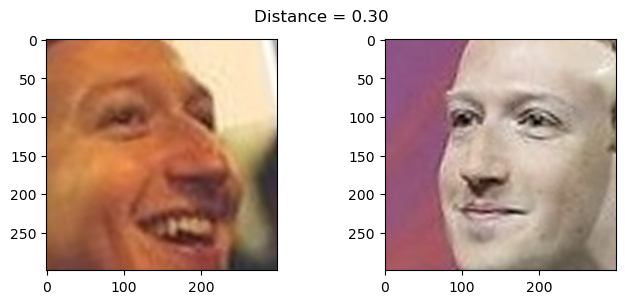

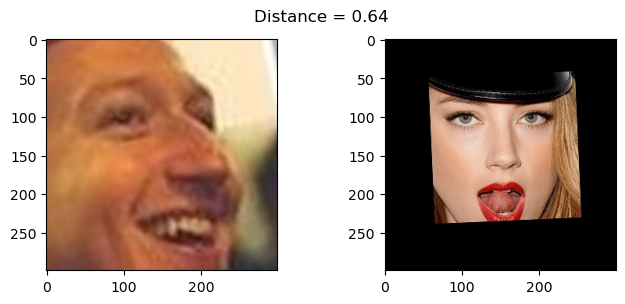

In [84]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

In [85]:
#Create X_train, X_test and y_train, y_test
#Use train_idx to seperate out training features and labels
#Use test_idx to seperate out testing features and labels

train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# train and test split
X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]

In [86]:
#Encode the Labels
#Encode the targets
#Use LabelEncoder

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
y_train_enc=label_encoder.transform(y_train)
y_test_enc=label_encoder.transform(y_test)

print("Number of target class types is -> ", len(label_encoder.classes_))
print("\n Target classes are\n", label_encoder.classes_)

Number of target class types is ->  100

 Target classes are
 ['pins_Aaron Paul' 'pins_Alvaro Morte' 'pins_Amanda Crew'
 'pins_Amaury Nolasco' 'pins_Anna Gunn' 'pins_Benedict Cumberbatch'
 'pins_Betsy Brandt' 'pins_Brenton Thwaites' 'pins_Brit Marling'
 'pins_Bryan Cranston' 'pins_Caity Lotz' 'pins_Cameron Monaghan'
 'pins_Chance Perdomo' 'pins_Chris Evans' 'pins_Chris Pratt'
 'pins_Cobie Smulders' 'pins_Danielle Panabaker' 'pins_Dave Franco'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Emilia Clarke'
 'pins_Emily Bett Rickards' 'pins_Emma Stone' 'pins_Gwyneth Paltrow'
 'pins_Henry Cavil' 'pins_Jason Momoa' 'pins_Jeremy Renner'
 'pins_Jesse Eisenberg' 'pins_Jim Parsons' 'pins_Jon Bernthal'
 'pins_Josh Radnor' 'pins_Kit Harington' 'pins_Krysten Ritter'
 'pins_Kumail Nanjiani' 'pins_Maisie Williams' 'pins_Mark Ruffalo'
 'pins_Martin Starr' 'pins_Melissa benoit' 'pins_Mike Colter'
 'pins_Morena Baccarin' 'pins_Morgan Freeman' 'pins_Natalie Portman'
 'pins_Neil Patrick Harris' 'pins

In [87]:
# Standarize features
# Scale the features using StandardScaler
from sklearn.preprocessing import StandardScaler

std_scale=StandardScaler()
std_scale= std_scale.fit(X_train)
X_train_scaled= std_scale.transform(X_train)
X_test_scaled= std_scale.transform(X_test)

## Part C - Q6 - Use PCA for dimensionality reduction.

In [88]:
from sklearn.decomposition import PCA
pca=PCA(n_components=128)
pca=pca.fit(X_train_scaled)
#X_pca_scaled=pca.transform(X_scaled)
print("Explained Variance ratios of each PCA: ",pca.explained_variance_ratio_)
print("Cummulative sum of Variance ratios for PCAs: ",np.cumsum(pca.explained_variance_ratio_))

Explained Variance ratios of each PCA:  [0.13569996 0.05406567 0.03970895 0.03655012 0.03411467 0.03119032
 0.02579137 0.02360634 0.02097328 0.01926902 0.01826627 0.01716205
 0.01667902 0.01560011 0.01413458 0.01363954 0.01310452 0.01222994
 0.0116033  0.0112282  0.01098702 0.01051806 0.00967046 0.00941819
 0.00922398 0.00883625 0.00832735 0.00766454 0.00760569 0.00738057
 0.00697752 0.00665067 0.00632774 0.00621762 0.00571105 0.00533433
 0.00526531 0.00515582 0.00501858 0.00483751 0.00443328 0.0043329
 0.00397183 0.00394965 0.0037032  0.0035541  0.00342973 0.00335539
 0.00327702 0.00319913 0.00314535 0.00309223 0.00289779 0.00283012
 0.00279504 0.00273731 0.0027022  0.00262267 0.00252577 0.0024926
 0.00238502 0.0023115  0.00224559 0.00216081 0.00212292 0.00206178
 0.00203183 0.00194137 0.00189094 0.00183736 0.00183139 0.00179764
 0.00175039 0.00173934 0.00170594 0.00165228 0.00164842 0.00161496
 0.00155638 0.0015445  0.00152139 0.00149854 0.00145869 0.00143155
 0.00141457 0.00137257 0

In [89]:
# Obtaining PCA attributes for train and test set
X_train_pca_scaled=pca.transform(X_train_scaled)
X_test_pca_scaled=pca.transform(X_test_scaled)

## Part C - Q7 - Build an SVM classifier in order to map each image to its right person.

In [90]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svc_model=SVC()
svc_model=svc_model.fit(X_train_pca_scaled,y_train_enc)
y_train_pred=svc_model.predict(X_train_pca_scaled)
y_test_pred=svc_model.predict(X_test_pca_scaled)
print("Training Accuracy: ",accuracy_score(y_train_enc,y_train_pred))
print("Testing Accuracy: ",accuracy_score(y_test_enc,y_test_pred))

Training Accuracy:  0.9964483443016818
Testing Accuracy:  0.960735171261487


## Part C - Q8 - Import and display the the test images.

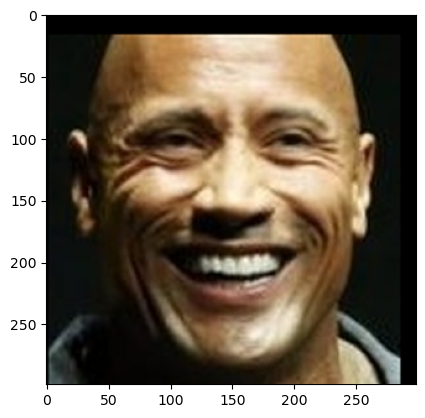

In [92]:
plt.imshow(load_image('./Dwayne Johnson4.jpg'))

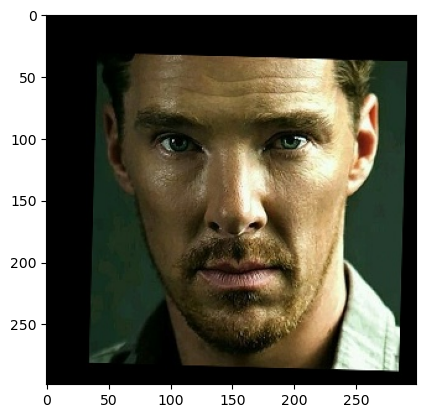

In [93]:
plt.imshow(load_image('./Benedict Cumberbatch9.jpg'))

## Part C - Q9 - Use the trained SVM model to predict the face on both test images.

In [110]:
def predict_person_in_img(test_input_image, debug=False):
    # Load the image
    raw_image = load_image(test_input_image)

    # Normalising pixel values, scale RGB values to interval [0,1]
    raw_img_nmz = (raw_image / 255.).astype(np.float32)
    raw_img_nmz_resized = cv2.resize(raw_img_nmz, dsize = (224,224))
    if (debug):
        print("Normalized and resized image: ", raw_img_nmz_resized.shape)

    # Get the embedding vector for image 
    emd_vec = vgg_face_descriptor.predict(np.expand_dims(raw_img_nmz_resized, axis=0))[0]
    if (debug):
        print("EmbeddingVector shape", emd_vec.shape)

    emd_vec = np.expand_dims(emd_vec, axis=0)
    if (debug):
        print("EmbeddingVector shape", emd_vec.shape)

    # Standarize features
    emd_vec_std = std_scale.transform(emd_vec)
    if (debug):
        print('EmbeddingVectorStd shape : ({0},{1})'.format(emd_vec_std.shape[0], emd_vec_std.shape[1]))

    # Reduce the input feature dimension from size 2622 to 128 !
    emd_vec_pca = pca.transform(emd_vec_std)

    # Run SVC classifier to predict the output class
    prd_cl_vec = svc_model.predict(emd_vec_pca)

    # Getting class name from predicted class vector
    prd_cl_name = label_encoder.inverse_transform(prd_cl_vec)

    plt.imshow(raw_img_nmz_resized)
    plt.title(f'Identified as {prd_cl_name[0]}');

Normalized and resized image:  (224, 224, 3)
1/1 [==============================] - 0s 221ms/step
EmbeddingVector shape (2622,)
EmbeddingVector shape (1, 2622)
EmbeddingVectorStd shape : (1,2622)


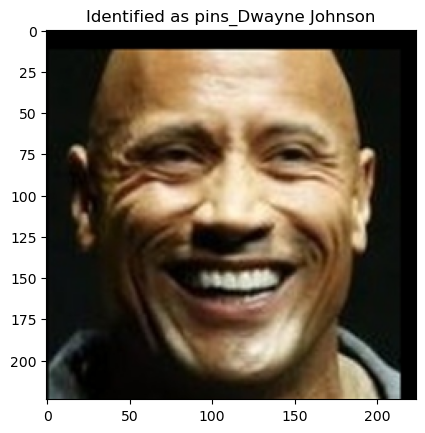

In [111]:
predict_person_in_img('./Dwayne Johnson4.jpg', True)

Normalized and resized image:  (224, 224, 3)
1/1 [==============================] - 0s 232ms/step
EmbeddingVector shape (2622,)
EmbeddingVector shape (1, 2622)
EmbeddingVectorStd shape : (1,2622)


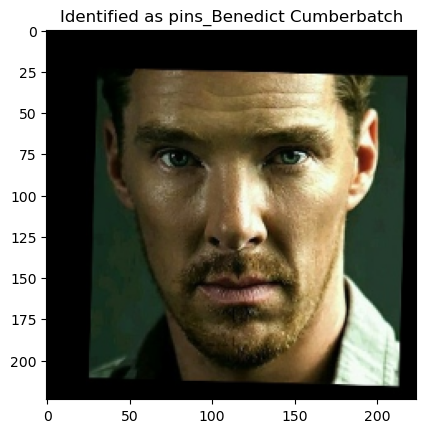

In [112]:
predict_person_in_img('./Benedict Cumberbatch9.jpg', True)